In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (MobileNetV3Large)

2024-02-24 13:27:10.223808: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 13:27:10.223961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 13:27:10.372398: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(MobileNetV3Large(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("MobileNetV3Large"+s+".keras")
    

    # save model to disk
    filename = "MobileNetV3Large" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 MobilenetV3large (Function  (None, 4)                 4231556   


 al)                                                             


Total params: 4231556 (16.14 MB)


Trainable params: 4207156 (16.05 MB)


Non-trainable params: 24400 (95.31 KB)


_________________________________________________________________


Epoch 1/30


2024-02-24 13:27:43.691291: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/MobilenetV3large/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


I0000 00:00:1708781267.494267      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 1:11:21 - loss: 1.2691 - accuracy: 0.5938

  2/140 [..............................] - ETA: 16s - loss: 2.0511 - accuracy: 0.5000    

  3/140 [..............................] - ETA: 15s - loss: 1.8121 - accuracy: 0.5000

  4/140 [..............................] - ETA: 15s - loss: 1.6890 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 15s - loss: 1.6158 - accuracy: 0.4750

  6/140 [>.............................] - ETA: 14s - loss: 1.5390 - accuracy: 0.4635

  7/140 [>.............................] - ETA: 14s - loss: 1.5415 - accuracy: 0.4509

  8/140 [>.............................] - ETA: 14s - loss: 1.5096 - accuracy: 0.4453

  9/140 [>.............................] - ETA: 14s - loss: 1.4541 - accuracy: 0.4618

 10/140 [=>............................] - ETA: 14s - loss: 1.4620 - accuracy: 0.4531

 11/140 [=>............................] - ETA: 14s - loss: 1.4327 - accuracy: 0.4574

 12/140 [=>............................] - ETA: 13s - loss: 1.4535 - accuracy: 0.4661

 13/140 [=>............................] - ETA: 13s - loss: 1.4466 - accuracy: 0.4760

 14/140 [==>...........................] - ETA: 13s - loss: 1.4264 - accuracy: 0.4777

 15/140 [==>...........................] - ETA: 13s - loss: 1.4202 - accuracy: 0.4750

 16/140 [==>...........................] - ETA: 13s - loss: 1.3920 - accuracy: 0.4707

 17/140 [==>...........................] - ETA: 13s - loss: 1.3831 - accuracy: 0.4688

 18/140 [==>...........................] - ETA: 13s - loss: 1.3521 - accuracy: 0.4705

 19/140 [===>..........................] - ETA: 13s - loss: 1.3533 - accuracy: 0.4671

 20/140 [===>..........................] - ETA: 13s - loss: 1.3417 - accuracy: 0.4656

 21/140 [===>..........................] - ETA: 12s - loss: 1.3460 - accuracy: 0.4628

 22/140 [===>..........................] - ETA: 12s - loss: 1.3340 - accuracy: 0.4616

 23/140 [===>..........................] - ETA: 12s - loss: 1.3240 - accuracy: 0.4620

 24/140 [====>.........................] - ETA: 12s - loss: 1.3175 - accuracy: 0.4596

 25/140 [====>.........................] - ETA: 12s - loss: 1.3065 - accuracy: 0.4613

 26/140 [====>.........................] - ETA: 12s - loss: 1.3070 - accuracy: 0.4543

 27/140 [====>.........................] - ETA: 12s - loss: 1.2970 - accuracy: 0.4525

 28/140 [=====>........................] - ETA: 12s - loss: 1.2879 - accuracy: 0.4498

 29/140 [=====>........................] - ETA: 11s - loss: 1.2788 - accuracy: 0.4558

 30/140 [=====>........................] - ETA: 11s - loss: 1.2689 - accuracy: 0.4594

 31/140 [=====>........................] - ETA: 11s - loss: 1.2585 - accuracy: 0.4627

 32/140 [=====>........................] - ETA: 11s - loss: 1.2477 - accuracy: 0.4629

 33/140 [======>.......................] - ETA: 11s - loss: 1.2438 - accuracy: 0.4640

 34/140 [======>.......................] - ETA: 11s - loss: 1.2418 - accuracy: 0.4614

 35/140 [======>.......................] - ETA: 11s - loss: 1.2366 - accuracy: 0.4598

 36/140 [======>.......................] - ETA: 11s - loss: 1.2229 - accuracy: 0.4644

 37/140 [======>.......................] - ETA: 11s - loss: 1.2184 - accuracy: 0.4654

 38/140 [=======>......................] - ETA: 11s - loss: 1.2132 - accuracy: 0.4638

 39/140 [=======>......................] - ETA: 10s - loss: 1.2152 - accuracy: 0.4639

 40/140 [=======>......................] - ETA: 10s - loss: 1.2091 - accuracy: 0.4625

 41/140 [=======>......................] - ETA: 10s - loss: 1.2012 - accuracy: 0.4657

 42/140 [========>.....................] - ETA: 10s - loss: 1.1919 - accuracy: 0.4702

 43/140 [========>.....................] - ETA: 10s - loss: 1.1831 - accuracy: 0.4746

 44/140 [========>.....................] - ETA: 10s - loss: 1.1763 - accuracy: 0.4773

 45/140 [========>.....................] - ETA: 10s - loss: 1.1751 - accuracy: 0.4785

 46/140 [========>.....................] - ETA: 10s - loss: 1.1720 - accuracy: 0.4837

 47/140 [=========>....................] - ETA: 10s - loss: 1.1693 - accuracy: 0.4834

 48/140 [=========>....................] - ETA: 9s - loss: 1.1634 - accuracy: 0.4857 

 49/140 [=========>....................] - ETA: 9s - loss: 1.1626 - accuracy: 0.4853

 50/140 [=========>....................] - ETA: 9s - loss: 1.1562 - accuracy: 0.4863

 51/140 [=========>....................] - ETA: 9s - loss: 1.1521 - accuracy: 0.4871

 52/140 [==========>...................] - ETA: 9s - loss: 1.1447 - accuracy: 0.4910

 53/140 [==========>...................] - ETA: 9s - loss: 1.1393 - accuracy: 0.4935

 54/140 [==========>...................] - ETA: 9s - loss: 1.1337 - accuracy: 0.4959

 55/140 [==========>...................] - ETA: 9s - loss: 1.1305 - accuracy: 0.4960

 56/140 [===========>..................] - ETA: 9s - loss: 1.1234 - accuracy: 0.4989

 57/140 [===========>..................] - ETA: 8s - loss: 1.1170 - accuracy: 0.5022

 58/140 [===========>..................] - ETA: 8s - loss: 1.1115 - accuracy: 0.5038

 59/140 [===========>..................] - ETA: 8s - loss: 1.1126 - accuracy: 0.5037

 60/140 [===========>..................] - ETA: 8s - loss: 1.1129 - accuracy: 0.5026

 61/140 [============>.................] - ETA: 8s - loss: 1.1079 - accuracy: 0.5051

 62/140 [============>.................] - ETA: 8s - loss: 1.1065 - accuracy: 0.5045

 63/140 [============>.................] - ETA: 8s - loss: 1.1031 - accuracy: 0.5050

 64/140 [============>.................] - ETA: 8s - loss: 1.0980 - accuracy: 0.5063

 65/140 [============>.................] - ETA: 8s - loss: 1.0969 - accuracy: 0.5082

 66/140 [=============>................] - ETA: 7s - loss: 1.0910 - accuracy: 0.5099

 67/140 [=============>................] - ETA: 7s - loss: 1.0887 - accuracy: 0.5107

 68/140 [=============>................] - ETA: 7s - loss: 1.0998 - accuracy: 0.5083

 69/140 [=============>................] - ETA: 7s - loss: 1.0985 - accuracy: 0.5082

 70/140 [==============>...............] - ETA: 7s - loss: 1.1001 - accuracy: 0.5071

 71/140 [==============>...............] - ETA: 7s - loss: 1.0992 - accuracy: 0.5070

 72/140 [==============>...............] - ETA: 7s - loss: 1.0967 - accuracy: 0.5091

 73/140 [==============>...............] - ETA: 7s - loss: 1.0915 - accuracy: 0.5133

 74/140 [==============>...............] - ETA: 7s - loss: 1.0888 - accuracy: 0.5135

 75/140 [===============>..............] - ETA: 6s - loss: 1.0864 - accuracy: 0.5129

 76/140 [===============>..............] - ETA: 6s - loss: 1.0864 - accuracy: 0.5107

 77/140 [===============>..............] - ETA: 6s - loss: 1.0845 - accuracy: 0.5106

 78/140 [===============>..............] - ETA: 6s - loss: 1.0835 - accuracy: 0.5100

 79/140 [===============>..............] - ETA: 6s - loss: 1.0852 - accuracy: 0.5087

 80/140 [================>.............] - ETA: 6s - loss: 1.0821 - accuracy: 0.5094

 81/140 [================>.............] - ETA: 6s - loss: 1.0785 - accuracy: 0.5104

 82/140 [================>.............] - ETA: 6s - loss: 1.0753 - accuracy: 0.5099

 83/140 [================>.............] - ETA: 6s - loss: 1.0741 - accuracy: 0.5098

 84/140 [=================>............] - ETA: 6s - loss: 1.0756 - accuracy: 0.5089

 85/140 [=================>............] - ETA: 5s - loss: 1.0747 - accuracy: 0.5096

 86/140 [=================>............] - ETA: 5s - loss: 1.0726 - accuracy: 0.5098

 87/140 [=================>............] - ETA: 5s - loss: 1.0708 - accuracy: 0.5108

 88/140 [=================>............] - ETA: 5s - loss: 1.0702 - accuracy: 0.5110

 89/140 [==================>...........] - ETA: 5s - loss: 1.0717 - accuracy: 0.5105

 90/140 [==================>...........] - ETA: 5s - loss: 1.0708 - accuracy: 0.5108

 91/140 [==================>...........] - ETA: 5s - loss: 1.0681 - accuracy: 0.5113

 92/140 [==================>...........] - ETA: 5s - loss: 1.0664 - accuracy: 0.5115

 93/140 [==================>...........] - ETA: 5s - loss: 1.0635 - accuracy: 0.5131

 94/140 [===================>..........] - ETA: 4s - loss: 1.0612 - accuracy: 0.5136

 95/140 [===================>..........] - ETA: 4s - loss: 1.0607 - accuracy: 0.5135

 96/140 [===================>..........] - ETA: 4s - loss: 1.0585 - accuracy: 0.5146

 97/140 [===================>..........] - ETA: 4s - loss: 1.0570 - accuracy: 0.5148

 98/140 [====================>.........] - ETA: 4s - loss: 1.0584 - accuracy: 0.5131

 99/140 [====================>.........] - ETA: 4s - loss: 1.0551 - accuracy: 0.5148

100/140 [====================>.........] - ETA: 4s - loss: 1.0540 - accuracy: 0.5147

101/140 [====================>.........] - ETA: 4s - loss: 1.0523 - accuracy: 0.5145

102/140 [====================>.........] - ETA: 4s - loss: 1.0501 - accuracy: 0.5150

103/140 [=====================>........] - ETA: 3s - loss: 1.0478 - accuracy: 0.5167

104/140 [=====================>........] - ETA: 3s - loss: 1.0465 - accuracy: 0.5174

105/140 [=====================>........] - ETA: 3s - loss: 1.0449 - accuracy: 0.5179

106/140 [=====================>........] - ETA: 3s - loss: 1.0428 - accuracy: 0.5189

107/140 [=====================>........] - ETA: 3s - loss: 1.0399 - accuracy: 0.5202

108/140 [======================>.......] - ETA: 3s - loss: 1.0385 - accuracy: 0.5208

109/140 [======================>.......] - ETA: 3s - loss: 1.0384 - accuracy: 0.5221

110/140 [======================>.......] - ETA: 3s - loss: 1.0374 - accuracy: 0.5224

111/140 [======================>.......] - ETA: 3s - loss: 1.0367 - accuracy: 0.5228

112/140 [=======================>......] - ETA: 3s - loss: 1.0356 - accuracy: 0.5232

113/140 [=======================>......] - ETA: 2s - loss: 1.0327 - accuracy: 0.5243

114/140 [=======================>......] - ETA: 2s - loss: 1.0319 - accuracy: 0.5238

115/140 [=======================>......] - ETA: 2s - loss: 1.0311 - accuracy: 0.5242

116/140 [=======================>......] - ETA: 2s - loss: 1.0288 - accuracy: 0.5248

117/140 [========================>.....] - ETA: 2s - loss: 1.0287 - accuracy: 0.5254

118/140 [========================>.....] - ETA: 2s - loss: 1.0268 - accuracy: 0.5254

119/140 [========================>.....] - ETA: 2s - loss: 1.0244 - accuracy: 0.5263

120/140 [========================>.....] - ETA: 2s - loss: 1.0249 - accuracy: 0.5255

121/140 [========================>.....] - ETA: 2s - loss: 1.0230 - accuracy: 0.5266

122/140 [=========================>....] - ETA: 1s - loss: 1.0209 - accuracy: 0.5274

123/140 [=========================>....] - ETA: 1s - loss: 1.0188 - accuracy: 0.5282

124/140 [=========================>....] - ETA: 1s - loss: 1.0179 - accuracy: 0.5287

125/140 [=========================>....] - ETA: 1s - loss: 1.0165 - accuracy: 0.5290

126/140 [==========================>...] - ETA: 1s - loss: 1.0146 - accuracy: 0.5298

127/140 [==========================>...] - ETA: 1s - loss: 1.0139 - accuracy: 0.5293

128/140 [==========================>...] - ETA: 1s - loss: 1.0129 - accuracy: 0.5300

129/140 [==========================>...] - ETA: 1s - loss: 1.0110 - accuracy: 0.5305

130/140 [==========================>...] - ETA: 1s - loss: 1.0104 - accuracy: 0.5315

131/140 [===========================>..] - ETA: 0s - loss: 1.0092 - accuracy: 0.5315

132/140 [===========================>..] - ETA: 0s - loss: 1.0092 - accuracy: 0.5320

133/140 [===========================>..] - ETA: 0s - loss: 1.0077 - accuracy: 0.5327

134/140 [===========================>..] - ETA: 0s - loss: 1.0059 - accuracy: 0.5326

135/140 [===========================>..] - ETA: 0s - loss: 1.0046 - accuracy: 0.5333

136/140 [============================>.] - ETA: 0s - loss: 1.0039 - accuracy: 0.5333

137/140 [============================>.] - ETA: 0s - loss: 1.0017 - accuracy: 0.5344

138/140 [============================>.] - ETA: 0s - loss: 1.0001 - accuracy: 0.5349

139/140 [============================>.] - ETA: 0s - loss: 0.9987 - accuracy: 0.5355

140/140 [==============================] - ETA: 0s - loss: 0.9984 - accuracy: 0.5359

140/140 [==============================] - 50s 140ms/step - loss: 0.9984 - accuracy: 0.5359 - val_loss: 1.2399 - val_accuracy: 0.5004


Epoch 2/30


  1/140 [..............................] - ETA: 32s - loss: 0.8654 - accuracy: 0.6250

  2/140 [..............................] - ETA: 14s - loss: 0.8394 - accuracy: 0.5781

  3/140 [..............................] - ETA: 14s - loss: 0.8307 - accuracy: 0.5938

  4/140 [..............................] - ETA: 14s - loss: 0.8122 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 14s - loss: 0.8721 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 14s - loss: 0.9216 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 14s - loss: 0.9199 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 14s - loss: 0.8996 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 13s - loss: 0.9009 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 13s - loss: 0.9360 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 13s - loss: 0.9244 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 13s - loss: 0.9071 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 13s - loss: 0.9231 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 13s - loss: 0.9231 - accuracy: 0.5491

 15/140 [==>...........................] - ETA: 13s - loss: 0.9178 - accuracy: 0.5521

 16/140 [==>...........................] - ETA: 13s - loss: 0.9030 - accuracy: 0.5723

 17/140 [==>...........................] - ETA: 13s - loss: 0.8985 - accuracy: 0.5717

 18/140 [==>...........................] - ETA: 13s - loss: 0.9067 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 12s - loss: 0.9084 - accuracy: 0.5641

 20/140 [===>..........................] - ETA: 12s - loss: 0.9035 - accuracy: 0.5641

 21/140 [===>..........................] - ETA: 12s - loss: 0.8971 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 12s - loss: 0.8893 - accuracy: 0.5767

 23/140 [===>..........................] - ETA: 12s - loss: 0.8860 - accuracy: 0.5761

 24/140 [====>.........................] - ETA: 12s - loss: 0.8783 - accuracy: 0.5807

 25/140 [====>.........................] - ETA: 12s - loss: 0.8813 - accuracy: 0.5788

 26/140 [====>.........................] - ETA: 12s - loss: 0.8797 - accuracy: 0.5793

 27/140 [====>.........................] - ETA: 12s - loss: 0.8737 - accuracy: 0.5799

 28/140 [=====>........................] - ETA: 11s - loss: 0.8706 - accuracy: 0.5826

 29/140 [=====>........................] - ETA: 11s - loss: 0.8697 - accuracy: 0.5787

 30/140 [=====>........................] - ETA: 11s - loss: 0.8733 - accuracy: 0.5760

 31/140 [=====>........................] - ETA: 11s - loss: 0.8716 - accuracy: 0.5786

 32/140 [=====>........................] - ETA: 11s - loss: 0.8700 - accuracy: 0.5762

 33/140 [======>.......................] - ETA: 11s - loss: 0.8692 - accuracy: 0.5748

 34/140 [======>.......................] - ETA: 11s - loss: 0.8748 - accuracy: 0.5735

 35/140 [======>.......................] - ETA: 11s - loss: 0.8694 - accuracy: 0.5759

 36/140 [======>.......................] - ETA: 11s - loss: 0.8717 - accuracy: 0.5747

 37/140 [======>.......................] - ETA: 11s - loss: 0.8719 - accuracy: 0.5743

 38/140 [=======>......................] - ETA: 10s - loss: 0.8651 - accuracy: 0.5814

 39/140 [=======>......................] - ETA: 10s - loss: 0.8647 - accuracy: 0.5841

 40/140 [=======>......................] - ETA: 10s - loss: 0.8592 - accuracy: 0.5875

 41/140 [=======>......................] - ETA: 10s - loss: 0.8567 - accuracy: 0.5877

 42/140 [========>.....................] - ETA: 10s - loss: 0.8598 - accuracy: 0.5893

 43/140 [========>.....................] - ETA: 10s - loss: 0.8569 - accuracy: 0.5923

 44/140 [========>.....................] - ETA: 10s - loss: 0.8499 - accuracy: 0.5973

 45/140 [========>.....................] - ETA: 10s - loss: 0.8546 - accuracy: 0.5986

 46/140 [========>.....................] - ETA: 10s - loss: 0.8515 - accuracy: 0.5999

 47/140 [=========>....................] - ETA: 9s - loss: 0.8504 - accuracy: 0.6017 

 48/140 [=========>....................] - ETA: 9s - loss: 0.8487 - accuracy: 0.6042

 49/140 [=========>....................] - ETA: 9s - loss: 0.8467 - accuracy: 0.6046

 50/140 [=========>....................] - ETA: 9s - loss: 0.8446 - accuracy: 0.6050

 51/140 [=========>....................] - ETA: 9s - loss: 0.8449 - accuracy: 0.6048

 52/140 [==========>...................] - ETA: 9s - loss: 0.8495 - accuracy: 0.6028

 53/140 [==========>...................] - ETA: 9s - loss: 0.8459 - accuracy: 0.6050

 54/140 [==========>...................] - ETA: 9s - loss: 0.8438 - accuracy: 0.6053

 55/140 [==========>...................] - ETA: 9s - loss: 0.8476 - accuracy: 0.6034

 56/140 [===========>..................] - ETA: 8s - loss: 0.8472 - accuracy: 0.6038

 57/140 [===========>..................] - ETA: 8s - loss: 0.8486 - accuracy: 0.6042

 58/140 [===========>..................] - ETA: 8s - loss: 0.8447 - accuracy: 0.6072

 59/140 [===========>..................] - ETA: 8s - loss: 0.8440 - accuracy: 0.6070

 60/140 [===========>..................] - ETA: 8s - loss: 0.8433 - accuracy: 0.6073

 61/140 [============>.................] - ETA: 8s - loss: 0.8438 - accuracy: 0.6076

 62/140 [============>.................] - ETA: 8s - loss: 0.8427 - accuracy: 0.6089

 63/140 [============>.................] - ETA: 8s - loss: 0.8481 - accuracy: 0.6076

 64/140 [============>.................] - ETA: 8s - loss: 0.8472 - accuracy: 0.6069

 65/140 [============>.................] - ETA: 8s - loss: 0.8531 - accuracy: 0.6058

 66/140 [=============>................] - ETA: 7s - loss: 0.8585 - accuracy: 0.6042

 67/140 [=============>................] - ETA: 7s - loss: 0.8595 - accuracy: 0.6035

 68/140 [=============>................] - ETA: 7s - loss: 0.8591 - accuracy: 0.6029

 69/140 [=============>................] - ETA: 7s - loss: 0.8582 - accuracy: 0.6051

 70/140 [==============>...............] - ETA: 7s - loss: 0.8556 - accuracy: 0.6067

 71/140 [==============>...............] - ETA: 7s - loss: 0.8529 - accuracy: 0.6083

 72/140 [==============>...............] - ETA: 7s - loss: 0.8508 - accuracy: 0.6089

 73/140 [==============>...............] - ETA: 7s - loss: 0.8504 - accuracy: 0.6104

 74/140 [==============>...............] - ETA: 7s - loss: 0.8513 - accuracy: 0.6102

 75/140 [===============>..............] - ETA: 6s - loss: 0.8549 - accuracy: 0.6087

 76/140 [===============>..............] - ETA: 6s - loss: 0.8528 - accuracy: 0.6106

 77/140 [===============>..............] - ETA: 6s - loss: 0.8504 - accuracy: 0.6128

 78/140 [===============>..............] - ETA: 6s - loss: 0.8495 - accuracy: 0.6126

 79/140 [===============>..............] - ETA: 6s - loss: 0.8481 - accuracy: 0.6131

 80/140 [================>.............] - ETA: 6s - loss: 0.8482 - accuracy: 0.6129

 81/140 [================>.............] - ETA: 6s - loss: 0.8459 - accuracy: 0.6134

 82/140 [================>.............] - ETA: 6s - loss: 0.8439 - accuracy: 0.6151

 83/140 [================>.............] - ETA: 6s - loss: 0.8428 - accuracy: 0.6152

 84/140 [=================>............] - ETA: 5s - loss: 0.8417 - accuracy: 0.6161

 85/140 [=================>............] - ETA: 5s - loss: 0.8409 - accuracy: 0.6169

 86/140 [=================>............] - ETA: 5s - loss: 0.8427 - accuracy: 0.6152

 87/140 [=================>............] - ETA: 5s - loss: 0.8400 - accuracy: 0.6171

 88/140 [=================>............] - ETA: 5s - loss: 0.8381 - accuracy: 0.6193

 89/140 [==================>...........] - ETA: 5s - loss: 0.8388 - accuracy: 0.6194

 90/140 [==================>...........] - ETA: 5s - loss: 0.8353 - accuracy: 0.6215

 91/140 [==================>...........] - ETA: 5s - loss: 0.8361 - accuracy: 0.6205

 92/140 [==================>...........] - ETA: 5s - loss: 0.8335 - accuracy: 0.6223

 93/140 [==================>...........] - ETA: 5s - loss: 0.8335 - accuracy: 0.6220

 94/140 [===================>..........] - ETA: 4s - loss: 0.8334 - accuracy: 0.6220

 95/140 [===================>..........] - ETA: 4s - loss: 0.8327 - accuracy: 0.6227

 96/140 [===================>..........] - ETA: 4s - loss: 0.8305 - accuracy: 0.6237

 97/140 [===================>..........] - ETA: 4s - loss: 0.8308 - accuracy: 0.6227

 98/140 [====================>.........] - ETA: 4s - loss: 0.8301 - accuracy: 0.6231

 99/140 [====================>.........] - ETA: 4s - loss: 0.8319 - accuracy: 0.6222

100/140 [====================>.........] - ETA: 4s - loss: 0.8304 - accuracy: 0.6228

101/140 [====================>.........] - ETA: 4s - loss: 0.8305 - accuracy: 0.6235

102/140 [====================>.........] - ETA: 4s - loss: 0.8313 - accuracy: 0.6225

103/140 [=====================>........] - ETA: 3s - loss: 0.8325 - accuracy: 0.6217

104/140 [=====================>........] - ETA: 3s - loss: 0.8314 - accuracy: 0.6217

105/140 [=====================>........] - ETA: 3s - loss: 0.8310 - accuracy: 0.6220

106/140 [=====================>........] - ETA: 3s - loss: 0.8298 - accuracy: 0.6223

107/140 [=====================>........] - ETA: 3s - loss: 0.8288 - accuracy: 0.6230

108/140 [======================>.......] - ETA: 3s - loss: 0.8272 - accuracy: 0.6233

109/140 [======================>.......] - ETA: 3s - loss: 0.8269 - accuracy: 0.6239

110/140 [======================>.......] - ETA: 3s - loss: 0.8268 - accuracy: 0.6236

111/140 [======================>.......] - ETA: 3s - loss: 0.8314 - accuracy: 0.6222

112/140 [=======================>......] - ETA: 2s - loss: 0.8300 - accuracy: 0.6228

113/140 [=======================>......] - ETA: 2s - loss: 0.8290 - accuracy: 0.6236

114/140 [=======================>......] - ETA: 2s - loss: 0.8287 - accuracy: 0.6242

115/140 [=======================>......] - ETA: 2s - loss: 0.8287 - accuracy: 0.6236

116/140 [=======================>......] - ETA: 2s - loss: 0.8276 - accuracy: 0.6242

117/140 [========================>.....] - ETA: 2s - loss: 0.8276 - accuracy: 0.6245

118/140 [========================>.....] - ETA: 2s - loss: 0.8262 - accuracy: 0.6250

119/140 [========================>.....] - ETA: 2s - loss: 0.8252 - accuracy: 0.6255

120/140 [========================>.....] - ETA: 2s - loss: 0.8241 - accuracy: 0.6260

121/140 [========================>.....] - ETA: 2s - loss: 0.8232 - accuracy: 0.6268

122/140 [=========================>....] - ETA: 1s - loss: 0.8243 - accuracy: 0.6263

123/140 [=========================>....] - ETA: 1s - loss: 0.8219 - accuracy: 0.6270

124/140 [=========================>....] - ETA: 1s - loss: 0.8215 - accuracy: 0.6273

125/140 [=========================>....] - ETA: 1s - loss: 0.8214 - accuracy: 0.6270

126/140 [==========================>...] - ETA: 1s - loss: 0.8228 - accuracy: 0.6262

127/140 [==========================>...] - ETA: 1s - loss: 0.8204 - accuracy: 0.6280

128/140 [==========================>...] - ETA: 1s - loss: 0.8198 - accuracy: 0.6282

129/140 [==========================>...] - ETA: 1s - loss: 0.8182 - accuracy: 0.6286

130/140 [==========================>...] - ETA: 1s - loss: 0.8181 - accuracy: 0.6286

131/140 [===========================>..] - ETA: 0s - loss: 0.8192 - accuracy: 0.6279

132/140 [===========================>..] - ETA: 0s - loss: 0.8177 - accuracy: 0.6286

133/140 [===========================>..] - ETA: 0s - loss: 0.8176 - accuracy: 0.6285

134/140 [===========================>..] - ETA: 0s - loss: 0.8165 - accuracy: 0.6294

135/140 [===========================>..] - ETA: 0s - loss: 0.8138 - accuracy: 0.6303

136/140 [============================>.] - ETA: 0s - loss: 0.8120 - accuracy: 0.6312

137/140 [============================>.] - ETA: 0s - loss: 0.8142 - accuracy: 0.6296

138/140 [============================>.] - ETA: 0s - loss: 0.8143 - accuracy: 0.6298

139/140 [============================>.] - ETA: 0s - loss: 0.8129 - accuracy: 0.6299

140/140 [==============================] - 16s 113ms/step - loss: 0.8129 - accuracy: 0.6299 - val_loss: 1.0645 - val_accuracy: 0.5004


Epoch 3/30


  1/140 [..............................] - ETA: 38s - loss: 0.7791 - accuracy: 0.6562

  2/140 [..............................] - ETA: 14s - loss: 0.7167 - accuracy: 0.6406

  3/140 [..............................] - ETA: 14s - loss: 0.7056 - accuracy: 0.6667

  4/140 [..............................] - ETA: 14s - loss: 0.6824 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 14s - loss: 0.6899 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 14s - loss: 0.7009 - accuracy: 0.6562

  7/140 [>.............................] - ETA: 14s - loss: 0.7410 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 14s - loss: 0.7828 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 13s - loss: 0.7532 - accuracy: 0.6528

 10/140 [=>............................] - ETA: 13s - loss: 0.7399 - accuracy: 0.6562

 11/140 [=>............................] - ETA: 13s - loss: 0.7378 - accuracy: 0.6562

 12/140 [=>............................] - ETA: 13s - loss: 0.7341 - accuracy: 0.6510

 13/140 [=>............................] - ETA: 13s - loss: 0.7214 - accuracy: 0.6562

 14/140 [==>...........................] - ETA: 13s - loss: 0.7206 - accuracy: 0.6518

 15/140 [==>...........................] - ETA: 13s - loss: 0.7417 - accuracy: 0.6479

 16/140 [==>...........................] - ETA: 13s - loss: 0.7283 - accuracy: 0.6543

 17/140 [==>...........................] - ETA: 13s - loss: 0.7235 - accuracy: 0.6526

 18/140 [==>...........................] - ETA: 12s - loss: 0.7156 - accuracy: 0.6597

 19/140 [===>..........................] - ETA: 12s - loss: 0.7110 - accuracy: 0.6595

 20/140 [===>..........................] - ETA: 12s - loss: 0.7063 - accuracy: 0.6625

 21/140 [===>..........................] - ETA: 12s - loss: 0.7031 - accuracy: 0.6652

 22/140 [===>..........................] - ETA: 12s - loss: 0.7006 - accuracy: 0.6690

 23/140 [===>..........................] - ETA: 12s - loss: 0.6953 - accuracy: 0.6712

 24/140 [====>.........................] - ETA: 12s - loss: 0.6934 - accuracy: 0.6732

 25/140 [====>.........................] - ETA: 12s - loss: 0.6852 - accuracy: 0.6775

 26/140 [====>.........................] - ETA: 12s - loss: 0.6865 - accuracy: 0.6791

 27/140 [====>.........................] - ETA: 12s - loss: 0.6835 - accuracy: 0.6817

 28/140 [=====>........................] - ETA: 11s - loss: 0.6796 - accuracy: 0.6842

 29/140 [=====>........................] - ETA: 11s - loss: 0.6786 - accuracy: 0.6832

 30/140 [=====>........................] - ETA: 11s - loss: 0.6857 - accuracy: 0.6802

 31/140 [=====>........................] - ETA: 11s - loss: 0.6854 - accuracy: 0.6815

 32/140 [=====>........................] - ETA: 11s - loss: 0.6844 - accuracy: 0.6836

 33/140 [======>.......................] - ETA: 11s - loss: 0.6813 - accuracy: 0.6875

 34/140 [======>.......................] - ETA: 11s - loss: 0.6749 - accuracy: 0.6903

 35/140 [======>.......................] - ETA: 11s - loss: 0.6781 - accuracy: 0.6911

 36/140 [======>.......................] - ETA: 11s - loss: 0.6795 - accuracy: 0.6927

 37/140 [======>.......................] - ETA: 11s - loss: 0.6785 - accuracy: 0.6909

 38/140 [=======>......................] - ETA: 10s - loss: 0.6750 - accuracy: 0.6924

 39/140 [=======>......................] - ETA: 10s - loss: 0.6685 - accuracy: 0.6947

 40/140 [=======>......................] - ETA: 10s - loss: 0.6637 - accuracy: 0.6984

 41/140 [=======>......................] - ETA: 10s - loss: 0.6721 - accuracy: 0.6959

 42/140 [========>.....................] - ETA: 10s - loss: 0.6715 - accuracy: 0.6957

 43/140 [========>.....................] - ETA: 10s - loss: 0.6725 - accuracy: 0.6962

 44/140 [========>.....................] - ETA: 10s - loss: 0.6704 - accuracy: 0.6974

 45/140 [========>.....................] - ETA: 10s - loss: 0.6683 - accuracy: 0.6993

 46/140 [========>.....................] - ETA: 10s - loss: 0.6644 - accuracy: 0.7004

 47/140 [=========>....................] - ETA: 9s - loss: 0.6630 - accuracy: 0.7008 

 48/140 [=========>....................] - ETA: 9s - loss: 0.6619 - accuracy: 0.7012

 49/140 [=========>....................] - ETA: 9s - loss: 0.6607 - accuracy: 0.7015

 50/140 [=========>....................] - ETA: 9s - loss: 0.6533 - accuracy: 0.7056

 51/140 [=========>....................] - ETA: 9s - loss: 0.6497 - accuracy: 0.7053

 52/140 [==========>...................] - ETA: 9s - loss: 0.6526 - accuracy: 0.7043

 53/140 [==========>...................] - ETA: 9s - loss: 0.6550 - accuracy: 0.7046

 54/140 [==========>...................] - ETA: 9s - loss: 0.6516 - accuracy: 0.7060

 55/140 [==========>...................] - ETA: 9s - loss: 0.6482 - accuracy: 0.7074

 56/140 [===========>..................] - ETA: 9s - loss: 0.6447 - accuracy: 0.7093

 57/140 [===========>..................] - ETA: 8s - loss: 0.6409 - accuracy: 0.7105

 58/140 [===========>..................] - ETA: 8s - loss: 0.6408 - accuracy: 0.7123

 59/140 [===========>..................] - ETA: 8s - loss: 0.6434 - accuracy: 0.7119

 60/140 [===========>..................] - ETA: 8s - loss: 0.6512 - accuracy: 0.7094

 61/140 [============>.................] - ETA: 8s - loss: 0.6484 - accuracy: 0.7106

 62/140 [============>.................] - ETA: 8s - loss: 0.6499 - accuracy: 0.7097

 63/140 [============>.................] - ETA: 8s - loss: 0.6529 - accuracy: 0.7078

 64/140 [============>.................] - ETA: 8s - loss: 0.6546 - accuracy: 0.7080

 65/140 [============>.................] - ETA: 8s - loss: 0.6527 - accuracy: 0.7091

 66/140 [=============>................] - ETA: 7s - loss: 0.6487 - accuracy: 0.7112

 67/140 [=============>................] - ETA: 7s - loss: 0.6487 - accuracy: 0.7108

 68/140 [=============>................] - ETA: 7s - loss: 0.6451 - accuracy: 0.7132

 69/140 [=============>................] - ETA: 7s - loss: 0.6451 - accuracy: 0.7133

 70/140 [==============>...............] - ETA: 7s - loss: 0.6447 - accuracy: 0.7138

 71/140 [==============>...............] - ETA: 7s - loss: 0.6443 - accuracy: 0.7143

 72/140 [==============>...............] - ETA: 7s - loss: 0.6456 - accuracy: 0.7148

 73/140 [==============>...............] - ETA: 7s - loss: 0.6418 - accuracy: 0.7162

 74/140 [==============>...............] - ETA: 7s - loss: 0.6411 - accuracy: 0.7171

 75/140 [===============>..............] - ETA: 6s - loss: 0.6382 - accuracy: 0.7179

 76/140 [===============>..............] - ETA: 6s - loss: 0.6372 - accuracy: 0.7179

 77/140 [===============>..............] - ETA: 6s - loss: 0.6365 - accuracy: 0.7192

 78/140 [===============>..............] - ETA: 6s - loss: 0.6376 - accuracy: 0.7188

 79/140 [===============>..............] - ETA: 6s - loss: 0.6355 - accuracy: 0.7191

 80/140 [================>.............] - ETA: 6s - loss: 0.6368 - accuracy: 0.7180

 81/140 [================>.............] - ETA: 6s - loss: 0.6351 - accuracy: 0.7195

 82/140 [================>.............] - ETA: 6s - loss: 0.6320 - accuracy: 0.7222

 83/140 [================>.............] - ETA: 6s - loss: 0.6301 - accuracy: 0.7225

 84/140 [=================>............] - ETA: 6s - loss: 0.6311 - accuracy: 0.7225

 85/140 [=================>............] - ETA: 5s - loss: 0.6284 - accuracy: 0.7246

 86/140 [=================>............] - ETA: 5s - loss: 0.6281 - accuracy: 0.7253

 87/140 [=================>............] - ETA: 5s - loss: 0.6306 - accuracy: 0.7238

 88/140 [=================>............] - ETA: 5s - loss: 0.6276 - accuracy: 0.7259

 89/140 [==================>...........] - ETA: 5s - loss: 0.6263 - accuracy: 0.7258

 90/140 [==================>...........] - ETA: 5s - loss: 0.6255 - accuracy: 0.7257

 91/140 [==================>...........] - ETA: 5s - loss: 0.6271 - accuracy: 0.7246

 92/140 [==================>...........] - ETA: 5s - loss: 0.6267 - accuracy: 0.7255

 93/140 [==================>...........] - ETA: 5s - loss: 0.6249 - accuracy: 0.7261

 94/140 [===================>..........] - ETA: 4s - loss: 0.6267 - accuracy: 0.7261

 95/140 [===================>..........] - ETA: 4s - loss: 0.6259 - accuracy: 0.7266

 96/140 [===================>..........] - ETA: 4s - loss: 0.6259 - accuracy: 0.7275

 97/140 [===================>..........] - ETA: 4s - loss: 0.6243 - accuracy: 0.7284

 98/140 [====================>.........] - ETA: 4s - loss: 0.6226 - accuracy: 0.7299

 99/140 [====================>.........] - ETA: 4s - loss: 0.6229 - accuracy: 0.7295

100/140 [====================>.........] - ETA: 4s - loss: 0.6231 - accuracy: 0.7294

101/140 [====================>.........] - ETA: 4s - loss: 0.6231 - accuracy: 0.7305

102/140 [====================>.........] - ETA: 4s - loss: 0.6219 - accuracy: 0.7316

103/140 [=====================>........] - ETA: 3s - loss: 0.6213 - accuracy: 0.7318

104/140 [=====================>........] - ETA: 3s - loss: 0.6194 - accuracy: 0.7323

105/140 [=====================>........] - ETA: 3s - loss: 0.6193 - accuracy: 0.7324

106/140 [=====================>........] - ETA: 3s - loss: 0.6201 - accuracy: 0.7332

107/140 [=====================>........] - ETA: 3s - loss: 0.6199 - accuracy: 0.7328

108/140 [======================>.......] - ETA: 3s - loss: 0.6200 - accuracy: 0.7335

109/140 [======================>.......] - ETA: 3s - loss: 0.6177 - accuracy: 0.7348

110/140 [======================>.......] - ETA: 3s - loss: 0.6154 - accuracy: 0.7366

111/140 [======================>.......] - ETA: 3s - loss: 0.6141 - accuracy: 0.7376

112/140 [=======================>......] - ETA: 3s - loss: 0.6142 - accuracy: 0.7369

113/140 [=======================>......] - ETA: 2s - loss: 0.6138 - accuracy: 0.7370

114/140 [=======================>......] - ETA: 2s - loss: 0.6134 - accuracy: 0.7371

115/140 [=======================>......] - ETA: 2s - loss: 0.6139 - accuracy: 0.7370

116/140 [=======================>......] - ETA: 2s - loss: 0.6133 - accuracy: 0.7379

117/140 [========================>.....] - ETA: 2s - loss: 0.6120 - accuracy: 0.7385

118/140 [========================>.....] - ETA: 2s - loss: 0.6107 - accuracy: 0.7389

119/140 [========================>.....] - ETA: 2s - loss: 0.6087 - accuracy: 0.7398

120/140 [========================>.....] - ETA: 2s - loss: 0.6064 - accuracy: 0.7406

121/140 [========================>.....] - ETA: 2s - loss: 0.6056 - accuracy: 0.7407

122/140 [=========================>....] - ETA: 1s - loss: 0.6038 - accuracy: 0.7415

123/140 [=========================>....] - ETA: 1s - loss: 0.6021 - accuracy: 0.7424

124/140 [=========================>....] - ETA: 1s - loss: 0.6015 - accuracy: 0.7424

125/140 [=========================>....] - ETA: 1s - loss: 0.5999 - accuracy: 0.7430

126/140 [==========================>...] - ETA: 1s - loss: 0.5980 - accuracy: 0.7445

127/140 [==========================>...] - ETA: 1s - loss: 0.5970 - accuracy: 0.7448

128/140 [==========================>...] - ETA: 1s - loss: 0.5957 - accuracy: 0.7456

129/140 [==========================>...] - ETA: 1s - loss: 0.5977 - accuracy: 0.7454

130/140 [==========================>...] - ETA: 1s - loss: 0.5985 - accuracy: 0.7457

131/140 [===========================>..] - ETA: 0s - loss: 0.5957 - accuracy: 0.7469

132/140 [===========================>..] - ETA: 0s - loss: 0.5950 - accuracy: 0.7474

133/140 [===========================>..] - ETA: 0s - loss: 0.5959 - accuracy: 0.7477

134/140 [===========================>..] - ETA: 0s - loss: 0.5943 - accuracy: 0.7479

135/140 [===========================>..] - ETA: 0s - loss: 0.5933 - accuracy: 0.7481

136/140 [============================>.] - ETA: 0s - loss: 0.5926 - accuracy: 0.7479

137/140 [============================>.] - ETA: 0s - loss: 0.5915 - accuracy: 0.7484

138/140 [============================>.] - ETA: 0s - loss: 0.5900 - accuracy: 0.7491

139/140 [============================>.] - ETA: 0s - loss: 0.5914 - accuracy: 0.7491

140/140 [==============================] - 16s 114ms/step - loss: 0.5927 - accuracy: 0.7489 - val_loss: 1.0772 - val_accuracy: 0.5004


Epoch 4/30


  1/140 [..............................] - ETA: 35s - loss: 0.5692 - accuracy: 0.7500

  2/140 [..............................] - ETA: 14s - loss: 0.4549 - accuracy: 0.8281

  3/140 [..............................] - ETA: 14s - loss: 0.5333 - accuracy: 0.8021

  4/140 [..............................] - ETA: 14s - loss: 0.5314 - accuracy: 0.8047

  5/140 [>.............................] - ETA: 14s - loss: 0.5086 - accuracy: 0.8125

  6/140 [>.............................] - ETA: 14s - loss: 0.5153 - accuracy: 0.8177

  7/140 [>.............................] - ETA: 14s - loss: 0.5584 - accuracy: 0.7946

  8/140 [>.............................] - ETA: 14s - loss: 0.5597 - accuracy: 0.7852

  9/140 [>.............................] - ETA: 13s - loss: 0.5611 - accuracy: 0.7882

 10/140 [=>............................] - ETA: 13s - loss: 0.5730 - accuracy: 0.7781

 11/140 [=>............................] - ETA: 13s - loss: 0.5850 - accuracy: 0.7727

 12/140 [=>............................] - ETA: 13s - loss: 0.5970 - accuracy: 0.7656

 13/140 [=>............................] - ETA: 13s - loss: 0.6034 - accuracy: 0.7668

 14/140 [==>...........................] - ETA: 13s - loss: 0.5969 - accuracy: 0.7746

 15/140 [==>...........................] - ETA: 13s - loss: 0.5820 - accuracy: 0.7812

 16/140 [==>...........................] - ETA: 13s - loss: 0.5818 - accuracy: 0.7754

 17/140 [==>...........................] - ETA: 13s - loss: 0.5793 - accuracy: 0.7757

 18/140 [==>...........................] - ETA: 12s - loss: 0.5727 - accuracy: 0.7812

 19/140 [===>..........................] - ETA: 12s - loss: 0.5751 - accuracy: 0.7780

 20/140 [===>..........................] - ETA: 12s - loss: 0.5786 - accuracy: 0.7766

 21/140 [===>..........................] - ETA: 12s - loss: 0.5843 - accuracy: 0.7738

 22/140 [===>..........................] - ETA: 12s - loss: 0.5815 - accuracy: 0.7727

 23/140 [===>..........................] - ETA: 12s - loss: 0.5757 - accuracy: 0.7772

 24/140 [====>.........................] - ETA: 12s - loss: 0.5707 - accuracy: 0.7773

 25/140 [====>.........................] - ETA: 12s - loss: 0.5725 - accuracy: 0.7750

 26/140 [====>.........................] - ETA: 12s - loss: 0.5672 - accuracy: 0.7788

 27/140 [====>.........................] - ETA: 12s - loss: 0.5660 - accuracy: 0.7812

 28/140 [=====>........................] - ETA: 11s - loss: 0.5628 - accuracy: 0.7812

 29/140 [=====>........................] - ETA: 11s - loss: 0.5621 - accuracy: 0.7823

 30/140 [=====>........................] - ETA: 11s - loss: 0.5614 - accuracy: 0.7812

 31/140 [=====>........................] - ETA: 11s - loss: 0.5642 - accuracy: 0.7802

 32/140 [=====>........................] - ETA: 11s - loss: 0.5630 - accuracy: 0.7822

 33/140 [======>.......................] - ETA: 11s - loss: 0.5565 - accuracy: 0.7841

 34/140 [======>.......................] - ETA: 11s - loss: 0.5518 - accuracy: 0.7868

 35/140 [======>.......................] - ETA: 11s - loss: 0.5466 - accuracy: 0.7884

 36/140 [======>.......................] - ETA: 11s - loss: 0.5465 - accuracy: 0.7865

 37/140 [======>.......................] - ETA: 11s - loss: 0.5431 - accuracy: 0.7872

 38/140 [=======>......................] - ETA: 10s - loss: 0.5409 - accuracy: 0.7887

 39/140 [=======>......................] - ETA: 10s - loss: 0.5338 - accuracy: 0.7909

 40/140 [=======>......................] - ETA: 10s - loss: 0.5354 - accuracy: 0.7914

 41/140 [=======>......................] - ETA: 10s - loss: 0.5254 - accuracy: 0.7957

 42/140 [========>.....................] - ETA: 10s - loss: 0.5193 - accuracy: 0.7976

 43/140 [========>.....................] - ETA: 10s - loss: 0.5150 - accuracy: 0.7987

 44/140 [========>.....................] - ETA: 10s - loss: 0.5086 - accuracy: 0.8011

 45/140 [========>.....................] - ETA: 10s - loss: 0.5085 - accuracy: 0.8014

 46/140 [========>.....................] - ETA: 10s - loss: 0.5121 - accuracy: 0.8010

 47/140 [=========>....................] - ETA: 9s - loss: 0.5082 - accuracy: 0.8019 

 48/140 [=========>....................] - ETA: 9s - loss: 0.5160 - accuracy: 0.8014

 49/140 [=========>....................] - ETA: 9s - loss: 0.5106 - accuracy: 0.8029

 50/140 [=========>....................] - ETA: 9s - loss: 0.5120 - accuracy: 0.8012

 51/140 [=========>....................] - ETA: 9s - loss: 0.5078 - accuracy: 0.8027

 52/140 [==========>...................] - ETA: 9s - loss: 0.5025 - accuracy: 0.8047

 53/140 [==========>...................] - ETA: 9s - loss: 0.5028 - accuracy: 0.8042

 54/140 [==========>...................] - ETA: 9s - loss: 0.5012 - accuracy: 0.8050

 55/140 [==========>...................] - ETA: 9s - loss: 0.5003 - accuracy: 0.8051

 56/140 [===========>..................] - ETA: 8s - loss: 0.5000 - accuracy: 0.8058

 57/140 [===========>..................] - ETA: 8s - loss: 0.4983 - accuracy: 0.8070

 58/140 [===========>..................] - ETA: 8s - loss: 0.4949 - accuracy: 0.8093

 59/140 [===========>..................] - ETA: 8s - loss: 0.4955 - accuracy: 0.8083

 60/140 [===========>..................] - ETA: 8s - loss: 0.4959 - accuracy: 0.8062

 61/140 [============>.................] - ETA: 8s - loss: 0.4953 - accuracy: 0.8069

 62/140 [============>.................] - ETA: 8s - loss: 0.4968 - accuracy: 0.8065

 63/140 [============>.................] - ETA: 8s - loss: 0.5031 - accuracy: 0.8046

 64/140 [============>.................] - ETA: 8s - loss: 0.5043 - accuracy: 0.8052

 65/140 [============>.................] - ETA: 8s - loss: 0.5025 - accuracy: 0.8048

 66/140 [=============>................] - ETA: 7s - loss: 0.5025 - accuracy: 0.8063

 67/140 [=============>................] - ETA: 7s - loss: 0.5006 - accuracy: 0.8064

 68/140 [=============>................] - ETA: 7s - loss: 0.5031 - accuracy: 0.8061

 69/140 [=============>................] - ETA: 7s - loss: 0.5090 - accuracy: 0.8039

 70/140 [==============>...............] - ETA: 7s - loss: 0.5070 - accuracy: 0.8036

 71/140 [==============>...............] - ETA: 7s - loss: 0.5067 - accuracy: 0.8028

 72/140 [==============>...............] - ETA: 7s - loss: 0.5074 - accuracy: 0.8030

 73/140 [==============>...............] - ETA: 7s - loss: 0.5090 - accuracy: 0.8022

 74/140 [==============>...............] - ETA: 7s - loss: 0.5093 - accuracy: 0.8015

 75/140 [===============>..............] - ETA: 6s - loss: 0.5073 - accuracy: 0.8021

 76/140 [===============>..............] - ETA: 6s - loss: 0.5039 - accuracy: 0.8039

 77/140 [===============>..............] - ETA: 6s - loss: 0.5017 - accuracy: 0.8044

 78/140 [===============>..............] - ETA: 6s - loss: 0.5012 - accuracy: 0.8045

 79/140 [===============>..............] - ETA: 6s - loss: 0.5015 - accuracy: 0.8046

 80/140 [================>.............] - ETA: 6s - loss: 0.5007 - accuracy: 0.8055

 81/140 [================>.............] - ETA: 6s - loss: 0.5014 - accuracy: 0.8059

 82/140 [================>.............] - ETA: 6s - loss: 0.5001 - accuracy: 0.8068

 83/140 [================>.............] - ETA: 6s - loss: 0.4996 - accuracy: 0.8065

 84/140 [=================>............] - ETA: 5s - loss: 0.4987 - accuracy: 0.8065

 85/140 [=================>............] - ETA: 5s - loss: 0.4971 - accuracy: 0.8070

 86/140 [=================>............] - ETA: 5s - loss: 0.4933 - accuracy: 0.8085

 87/140 [=================>............] - ETA: 5s - loss: 0.4916 - accuracy: 0.8089

 88/140 [=================>............] - ETA: 5s - loss: 0.4917 - accuracy: 0.8086

 89/140 [==================>...........] - ETA: 5s - loss: 0.4918 - accuracy: 0.8086

 90/140 [==================>...........] - ETA: 5s - loss: 0.4910 - accuracy: 0.8090

 91/140 [==================>...........] - ETA: 5s - loss: 0.4904 - accuracy: 0.8080

 92/140 [==================>...........] - ETA: 5s - loss: 0.4892 - accuracy: 0.8081

 93/140 [==================>...........] - ETA: 5s - loss: 0.4898 - accuracy: 0.8075

 94/140 [===================>..........] - ETA: 4s - loss: 0.4865 - accuracy: 0.8088

 95/140 [===================>..........] - ETA: 4s - loss: 0.4846 - accuracy: 0.8099

 96/140 [===================>..........] - ETA: 4s - loss: 0.4844 - accuracy: 0.8089

 97/140 [===================>..........] - ETA: 4s - loss: 0.4837 - accuracy: 0.8096

 98/140 [====================>.........] - ETA: 4s - loss: 0.4832 - accuracy: 0.8093

 99/140 [====================>.........] - ETA: 4s - loss: 0.4817 - accuracy: 0.8097

100/140 [====================>.........] - ETA: 4s - loss: 0.4821 - accuracy: 0.8097

101/140 [====================>.........] - ETA: 4s - loss: 0.4839 - accuracy: 0.8091

102/140 [====================>.........] - ETA: 4s - loss: 0.4820 - accuracy: 0.8097

103/140 [=====================>........] - ETA: 3s - loss: 0.4815 - accuracy: 0.8101

104/140 [=====================>........] - ETA: 3s - loss: 0.4792 - accuracy: 0.8107

105/140 [=====================>........] - ETA: 3s - loss: 0.4783 - accuracy: 0.8113

106/140 [=====================>........] - ETA: 3s - loss: 0.4780 - accuracy: 0.8110

107/140 [=====================>........] - ETA: 3s - loss: 0.4777 - accuracy: 0.8116

108/140 [======================>.......] - ETA: 3s - loss: 0.4762 - accuracy: 0.8116

109/140 [======================>.......] - ETA: 3s - loss: 0.4748 - accuracy: 0.8119

110/140 [======================>.......] - ETA: 3s - loss: 0.4733 - accuracy: 0.8128

111/140 [======================>.......] - ETA: 3s - loss: 0.4716 - accuracy: 0.8136

112/140 [=======================>......] - ETA: 2s - loss: 0.4690 - accuracy: 0.8150

113/140 [=======================>......] - ETA: 2s - loss: 0.4675 - accuracy: 0.8158

114/140 [=======================>......] - ETA: 2s - loss: 0.4672 - accuracy: 0.8161

115/140 [=======================>......] - ETA: 2s - loss: 0.4677 - accuracy: 0.8160

116/140 [=======================>......] - ETA: 2s - loss: 0.4662 - accuracy: 0.8165

117/140 [========================>.....] - ETA: 2s - loss: 0.4659 - accuracy: 0.8168

118/140 [========================>.....] - ETA: 2s - loss: 0.4674 - accuracy: 0.8159

119/140 [========================>.....] - ETA: 2s - loss: 0.4660 - accuracy: 0.8167

120/140 [========================>.....] - ETA: 2s - loss: 0.4650 - accuracy: 0.8174

121/140 [========================>.....] - ETA: 2s - loss: 0.4640 - accuracy: 0.8182

122/140 [=========================>....] - ETA: 1s - loss: 0.4629 - accuracy: 0.8181

123/140 [=========================>....] - ETA: 1s - loss: 0.4618 - accuracy: 0.8189

124/140 [=========================>....] - ETA: 1s - loss: 0.4593 - accuracy: 0.8201

125/140 [=========================>....] - ETA: 1s - loss: 0.4569 - accuracy: 0.8210

126/140 [==========================>...] - ETA: 1s - loss: 0.4567 - accuracy: 0.8209

127/140 [==========================>...] - ETA: 1s - loss: 0.4558 - accuracy: 0.8214

128/140 [==========================>...] - ETA: 1s - loss: 0.4538 - accuracy: 0.8220

129/140 [==========================>...] - ETA: 1s - loss: 0.4516 - accuracy: 0.8232

130/140 [==========================>...] - ETA: 1s - loss: 0.4504 - accuracy: 0.8233

131/140 [===========================>..] - ETA: 0s - loss: 0.4492 - accuracy: 0.8237

132/140 [===========================>..] - ETA: 0s - loss: 0.4478 - accuracy: 0.8241

133/140 [===========================>..] - ETA: 0s - loss: 0.4459 - accuracy: 0.8252

134/140 [===========================>..] - ETA: 0s - loss: 0.4437 - accuracy: 0.8260

135/140 [===========================>..] - ETA: 0s - loss: 0.4432 - accuracy: 0.8257

136/140 [============================>.] - ETA: 0s - loss: 0.4418 - accuracy: 0.8263

137/140 [============================>.] - ETA: 0s - loss: 0.4420 - accuracy: 0.8264

138/140 [============================>.] - ETA: 0s - loss: 0.4413 - accuracy: 0.8265

139/140 [============================>.] - ETA: 0s - loss: 0.4398 - accuracy: 0.8271

140/140 [==============================] - 16s 113ms/step - loss: 0.4394 - accuracy: 0.8272 - val_loss: 1.1593 - val_accuracy: 0.5004


Epoch 5/30


  1/140 [..............................] - ETA: 36s - loss: 0.2517 - accuracy: 0.9062

  2/140 [..............................] - ETA: 14s - loss: 0.2910 - accuracy: 0.8906

  3/140 [..............................] - ETA: 14s - loss: 0.3290 - accuracy: 0.8958

  4/140 [..............................] - ETA: 14s - loss: 0.4025 - accuracy: 0.8750

  5/140 [>.............................] - ETA: 14s - loss: 0.4400 - accuracy: 0.8500

  6/140 [>.............................] - ETA: 14s - loss: 0.4194 - accuracy: 0.8542

  7/140 [>.............................] - ETA: 14s - loss: 0.4106 - accuracy: 0.8571

  8/140 [>.............................] - ETA: 14s - loss: 0.4205 - accuracy: 0.8594

  9/140 [>.............................] - ETA: 14s - loss: 0.4312 - accuracy: 0.8438

 10/140 [=>............................] - ETA: 14s - loss: 0.4296 - accuracy: 0.8469

 11/140 [=>............................] - ETA: 13s - loss: 0.4172 - accuracy: 0.8523

 12/140 [=>............................] - ETA: 13s - loss: 0.4084 - accuracy: 0.8542

 13/140 [=>............................] - ETA: 13s - loss: 0.4011 - accuracy: 0.8582

 14/140 [==>...........................] - ETA: 13s - loss: 0.4023 - accuracy: 0.8482

 15/140 [==>...........................] - ETA: 13s - loss: 0.3943 - accuracy: 0.8521

 16/140 [==>...........................] - ETA: 13s - loss: 0.3842 - accuracy: 0.8594

 17/140 [==>...........................] - ETA: 13s - loss: 0.3805 - accuracy: 0.8603

 18/140 [==>...........................] - ETA: 13s - loss: 0.3698 - accuracy: 0.8663

 19/140 [===>..........................] - ETA: 13s - loss: 0.3659 - accuracy: 0.8684

 20/140 [===>..........................] - ETA: 12s - loss: 0.3674 - accuracy: 0.8656

 21/140 [===>..........................] - ETA: 12s - loss: 0.3607 - accuracy: 0.8676

 22/140 [===>..........................] - ETA: 12s - loss: 0.3643 - accuracy: 0.8665

 23/140 [===>..........................] - ETA: 12s - loss: 0.3613 - accuracy: 0.8682

 24/140 [====>.........................] - ETA: 12s - loss: 0.3566 - accuracy: 0.8711

 25/140 [====>.........................] - ETA: 12s - loss: 0.3567 - accuracy: 0.8700

 26/140 [====>.........................] - ETA: 12s - loss: 0.3491 - accuracy: 0.8726

 27/140 [====>.........................] - ETA: 12s - loss: 0.3419 - accuracy: 0.8750

 28/140 [=====>........................] - ETA: 11s - loss: 0.3513 - accuracy: 0.8728

 29/140 [=====>........................] - ETA: 11s - loss: 0.3459 - accuracy: 0.8750

 30/140 [=====>........................] - ETA: 11s - loss: 0.3430 - accuracy: 0.8760

 31/140 [=====>........................] - ETA: 11s - loss: 0.3452 - accuracy: 0.8760

 32/140 [=====>........................] - ETA: 11s - loss: 0.3448 - accuracy: 0.8760

 33/140 [======>.......................] - ETA: 11s - loss: 0.3407 - accuracy: 0.8759

 34/140 [======>.......................] - ETA: 11s - loss: 0.3406 - accuracy: 0.8741

 35/140 [======>.......................] - ETA: 11s - loss: 0.3381 - accuracy: 0.8750

 36/140 [======>.......................] - ETA: 11s - loss: 0.3352 - accuracy: 0.8767

 37/140 [======>.......................] - ETA: 11s - loss: 0.3320 - accuracy: 0.8775

 38/140 [=======>......................] - ETA: 10s - loss: 0.3301 - accuracy: 0.8791

 39/140 [=======>......................] - ETA: 10s - loss: 0.3307 - accuracy: 0.8790

 40/140 [=======>......................] - ETA: 10s - loss: 0.3269 - accuracy: 0.8797

 41/140 [=======>......................] - ETA: 10s - loss: 0.3240 - accuracy: 0.8811

 42/140 [========>.....................] - ETA: 10s - loss: 0.3228 - accuracy: 0.8810

 43/140 [========>.....................] - ETA: 10s - loss: 0.3209 - accuracy: 0.8815

 44/140 [========>.....................] - ETA: 10s - loss: 0.3241 - accuracy: 0.8786

 45/140 [========>.....................] - ETA: 10s - loss: 0.3218 - accuracy: 0.8785

 46/140 [========>.....................] - ETA: 10s - loss: 0.3255 - accuracy: 0.8784

 47/140 [=========>....................] - ETA: 9s - loss: 0.3258 - accuracy: 0.8783 

 48/140 [=========>....................] - ETA: 9s - loss: 0.3279 - accuracy: 0.8776

 49/140 [=========>....................] - ETA: 9s - loss: 0.3260 - accuracy: 0.8795

 50/140 [=========>....................] - ETA: 9s - loss: 0.3233 - accuracy: 0.8800

 51/140 [=========>....................] - ETA: 9s - loss: 0.3230 - accuracy: 0.8805

 52/140 [==========>...................] - ETA: 9s - loss: 0.3255 - accuracy: 0.8798

 53/140 [==========>...................] - ETA: 9s - loss: 0.3207 - accuracy: 0.8821

 54/140 [==========>...................] - ETA: 9s - loss: 0.3167 - accuracy: 0.8843

 55/140 [==========>...................] - ETA: 9s - loss: 0.3134 - accuracy: 0.8858

 56/140 [===========>..................] - ETA: 9s - loss: 0.3107 - accuracy: 0.8873

 57/140 [===========>..................] - ETA: 8s - loss: 0.3178 - accuracy: 0.8843

 58/140 [===========>..................] - ETA: 8s - loss: 0.3159 - accuracy: 0.8836

 59/140 [===========>..................] - ETA: 8s - loss: 0.3168 - accuracy: 0.8829

 60/140 [===========>..................] - ETA: 8s - loss: 0.3133 - accuracy: 0.8849

 61/140 [============>.................] - ETA: 8s - loss: 0.3151 - accuracy: 0.8842

 62/140 [============>.................] - ETA: 8s - loss: 0.3141 - accuracy: 0.8841

 63/140 [============>.................] - ETA: 8s - loss: 0.3164 - accuracy: 0.8839

 64/140 [============>.................] - ETA: 8s - loss: 0.3147 - accuracy: 0.8843

 65/140 [============>.................] - ETA: 8s - loss: 0.3169 - accuracy: 0.8837

 66/140 [=============>................] - ETA: 7s - loss: 0.3166 - accuracy: 0.8830

 67/140 [=============>................] - ETA: 7s - loss: 0.3165 - accuracy: 0.8825

 68/140 [=============>................] - ETA: 7s - loss: 0.3162 - accuracy: 0.8828

 69/140 [=============>................] - ETA: 7s - loss: 0.3148 - accuracy: 0.8836

 70/140 [==============>...............] - ETA: 7s - loss: 0.3147 - accuracy: 0.8830

 71/140 [==============>...............] - ETA: 7s - loss: 0.3140 - accuracy: 0.8834

 72/140 [==============>...............] - ETA: 7s - loss: 0.3145 - accuracy: 0.8824

 73/140 [==============>...............] - ETA: 7s - loss: 0.3173 - accuracy: 0.8814

 74/140 [==============>...............] - ETA: 7s - loss: 0.3145 - accuracy: 0.8826

 75/140 [===============>..............] - ETA: 6s - loss: 0.3118 - accuracy: 0.8838

 76/140 [===============>..............] - ETA: 6s - loss: 0.3114 - accuracy: 0.8840

 77/140 [===============>..............] - ETA: 6s - loss: 0.3124 - accuracy: 0.8839

 78/140 [===============>..............] - ETA: 6s - loss: 0.3123 - accuracy: 0.8830

 79/140 [===============>..............] - ETA: 6s - loss: 0.3134 - accuracy: 0.8833

 80/140 [================>.............] - ETA: 6s - loss: 0.3116 - accuracy: 0.8844

 81/140 [================>.............] - ETA: 6s - loss: 0.3104 - accuracy: 0.8846

 82/140 [================>.............] - ETA: 6s - loss: 0.3088 - accuracy: 0.8857

 83/140 [================>.............] - ETA: 6s - loss: 0.3096 - accuracy: 0.8852

 84/140 [=================>............] - ETA: 5s - loss: 0.3086 - accuracy: 0.8858

 85/140 [=================>............] - ETA: 5s - loss: 0.3075 - accuracy: 0.8853

 86/140 [=================>............] - ETA: 5s - loss: 0.3097 - accuracy: 0.8841

 87/140 [=================>............] - ETA: 5s - loss: 0.3082 - accuracy: 0.8847

 88/140 [=================>............] - ETA: 5s - loss: 0.3071 - accuracy: 0.8849

 89/140 [==================>...........] - ETA: 5s - loss: 0.3081 - accuracy: 0.8845

 90/140 [==================>...........] - ETA: 5s - loss: 0.3068 - accuracy: 0.8854

 91/140 [==================>...........] - ETA: 5s - loss: 0.3059 - accuracy: 0.8856

 92/140 [==================>...........] - ETA: 5s - loss: 0.3051 - accuracy: 0.8855

 93/140 [==================>...........] - ETA: 5s - loss: 0.3049 - accuracy: 0.8858

 94/140 [===================>..........] - ETA: 4s - loss: 0.3046 - accuracy: 0.8860

 95/140 [===================>..........] - ETA: 4s - loss: 0.3031 - accuracy: 0.8865

 96/140 [===================>..........] - ETA: 4s - loss: 0.3026 - accuracy: 0.8864

 97/140 [===================>..........] - ETA: 4s - loss: 0.3029 - accuracy: 0.8866

 98/140 [====================>.........] - ETA: 4s - loss: 0.3011 - accuracy: 0.8871

 99/140 [====================>.........] - ETA: 4s - loss: 0.3016 - accuracy: 0.8870

100/140 [====================>.........] - ETA: 4s - loss: 0.3029 - accuracy: 0.8863

101/140 [====================>.........] - ETA: 4s - loss: 0.3041 - accuracy: 0.8861

102/140 [====================>.........] - ETA: 4s - loss: 0.3038 - accuracy: 0.8863

103/140 [=====================>........] - ETA: 3s - loss: 0.3046 - accuracy: 0.8862

104/140 [=====================>........] - ETA: 3s - loss: 0.3029 - accuracy: 0.8870

105/140 [=====================>........] - ETA: 3s - loss: 0.3015 - accuracy: 0.8875

106/140 [=====================>........] - ETA: 3s - loss: 0.3009 - accuracy: 0.8880

107/140 [=====================>........] - ETA: 3s - loss: 0.3009 - accuracy: 0.8876

108/140 [======================>.......] - ETA: 3s - loss: 0.3022 - accuracy: 0.8874

109/140 [======================>.......] - ETA: 3s - loss: 0.3010 - accuracy: 0.8876

110/140 [======================>.......] - ETA: 3s - loss: 0.3000 - accuracy: 0.8881

111/140 [======================>.......] - ETA: 3s - loss: 0.3013 - accuracy: 0.8868

112/140 [=======================>......] - ETA: 2s - loss: 0.3014 - accuracy: 0.8864

113/140 [=======================>......] - ETA: 2s - loss: 0.3001 - accuracy: 0.8869

114/140 [=======================>......] - ETA: 2s - loss: 0.3008 - accuracy: 0.8862

115/140 [=======================>......] - ETA: 2s - loss: 0.3001 - accuracy: 0.8864

116/140 [=======================>......] - ETA: 2s - loss: 0.2987 - accuracy: 0.8869

117/140 [========================>.....] - ETA: 2s - loss: 0.2981 - accuracy: 0.8873

118/140 [========================>.....] - ETA: 2s - loss: 0.2988 - accuracy: 0.8872

119/140 [========================>.....] - ETA: 2s - loss: 0.2986 - accuracy: 0.8868

120/140 [========================>.....] - ETA: 2s - loss: 0.2973 - accuracy: 0.8875

121/140 [========================>.....] - ETA: 2s - loss: 0.2957 - accuracy: 0.8884

122/140 [=========================>....] - ETA: 1s - loss: 0.2953 - accuracy: 0.8891

123/140 [=========================>....] - ETA: 1s - loss: 0.2974 - accuracy: 0.8887

124/140 [=========================>....] - ETA: 1s - loss: 0.2967 - accuracy: 0.8889

125/140 [=========================>....] - ETA: 1s - loss: 0.2979 - accuracy: 0.8885

126/140 [==========================>...] - ETA: 1s - loss: 0.2966 - accuracy: 0.8891

127/140 [==========================>...] - ETA: 1s - loss: 0.2960 - accuracy: 0.8895

128/140 [==========================>...] - ETA: 1s - loss: 0.2949 - accuracy: 0.8901

129/140 [==========================>...] - ETA: 1s - loss: 0.2938 - accuracy: 0.8907

130/140 [==========================>...] - ETA: 1s - loss: 0.2943 - accuracy: 0.8904

131/140 [===========================>..] - ETA: 0s - loss: 0.2937 - accuracy: 0.8903

132/140 [===========================>..] - ETA: 0s - loss: 0.2930 - accuracy: 0.8909

133/140 [===========================>..] - ETA: 0s - loss: 0.2927 - accuracy: 0.8912

134/140 [===========================>..] - ETA: 0s - loss: 0.2928 - accuracy: 0.8913

135/140 [===========================>..] - ETA: 0s - loss: 0.2922 - accuracy: 0.8917

136/140 [============================>.] - ETA: 0s - loss: 0.2912 - accuracy: 0.8920

137/140 [============================>.] - ETA: 0s - loss: 0.2903 - accuracy: 0.8923

138/140 [============================>.] - ETA: 0s - loss: 0.2903 - accuracy: 0.8924

139/140 [============================>.] - ETA: 0s - loss: 0.2900 - accuracy: 0.8923

140/140 [==============================] - 16s 113ms/step - loss: 0.2904 - accuracy: 0.8923 - val_loss: 1.1679 - val_accuracy: 0.5004


Epoch 6/30


  1/140 [..............................] - ETA: 35s - loss: 0.2004 - accuracy: 0.9062

  2/140 [..............................] - ETA: 14s - loss: 0.1856 - accuracy: 0.8906

  3/140 [..............................] - ETA: 14s - loss: 0.2784 - accuracy: 0.8542

  4/140 [..............................] - ETA: 14s - loss: 0.3108 - accuracy: 0.8594

  5/140 [>.............................] - ETA: 14s - loss: 0.2988 - accuracy: 0.8687

  6/140 [>.............................] - ETA: 14s - loss: 0.2856 - accuracy: 0.8802

  7/140 [>.............................] - ETA: 14s - loss: 0.2666 - accuracy: 0.8929

  8/140 [>.............................] - ETA: 14s - loss: 0.2682 - accuracy: 0.8906

  9/140 [>.............................] - ETA: 14s - loss: 0.2574 - accuracy: 0.8958

 10/140 [=>............................] - ETA: 14s - loss: 0.2842 - accuracy: 0.8906

 11/140 [=>............................] - ETA: 13s - loss: 0.2841 - accuracy: 0.8920

 12/140 [=>............................] - ETA: 13s - loss: 0.2818 - accuracy: 0.8932

 13/140 [=>............................] - ETA: 13s - loss: 0.2898 - accuracy: 0.8846

 14/140 [==>...........................] - ETA: 13s - loss: 0.2911 - accuracy: 0.8862

 15/140 [==>...........................] - ETA: 13s - loss: 0.2810 - accuracy: 0.8896

 16/140 [==>...........................] - ETA: 13s - loss: 0.2693 - accuracy: 0.8965

 17/140 [==>...........................] - ETA: 13s - loss: 0.2693 - accuracy: 0.8952

 18/140 [==>...........................] - ETA: 13s - loss: 0.2699 - accuracy: 0.8941

 19/140 [===>..........................] - ETA: 12s - loss: 0.2605 - accuracy: 0.8980

 20/140 [===>..........................] - ETA: 12s - loss: 0.2644 - accuracy: 0.8953

 21/140 [===>..........................] - ETA: 12s - loss: 0.2603 - accuracy: 0.8973

 22/140 [===>..........................] - ETA: 12s - loss: 0.2596 - accuracy: 0.8977

 23/140 [===>..........................] - ETA: 12s - loss: 0.2607 - accuracy: 0.8967

 24/140 [====>.........................] - ETA: 12s - loss: 0.2558 - accuracy: 0.8984

 25/140 [====>.........................] - ETA: 12s - loss: 0.2612 - accuracy: 0.8975

 26/140 [====>.........................] - ETA: 12s - loss: 0.2570 - accuracy: 0.8990

 27/140 [====>.........................] - ETA: 12s - loss: 0.2545 - accuracy: 0.9005

 28/140 [=====>........................] - ETA: 11s - loss: 0.2537 - accuracy: 0.8984

 29/140 [=====>........................] - ETA: 11s - loss: 0.2503 - accuracy: 0.9009

 30/140 [=====>........................] - ETA: 11s - loss: 0.2472 - accuracy: 0.9021

 31/140 [=====>........................] - ETA: 11s - loss: 0.2504 - accuracy: 0.9022

 32/140 [=====>........................] - ETA: 11s - loss: 0.2460 - accuracy: 0.9033

 33/140 [======>.......................] - ETA: 11s - loss: 0.2453 - accuracy: 0.9044

 34/140 [======>.......................] - ETA: 11s - loss: 0.2437 - accuracy: 0.9044

 35/140 [======>.......................] - ETA: 11s - loss: 0.2443 - accuracy: 0.9045

 36/140 [======>.......................] - ETA: 11s - loss: 0.2426 - accuracy: 0.9054

 37/140 [======>.......................] - ETA: 11s - loss: 0.2400 - accuracy: 0.9071

 38/140 [=======>......................] - ETA: 10s - loss: 0.2352 - accuracy: 0.9095

 39/140 [=======>......................] - ETA: 10s - loss: 0.2332 - accuracy: 0.9103

 40/140 [=======>......................] - ETA: 10s - loss: 0.2302 - accuracy: 0.9117

 41/140 [=======>......................] - ETA: 10s - loss: 0.2290 - accuracy: 0.9123

 42/140 [========>.....................] - ETA: 10s - loss: 0.2300 - accuracy: 0.9115

 43/140 [========>.....................] - ETA: 10s - loss: 0.2299 - accuracy: 0.9106

 44/140 [========>.....................] - ETA: 10s - loss: 0.2285 - accuracy: 0.9098

 45/140 [========>.....................] - ETA: 10s - loss: 0.2274 - accuracy: 0.9104

 46/140 [========>.....................] - ETA: 10s - loss: 0.2298 - accuracy: 0.9110

 47/140 [=========>....................] - ETA: 9s - loss: 0.2272 - accuracy: 0.9122 

 48/140 [=========>....................] - ETA: 9s - loss: 0.2290 - accuracy: 0.9121

 49/140 [=========>....................] - ETA: 9s - loss: 0.2264 - accuracy: 0.9126

 50/140 [=========>....................] - ETA: 9s - loss: 0.2316 - accuracy: 0.9112

 51/140 [=========>....................] - ETA: 9s - loss: 0.2298 - accuracy: 0.9118

 52/140 [==========>...................] - ETA: 9s - loss: 0.2279 - accuracy: 0.9129

 53/140 [==========>...................] - ETA: 9s - loss: 0.2259 - accuracy: 0.9145

 54/140 [==========>...................] - ETA: 9s - loss: 0.2242 - accuracy: 0.9149

 55/140 [==========>...................] - ETA: 9s - loss: 0.2261 - accuracy: 0.9148

 56/140 [===========>..................] - ETA: 8s - loss: 0.2241 - accuracy: 0.9157

 57/140 [===========>..................] - ETA: 8s - loss: 0.2238 - accuracy: 0.9161

 58/140 [===========>..................] - ETA: 8s - loss: 0.2270 - accuracy: 0.9154

 59/140 [===========>..................] - ETA: 8s - loss: 0.2251 - accuracy: 0.9163

 60/140 [===========>..................] - ETA: 8s - loss: 0.2241 - accuracy: 0.9172

 61/140 [============>.................] - ETA: 8s - loss: 0.2254 - accuracy: 0.9175

 62/140 [============>.................] - ETA: 8s - loss: 0.2245 - accuracy: 0.9173

 63/140 [============>.................] - ETA: 8s - loss: 0.2287 - accuracy: 0.9162

 64/140 [============>.................] - ETA: 8s - loss: 0.2265 - accuracy: 0.9170

 65/140 [============>.................] - ETA: 7s - loss: 0.2247 - accuracy: 0.9178

 66/140 [=============>................] - ETA: 7s - loss: 0.2238 - accuracy: 0.9181

 67/140 [=============>................] - ETA: 7s - loss: 0.2216 - accuracy: 0.9193

 68/140 [=============>................] - ETA: 7s - loss: 0.2198 - accuracy: 0.9200

 69/140 [=============>................] - ETA: 7s - loss: 0.2184 - accuracy: 0.9207

 70/140 [==============>...............] - ETA: 7s - loss: 0.2174 - accuracy: 0.9210

 71/140 [==============>...............] - ETA: 7s - loss: 0.2171 - accuracy: 0.9208

 72/140 [==============>...............] - ETA: 7s - loss: 0.2157 - accuracy: 0.9214

 73/140 [==============>...............] - ETA: 7s - loss: 0.2171 - accuracy: 0.9212

 74/140 [==============>...............] - ETA: 7s - loss: 0.2156 - accuracy: 0.9215

 75/140 [===============>..............] - ETA: 6s - loss: 0.2158 - accuracy: 0.9208

 76/140 [===============>..............] - ETA: 6s - loss: 0.2155 - accuracy: 0.9202

 77/140 [===============>..............] - ETA: 6s - loss: 0.2138 - accuracy: 0.9209

 78/140 [===============>..............] - ETA: 6s - loss: 0.2125 - accuracy: 0.9215

 79/140 [===============>..............] - ETA: 6s - loss: 0.2163 - accuracy: 0.9205

 80/140 [================>.............] - ETA: 6s - loss: 0.2165 - accuracy: 0.9207

 81/140 [================>.............] - ETA: 6s - loss: 0.2161 - accuracy: 0.9213

 82/140 [================>.............] - ETA: 6s - loss: 0.2141 - accuracy: 0.9223

 83/140 [================>.............] - ETA: 6s - loss: 0.2129 - accuracy: 0.9224

 84/140 [=================>............] - ETA: 5s - loss: 0.2119 - accuracy: 0.9230

 85/140 [=================>............] - ETA: 5s - loss: 0.2110 - accuracy: 0.9228

 86/140 [=================>............] - ETA: 5s - loss: 0.2107 - accuracy: 0.9230

 87/140 [=================>............] - ETA: 5s - loss: 0.2106 - accuracy: 0.9228

 88/140 [=================>............] - ETA: 5s - loss: 0.2117 - accuracy: 0.9219

 89/140 [==================>...........] - ETA: 5s - loss: 0.2108 - accuracy: 0.9228

 90/140 [==================>...........] - ETA: 5s - loss: 0.2103 - accuracy: 0.9229

 91/140 [==================>...........] - ETA: 5s - loss: 0.2098 - accuracy: 0.9231

 92/140 [==================>...........] - ETA: 5s - loss: 0.2099 - accuracy: 0.9229

 93/140 [==================>...........] - ETA: 5s - loss: 0.2087 - accuracy: 0.9234

 94/140 [===================>..........] - ETA: 4s - loss: 0.2080 - accuracy: 0.9232

 95/140 [===================>..........] - ETA: 4s - loss: 0.2090 - accuracy: 0.9227

 96/140 [===================>..........] - ETA: 4s - loss: 0.2092 - accuracy: 0.9222

 97/140 [===================>..........] - ETA: 4s - loss: 0.2083 - accuracy: 0.9224

 98/140 [====================>.........] - ETA: 4s - loss: 0.2071 - accuracy: 0.9228

 99/140 [====================>.........] - ETA: 4s - loss: 0.2064 - accuracy: 0.9233

100/140 [====================>.........] - ETA: 4s - loss: 0.2070 - accuracy: 0.9234

101/140 [====================>.........] - ETA: 4s - loss: 0.2056 - accuracy: 0.9239

102/140 [====================>.........] - ETA: 4s - loss: 0.2054 - accuracy: 0.9240

103/140 [=====================>........] - ETA: 3s - loss: 0.2044 - accuracy: 0.9245

104/140 [=====================>........] - ETA: 3s - loss: 0.2038 - accuracy: 0.9243

105/140 [=====================>........] - ETA: 3s - loss: 0.2040 - accuracy: 0.9244

106/140 [=====================>........] - ETA: 3s - loss: 0.2026 - accuracy: 0.9251

107/140 [=====================>........] - ETA: 3s - loss: 0.2022 - accuracy: 0.9249

108/140 [======================>.......] - ETA: 3s - loss: 0.2020 - accuracy: 0.9251

109/140 [======================>.......] - ETA: 3s - loss: 0.2021 - accuracy: 0.9252

110/140 [======================>.......] - ETA: 3s - loss: 0.2028 - accuracy: 0.9250

111/140 [======================>.......] - ETA: 3s - loss: 0.2015 - accuracy: 0.9257

112/140 [=======================>......] - ETA: 2s - loss: 0.2002 - accuracy: 0.9263

113/140 [=======================>......] - ETA: 2s - loss: 0.2035 - accuracy: 0.9253

114/140 [=======================>......] - ETA: 2s - loss: 0.2038 - accuracy: 0.9254

115/140 [=======================>......] - ETA: 2s - loss: 0.2049 - accuracy: 0.9253

116/140 [=======================>......] - ETA: 2s - loss: 0.2044 - accuracy: 0.9254

117/140 [========================>.....] - ETA: 2s - loss: 0.2055 - accuracy: 0.9244

118/140 [========================>.....] - ETA: 2s - loss: 0.2056 - accuracy: 0.9245

119/140 [========================>.....] - ETA: 2s - loss: 0.2050 - accuracy: 0.9246

120/140 [========================>.....] - ETA: 2s - loss: 0.2048 - accuracy: 0.9245

121/140 [========================>.....] - ETA: 2s - loss: 0.2048 - accuracy: 0.9246

122/140 [=========================>....] - ETA: 1s - loss: 0.2062 - accuracy: 0.9237

123/140 [=========================>....] - ETA: 1s - loss: 0.2050 - accuracy: 0.9243

124/140 [=========================>....] - ETA: 1s - loss: 0.2049 - accuracy: 0.9241

125/140 [=========================>....] - ETA: 1s - loss: 0.2045 - accuracy: 0.9245

126/140 [==========================>...] - ETA: 1s - loss: 0.2039 - accuracy: 0.9249

127/140 [==========================>...] - ETA: 1s - loss: 0.2035 - accuracy: 0.9252

128/140 [==========================>...] - ETA: 1s - loss: 0.2032 - accuracy: 0.9250

129/140 [==========================>...] - ETA: 1s - loss: 0.2035 - accuracy: 0.9251

130/140 [==========================>...] - ETA: 1s - loss: 0.2030 - accuracy: 0.9255

131/140 [===========================>..] - ETA: 0s - loss: 0.2022 - accuracy: 0.9258

132/140 [===========================>..] - ETA: 0s - loss: 0.2013 - accuracy: 0.9261

133/140 [===========================>..] - ETA: 0s - loss: 0.2006 - accuracy: 0.9262

134/140 [===========================>..] - ETA: 0s - loss: 0.1998 - accuracy: 0.9265

135/140 [===========================>..] - ETA: 0s - loss: 0.1998 - accuracy: 0.9264

136/140 [============================>.] - ETA: 0s - loss: 0.1994 - accuracy: 0.9267

137/140 [============================>.] - ETA: 0s - loss: 0.1985 - accuracy: 0.9268

138/140 [============================>.] - ETA: 0s - loss: 0.1972 - accuracy: 0.9273

139/140 [============================>.] - ETA: 0s - loss: 0.1961 - accuracy: 0.9278

140/140 [==============================] - 16s 113ms/step - loss: 0.1957 - accuracy: 0.9280 - val_loss: 1.2828 - val_accuracy: 0.5004


Epoch 7/30


  1/140 [..............................] - ETA: 37s - loss: 0.1615 - accuracy: 0.9375

  2/140 [..............................] - ETA: 14s - loss: 0.3006 - accuracy: 0.9062

  3/140 [..............................] - ETA: 14s - loss: 0.2256 - accuracy: 0.9271

  4/140 [..............................] - ETA: 14s - loss: 0.2024 - accuracy: 0.9219

  5/140 [>.............................] - ETA: 14s - loss: 0.2110 - accuracy: 0.9187

  6/140 [>.............................] - ETA: 14s - loss: 0.2065 - accuracy: 0.9219

  7/140 [>.............................] - ETA: 14s - loss: 0.1899 - accuracy: 0.9286

  8/140 [>.............................] - ETA: 14s - loss: 0.1732 - accuracy: 0.9375

  9/140 [>.............................] - ETA: 14s - loss: 0.2175 - accuracy: 0.9306

 10/140 [=>............................] - ETA: 13s - loss: 0.2194 - accuracy: 0.9250

 11/140 [=>............................] - ETA: 13s - loss: 0.2100 - accuracy: 0.9290

 12/140 [=>............................] - ETA: 13s - loss: 0.2019 - accuracy: 0.9323

 13/140 [=>............................] - ETA: 13s - loss: 0.2124 - accuracy: 0.9255

 14/140 [==>...........................] - ETA: 13s - loss: 0.2072 - accuracy: 0.9286

 15/140 [==>...........................] - ETA: 13s - loss: 0.2016 - accuracy: 0.9312

 16/140 [==>...........................] - ETA: 13s - loss: 0.2044 - accuracy: 0.9277

 17/140 [==>...........................] - ETA: 13s - loss: 0.2085 - accuracy: 0.9246

 18/140 [==>...........................] - ETA: 13s - loss: 0.2008 - accuracy: 0.9271

 19/140 [===>..........................] - ETA: 12s - loss: 0.1950 - accuracy: 0.9293

 20/140 [===>..........................] - ETA: 12s - loss: 0.1998 - accuracy: 0.9281

 21/140 [===>..........................] - ETA: 12s - loss: 0.1966 - accuracy: 0.9286

 22/140 [===>..........................] - ETA: 12s - loss: 0.1918 - accuracy: 0.9304

 23/140 [===>..........................] - ETA: 12s - loss: 0.1888 - accuracy: 0.9307

 24/140 [====>.........................] - ETA: 12s - loss: 0.1901 - accuracy: 0.9297

 25/140 [====>.........................] - ETA: 12s - loss: 0.1864 - accuracy: 0.9300

 26/140 [====>.........................] - ETA: 12s - loss: 0.1833 - accuracy: 0.9291

 27/140 [====>.........................] - ETA: 12s - loss: 0.1858 - accuracy: 0.9282

 28/140 [=====>........................] - ETA: 11s - loss: 0.1884 - accuracy: 0.9275

 29/140 [=====>........................] - ETA: 11s - loss: 0.1891 - accuracy: 0.9289

 30/140 [=====>........................] - ETA: 11s - loss: 0.1870 - accuracy: 0.9292

 31/140 [=====>........................] - ETA: 11s - loss: 0.1839 - accuracy: 0.9304

 32/140 [=====>........................] - ETA: 11s - loss: 0.1796 - accuracy: 0.9326

 33/140 [======>.......................] - ETA: 11s - loss: 0.1790 - accuracy: 0.9328

 34/140 [======>.......................] - ETA: 11s - loss: 0.1864 - accuracy: 0.9274

 35/140 [======>.......................] - ETA: 11s - loss: 0.1841 - accuracy: 0.9295

 36/140 [======>.......................] - ETA: 11s - loss: 0.1826 - accuracy: 0.9297

 37/140 [======>.......................] - ETA: 11s - loss: 0.1805 - accuracy: 0.9307

 38/140 [=======>......................] - ETA: 10s - loss: 0.1770 - accuracy: 0.9326

 39/140 [=======>......................] - ETA: 10s - loss: 0.1747 - accuracy: 0.9335

 40/140 [=======>......................] - ETA: 10s - loss: 0.1733 - accuracy: 0.9328

 41/140 [=======>......................] - ETA: 10s - loss: 0.1732 - accuracy: 0.9329

 42/140 [========>.....................] - ETA: 10s - loss: 0.1748 - accuracy: 0.9330

 43/140 [========>.....................] - ETA: 10s - loss: 0.1717 - accuracy: 0.9346

 44/140 [========>.....................] - ETA: 10s - loss: 0.1716 - accuracy: 0.9339

 45/140 [========>.....................] - ETA: 10s - loss: 0.1740 - accuracy: 0.9319

 46/140 [========>.....................] - ETA: 10s - loss: 0.1732 - accuracy: 0.9327

 47/140 [=========>....................] - ETA: 9s - loss: 0.1759 - accuracy: 0.9315 

 48/140 [=========>....................] - ETA: 9s - loss: 0.1739 - accuracy: 0.9323

 49/140 [=========>....................] - ETA: 9s - loss: 0.1718 - accuracy: 0.9330

 50/140 [=========>....................] - ETA: 9s - loss: 0.1703 - accuracy: 0.9337

 51/140 [=========>....................] - ETA: 9s - loss: 0.1722 - accuracy: 0.9332

 52/140 [==========>...................] - ETA: 9s - loss: 0.1699 - accuracy: 0.9339

 53/140 [==========>...................] - ETA: 9s - loss: 0.1696 - accuracy: 0.9346

 54/140 [==========>...................] - ETA: 9s - loss: 0.1676 - accuracy: 0.9358

 55/140 [==========>...................] - ETA: 9s - loss: 0.1654 - accuracy: 0.9369

 56/140 [===========>..................] - ETA: 9s - loss: 0.1655 - accuracy: 0.9364

 57/140 [===========>..................] - ETA: 8s - loss: 0.1648 - accuracy: 0.9370

 58/140 [===========>..................] - ETA: 8s - loss: 0.1623 - accuracy: 0.9380

 59/140 [===========>..................] - ETA: 8s - loss: 0.1648 - accuracy: 0.9380

 60/140 [===========>..................] - ETA: 8s - loss: 0.1625 - accuracy: 0.9391

 61/140 [============>.................] - ETA: 8s - loss: 0.1623 - accuracy: 0.9390

 62/140 [============>.................] - ETA: 8s - loss: 0.1609 - accuracy: 0.9395

 63/140 [============>.................] - ETA: 8s - loss: 0.1619 - accuracy: 0.9400

 64/140 [============>.................] - ETA: 8s - loss: 0.1672 - accuracy: 0.9380

 65/140 [============>.................] - ETA: 8s - loss: 0.1657 - accuracy: 0.9385

 66/140 [=============>................] - ETA: 7s - loss: 0.1636 - accuracy: 0.9394

 67/140 [=============>................] - ETA: 7s - loss: 0.1637 - accuracy: 0.9394

 68/140 [=============>................] - ETA: 7s - loss: 0.1615 - accuracy: 0.9403

 69/140 [=============>................] - ETA: 7s - loss: 0.1606 - accuracy: 0.9407

 70/140 [==============>...............] - ETA: 7s - loss: 0.1665 - accuracy: 0.9379

 71/140 [==============>...............] - ETA: 7s - loss: 0.1655 - accuracy: 0.9384

 72/140 [==============>...............] - ETA: 7s - loss: 0.1636 - accuracy: 0.9392

 73/140 [==============>...............] - ETA: 7s - loss: 0.1635 - accuracy: 0.9392

 74/140 [==============>...............] - ETA: 7s - loss: 0.1625 - accuracy: 0.9392

 75/140 [===============>..............] - ETA: 6s - loss: 0.1631 - accuracy: 0.9388

 76/140 [===============>..............] - ETA: 6s - loss: 0.1643 - accuracy: 0.9383

 77/140 [===============>..............] - ETA: 6s - loss: 0.1629 - accuracy: 0.9387

 78/140 [===============>..............] - ETA: 6s - loss: 0.1648 - accuracy: 0.9379

 79/140 [===============>..............] - ETA: 6s - loss: 0.1687 - accuracy: 0.9363

 80/140 [================>.............] - ETA: 6s - loss: 0.1668 - accuracy: 0.9371

 81/140 [================>.............] - ETA: 6s - loss: 0.1663 - accuracy: 0.9375

 82/140 [================>.............] - ETA: 6s - loss: 0.1670 - accuracy: 0.9375

 83/140 [================>.............] - ETA: 6s - loss: 0.1678 - accuracy: 0.9367

 84/140 [=================>............] - ETA: 6s - loss: 0.1680 - accuracy: 0.9364

 85/140 [=================>............] - ETA: 5s - loss: 0.1666 - accuracy: 0.9368

 86/140 [=================>............] - ETA: 5s - loss: 0.1666 - accuracy: 0.9368

 87/140 [=================>............] - ETA: 5s - loss: 0.1661 - accuracy: 0.9364

 88/140 [=================>............] - ETA: 5s - loss: 0.1661 - accuracy: 0.9364

 89/140 [==================>...........] - ETA: 5s - loss: 0.1659 - accuracy: 0.9368

 90/140 [==================>...........] - ETA: 5s - loss: 0.1656 - accuracy: 0.9368

 91/140 [==================>...........] - ETA: 5s - loss: 0.1657 - accuracy: 0.9368

 92/140 [==================>...........] - ETA: 5s - loss: 0.1660 - accuracy: 0.9365

 93/140 [==================>...........] - ETA: 5s - loss: 0.1651 - accuracy: 0.9368

 94/140 [===================>..........] - ETA: 4s - loss: 0.1641 - accuracy: 0.9372

 95/140 [===================>..........] - ETA: 4s - loss: 0.1630 - accuracy: 0.9375

 96/140 [===================>..........] - ETA: 4s - loss: 0.1652 - accuracy: 0.9365

 97/140 [===================>..........] - ETA: 4s - loss: 0.1655 - accuracy: 0.9362

 98/140 [====================>.........] - ETA: 4s - loss: 0.1655 - accuracy: 0.9359

 99/140 [====================>.........] - ETA: 4s - loss: 0.1646 - accuracy: 0.9362

100/140 [====================>.........] - ETA: 4s - loss: 0.1666 - accuracy: 0.9353

101/140 [====================>.........] - ETA: 4s - loss: 0.1652 - accuracy: 0.9360

102/140 [====================>.........] - ETA: 4s - loss: 0.1642 - accuracy: 0.9366

103/140 [=====================>........] - ETA: 3s - loss: 0.1633 - accuracy: 0.9369

104/140 [=====================>........] - ETA: 3s - loss: 0.1628 - accuracy: 0.9369

105/140 [=====================>........] - ETA: 3s - loss: 0.1615 - accuracy: 0.9375

106/140 [=====================>........] - ETA: 3s - loss: 0.1621 - accuracy: 0.9375

107/140 [=====================>........] - ETA: 3s - loss: 0.1611 - accuracy: 0.9381

108/140 [======================>.......] - ETA: 3s - loss: 0.1607 - accuracy: 0.9384

109/140 [======================>.......] - ETA: 3s - loss: 0.1613 - accuracy: 0.9386

110/140 [======================>.......] - ETA: 3s - loss: 0.1616 - accuracy: 0.9386

111/140 [======================>.......] - ETA: 3s - loss: 0.1613 - accuracy: 0.9386

112/140 [=======================>......] - ETA: 2s - loss: 0.1605 - accuracy: 0.9389

113/140 [=======================>......] - ETA: 2s - loss: 0.1605 - accuracy: 0.9392

114/140 [=======================>......] - ETA: 2s - loss: 0.1602 - accuracy: 0.9389

115/140 [=======================>......] - ETA: 2s - loss: 0.1591 - accuracy: 0.9394

116/140 [=======================>......] - ETA: 2s - loss: 0.1588 - accuracy: 0.9394

117/140 [========================>.....] - ETA: 2s - loss: 0.1580 - accuracy: 0.9396

118/140 [========================>.....] - ETA: 2s - loss: 0.1575 - accuracy: 0.9399

119/140 [========================>.....] - ETA: 2s - loss: 0.1572 - accuracy: 0.9399

120/140 [========================>.....] - ETA: 2s - loss: 0.1575 - accuracy: 0.9398

121/140 [========================>.....] - ETA: 2s - loss: 0.1575 - accuracy: 0.9396

122/140 [=========================>....] - ETA: 1s - loss: 0.1574 - accuracy: 0.9395

123/140 [=========================>....] - ETA: 1s - loss: 0.1564 - accuracy: 0.9400

124/140 [=========================>....] - ETA: 1s - loss: 0.1561 - accuracy: 0.9400

125/140 [=========================>....] - ETA: 1s - loss: 0.1560 - accuracy: 0.9400

126/140 [==========================>...] - ETA: 1s - loss: 0.1551 - accuracy: 0.9405

127/140 [==========================>...] - ETA: 1s - loss: 0.1570 - accuracy: 0.9400

128/140 [==========================>...] - ETA: 1s - loss: 0.1600 - accuracy: 0.9390

129/140 [==========================>...] - ETA: 1s - loss: 0.1598 - accuracy: 0.9390

130/140 [==========================>...] - ETA: 1s - loss: 0.1594 - accuracy: 0.9392

131/140 [===========================>..] - ETA: 0s - loss: 0.1591 - accuracy: 0.9392

132/140 [===========================>..] - ETA: 0s - loss: 0.1587 - accuracy: 0.9394

133/140 [===========================>..] - ETA: 0s - loss: 0.1602 - accuracy: 0.9391

134/140 [===========================>..] - ETA: 0s - loss: 0.1603 - accuracy: 0.9391

135/140 [===========================>..] - ETA: 0s - loss: 0.1596 - accuracy: 0.9396

136/140 [============================>.] - ETA: 0s - loss: 0.1591 - accuracy: 0.9398

137/140 [============================>.] - ETA: 0s - loss: 0.1586 - accuracy: 0.9398

138/140 [============================>.] - ETA: 0s - loss: 0.1583 - accuracy: 0.9400

139/140 [============================>.] - ETA: 0s - loss: 0.1582 - accuracy: 0.9400

140/140 [==============================] - 16s 113ms/step - loss: 0.1596 - accuracy: 0.9394 - val_loss: 1.2865 - val_accuracy: 0.5004


Epoch 8/30


  1/140 [..............................] - ETA: 33s - loss: 0.1545 - accuracy: 0.9375

  2/140 [..............................] - ETA: 14s - loss: 0.1021 - accuracy: 0.9688

  3/140 [..............................] - ETA: 14s - loss: 0.0853 - accuracy: 0.9792

  4/140 [..............................] - ETA: 14s - loss: 0.0822 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 14s - loss: 0.0874 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 14s - loss: 0.0962 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 14s - loss: 0.1200 - accuracy: 0.9598

  8/140 [>.............................] - ETA: 14s - loss: 0.1380 - accuracy: 0.9531

  9/140 [>.............................] - ETA: 14s - loss: 0.1685 - accuracy: 0.9375

 10/140 [=>............................] - ETA: 13s - loss: 0.1778 - accuracy: 0.9312

 11/140 [=>............................] - ETA: 13s - loss: 0.1708 - accuracy: 0.9347

 12/140 [=>............................] - ETA: 13s - loss: 0.1732 - accuracy: 0.9349

 13/140 [=>............................] - ETA: 13s - loss: 0.1709 - accuracy: 0.9327

 14/140 [==>...........................] - ETA: 13s - loss: 0.1705 - accuracy: 0.9330

 15/140 [==>...........................] - ETA: 13s - loss: 0.1646 - accuracy: 0.9354

 16/140 [==>...........................] - ETA: 13s - loss: 0.1750 - accuracy: 0.9316

 17/140 [==>...........................] - ETA: 13s - loss: 0.1666 - accuracy: 0.9357

 18/140 [==>...........................] - ETA: 13s - loss: 0.1697 - accuracy: 0.9358

 19/140 [===>..........................] - ETA: 12s - loss: 0.2156 - accuracy: 0.9260

 20/140 [===>..........................] - ETA: 12s - loss: 0.2278 - accuracy: 0.9203

 21/140 [===>..........................] - ETA: 12s - loss: 0.2269 - accuracy: 0.9196

 22/140 [===>..........................] - ETA: 12s - loss: 0.2247 - accuracy: 0.9190

 23/140 [===>..........................] - ETA: 12s - loss: 0.2202 - accuracy: 0.9198

 24/140 [====>.........................] - ETA: 12s - loss: 0.2163 - accuracy: 0.9219

 25/140 [====>.........................] - ETA: 12s - loss: 0.2140 - accuracy: 0.9225

 26/140 [====>.........................] - ETA: 12s - loss: 0.2149 - accuracy: 0.9219

 27/140 [====>.........................] - ETA: 12s - loss: 0.2113 - accuracy: 0.9236

 28/140 [=====>........................] - ETA: 11s - loss: 0.2141 - accuracy: 0.9230

 29/140 [=====>........................] - ETA: 11s - loss: 0.2175 - accuracy: 0.9213

 30/140 [=====>........................] - ETA: 11s - loss: 0.2146 - accuracy: 0.9229

 31/140 [=====>........................] - ETA: 11s - loss: 0.2096 - accuracy: 0.9244

 32/140 [=====>........................] - ETA: 11s - loss: 0.2065 - accuracy: 0.9258

 33/140 [======>.......................] - ETA: 11s - loss: 0.2088 - accuracy: 0.9242

 34/140 [======>.......................] - ETA: 11s - loss: 0.2054 - accuracy: 0.9265

 35/140 [======>.......................] - ETA: 11s - loss: 0.2024 - accuracy: 0.9286

 36/140 [======>.......................] - ETA: 11s - loss: 0.1993 - accuracy: 0.9297

 37/140 [======>.......................] - ETA: 11s - loss: 0.1975 - accuracy: 0.9299

 38/140 [=======>......................] - ETA: 10s - loss: 0.1982 - accuracy: 0.9301

 39/140 [=======>......................] - ETA: 10s - loss: 0.1974 - accuracy: 0.9295

 40/140 [=======>......................] - ETA: 10s - loss: 0.1954 - accuracy: 0.9312

 41/140 [=======>......................] - ETA: 10s - loss: 0.1940 - accuracy: 0.9322

 42/140 [========>.....................] - ETA: 10s - loss: 0.1936 - accuracy: 0.9315

 43/140 [========>.....................] - ETA: 10s - loss: 0.1902 - accuracy: 0.9331

 44/140 [========>.....................] - ETA: 10s - loss: 0.1916 - accuracy: 0.9325

 45/140 [========>.....................] - ETA: 10s - loss: 0.1923 - accuracy: 0.9326

 46/140 [========>.....................] - ETA: 10s - loss: 0.1900 - accuracy: 0.9334

 47/140 [=========>....................] - ETA: 9s - loss: 0.1870 - accuracy: 0.9342 

 48/140 [=========>....................] - ETA: 9s - loss: 0.1841 - accuracy: 0.9355

 49/140 [=========>....................] - ETA: 9s - loss: 0.1817 - accuracy: 0.9369

 50/140 [=========>....................] - ETA: 9s - loss: 0.1786 - accuracy: 0.9381

 51/140 [=========>....................] - ETA: 9s - loss: 0.1793 - accuracy: 0.9375

 52/140 [==========>...................] - ETA: 9s - loss: 0.1782 - accuracy: 0.9381

 53/140 [==========>...................] - ETA: 9s - loss: 0.1779 - accuracy: 0.9381

 54/140 [==========>...................] - ETA: 9s - loss: 0.1772 - accuracy: 0.9381

 55/140 [==========>...................] - ETA: 9s - loss: 0.1748 - accuracy: 0.9392

 56/140 [===========>..................] - ETA: 8s - loss: 0.1752 - accuracy: 0.9386

 57/140 [===========>..................] - ETA: 8s - loss: 0.1766 - accuracy: 0.9380

 58/140 [===========>..................] - ETA: 8s - loss: 0.1785 - accuracy: 0.9375

 59/140 [===========>..................] - ETA: 8s - loss: 0.1760 - accuracy: 0.9386

 60/140 [===========>..................] - ETA: 8s - loss: 0.1743 - accuracy: 0.9391

 61/140 [============>.................] - ETA: 8s - loss: 0.1727 - accuracy: 0.9395

 62/140 [============>.................] - ETA: 8s - loss: 0.1737 - accuracy: 0.9385

 63/140 [============>.................] - ETA: 8s - loss: 0.1751 - accuracy: 0.9375

 64/140 [============>.................] - ETA: 8s - loss: 0.1744 - accuracy: 0.9375

 65/140 [============>.................] - ETA: 8s - loss: 0.1735 - accuracy: 0.9375

 66/140 [=============>................] - ETA: 7s - loss: 0.1712 - accuracy: 0.9384

 67/140 [=============>................] - ETA: 7s - loss: 0.1708 - accuracy: 0.9384

 68/140 [=============>................] - ETA: 7s - loss: 0.1697 - accuracy: 0.9384

 69/140 [=============>................] - ETA: 7s - loss: 0.1684 - accuracy: 0.9389

 70/140 [==============>...............] - ETA: 7s - loss: 0.1676 - accuracy: 0.9393

 71/140 [==============>...............] - ETA: 7s - loss: 0.1665 - accuracy: 0.9397

 72/140 [==============>...............] - ETA: 7s - loss: 0.1656 - accuracy: 0.9401

 73/140 [==============>...............] - ETA: 7s - loss: 0.1636 - accuracy: 0.9409

 74/140 [==============>...............] - ETA: 7s - loss: 0.1623 - accuracy: 0.9413

 75/140 [===============>..............] - ETA: 6s - loss: 0.1618 - accuracy: 0.9413

 76/140 [===============>..............] - ETA: 6s - loss: 0.1597 - accuracy: 0.9420

 77/140 [===============>..............] - ETA: 6s - loss: 0.1578 - accuracy: 0.9428

 78/140 [===============>..............] - ETA: 6s - loss: 0.1566 - accuracy: 0.9435

 79/140 [===============>..............] - ETA: 6s - loss: 0.1549 - accuracy: 0.9442

 80/140 [================>.............] - ETA: 6s - loss: 0.1531 - accuracy: 0.9449

 81/140 [================>.............] - ETA: 6s - loss: 0.1515 - accuracy: 0.9456

 82/140 [================>.............] - ETA: 6s - loss: 0.1568 - accuracy: 0.9436

 83/140 [================>.............] - ETA: 6s - loss: 0.1566 - accuracy: 0.9439

 84/140 [=================>............] - ETA: 5s - loss: 0.1550 - accuracy: 0.9446

 85/140 [=================>............] - ETA: 5s - loss: 0.1550 - accuracy: 0.9445

 86/140 [=================>............] - ETA: 5s - loss: 0.1538 - accuracy: 0.9448

 87/140 [=================>............] - ETA: 5s - loss: 0.1530 - accuracy: 0.9450

 88/140 [=================>............] - ETA: 5s - loss: 0.1522 - accuracy: 0.9453

 89/140 [==================>...........] - ETA: 5s - loss: 0.1534 - accuracy: 0.9456

 90/140 [==================>...........] - ETA: 5s - loss: 0.1522 - accuracy: 0.9458

 91/140 [==================>...........] - ETA: 5s - loss: 0.1529 - accuracy: 0.9454

 92/140 [==================>...........] - ETA: 5s - loss: 0.1525 - accuracy: 0.9457

 93/140 [==================>...........] - ETA: 5s - loss: 0.1520 - accuracy: 0.9456

 94/140 [===================>..........] - ETA: 4s - loss: 0.1537 - accuracy: 0.9455

 95/140 [===================>..........] - ETA: 4s - loss: 0.1535 - accuracy: 0.9454

 96/140 [===================>..........] - ETA: 4s - loss: 0.1531 - accuracy: 0.9453

 97/140 [===================>..........] - ETA: 4s - loss: 0.1516 - accuracy: 0.9459

 98/140 [====================>.........] - ETA: 4s - loss: 0.1508 - accuracy: 0.9464

 99/140 [====================>.........] - ETA: 4s - loss: 0.1579 - accuracy: 0.9448

100/140 [====================>.........] - ETA: 4s - loss: 0.1578 - accuracy: 0.9450

101/140 [====================>.........] - ETA: 4s - loss: 0.1589 - accuracy: 0.9446

102/140 [====================>.........] - ETA: 4s - loss: 0.1595 - accuracy: 0.9439

103/140 [=====================>........] - ETA: 3s - loss: 0.1586 - accuracy: 0.9445

104/140 [=====================>........] - ETA: 3s - loss: 0.1582 - accuracy: 0.9447

105/140 [=====================>........] - ETA: 3s - loss: 0.1580 - accuracy: 0.9446

106/140 [=====================>........] - ETA: 3s - loss: 0.1591 - accuracy: 0.9446

107/140 [=====================>........] - ETA: 3s - loss: 0.1604 - accuracy: 0.9442

108/140 [======================>.......] - ETA: 3s - loss: 0.1595 - accuracy: 0.9444

109/140 [======================>.......] - ETA: 3s - loss: 0.1594 - accuracy: 0.9444

110/140 [======================>.......] - ETA: 3s - loss: 0.1584 - accuracy: 0.9446

111/140 [======================>.......] - ETA: 3s - loss: 0.1576 - accuracy: 0.9451

112/140 [=======================>......] - ETA: 2s - loss: 0.1571 - accuracy: 0.9450

113/140 [=======================>......] - ETA: 2s - loss: 0.1564 - accuracy: 0.9452

114/140 [=======================>......] - ETA: 2s - loss: 0.1559 - accuracy: 0.9454

115/140 [=======================>......] - ETA: 2s - loss: 0.1549 - accuracy: 0.9459

116/140 [=======================>......] - ETA: 2s - loss: 0.1538 - accuracy: 0.9464

117/140 [========================>.....] - ETA: 2s - loss: 0.1532 - accuracy: 0.9466

118/140 [========================>.....] - ETA: 2s - loss: 0.1532 - accuracy: 0.9460

119/140 [========================>.....] - ETA: 2s - loss: 0.1527 - accuracy: 0.9462

120/140 [========================>.....] - ETA: 2s - loss: 0.1522 - accuracy: 0.9464

121/140 [========================>.....] - ETA: 2s - loss: 0.1516 - accuracy: 0.9465

122/140 [=========================>....] - ETA: 1s - loss: 0.1507 - accuracy: 0.9470

123/140 [=========================>....] - ETA: 1s - loss: 0.1510 - accuracy: 0.9469

124/140 [=========================>....] - ETA: 1s - loss: 0.1507 - accuracy: 0.9471

125/140 [=========================>....] - ETA: 1s - loss: 0.1498 - accuracy: 0.9475

126/140 [==========================>...] - ETA: 1s - loss: 0.1492 - accuracy: 0.9477

127/140 [==========================>...] - ETA: 1s - loss: 0.1487 - accuracy: 0.9478

128/140 [==========================>...] - ETA: 1s - loss: 0.1483 - accuracy: 0.9480

129/140 [==========================>...] - ETA: 1s - loss: 0.1475 - accuracy: 0.9482

130/140 [==========================>...] - ETA: 1s - loss: 0.1465 - accuracy: 0.9486

131/140 [===========================>..] - ETA: 0s - loss: 0.1457 - accuracy: 0.9490

132/140 [===========================>..] - ETA: 0s - loss: 0.1455 - accuracy: 0.9489

133/140 [===========================>..] - ETA: 0s - loss: 0.1455 - accuracy: 0.9490

134/140 [===========================>..] - ETA: 0s - loss: 0.1448 - accuracy: 0.9492

135/140 [===========================>..] - ETA: 0s - loss: 0.1442 - accuracy: 0.9493

136/140 [============================>.] - ETA: 0s - loss: 0.1439 - accuracy: 0.9492

137/140 [============================>.] - ETA: 0s - loss: 0.1433 - accuracy: 0.9496

138/140 [============================>.] - ETA: 0s - loss: 0.1426 - accuracy: 0.9500

139/140 [============================>.] - ETA: 0s - loss: 0.1424 - accuracy: 0.9501

140/140 [==============================] - 16s 113ms/step - loss: 0.1428 - accuracy: 0.9497 - val_loss: 1.5145 - val_accuracy: 0.5004


Epoch 9/30


  1/140 [..............................] - ETA: 30s - loss: 0.0700 - accuracy: 0.9375

  2/140 [..............................] - ETA: 14s - loss: 0.0943 - accuracy: 0.9531

  3/140 [..............................] - ETA: 14s - loss: 0.1483 - accuracy: 0.9375

  4/140 [..............................] - ETA: 14s - loss: 0.1197 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 14s - loss: 0.1401 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 14s - loss: 0.1442 - accuracy: 0.9531

  7/140 [>.............................] - ETA: 14s - loss: 0.1505 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 14s - loss: 0.1373 - accuracy: 0.9531

  9/140 [>.............................] - ETA: 14s - loss: 0.1313 - accuracy: 0.9549

 10/140 [=>............................] - ETA: 13s - loss: 0.1720 - accuracy: 0.9438

 11/140 [=>............................] - ETA: 13s - loss: 0.1649 - accuracy: 0.9460

 12/140 [=>............................] - ETA: 13s - loss: 0.1517 - accuracy: 0.9505

 13/140 [=>............................] - ETA: 13s - loss: 0.1499 - accuracy: 0.9471

 14/140 [==>...........................] - ETA: 13s - loss: 0.1497 - accuracy: 0.9464

 15/140 [==>...........................] - ETA: 13s - loss: 0.1423 - accuracy: 0.9479

 16/140 [==>...........................] - ETA: 13s - loss: 0.1364 - accuracy: 0.9492

 17/140 [==>...........................] - ETA: 13s - loss: 0.1399 - accuracy: 0.9504

 18/140 [==>...........................] - ETA: 13s - loss: 0.1378 - accuracy: 0.9514

 19/140 [===>..........................] - ETA: 12s - loss: 0.1420 - accuracy: 0.9490

 20/140 [===>..........................] - ETA: 12s - loss: 0.1375 - accuracy: 0.9516

 21/140 [===>..........................] - ETA: 12s - loss: 0.1327 - accuracy: 0.9539

 22/140 [===>..........................] - ETA: 12s - loss: 0.1345 - accuracy: 0.9545

 23/140 [===>..........................] - ETA: 12s - loss: 0.1322 - accuracy: 0.9552

 24/140 [====>.........................] - ETA: 12s - loss: 0.1370 - accuracy: 0.9531

 25/140 [====>.........................] - ETA: 12s - loss: 0.1354 - accuracy: 0.9538

 26/140 [====>.........................] - ETA: 12s - loss: 0.1382 - accuracy: 0.9519

 27/140 [====>.........................] - ETA: 12s - loss: 0.1381 - accuracy: 0.9525

 28/140 [=====>........................] - ETA: 11s - loss: 0.1396 - accuracy: 0.9509

 29/140 [=====>........................] - ETA: 11s - loss: 0.1445 - accuracy: 0.9494

 30/140 [=====>........................] - ETA: 11s - loss: 0.1525 - accuracy: 0.9490

 31/140 [=====>........................] - ETA: 11s - loss: 0.1547 - accuracy: 0.9476

 32/140 [=====>........................] - ETA: 11s - loss: 0.1603 - accuracy: 0.9463

 33/140 [======>.......................] - ETA: 11s - loss: 0.1612 - accuracy: 0.9460

 34/140 [======>.......................] - ETA: 11s - loss: 0.1571 - accuracy: 0.9476

 35/140 [======>.......................] - ETA: 11s - loss: 0.1542 - accuracy: 0.9491

 36/140 [======>.......................] - ETA: 11s - loss: 0.1540 - accuracy: 0.9479

 37/140 [======>.......................] - ETA: 11s - loss: 0.1596 - accuracy: 0.9451

 38/140 [=======>......................] - ETA: 10s - loss: 0.1608 - accuracy: 0.9449

 39/140 [=======>......................] - ETA: 10s - loss: 0.1622 - accuracy: 0.9439

 40/140 [=======>......................] - ETA: 10s - loss: 0.1607 - accuracy: 0.9445

 41/140 [=======>......................] - ETA: 10s - loss: 0.1625 - accuracy: 0.9428

 42/140 [========>.....................] - ETA: 10s - loss: 0.1606 - accuracy: 0.9435

 43/140 [========>.....................] - ETA: 10s - loss: 0.1616 - accuracy: 0.9426

 44/140 [========>.....................] - ETA: 10s - loss: 0.1634 - accuracy: 0.9425

 45/140 [========>.....................] - ETA: 10s - loss: 0.1636 - accuracy: 0.9417

 46/140 [========>.....................] - ETA: 10s - loss: 0.1642 - accuracy: 0.9416

 47/140 [=========>....................] - ETA: 9s - loss: 0.1643 - accuracy: 0.9402 

 48/140 [=========>....................] - ETA: 9s - loss: 0.1643 - accuracy: 0.9401

 49/140 [=========>....................] - ETA: 9s - loss: 0.1627 - accuracy: 0.9407

 50/140 [=========>....................] - ETA: 9s - loss: 0.1630 - accuracy: 0.9406

 51/140 [=========>....................] - ETA: 9s - loss: 0.1671 - accuracy: 0.9393

 52/140 [==========>...................] - ETA: 9s - loss: 0.1680 - accuracy: 0.9393

 53/140 [==========>...................] - ETA: 9s - loss: 0.1656 - accuracy: 0.9404

 54/140 [==========>...................] - ETA: 9s - loss: 0.1641 - accuracy: 0.9410

 55/140 [==========>...................] - ETA: 9s - loss: 0.1629 - accuracy: 0.9415

 56/140 [===========>..................] - ETA: 8s - loss: 0.1690 - accuracy: 0.9397

 57/140 [===========>..................] - ETA: 8s - loss: 0.1674 - accuracy: 0.9402

 58/140 [===========>..................] - ETA: 8s - loss: 0.1664 - accuracy: 0.9407

 59/140 [===========>..................] - ETA: 8s - loss: 0.1642 - accuracy: 0.9417

 60/140 [===========>..................] - ETA: 8s - loss: 0.1624 - accuracy: 0.9427

 61/140 [============>.................] - ETA: 8s - loss: 0.1620 - accuracy: 0.9431

 62/140 [============>.................] - ETA: 8s - loss: 0.1614 - accuracy: 0.9430

 63/140 [============>.................] - ETA: 8s - loss: 0.1605 - accuracy: 0.9435

 64/140 [============>.................] - ETA: 8s - loss: 0.1593 - accuracy: 0.9434

 65/140 [============>.................] - ETA: 8s - loss: 0.1580 - accuracy: 0.9442

 66/140 [=============>................] - ETA: 7s - loss: 0.1568 - accuracy: 0.9441

 67/140 [=============>................] - ETA: 7s - loss: 0.1562 - accuracy: 0.9440

 68/140 [=============>................] - ETA: 7s - loss: 0.1559 - accuracy: 0.9444

 69/140 [=============>................] - ETA: 7s - loss: 0.1553 - accuracy: 0.9447

 70/140 [==============>...............] - ETA: 7s - loss: 0.1560 - accuracy: 0.9446

 71/140 [==============>...............] - ETA: 7s - loss: 0.1554 - accuracy: 0.9450

 72/140 [==============>...............] - ETA: 7s - loss: 0.1554 - accuracy: 0.9449

 73/140 [==============>...............] - ETA: 7s - loss: 0.1559 - accuracy: 0.9443

 74/140 [==============>...............] - ETA: 7s - loss: 0.1555 - accuracy: 0.9434

 75/140 [===============>..............] - ETA: 6s - loss: 0.1580 - accuracy: 0.9425

 76/140 [===============>..............] - ETA: 6s - loss: 0.1571 - accuracy: 0.9428

 77/140 [===============>..............] - ETA: 6s - loss: 0.1559 - accuracy: 0.9432

 78/140 [===============>..............] - ETA: 6s - loss: 0.1556 - accuracy: 0.9431

 79/140 [===============>..............] - ETA: 6s - loss: 0.1550 - accuracy: 0.9434

 80/140 [================>.............] - ETA: 6s - loss: 0.1543 - accuracy: 0.9430

 81/140 [================>.............] - ETA: 6s - loss: 0.1535 - accuracy: 0.9429

 82/140 [================>.............] - ETA: 6s - loss: 0.1526 - accuracy: 0.9432

 83/140 [================>.............] - ETA: 6s - loss: 0.1540 - accuracy: 0.9428

 84/140 [=================>............] - ETA: 5s - loss: 0.1529 - accuracy: 0.9431

 85/140 [=================>............] - ETA: 5s - loss: 0.1526 - accuracy: 0.9430

 86/140 [=================>............] - ETA: 5s - loss: 0.1517 - accuracy: 0.9433

 87/140 [=================>............] - ETA: 5s - loss: 0.1521 - accuracy: 0.9432

 88/140 [=================>............] - ETA: 5s - loss: 0.1507 - accuracy: 0.9439

 89/140 [==================>...........] - ETA: 5s - loss: 0.1506 - accuracy: 0.9442

 90/140 [==================>...........] - ETA: 5s - loss: 0.1507 - accuracy: 0.9438

 91/140 [==================>...........] - ETA: 5s - loss: 0.1503 - accuracy: 0.9437

 92/140 [==================>...........] - ETA: 5s - loss: 0.1540 - accuracy: 0.9426

 93/140 [==================>...........] - ETA: 5s - loss: 0.1535 - accuracy: 0.9425

 94/140 [===================>..........] - ETA: 4s - loss: 0.1552 - accuracy: 0.9418

 95/140 [===================>..........] - ETA: 4s - loss: 0.1546 - accuracy: 0.9421

 96/140 [===================>..........] - ETA: 4s - loss: 0.1539 - accuracy: 0.9424

 97/140 [===================>..........] - ETA: 4s - loss: 0.1526 - accuracy: 0.9430

 98/140 [====================>.........] - ETA: 4s - loss: 0.1513 - accuracy: 0.9436

 99/140 [====================>.........] - ETA: 4s - loss: 0.1499 - accuracy: 0.9441

100/140 [====================>.........] - ETA: 4s - loss: 0.1489 - accuracy: 0.9447

101/140 [====================>.........] - ETA: 4s - loss: 0.1480 - accuracy: 0.9449

102/140 [====================>.........] - ETA: 4s - loss: 0.1468 - accuracy: 0.9455

103/140 [=====================>........] - ETA: 3s - loss: 0.1459 - accuracy: 0.9460

104/140 [=====================>........] - ETA: 3s - loss: 0.1453 - accuracy: 0.9459

105/140 [=====================>........] - ETA: 3s - loss: 0.1453 - accuracy: 0.9461

106/140 [=====================>........] - ETA: 3s - loss: 0.1444 - accuracy: 0.9463

107/140 [=====================>........] - ETA: 3s - loss: 0.1440 - accuracy: 0.9466

108/140 [======================>.......] - ETA: 3s - loss: 0.1461 - accuracy: 0.9462

109/140 [======================>.......] - ETA: 3s - loss: 0.1461 - accuracy: 0.9461

110/140 [======================>.......] - ETA: 3s - loss: 0.1469 - accuracy: 0.9457

111/140 [======================>.......] - ETA: 3s - loss: 0.1475 - accuracy: 0.9454

112/140 [=======================>......] - ETA: 2s - loss: 0.1468 - accuracy: 0.9456

113/140 [=======================>......] - ETA: 2s - loss: 0.1456 - accuracy: 0.9461

114/140 [=======================>......] - ETA: 2s - loss: 0.1450 - accuracy: 0.9463

115/140 [=======================>......] - ETA: 2s - loss: 0.1444 - accuracy: 0.9462

116/140 [=======================>......] - ETA: 2s - loss: 0.1436 - accuracy: 0.9464

117/140 [========================>.....] - ETA: 2s - loss: 0.1427 - accuracy: 0.9468

118/140 [========================>.....] - ETA: 2s - loss: 0.1422 - accuracy: 0.9470

119/140 [========================>.....] - ETA: 2s - loss: 0.1418 - accuracy: 0.9472

120/140 [========================>.....] - ETA: 2s - loss: 0.1414 - accuracy: 0.9474

121/140 [========================>.....] - ETA: 2s - loss: 0.1408 - accuracy: 0.9476

122/140 [=========================>....] - ETA: 1s - loss: 0.1400 - accuracy: 0.9480

123/140 [=========================>....] - ETA: 1s - loss: 0.1398 - accuracy: 0.9482

124/140 [=========================>....] - ETA: 1s - loss: 0.1391 - accuracy: 0.9486

125/140 [=========================>....] - ETA: 1s - loss: 0.1389 - accuracy: 0.9488

126/140 [==========================>...] - ETA: 1s - loss: 0.1380 - accuracy: 0.9492

127/140 [==========================>...] - ETA: 1s - loss: 0.1370 - accuracy: 0.9496

128/140 [==========================>...] - ETA: 1s - loss: 0.1367 - accuracy: 0.9495

129/140 [==========================>...] - ETA: 1s - loss: 0.1388 - accuracy: 0.9491

130/140 [==========================>...] - ETA: 1s - loss: 0.1391 - accuracy: 0.9490

131/140 [===========================>..] - ETA: 0s - loss: 0.1398 - accuracy: 0.9487

132/140 [===========================>..] - ETA: 0s - loss: 0.1388 - accuracy: 0.9491

133/140 [===========================>..] - ETA: 0s - loss: 0.1378 - accuracy: 0.9495

134/140 [===========================>..] - ETA: 0s - loss: 0.1369 - accuracy: 0.9499

135/140 [===========================>..] - ETA: 0s - loss: 0.1362 - accuracy: 0.9502

136/140 [============================>.] - ETA: 0s - loss: 0.1353 - accuracy: 0.9506

137/140 [============================>.] - ETA: 0s - loss: 0.1345 - accuracy: 0.9510

138/140 [============================>.] - ETA: 0s - loss: 0.1337 - accuracy: 0.9513

139/140 [============================>.] - ETA: 0s - loss: 0.1331 - accuracy: 0.9514

140/140 [==============================] - 16s 113ms/step - loss: 0.1344 - accuracy: 0.9509 - val_loss: 1.6049 - val_accuracy: 0.5004


Epoch 10/30


  1/140 [..............................] - ETA: 41s - loss: 0.2215 - accuracy: 0.9062

  2/140 [..............................] - ETA: 14s - loss: 0.1216 - accuracy: 0.9531

  3/140 [..............................] - ETA: 14s - loss: 0.1135 - accuracy: 0.9583

  4/140 [..............................] - ETA: 14s - loss: 0.1022 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 14s - loss: 0.1056 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 14s - loss: 0.1084 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 14s - loss: 0.0989 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 14s - loss: 0.1005 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 13s - loss: 0.1780 - accuracy: 0.9479

 10/140 [=>............................] - ETA: 13s - loss: 0.1744 - accuracy: 0.9438

 11/140 [=>............................] - ETA: 13s - loss: 0.1747 - accuracy: 0.9375

 12/140 [=>............................] - ETA: 13s - loss: 0.1649 - accuracy: 0.9427

 13/140 [=>............................] - ETA: 13s - loss: 0.1618 - accuracy: 0.9423

 14/140 [==>...........................] - ETA: 13s - loss: 0.1654 - accuracy: 0.9420

 15/140 [==>...........................] - ETA: 13s - loss: 0.1687 - accuracy: 0.9438

 16/140 [==>...........................] - ETA: 13s - loss: 0.1668 - accuracy: 0.9414

 17/140 [==>...........................] - ETA: 13s - loss: 0.1634 - accuracy: 0.9412

 18/140 [==>...........................] - ETA: 12s - loss: 0.1596 - accuracy: 0.9427

 19/140 [===>..........................] - ETA: 12s - loss: 0.1648 - accuracy: 0.9375

 20/140 [===>..........................] - ETA: 12s - loss: 0.1628 - accuracy: 0.9391

 21/140 [===>..........................] - ETA: 12s - loss: 0.1639 - accuracy: 0.9390

 22/140 [===>..........................] - ETA: 12s - loss: 0.1615 - accuracy: 0.9403

 23/140 [===>..........................] - ETA: 12s - loss: 0.1668 - accuracy: 0.9361

 24/140 [====>.........................] - ETA: 12s - loss: 0.1667 - accuracy: 0.9362

 25/140 [====>.........................] - ETA: 12s - loss: 0.1704 - accuracy: 0.9350

 26/140 [====>.........................] - ETA: 12s - loss: 0.1668 - accuracy: 0.9363

 27/140 [====>.........................] - ETA: 12s - loss: 0.1622 - accuracy: 0.9387

 28/140 [=====>........................] - ETA: 11s - loss: 0.1688 - accuracy: 0.9375

 29/140 [=====>........................] - ETA: 11s - loss: 0.1637 - accuracy: 0.9397

 30/140 [=====>........................] - ETA: 11s - loss: 0.1643 - accuracy: 0.9396

 31/140 [=====>........................] - ETA: 11s - loss: 0.1631 - accuracy: 0.9395

 32/140 [=====>........................] - ETA: 11s - loss: 0.1597 - accuracy: 0.9414

 33/140 [======>.......................] - ETA: 11s - loss: 0.1582 - accuracy: 0.9422

 34/140 [======>.......................] - ETA: 11s - loss: 0.1539 - accuracy: 0.9439

 35/140 [======>.......................] - ETA: 11s - loss: 0.1502 - accuracy: 0.9455

 36/140 [======>.......................] - ETA: 11s - loss: 0.1475 - accuracy: 0.9470

 37/140 [======>.......................] - ETA: 10s - loss: 0.1446 - accuracy: 0.9485

 38/140 [=======>......................] - ETA: 10s - loss: 0.1414 - accuracy: 0.9498

 39/140 [=======>......................] - ETA: 10s - loss: 0.1395 - accuracy: 0.9503

 40/140 [=======>......................] - ETA: 10s - loss: 0.1372 - accuracy: 0.9508

 41/140 [=======>......................] - ETA: 10s - loss: 0.1373 - accuracy: 0.9512

 42/140 [========>.....................] - ETA: 10s - loss: 0.1348 - accuracy: 0.9524

 43/140 [========>.....................] - ETA: 10s - loss: 0.1358 - accuracy: 0.9506

 44/140 [========>.....................] - ETA: 10s - loss: 0.1366 - accuracy: 0.9510

 45/140 [========>.....................] - ETA: 10s - loss: 0.1360 - accuracy: 0.9514

 46/140 [========>.....................] - ETA: 10s - loss: 0.1332 - accuracy: 0.9524

 47/140 [=========>....................] - ETA: 9s - loss: 0.1316 - accuracy: 0.9528 

 48/140 [=========>....................] - ETA: 9s - loss: 0.1290 - accuracy: 0.9538

 49/140 [=========>....................] - ETA: 9s - loss: 0.1286 - accuracy: 0.9541

 50/140 [=========>....................] - ETA: 9s - loss: 0.1278 - accuracy: 0.9538

 51/140 [=========>....................] - ETA: 9s - loss: 0.1264 - accuracy: 0.9547

 52/140 [==========>...................] - ETA: 9s - loss: 0.1258 - accuracy: 0.9549

 53/140 [==========>...................] - ETA: 9s - loss: 0.1236 - accuracy: 0.9558

 54/140 [==========>...................] - ETA: 9s - loss: 0.1221 - accuracy: 0.9566

 55/140 [==========>...................] - ETA: 9s - loss: 0.1206 - accuracy: 0.9574

 56/140 [===========>..................] - ETA: 8s - loss: 0.1208 - accuracy: 0.9576

 57/140 [===========>..................] - ETA: 8s - loss: 0.1190 - accuracy: 0.9583

 58/140 [===========>..................] - ETA: 8s - loss: 0.1190 - accuracy: 0.9585

 59/140 [===========>..................] - ETA: 8s - loss: 0.1199 - accuracy: 0.9587

 60/140 [===========>..................] - ETA: 8s - loss: 0.1187 - accuracy: 0.9589

 61/140 [============>.................] - ETA: 8s - loss: 0.1171 - accuracy: 0.9595

 62/140 [============>.................] - ETA: 8s - loss: 0.1175 - accuracy: 0.9597

 63/140 [============>.................] - ETA: 8s - loss: 0.1163 - accuracy: 0.9603

 64/140 [============>.................] - ETA: 8s - loss: 0.1147 - accuracy: 0.9609

 65/140 [============>.................] - ETA: 8s - loss: 0.1141 - accuracy: 0.9611

 66/140 [=============>................] - ETA: 7s - loss: 0.1124 - accuracy: 0.9616

 67/140 [=============>................] - ETA: 7s - loss: 0.1115 - accuracy: 0.9618

 68/140 [=============>................] - ETA: 7s - loss: 0.1100 - accuracy: 0.9623

 69/140 [=============>................] - ETA: 7s - loss: 0.1107 - accuracy: 0.9620

 70/140 [==============>...............] - ETA: 7s - loss: 0.1094 - accuracy: 0.9625

 71/140 [==============>...............] - ETA: 7s - loss: 0.1101 - accuracy: 0.9617

 72/140 [==============>...............] - ETA: 7s - loss: 0.1087 - accuracy: 0.9622

 73/140 [==============>...............] - ETA: 7s - loss: 0.1080 - accuracy: 0.9623

 74/140 [==============>...............] - ETA: 7s - loss: 0.1071 - accuracy: 0.9624

 75/140 [===============>..............] - ETA: 6s - loss: 0.1060 - accuracy: 0.9629

 76/140 [===============>..............] - ETA: 6s - loss: 0.1067 - accuracy: 0.9626

 77/140 [===============>..............] - ETA: 6s - loss: 0.1057 - accuracy: 0.9631

 78/140 [===============>..............] - ETA: 6s - loss: 0.1049 - accuracy: 0.9635

 79/140 [===============>..............] - ETA: 6s - loss: 0.1039 - accuracy: 0.9640

 80/140 [================>.............] - ETA: 6s - loss: 0.1032 - accuracy: 0.9645

 81/140 [================>.............] - ETA: 6s - loss: 0.1024 - accuracy: 0.9649

 82/140 [================>.............] - ETA: 6s - loss: 0.1016 - accuracy: 0.9653

 83/140 [================>.............] - ETA: 6s - loss: 0.1042 - accuracy: 0.9654

 84/140 [=================>............] - ETA: 5s - loss: 0.1044 - accuracy: 0.9650

 85/140 [=================>............] - ETA: 5s - loss: 0.1044 - accuracy: 0.9647

 86/140 [=================>............] - ETA: 5s - loss: 0.1035 - accuracy: 0.9651

 87/140 [=================>............] - ETA: 5s - loss: 0.1024 - accuracy: 0.9655

 88/140 [=================>............] - ETA: 5s - loss: 0.1023 - accuracy: 0.9656

 89/140 [==================>...........] - ETA: 5s - loss: 0.1045 - accuracy: 0.9649

 90/140 [==================>...........] - ETA: 5s - loss: 0.1044 - accuracy: 0.9649

 91/140 [==================>...........] - ETA: 5s - loss: 0.1058 - accuracy: 0.9646

 92/140 [==================>...........] - ETA: 5s - loss: 0.1048 - accuracy: 0.9650

 93/140 [==================>...........] - ETA: 5s - loss: 0.1038 - accuracy: 0.9654

 94/140 [===================>..........] - ETA: 4s - loss: 0.1033 - accuracy: 0.9654

 95/140 [===================>..........] - ETA: 4s - loss: 0.1025 - accuracy: 0.9658

 96/140 [===================>..........] - ETA: 4s - loss: 0.1018 - accuracy: 0.9661

 97/140 [===================>..........] - ETA: 4s - loss: 0.1009 - accuracy: 0.9665

 98/140 [====================>.........] - ETA: 4s - loss: 0.1000 - accuracy: 0.9668

 99/140 [====================>.........] - ETA: 4s - loss: 0.1013 - accuracy: 0.9662

100/140 [====================>.........] - ETA: 4s - loss: 0.1009 - accuracy: 0.9663

101/140 [====================>.........] - ETA: 4s - loss: 0.1025 - accuracy: 0.9650

102/140 [====================>.........] - ETA: 4s - loss: 0.1018 - accuracy: 0.9654

103/140 [=====================>........] - ETA: 3s - loss: 0.1012 - accuracy: 0.9654

104/140 [=====================>........] - ETA: 3s - loss: 0.1037 - accuracy: 0.9651

105/140 [=====================>........] - ETA: 3s - loss: 0.1030 - accuracy: 0.9655

106/140 [=====================>........] - ETA: 3s - loss: 0.1022 - accuracy: 0.9658

107/140 [=====================>........] - ETA: 3s - loss: 0.1017 - accuracy: 0.9661

108/140 [======================>.......] - ETA: 3s - loss: 0.1014 - accuracy: 0.9659

109/140 [======================>.......] - ETA: 3s - loss: 0.1007 - accuracy: 0.9662

110/140 [======================>.......] - ETA: 3s - loss: 0.1001 - accuracy: 0.9665

111/140 [======================>.......] - ETA: 3s - loss: 0.0996 - accuracy: 0.9668

112/140 [=======================>......] - ETA: 2s - loss: 0.0990 - accuracy: 0.9671

113/140 [=======================>......] - ETA: 2s - loss: 0.0991 - accuracy: 0.9668

114/140 [=======================>......] - ETA: 2s - loss: 0.0987 - accuracy: 0.9671

115/140 [=======================>......] - ETA: 2s - loss: 0.0980 - accuracy: 0.9674

116/140 [=======================>......] - ETA: 2s - loss: 0.0973 - accuracy: 0.9677

117/140 [========================>.....] - ETA: 2s - loss: 0.0970 - accuracy: 0.9677

118/140 [========================>.....] - ETA: 2s - loss: 0.0963 - accuracy: 0.9680

119/140 [========================>.....] - ETA: 2s - loss: 0.0957 - accuracy: 0.9682

120/140 [========================>.....] - ETA: 2s - loss: 0.0951 - accuracy: 0.9685

121/140 [========================>.....] - ETA: 2s - loss: 0.0948 - accuracy: 0.9685

122/140 [=========================>....] - ETA: 1s - loss: 0.0948 - accuracy: 0.9682

123/140 [=========================>....] - ETA: 1s - loss: 0.0947 - accuracy: 0.9680

124/140 [=========================>....] - ETA: 1s - loss: 0.0940 - accuracy: 0.9682

125/140 [=========================>....] - ETA: 1s - loss: 0.0935 - accuracy: 0.9685

126/140 [==========================>...] - ETA: 1s - loss: 0.0934 - accuracy: 0.9685

127/140 [==========================>...] - ETA: 1s - loss: 0.0941 - accuracy: 0.9683

128/140 [==========================>...] - ETA: 1s - loss: 0.0938 - accuracy: 0.9683

129/140 [==========================>...] - ETA: 1s - loss: 0.0933 - accuracy: 0.9685

130/140 [==========================>...] - ETA: 1s - loss: 0.0926 - accuracy: 0.9688

131/140 [===========================>..] - ETA: 0s - loss: 0.0938 - accuracy: 0.9683

132/140 [===========================>..] - ETA: 0s - loss: 0.0954 - accuracy: 0.9676

133/140 [===========================>..] - ETA: 0s - loss: 0.0951 - accuracy: 0.9676

134/140 [===========================>..] - ETA: 0s - loss: 0.0945 - accuracy: 0.9678

135/140 [===========================>..] - ETA: 0s - loss: 0.0939 - accuracy: 0.9681

136/140 [============================>.] - ETA: 0s - loss: 0.0937 - accuracy: 0.9681

137/140 [============================>.] - ETA: 0s - loss: 0.0932 - accuracy: 0.9683

138/140 [============================>.] - ETA: 0s - loss: 0.0931 - accuracy: 0.9683

139/140 [============================>.] - ETA: 0s - loss: 0.0927 - accuracy: 0.9683

140/140 [==============================] - 16s 113ms/step - loss: 0.0936 - accuracy: 0.9681 - val_loss: 1.5562 - val_accuracy: 0.5004


Epoch 11/30


  1/140 [..............................] - ETA: 34s - loss: 0.1205 - accuracy: 0.9375

  2/140 [..............................] - ETA: 14s - loss: 0.0715 - accuracy: 0.9688

  3/140 [..............................] - ETA: 14s - loss: 0.0822 - accuracy: 0.9688

  4/140 [..............................] - ETA: 14s - loss: 0.0663 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 14s - loss: 0.0760 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 14s - loss: 0.1003 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 14s - loss: 0.0896 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 13s - loss: 0.0983 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 13s - loss: 0.0937 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 13s - loss: 0.0996 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 13s - loss: 0.0984 - accuracy: 0.9659

 12/140 [=>............................] - ETA: 13s - loss: 0.0955 - accuracy: 0.9661

 13/140 [=>............................] - ETA: 13s - loss: 0.0941 - accuracy: 0.9663

 14/140 [==>...........................] - ETA: 13s - loss: 0.0968 - accuracy: 0.9665

 15/140 [==>...........................] - ETA: 13s - loss: 0.0988 - accuracy: 0.9667

 16/140 [==>...........................] - ETA: 13s - loss: 0.1085 - accuracy: 0.9648

 17/140 [==>...........................] - ETA: 13s - loss: 0.1089 - accuracy: 0.9632

 18/140 [==>...........................] - ETA: 12s - loss: 0.1048 - accuracy: 0.9653

 19/140 [===>..........................] - ETA: 12s - loss: 0.1021 - accuracy: 0.9655

 20/140 [===>..........................] - ETA: 12s - loss: 0.0978 - accuracy: 0.9672

 21/140 [===>..........................] - ETA: 12s - loss: 0.0956 - accuracy: 0.9673

 22/140 [===>..........................] - ETA: 12s - loss: 0.1001 - accuracy: 0.9645

 23/140 [===>..........................] - ETA: 12s - loss: 0.1063 - accuracy: 0.9633

 24/140 [====>.........................] - ETA: 12s - loss: 0.1031 - accuracy: 0.9648

 25/140 [====>.........................] - ETA: 12s - loss: 0.1038 - accuracy: 0.9638

 26/140 [====>.........................] - ETA: 12s - loss: 0.1043 - accuracy: 0.9627

 27/140 [====>.........................] - ETA: 12s - loss: 0.1027 - accuracy: 0.9618

 28/140 [=====>........................] - ETA: 11s - loss: 0.0996 - accuracy: 0.9632

 29/140 [=====>........................] - ETA: 11s - loss: 0.0971 - accuracy: 0.9644

 30/140 [=====>........................] - ETA: 11s - loss: 0.0963 - accuracy: 0.9646

 31/140 [=====>........................] - ETA: 11s - loss: 0.0940 - accuracy: 0.9657

 32/140 [=====>........................] - ETA: 11s - loss: 0.0919 - accuracy: 0.9668

 33/140 [======>.......................] - ETA: 11s - loss: 0.0901 - accuracy: 0.9669

 34/140 [======>.......................] - ETA: 11s - loss: 0.0884 - accuracy: 0.9678

 35/140 [======>.......................] - ETA: 11s - loss: 0.0890 - accuracy: 0.9679

 36/140 [======>.......................] - ETA: 11s - loss: 0.0879 - accuracy: 0.9679

 37/140 [======>.......................] - ETA: 11s - loss: 0.0894 - accuracy: 0.9654

 38/140 [=======>......................] - ETA: 10s - loss: 0.0898 - accuracy: 0.9655

 39/140 [=======>......................] - ETA: 10s - loss: 0.0881 - accuracy: 0.9663

 40/140 [=======>......................] - ETA: 10s - loss: 0.0866 - accuracy: 0.9672

 41/140 [=======>......................] - ETA: 10s - loss: 0.0855 - accuracy: 0.9672

 42/140 [========>.....................] - ETA: 10s - loss: 0.0844 - accuracy: 0.9673

 43/140 [========>.....................] - ETA: 10s - loss: 0.0894 - accuracy: 0.9658

 44/140 [========>.....................] - ETA: 10s - loss: 0.0881 - accuracy: 0.9666

 45/140 [========>.....................] - ETA: 10s - loss: 0.0881 - accuracy: 0.9660

 46/140 [========>.....................] - ETA: 10s - loss: 0.0864 - accuracy: 0.9667

 47/140 [=========>....................] - ETA: 9s - loss: 0.0847 - accuracy: 0.9674 

 48/140 [=========>....................] - ETA: 9s - loss: 0.0830 - accuracy: 0.9681

 49/140 [=========>....................] - ETA: 9s - loss: 0.0815 - accuracy: 0.9688

 50/140 [=========>....................] - ETA: 9s - loss: 0.0804 - accuracy: 0.9694

 51/140 [=========>....................] - ETA: 9s - loss: 0.0827 - accuracy: 0.9688

 52/140 [==========>...................] - ETA: 9s - loss: 0.0825 - accuracy: 0.9688

 53/140 [==========>...................] - ETA: 9s - loss: 0.0819 - accuracy: 0.9688

 54/140 [==========>...................] - ETA: 9s - loss: 0.0830 - accuracy: 0.9688

 55/140 [==========>...................] - ETA: 9s - loss: 0.0822 - accuracy: 0.9693

 56/140 [===========>..................] - ETA: 9s - loss: 0.0816 - accuracy: 0.9693

 57/140 [===========>..................] - ETA: 8s - loss: 0.0805 - accuracy: 0.9698

 58/140 [===========>..................] - ETA: 8s - loss: 0.0792 - accuracy: 0.9704

 59/140 [===========>..................] - ETA: 8s - loss: 0.0781 - accuracy: 0.9709

 60/140 [===========>..................] - ETA: 8s - loss: 0.0770 - accuracy: 0.9714

 61/140 [============>.................] - ETA: 8s - loss: 0.0793 - accuracy: 0.9708

 62/140 [============>.................] - ETA: 8s - loss: 0.0781 - accuracy: 0.9713

 63/140 [============>.................] - ETA: 8s - loss: 0.0772 - accuracy: 0.9717

 64/140 [============>.................] - ETA: 8s - loss: 0.0762 - accuracy: 0.9722

 65/140 [============>.................] - ETA: 8s - loss: 0.0752 - accuracy: 0.9726

 66/140 [=============>................] - ETA: 7s - loss: 0.0753 - accuracy: 0.9725

 67/140 [=============>................] - ETA: 7s - loss: 0.0744 - accuracy: 0.9729

 68/140 [=============>................] - ETA: 7s - loss: 0.0735 - accuracy: 0.9733

 69/140 [=============>................] - ETA: 7s - loss: 0.0728 - accuracy: 0.9737

 70/140 [==============>...............] - ETA: 7s - loss: 0.0721 - accuracy: 0.9741

 71/140 [==============>...............] - ETA: 7s - loss: 0.0711 - accuracy: 0.9745

 72/140 [==============>...............] - ETA: 7s - loss: 0.0729 - accuracy: 0.9740

 73/140 [==============>...............] - ETA: 7s - loss: 0.0737 - accuracy: 0.9735

 74/140 [==============>...............] - ETA: 7s - loss: 0.0728 - accuracy: 0.9738

 75/140 [===============>..............] - ETA: 6s - loss: 0.0722 - accuracy: 0.9742

 76/140 [===============>..............] - ETA: 6s - loss: 0.0719 - accuracy: 0.9741

 77/140 [===============>..............] - ETA: 6s - loss: 0.0711 - accuracy: 0.9744

 78/140 [===============>..............] - ETA: 6s - loss: 0.0703 - accuracy: 0.9748

 79/140 [===============>..............] - ETA: 6s - loss: 0.0700 - accuracy: 0.9751

 80/140 [================>.............] - ETA: 6s - loss: 0.0715 - accuracy: 0.9742

 81/140 [================>.............] - ETA: 6s - loss: 0.0717 - accuracy: 0.9745

 82/140 [================>.............] - ETA: 6s - loss: 0.0725 - accuracy: 0.9745

 83/140 [================>.............] - ETA: 6s - loss: 0.0732 - accuracy: 0.9740

 84/140 [=================>............] - ETA: 5s - loss: 0.0723 - accuracy: 0.9743

 85/140 [=================>............] - ETA: 5s - loss: 0.0717 - accuracy: 0.9746

 86/140 [=================>............] - ETA: 5s - loss: 0.0712 - accuracy: 0.9749

 87/140 [=================>............] - ETA: 5s - loss: 0.0706 - accuracy: 0.9752

 88/140 [=================>............] - ETA: 5s - loss: 0.0701 - accuracy: 0.9755

 89/140 [==================>...........] - ETA: 5s - loss: 0.0707 - accuracy: 0.9751

 90/140 [==================>...........] - ETA: 5s - loss: 0.0701 - accuracy: 0.9753

 91/140 [==================>...........] - ETA: 5s - loss: 0.0696 - accuracy: 0.9756

 92/140 [==================>...........] - ETA: 5s - loss: 0.0690 - accuracy: 0.9759

 93/140 [==================>...........] - ETA: 5s - loss: 0.0726 - accuracy: 0.9748

 94/140 [===================>..........] - ETA: 4s - loss: 0.0724 - accuracy: 0.9747

 95/140 [===================>..........] - ETA: 4s - loss: 0.0720 - accuracy: 0.9750

 96/140 [===================>..........] - ETA: 4s - loss: 0.0714 - accuracy: 0.9753

 97/140 [===================>..........] - ETA: 4s - loss: 0.0719 - accuracy: 0.9745

 98/140 [====================>.........] - ETA: 4s - loss: 0.0733 - accuracy: 0.9745

 99/140 [====================>.........] - ETA: 4s - loss: 0.0752 - accuracy: 0.9738

100/140 [====================>.........] - ETA: 4s - loss: 0.0814 - accuracy: 0.9716

101/140 [====================>.........] - ETA: 4s - loss: 0.0810 - accuracy: 0.9718

102/140 [====================>.........] - ETA: 4s - loss: 0.0806 - accuracy: 0.9718

103/140 [=====================>........] - ETA: 3s - loss: 0.0801 - accuracy: 0.9721

104/140 [=====================>........] - ETA: 3s - loss: 0.0798 - accuracy: 0.9724

105/140 [=====================>........] - ETA: 3s - loss: 0.0823 - accuracy: 0.9714

106/140 [=====================>........] - ETA: 3s - loss: 0.0825 - accuracy: 0.9714

107/140 [=====================>........] - ETA: 3s - loss: 0.0820 - accuracy: 0.9717

108/140 [======================>.......] - ETA: 3s - loss: 0.0815 - accuracy: 0.9719

109/140 [======================>.......] - ETA: 3s - loss: 0.0811 - accuracy: 0.9722

110/140 [======================>.......] - ETA: 3s - loss: 0.0821 - accuracy: 0.9716

111/140 [======================>.......] - ETA: 3s - loss: 0.0821 - accuracy: 0.9716

112/140 [=======================>......] - ETA: 2s - loss: 0.0829 - accuracy: 0.9713

113/140 [=======================>......] - ETA: 2s - loss: 0.0835 - accuracy: 0.9710

114/140 [=======================>......] - ETA: 2s - loss: 0.0831 - accuracy: 0.9712

115/140 [=======================>......] - ETA: 2s - loss: 0.0826 - accuracy: 0.9715

116/140 [=======================>......] - ETA: 2s - loss: 0.0819 - accuracy: 0.9717

117/140 [========================>.....] - ETA: 2s - loss: 0.0826 - accuracy: 0.9717

118/140 [========================>.....] - ETA: 2s - loss: 0.0839 - accuracy: 0.9709

119/140 [========================>.....] - ETA: 2s - loss: 0.0833 - accuracy: 0.9711

120/140 [========================>.....] - ETA: 2s - loss: 0.0830 - accuracy: 0.9714

121/140 [========================>.....] - ETA: 2s - loss: 0.0828 - accuracy: 0.9713

122/140 [=========================>....] - ETA: 1s - loss: 0.0824 - accuracy: 0.9716

123/140 [=========================>....] - ETA: 1s - loss: 0.0821 - accuracy: 0.9715

124/140 [=========================>....] - ETA: 1s - loss: 0.0817 - accuracy: 0.9718

125/140 [=========================>....] - ETA: 1s - loss: 0.0812 - accuracy: 0.9720

126/140 [==========================>...] - ETA: 1s - loss: 0.0808 - accuracy: 0.9722

127/140 [==========================>...] - ETA: 1s - loss: 0.0803 - accuracy: 0.9724

128/140 [==========================>...] - ETA: 1s - loss: 0.0825 - accuracy: 0.9714

129/140 [==========================>...] - ETA: 1s - loss: 0.0825 - accuracy: 0.9712

130/140 [==========================>...] - ETA: 1s - loss: 0.0825 - accuracy: 0.9712

131/140 [===========================>..] - ETA: 0s - loss: 0.0822 - accuracy: 0.9714

132/140 [===========================>..] - ETA: 0s - loss: 0.0817 - accuracy: 0.9716

133/140 [===========================>..] - ETA: 0s - loss: 0.0813 - accuracy: 0.9718

134/140 [===========================>..] - ETA: 0s - loss: 0.0815 - accuracy: 0.9718

135/140 [===========================>..] - ETA: 0s - loss: 0.0820 - accuracy: 0.9718

136/140 [============================>.] - ETA: 0s - loss: 0.0816 - accuracy: 0.9720

137/140 [============================>.] - ETA: 0s - loss: 0.0813 - accuracy: 0.9722

138/140 [============================>.] - ETA: 0s - loss: 0.0811 - accuracy: 0.9721

139/140 [============================>.] - ETA: 0s - loss: 0.0809 - accuracy: 0.9721

140/140 [==============================] - 16s 114ms/step - loss: 0.0813 - accuracy: 0.9719 - val_loss: 1.5855 - val_accuracy: 0.5004


Epoch 12/30


  1/140 [..............................] - ETA: 41s - loss: 0.0645 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 0.0440 - accuracy: 0.9844

  3/140 [..............................] - ETA: 14s - loss: 0.0396 - accuracy: 0.9792

  4/140 [..............................] - ETA: 14s - loss: 0.0325 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 14s - loss: 0.0382 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 14s - loss: 0.0524 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 14s - loss: 0.0484 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 14s - loss: 0.0866 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 14s - loss: 0.1114 - accuracy: 0.9653

 10/140 [=>............................] - ETA: 13s - loss: 0.1288 - accuracy: 0.9625

 11/140 [=>............................] - ETA: 13s - loss: 0.1284 - accuracy: 0.9631

 12/140 [=>............................] - ETA: 13s - loss: 0.1325 - accuracy: 0.9635

 13/140 [=>............................] - ETA: 13s - loss: 0.1306 - accuracy: 0.9639

 14/140 [==>...........................] - ETA: 13s - loss: 0.1274 - accuracy: 0.9643

 15/140 [==>...........................] - ETA: 13s - loss: 0.1307 - accuracy: 0.9625

 16/140 [==>...........................] - ETA: 13s - loss: 0.1379 - accuracy: 0.9590

 17/140 [==>...........................] - ETA: 13s - loss: 0.1362 - accuracy: 0.9577

 18/140 [==>...........................] - ETA: 13s - loss: 0.1465 - accuracy: 0.9514

 19/140 [===>..........................] - ETA: 13s - loss: 0.1412 - accuracy: 0.9523

 20/140 [===>..........................] - ETA: 12s - loss: 0.1404 - accuracy: 0.9531

 21/140 [===>..........................] - ETA: 12s - loss: 0.1360 - accuracy: 0.9539

 22/140 [===>..........................] - ETA: 12s - loss: 0.1321 - accuracy: 0.9560

 23/140 [===>..........................] - ETA: 12s - loss: 0.1308 - accuracy: 0.9552

 24/140 [====>.........................] - ETA: 12s - loss: 0.1269 - accuracy: 0.9570

 25/140 [====>.........................] - ETA: 12s - loss: 0.1277 - accuracy: 0.9550

 26/140 [====>.........................] - ETA: 12s - loss: 0.1314 - accuracy: 0.9531

 27/140 [====>.........................] - ETA: 12s - loss: 0.1271 - accuracy: 0.9549

 28/140 [=====>........................] - ETA: 12s - loss: 0.1288 - accuracy: 0.9542

 29/140 [=====>........................] - ETA: 11s - loss: 0.1337 - accuracy: 0.9547

 30/140 [=====>........................] - ETA: 11s - loss: 0.1330 - accuracy: 0.9542

 31/140 [=====>........................] - ETA: 11s - loss: 0.1309 - accuracy: 0.9546

 32/140 [=====>........................] - ETA: 11s - loss: 0.1292 - accuracy: 0.9551

 33/140 [======>.......................] - ETA: 11s - loss: 0.1300 - accuracy: 0.9545

 34/140 [======>.......................] - ETA: 11s - loss: 0.1302 - accuracy: 0.9540

 35/140 [======>.......................] - ETA: 11s - loss: 0.1277 - accuracy: 0.9545

 36/140 [======>.......................] - ETA: 11s - loss: 0.1261 - accuracy: 0.9557

 37/140 [======>.......................] - ETA: 11s - loss: 0.1288 - accuracy: 0.9544

 38/140 [=======>......................] - ETA: 10s - loss: 0.1264 - accuracy: 0.9556

 39/140 [=======>......................] - ETA: 10s - loss: 0.1253 - accuracy: 0.9559

 40/140 [=======>......................] - ETA: 10s - loss: 0.1237 - accuracy: 0.9563

 41/140 [=======>......................] - ETA: 10s - loss: 0.1267 - accuracy: 0.9543

 42/140 [========>.....................] - ETA: 10s - loss: 0.1240 - accuracy: 0.9554

 43/140 [========>.....................] - ETA: 10s - loss: 0.1217 - accuracy: 0.9564

 44/140 [========>.....................] - ETA: 10s - loss: 0.1212 - accuracy: 0.9567

 45/140 [========>.....................] - ETA: 10s - loss: 0.1200 - accuracy: 0.9569

 46/140 [========>.....................] - ETA: 10s - loss: 0.1184 - accuracy: 0.9579

 47/140 [=========>....................] - ETA: 9s - loss: 0.1170 - accuracy: 0.9588 

 48/140 [=========>....................] - ETA: 9s - loss: 0.1156 - accuracy: 0.9590

 49/140 [=========>....................] - ETA: 9s - loss: 0.1141 - accuracy: 0.9592

 50/140 [=========>....................] - ETA: 9s - loss: 0.1121 - accuracy: 0.9600

 51/140 [=========>....................] - ETA: 9s - loss: 0.1117 - accuracy: 0.9602

 52/140 [==========>...................] - ETA: 9s - loss: 0.1109 - accuracy: 0.9603

 53/140 [==========>...................] - ETA: 9s - loss: 0.1098 - accuracy: 0.9605

 54/140 [==========>...................] - ETA: 9s - loss: 0.1079 - accuracy: 0.9612

 55/140 [==========>...................] - ETA: 9s - loss: 0.1061 - accuracy: 0.9619

 56/140 [===========>..................] - ETA: 9s - loss: 0.1050 - accuracy: 0.9621

 57/140 [===========>..................] - ETA: 8s - loss: 0.1052 - accuracy: 0.9616

 58/140 [===========>..................] - ETA: 8s - loss: 0.1039 - accuracy: 0.9623

 59/140 [===========>..................] - ETA: 8s - loss: 0.1028 - accuracy: 0.9624

 60/140 [===========>..................] - ETA: 8s - loss: 0.1022 - accuracy: 0.9625

 61/140 [============>.................] - ETA: 8s - loss: 0.1018 - accuracy: 0.9626

 62/140 [============>.................] - ETA: 8s - loss: 0.1019 - accuracy: 0.9622

 63/140 [============>.................] - ETA: 8s - loss: 0.1008 - accuracy: 0.9628

 64/140 [============>.................] - ETA: 8s - loss: 0.1011 - accuracy: 0.9624

 65/140 [============>.................] - ETA: 8s - loss: 0.1001 - accuracy: 0.9630

 66/140 [=============>................] - ETA: 7s - loss: 0.0997 - accuracy: 0.9631

 67/140 [=============>................] - ETA: 7s - loss: 0.0982 - accuracy: 0.9636

 68/140 [=============>................] - ETA: 7s - loss: 0.0972 - accuracy: 0.9642

 69/140 [=============>................] - ETA: 7s - loss: 0.0958 - accuracy: 0.9647

 70/140 [==============>...............] - ETA: 7s - loss: 0.0948 - accuracy: 0.9652

 71/140 [==============>...............] - ETA: 7s - loss: 0.0941 - accuracy: 0.9657

 72/140 [==============>...............] - ETA: 7s - loss: 0.0930 - accuracy: 0.9661

 73/140 [==============>...............] - ETA: 7s - loss: 0.0924 - accuracy: 0.9662

 74/140 [==============>...............] - ETA: 7s - loss: 0.0911 - accuracy: 0.9666

 75/140 [===============>..............] - ETA: 6s - loss: 0.0903 - accuracy: 0.9671

 76/140 [===============>..............] - ETA: 6s - loss: 0.0893 - accuracy: 0.9675

 77/140 [===============>..............] - ETA: 6s - loss: 0.0883 - accuracy: 0.9679

 78/140 [===============>..............] - ETA: 6s - loss: 0.0881 - accuracy: 0.9679

 79/140 [===============>..............] - ETA: 6s - loss: 0.0872 - accuracy: 0.9684

 80/140 [================>.............] - ETA: 6s - loss: 0.0864 - accuracy: 0.9688

 81/140 [================>.............] - ETA: 6s - loss: 0.0854 - accuracy: 0.9691

 82/140 [================>.............] - ETA: 6s - loss: 0.0845 - accuracy: 0.9695

 83/140 [================>.............] - ETA: 6s - loss: 0.0838 - accuracy: 0.9699

 84/140 [=================>............] - ETA: 5s - loss: 0.0830 - accuracy: 0.9702

 85/140 [=================>............] - ETA: 5s - loss: 0.0828 - accuracy: 0.9702

 86/140 [=================>............] - ETA: 5s - loss: 0.0823 - accuracy: 0.9706

 87/140 [=================>............] - ETA: 5s - loss: 0.0815 - accuracy: 0.9709

 88/140 [=================>............] - ETA: 5s - loss: 0.0807 - accuracy: 0.9712

 89/140 [==================>...........] - ETA: 5s - loss: 0.0804 - accuracy: 0.9716

 90/140 [==================>...........] - ETA: 5s - loss: 0.0803 - accuracy: 0.9715

 91/140 [==================>...........] - ETA: 5s - loss: 0.0795 - accuracy: 0.9718

 92/140 [==================>...........] - ETA: 5s - loss: 0.0788 - accuracy: 0.9721

 93/140 [==================>...........] - ETA: 5s - loss: 0.0780 - accuracy: 0.9724

 94/140 [===================>..........] - ETA: 4s - loss: 0.0772 - accuracy: 0.9727

 95/140 [===================>..........] - ETA: 4s - loss: 0.0771 - accuracy: 0.9727

 96/140 [===================>..........] - ETA: 4s - loss: 0.0764 - accuracy: 0.9730

 97/140 [===================>..........] - ETA: 4s - loss: 0.0769 - accuracy: 0.9726

 98/140 [====================>.........] - ETA: 4s - loss: 0.0762 - accuracy: 0.9729

 99/140 [====================>.........] - ETA: 4s - loss: 0.0766 - accuracy: 0.9729

100/140 [====================>.........] - ETA: 4s - loss: 0.0760 - accuracy: 0.9731

101/140 [====================>.........] - ETA: 4s - loss: 0.0753 - accuracy: 0.9734

102/140 [====================>.........] - ETA: 4s - loss: 0.0777 - accuracy: 0.9724

103/140 [=====================>........] - ETA: 3s - loss: 0.0773 - accuracy: 0.9724

104/140 [=====================>........] - ETA: 3s - loss: 0.0768 - accuracy: 0.9727

105/140 [=====================>........] - ETA: 3s - loss: 0.0761 - accuracy: 0.9729

106/140 [=====================>........] - ETA: 3s - loss: 0.0754 - accuracy: 0.9732

107/140 [=====================>........] - ETA: 3s - loss: 0.0748 - accuracy: 0.9734

108/140 [======================>.......] - ETA: 3s - loss: 0.0747 - accuracy: 0.9734

109/140 [======================>.......] - ETA: 3s - loss: 0.0748 - accuracy: 0.9733

110/140 [======================>.......] - ETA: 3s - loss: 0.0752 - accuracy: 0.9733

111/140 [======================>.......] - ETA: 3s - loss: 0.0750 - accuracy: 0.9733

112/140 [=======================>......] - ETA: 2s - loss: 0.0743 - accuracy: 0.9735

113/140 [=======================>......] - ETA: 2s - loss: 0.0751 - accuracy: 0.9729

114/140 [=======================>......] - ETA: 2s - loss: 0.0745 - accuracy: 0.9731

115/140 [=======================>......] - ETA: 2s - loss: 0.0743 - accuracy: 0.9731

116/140 [=======================>......] - ETA: 2s - loss: 0.0747 - accuracy: 0.9731

117/140 [========================>.....] - ETA: 2s - loss: 0.0741 - accuracy: 0.9733

118/140 [========================>.....] - ETA: 2s - loss: 0.0750 - accuracy: 0.9733

119/140 [========================>.....] - ETA: 2s - loss: 0.0746 - accuracy: 0.9735

120/140 [========================>.....] - ETA: 2s - loss: 0.0742 - accuracy: 0.9737

121/140 [========================>.....] - ETA: 2s - loss: 0.0737 - accuracy: 0.9739

122/140 [=========================>....] - ETA: 1s - loss: 0.0772 - accuracy: 0.9731

123/140 [=========================>....] - ETA: 1s - loss: 0.0767 - accuracy: 0.9733

124/140 [=========================>....] - ETA: 1s - loss: 0.0766 - accuracy: 0.9733

125/140 [=========================>....] - ETA: 1s - loss: 0.0763 - accuracy: 0.9735

126/140 [==========================>...] - ETA: 1s - loss: 0.0763 - accuracy: 0.9735

127/140 [==========================>...] - ETA: 1s - loss: 0.0786 - accuracy: 0.9729

128/140 [==========================>...] - ETA: 1s - loss: 0.0789 - accuracy: 0.9727

129/140 [==========================>...] - ETA: 1s - loss: 0.0785 - accuracy: 0.9729

130/140 [==========================>...] - ETA: 1s - loss: 0.0780 - accuracy: 0.9731

131/140 [===========================>..] - ETA: 0s - loss: 0.0800 - accuracy: 0.9719

132/140 [===========================>..] - ETA: 0s - loss: 0.0796 - accuracy: 0.9721

133/140 [===========================>..] - ETA: 0s - loss: 0.0796 - accuracy: 0.9720

134/140 [===========================>..] - ETA: 0s - loss: 0.0809 - accuracy: 0.9720

135/140 [===========================>..] - ETA: 0s - loss: 0.0810 - accuracy: 0.9720

136/140 [============================>.] - ETA: 0s - loss: 0.0811 - accuracy: 0.9720

137/140 [============================>.] - ETA: 0s - loss: 0.0815 - accuracy: 0.9717

138/140 [============================>.] - ETA: 0s - loss: 0.0834 - accuracy: 0.9710

139/140 [============================>.] - ETA: 0s - loss: 0.0832 - accuracy: 0.9710

140/140 [==============================] - 16s 113ms/step - loss: 0.0831 - accuracy: 0.9711 - val_loss: 1.7063 - val_accuracy: 0.5004


Epoch 13/30


  1/140 [..............................] - ETA: 35s - loss: 0.0751 - accuracy: 0.9375

  2/140 [..............................] - ETA: 15s - loss: 0.1219 - accuracy: 0.9375

  3/140 [..............................] - ETA: 14s - loss: 0.1561 - accuracy: 0.9271

  4/140 [..............................] - ETA: 14s - loss: 0.1193 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 14s - loss: 0.1128 - accuracy: 0.9438

  6/140 [>.............................] - ETA: 14s - loss: 0.0969 - accuracy: 0.9531

  7/140 [>.............................] - ETA: 14s - loss: 0.0963 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 14s - loss: 0.0943 - accuracy: 0.9531

  9/140 [>.............................] - ETA: 14s - loss: 0.0908 - accuracy: 0.9549

 10/140 [=>............................] - ETA: 13s - loss: 0.0913 - accuracy: 0.9563

 11/140 [=>............................] - ETA: 13s - loss: 0.0883 - accuracy: 0.9574

 12/140 [=>............................] - ETA: 13s - loss: 0.0828 - accuracy: 0.9609

 13/140 [=>............................] - ETA: 13s - loss: 0.0840 - accuracy: 0.9615

 14/140 [==>...........................] - ETA: 13s - loss: 0.0802 - accuracy: 0.9643

 15/140 [==>...........................] - ETA: 13s - loss: 0.0778 - accuracy: 0.9667

 16/140 [==>...........................] - ETA: 13s - loss: 0.0737 - accuracy: 0.9688

 17/140 [==>...........................] - ETA: 13s - loss: 0.0707 - accuracy: 0.9706

 18/140 [==>...........................] - ETA: 13s - loss: 0.0716 - accuracy: 0.9705

 19/140 [===>..........................] - ETA: 12s - loss: 0.0808 - accuracy: 0.9704

 20/140 [===>..........................] - ETA: 12s - loss: 0.0804 - accuracy: 0.9703

 21/140 [===>..........................] - ETA: 12s - loss: 0.0781 - accuracy: 0.9717

 22/140 [===>..........................] - ETA: 12s - loss: 0.0751 - accuracy: 0.9730

 23/140 [===>..........................] - ETA: 12s - loss: 0.0875 - accuracy: 0.9688

 24/140 [====>.........................] - ETA: 12s - loss: 0.0842 - accuracy: 0.9701

 25/140 [====>.........................] - ETA: 12s - loss: 0.0810 - accuracy: 0.9712

 26/140 [====>.........................] - ETA: 12s - loss: 0.0784 - accuracy: 0.9724

 27/140 [====>.........................] - ETA: 12s - loss: 0.0773 - accuracy: 0.9722

 28/140 [=====>........................] - ETA: 12s - loss: 0.0773 - accuracy: 0.9721

 29/140 [=====>........................] - ETA: 12s - loss: 0.0817 - accuracy: 0.9698

 30/140 [=====>........................] - ETA: 11s - loss: 0.0795 - accuracy: 0.9708

 31/140 [=====>........................] - ETA: 11s - loss: 0.0804 - accuracy: 0.9708

 32/140 [=====>........................] - ETA: 11s - loss: 0.0796 - accuracy: 0.9707

 33/140 [======>.......................] - ETA: 11s - loss: 0.0779 - accuracy: 0.9716

 34/140 [======>.......................] - ETA: 11s - loss: 0.0763 - accuracy: 0.9724

 35/140 [======>.......................] - ETA: 11s - loss: 0.0767 - accuracy: 0.9723

 36/140 [======>.......................] - ETA: 11s - loss: 0.0760 - accuracy: 0.9731

 37/140 [======>.......................] - ETA: 11s - loss: 0.0750 - accuracy: 0.9738

 38/140 [=======>......................] - ETA: 11s - loss: 0.0798 - accuracy: 0.9720

 39/140 [=======>......................] - ETA: 10s - loss: 0.0801 - accuracy: 0.9712

 40/140 [=======>......................] - ETA: 10s - loss: 0.0820 - accuracy: 0.9695

 41/140 [=======>......................] - ETA: 10s - loss: 0.0819 - accuracy: 0.9695

 42/140 [========>.....................] - ETA: 10s - loss: 0.0826 - accuracy: 0.9688

 43/140 [========>.....................] - ETA: 10s - loss: 0.0816 - accuracy: 0.9688

 44/140 [========>.....................] - ETA: 10s - loss: 0.0803 - accuracy: 0.9695

 45/140 [========>.....................] - ETA: 10s - loss: 0.0803 - accuracy: 0.9688

 46/140 [========>.....................] - ETA: 10s - loss: 0.0794 - accuracy: 0.9694

 47/140 [=========>....................] - ETA: 10s - loss: 0.0862 - accuracy: 0.9688

 48/140 [=========>....................] - ETA: 9s - loss: 0.0847 - accuracy: 0.9694 

 49/140 [=========>....................] - ETA: 9s - loss: 0.0832 - accuracy: 0.9700

 50/140 [=========>....................] - ETA: 9s - loss: 0.0824 - accuracy: 0.9706

 51/140 [=========>....................] - ETA: 9s - loss: 0.0817 - accuracy: 0.9706

 52/140 [==========>...................] - ETA: 9s - loss: 0.0811 - accuracy: 0.9706

 53/140 [==========>...................] - ETA: 9s - loss: 0.0799 - accuracy: 0.9711

 54/140 [==========>...................] - ETA: 9s - loss: 0.0795 - accuracy: 0.9711

 55/140 [==========>...................] - ETA: 9s - loss: 0.0797 - accuracy: 0.9710

 56/140 [===========>..................] - ETA: 9s - loss: 0.0784 - accuracy: 0.9715

 57/140 [===========>..................] - ETA: 8s - loss: 0.0775 - accuracy: 0.9720

 58/140 [===========>..................] - ETA: 8s - loss: 0.0766 - accuracy: 0.9725

 59/140 [===========>..................] - ETA: 8s - loss: 0.0798 - accuracy: 0.9714

 60/140 [===========>..................] - ETA: 8s - loss: 0.0800 - accuracy: 0.9708

 61/140 [============>.................] - ETA: 8s - loss: 0.0813 - accuracy: 0.9703

 62/140 [============>.................] - ETA: 8s - loss: 0.0809 - accuracy: 0.9703

 63/140 [============>.................] - ETA: 8s - loss: 0.0800 - accuracy: 0.9707

 64/140 [============>.................] - ETA: 8s - loss: 0.0796 - accuracy: 0.9707

 65/140 [============>.................] - ETA: 8s - loss: 0.0788 - accuracy: 0.9707

 66/140 [=============>................] - ETA: 7s - loss: 0.0778 - accuracy: 0.9711

 67/140 [=============>................] - ETA: 7s - loss: 0.0769 - accuracy: 0.9715

 68/140 [=============>................] - ETA: 7s - loss: 0.0761 - accuracy: 0.9720

 69/140 [=============>................] - ETA: 7s - loss: 0.0809 - accuracy: 0.9710

 70/140 [==============>...............] - ETA: 7s - loss: 0.0814 - accuracy: 0.9705

 71/140 [==============>...............] - ETA: 7s - loss: 0.0807 - accuracy: 0.9710

 72/140 [==============>...............] - ETA: 7s - loss: 0.0800 - accuracy: 0.9709

 73/140 [==============>...............] - ETA: 7s - loss: 0.0791 - accuracy: 0.9713

 74/140 [==============>...............] - ETA: 7s - loss: 0.0783 - accuracy: 0.9717

 75/140 [===============>..............] - ETA: 6s - loss: 0.0774 - accuracy: 0.9721

 76/140 [===============>..............] - ETA: 6s - loss: 0.0805 - accuracy: 0.9716

 77/140 [===============>..............] - ETA: 6s - loss: 0.0803 - accuracy: 0.9720

 78/140 [===============>..............] - ETA: 6s - loss: 0.0806 - accuracy: 0.9720

 79/140 [===============>..............] - ETA: 6s - loss: 0.0797 - accuracy: 0.9723

 80/140 [================>.............] - ETA: 6s - loss: 0.0794 - accuracy: 0.9723

 81/140 [================>.............] - ETA: 6s - loss: 0.0800 - accuracy: 0.9718

 82/140 [================>.............] - ETA: 6s - loss: 0.0791 - accuracy: 0.9722

 83/140 [================>.............] - ETA: 6s - loss: 0.0782 - accuracy: 0.9725

 84/140 [=================>............] - ETA: 5s - loss: 0.0785 - accuracy: 0.9725

 85/140 [=================>............] - ETA: 5s - loss: 0.0791 - accuracy: 0.9721

 86/140 [=================>............] - ETA: 5s - loss: 0.0788 - accuracy: 0.9724

 87/140 [=================>............] - ETA: 5s - loss: 0.0781 - accuracy: 0.9727

 88/140 [=================>............] - ETA: 5s - loss: 0.0794 - accuracy: 0.9727

 89/140 [==================>...........] - ETA: 5s - loss: 0.0812 - accuracy: 0.9723

 90/140 [==================>...........] - ETA: 5s - loss: 0.0814 - accuracy: 0.9719

 91/140 [==================>...........] - ETA: 5s - loss: 0.0807 - accuracy: 0.9722

 92/140 [==================>...........] - ETA: 5s - loss: 0.0842 - accuracy: 0.9711

 93/140 [==================>...........] - ETA: 5s - loss: 0.0834 - accuracy: 0.9714

 94/140 [===================>..........] - ETA: 4s - loss: 0.0831 - accuracy: 0.9714

 95/140 [===================>..........] - ETA: 4s - loss: 0.0828 - accuracy: 0.9714

 96/140 [===================>..........] - ETA: 4s - loss: 0.0844 - accuracy: 0.9710

 97/140 [===================>..........] - ETA: 4s - loss: 0.0843 - accuracy: 0.9710

 98/140 [====================>.........] - ETA: 4s - loss: 0.0836 - accuracy: 0.9713

 99/140 [====================>.........] - ETA: 4s - loss: 0.0832 - accuracy: 0.9713

100/140 [====================>.........] - ETA: 4s - loss: 0.0826 - accuracy: 0.9716

101/140 [====================>.........] - ETA: 4s - loss: 0.0819 - accuracy: 0.9718

102/140 [====================>.........] - ETA: 4s - loss: 0.0829 - accuracy: 0.9715

103/140 [=====================>........] - ETA: 3s - loss: 0.0821 - accuracy: 0.9718

104/140 [=====================>........] - ETA: 3s - loss: 0.0814 - accuracy: 0.9721

105/140 [=====================>........] - ETA: 3s - loss: 0.0814 - accuracy: 0.9717

106/140 [=====================>........] - ETA: 3s - loss: 0.0810 - accuracy: 0.9717

107/140 [=====================>........] - ETA: 3s - loss: 0.0804 - accuracy: 0.9720

108/140 [======================>.......] - ETA: 3s - loss: 0.0802 - accuracy: 0.9719

109/140 [======================>.......] - ETA: 3s - loss: 0.0795 - accuracy: 0.9722

110/140 [======================>.......] - ETA: 3s - loss: 0.0789 - accuracy: 0.9724

111/140 [======================>.......] - ETA: 3s - loss: 0.0789 - accuracy: 0.9724

112/140 [=======================>......] - ETA: 2s - loss: 0.0783 - accuracy: 0.9727

113/140 [=======================>......] - ETA: 2s - loss: 0.0791 - accuracy: 0.9723

114/140 [=======================>......] - ETA: 2s - loss: 0.0801 - accuracy: 0.9720

115/140 [=======================>......] - ETA: 2s - loss: 0.0803 - accuracy: 0.9720

116/140 [=======================>......] - ETA: 2s - loss: 0.0803 - accuracy: 0.9720

117/140 [========================>.....] - ETA: 2s - loss: 0.0806 - accuracy: 0.9717

118/140 [========================>.....] - ETA: 2s - loss: 0.0800 - accuracy: 0.9719

119/140 [========================>.....] - ETA: 2s - loss: 0.0795 - accuracy: 0.9722

120/140 [========================>.....] - ETA: 2s - loss: 0.0796 - accuracy: 0.9721

121/140 [========================>.....] - ETA: 2s - loss: 0.0792 - accuracy: 0.9724

122/140 [=========================>....] - ETA: 1s - loss: 0.0787 - accuracy: 0.9726

123/140 [=========================>....] - ETA: 1s - loss: 0.0781 - accuracy: 0.9728

124/140 [=========================>....] - ETA: 1s - loss: 0.0783 - accuracy: 0.9725

125/140 [=========================>....] - ETA: 1s - loss: 0.0790 - accuracy: 0.9722

126/140 [==========================>...] - ETA: 1s - loss: 0.0787 - accuracy: 0.9725

127/140 [==========================>...] - ETA: 1s - loss: 0.0783 - accuracy: 0.9727

128/140 [==========================>...] - ETA: 1s - loss: 0.0777 - accuracy: 0.9729

129/140 [==========================>...] - ETA: 1s - loss: 0.0772 - accuracy: 0.9731

130/140 [==========================>...] - ETA: 1s - loss: 0.0771 - accuracy: 0.9731

131/140 [===========================>..] - ETA: 0s - loss: 0.0768 - accuracy: 0.9730

132/140 [===========================>..] - ETA: 0s - loss: 0.0770 - accuracy: 0.9730

133/140 [===========================>..] - ETA: 0s - loss: 0.0766 - accuracy: 0.9732

134/140 [===========================>..] - ETA: 0s - loss: 0.0762 - accuracy: 0.9734

135/140 [===========================>..] - ETA: 0s - loss: 0.0762 - accuracy: 0.9731

136/140 [============================>.] - ETA: 0s - loss: 0.0757 - accuracy: 0.9733

137/140 [============================>.] - ETA: 0s - loss: 0.0753 - accuracy: 0.9735

138/140 [============================>.] - ETA: 0s - loss: 0.0749 - accuracy: 0.9737

139/140 [============================>.] - ETA: 0s - loss: 0.0745 - accuracy: 0.9739

140/140 [==============================] - 16s 113ms/step - loss: 0.0745 - accuracy: 0.9740 - val_loss: 1.6994 - val_accuracy: 0.5004


Epoch 14/30


  1/140 [..............................] - ETA: 35s - loss: 0.1071 - accuracy: 0.9375

  2/140 [..............................] - ETA: 14s - loss: 0.0552 - accuracy: 0.9688

  3/140 [..............................] - ETA: 14s - loss: 0.0431 - accuracy: 0.9792

  4/140 [..............................] - ETA: 14s - loss: 0.0530 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 14s - loss: 0.0506 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 14s - loss: 0.0500 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 14s - loss: 0.0571 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 14s - loss: 0.0508 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 13s - loss: 0.0567 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 13s - loss: 0.0538 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 13s - loss: 0.0528 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 13s - loss: 0.0592 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 13s - loss: 0.0725 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 13s - loss: 0.0688 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 13s - loss: 0.0659 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 13s - loss: 0.0643 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 13s - loss: 0.0637 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 12s - loss: 0.0691 - accuracy: 0.9774

 19/140 [===>..........................] - ETA: 12s - loss: 0.0707 - accuracy: 0.9770

 20/140 [===>..........................] - ETA: 12s - loss: 0.0698 - accuracy: 0.9781

 21/140 [===>..........................] - ETA: 12s - loss: 0.0746 - accuracy: 0.9762

 22/140 [===>..........................] - ETA: 12s - loss: 0.0718 - accuracy: 0.9773

 23/140 [===>..........................] - ETA: 12s - loss: 0.0688 - accuracy: 0.9783

 24/140 [====>.........................] - ETA: 12s - loss: 0.0671 - accuracy: 0.9792

 25/140 [====>.........................] - ETA: 12s - loss: 0.0662 - accuracy: 0.9800

 26/140 [====>.........................] - ETA: 12s - loss: 0.0645 - accuracy: 0.9808

 27/140 [====>.........................] - ETA: 12s - loss: 0.0623 - accuracy: 0.9815

 28/140 [=====>........................] - ETA: 11s - loss: 0.0609 - accuracy: 0.9821

 29/140 [=====>........................] - ETA: 11s - loss: 0.0599 - accuracy: 0.9817

 30/140 [=====>........................] - ETA: 11s - loss: 0.0587 - accuracy: 0.9823

 31/140 [=====>........................] - ETA: 11s - loss: 0.0584 - accuracy: 0.9819

 32/140 [=====>........................] - ETA: 11s - loss: 0.0682 - accuracy: 0.9785

 33/140 [======>.......................] - ETA: 11s - loss: 0.0708 - accuracy: 0.9782

 34/140 [======>.......................] - ETA: 11s - loss: 0.0746 - accuracy: 0.9770

 35/140 [======>.......................] - ETA: 11s - loss: 0.0759 - accuracy: 0.9750

 36/140 [======>.......................] - ETA: 11s - loss: 0.0739 - accuracy: 0.9757

 37/140 [======>.......................] - ETA: 10s - loss: 0.0742 - accuracy: 0.9755

 38/140 [=======>......................] - ETA: 10s - loss: 0.0723 - accuracy: 0.9762

 39/140 [=======>......................] - ETA: 10s - loss: 0.0734 - accuracy: 0.9760

 40/140 [=======>......................] - ETA: 10s - loss: 0.0723 - accuracy: 0.9766

 41/140 [=======>......................] - ETA: 10s - loss: 0.0786 - accuracy: 0.9733

 42/140 [========>.....................] - ETA: 10s - loss: 0.0789 - accuracy: 0.9725

 43/140 [========>.....................] - ETA: 10s - loss: 0.0773 - accuracy: 0.9731

 44/140 [========>.....................] - ETA: 10s - loss: 0.0772 - accuracy: 0.9730

 45/140 [========>.....................] - ETA: 10s - loss: 0.0759 - accuracy: 0.9736

 46/140 [========>.....................] - ETA: 10s - loss: 0.0755 - accuracy: 0.9735

 47/140 [=========>....................] - ETA: 9s - loss: 0.0744 - accuracy: 0.9741 

 48/140 [=========>....................] - ETA: 9s - loss: 0.0742 - accuracy: 0.9740

 49/140 [=========>....................] - ETA: 9s - loss: 0.0737 - accuracy: 0.9739

 50/140 [=========>....................] - ETA: 9s - loss: 0.0745 - accuracy: 0.9737

 51/140 [=========>....................] - ETA: 9s - loss: 0.0801 - accuracy: 0.9718

 52/140 [==========>...................] - ETA: 9s - loss: 0.0792 - accuracy: 0.9724

 53/140 [==========>...................] - ETA: 9s - loss: 0.0778 - accuracy: 0.9729

 54/140 [==========>...................] - ETA: 9s - loss: 0.0773 - accuracy: 0.9728

 55/140 [==========>...................] - ETA: 9s - loss: 0.0818 - accuracy: 0.9710

 56/140 [===========>..................] - ETA: 8s - loss: 0.0812 - accuracy: 0.9710

 57/140 [===========>..................] - ETA: 8s - loss: 0.0813 - accuracy: 0.9709

 58/140 [===========>..................] - ETA: 8s - loss: 0.0804 - accuracy: 0.9714

 59/140 [===========>..................] - ETA: 8s - loss: 0.0791 - accuracy: 0.9719

 60/140 [===========>..................] - ETA: 8s - loss: 0.0821 - accuracy: 0.9708

 61/140 [============>.................] - ETA: 8s - loss: 0.0814 - accuracy: 0.9713

 62/140 [============>.................] - ETA: 8s - loss: 0.0811 - accuracy: 0.9713

 63/140 [============>.................] - ETA: 8s - loss: 0.0802 - accuracy: 0.9717

 64/140 [============>.................] - ETA: 8s - loss: 0.0831 - accuracy: 0.9707

 65/140 [============>.................] - ETA: 8s - loss: 0.0824 - accuracy: 0.9712

 66/140 [=============>................] - ETA: 7s - loss: 0.0834 - accuracy: 0.9711

 67/140 [=============>................] - ETA: 7s - loss: 0.0831 - accuracy: 0.9711

 68/140 [=============>................] - ETA: 7s - loss: 0.0820 - accuracy: 0.9715

 69/140 [=============>................] - ETA: 7s - loss: 0.0811 - accuracy: 0.9719

 70/140 [==============>...............] - ETA: 7s - loss: 0.0836 - accuracy: 0.9701

 71/140 [==============>...............] - ETA: 7s - loss: 0.0826 - accuracy: 0.9705

 72/140 [==============>...............] - ETA: 7s - loss: 0.0817 - accuracy: 0.9709

 73/140 [==============>...............] - ETA: 7s - loss: 0.0809 - accuracy: 0.9713

 74/140 [==============>...............] - ETA: 7s - loss: 0.0802 - accuracy: 0.9717

 75/140 [===============>..............] - ETA: 6s - loss: 0.0792 - accuracy: 0.9721

 76/140 [===============>..............] - ETA: 6s - loss: 0.0783 - accuracy: 0.9725

 77/140 [===============>..............] - ETA: 6s - loss: 0.0776 - accuracy: 0.9728

 78/140 [===============>..............] - ETA: 6s - loss: 0.0771 - accuracy: 0.9732

 79/140 [===============>..............] - ETA: 6s - loss: 0.0763 - accuracy: 0.9735

 80/140 [================>.............] - ETA: 6s - loss: 0.0754 - accuracy: 0.9738

 81/140 [================>.............] - ETA: 6s - loss: 0.0753 - accuracy: 0.9738

 82/140 [================>.............] - ETA: 6s - loss: 0.0749 - accuracy: 0.9741

 83/140 [================>.............] - ETA: 6s - loss: 0.0742 - accuracy: 0.9744

 84/140 [=================>............] - ETA: 5s - loss: 0.0736 - accuracy: 0.9747

 85/140 [=================>............] - ETA: 5s - loss: 0.0728 - accuracy: 0.9750

 86/140 [=================>............] - ETA: 5s - loss: 0.0728 - accuracy: 0.9749

 87/140 [=================>............] - ETA: 5s - loss: 0.0725 - accuracy: 0.9752

 88/140 [=================>............] - ETA: 5s - loss: 0.0743 - accuracy: 0.9748

 89/140 [==================>...........] - ETA: 5s - loss: 0.0735 - accuracy: 0.9751

 90/140 [==================>...........] - ETA: 5s - loss: 0.0732 - accuracy: 0.9750

 91/140 [==================>...........] - ETA: 5s - loss: 0.0743 - accuracy: 0.9746

 92/140 [==================>...........] - ETA: 5s - loss: 0.0735 - accuracy: 0.9749

 93/140 [==================>...........] - ETA: 5s - loss: 0.0731 - accuracy: 0.9751

 94/140 [===================>..........] - ETA: 4s - loss: 0.0734 - accuracy: 0.9751

 95/140 [===================>..........] - ETA: 4s - loss: 0.0728 - accuracy: 0.9753

 96/140 [===================>..........] - ETA: 4s - loss: 0.0721 - accuracy: 0.9756

 97/140 [===================>..........] - ETA: 4s - loss: 0.0715 - accuracy: 0.9758

 98/140 [====================>.........] - ETA: 4s - loss: 0.0709 - accuracy: 0.9761

 99/140 [====================>.........] - ETA: 4s - loss: 0.0706 - accuracy: 0.9760

100/140 [====================>.........] - ETA: 4s - loss: 0.0699 - accuracy: 0.9762

101/140 [====================>.........] - ETA: 4s - loss: 0.0693 - accuracy: 0.9765

102/140 [====================>.........] - ETA: 4s - loss: 0.0688 - accuracy: 0.9767

103/140 [=====================>........] - ETA: 3s - loss: 0.0683 - accuracy: 0.9769

104/140 [=====================>........] - ETA: 3s - loss: 0.0677 - accuracy: 0.9772

105/140 [=====================>........] - ETA: 3s - loss: 0.0671 - accuracy: 0.9774

106/140 [=====================>........] - ETA: 3s - loss: 0.0670 - accuracy: 0.9773

107/140 [=====================>........] - ETA: 3s - loss: 0.0666 - accuracy: 0.9775

108/140 [======================>.......] - ETA: 3s - loss: 0.0661 - accuracy: 0.9777

109/140 [======================>.......] - ETA: 3s - loss: 0.0655 - accuracy: 0.9779

110/140 [======================>.......] - ETA: 3s - loss: 0.0650 - accuracy: 0.9781

111/140 [======================>.......] - ETA: 3s - loss: 0.0644 - accuracy: 0.9783

112/140 [=======================>......] - ETA: 2s - loss: 0.0649 - accuracy: 0.9782

113/140 [=======================>......] - ETA: 2s - loss: 0.0644 - accuracy: 0.9784

114/140 [=======================>......] - ETA: 2s - loss: 0.0644 - accuracy: 0.9783

115/140 [=======================>......] - ETA: 2s - loss: 0.0639 - accuracy: 0.9785

116/140 [=======================>......] - ETA: 2s - loss: 0.0634 - accuracy: 0.9787

117/140 [========================>.....] - ETA: 2s - loss: 0.0631 - accuracy: 0.9789

118/140 [========================>.....] - ETA: 2s - loss: 0.0628 - accuracy: 0.9791

119/140 [========================>.....] - ETA: 2s - loss: 0.0637 - accuracy: 0.9785

120/140 [========================>.....] - ETA: 2s - loss: 0.0633 - accuracy: 0.9786

121/140 [========================>.....] - ETA: 2s - loss: 0.0637 - accuracy: 0.9783

122/140 [=========================>....] - ETA: 1s - loss: 0.0638 - accuracy: 0.9782

123/140 [=========================>....] - ETA: 1s - loss: 0.0635 - accuracy: 0.9782

124/140 [=========================>....] - ETA: 1s - loss: 0.0631 - accuracy: 0.9783

125/140 [=========================>....] - ETA: 1s - loss: 0.0627 - accuracy: 0.9785

126/140 [==========================>...] - ETA: 1s - loss: 0.0633 - accuracy: 0.9782

127/140 [==========================>...] - ETA: 1s - loss: 0.0630 - accuracy: 0.9783

128/140 [==========================>...] - ETA: 1s - loss: 0.0625 - accuracy: 0.9785

129/140 [==========================>...] - ETA: 1s - loss: 0.0624 - accuracy: 0.9784

130/140 [==========================>...] - ETA: 1s - loss: 0.0626 - accuracy: 0.9784

131/140 [===========================>..] - ETA: 0s - loss: 0.0621 - accuracy: 0.9785

132/140 [===========================>..] - ETA: 0s - loss: 0.0626 - accuracy: 0.9782

133/140 [===========================>..] - ETA: 0s - loss: 0.0623 - accuracy: 0.9784

134/140 [===========================>..] - ETA: 0s - loss: 0.0631 - accuracy: 0.9783

135/140 [===========================>..] - ETA: 0s - loss: 0.0627 - accuracy: 0.9785

136/140 [============================>.] - ETA: 0s - loss: 0.0628 - accuracy: 0.9784

137/140 [============================>.] - ETA: 0s - loss: 0.0625 - accuracy: 0.9783

138/140 [============================>.] - ETA: 0s - loss: 0.0622 - accuracy: 0.9785

139/140 [============================>.] - ETA: 0s - loss: 0.0619 - accuracy: 0.9786

140/140 [==============================] - 16s 113ms/step - loss: 0.0618 - accuracy: 0.9787 - val_loss: 1.7929 - val_accuracy: 0.5004


Epoch 15/30


  1/140 [..............................] - ETA: 34s - loss: 0.0361 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 0.0288 - accuracy: 0.9844

  3/140 [..............................] - ETA: 14s - loss: 0.0730 - accuracy: 0.9792

  4/140 [..............................] - ETA: 14s - loss: 0.0713 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 14s - loss: 0.0602 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 14s - loss: 0.0504 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 14s - loss: 0.0527 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 14s - loss: 0.0474 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 13s - loss: 0.0435 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 13s - loss: 0.0480 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 13s - loss: 0.0468 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 13s - loss: 0.0546 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 13s - loss: 0.0508 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 13s - loss: 0.0508 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 13s - loss: 0.0509 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 13s - loss: 0.0478 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 13s - loss: 0.0450 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 13s - loss: 0.0479 - accuracy: 0.9826

 19/140 [===>..........................] - ETA: 12s - loss: 0.0458 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 12s - loss: 0.0453 - accuracy: 0.9828

 21/140 [===>..........................] - ETA: 12s - loss: 0.0438 - accuracy: 0.9836

 22/140 [===>..........................] - ETA: 12s - loss: 0.0421 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 12s - loss: 0.0427 - accuracy: 0.9837

 24/140 [====>.........................] - ETA: 12s - loss: 0.0411 - accuracy: 0.9844

 25/140 [====>.........................] - ETA: 12s - loss: 0.0453 - accuracy: 0.9825

 26/140 [====>.........................] - ETA: 12s - loss: 0.0460 - accuracy: 0.9808

 27/140 [====>.........................] - ETA: 12s - loss: 0.0476 - accuracy: 0.9803

 28/140 [=====>........................] - ETA: 11s - loss: 0.0464 - accuracy: 0.9810

 29/140 [=====>........................] - ETA: 11s - loss: 0.0451 - accuracy: 0.9817

 30/140 [=====>........................] - ETA: 11s - loss: 0.0445 - accuracy: 0.9823

 31/140 [=====>........................] - ETA: 11s - loss: 0.0477 - accuracy: 0.9808

 32/140 [=====>........................] - ETA: 11s - loss: 0.0466 - accuracy: 0.9814

 33/140 [======>.......................] - ETA: 11s - loss: 0.0480 - accuracy: 0.9811

 34/140 [======>.......................] - ETA: 11s - loss: 0.0470 - accuracy: 0.9816

 35/140 [======>.......................] - ETA: 11s - loss: 0.0485 - accuracy: 0.9812

 36/140 [======>.......................] - ETA: 11s - loss: 0.0478 - accuracy: 0.9818

 37/140 [======>.......................] - ETA: 10s - loss: 0.0475 - accuracy: 0.9814

 38/140 [=======>......................] - ETA: 10s - loss: 0.0470 - accuracy: 0.9819

 39/140 [=======>......................] - ETA: 10s - loss: 0.0461 - accuracy: 0.9824

 40/140 [=======>......................] - ETA: 10s - loss: 0.0471 - accuracy: 0.9820

 41/140 [=======>......................] - ETA: 10s - loss: 0.0476 - accuracy: 0.9817

 42/140 [========>.....................] - ETA: 10s - loss: 0.0485 - accuracy: 0.9814

 43/140 [========>.....................] - ETA: 10s - loss: 0.0482 - accuracy: 0.9811

 44/140 [========>.....................] - ETA: 10s - loss: 0.0473 - accuracy: 0.9815

 45/140 [========>.....................] - ETA: 10s - loss: 0.0464 - accuracy: 0.9819

 46/140 [========>.....................] - ETA: 10s - loss: 0.0470 - accuracy: 0.9817

 47/140 [=========>....................] - ETA: 9s - loss: 0.0479 - accuracy: 0.9814 

 48/140 [=========>....................] - ETA: 9s - loss: 0.0470 - accuracy: 0.9818

 49/140 [=========>....................] - ETA: 9s - loss: 0.0464 - accuracy: 0.9821

 50/140 [=========>....................] - ETA: 9s - loss: 0.0457 - accuracy: 0.9825

 51/140 [=========>....................] - ETA: 9s - loss: 0.0456 - accuracy: 0.9822

 52/140 [==========>...................] - ETA: 9s - loss: 0.0453 - accuracy: 0.9826

 53/140 [==========>...................] - ETA: 9s - loss: 0.0446 - accuracy: 0.9829

 54/140 [==========>...................] - ETA: 9s - loss: 0.0443 - accuracy: 0.9832

 55/140 [==========>...................] - ETA: 9s - loss: 0.0454 - accuracy: 0.9830

 56/140 [===========>..................] - ETA: 8s - loss: 0.0447 - accuracy: 0.9833

 57/140 [===========>..................] - ETA: 8s - loss: 0.0441 - accuracy: 0.9836

 58/140 [===========>..................] - ETA: 8s - loss: 0.0441 - accuracy: 0.9838

 59/140 [===========>..................] - ETA: 8s - loss: 0.0435 - accuracy: 0.9841

 60/140 [===========>..................] - ETA: 8s - loss: 0.0429 - accuracy: 0.9844

 61/140 [============>.................] - ETA: 8s - loss: 0.0424 - accuracy: 0.9846

 62/140 [============>.................] - ETA: 8s - loss: 0.0421 - accuracy: 0.9849

 63/140 [============>.................] - ETA: 8s - loss: 0.0435 - accuracy: 0.9846

 64/140 [============>.................] - ETA: 8s - loss: 0.0428 - accuracy: 0.9849

 65/140 [============>.................] - ETA: 7s - loss: 0.0430 - accuracy: 0.9846

 66/140 [=============>................] - ETA: 7s - loss: 0.0423 - accuracy: 0.9848

 67/140 [=============>................] - ETA: 7s - loss: 0.0425 - accuracy: 0.9846

 68/140 [=============>................] - ETA: 7s - loss: 0.0447 - accuracy: 0.9844

 69/140 [=============>................] - ETA: 7s - loss: 0.0442 - accuracy: 0.9846

 70/140 [==============>...............] - ETA: 7s - loss: 0.0439 - accuracy: 0.9848

 71/140 [==============>...............] - ETA: 7s - loss: 0.0435 - accuracy: 0.9850

 72/140 [==============>...............] - ETA: 7s - loss: 0.0430 - accuracy: 0.9852

 73/140 [==============>...............] - ETA: 7s - loss: 0.0440 - accuracy: 0.9850

 74/140 [==============>...............] - ETA: 7s - loss: 0.0447 - accuracy: 0.9848

 75/140 [===============>..............] - ETA: 6s - loss: 0.0445 - accuracy: 0.9846

 76/140 [===============>..............] - ETA: 6s - loss: 0.0446 - accuracy: 0.9844

 77/140 [===============>..............] - ETA: 6s - loss: 0.0449 - accuracy: 0.9842

 78/140 [===============>..............] - ETA: 6s - loss: 0.0443 - accuracy: 0.9844

 79/140 [===============>..............] - ETA: 6s - loss: 0.0438 - accuracy: 0.9846

 80/140 [================>.............] - ETA: 6s - loss: 0.0439 - accuracy: 0.9848

 81/140 [================>.............] - ETA: 6s - loss: 0.0449 - accuracy: 0.9842

 82/140 [================>.............] - ETA: 6s - loss: 0.0446 - accuracy: 0.9840

 83/140 [================>.............] - ETA: 6s - loss: 0.0443 - accuracy: 0.9842

 84/140 [=================>............] - ETA: 5s - loss: 0.0454 - accuracy: 0.9836

 85/140 [=================>............] - ETA: 5s - loss: 0.0450 - accuracy: 0.9838

 86/140 [=================>............] - ETA: 5s - loss: 0.0445 - accuracy: 0.9840

 87/140 [=================>............] - ETA: 5s - loss: 0.0446 - accuracy: 0.9838

 88/140 [=================>............] - ETA: 5s - loss: 0.0441 - accuracy: 0.9840

 89/140 [==================>...........] - ETA: 5s - loss: 0.0437 - accuracy: 0.9842

 90/140 [==================>...........] - ETA: 5s - loss: 0.0434 - accuracy: 0.9844

 91/140 [==================>...........] - ETA: 5s - loss: 0.0430 - accuracy: 0.9845

 92/140 [==================>...........] - ETA: 5s - loss: 0.0426 - accuracy: 0.9847

 93/140 [==================>...........] - ETA: 5s - loss: 0.0425 - accuracy: 0.9845

 94/140 [===================>..........] - ETA: 4s - loss: 0.0426 - accuracy: 0.9844

 95/140 [===================>..........] - ETA: 4s - loss: 0.0424 - accuracy: 0.9845

 96/140 [===================>..........] - ETA: 4s - loss: 0.0421 - accuracy: 0.9847

 97/140 [===================>..........] - ETA: 4s - loss: 0.0419 - accuracy: 0.9849

 98/140 [====================>.........] - ETA: 4s - loss: 0.0415 - accuracy: 0.9850

 99/140 [====================>.........] - ETA: 4s - loss: 0.0427 - accuracy: 0.9848

100/140 [====================>.........] - ETA: 4s - loss: 0.0426 - accuracy: 0.9847

101/140 [====================>.........] - ETA: 4s - loss: 0.0423 - accuracy: 0.9848

102/140 [====================>.........] - ETA: 4s - loss: 0.0419 - accuracy: 0.9850

103/140 [=====================>........] - ETA: 3s - loss: 0.0419 - accuracy: 0.9848

104/140 [=====================>........] - ETA: 3s - loss: 0.0434 - accuracy: 0.9844

105/140 [=====================>........] - ETA: 3s - loss: 0.0436 - accuracy: 0.9842

106/140 [=====================>........] - ETA: 3s - loss: 0.0434 - accuracy: 0.9844

107/140 [=====================>........] - ETA: 3s - loss: 0.0439 - accuracy: 0.9842

108/140 [======================>.......] - ETA: 3s - loss: 0.0438 - accuracy: 0.9844

109/140 [======================>.......] - ETA: 3s - loss: 0.0434 - accuracy: 0.9845

110/140 [======================>.......] - ETA: 3s - loss: 0.0449 - accuracy: 0.9841

111/140 [======================>.......] - ETA: 3s - loss: 0.0446 - accuracy: 0.9842

112/140 [=======================>......] - ETA: 2s - loss: 0.0452 - accuracy: 0.9838

113/140 [=======================>......] - ETA: 2s - loss: 0.0452 - accuracy: 0.9840

114/140 [=======================>......] - ETA: 2s - loss: 0.0464 - accuracy: 0.9838

115/140 [=======================>......] - ETA: 2s - loss: 0.0470 - accuracy: 0.9837

116/140 [=======================>......] - ETA: 2s - loss: 0.0471 - accuracy: 0.9836

117/140 [========================>.....] - ETA: 2s - loss: 0.0469 - accuracy: 0.9837

118/140 [========================>.....] - ETA: 2s - loss: 0.0470 - accuracy: 0.9836

119/140 [========================>.....] - ETA: 2s - loss: 0.0487 - accuracy: 0.9832

120/140 [========================>.....] - ETA: 2s - loss: 0.0485 - accuracy: 0.9833

121/140 [========================>.....] - ETA: 2s - loss: 0.0489 - accuracy: 0.9832

122/140 [=========================>....] - ETA: 1s - loss: 0.0499 - accuracy: 0.9823

123/140 [=========================>....] - ETA: 1s - loss: 0.0496 - accuracy: 0.9825

124/140 [=========================>....] - ETA: 1s - loss: 0.0499 - accuracy: 0.9824

125/140 [=========================>....] - ETA: 1s - loss: 0.0501 - accuracy: 0.9822

126/140 [==========================>...] - ETA: 1s - loss: 0.0501 - accuracy: 0.9819

127/140 [==========================>...] - ETA: 1s - loss: 0.0498 - accuracy: 0.9820

128/140 [==========================>...] - ETA: 1s - loss: 0.0494 - accuracy: 0.9822

129/140 [==========================>...] - ETA: 1s - loss: 0.0501 - accuracy: 0.9818

130/140 [==========================>...] - ETA: 1s - loss: 0.0498 - accuracy: 0.9820

131/140 [===========================>..] - ETA: 0s - loss: 0.0508 - accuracy: 0.9816

132/140 [===========================>..] - ETA: 0s - loss: 0.0505 - accuracy: 0.9818

133/140 [===========================>..] - ETA: 0s - loss: 0.0504 - accuracy: 0.9819

134/140 [===========================>..] - ETA: 0s - loss: 0.0517 - accuracy: 0.9816

135/140 [===========================>..] - ETA: 0s - loss: 0.0519 - accuracy: 0.9815

136/140 [============================>.] - ETA: 0s - loss: 0.0516 - accuracy: 0.9816

137/140 [============================>.] - ETA: 0s - loss: 0.0532 - accuracy: 0.9813

138/140 [============================>.] - ETA: 0s - loss: 0.0534 - accuracy: 0.9812

139/140 [============================>.] - ETA: 0s - loss: 0.0533 - accuracy: 0.9813

140/140 [==============================] - 16s 113ms/step - loss: 0.0533 - accuracy: 0.9814 - val_loss: 1.8847 - val_accuracy: 0.3503


Epoch 16/30


  1/140 [..............................] - ETA: 34s - loss: 0.3078 - accuracy: 0.8750

  2/140 [..............................] - ETA: 14s - loss: 0.1589 - accuracy: 0.9375

  3/140 [..............................] - ETA: 14s - loss: 0.1100 - accuracy: 0.9583

  4/140 [..............................] - ETA: 14s - loss: 0.0857 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 14s - loss: 0.0779 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 14s - loss: 0.0664 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 14s - loss: 0.0717 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 14s - loss: 0.0727 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 14s - loss: 0.0729 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 13s - loss: 0.0703 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 13s - loss: 0.0746 - accuracy: 0.9716

 12/140 [=>............................] - ETA: 13s - loss: 0.0737 - accuracy: 0.9740

 13/140 [=>............................] - ETA: 13s - loss: 0.0695 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 13s - loss: 0.0690 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 13s - loss: 0.0668 - accuracy: 0.9750

 16/140 [==>...........................] - ETA: 13s - loss: 0.0690 - accuracy: 0.9727

 17/140 [==>...........................] - ETA: 13s - loss: 0.0752 - accuracy: 0.9706

 18/140 [==>...........................] - ETA: 13s - loss: 0.0782 - accuracy: 0.9670

 19/140 [===>..........................] - ETA: 12s - loss: 0.0789 - accuracy: 0.9655

 20/140 [===>..........................] - ETA: 12s - loss: 0.0750 - accuracy: 0.9672

 21/140 [===>..........................] - ETA: 12s - loss: 0.0732 - accuracy: 0.9673

 22/140 [===>..........................] - ETA: 12s - loss: 0.0702 - accuracy: 0.9688

 23/140 [===>..........................] - ETA: 12s - loss: 0.0676 - accuracy: 0.9701

 24/140 [====>.........................] - ETA: 12s - loss: 0.0654 - accuracy: 0.9714

 25/140 [====>.........................] - ETA: 12s - loss: 0.0654 - accuracy: 0.9712

 26/140 [====>.........................] - ETA: 12s - loss: 0.0732 - accuracy: 0.9700

 27/140 [====>.........................] - ETA: 12s - loss: 0.0722 - accuracy: 0.9699

 28/140 [=====>........................] - ETA: 11s - loss: 0.0704 - accuracy: 0.9710

 29/140 [=====>........................] - ETA: 11s - loss: 0.0759 - accuracy: 0.9688

 30/140 [=====>........................] - ETA: 11s - loss: 0.0789 - accuracy: 0.9677

 31/140 [=====>........................] - ETA: 11s - loss: 0.0775 - accuracy: 0.9677

 32/140 [=====>........................] - ETA: 11s - loss: 0.0759 - accuracy: 0.9688

 33/140 [======>.......................] - ETA: 11s - loss: 0.0778 - accuracy: 0.9669

 34/140 [======>.......................] - ETA: 11s - loss: 0.0756 - accuracy: 0.9678

 35/140 [======>.......................] - ETA: 11s - loss: 0.0780 - accuracy: 0.9670

 36/140 [======>.......................] - ETA: 11s - loss: 0.0804 - accuracy: 0.9661

 37/140 [======>.......................] - ETA: 10s - loss: 0.0791 - accuracy: 0.9671

 38/140 [=======>......................] - ETA: 10s - loss: 0.0790 - accuracy: 0.9671

 39/140 [=======>......................] - ETA: 10s - loss: 0.0840 - accuracy: 0.9647

 40/140 [=======>......................] - ETA: 10s - loss: 0.0823 - accuracy: 0.9656

 41/140 [=======>......................] - ETA: 10s - loss: 0.0832 - accuracy: 0.9649

 42/140 [========>.....................] - ETA: 10s - loss: 0.0818 - accuracy: 0.9658

 43/140 [========>.....................] - ETA: 10s - loss: 0.0809 - accuracy: 0.9658

 44/140 [========>.....................] - ETA: 10s - loss: 0.0795 - accuracy: 0.9666

 45/140 [========>.....................] - ETA: 10s - loss: 0.0779 - accuracy: 0.9674

 46/140 [========>.....................] - ETA: 10s - loss: 0.0792 - accuracy: 0.9667

 47/140 [=========>....................] - ETA: 9s - loss: 0.0789 - accuracy: 0.9668 

 48/140 [=========>....................] - ETA: 9s - loss: 0.0791 - accuracy: 0.9668

 49/140 [=========>....................] - ETA: 9s - loss: 0.0793 - accuracy: 0.9668

 50/140 [=========>....................] - ETA: 9s - loss: 0.0778 - accuracy: 0.9675

 51/140 [=========>....................] - ETA: 9s - loss: 0.0764 - accuracy: 0.9681

 52/140 [==========>...................] - ETA: 9s - loss: 0.0753 - accuracy: 0.9688

 53/140 [==========>...................] - ETA: 9s - loss: 0.0770 - accuracy: 0.9682

 54/140 [==========>...................] - ETA: 9s - loss: 0.0767 - accuracy: 0.9688

 55/140 [==========>...................] - ETA: 9s - loss: 0.0759 - accuracy: 0.9693

 56/140 [===========>..................] - ETA: 8s - loss: 0.0749 - accuracy: 0.9699

 57/140 [===========>..................] - ETA: 8s - loss: 0.0737 - accuracy: 0.9704

 58/140 [===========>..................] - ETA: 8s - loss: 0.0726 - accuracy: 0.9709

 59/140 [===========>..................] - ETA: 8s - loss: 0.0734 - accuracy: 0.9703

 60/140 [===========>..................] - ETA: 8s - loss: 0.0724 - accuracy: 0.9708

 61/140 [============>.................] - ETA: 8s - loss: 0.0740 - accuracy: 0.9703

 62/140 [============>.................] - ETA: 8s - loss: 0.0729 - accuracy: 0.9708

 63/140 [============>.................] - ETA: 8s - loss: 0.0719 - accuracy: 0.9712

 64/140 [============>.................] - ETA: 8s - loss: 0.0710 - accuracy: 0.9717

 65/140 [============>.................] - ETA: 8s - loss: 0.0701 - accuracy: 0.9721

 66/140 [=============>................] - ETA: 7s - loss: 0.0703 - accuracy: 0.9721

 67/140 [=============>................] - ETA: 7s - loss: 0.0734 - accuracy: 0.9706

 68/140 [=============>................] - ETA: 7s - loss: 0.0735 - accuracy: 0.9706

 69/140 [=============>................] - ETA: 7s - loss: 0.0739 - accuracy: 0.9706

 70/140 [==============>...............] - ETA: 7s - loss: 0.0730 - accuracy: 0.9710

 71/140 [==============>...............] - ETA: 7s - loss: 0.0728 - accuracy: 0.9705

 72/140 [==============>...............] - ETA: 7s - loss: 0.0728 - accuracy: 0.9705

 73/140 [==============>...............] - ETA: 7s - loss: 0.0738 - accuracy: 0.9700

 74/140 [==============>...............] - ETA: 7s - loss: 0.0737 - accuracy: 0.9700

 75/140 [===============>..............] - ETA: 6s - loss: 0.0757 - accuracy: 0.9696

 76/140 [===============>..............] - ETA: 6s - loss: 0.0759 - accuracy: 0.9692

 77/140 [===============>..............] - ETA: 6s - loss: 0.0770 - accuracy: 0.9683

 78/140 [===============>..............] - ETA: 6s - loss: 0.0764 - accuracy: 0.9688

 79/140 [===============>..............] - ETA: 6s - loss: 0.0770 - accuracy: 0.9684

 80/140 [================>.............] - ETA: 6s - loss: 0.0770 - accuracy: 0.9684

 81/140 [================>.............] - ETA: 6s - loss: 0.0763 - accuracy: 0.9688

 82/140 [================>.............] - ETA: 6s - loss: 0.0757 - accuracy: 0.9691

 83/140 [================>.............] - ETA: 6s - loss: 0.0762 - accuracy: 0.9691

 84/140 [=================>............] - ETA: 5s - loss: 0.0754 - accuracy: 0.9695

 85/140 [=================>............] - ETA: 5s - loss: 0.0749 - accuracy: 0.9695

 86/140 [=================>............] - ETA: 5s - loss: 0.0748 - accuracy: 0.9695

 87/140 [=================>............] - ETA: 5s - loss: 0.0747 - accuracy: 0.9695

 88/140 [=================>............] - ETA: 5s - loss: 0.0743 - accuracy: 0.9695

 89/140 [==================>...........] - ETA: 5s - loss: 0.0739 - accuracy: 0.9695

 90/140 [==================>...........] - ETA: 5s - loss: 0.0781 - accuracy: 0.9684

 91/140 [==================>...........] - ETA: 5s - loss: 0.0779 - accuracy: 0.9684

 92/140 [==================>...........] - ETA: 5s - loss: 0.0781 - accuracy: 0.9684

 93/140 [==================>...........] - ETA: 5s - loss: 0.0778 - accuracy: 0.9688

 94/140 [===================>..........] - ETA: 4s - loss: 0.0775 - accuracy: 0.9688

 95/140 [===================>..........] - ETA: 4s - loss: 0.0774 - accuracy: 0.9684

 96/140 [===================>..........] - ETA: 4s - loss: 0.0766 - accuracy: 0.9688

 97/140 [===================>..........] - ETA: 4s - loss: 0.0769 - accuracy: 0.9688

 98/140 [====================>.........] - ETA: 4s - loss: 0.0761 - accuracy: 0.9691

 99/140 [====================>.........] - ETA: 4s - loss: 0.0758 - accuracy: 0.9691

100/140 [====================>.........] - ETA: 4s - loss: 0.0753 - accuracy: 0.9694

101/140 [====================>.........] - ETA: 4s - loss: 0.0755 - accuracy: 0.9691

102/140 [====================>.........] - ETA: 4s - loss: 0.0752 - accuracy: 0.9694

103/140 [=====================>........] - ETA: 3s - loss: 0.0760 - accuracy: 0.9688

104/140 [=====================>........] - ETA: 3s - loss: 0.0759 - accuracy: 0.9684

105/140 [=====================>........] - ETA: 3s - loss: 0.0759 - accuracy: 0.9682

106/140 [=====================>........] - ETA: 3s - loss: 0.0752 - accuracy: 0.9685

107/140 [=====================>........] - ETA: 3s - loss: 0.0747 - accuracy: 0.9688

108/140 [======================>.......] - ETA: 3s - loss: 0.0742 - accuracy: 0.9690

109/140 [======================>.......] - ETA: 3s - loss: 0.0752 - accuracy: 0.9688

110/140 [======================>.......] - ETA: 3s - loss: 0.0750 - accuracy: 0.9688

111/140 [======================>.......] - ETA: 3s - loss: 0.0763 - accuracy: 0.9685

112/140 [=======================>......] - ETA: 2s - loss: 0.0770 - accuracy: 0.9685

113/140 [=======================>......] - ETA: 2s - loss: 0.0781 - accuracy: 0.9679

114/140 [=======================>......] - ETA: 2s - loss: 0.0776 - accuracy: 0.9679

115/140 [=======================>......] - ETA: 2s - loss: 0.0771 - accuracy: 0.9682

116/140 [=======================>......] - ETA: 2s - loss: 0.0766 - accuracy: 0.9685

117/140 [========================>.....] - ETA: 2s - loss: 0.0764 - accuracy: 0.9688

118/140 [========================>.....] - ETA: 2s - loss: 0.0763 - accuracy: 0.9690

119/140 [========================>.....] - ETA: 2s - loss: 0.0774 - accuracy: 0.9690

120/140 [========================>.....] - ETA: 2s - loss: 0.0769 - accuracy: 0.9693

121/140 [========================>.....] - ETA: 2s - loss: 0.0773 - accuracy: 0.9690

122/140 [=========================>....] - ETA: 1s - loss: 0.0772 - accuracy: 0.9690

123/140 [=========================>....] - ETA: 1s - loss: 0.0766 - accuracy: 0.9693

124/140 [=========================>....] - ETA: 1s - loss: 0.0760 - accuracy: 0.9695

125/140 [=========================>....] - ETA: 1s - loss: 0.0756 - accuracy: 0.9697

126/140 [==========================>...] - ETA: 1s - loss: 0.0754 - accuracy: 0.9697

127/140 [==========================>...] - ETA: 1s - loss: 0.0750 - accuracy: 0.9700

128/140 [==========================>...] - ETA: 1s - loss: 0.0744 - accuracy: 0.9702

129/140 [==========================>...] - ETA: 1s - loss: 0.0742 - accuracy: 0.9702

130/140 [==========================>...] - ETA: 1s - loss: 0.0740 - accuracy: 0.9702

131/140 [===========================>..] - ETA: 0s - loss: 0.0742 - accuracy: 0.9702

132/140 [===========================>..] - ETA: 0s - loss: 0.0759 - accuracy: 0.9699

133/140 [===========================>..] - ETA: 0s - loss: 0.0759 - accuracy: 0.9699

134/140 [===========================>..] - ETA: 0s - loss: 0.0756 - accuracy: 0.9699

135/140 [===========================>..] - ETA: 0s - loss: 0.0768 - accuracy: 0.9697

136/140 [============================>.] - ETA: 0s - loss: 0.0768 - accuracy: 0.9694

137/140 [============================>.] - ETA: 0s - loss: 0.0764 - accuracy: 0.9697

138/140 [============================>.] - ETA: 0s - loss: 0.0767 - accuracy: 0.9697

139/140 [============================>.] - ETA: 0s - loss: 0.0767 - accuracy: 0.9696

140/140 [==============================] - 16s 113ms/step - loss: 0.0766 - accuracy: 0.9697 - val_loss: 1.8667 - val_accuracy: 0.5004


Epoch 17/30


  1/140 [..............................] - ETA: 33s - loss: 0.0446 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 0.0682 - accuracy: 0.9688

  3/140 [..............................] - ETA: 14s - loss: 0.0472 - accuracy: 0.9792

  4/140 [..............................] - ETA: 14s - loss: 0.0561 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 14s - loss: 0.0467 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 14s - loss: 0.0439 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 14s - loss: 0.0402 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 14s - loss: 0.0395 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 14s - loss: 0.0491 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 14s - loss: 0.0527 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 14s - loss: 0.0569 - accuracy: 0.9659

 12/140 [=>............................] - ETA: 14s - loss: 0.0647 - accuracy: 0.9661

 13/140 [=>............................] - ETA: 13s - loss: 0.0608 - accuracy: 0.9688

 14/140 [==>...........................] - ETA: 13s - loss: 0.0572 - accuracy: 0.9710

 15/140 [==>...........................] - ETA: 13s - loss: 0.0596 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 13s - loss: 0.0560 - accuracy: 0.9727

 17/140 [==>...........................] - ETA: 13s - loss: 0.0566 - accuracy: 0.9724

 18/140 [==>...........................] - ETA: 13s - loss: 0.0592 - accuracy: 0.9705

 19/140 [===>..........................] - ETA: 13s - loss: 0.0570 - accuracy: 0.9720

 20/140 [===>..........................] - ETA: 12s - loss: 0.0548 - accuracy: 0.9734

 21/140 [===>..........................] - ETA: 12s - loss: 0.0543 - accuracy: 0.9732

 22/140 [===>..........................] - ETA: 12s - loss: 0.0521 - accuracy: 0.9744

 23/140 [===>..........................] - ETA: 12s - loss: 0.0520 - accuracy: 0.9742

 24/140 [====>.........................] - ETA: 12s - loss: 0.0504 - accuracy: 0.9753

 25/140 [====>.........................] - ETA: 12s - loss: 0.0488 - accuracy: 0.9762

 26/140 [====>.........................] - ETA: 12s - loss: 0.0480 - accuracy: 0.9772

 27/140 [====>.........................] - ETA: 12s - loss: 0.0463 - accuracy: 0.9780

 28/140 [=====>........................] - ETA: 12s - loss: 0.0452 - accuracy: 0.9788

 29/140 [=====>........................] - ETA: 11s - loss: 0.0453 - accuracy: 0.9795

 30/140 [=====>........................] - ETA: 11s - loss: 0.0456 - accuracy: 0.9802

 31/140 [=====>........................] - ETA: 11s - loss: 0.0453 - accuracy: 0.9808

 32/140 [=====>........................] - ETA: 11s - loss: 0.0439 - accuracy: 0.9814

 33/140 [======>.......................] - ETA: 11s - loss: 0.0431 - accuracy: 0.9820

 34/140 [======>.......................] - ETA: 11s - loss: 0.0420 - accuracy: 0.9825

 35/140 [======>.......................] - ETA: 11s - loss: 0.0423 - accuracy: 0.9821

 36/140 [======>.......................] - ETA: 11s - loss: 0.0448 - accuracy: 0.9818

 37/140 [======>.......................] - ETA: 11s - loss: 0.0471 - accuracy: 0.9814

 38/140 [=======>......................] - ETA: 10s - loss: 0.0460 - accuracy: 0.9819

 39/140 [=======>......................] - ETA: 10s - loss: 0.0456 - accuracy: 0.9816

 40/140 [=======>......................] - ETA: 10s - loss: 0.0445 - accuracy: 0.9820

 41/140 [=======>......................] - ETA: 10s - loss: 0.0441 - accuracy: 0.9825

 42/140 [========>.....................] - ETA: 10s - loss: 0.0431 - accuracy: 0.9829

 43/140 [========>.....................] - ETA: 10s - loss: 0.0422 - accuracy: 0.9833

 44/140 [========>.....................] - ETA: 10s - loss: 0.0416 - accuracy: 0.9837

 45/140 [========>.....................] - ETA: 10s - loss: 0.0410 - accuracy: 0.9840

 46/140 [========>.....................] - ETA: 10s - loss: 0.0403 - accuracy: 0.9844

 47/140 [=========>....................] - ETA: 9s - loss: 0.0397 - accuracy: 0.9847 

 48/140 [=========>....................] - ETA: 9s - loss: 0.0394 - accuracy: 0.9850

 49/140 [=========>....................] - ETA: 9s - loss: 0.0389 - accuracy: 0.9853

 50/140 [=========>....................] - ETA: 9s - loss: 0.0386 - accuracy: 0.9856

 51/140 [=========>....................] - ETA: 9s - loss: 0.0378 - accuracy: 0.9859

 52/140 [==========>...................] - ETA: 9s - loss: 0.0375 - accuracy: 0.9862

 53/140 [==========>...................] - ETA: 9s - loss: 0.0372 - accuracy: 0.9864

 54/140 [==========>...................] - ETA: 9s - loss: 0.0372 - accuracy: 0.9867

 55/140 [==========>...................] - ETA: 9s - loss: 0.0369 - accuracy: 0.9869

 56/140 [===========>..................] - ETA: 9s - loss: 0.0369 - accuracy: 0.9866

 57/140 [===========>..................] - ETA: 8s - loss: 0.0363 - accuracy: 0.9868

 58/140 [===========>..................] - ETA: 8s - loss: 0.0357 - accuracy: 0.9871

 59/140 [===========>..................] - ETA: 8s - loss: 0.0354 - accuracy: 0.9873

 60/140 [===========>..................] - ETA: 8s - loss: 0.0352 - accuracy: 0.9870

 61/140 [============>.................] - ETA: 8s - loss: 0.0348 - accuracy: 0.9872

 62/140 [============>.................] - ETA: 8s - loss: 0.0342 - accuracy: 0.9874

 63/140 [============>.................] - ETA: 8s - loss: 0.0337 - accuracy: 0.9876

 64/140 [============>.................] - ETA: 8s - loss: 0.0339 - accuracy: 0.9873

 65/140 [============>.................] - ETA: 8s - loss: 0.0334 - accuracy: 0.9875

 66/140 [=============>................] - ETA: 7s - loss: 0.0331 - accuracy: 0.9877

 67/140 [=============>................] - ETA: 7s - loss: 0.0331 - accuracy: 0.9874

 68/140 [=============>................] - ETA: 7s - loss: 0.0335 - accuracy: 0.9871

 69/140 [=============>................] - ETA: 7s - loss: 0.0332 - accuracy: 0.9873

 70/140 [==============>...............] - ETA: 7s - loss: 0.0328 - accuracy: 0.9875

 71/140 [==============>...............] - ETA: 7s - loss: 0.0323 - accuracy: 0.9877

 72/140 [==============>...............] - ETA: 7s - loss: 0.0321 - accuracy: 0.9878

 73/140 [==============>...............] - ETA: 7s - loss: 0.0317 - accuracy: 0.9880

 74/140 [==============>...............] - ETA: 7s - loss: 0.0313 - accuracy: 0.9882

 75/140 [===============>..............] - ETA: 6s - loss: 0.0309 - accuracy: 0.9883

 76/140 [===============>..............] - ETA: 6s - loss: 0.0307 - accuracy: 0.9885

 77/140 [===============>..............] - ETA: 6s - loss: 0.0303 - accuracy: 0.9886

 78/140 [===============>..............] - ETA: 6s - loss: 0.0299 - accuracy: 0.9888

 79/140 [===============>..............] - ETA: 6s - loss: 0.0297 - accuracy: 0.9889

 80/140 [================>.............] - ETA: 6s - loss: 0.0295 - accuracy: 0.9891

 81/140 [================>.............] - ETA: 6s - loss: 0.0299 - accuracy: 0.9888

 82/140 [================>.............] - ETA: 6s - loss: 0.0296 - accuracy: 0.9889

 83/140 [================>.............] - ETA: 6s - loss: 0.0297 - accuracy: 0.9887

 84/140 [=================>............] - ETA: 6s - loss: 0.0294 - accuracy: 0.9888

 85/140 [=================>............] - ETA: 5s - loss: 0.0291 - accuracy: 0.9890

 86/140 [=================>............] - ETA: 5s - loss: 0.0289 - accuracy: 0.9891

 87/140 [=================>............] - ETA: 5s - loss: 0.0286 - accuracy: 0.9892

 88/140 [=================>............] - ETA: 5s - loss: 0.0283 - accuracy: 0.9893

 89/140 [==================>...........] - ETA: 5s - loss: 0.0280 - accuracy: 0.9895

 90/140 [==================>...........] - ETA: 5s - loss: 0.0290 - accuracy: 0.9892

 91/140 [==================>...........] - ETA: 5s - loss: 0.0288 - accuracy: 0.9894

 92/140 [==================>...........] - ETA: 5s - loss: 0.0287 - accuracy: 0.9895

 93/140 [==================>...........] - ETA: 5s - loss: 0.0284 - accuracy: 0.9896

 94/140 [===================>..........] - ETA: 4s - loss: 0.0290 - accuracy: 0.9894

 95/140 [===================>..........] - ETA: 4s - loss: 0.0287 - accuracy: 0.9895

 96/140 [===================>..........] - ETA: 4s - loss: 0.0288 - accuracy: 0.9893

 97/140 [===================>..........] - ETA: 4s - loss: 0.0285 - accuracy: 0.9894

 98/140 [====================>.........] - ETA: 4s - loss: 0.0287 - accuracy: 0.9892

 99/140 [====================>.........] - ETA: 4s - loss: 0.0285 - accuracy: 0.9893

100/140 [====================>.........] - ETA: 4s - loss: 0.0282 - accuracy: 0.9894

101/140 [====================>.........] - ETA: 4s - loss: 0.0280 - accuracy: 0.9895

102/140 [====================>.........] - ETA: 4s - loss: 0.0290 - accuracy: 0.9887

103/140 [=====================>........] - ETA: 3s - loss: 0.0288 - accuracy: 0.9888

104/140 [=====================>........] - ETA: 3s - loss: 0.0286 - accuracy: 0.9889

105/140 [=====================>........] - ETA: 3s - loss: 0.0284 - accuracy: 0.9890

106/140 [=====================>........] - ETA: 3s - loss: 0.0281 - accuracy: 0.9891

107/140 [=====================>........] - ETA: 3s - loss: 0.0281 - accuracy: 0.9889

108/140 [======================>.......] - ETA: 3s - loss: 0.0279 - accuracy: 0.9890

109/140 [======================>.......] - ETA: 3s - loss: 0.0278 - accuracy: 0.9891

110/140 [======================>.......] - ETA: 3s - loss: 0.0276 - accuracy: 0.9892

111/140 [======================>.......] - ETA: 3s - loss: 0.0288 - accuracy: 0.9890

112/140 [=======================>......] - ETA: 2s - loss: 0.0294 - accuracy: 0.9888

113/140 [=======================>......] - ETA: 2s - loss: 0.0292 - accuracy: 0.9889

114/140 [=======================>......] - ETA: 2s - loss: 0.0290 - accuracy: 0.9890

115/140 [=======================>......] - ETA: 2s - loss: 0.0287 - accuracy: 0.9891

116/140 [=======================>......] - ETA: 2s - loss: 0.0285 - accuracy: 0.9892

117/140 [========================>.....] - ETA: 2s - loss: 0.0284 - accuracy: 0.9893

118/140 [========================>.....] - ETA: 2s - loss: 0.0282 - accuracy: 0.9894

119/140 [========================>.....] - ETA: 2s - loss: 0.0281 - accuracy: 0.9895

120/140 [========================>.....] - ETA: 2s - loss: 0.0288 - accuracy: 0.9893

121/140 [========================>.....] - ETA: 2s - loss: 0.0290 - accuracy: 0.9892

122/140 [=========================>....] - ETA: 1s - loss: 0.0288 - accuracy: 0.9892

123/140 [=========================>....] - ETA: 1s - loss: 0.0286 - accuracy: 0.9893

124/140 [=========================>....] - ETA: 1s - loss: 0.0286 - accuracy: 0.9894

125/140 [=========================>....] - ETA: 1s - loss: 0.0289 - accuracy: 0.9893

126/140 [==========================>...] - ETA: 1s - loss: 0.0292 - accuracy: 0.9891

127/140 [==========================>...] - ETA: 1s - loss: 0.0294 - accuracy: 0.9889

128/140 [==========================>...] - ETA: 1s - loss: 0.0309 - accuracy: 0.9885

129/140 [==========================>...] - ETA: 1s - loss: 0.0309 - accuracy: 0.9886

130/140 [==========================>...] - ETA: 1s - loss: 0.0306 - accuracy: 0.9887

131/140 [===========================>..] - ETA: 0s - loss: 0.0304 - accuracy: 0.9888

132/140 [===========================>..] - ETA: 0s - loss: 0.0303 - accuracy: 0.9889

133/140 [===========================>..] - ETA: 0s - loss: 0.0303 - accuracy: 0.9887

134/140 [===========================>..] - ETA: 0s - loss: 0.0301 - accuracy: 0.9888

135/140 [===========================>..] - ETA: 0s - loss: 0.0299 - accuracy: 0.9889

136/140 [============================>.] - ETA: 0s - loss: 0.0301 - accuracy: 0.9887

137/140 [============================>.] - ETA: 0s - loss: 0.0299 - accuracy: 0.9888

138/140 [============================>.] - ETA: 0s - loss: 0.0297 - accuracy: 0.9889

139/140 [============================>.] - ETA: 0s - loss: 0.0295 - accuracy: 0.9890

140/140 [==============================] - 16s 113ms/step - loss: 0.0295 - accuracy: 0.9890 - val_loss: 1.8992 - val_accuracy: 0.5004


Epoch 18/30


  1/140 [..............................] - ETA: 40s - loss: 0.0562 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 0.0628 - accuracy: 0.9688

  3/140 [..............................] - ETA: 14s - loss: 0.0675 - accuracy: 0.9688

  4/140 [..............................] - ETA: 14s - loss: 0.0507 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 14s - loss: 0.0411 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 14s - loss: 0.0360 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 14s - loss: 0.0360 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 14s - loss: 0.0336 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 14s - loss: 0.0305 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 13s - loss: 0.0280 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 13s - loss: 0.0257 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 13s - loss: 0.0238 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 13s - loss: 0.0230 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 13s - loss: 0.0320 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 13s - loss: 0.0303 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 13s - loss: 0.0390 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 13s - loss: 0.0441 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 13s - loss: 0.0417 - accuracy: 0.9844

 19/140 [===>..........................] - ETA: 12s - loss: 0.0397 - accuracy: 0.9852

 20/140 [===>..........................] - ETA: 12s - loss: 0.0402 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 12s - loss: 0.0417 - accuracy: 0.9836

 22/140 [===>..........................] - ETA: 12s - loss: 0.0399 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 12s - loss: 0.0419 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 12s - loss: 0.0450 - accuracy: 0.9805

 25/140 [====>.........................] - ETA: 12s - loss: 0.0451 - accuracy: 0.9800

 26/140 [====>.........................] - ETA: 12s - loss: 0.0471 - accuracy: 0.9796

 27/140 [====>.........................] - ETA: 12s - loss: 0.0454 - accuracy: 0.9803

 28/140 [=====>........................] - ETA: 11s - loss: 0.0442 - accuracy: 0.9810

 29/140 [=====>........................] - ETA: 11s - loss: 0.0428 - accuracy: 0.9817

 30/140 [=====>........................] - ETA: 11s - loss: 0.0417 - accuracy: 0.9823

 31/140 [=====>........................] - ETA: 11s - loss: 0.0404 - accuracy: 0.9829

 32/140 [=====>........................] - ETA: 11s - loss: 0.0393 - accuracy: 0.9834

 33/140 [======>.......................] - ETA: 11s - loss: 0.0394 - accuracy: 0.9830

 34/140 [======>.......................] - ETA: 11s - loss: 0.0397 - accuracy: 0.9825

 35/140 [======>.......................] - ETA: 11s - loss: 0.0389 - accuracy: 0.9830

 36/140 [======>.......................] - ETA: 11s - loss: 0.0420 - accuracy: 0.9818

 37/140 [======>.......................] - ETA: 11s - loss: 0.0410 - accuracy: 0.9823

 38/140 [=======>......................] - ETA: 10s - loss: 0.0426 - accuracy: 0.9819

 39/140 [=======>......................] - ETA: 10s - loss: 0.0418 - accuracy: 0.9824

 40/140 [=======>......................] - ETA: 10s - loss: 0.0411 - accuracy: 0.9828

 41/140 [=======>......................] - ETA: 10s - loss: 0.0401 - accuracy: 0.9832

 42/140 [========>.....................] - ETA: 10s - loss: 0.0393 - accuracy: 0.9836

 43/140 [========>.....................] - ETA: 10s - loss: 0.0396 - accuracy: 0.9833

 44/140 [========>.....................] - ETA: 10s - loss: 0.0393 - accuracy: 0.9837

 45/140 [========>.....................] - ETA: 10s - loss: 0.0390 - accuracy: 0.9840

 46/140 [========>.....................] - ETA: 10s - loss: 0.0382 - accuracy: 0.9844

 47/140 [=========>....................] - ETA: 9s - loss: 0.0415 - accuracy: 0.9834 

 48/140 [=========>....................] - ETA: 9s - loss: 0.0417 - accuracy: 0.9831

 49/140 [=========>....................] - ETA: 9s - loss: 0.0409 - accuracy: 0.9834

 50/140 [=========>....................] - ETA: 9s - loss: 0.0430 - accuracy: 0.9831

 51/140 [=========>....................] - ETA: 9s - loss: 0.0483 - accuracy: 0.9816

 52/140 [==========>...................] - ETA: 9s - loss: 0.0490 - accuracy: 0.9814

 53/140 [==========>...................] - ETA: 9s - loss: 0.0491 - accuracy: 0.9811

 54/140 [==========>...................] - ETA: 9s - loss: 0.0573 - accuracy: 0.9792

 55/140 [==========>...................] - ETA: 9s - loss: 0.0597 - accuracy: 0.9778

 56/140 [===========>..................] - ETA: 9s - loss: 0.0603 - accuracy: 0.9771

 57/140 [===========>..................] - ETA: 8s - loss: 0.0601 - accuracy: 0.9775

 58/140 [===========>..................] - ETA: 8s - loss: 0.0598 - accuracy: 0.9779

 59/140 [===========>..................] - ETA: 8s - loss: 0.0599 - accuracy: 0.9778

 60/140 [===========>..................] - ETA: 8s - loss: 0.0594 - accuracy: 0.9776

 61/140 [============>.................] - ETA: 8s - loss: 0.0610 - accuracy: 0.9764

 62/140 [============>.................] - ETA: 8s - loss: 0.0604 - accuracy: 0.9768

 63/140 [============>.................] - ETA: 8s - loss: 0.0596 - accuracy: 0.9772

 64/140 [============>.................] - ETA: 8s - loss: 0.0590 - accuracy: 0.9775

 65/140 [============>.................] - ETA: 8s - loss: 0.0585 - accuracy: 0.9779

 66/140 [=============>................] - ETA: 7s - loss: 0.0591 - accuracy: 0.9777

 67/140 [=============>................] - ETA: 7s - loss: 0.0589 - accuracy: 0.9776

 68/140 [=============>................] - ETA: 7s - loss: 0.0608 - accuracy: 0.9770

 69/140 [=============>................] - ETA: 7s - loss: 0.0600 - accuracy: 0.9774

 70/140 [==============>...............] - ETA: 7s - loss: 0.0618 - accuracy: 0.9772

 71/140 [==============>...............] - ETA: 7s - loss: 0.0628 - accuracy: 0.9771

 72/140 [==============>...............] - ETA: 7s - loss: 0.0620 - accuracy: 0.9774

 73/140 [==============>...............] - ETA: 7s - loss: 0.0646 - accuracy: 0.9765

 74/140 [==============>...............] - ETA: 7s - loss: 0.0641 - accuracy: 0.9768

 75/140 [===============>..............] - ETA: 6s - loss: 0.0634 - accuracy: 0.9771

 76/140 [===============>..............] - ETA: 6s - loss: 0.0644 - accuracy: 0.9766

 77/140 [===============>..............] - ETA: 6s - loss: 0.0638 - accuracy: 0.9769

 78/140 [===============>..............] - ETA: 6s - loss: 0.0633 - accuracy: 0.9772

 79/140 [===============>..............] - ETA: 6s - loss: 0.0627 - accuracy: 0.9775

 80/140 [================>.............] - ETA: 6s - loss: 0.0627 - accuracy: 0.9773

 81/140 [================>.............] - ETA: 6s - loss: 0.0632 - accuracy: 0.9769

 82/140 [================>.............] - ETA: 6s - loss: 0.0652 - accuracy: 0.9768

 83/140 [================>.............] - ETA: 6s - loss: 0.0656 - accuracy: 0.9759

 84/140 [=================>............] - ETA: 6s - loss: 0.0671 - accuracy: 0.9754

 85/140 [=================>............] - ETA: 5s - loss: 0.0664 - accuracy: 0.9757

 86/140 [=================>............] - ETA: 5s - loss: 0.0658 - accuracy: 0.9760

 87/140 [=================>............] - ETA: 5s - loss: 0.0654 - accuracy: 0.9763

 88/140 [=================>............] - ETA: 5s - loss: 0.0678 - accuracy: 0.9762

 89/140 [==================>...........] - ETA: 5s - loss: 0.0672 - accuracy: 0.9765

 90/140 [==================>...........] - ETA: 5s - loss: 0.0703 - accuracy: 0.9757

 91/140 [==================>...........] - ETA: 5s - loss: 0.0722 - accuracy: 0.9753

 92/140 [==================>...........] - ETA: 5s - loss: 0.0733 - accuracy: 0.9749

 93/140 [==================>...........] - ETA: 5s - loss: 0.0730 - accuracy: 0.9748

 94/140 [===================>..........] - ETA: 4s - loss: 0.0742 - accuracy: 0.9747

 95/140 [===================>..........] - ETA: 4s - loss: 0.0743 - accuracy: 0.9747

 96/140 [===================>..........] - ETA: 4s - loss: 0.0742 - accuracy: 0.9746

 97/140 [===================>..........] - ETA: 4s - loss: 0.0736 - accuracy: 0.9749

 98/140 [====================>.........] - ETA: 4s - loss: 0.0730 - accuracy: 0.9751

 99/140 [====================>.........] - ETA: 4s - loss: 0.0724 - accuracy: 0.9754

100/140 [====================>.........] - ETA: 4s - loss: 0.0719 - accuracy: 0.9756

101/140 [====================>.........] - ETA: 4s - loss: 0.0716 - accuracy: 0.9756

102/140 [====================>.........] - ETA: 4s - loss: 0.0710 - accuracy: 0.9758

103/140 [=====================>........] - ETA: 3s - loss: 0.0707 - accuracy: 0.9760

104/140 [=====================>........] - ETA: 3s - loss: 0.0708 - accuracy: 0.9760

105/140 [=====================>........] - ETA: 3s - loss: 0.0715 - accuracy: 0.9756

106/140 [=====================>........] - ETA: 3s - loss: 0.0712 - accuracy: 0.9758

107/140 [=====================>........] - ETA: 3s - loss: 0.0716 - accuracy: 0.9758

108/140 [======================>.......] - ETA: 3s - loss: 0.0714 - accuracy: 0.9757

109/140 [======================>.......] - ETA: 3s - loss: 0.0709 - accuracy: 0.9759

110/140 [======================>.......] - ETA: 3s - loss: 0.0705 - accuracy: 0.9761

111/140 [======================>.......] - ETA: 3s - loss: 0.0702 - accuracy: 0.9764

112/140 [=======================>......] - ETA: 3s - loss: 0.0702 - accuracy: 0.9763

113/140 [=======================>......] - ETA: 2s - loss: 0.0717 - accuracy: 0.9757

114/140 [=======================>......] - ETA: 2s - loss: 0.0712 - accuracy: 0.9759

115/140 [=======================>......] - ETA: 2s - loss: 0.0714 - accuracy: 0.9758

116/140 [=======================>......] - ETA: 2s - loss: 0.0713 - accuracy: 0.9758

117/140 [========================>.....] - ETA: 2s - loss: 0.0710 - accuracy: 0.9760

118/140 [========================>.....] - ETA: 2s - loss: 0.0704 - accuracy: 0.9762

119/140 [========================>.....] - ETA: 2s - loss: 0.0702 - accuracy: 0.9764

120/140 [========================>.....] - ETA: 2s - loss: 0.0700 - accuracy: 0.9763

121/140 [========================>.....] - ETA: 2s - loss: 0.0695 - accuracy: 0.9765

122/140 [=========================>....] - ETA: 1s - loss: 0.0690 - accuracy: 0.9767

123/140 [=========================>....] - ETA: 1s - loss: 0.0695 - accuracy: 0.9764

124/140 [=========================>....] - ETA: 1s - loss: 0.0689 - accuracy: 0.9766

125/140 [=========================>....] - ETA: 1s - loss: 0.0686 - accuracy: 0.9768

126/140 [==========================>...] - ETA: 1s - loss: 0.0683 - accuracy: 0.9769

127/140 [==========================>...] - ETA: 1s - loss: 0.0678 - accuracy: 0.9771

128/140 [==========================>...] - ETA: 1s - loss: 0.0673 - accuracy: 0.9773

129/140 [==========================>...] - ETA: 1s - loss: 0.0672 - accuracy: 0.9772

130/140 [==========================>...] - ETA: 1s - loss: 0.0671 - accuracy: 0.9774

131/140 [===========================>..] - ETA: 0s - loss: 0.0666 - accuracy: 0.9776

132/140 [===========================>..] - ETA: 0s - loss: 0.0664 - accuracy: 0.9777

133/140 [===========================>..] - ETA: 0s - loss: 0.0661 - accuracy: 0.9779

134/140 [===========================>..] - ETA: 0s - loss: 0.0657 - accuracy: 0.9781

135/140 [===========================>..] - ETA: 0s - loss: 0.0664 - accuracy: 0.9780

136/140 [============================>.] - ETA: 0s - loss: 0.0665 - accuracy: 0.9779

137/140 [============================>.] - ETA: 0s - loss: 0.0661 - accuracy: 0.9781

138/140 [============================>.] - ETA: 0s - loss: 0.0657 - accuracy: 0.9783

139/140 [============================>.] - ETA: 0s - loss: 0.0655 - accuracy: 0.9782

140/140 [==============================] - 16s 116ms/step - loss: 0.0660 - accuracy: 0.9780 - val_loss: 1.9135 - val_accuracy: 0.5004


Epoch 19/30


  1/140 [..............................] - ETA: 35s - loss: 0.0349 - accuracy: 0.9688

  2/140 [..............................] - ETA: 15s - loss: 0.0211 - accuracy: 0.9844

  3/140 [..............................] - ETA: 14s - loss: 0.0388 - accuracy: 0.9792

  4/140 [..............................] - ETA: 14s - loss: 0.0446 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 14s - loss: 0.0363 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 14s - loss: 0.0313 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 14s - loss: 0.0293 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 14s - loss: 0.0321 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 14s - loss: 0.0292 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 13s - loss: 0.0394 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 13s - loss: 0.0362 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 13s - loss: 0.0362 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 13s - loss: 0.0373 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 13s - loss: 0.0350 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 13s - loss: 0.0341 - accuracy: 0.9854

 16/140 [==>...........................] - ETA: 13s - loss: 0.0323 - accuracy: 0.9863

 17/140 [==>...........................] - ETA: 13s - loss: 0.0382 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 13s - loss: 0.0371 - accuracy: 0.9844

 19/140 [===>..........................] - ETA: 12s - loss: 0.0396 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 12s - loss: 0.0417 - accuracy: 0.9828

 21/140 [===>..........................] - ETA: 12s - loss: 0.0425 - accuracy: 0.9821

 22/140 [===>..........................] - ETA: 12s - loss: 0.0570 - accuracy: 0.9787

 23/140 [===>..........................] - ETA: 12s - loss: 0.0572 - accuracy: 0.9783

 24/140 [====>.........................] - ETA: 12s - loss: 0.0577 - accuracy: 0.9779

 25/140 [====>.........................] - ETA: 12s - loss: 0.0590 - accuracy: 0.9762

 26/140 [====>.........................] - ETA: 12s - loss: 0.0572 - accuracy: 0.9772

 27/140 [====>.........................] - ETA: 12s - loss: 0.0602 - accuracy: 0.9745

 28/140 [=====>........................] - ETA: 11s - loss: 0.0609 - accuracy: 0.9743

 29/140 [=====>........................] - ETA: 11s - loss: 0.0658 - accuracy: 0.9741

 30/140 [=====>........................] - ETA: 11s - loss: 0.0698 - accuracy: 0.9708

 31/140 [=====>........................] - ETA: 11s - loss: 0.0751 - accuracy: 0.9688

 32/140 [=====>........................] - ETA: 11s - loss: 0.0730 - accuracy: 0.9697

 33/140 [======>.......................] - ETA: 11s - loss: 0.0723 - accuracy: 0.9706

 34/140 [======>.......................] - ETA: 11s - loss: 0.0716 - accuracy: 0.9706

 35/140 [======>.......................] - ETA: 11s - loss: 0.0714 - accuracy: 0.9705

 36/140 [======>.......................] - ETA: 11s - loss: 0.0701 - accuracy: 0.9714

 37/140 [======>.......................] - ETA: 11s - loss: 0.0693 - accuracy: 0.9721

 38/140 [=======>......................] - ETA: 10s - loss: 0.0701 - accuracy: 0.9720

 39/140 [=======>......................] - ETA: 10s - loss: 0.0738 - accuracy: 0.9712

 40/140 [=======>......................] - ETA: 10s - loss: 0.0732 - accuracy: 0.9711

 41/140 [=======>......................] - ETA: 10s - loss: 0.0715 - accuracy: 0.9718

 42/140 [========>.....................] - ETA: 10s - loss: 0.0714 - accuracy: 0.9717

 43/140 [========>.....................] - ETA: 10s - loss: 0.0704 - accuracy: 0.9724

 44/140 [========>.....................] - ETA: 10s - loss: 0.0693 - accuracy: 0.9730

 45/140 [========>.....................] - ETA: 10s - loss: 0.0696 - accuracy: 0.9729

 46/140 [========>.....................] - ETA: 10s - loss: 0.0713 - accuracy: 0.9728

 47/140 [=========>....................] - ETA: 9s - loss: 0.0703 - accuracy: 0.9734 

 48/140 [=========>....................] - ETA: 9s - loss: 0.0691 - accuracy: 0.9740

 49/140 [=========>....................] - ETA: 9s - loss: 0.0710 - accuracy: 0.9739

 50/140 [=========>....................] - ETA: 9s - loss: 0.0723 - accuracy: 0.9731

 51/140 [=========>....................] - ETA: 9s - loss: 0.0715 - accuracy: 0.9737

 52/140 [==========>...................] - ETA: 9s - loss: 0.0715 - accuracy: 0.9736

 53/140 [==========>...................] - ETA: 9s - loss: 0.0704 - accuracy: 0.9741

 54/140 [==========>...................] - ETA: 9s - loss: 0.0692 - accuracy: 0.9745

 55/140 [==========>...................] - ETA: 9s - loss: 0.0681 - accuracy: 0.9750

 56/140 [===========>..................] - ETA: 8s - loss: 0.0678 - accuracy: 0.9749

 57/140 [===========>..................] - ETA: 8s - loss: 0.0694 - accuracy: 0.9737

 58/140 [===========>..................] - ETA: 8s - loss: 0.0692 - accuracy: 0.9736

 59/140 [===========>..................] - ETA: 8s - loss: 0.0682 - accuracy: 0.9740

 60/140 [===========>..................] - ETA: 8s - loss: 0.0686 - accuracy: 0.9734

 61/140 [============>.................] - ETA: 8s - loss: 0.0694 - accuracy: 0.9734

 62/140 [============>.................] - ETA: 8s - loss: 0.0730 - accuracy: 0.9728

 63/140 [============>.................] - ETA: 8s - loss: 0.0721 - accuracy: 0.9732

 64/140 [============>.................] - ETA: 8s - loss: 0.0712 - accuracy: 0.9736

 65/140 [============>.................] - ETA: 8s - loss: 0.0718 - accuracy: 0.9736

 66/140 [=============>................] - ETA: 7s - loss: 0.0710 - accuracy: 0.9740

 67/140 [=============>................] - ETA: 7s - loss: 0.0715 - accuracy: 0.9734

 68/140 [=============>................] - ETA: 7s - loss: 0.0714 - accuracy: 0.9733

 69/140 [=============>................] - ETA: 7s - loss: 0.0707 - accuracy: 0.9737

 70/140 [==============>...............] - ETA: 7s - loss: 0.0700 - accuracy: 0.9741

 71/140 [==============>...............] - ETA: 7s - loss: 0.0692 - accuracy: 0.9745

 72/140 [==============>...............] - ETA: 7s - loss: 0.0709 - accuracy: 0.9744

 73/140 [==============>...............] - ETA: 7s - loss: 0.0702 - accuracy: 0.9747

 74/140 [==============>...............] - ETA: 7s - loss: 0.0713 - accuracy: 0.9747

 75/140 [===============>..............] - ETA: 6s - loss: 0.0705 - accuracy: 0.9750

 76/140 [===============>..............] - ETA: 6s - loss: 0.0704 - accuracy: 0.9753

 77/140 [===============>..............] - ETA: 6s - loss: 0.0696 - accuracy: 0.9756

 78/140 [===============>..............] - ETA: 6s - loss: 0.0692 - accuracy: 0.9756

 79/140 [===============>..............] - ETA: 6s - loss: 0.0698 - accuracy: 0.9755

 80/140 [================>.............] - ETA: 6s - loss: 0.0693 - accuracy: 0.9758

 81/140 [================>.............] - ETA: 6s - loss: 0.0697 - accuracy: 0.9753

 82/140 [================>.............] - ETA: 6s - loss: 0.0690 - accuracy: 0.9756

 83/140 [================>.............] - ETA: 6s - loss: 0.0687 - accuracy: 0.9759

 84/140 [=================>............] - ETA: 5s - loss: 0.0680 - accuracy: 0.9762

 85/140 [=================>............] - ETA: 5s - loss: 0.0673 - accuracy: 0.9765

 86/140 [=================>............] - ETA: 5s - loss: 0.0671 - accuracy: 0.9767

 87/140 [=================>............] - ETA: 5s - loss: 0.0680 - accuracy: 0.9759

 88/140 [=================>............] - ETA: 5s - loss: 0.0676 - accuracy: 0.9759

 89/140 [==================>...........] - ETA: 5s - loss: 0.0670 - accuracy: 0.9761

 90/140 [==================>...........] - ETA: 5s - loss: 0.0666 - accuracy: 0.9764

 91/140 [==================>...........] - ETA: 5s - loss: 0.0662 - accuracy: 0.9763

 92/140 [==================>...........] - ETA: 5s - loss: 0.0656 - accuracy: 0.9766

 93/140 [==================>...........] - ETA: 5s - loss: 0.0654 - accuracy: 0.9765

 94/140 [===================>..........] - ETA: 4s - loss: 0.0649 - accuracy: 0.9767

 95/140 [===================>..........] - ETA: 4s - loss: 0.0642 - accuracy: 0.9770

 96/140 [===================>..........] - ETA: 4s - loss: 0.0639 - accuracy: 0.9769

 97/140 [===================>..........] - ETA: 4s - loss: 0.0633 - accuracy: 0.9771

 98/140 [====================>.........] - ETA: 4s - loss: 0.0627 - accuracy: 0.9774

 99/140 [====================>.........] - ETA: 4s - loss: 0.0625 - accuracy: 0.9773

100/140 [====================>.........] - ETA: 4s - loss: 0.0623 - accuracy: 0.9775

101/140 [====================>.........] - ETA: 4s - loss: 0.0621 - accuracy: 0.9777

102/140 [====================>.........] - ETA: 4s - loss: 0.0616 - accuracy: 0.9779

103/140 [=====================>........] - ETA: 3s - loss: 0.0612 - accuracy: 0.9782

104/140 [=====================>........] - ETA: 3s - loss: 0.0608 - accuracy: 0.9784

105/140 [=====================>........] - ETA: 3s - loss: 0.0602 - accuracy: 0.9786

106/140 [=====================>........] - ETA: 3s - loss: 0.0598 - accuracy: 0.9788

107/140 [=====================>........] - ETA: 3s - loss: 0.0594 - accuracy: 0.9790

108/140 [======================>.......] - ETA: 3s - loss: 0.0592 - accuracy: 0.9789

109/140 [======================>.......] - ETA: 3s - loss: 0.0587 - accuracy: 0.9791

110/140 [======================>.......] - ETA: 3s - loss: 0.0597 - accuracy: 0.9784

111/140 [======================>.......] - ETA: 3s - loss: 0.0594 - accuracy: 0.9786

112/140 [=======================>......] - ETA: 2s - loss: 0.0591 - accuracy: 0.9788

113/140 [=======================>......] - ETA: 2s - loss: 0.0595 - accuracy: 0.9787

114/140 [=======================>......] - ETA: 2s - loss: 0.0599 - accuracy: 0.9786

115/140 [=======================>......] - ETA: 2s - loss: 0.0608 - accuracy: 0.9783

116/140 [=======================>......] - ETA: 2s - loss: 0.0609 - accuracy: 0.9782

117/140 [========================>.....] - ETA: 2s - loss: 0.0605 - accuracy: 0.9784

118/140 [========================>.....] - ETA: 2s - loss: 0.0601 - accuracy: 0.9785

119/140 [========================>.....] - ETA: 2s - loss: 0.0599 - accuracy: 0.9785

120/140 [========================>.....] - ETA: 2s - loss: 0.0595 - accuracy: 0.9786

121/140 [========================>.....] - ETA: 2s - loss: 0.0597 - accuracy: 0.9786

122/140 [=========================>....] - ETA: 1s - loss: 0.0595 - accuracy: 0.9785

123/140 [=========================>....] - ETA: 1s - loss: 0.0592 - accuracy: 0.9787

124/140 [=========================>....] - ETA: 1s - loss: 0.0591 - accuracy: 0.9786

125/140 [=========================>....] - ETA: 1s - loss: 0.0607 - accuracy: 0.9783

126/140 [==========================>...] - ETA: 1s - loss: 0.0602 - accuracy: 0.9784

127/140 [==========================>...] - ETA: 1s - loss: 0.0605 - accuracy: 0.9781

128/140 [==========================>...] - ETA: 1s - loss: 0.0602 - accuracy: 0.9783

129/140 [==========================>...] - ETA: 1s - loss: 0.0604 - accuracy: 0.9780

130/140 [==========================>...] - ETA: 1s - loss: 0.0602 - accuracy: 0.9781

131/140 [===========================>..] - ETA: 0s - loss: 0.0598 - accuracy: 0.9783

132/140 [===========================>..] - ETA: 0s - loss: 0.0596 - accuracy: 0.9785

133/140 [===========================>..] - ETA: 0s - loss: 0.0594 - accuracy: 0.9786

134/140 [===========================>..] - ETA: 0s - loss: 0.0590 - accuracy: 0.9788

135/140 [===========================>..] - ETA: 0s - loss: 0.0587 - accuracy: 0.9789

136/140 [============================>.] - ETA: 0s - loss: 0.0583 - accuracy: 0.9791

137/140 [============================>.] - ETA: 0s - loss: 0.0579 - accuracy: 0.9792

138/140 [============================>.] - ETA: 0s - loss: 0.0576 - accuracy: 0.9794

139/140 [============================>.] - ETA: 0s - loss: 0.0573 - accuracy: 0.9795

140/140 [==============================] - 16s 113ms/step - loss: 0.0576 - accuracy: 0.9794 - val_loss: 1.7505 - val_accuracy: 0.3503


Epoch 20/30


  1/140 [..............................] - ETA: 39s - loss: 0.0033 - accuracy: 1.0000

  2/140 [..............................] - ETA: 14s - loss: 0.0082 - accuracy: 1.0000

  3/140 [..............................] - ETA: 14s - loss: 0.0273 - accuracy: 0.9896

  4/140 [..............................] - ETA: 14s - loss: 0.0346 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 14s - loss: 0.0281 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 14s - loss: 0.0539 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 14s - loss: 0.0652 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 14s - loss: 0.0583 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 14s - loss: 0.0537 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 14s - loss: 0.0599 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 13s - loss: 0.0552 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 13s - loss: 0.0514 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 13s - loss: 0.0501 - accuracy: 0.9808

 14/140 [==>...........................] - ETA: 13s - loss: 0.0468 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 13s - loss: 0.0515 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 13s - loss: 0.0553 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 13s - loss: 0.0529 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 13s - loss: 0.0506 - accuracy: 0.9809

 19/140 [===>..........................] - ETA: 12s - loss: 0.0487 - accuracy: 0.9819

 20/140 [===>..........................] - ETA: 12s - loss: 0.0474 - accuracy: 0.9828

 21/140 [===>..........................] - ETA: 12s - loss: 0.0465 - accuracy: 0.9836

 22/140 [===>..........................] - ETA: 12s - loss: 0.0450 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 12s - loss: 0.0536 - accuracy: 0.9810

 24/140 [====>.........................] - ETA: 12s - loss: 0.0531 - accuracy: 0.9805

 25/140 [====>.........................] - ETA: 12s - loss: 0.0525 - accuracy: 0.9812

 26/140 [====>.........................] - ETA: 12s - loss: 0.0521 - accuracy: 0.9808

 27/140 [====>.........................] - ETA: 12s - loss: 0.0507 - accuracy: 0.9815

 28/140 [=====>........................] - ETA: 11s - loss: 0.0496 - accuracy: 0.9821

 29/140 [=====>........................] - ETA: 11s - loss: 0.0481 - accuracy: 0.9828

 30/140 [=====>........................] - ETA: 11s - loss: 0.0490 - accuracy: 0.9812

 31/140 [=====>........................] - ETA: 11s - loss: 0.0483 - accuracy: 0.9819

 32/140 [=====>........................] - ETA: 11s - loss: 0.0473 - accuracy: 0.9824

 33/140 [======>.......................] - ETA: 11s - loss: 0.0505 - accuracy: 0.9820

 34/140 [======>.......................] - ETA: 11s - loss: 0.0521 - accuracy: 0.9807

 35/140 [======>.......................] - ETA: 11s - loss: 0.0516 - accuracy: 0.9812

 36/140 [======>.......................] - ETA: 11s - loss: 0.0518 - accuracy: 0.9809

 37/140 [======>.......................] - ETA: 10s - loss: 0.0526 - accuracy: 0.9806

 38/140 [=======>......................] - ETA: 10s - loss: 0.0519 - accuracy: 0.9811

 39/140 [=======>......................] - ETA: 10s - loss: 0.0536 - accuracy: 0.9808

 40/140 [=======>......................] - ETA: 10s - loss: 0.0523 - accuracy: 0.9812

 41/140 [=======>......................] - ETA: 10s - loss: 0.0544 - accuracy: 0.9802

 42/140 [========>.....................] - ETA: 10s - loss: 0.0544 - accuracy: 0.9799

 43/140 [========>.....................] - ETA: 10s - loss: 0.0533 - accuracy: 0.9804

 44/140 [========>.....................] - ETA: 10s - loss: 0.0522 - accuracy: 0.9808

 45/140 [========>.....................] - ETA: 10s - loss: 0.0511 - accuracy: 0.9812

 46/140 [========>.....................] - ETA: 10s - loss: 0.0509 - accuracy: 0.9817

 47/140 [=========>....................] - ETA: 10s - loss: 0.0499 - accuracy: 0.9820

 48/140 [=========>....................] - ETA: 9s - loss: 0.0494 - accuracy: 0.9824 

 49/140 [=========>....................] - ETA: 9s - loss: 0.0489 - accuracy: 0.9828

 50/140 [=========>....................] - ETA: 9s - loss: 0.0483 - accuracy: 0.9831

 51/140 [=========>....................] - ETA: 9s - loss: 0.0487 - accuracy: 0.9828

 52/140 [==========>...................] - ETA: 9s - loss: 0.0481 - accuracy: 0.9832

 53/140 [==========>...................] - ETA: 9s - loss: 0.0485 - accuracy: 0.9829

 54/140 [==========>...................] - ETA: 9s - loss: 0.0477 - accuracy: 0.9832

 55/140 [==========>...................] - ETA: 9s - loss: 0.0469 - accuracy: 0.9835

 56/140 [===========>..................] - ETA: 9s - loss: 0.0462 - accuracy: 0.9838

 57/140 [===========>..................] - ETA: 8s - loss: 0.0462 - accuracy: 0.9836

 58/140 [===========>..................] - ETA: 8s - loss: 0.0454 - accuracy: 0.9838

 59/140 [===========>..................] - ETA: 8s - loss: 0.0448 - accuracy: 0.9841

 60/140 [===========>..................] - ETA: 8s - loss: 0.0448 - accuracy: 0.9839

 61/140 [============>.................] - ETA: 8s - loss: 0.0483 - accuracy: 0.9836

 62/140 [============>.................] - ETA: 8s - loss: 0.0478 - accuracy: 0.9839

 63/140 [============>.................] - ETA: 8s - loss: 0.0504 - accuracy: 0.9836

 64/140 [============>.................] - ETA: 8s - loss: 0.0499 - accuracy: 0.9839

 65/140 [============>.................] - ETA: 8s - loss: 0.0494 - accuracy: 0.9841

 66/140 [=============>................] - ETA: 8s - loss: 0.0488 - accuracy: 0.9844

 67/140 [=============>................] - ETA: 7s - loss: 0.0488 - accuracy: 0.9841

 68/140 [=============>................] - ETA: 7s - loss: 0.0488 - accuracy: 0.9839

 69/140 [=============>................] - ETA: 7s - loss: 0.0483 - accuracy: 0.9841

 70/140 [==============>...............] - ETA: 7s - loss: 0.0478 - accuracy: 0.9844

 71/140 [==============>...............] - ETA: 7s - loss: 0.0471 - accuracy: 0.9846

 72/140 [==============>...............] - ETA: 7s - loss: 0.0469 - accuracy: 0.9848

 73/140 [==============>...............] - ETA: 7s - loss: 0.0463 - accuracy: 0.9850

 74/140 [==============>...............] - ETA: 7s - loss: 0.0477 - accuracy: 0.9848

 75/140 [===============>..............] - ETA: 7s - loss: 0.0471 - accuracy: 0.9850

 76/140 [===============>..............] - ETA: 6s - loss: 0.0465 - accuracy: 0.9852

 77/140 [===============>..............] - ETA: 6s - loss: 0.0463 - accuracy: 0.9850

 78/140 [===============>..............] - ETA: 6s - loss: 0.0458 - accuracy: 0.9852

 79/140 [===============>..............] - ETA: 6s - loss: 0.0452 - accuracy: 0.9854

 80/140 [================>.............] - ETA: 6s - loss: 0.0478 - accuracy: 0.9848

 81/140 [================>.............] - ETA: 6s - loss: 0.0472 - accuracy: 0.9850

 82/140 [================>.............] - ETA: 6s - loss: 0.0467 - accuracy: 0.9851

 83/140 [================>.............] - ETA: 6s - loss: 0.0462 - accuracy: 0.9853

 84/140 [=================>............] - ETA: 6s - loss: 0.0458 - accuracy: 0.9855

 85/140 [=================>............] - ETA: 5s - loss: 0.0455 - accuracy: 0.9857

 86/140 [=================>............] - ETA: 5s - loss: 0.0453 - accuracy: 0.9855

 87/140 [=================>............] - ETA: 5s - loss: 0.0449 - accuracy: 0.9856

 88/140 [=================>............] - ETA: 5s - loss: 0.0445 - accuracy: 0.9858

 89/140 [==================>...........] - ETA: 5s - loss: 0.0441 - accuracy: 0.9860

 90/140 [==================>...........] - ETA: 5s - loss: 0.0437 - accuracy: 0.9861

 91/140 [==================>...........] - ETA: 5s - loss: 0.0433 - accuracy: 0.9863

 92/140 [==================>...........] - ETA: 5s - loss: 0.0430 - accuracy: 0.9864

 93/140 [==================>...........] - ETA: 5s - loss: 0.0443 - accuracy: 0.9859

 94/140 [===================>..........] - ETA: 4s - loss: 0.0439 - accuracy: 0.9860

 95/140 [===================>..........] - ETA: 4s - loss: 0.0436 - accuracy: 0.9862

 96/140 [===================>..........] - ETA: 4s - loss: 0.0432 - accuracy: 0.9863

 97/140 [===================>..........] - ETA: 4s - loss: 0.0428 - accuracy: 0.9865

 98/140 [====================>.........] - ETA: 4s - loss: 0.0427 - accuracy: 0.9866

 99/140 [====================>.........] - ETA: 4s - loss: 0.0442 - accuracy: 0.9861

100/140 [====================>.........] - ETA: 4s - loss: 0.0438 - accuracy: 0.9862

101/140 [====================>.........] - ETA: 4s - loss: 0.0434 - accuracy: 0.9864

102/140 [====================>.........] - ETA: 4s - loss: 0.0430 - accuracy: 0.9865

103/140 [=====================>........] - ETA: 3s - loss: 0.0426 - accuracy: 0.9867

104/140 [=====================>........] - ETA: 3s - loss: 0.0423 - accuracy: 0.9868

105/140 [=====================>........] - ETA: 3s - loss: 0.0419 - accuracy: 0.9869

106/140 [=====================>........] - ETA: 3s - loss: 0.0422 - accuracy: 0.9867

107/140 [=====================>........] - ETA: 3s - loss: 0.0426 - accuracy: 0.9866

108/140 [======================>.......] - ETA: 3s - loss: 0.0425 - accuracy: 0.9864

109/140 [======================>.......] - ETA: 3s - loss: 0.0432 - accuracy: 0.9857

110/140 [======================>.......] - ETA: 3s - loss: 0.0432 - accuracy: 0.9855

111/140 [======================>.......] - ETA: 3s - loss: 0.0429 - accuracy: 0.9856

112/140 [=======================>......] - ETA: 3s - loss: 0.0426 - accuracy: 0.9858

113/140 [=======================>......] - ETA: 2s - loss: 0.0423 - accuracy: 0.9859

114/140 [=======================>......] - ETA: 2s - loss: 0.0420 - accuracy: 0.9860

115/140 [=======================>......] - ETA: 2s - loss: 0.0426 - accuracy: 0.9859

116/140 [=======================>......] - ETA: 2s - loss: 0.0423 - accuracy: 0.9860

117/140 [========================>.....] - ETA: 2s - loss: 0.0426 - accuracy: 0.9858

118/140 [========================>.....] - ETA: 2s - loss: 0.0428 - accuracy: 0.9857

119/140 [========================>.....] - ETA: 2s - loss: 0.0439 - accuracy: 0.9850

120/140 [========================>.....] - ETA: 2s - loss: 0.0439 - accuracy: 0.9849

121/140 [========================>.....] - ETA: 2s - loss: 0.0445 - accuracy: 0.9848

122/140 [=========================>....] - ETA: 1s - loss: 0.0453 - accuracy: 0.9846

123/140 [=========================>....] - ETA: 1s - loss: 0.0449 - accuracy: 0.9848

124/140 [=========================>....] - ETA: 1s - loss: 0.0464 - accuracy: 0.9841

125/140 [=========================>....] - ETA: 1s - loss: 0.0461 - accuracy: 0.9843

126/140 [==========================>...] - ETA: 1s - loss: 0.0460 - accuracy: 0.9844

127/140 [==========================>...] - ETA: 1s - loss: 0.0469 - accuracy: 0.9843

128/140 [==========================>...] - ETA: 1s - loss: 0.0478 - accuracy: 0.9841

129/140 [==========================>...] - ETA: 1s - loss: 0.0475 - accuracy: 0.9843

130/140 [==========================>...] - ETA: 1s - loss: 0.0471 - accuracy: 0.9844

131/140 [===========================>..] - ETA: 0s - loss: 0.0468 - accuracy: 0.9845

132/140 [===========================>..] - ETA: 0s - loss: 0.0468 - accuracy: 0.9844

133/140 [===========================>..] - ETA: 0s - loss: 0.0468 - accuracy: 0.9843

134/140 [===========================>..] - ETA: 0s - loss: 0.0465 - accuracy: 0.9844

135/140 [===========================>..] - ETA: 0s - loss: 0.0462 - accuracy: 0.9845

136/140 [============================>.] - ETA: 0s - loss: 0.0460 - accuracy: 0.9846

137/140 [============================>.] - ETA: 0s - loss: 0.0457 - accuracy: 0.9847

138/140 [============================>.] - ETA: 0s - loss: 0.0463 - accuracy: 0.9844

139/140 [============================>.] - ETA: 0s - loss: 0.0460 - accuracy: 0.9845

140/140 [==============================] - 16s 114ms/step - loss: 0.0469 - accuracy: 0.9843 - val_loss: 1.9794 - val_accuracy: 0.5004


Epoch 21/30


  1/140 [..............................] - ETA: 38s - loss: 0.0171 - accuracy: 1.0000

  2/140 [..............................] - ETA: 14s - loss: 0.0147 - accuracy: 1.0000

  3/140 [..............................] - ETA: 14s - loss: 0.0494 - accuracy: 0.9896

  4/140 [..............................] - ETA: 14s - loss: 0.0436 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 14s - loss: 0.0432 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 14s - loss: 0.0377 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 13s - loss: 0.0335 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 13s - loss: 0.0437 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 13s - loss: 0.0423 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 13s - loss: 0.0406 - accuracy: 0.9906

 11/140 [=>............................] - ETA: 13s - loss: 0.0419 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 13s - loss: 0.0385 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 13s - loss: 0.0361 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 13s - loss: 0.0417 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 13s - loss: 0.0413 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 13s - loss: 0.0481 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 13s - loss: 0.0456 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 13s - loss: 0.0441 - accuracy: 0.9844

 19/140 [===>..........................] - ETA: 12s - loss: 0.0430 - accuracy: 0.9852

 20/140 [===>..........................] - ETA: 12s - loss: 0.0457 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 12s - loss: 0.0467 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 12s - loss: 0.0466 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 12s - loss: 0.0455 - accuracy: 0.9851

 24/140 [====>.........................] - ETA: 12s - loss: 0.0455 - accuracy: 0.9844

 25/140 [====>.........................] - ETA: 12s - loss: 0.0438 - accuracy: 0.9850

 26/140 [====>.........................] - ETA: 12s - loss: 0.0466 - accuracy: 0.9844

 27/140 [====>.........................] - ETA: 12s - loss: 0.0522 - accuracy: 0.9838

 28/140 [=====>........................] - ETA: 11s - loss: 0.0506 - accuracy: 0.9844

 29/140 [=====>........................] - ETA: 11s - loss: 0.0496 - accuracy: 0.9849

 30/140 [=====>........................] - ETA: 11s - loss: 0.0504 - accuracy: 0.9833

 31/140 [=====>........................] - ETA: 11s - loss: 0.0530 - accuracy: 0.9819

 32/140 [=====>........................] - ETA: 11s - loss: 0.0514 - accuracy: 0.9824

 33/140 [======>.......................] - ETA: 11s - loss: 0.0499 - accuracy: 0.9830

 34/140 [======>.......................] - ETA: 11s - loss: 0.0492 - accuracy: 0.9835

 35/140 [======>.......................] - ETA: 11s - loss: 0.0484 - accuracy: 0.9839

 36/140 [======>.......................] - ETA: 11s - loss: 0.0499 - accuracy: 0.9835

 37/140 [======>.......................] - ETA: 11s - loss: 0.0486 - accuracy: 0.9840

 38/140 [=======>......................] - ETA: 10s - loss: 0.0478 - accuracy: 0.9844

 39/140 [=======>......................] - ETA: 10s - loss: 0.0485 - accuracy: 0.9840

 40/140 [=======>......................] - ETA: 10s - loss: 0.0476 - accuracy: 0.9844

 41/140 [=======>......................] - ETA: 10s - loss: 0.0468 - accuracy: 0.9848

 42/140 [========>.....................] - ETA: 10s - loss: 0.0459 - accuracy: 0.9851

 43/140 [========>.....................] - ETA: 10s - loss: 0.0453 - accuracy: 0.9855

 44/140 [========>.....................] - ETA: 10s - loss: 0.0443 - accuracy: 0.9858

 45/140 [========>.....................] - ETA: 10s - loss: 0.0434 - accuracy: 0.9861

 46/140 [========>.....................] - ETA: 10s - loss: 0.0436 - accuracy: 0.9864

 47/140 [=========>....................] - ETA: 9s - loss: 0.0520 - accuracy: 0.9840 

 48/140 [=========>....................] - ETA: 9s - loss: 0.0509 - accuracy: 0.9844

 49/140 [=========>....................] - ETA: 9s - loss: 0.0500 - accuracy: 0.9847

 50/140 [=========>....................] - ETA: 9s - loss: 0.0490 - accuracy: 0.9850

 51/140 [=========>....................] - ETA: 9s - loss: 0.0485 - accuracy: 0.9853

 52/140 [==========>...................] - ETA: 9s - loss: 0.0477 - accuracy: 0.9856

 53/140 [==========>...................] - ETA: 9s - loss: 0.0468 - accuracy: 0.9858

 54/140 [==========>...................] - ETA: 9s - loss: 0.0497 - accuracy: 0.9855

 55/140 [==========>...................] - ETA: 9s - loss: 0.0492 - accuracy: 0.9858

 56/140 [===========>..................] - ETA: 8s - loss: 0.0495 - accuracy: 0.9855

 57/140 [===========>..................] - ETA: 8s - loss: 0.0489 - accuracy: 0.9857

 58/140 [===========>..................] - ETA: 8s - loss: 0.0482 - accuracy: 0.9860

 59/140 [===========>..................] - ETA: 8s - loss: 0.0475 - accuracy: 0.9862

 60/140 [===========>..................] - ETA: 8s - loss: 0.0469 - accuracy: 0.9865

 61/140 [============>.................] - ETA: 8s - loss: 0.0472 - accuracy: 0.9862

 62/140 [============>.................] - ETA: 8s - loss: 0.0471 - accuracy: 0.9859

 63/140 [============>.................] - ETA: 8s - loss: 0.0470 - accuracy: 0.9856

 64/140 [============>.................] - ETA: 8s - loss: 0.0513 - accuracy: 0.9844

 65/140 [============>.................] - ETA: 8s - loss: 0.0512 - accuracy: 0.9841

 66/140 [=============>................] - ETA: 7s - loss: 0.0512 - accuracy: 0.9844

 67/140 [=============>................] - ETA: 7s - loss: 0.0523 - accuracy: 0.9841

 68/140 [=============>................] - ETA: 7s - loss: 0.0528 - accuracy: 0.9839

 69/140 [=============>................] - ETA: 7s - loss: 0.0522 - accuracy: 0.9841

 70/140 [==============>...............] - ETA: 7s - loss: 0.0517 - accuracy: 0.9844

 71/140 [==============>...............] - ETA: 7s - loss: 0.0531 - accuracy: 0.9842

 72/140 [==============>...............] - ETA: 7s - loss: 0.0526 - accuracy: 0.9844

 73/140 [==============>...............] - ETA: 7s - loss: 0.0525 - accuracy: 0.9842

 74/140 [==============>...............] - ETA: 7s - loss: 0.0523 - accuracy: 0.9844

 75/140 [===============>..............] - ETA: 6s - loss: 0.0516 - accuracy: 0.9846

 76/140 [===============>..............] - ETA: 6s - loss: 0.0538 - accuracy: 0.9844

 77/140 [===============>..............] - ETA: 6s - loss: 0.0531 - accuracy: 0.9846

 78/140 [===============>..............] - ETA: 6s - loss: 0.0536 - accuracy: 0.9840

 79/140 [===============>..............] - ETA: 6s - loss: 0.0530 - accuracy: 0.9842

 80/140 [================>.............] - ETA: 6s - loss: 0.0533 - accuracy: 0.9840

 81/140 [================>.............] - ETA: 6s - loss: 0.0528 - accuracy: 0.9842

 82/140 [================>.............] - ETA: 6s - loss: 0.0527 - accuracy: 0.9840

 83/140 [================>.............] - ETA: 6s - loss: 0.0527 - accuracy: 0.9838

 84/140 [=================>............] - ETA: 5s - loss: 0.0530 - accuracy: 0.9836

 85/140 [=================>............] - ETA: 5s - loss: 0.0547 - accuracy: 0.9831

 86/140 [=================>............] - ETA: 5s - loss: 0.0552 - accuracy: 0.9829

 87/140 [=================>............] - ETA: 5s - loss: 0.0547 - accuracy: 0.9831

 88/140 [=================>............] - ETA: 5s - loss: 0.0541 - accuracy: 0.9833

 89/140 [==================>...........] - ETA: 5s - loss: 0.0536 - accuracy: 0.9835

 90/140 [==================>...........] - ETA: 5s - loss: 0.0540 - accuracy: 0.9833

 91/140 [==================>...........] - ETA: 5s - loss: 0.0535 - accuracy: 0.9835

 92/140 [==================>...........] - ETA: 5s - loss: 0.0535 - accuracy: 0.9834

 93/140 [==================>...........] - ETA: 5s - loss: 0.0532 - accuracy: 0.9835

 94/140 [===================>..........] - ETA: 4s - loss: 0.0550 - accuracy: 0.9830

 95/140 [===================>..........] - ETA: 4s - loss: 0.0547 - accuracy: 0.9832

 96/140 [===================>..........] - ETA: 4s - loss: 0.0551 - accuracy: 0.9831

 97/140 [===================>..........] - ETA: 4s - loss: 0.0549 - accuracy: 0.9829

 98/140 [====================>.........] - ETA: 4s - loss: 0.0545 - accuracy: 0.9831

 99/140 [====================>.........] - ETA: 4s - loss: 0.0566 - accuracy: 0.9820

100/140 [====================>.........] - ETA: 4s - loss: 0.0561 - accuracy: 0.9822

101/140 [====================>.........] - ETA: 4s - loss: 0.0559 - accuracy: 0.9824

102/140 [====================>.........] - ETA: 4s - loss: 0.0555 - accuracy: 0.9825

103/140 [=====================>........] - ETA: 3s - loss: 0.0551 - accuracy: 0.9827

104/140 [=====================>........] - ETA: 3s - loss: 0.0547 - accuracy: 0.9829

105/140 [=====================>........] - ETA: 3s - loss: 0.0551 - accuracy: 0.9824

106/140 [=====================>........] - ETA: 3s - loss: 0.0546 - accuracy: 0.9826

107/140 [=====================>........] - ETA: 3s - loss: 0.0549 - accuracy: 0.9825

108/140 [======================>.......] - ETA: 3s - loss: 0.0553 - accuracy: 0.9823

109/140 [======================>.......] - ETA: 3s - loss: 0.0548 - accuracy: 0.9825

110/140 [======================>.......] - ETA: 3s - loss: 0.0557 - accuracy: 0.9818

111/140 [======================>.......] - ETA: 3s - loss: 0.0570 - accuracy: 0.9814

112/140 [=======================>......] - ETA: 2s - loss: 0.0573 - accuracy: 0.9810

113/140 [=======================>......] - ETA: 2s - loss: 0.0569 - accuracy: 0.9812

114/140 [=======================>......] - ETA: 2s - loss: 0.0564 - accuracy: 0.9814

115/140 [=======================>......] - ETA: 2s - loss: 0.0562 - accuracy: 0.9815

116/140 [=======================>......] - ETA: 2s - loss: 0.0574 - accuracy: 0.9811

117/140 [========================>.....] - ETA: 2s - loss: 0.0570 - accuracy: 0.9813

118/140 [========================>.....] - ETA: 2s - loss: 0.0568 - accuracy: 0.9815

119/140 [========================>.....] - ETA: 2s - loss: 0.0565 - accuracy: 0.9816

120/140 [========================>.....] - ETA: 2s - loss: 0.0577 - accuracy: 0.9812

121/140 [========================>.....] - ETA: 2s - loss: 0.0578 - accuracy: 0.9809

122/140 [=========================>....] - ETA: 1s - loss: 0.0575 - accuracy: 0.9810

123/140 [=========================>....] - ETA: 1s - loss: 0.0581 - accuracy: 0.9807

124/140 [=========================>....] - ETA: 1s - loss: 0.0582 - accuracy: 0.9806

125/140 [=========================>....] - ETA: 1s - loss: 0.0578 - accuracy: 0.9808

126/140 [==========================>...] - ETA: 1s - loss: 0.0580 - accuracy: 0.9807

127/140 [==========================>...] - ETA: 1s - loss: 0.0577 - accuracy: 0.9808

128/140 [==========================>...] - ETA: 1s - loss: 0.0575 - accuracy: 0.9807

129/140 [==========================>...] - ETA: 1s - loss: 0.0573 - accuracy: 0.9809

130/140 [==========================>...] - ETA: 1s - loss: 0.0575 - accuracy: 0.9808

131/140 [===========================>..] - ETA: 0s - loss: 0.0571 - accuracy: 0.9809

132/140 [===========================>..] - ETA: 0s - loss: 0.0568 - accuracy: 0.9811

133/140 [===========================>..] - ETA: 0s - loss: 0.0567 - accuracy: 0.9810

134/140 [===========================>..] - ETA: 0s - loss: 0.0564 - accuracy: 0.9811

135/140 [===========================>..] - ETA: 0s - loss: 0.0561 - accuracy: 0.9812

136/140 [============================>.] - ETA: 0s - loss: 0.0559 - accuracy: 0.9814

137/140 [============================>.] - ETA: 0s - loss: 0.0564 - accuracy: 0.9811

138/140 [============================>.] - ETA: 0s - loss: 0.0560 - accuracy: 0.9812

139/140 [============================>.] - ETA: 0s - loss: 0.0567 - accuracy: 0.9811

140/140 [==============================] - 16s 113ms/step - loss: 0.0566 - accuracy: 0.9811 - val_loss: 2.2669 - val_accuracy: 0.5004


Epoch 22/30


  1/140 [..............................] - ETA: 41s - loss: 0.1997 - accuracy: 0.9062

  2/140 [..............................] - ETA: 14s - loss: 0.1127 - accuracy: 0.9531

  3/140 [..............................] - ETA: 14s - loss: 0.0840 - accuracy: 0.9688

  4/140 [..............................] - ETA: 14s - loss: 0.0644 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 14s - loss: 0.0527 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 14s - loss: 0.0573 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 14s - loss: 0.0628 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 14s - loss: 0.0603 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 14s - loss: 0.0576 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 14s - loss: 0.0537 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 13s - loss: 0.0509 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 13s - loss: 0.0474 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 13s - loss: 0.0461 - accuracy: 0.9808

 14/140 [==>...........................] - ETA: 13s - loss: 0.0448 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 13s - loss: 0.0424 - accuracy: 0.9833

 16/140 [==>...........................] - ETA: 13s - loss: 0.0468 - accuracy: 0.9805

 17/140 [==>...........................] - ETA: 13s - loss: 0.0442 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 13s - loss: 0.0420 - accuracy: 0.9826

 19/140 [===>..........................] - ETA: 12s - loss: 0.0443 - accuracy: 0.9803

 20/140 [===>..........................] - ETA: 12s - loss: 0.0450 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 12s - loss: 0.0430 - accuracy: 0.9807

 22/140 [===>..........................] - ETA: 12s - loss: 0.0414 - accuracy: 0.9815

 23/140 [===>..........................] - ETA: 12s - loss: 0.0432 - accuracy: 0.9810

 24/140 [====>.........................] - ETA: 12s - loss: 0.0416 - accuracy: 0.9818

 25/140 [====>.........................] - ETA: 12s - loss: 0.0405 - accuracy: 0.9825

 26/140 [====>.........................] - ETA: 12s - loss: 0.0393 - accuracy: 0.9832

 27/140 [====>.........................] - ETA: 12s - loss: 0.0381 - accuracy: 0.9838

 28/140 [=====>........................] - ETA: 11s - loss: 0.0374 - accuracy: 0.9844

 29/140 [=====>........................] - ETA: 11s - loss: 0.0373 - accuracy: 0.9838

 30/140 [=====>........................] - ETA: 11s - loss: 0.0458 - accuracy: 0.9823

 31/140 [=====>........................] - ETA: 11s - loss: 0.0467 - accuracy: 0.9819

 32/140 [=====>........................] - ETA: 11s - loss: 0.0459 - accuracy: 0.9824

 33/140 [======>.......................] - ETA: 11s - loss: 0.0466 - accuracy: 0.9820

 34/140 [======>.......................] - ETA: 11s - loss: 0.0453 - accuracy: 0.9825

 35/140 [======>.......................] - ETA: 11s - loss: 0.0449 - accuracy: 0.9821

 36/140 [======>.......................] - ETA: 11s - loss: 0.0443 - accuracy: 0.9826

 37/140 [======>.......................] - ETA: 11s - loss: 0.0431 - accuracy: 0.9831

 38/140 [=======>......................] - ETA: 10s - loss: 0.0421 - accuracy: 0.9836

 39/140 [=======>......................] - ETA: 10s - loss: 0.0419 - accuracy: 0.9832

 40/140 [=======>......................] - ETA: 10s - loss: 0.0434 - accuracy: 0.9828

 41/140 [=======>......................] - ETA: 10s - loss: 0.0432 - accuracy: 0.9825

 42/140 [========>.....................] - ETA: 10s - loss: 0.0437 - accuracy: 0.9821

 43/140 [========>.....................] - ETA: 10s - loss: 0.0435 - accuracy: 0.9818

 44/140 [========>.....................] - ETA: 10s - loss: 0.0427 - accuracy: 0.9822

 45/140 [========>.....................] - ETA: 10s - loss: 0.0513 - accuracy: 0.9806

 46/140 [========>.....................] - ETA: 10s - loss: 0.0508 - accuracy: 0.9810

 47/140 [=========>....................] - ETA: 9s - loss: 0.0497 - accuracy: 0.9814 

 48/140 [=========>....................] - ETA: 9s - loss: 0.0490 - accuracy: 0.9818

 49/140 [=========>....................] - ETA: 9s - loss: 0.0485 - accuracy: 0.9821

 50/140 [=========>....................] - ETA: 9s - loss: 0.0476 - accuracy: 0.9825

 51/140 [=========>....................] - ETA: 9s - loss: 0.0487 - accuracy: 0.9822

 52/140 [==========>...................] - ETA: 9s - loss: 0.0479 - accuracy: 0.9826

 53/140 [==========>...................] - ETA: 9s - loss: 0.0578 - accuracy: 0.9805

 54/140 [==========>...................] - ETA: 9s - loss: 0.0578 - accuracy: 0.9803

 55/140 [==========>...................] - ETA: 9s - loss: 0.0568 - accuracy: 0.9807

 56/140 [===========>..................] - ETA: 9s - loss: 0.0564 - accuracy: 0.9810

 57/140 [===========>..................] - ETA: 8s - loss: 0.0555 - accuracy: 0.9814

 58/140 [===========>..................] - ETA: 8s - loss: 0.0547 - accuracy: 0.9817

 59/140 [===========>..................] - ETA: 8s - loss: 0.0539 - accuracy: 0.9820

 60/140 [===========>..................] - ETA: 8s - loss: 0.0531 - accuracy: 0.9823

 61/140 [============>.................] - ETA: 8s - loss: 0.0525 - accuracy: 0.9826

 62/140 [============>.................] - ETA: 8s - loss: 0.0523 - accuracy: 0.9829

 63/140 [============>.................] - ETA: 8s - loss: 0.0524 - accuracy: 0.9826

 64/140 [============>.................] - ETA: 8s - loss: 0.0528 - accuracy: 0.9824

 65/140 [============>.................] - ETA: 8s - loss: 0.0535 - accuracy: 0.9822

 66/140 [=============>................] - ETA: 7s - loss: 0.0557 - accuracy: 0.9811

 67/140 [=============>................] - ETA: 7s - loss: 0.0560 - accuracy: 0.9809

 68/140 [=============>................] - ETA: 7s - loss: 0.0559 - accuracy: 0.9812

 69/140 [=============>................] - ETA: 7s - loss: 0.0576 - accuracy: 0.9810

 70/140 [==============>...............] - ETA: 7s - loss: 0.0569 - accuracy: 0.9812

 71/140 [==============>...............] - ETA: 7s - loss: 0.0567 - accuracy: 0.9811

 72/140 [==============>...............] - ETA: 7s - loss: 0.0565 - accuracy: 0.9813

 73/140 [==============>...............] - ETA: 7s - loss: 0.0558 - accuracy: 0.9816

 74/140 [==============>...............] - ETA: 7s - loss: 0.0551 - accuracy: 0.9818

 75/140 [===============>..............] - ETA: 6s - loss: 0.0553 - accuracy: 0.9812

 76/140 [===============>..............] - ETA: 6s - loss: 0.0570 - accuracy: 0.9807

 77/140 [===============>..............] - ETA: 6s - loss: 0.0566 - accuracy: 0.9809

 78/140 [===============>..............] - ETA: 6s - loss: 0.0560 - accuracy: 0.9812

 79/140 [===============>..............] - ETA: 6s - loss: 0.0554 - accuracy: 0.9814

 80/140 [================>.............] - ETA: 6s - loss: 0.0547 - accuracy: 0.9816

 81/140 [================>.............] - ETA: 6s - loss: 0.0541 - accuracy: 0.9819

 82/140 [================>.............] - ETA: 6s - loss: 0.0538 - accuracy: 0.9821

 83/140 [================>.............] - ETA: 6s - loss: 0.0532 - accuracy: 0.9823

 84/140 [=================>............] - ETA: 6s - loss: 0.0526 - accuracy: 0.9825

 85/140 [=================>............] - ETA: 5s - loss: 0.0521 - accuracy: 0.9827

 86/140 [=================>............] - ETA: 5s - loss: 0.0516 - accuracy: 0.9829

 87/140 [=================>............] - ETA: 5s - loss: 0.0511 - accuracy: 0.9831

 88/140 [=================>............] - ETA: 5s - loss: 0.0508 - accuracy: 0.9833

 89/140 [==================>...........] - ETA: 5s - loss: 0.0509 - accuracy: 0.9831

 90/140 [==================>...........] - ETA: 5s - loss: 0.0504 - accuracy: 0.9833

 91/140 [==================>...........] - ETA: 5s - loss: 0.0503 - accuracy: 0.9832

 92/140 [==================>...........] - ETA: 5s - loss: 0.0500 - accuracy: 0.9834

 93/140 [==================>...........] - ETA: 5s - loss: 0.0495 - accuracy: 0.9835

 94/140 [===================>..........] - ETA: 4s - loss: 0.0491 - accuracy: 0.9837

 95/140 [===================>..........] - ETA: 4s - loss: 0.0486 - accuracy: 0.9839

 96/140 [===================>..........] - ETA: 4s - loss: 0.0483 - accuracy: 0.9840

 97/140 [===================>..........] - ETA: 4s - loss: 0.0487 - accuracy: 0.9839

 98/140 [====================>.........] - ETA: 4s - loss: 0.0482 - accuracy: 0.9841

 99/140 [====================>.........] - ETA: 4s - loss: 0.0478 - accuracy: 0.9842

100/140 [====================>.........] - ETA: 4s - loss: 0.0474 - accuracy: 0.9844

101/140 [====================>.........] - ETA: 4s - loss: 0.0469 - accuracy: 0.9845

102/140 [====================>.........] - ETA: 4s - loss: 0.0467 - accuracy: 0.9847

103/140 [=====================>........] - ETA: 3s - loss: 0.0468 - accuracy: 0.9845

104/140 [=====================>........] - ETA: 3s - loss: 0.0464 - accuracy: 0.9847

105/140 [=====================>........] - ETA: 3s - loss: 0.0460 - accuracy: 0.9848

106/140 [=====================>........] - ETA: 3s - loss: 0.0457 - accuracy: 0.9850

107/140 [=====================>........] - ETA: 3s - loss: 0.0453 - accuracy: 0.9851

108/140 [======================>.......] - ETA: 3s - loss: 0.0449 - accuracy: 0.9852

109/140 [======================>.......] - ETA: 3s - loss: 0.0445 - accuracy: 0.9854

110/140 [======================>.......] - ETA: 3s - loss: 0.0441 - accuracy: 0.9855

111/140 [======================>.......] - ETA: 3s - loss: 0.0443 - accuracy: 0.9854

112/140 [=======================>......] - ETA: 3s - loss: 0.0450 - accuracy: 0.9852

113/140 [=======================>......] - ETA: 2s - loss: 0.0450 - accuracy: 0.9851

114/140 [=======================>......] - ETA: 2s - loss: 0.0447 - accuracy: 0.9852

115/140 [=======================>......] - ETA: 2s - loss: 0.0444 - accuracy: 0.9853

116/140 [=======================>......] - ETA: 2s - loss: 0.0444 - accuracy: 0.9855

117/140 [========================>.....] - ETA: 2s - loss: 0.0440 - accuracy: 0.9856

118/140 [========================>.....] - ETA: 2s - loss: 0.0436 - accuracy: 0.9857

119/140 [========================>.....] - ETA: 2s - loss: 0.0433 - accuracy: 0.9858

120/140 [========================>.....] - ETA: 2s - loss: 0.0430 - accuracy: 0.9859

121/140 [========================>.....] - ETA: 2s - loss: 0.0427 - accuracy: 0.9861

122/140 [=========================>....] - ETA: 1s - loss: 0.0424 - accuracy: 0.9862

123/140 [=========================>....] - ETA: 1s - loss: 0.0421 - accuracy: 0.9863

124/140 [=========================>....] - ETA: 1s - loss: 0.0418 - accuracy: 0.9864

125/140 [=========================>....] - ETA: 1s - loss: 0.0414 - accuracy: 0.9865

126/140 [==========================>...] - ETA: 1s - loss: 0.0415 - accuracy: 0.9864

127/140 [==========================>...] - ETA: 1s - loss: 0.0412 - accuracy: 0.9865

128/140 [==========================>...] - ETA: 1s - loss: 0.0432 - accuracy: 0.9863

129/140 [==========================>...] - ETA: 1s - loss: 0.0429 - accuracy: 0.9864

130/140 [==========================>...] - ETA: 1s - loss: 0.0426 - accuracy: 0.9865

131/140 [===========================>..] - ETA: 0s - loss: 0.0423 - accuracy: 0.9866

132/140 [===========================>..] - ETA: 0s - loss: 0.0420 - accuracy: 0.9867

133/140 [===========================>..] - ETA: 0s - loss: 0.0417 - accuracy: 0.9868

134/140 [===========================>..] - ETA: 0s - loss: 0.0414 - accuracy: 0.9869

135/140 [===========================>..] - ETA: 0s - loss: 0.0412 - accuracy: 0.9870

136/140 [============================>.] - ETA: 0s - loss: 0.0409 - accuracy: 0.9871

137/140 [============================>.] - ETA: 0s - loss: 0.0406 - accuracy: 0.9872

138/140 [============================>.] - ETA: 0s - loss: 0.0407 - accuracy: 0.9871

139/140 [============================>.] - ETA: 0s - loss: 0.0405 - accuracy: 0.9872

140/140 [==============================] - 16s 114ms/step - loss: 0.0404 - accuracy: 0.9872 - val_loss: 2.0610 - val_accuracy: 0.3503


Epoch 23/30


  1/140 [..............................] - ETA: 33s - loss: 0.0032 - accuracy: 1.0000

  2/140 [..............................] - ETA: 14s - loss: 0.0042 - accuracy: 1.0000

  3/140 [..............................] - ETA: 14s - loss: 0.0036 - accuracy: 1.0000

  4/140 [..............................] - ETA: 14s - loss: 0.0040 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 14s - loss: 0.0040 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 14s - loss: 0.0086 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 14s - loss: 0.0076 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 14s - loss: 0.0074 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 13s - loss: 0.0067 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 13s - loss: 0.0070 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 13s - loss: 0.0066 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 13s - loss: 0.0061 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 13s - loss: 0.0061 - accuracy: 0.9976

 14/140 [==>...........................] - ETA: 13s - loss: 0.0057 - accuracy: 0.9978

 15/140 [==>...........................] - ETA: 13s - loss: 0.0072 - accuracy: 0.9958

 16/140 [==>...........................] - ETA: 13s - loss: 0.0069 - accuracy: 0.9961

 17/140 [==>...........................] - ETA: 13s - loss: 0.0066 - accuracy: 0.9963

 18/140 [==>...........................] - ETA: 13s - loss: 0.0062 - accuracy: 0.9965

 19/140 [===>..........................] - ETA: 12s - loss: 0.0075 - accuracy: 0.9951

 20/140 [===>..........................] - ETA: 12s - loss: 0.0086 - accuracy: 0.9937

 21/140 [===>..........................] - ETA: 12s - loss: 0.0082 - accuracy: 0.9940

 22/140 [===>..........................] - ETA: 12s - loss: 0.0079 - accuracy: 0.9943

 23/140 [===>..........................] - ETA: 12s - loss: 0.0081 - accuracy: 0.9946

 24/140 [====>.........................] - ETA: 12s - loss: 0.0079 - accuracy: 0.9948

 25/140 [====>.........................] - ETA: 12s - loss: 0.0080 - accuracy: 0.9950

 26/140 [====>.........................] - ETA: 12s - loss: 0.0077 - accuracy: 0.9952

 27/140 [====>.........................] - ETA: 12s - loss: 0.0075 - accuracy: 0.9954

 28/140 [=====>........................] - ETA: 12s - loss: 0.0074 - accuracy: 0.9955

 29/140 [=====>........................] - ETA: 11s - loss: 0.0072 - accuracy: 0.9957

 30/140 [=====>........................] - ETA: 11s - loss: 0.0070 - accuracy: 0.9958

 31/140 [=====>........................] - ETA: 11s - loss: 0.0069 - accuracy: 0.9960

 32/140 [=====>........................] - ETA: 11s - loss: 0.0074 - accuracy: 0.9961

 33/140 [======>.......................] - ETA: 11s - loss: 0.0097 - accuracy: 0.9953

 34/140 [======>.......................] - ETA: 11s - loss: 0.0095 - accuracy: 0.9954

 35/140 [======>.......................] - ETA: 11s - loss: 0.0094 - accuracy: 0.9955

 36/140 [======>.......................] - ETA: 11s - loss: 0.0092 - accuracy: 0.9957

 37/140 [======>.......................] - ETA: 11s - loss: 0.0089 - accuracy: 0.9958

 38/140 [=======>......................] - ETA: 10s - loss: 0.0088 - accuracy: 0.9959

 39/140 [=======>......................] - ETA: 10s - loss: 0.0092 - accuracy: 0.9960

 40/140 [=======>......................] - ETA: 10s - loss: 0.0091 - accuracy: 0.9961

 41/140 [=======>......................] - ETA: 10s - loss: 0.0089 - accuracy: 0.9962

 42/140 [========>.....................] - ETA: 10s - loss: 0.0091 - accuracy: 0.9963

 43/140 [========>.....................] - ETA: 10s - loss: 0.0089 - accuracy: 0.9964

 44/140 [========>.....................] - ETA: 10s - loss: 0.0088 - accuracy: 0.9964

 45/140 [========>.....................] - ETA: 10s - loss: 0.0086 - accuracy: 0.9965

 46/140 [========>.....................] - ETA: 10s - loss: 0.0085 - accuracy: 0.9966

 47/140 [=========>....................] - ETA: 9s - loss: 0.0084 - accuracy: 0.9967 

 48/140 [=========>....................] - ETA: 9s - loss: 0.0082 - accuracy: 0.9967

 49/140 [=========>....................] - ETA: 9s - loss: 0.0081 - accuracy: 0.9968

 50/140 [=========>....................] - ETA: 9s - loss: 0.0080 - accuracy: 0.9969

 51/140 [=========>....................] - ETA: 9s - loss: 0.0078 - accuracy: 0.9969

 52/140 [==========>...................] - ETA: 9s - loss: 0.0078 - accuracy: 0.9970

 53/140 [==========>...................] - ETA: 9s - loss: 0.0077 - accuracy: 0.9971

 54/140 [==========>...................] - ETA: 9s - loss: 0.0076 - accuracy: 0.9971

 55/140 [==========>...................] - ETA: 9s - loss: 0.0075 - accuracy: 0.9972

 56/140 [===========>..................] - ETA: 8s - loss: 0.0074 - accuracy: 0.9972

 57/140 [===========>..................] - ETA: 8s - loss: 0.0073 - accuracy: 0.9973

 58/140 [===========>..................] - ETA: 8s - loss: 0.0071 - accuracy: 0.9973

 59/140 [===========>..................] - ETA: 8s - loss: 0.0070 - accuracy: 0.9974

 60/140 [===========>..................] - ETA: 8s - loss: 0.0070 - accuracy: 0.9974

 61/140 [============>.................] - ETA: 8s - loss: 0.0071 - accuracy: 0.9974

 62/140 [============>.................] - ETA: 8s - loss: 0.0070 - accuracy: 0.9975

 63/140 [============>.................] - ETA: 8s - loss: 0.0069 - accuracy: 0.9975

 64/140 [============>.................] - ETA: 8s - loss: 0.0068 - accuracy: 0.9976

 65/140 [============>.................] - ETA: 8s - loss: 0.0067 - accuracy: 0.9976

 66/140 [=============>................] - ETA: 7s - loss: 0.0067 - accuracy: 0.9976

 67/140 [=============>................] - ETA: 7s - loss: 0.0070 - accuracy: 0.9972

 68/140 [=============>................] - ETA: 7s - loss: 0.0070 - accuracy: 0.9972

 69/140 [=============>................] - ETA: 7s - loss: 0.0072 - accuracy: 0.9968

 70/140 [==============>...............] - ETA: 7s - loss: 0.0071 - accuracy: 0.9969

 71/140 [==============>...............] - ETA: 7s - loss: 0.0070 - accuracy: 0.9969

 72/140 [==============>...............] - ETA: 7s - loss: 0.0070 - accuracy: 0.9970

 73/140 [==============>...............] - ETA: 7s - loss: 0.0069 - accuracy: 0.9970

 74/140 [==============>...............] - ETA: 7s - loss: 0.0070 - accuracy: 0.9970

 75/140 [===============>..............] - ETA: 6s - loss: 0.0069 - accuracy: 0.9971

 76/140 [===============>..............] - ETA: 6s - loss: 0.0086 - accuracy: 0.9967

 77/140 [===============>..............] - ETA: 6s - loss: 0.0085 - accuracy: 0.9968

 78/140 [===============>..............] - ETA: 6s - loss: 0.0084 - accuracy: 0.9968

 79/140 [===============>..............] - ETA: 6s - loss: 0.0083 - accuracy: 0.9968

 80/140 [================>.............] - ETA: 6s - loss: 0.0082 - accuracy: 0.9969

 81/140 [================>.............] - ETA: 6s - loss: 0.0081 - accuracy: 0.9969

 82/140 [================>.............] - ETA: 6s - loss: 0.0081 - accuracy: 0.9970

 83/140 [================>.............] - ETA: 6s - loss: 0.0080 - accuracy: 0.9970

 84/140 [=================>............] - ETA: 5s - loss: 0.0079 - accuracy: 0.9970

 85/140 [=================>............] - ETA: 5s - loss: 0.0078 - accuracy: 0.9971

 86/140 [=================>............] - ETA: 5s - loss: 0.0077 - accuracy: 0.9971

 87/140 [=================>............] - ETA: 5s - loss: 0.0076 - accuracy: 0.9971

 88/140 [=================>............] - ETA: 5s - loss: 0.0076 - accuracy: 0.9972

 89/140 [==================>...........] - ETA: 5s - loss: 0.0075 - accuracy: 0.9972

 90/140 [==================>...........] - ETA: 5s - loss: 0.0074 - accuracy: 0.9972

 91/140 [==================>...........] - ETA: 5s - loss: 0.0074 - accuracy: 0.9973

 92/140 [==================>...........] - ETA: 5s - loss: 0.0078 - accuracy: 0.9969

 93/140 [==================>...........] - ETA: 5s - loss: 0.0078 - accuracy: 0.9970

 94/140 [===================>..........] - ETA: 4s - loss: 0.0077 - accuracy: 0.9970

 95/140 [===================>..........] - ETA: 4s - loss: 0.0077 - accuracy: 0.9970

 96/140 [===================>..........] - ETA: 4s - loss: 0.0076 - accuracy: 0.9971

 97/140 [===================>..........] - ETA: 4s - loss: 0.0078 - accuracy: 0.9968

 98/140 [====================>.........] - ETA: 4s - loss: 0.0077 - accuracy: 0.9968

 99/140 [====================>.........] - ETA: 4s - loss: 0.0077 - accuracy: 0.9968

100/140 [====================>.........] - ETA: 4s - loss: 0.0076 - accuracy: 0.9969

101/140 [====================>.........] - ETA: 4s - loss: 0.0076 - accuracy: 0.9969

102/140 [====================>.........] - ETA: 4s - loss: 0.0075 - accuracy: 0.9969

103/140 [=====================>........] - ETA: 3s - loss: 0.0075 - accuracy: 0.9970

104/140 [=====================>........] - ETA: 3s - loss: 0.0074 - accuracy: 0.9970

105/140 [=====================>........] - ETA: 3s - loss: 0.0073 - accuracy: 0.9970

106/140 [=====================>........] - ETA: 3s - loss: 0.0073 - accuracy: 0.9971

107/140 [=====================>........] - ETA: 3s - loss: 0.0073 - accuracy: 0.9971

108/140 [======================>.......] - ETA: 3s - loss: 0.0072 - accuracy: 0.9971

109/140 [======================>.......] - ETA: 3s - loss: 0.0077 - accuracy: 0.9966

110/140 [======================>.......] - ETA: 3s - loss: 0.0077 - accuracy: 0.9966

111/140 [======================>.......] - ETA: 3s - loss: 0.0076 - accuracy: 0.9966

112/140 [=======================>......] - ETA: 2s - loss: 0.0075 - accuracy: 0.9967

113/140 [=======================>......] - ETA: 2s - loss: 0.0075 - accuracy: 0.9967

114/140 [=======================>......] - ETA: 2s - loss: 0.0074 - accuracy: 0.9967

115/140 [=======================>......] - ETA: 2s - loss: 0.0074 - accuracy: 0.9967

116/140 [=======================>......] - ETA: 2s - loss: 0.0073 - accuracy: 0.9968

117/140 [========================>.....] - ETA: 2s - loss: 0.0073 - accuracy: 0.9968

118/140 [========================>.....] - ETA: 2s - loss: 0.0072 - accuracy: 0.9968

119/140 [========================>.....] - ETA: 2s - loss: 0.0072 - accuracy: 0.9968

120/140 [========================>.....] - ETA: 2s - loss: 0.0071 - accuracy: 0.9969

121/140 [========================>.....] - ETA: 2s - loss: 0.0071 - accuracy: 0.9969

122/140 [=========================>....] - ETA: 1s - loss: 0.0071 - accuracy: 0.9969

123/140 [=========================>....] - ETA: 1s - loss: 0.0073 - accuracy: 0.9967

124/140 [=========================>....] - ETA: 1s - loss: 0.0073 - accuracy: 0.9967

125/140 [=========================>....] - ETA: 1s - loss: 0.0073 - accuracy: 0.9967

126/140 [==========================>...] - ETA: 1s - loss: 0.0073 - accuracy: 0.9968

127/140 [==========================>...] - ETA: 1s - loss: 0.0072 - accuracy: 0.9968

128/140 [==========================>...] - ETA: 1s - loss: 0.0072 - accuracy: 0.9968

129/140 [==========================>...] - ETA: 1s - loss: 0.0071 - accuracy: 0.9969

130/140 [==========================>...] - ETA: 1s - loss: 0.0070 - accuracy: 0.9969

131/140 [===========================>..] - ETA: 0s - loss: 0.0070 - accuracy: 0.9969

132/140 [===========================>..] - ETA: 0s - loss: 0.0070 - accuracy: 0.9969

133/140 [===========================>..] - ETA: 0s - loss: 0.0069 - accuracy: 0.9969

134/140 [===========================>..] - ETA: 0s - loss: 0.0069 - accuracy: 0.9970

135/140 [===========================>..] - ETA: 0s - loss: 0.0068 - accuracy: 0.9970

136/140 [============================>.] - ETA: 0s - loss: 0.0068 - accuracy: 0.9970

137/140 [============================>.] - ETA: 0s - loss: 0.0068 - accuracy: 0.9970

138/140 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.9971

139/140 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.9971

140/140 [==============================] - 16s 113ms/step - loss: 0.0067 - accuracy: 0.9971 - val_loss: 2.1085 - val_accuracy: 0.5004


Epoch 24/30


  1/140 [..............................] - ETA: 32s - loss: 0.0084 - accuracy: 1.0000

  2/140 [..............................] - ETA: 14s - loss: 0.0100 - accuracy: 1.0000

  3/140 [..............................] - ETA: 14s - loss: 0.0071 - accuracy: 1.0000

  4/140 [..............................] - ETA: 14s - loss: 0.0054 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 14s - loss: 0.0078 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 14s - loss: 0.0065 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 14s - loss: 0.0056 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 14s - loss: 0.0050 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 13s - loss: 0.0045 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 13s - loss: 0.0040 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 13s - loss: 0.0037 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 13s - loss: 0.0080 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 13s - loss: 0.0074 - accuracy: 0.9976

 14/140 [==>...........................] - ETA: 13s - loss: 0.0070 - accuracy: 0.9978

 15/140 [==>...........................] - ETA: 13s - loss: 0.0077 - accuracy: 0.9979

 16/140 [==>...........................] - ETA: 13s - loss: 0.0076 - accuracy: 0.9980

 17/140 [==>...........................] - ETA: 13s - loss: 0.0072 - accuracy: 0.9982

 18/140 [==>...........................] - ETA: 13s - loss: 0.0075 - accuracy: 0.9983

 19/140 [===>..........................] - ETA: 12s - loss: 0.0071 - accuracy: 0.9984

 20/140 [===>..........................] - ETA: 12s - loss: 0.0070 - accuracy: 0.9984

 21/140 [===>..........................] - ETA: 12s - loss: 0.0067 - accuracy: 0.9985

 22/140 [===>..........................] - ETA: 12s - loss: 0.0065 - accuracy: 0.9986

 23/140 [===>..........................] - ETA: 12s - loss: 0.0062 - accuracy: 0.9986

 24/140 [====>.........................] - ETA: 12s - loss: 0.0060 - accuracy: 0.9987

 25/140 [====>.........................] - ETA: 12s - loss: 0.0058 - accuracy: 0.9987

 26/140 [====>.........................] - ETA: 12s - loss: 0.0057 - accuracy: 0.9988

 27/140 [====>.........................] - ETA: 12s - loss: 0.0061 - accuracy: 0.9988

 28/140 [=====>........................] - ETA: 11s - loss: 0.0059 - accuracy: 0.9989

 29/140 [=====>........................] - ETA: 11s - loss: 0.0057 - accuracy: 0.9989

 30/140 [=====>........................] - ETA: 11s - loss: 0.0055 - accuracy: 0.9990

 31/140 [=====>........................] - ETA: 11s - loss: 0.0054 - accuracy: 0.9990

 32/140 [=====>........................] - ETA: 11s - loss: 0.0053 - accuracy: 0.9990

 33/140 [======>.......................] - ETA: 11s - loss: 0.0051 - accuracy: 0.9991

 34/140 [======>.......................] - ETA: 11s - loss: 0.0070 - accuracy: 0.9982

 35/140 [======>.......................] - ETA: 11s - loss: 0.0068 - accuracy: 0.9982

 36/140 [======>.......................] - ETA: 11s - loss: 0.0066 - accuracy: 0.9983

 37/140 [======>.......................] - ETA: 11s - loss: 0.0065 - accuracy: 0.9983

 38/140 [=======>......................] - ETA: 10s - loss: 0.0064 - accuracy: 0.9984

 39/140 [=======>......................] - ETA: 10s - loss: 0.0062 - accuracy: 0.9984

 40/140 [=======>......................] - ETA: 10s - loss: 0.0061 - accuracy: 0.9984

 41/140 [=======>......................] - ETA: 10s - loss: 0.0063 - accuracy: 0.9985

 42/140 [========>.....................] - ETA: 10s - loss: 0.0062 - accuracy: 0.9985

 43/140 [========>.....................] - ETA: 10s - loss: 0.0061 - accuracy: 0.9985

 44/140 [========>.....................] - ETA: 10s - loss: 0.0060 - accuracy: 0.9986

 45/140 [========>.....................] - ETA: 10s - loss: 0.0074 - accuracy: 0.9979

 46/140 [========>.....................] - ETA: 10s - loss: 0.0073 - accuracy: 0.9980

 47/140 [=========>....................] - ETA: 9s - loss: 0.0071 - accuracy: 0.9980 

 48/140 [=========>....................] - ETA: 9s - loss: 0.0070 - accuracy: 0.9980

 49/140 [=========>....................] - ETA: 9s - loss: 0.0069 - accuracy: 0.9981

 50/140 [=========>....................] - ETA: 9s - loss: 0.0067 - accuracy: 0.9981

 51/140 [=========>....................] - ETA: 9s - loss: 0.0068 - accuracy: 0.9982

 52/140 [==========>...................] - ETA: 9s - loss: 0.0066 - accuracy: 0.9982

 53/140 [==========>...................] - ETA: 9s - loss: 0.0065 - accuracy: 0.9982

 54/140 [==========>...................] - ETA: 9s - loss: 0.0064 - accuracy: 0.9983

 55/140 [==========>...................] - ETA: 9s - loss: 0.0063 - accuracy: 0.9983

 56/140 [===========>..................] - ETA: 8s - loss: 0.0062 - accuracy: 0.9983

 57/140 [===========>..................] - ETA: 8s - loss: 0.0063 - accuracy: 0.9984

 58/140 [===========>..................] - ETA: 8s - loss: 0.0062 - accuracy: 0.9984

 59/140 [===========>..................] - ETA: 8s - loss: 0.0061 - accuracy: 0.9984

 60/140 [===========>..................] - ETA: 8s - loss: 0.0060 - accuracy: 0.9984

 61/140 [============>.................] - ETA: 8s - loss: 0.0072 - accuracy: 0.9980

 62/140 [============>.................] - ETA: 8s - loss: 0.0070 - accuracy: 0.9980

 63/140 [============>.................] - ETA: 8s - loss: 0.0070 - accuracy: 0.9980

 64/140 [============>.................] - ETA: 8s - loss: 0.0069 - accuracy: 0.9980

 65/140 [============>.................] - ETA: 8s - loss: 0.0068 - accuracy: 0.9981

 66/140 [=============>................] - ETA: 7s - loss: 0.0067 - accuracy: 0.9981

 67/140 [=============>................] - ETA: 7s - loss: 0.0066 - accuracy: 0.9981

 68/140 [=============>................] - ETA: 7s - loss: 0.0065 - accuracy: 0.9982

 69/140 [=============>................] - ETA: 7s - loss: 0.0064 - accuracy: 0.9982

 70/140 [==============>...............] - ETA: 7s - loss: 0.0064 - accuracy: 0.9982

 71/140 [==============>...............] - ETA: 7s - loss: 0.0064 - accuracy: 0.9982

 72/140 [==============>...............] - ETA: 7s - loss: 0.0063 - accuracy: 0.9983

 73/140 [==============>...............] - ETA: 7s - loss: 0.0063 - accuracy: 0.9983

 74/140 [==============>...............] - ETA: 7s - loss: 0.0062 - accuracy: 0.9983

 75/140 [===============>..............] - ETA: 6s - loss: 0.0073 - accuracy: 0.9975

 76/140 [===============>..............] - ETA: 6s - loss: 0.0072 - accuracy: 0.9975

 77/140 [===============>..............] - ETA: 6s - loss: 0.0074 - accuracy: 0.9976

 78/140 [===============>..............] - ETA: 6s - loss: 0.0084 - accuracy: 0.9972

 79/140 [===============>..............] - ETA: 6s - loss: 0.0083 - accuracy: 0.9972

 80/140 [================>.............] - ETA: 6s - loss: 0.0083 - accuracy: 0.9973

 81/140 [================>.............] - ETA: 6s - loss: 0.0084 - accuracy: 0.9973

 82/140 [================>.............] - ETA: 6s - loss: 0.0083 - accuracy: 0.9973

 83/140 [================>.............] - ETA: 6s - loss: 0.0082 - accuracy: 0.9974

 84/140 [=================>............] - ETA: 5s - loss: 0.0083 - accuracy: 0.9974

 85/140 [=================>............] - ETA: 5s - loss: 0.0083 - accuracy: 0.9974

 86/140 [=================>............] - ETA: 5s - loss: 0.0082 - accuracy: 0.9975

 87/140 [=================>............] - ETA: 5s - loss: 0.0086 - accuracy: 0.9971

 88/140 [=================>............] - ETA: 5s - loss: 0.0088 - accuracy: 0.9972

 89/140 [==================>...........] - ETA: 5s - loss: 0.0088 - accuracy: 0.9972

 90/140 [==================>...........] - ETA: 5s - loss: 0.0087 - accuracy: 0.9972

 91/140 [==================>...........] - ETA: 5s - loss: 0.0088 - accuracy: 0.9973

 92/140 [==================>...........] - ETA: 5s - loss: 0.0089 - accuracy: 0.9973

 93/140 [==================>...........] - ETA: 5s - loss: 0.0133 - accuracy: 0.9970

 94/140 [===================>..........] - ETA: 4s - loss: 0.0133 - accuracy: 0.9970

 95/140 [===================>..........] - ETA: 4s - loss: 0.0133 - accuracy: 0.9970

 96/140 [===================>..........] - ETA: 4s - loss: 0.0133 - accuracy: 0.9971

 97/140 [===================>..........] - ETA: 4s - loss: 0.0142 - accuracy: 0.9968

 98/140 [====================>.........] - ETA: 4s - loss: 0.0141 - accuracy: 0.9968

 99/140 [====================>.........] - ETA: 4s - loss: 0.0141 - accuracy: 0.9968

100/140 [====================>.........] - ETA: 4s - loss: 0.0146 - accuracy: 0.9966

101/140 [====================>.........] - ETA: 4s - loss: 0.0144 - accuracy: 0.9966

102/140 [====================>.........] - ETA: 4s - loss: 0.0144 - accuracy: 0.9966

103/140 [=====================>........] - ETA: 3s - loss: 0.0143 - accuracy: 0.9967

104/140 [=====================>........] - ETA: 3s - loss: 0.0142 - accuracy: 0.9967

105/140 [=====================>........] - ETA: 3s - loss: 0.0141 - accuracy: 0.9967

106/140 [=====================>........] - ETA: 3s - loss: 0.0140 - accuracy: 0.9968

107/140 [=====================>........] - ETA: 3s - loss: 0.0139 - accuracy: 0.9968

108/140 [======================>.......] - ETA: 3s - loss: 0.0139 - accuracy: 0.9968

109/140 [======================>.......] - ETA: 3s - loss: 0.0138 - accuracy: 0.9968

110/140 [======================>.......] - ETA: 3s - loss: 0.0137 - accuracy: 0.9969

111/140 [======================>.......] - ETA: 3s - loss: 0.0139 - accuracy: 0.9969

112/140 [=======================>......] - ETA: 2s - loss: 0.0148 - accuracy: 0.9964

113/140 [=======================>......] - ETA: 2s - loss: 0.0148 - accuracy: 0.9964

114/140 [=======================>......] - ETA: 2s - loss: 0.0147 - accuracy: 0.9964

115/140 [=======================>......] - ETA: 2s - loss: 0.0158 - accuracy: 0.9962

116/140 [=======================>......] - ETA: 2s - loss: 0.0157 - accuracy: 0.9962

117/140 [========================>.....] - ETA: 2s - loss: 0.0156 - accuracy: 0.9963

118/140 [========================>.....] - ETA: 2s - loss: 0.0155 - accuracy: 0.9963

119/140 [========================>.....] - ETA: 2s - loss: 0.0154 - accuracy: 0.9963

120/140 [========================>.....] - ETA: 2s - loss: 0.0153 - accuracy: 0.9964

121/140 [========================>.....] - ETA: 2s - loss: 0.0152 - accuracy: 0.9964

122/140 [=========================>....] - ETA: 1s - loss: 0.0154 - accuracy: 0.9962

123/140 [=========================>....] - ETA: 1s - loss: 0.0153 - accuracy: 0.9962

124/140 [=========================>....] - ETA: 1s - loss: 0.0153 - accuracy: 0.9962

125/140 [=========================>....] - ETA: 1s - loss: 0.0152 - accuracy: 0.9962

126/140 [==========================>...] - ETA: 1s - loss: 0.0155 - accuracy: 0.9960

127/140 [==========================>...] - ETA: 1s - loss: 0.0154 - accuracy: 0.9961

128/140 [==========================>...] - ETA: 1s - loss: 0.0153 - accuracy: 0.9961

129/140 [==========================>...] - ETA: 1s - loss: 0.0168 - accuracy: 0.9959

130/140 [==========================>...] - ETA: 1s - loss: 0.0168 - accuracy: 0.9959

131/140 [===========================>..] - ETA: 0s - loss: 0.0168 - accuracy: 0.9959

132/140 [===========================>..] - ETA: 0s - loss: 0.0175 - accuracy: 0.9957

133/140 [===========================>..] - ETA: 0s - loss: 0.0181 - accuracy: 0.9955

134/140 [===========================>..] - ETA: 0s - loss: 0.0179 - accuracy: 0.9956

135/140 [===========================>..] - ETA: 0s - loss: 0.0179 - accuracy: 0.9956

136/140 [============================>.] - ETA: 0s - loss: 0.0178 - accuracy: 0.9956

137/140 [============================>.] - ETA: 0s - loss: 0.0187 - accuracy: 0.9954

138/140 [============================>.] - ETA: 0s - loss: 0.0186 - accuracy: 0.9955

139/140 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9955

140/140 [==============================] - 16s 113ms/step - loss: 0.0193 - accuracy: 0.9951 - val_loss: 2.0297 - val_accuracy: 0.5004


Epoch 25/30


  1/140 [..............................] - ETA: 32s - loss: 0.0121 - accuracy: 1.0000

  2/140 [..............................] - ETA: 14s - loss: 0.2201 - accuracy: 0.9531

  3/140 [..............................] - ETA: 14s - loss: 0.1504 - accuracy: 0.9688

  4/140 [..............................] - ETA: 14s - loss: 0.1459 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 14s - loss: 0.1502 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 14s - loss: 0.1411 - accuracy: 0.9531

  7/140 [>.............................] - ETA: 14s - loss: 0.1289 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 14s - loss: 0.2809 - accuracy: 0.9297

  9/140 [>.............................] - ETA: 14s - loss: 0.2545 - accuracy: 0.9375

 10/140 [=>............................] - ETA: 14s - loss: 0.2303 - accuracy: 0.9438

 11/140 [=>............................] - ETA: 13s - loss: 0.2190 - accuracy: 0.9460

 12/140 [=>............................] - ETA: 13s - loss: 0.2031 - accuracy: 0.9505

 13/140 [=>............................] - ETA: 13s - loss: 0.1884 - accuracy: 0.9543

 14/140 [==>...........................] - ETA: 13s - loss: 0.2131 - accuracy: 0.9487

 15/140 [==>...........................] - ETA: 13s - loss: 0.2169 - accuracy: 0.9479

 16/140 [==>...........................] - ETA: 13s - loss: 0.2183 - accuracy: 0.9453

 17/140 [==>...........................] - ETA: 13s - loss: 0.2107 - accuracy: 0.9485

 18/140 [==>...........................] - ETA: 13s - loss: 0.2643 - accuracy: 0.9410

 19/140 [===>..........................] - ETA: 12s - loss: 0.2587 - accuracy: 0.9424

 20/140 [===>..........................] - ETA: 12s - loss: 0.2526 - accuracy: 0.9438

 21/140 [===>..........................] - ETA: 12s - loss: 0.2467 - accuracy: 0.9435

 22/140 [===>..........................] - ETA: 12s - loss: 0.2437 - accuracy: 0.9403

 23/140 [===>..........................] - ETA: 12s - loss: 0.2373 - accuracy: 0.9416

 24/140 [====>.........................] - ETA: 12s - loss: 0.2359 - accuracy: 0.9414

 25/140 [====>.........................] - ETA: 12s - loss: 0.2279 - accuracy: 0.9438

 26/140 [====>.........................] - ETA: 12s - loss: 0.2329 - accuracy: 0.9423

 27/140 [====>.........................] - ETA: 12s - loss: 0.2327 - accuracy: 0.9398

 28/140 [=====>........................] - ETA: 11s - loss: 0.2327 - accuracy: 0.9364

 29/140 [=====>........................] - ETA: 11s - loss: 0.2290 - accuracy: 0.9375

 30/140 [=====>........................] - ETA: 11s - loss: 0.2292 - accuracy: 0.9365

 31/140 [=====>........................] - ETA: 11s - loss: 0.2249 - accuracy: 0.9375

 32/140 [=====>........................] - ETA: 11s - loss: 0.2270 - accuracy: 0.9365

 33/140 [======>.......................] - ETA: 11s - loss: 0.2242 - accuracy: 0.9366

 34/140 [======>.......................] - ETA: 11s - loss: 0.2193 - accuracy: 0.9384

 35/140 [======>.......................] - ETA: 11s - loss: 0.2216 - accuracy: 0.9357

 36/140 [======>.......................] - ETA: 11s - loss: 0.2172 - accuracy: 0.9375

 37/140 [======>.......................] - ETA: 11s - loss: 0.2164 - accuracy: 0.9367

 38/140 [=======>......................] - ETA: 10s - loss: 0.2177 - accuracy: 0.9359

 39/140 [=======>......................] - ETA: 10s - loss: 0.2133 - accuracy: 0.9375

 40/140 [=======>......................] - ETA: 10s - loss: 0.2109 - accuracy: 0.9383

 41/140 [=======>......................] - ETA: 10s - loss: 0.2083 - accuracy: 0.9390

 42/140 [========>.....................] - ETA: 10s - loss: 0.2036 - accuracy: 0.9405

 43/140 [========>.....................] - ETA: 10s - loss: 0.2002 - accuracy: 0.9419

 44/140 [========>.....................] - ETA: 10s - loss: 0.1969 - accuracy: 0.9425

 45/140 [========>.....................] - ETA: 10s - loss: 0.1934 - accuracy: 0.9431

 46/140 [========>.....................] - ETA: 10s - loss: 0.1907 - accuracy: 0.9436

 47/140 [=========>....................] - ETA: 9s - loss: 0.1868 - accuracy: 0.9448 

 48/140 [=========>....................] - ETA: 9s - loss: 0.1836 - accuracy: 0.9460

 49/140 [=========>....................] - ETA: 9s - loss: 0.1807 - accuracy: 0.9471

 50/140 [=========>....................] - ETA: 9s - loss: 0.1832 - accuracy: 0.9463

 51/140 [=========>....................] - ETA: 9s - loss: 0.1808 - accuracy: 0.9461

 52/140 [==========>...................] - ETA: 9s - loss: 0.1798 - accuracy: 0.9465

 53/140 [==========>...................] - ETA: 9s - loss: 0.1772 - accuracy: 0.9469

 54/140 [==========>...................] - ETA: 9s - loss: 0.1741 - accuracy: 0.9479

 55/140 [==========>...................] - ETA: 9s - loss: 0.1713 - accuracy: 0.9489

 56/140 [===========>..................] - ETA: 9s - loss: 0.1697 - accuracy: 0.9492

 57/140 [===========>..................] - ETA: 8s - loss: 0.1676 - accuracy: 0.9496

 58/140 [===========>..................] - ETA: 8s - loss: 0.1679 - accuracy: 0.9488

 59/140 [===========>..................] - ETA: 8s - loss: 0.1665 - accuracy: 0.9486

 60/140 [===========>..................] - ETA: 8s - loss: 0.1639 - accuracy: 0.9495

 61/140 [============>.................] - ETA: 8s - loss: 0.1625 - accuracy: 0.9498

 62/140 [============>.................] - ETA: 8s - loss: 0.1627 - accuracy: 0.9491

 63/140 [============>.................] - ETA: 8s - loss: 0.1606 - accuracy: 0.9494

 64/140 [============>.................] - ETA: 8s - loss: 0.1588 - accuracy: 0.9502

 65/140 [============>.................] - ETA: 8s - loss: 0.1576 - accuracy: 0.9500

 66/140 [=============>................] - ETA: 7s - loss: 0.1571 - accuracy: 0.9498

 67/140 [=============>................] - ETA: 7s - loss: 0.1550 - accuracy: 0.9506

 68/140 [=============>................] - ETA: 7s - loss: 0.1555 - accuracy: 0.9504

 69/140 [=============>................] - ETA: 7s - loss: 0.1572 - accuracy: 0.9497

 70/140 [==============>...............] - ETA: 7s - loss: 0.1588 - accuracy: 0.9496

 71/140 [==============>...............] - ETA: 7s - loss: 0.1572 - accuracy: 0.9498

 72/140 [==============>...............] - ETA: 7s - loss: 0.1555 - accuracy: 0.9505

 73/140 [==============>...............] - ETA: 7s - loss: 0.1568 - accuracy: 0.9503

 74/140 [==============>...............] - ETA: 7s - loss: 0.1559 - accuracy: 0.9506

 75/140 [===============>..............] - ETA: 6s - loss: 0.1544 - accuracy: 0.9513

 76/140 [===============>..............] - ETA: 6s - loss: 0.1547 - accuracy: 0.9511

 77/140 [===============>..............] - ETA: 6s - loss: 0.1567 - accuracy: 0.9501

 78/140 [===============>..............] - ETA: 6s - loss: 0.1570 - accuracy: 0.9499

 79/140 [===============>..............] - ETA: 6s - loss: 0.1556 - accuracy: 0.9506

 80/140 [================>.............] - ETA: 6s - loss: 0.1555 - accuracy: 0.9508

 81/140 [================>.............] - ETA: 6s - loss: 0.1561 - accuracy: 0.9502

 82/140 [================>.............] - ETA: 6s - loss: 0.1549 - accuracy: 0.9505

 83/140 [================>.............] - ETA: 6s - loss: 0.1531 - accuracy: 0.9511

 84/140 [=================>............] - ETA: 6s - loss: 0.1526 - accuracy: 0.9513

 85/140 [=================>............] - ETA: 5s - loss: 0.1518 - accuracy: 0.9515

 86/140 [=================>............] - ETA: 5s - loss: 0.1509 - accuracy: 0.9517

 87/140 [=================>............] - ETA: 5s - loss: 0.1504 - accuracy: 0.9519

 88/140 [=================>............] - ETA: 5s - loss: 0.1494 - accuracy: 0.9521

 89/140 [==================>...........] - ETA: 5s - loss: 0.1480 - accuracy: 0.9526

 90/140 [==================>...........] - ETA: 5s - loss: 0.1469 - accuracy: 0.9531

 91/140 [==================>...........] - ETA: 5s - loss: 0.1455 - accuracy: 0.9536

 92/140 [==================>...........] - ETA: 5s - loss: 0.1441 - accuracy: 0.9541

 93/140 [==================>...........] - ETA: 5s - loss: 0.1428 - accuracy: 0.9546

 94/140 [===================>..........] - ETA: 4s - loss: 0.1417 - accuracy: 0.9548

 95/140 [===================>..........] - ETA: 4s - loss: 0.1408 - accuracy: 0.9549

 96/140 [===================>..........] - ETA: 4s - loss: 0.1403 - accuracy: 0.9551

 97/140 [===================>..........] - ETA: 4s - loss: 0.1399 - accuracy: 0.9552

 98/140 [====================>.........] - ETA: 4s - loss: 0.1389 - accuracy: 0.9554

 99/140 [====================>.........] - ETA: 4s - loss: 0.1380 - accuracy: 0.9558

100/140 [====================>.........] - ETA: 4s - loss: 0.1367 - accuracy: 0.9563

101/140 [====================>.........] - ETA: 4s - loss: 0.1355 - accuracy: 0.9567

102/140 [====================>.........] - ETA: 4s - loss: 0.1347 - accuracy: 0.9568

103/140 [=====================>........] - ETA: 3s - loss: 0.1337 - accuracy: 0.9569

104/140 [=====================>........] - ETA: 3s - loss: 0.1328 - accuracy: 0.9573

105/140 [=====================>........] - ETA: 3s - loss: 0.1335 - accuracy: 0.9571

106/140 [=====================>........] - ETA: 3s - loss: 0.1324 - accuracy: 0.9575

107/140 [=====================>........] - ETA: 3s - loss: 0.1312 - accuracy: 0.9579

108/140 [======================>.......] - ETA: 3s - loss: 0.1300 - accuracy: 0.9583

109/140 [======================>.......] - ETA: 3s - loss: 0.1290 - accuracy: 0.9587

110/140 [======================>.......] - ETA: 3s - loss: 0.1279 - accuracy: 0.9591

111/140 [======================>.......] - ETA: 3s - loss: 0.1270 - accuracy: 0.9595

112/140 [=======================>......] - ETA: 2s - loss: 0.1259 - accuracy: 0.9598

113/140 [=======================>......] - ETA: 2s - loss: 0.1263 - accuracy: 0.9599

114/140 [=======================>......] - ETA: 2s - loss: 0.1275 - accuracy: 0.9600

115/140 [=======================>......] - ETA: 2s - loss: 0.1269 - accuracy: 0.9601

116/140 [=======================>......] - ETA: 2s - loss: 0.1261 - accuracy: 0.9604

117/140 [========================>.....] - ETA: 2s - loss: 0.1258 - accuracy: 0.9602

118/140 [========================>.....] - ETA: 2s - loss: 0.1250 - accuracy: 0.9603

119/140 [========================>.....] - ETA: 2s - loss: 0.1242 - accuracy: 0.9606

120/140 [========================>.....] - ETA: 2s - loss: 0.1240 - accuracy: 0.9607

121/140 [========================>.....] - ETA: 2s - loss: 0.1231 - accuracy: 0.9610

122/140 [=========================>....] - ETA: 1s - loss: 0.1222 - accuracy: 0.9613

123/140 [=========================>....] - ETA: 1s - loss: 0.1220 - accuracy: 0.9611

124/140 [=========================>....] - ETA: 1s - loss: 0.1218 - accuracy: 0.9612

125/140 [=========================>....] - ETA: 1s - loss: 0.1209 - accuracy: 0.9615

126/140 [==========================>...] - ETA: 1s - loss: 0.1202 - accuracy: 0.9616

127/140 [==========================>...] - ETA: 1s - loss: 0.1200 - accuracy: 0.9616

128/140 [==========================>...] - ETA: 1s - loss: 0.1196 - accuracy: 0.9614

129/140 [==========================>...] - ETA: 1s - loss: 0.1189 - accuracy: 0.9617

130/140 [==========================>...] - ETA: 1s - loss: 0.1182 - accuracy: 0.9620

131/140 [===========================>..] - ETA: 0s - loss: 0.1175 - accuracy: 0.9621

132/140 [===========================>..] - ETA: 0s - loss: 0.1178 - accuracy: 0.9621

133/140 [===========================>..] - ETA: 0s - loss: 0.1171 - accuracy: 0.9624

134/140 [===========================>..] - ETA: 0s - loss: 0.1169 - accuracy: 0.9625

135/140 [===========================>..] - ETA: 0s - loss: 0.1164 - accuracy: 0.9625

136/140 [============================>.] - ETA: 0s - loss: 0.1156 - accuracy: 0.9628

137/140 [============================>.] - ETA: 0s - loss: 0.1149 - accuracy: 0.9628

138/140 [============================>.] - ETA: 0s - loss: 0.1141 - accuracy: 0.9631

139/140 [============================>.] - ETA: 0s - loss: 0.1139 - accuracy: 0.9629

140/140 [==============================] - 16s 113ms/step - loss: 0.1139 - accuracy: 0.9630 - val_loss: 2.0346 - val_accuracy: 0.5066


Epoch 26/30


  1/140 [..............................] - ETA: 34s - loss: 0.1282 - accuracy: 0.9375

  2/140 [..............................] - ETA: 14s - loss: 0.1120 - accuracy: 0.9375

  3/140 [..............................] - ETA: 14s - loss: 0.0750 - accuracy: 0.9583

  4/140 [..............................] - ETA: 14s - loss: 0.0666 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 14s - loss: 0.0732 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 14s - loss: 0.0639 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 14s - loss: 0.0552 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 14s - loss: 0.0498 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 14s - loss: 0.0565 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 13s - loss: 0.0529 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 13s - loss: 0.0492 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 13s - loss: 0.0467 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 13s - loss: 0.0503 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 13s - loss: 0.0471 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 13s - loss: 0.0572 - accuracy: 0.9792

 16/140 [==>...........................] - ETA: 13s - loss: 0.0548 - accuracy: 0.9805

 17/140 [==>...........................] - ETA: 13s - loss: 0.0527 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 13s - loss: 0.0519 - accuracy: 0.9809

 19/140 [===>..........................] - ETA: 12s - loss: 0.0496 - accuracy: 0.9819

 20/140 [===>..........................] - ETA: 12s - loss: 0.0474 - accuracy: 0.9828

 21/140 [===>..........................] - ETA: 12s - loss: 0.0475 - accuracy: 0.9821

 22/140 [===>..........................] - ETA: 12s - loss: 0.0562 - accuracy: 0.9787

 23/140 [===>..........................] - ETA: 12s - loss: 0.0552 - accuracy: 0.9783

 24/140 [====>.........................] - ETA: 12s - loss: 0.0540 - accuracy: 0.9792

 25/140 [====>.........................] - ETA: 12s - loss: 0.0522 - accuracy: 0.9800

 26/140 [====>.........................] - ETA: 12s - loss: 0.0513 - accuracy: 0.9808

 27/140 [====>.........................] - ETA: 12s - loss: 0.0503 - accuracy: 0.9803

 28/140 [=====>........................] - ETA: 11s - loss: 0.0495 - accuracy: 0.9799

 29/140 [=====>........................] - ETA: 11s - loss: 0.0500 - accuracy: 0.9795

 30/140 [=====>........................] - ETA: 11s - loss: 0.0484 - accuracy: 0.9802

 31/140 [=====>........................] - ETA: 11s - loss: 0.0469 - accuracy: 0.9808

 32/140 [=====>........................] - ETA: 11s - loss: 0.0464 - accuracy: 0.9814

 33/140 [======>.......................] - ETA: 11s - loss: 0.0451 - accuracy: 0.9820

 34/140 [======>.......................] - ETA: 11s - loss: 0.0438 - accuracy: 0.9825

 35/140 [======>.......................] - ETA: 11s - loss: 0.0427 - accuracy: 0.9830

 36/140 [======>.......................] - ETA: 11s - loss: 0.0419 - accuracy: 0.9835

 37/140 [======>.......................] - ETA: 10s - loss: 0.0422 - accuracy: 0.9831

 38/140 [=======>......................] - ETA: 10s - loss: 0.0424 - accuracy: 0.9827

 39/140 [=======>......................] - ETA: 10s - loss: 0.0429 - accuracy: 0.9824

 40/140 [=======>......................] - ETA: 10s - loss: 0.0422 - accuracy: 0.9828

 41/140 [=======>......................] - ETA: 10s - loss: 0.0418 - accuracy: 0.9832

 42/140 [========>.....................] - ETA: 10s - loss: 0.0408 - accuracy: 0.9836

 43/140 [========>.....................] - ETA: 10s - loss: 0.0401 - accuracy: 0.9840

 44/140 [========>.....................] - ETA: 10s - loss: 0.0398 - accuracy: 0.9844

 45/140 [========>.....................] - ETA: 10s - loss: 0.0392 - accuracy: 0.9847

 46/140 [========>.....................] - ETA: 10s - loss: 0.0403 - accuracy: 0.9844

 47/140 [=========>....................] - ETA: 9s - loss: 0.0412 - accuracy: 0.9840 

 48/140 [=========>....................] - ETA: 9s - loss: 0.0444 - accuracy: 0.9831

 49/140 [=========>....................] - ETA: 9s - loss: 0.0462 - accuracy: 0.9815

 50/140 [=========>....................] - ETA: 9s - loss: 0.0463 - accuracy: 0.9812

 51/140 [=========>....................] - ETA: 9s - loss: 0.0455 - accuracy: 0.9816

 52/140 [==========>...................] - ETA: 9s - loss: 0.0453 - accuracy: 0.9814

 53/140 [==========>...................] - ETA: 9s - loss: 0.0445 - accuracy: 0.9817

 54/140 [==========>...................] - ETA: 9s - loss: 0.0437 - accuracy: 0.9821

 55/140 [==========>...................] - ETA: 9s - loss: 0.0431 - accuracy: 0.9824

 56/140 [===========>..................] - ETA: 8s - loss: 0.0423 - accuracy: 0.9827

 57/140 [===========>..................] - ETA: 8s - loss: 0.0418 - accuracy: 0.9830

 58/140 [===========>..................] - ETA: 8s - loss: 0.0412 - accuracy: 0.9833

 59/140 [===========>..................] - ETA: 8s - loss: 0.0410 - accuracy: 0.9836

 60/140 [===========>..................] - ETA: 8s - loss: 0.0403 - accuracy: 0.9839

 61/140 [============>.................] - ETA: 8s - loss: 0.0399 - accuracy: 0.9841

 62/140 [============>.................] - ETA: 8s - loss: 0.0401 - accuracy: 0.9839

 63/140 [============>.................] - ETA: 8s - loss: 0.0399 - accuracy: 0.9841

 64/140 [============>.................] - ETA: 8s - loss: 0.0393 - accuracy: 0.9844

 65/140 [============>.................] - ETA: 7s - loss: 0.0416 - accuracy: 0.9837

 66/140 [=============>................] - ETA: 7s - loss: 0.0410 - accuracy: 0.9839

 67/140 [=============>................] - ETA: 7s - loss: 0.0412 - accuracy: 0.9837

 68/140 [=============>................] - ETA: 7s - loss: 0.0408 - accuracy: 0.9839

 69/140 [=============>................] - ETA: 7s - loss: 0.0410 - accuracy: 0.9841

 70/140 [==============>...............] - ETA: 7s - loss: 0.0433 - accuracy: 0.9835

 71/140 [==============>...............] - ETA: 7s - loss: 0.0428 - accuracy: 0.9837

 72/140 [==============>...............] - ETA: 7s - loss: 0.0432 - accuracy: 0.9835

 73/140 [==============>...............] - ETA: 7s - loss: 0.0427 - accuracy: 0.9837

 74/140 [==============>...............] - ETA: 7s - loss: 0.0422 - accuracy: 0.9840

 75/140 [===============>..............] - ETA: 6s - loss: 0.0420 - accuracy: 0.9842

 76/140 [===============>..............] - ETA: 6s - loss: 0.0415 - accuracy: 0.9844

 77/140 [===============>..............] - ETA: 6s - loss: 0.0421 - accuracy: 0.9842

 78/140 [===============>..............] - ETA: 6s - loss: 0.0471 - accuracy: 0.9832

 79/140 [===============>..............] - ETA: 6s - loss: 0.0467 - accuracy: 0.9834

 80/140 [================>.............] - ETA: 6s - loss: 0.0468 - accuracy: 0.9832

 81/140 [================>.............] - ETA: 6s - loss: 0.0469 - accuracy: 0.9830

 82/140 [================>.............] - ETA: 6s - loss: 0.0473 - accuracy: 0.9829

 83/140 [================>.............] - ETA: 6s - loss: 0.0492 - accuracy: 0.9827

 84/140 [=================>............] - ETA: 5s - loss: 0.0487 - accuracy: 0.9829

 85/140 [=================>............] - ETA: 5s - loss: 0.0486 - accuracy: 0.9827

 86/140 [=================>............] - ETA: 5s - loss: 0.0486 - accuracy: 0.9826

 87/140 [=================>............] - ETA: 5s - loss: 0.0484 - accuracy: 0.9828

 88/140 [=================>............] - ETA: 5s - loss: 0.0478 - accuracy: 0.9830

 89/140 [==================>...........] - ETA: 5s - loss: 0.0479 - accuracy: 0.9828

 90/140 [==================>...........] - ETA: 5s - loss: 0.0489 - accuracy: 0.9823

 91/140 [==================>...........] - ETA: 5s - loss: 0.0518 - accuracy: 0.9818

 92/140 [==================>...........] - ETA: 5s - loss: 0.0545 - accuracy: 0.9806

 93/140 [==================>...........] - ETA: 5s - loss: 0.0541 - accuracy: 0.9808

 94/140 [===================>..........] - ETA: 4s - loss: 0.0537 - accuracy: 0.9811

 95/140 [===================>..........] - ETA: 4s - loss: 0.0539 - accuracy: 0.9809

 96/140 [===================>..........] - ETA: 4s - loss: 0.0535 - accuracy: 0.9811

 97/140 [===================>..........] - ETA: 4s - loss: 0.0533 - accuracy: 0.9810

 98/140 [====================>.........] - ETA: 4s - loss: 0.0534 - accuracy: 0.9809

 99/140 [====================>.........] - ETA: 4s - loss: 0.0530 - accuracy: 0.9811

100/140 [====================>.........] - ETA: 4s - loss: 0.0560 - accuracy: 0.9806

101/140 [====================>.........] - ETA: 4s - loss: 0.0576 - accuracy: 0.9799

102/140 [====================>.........] - ETA: 4s - loss: 0.0577 - accuracy: 0.9798

103/140 [=====================>........] - ETA: 3s - loss: 0.0584 - accuracy: 0.9794

104/140 [=====================>........] - ETA: 3s - loss: 0.0582 - accuracy: 0.9793

105/140 [=====================>........] - ETA: 3s - loss: 0.0578 - accuracy: 0.9795

106/140 [=====================>........] - ETA: 3s - loss: 0.0579 - accuracy: 0.9794

107/140 [=====================>........] - ETA: 3s - loss: 0.0584 - accuracy: 0.9790

108/140 [======================>.......] - ETA: 3s - loss: 0.0579 - accuracy: 0.9792

109/140 [======================>.......] - ETA: 3s - loss: 0.0587 - accuracy: 0.9788

110/140 [======================>.......] - ETA: 3s - loss: 0.0582 - accuracy: 0.9790

111/140 [======================>.......] - ETA: 3s - loss: 0.0580 - accuracy: 0.9792

112/140 [=======================>......] - ETA: 2s - loss: 0.0580 - accuracy: 0.9794

113/140 [=======================>......] - ETA: 2s - loss: 0.0577 - accuracy: 0.9795

114/140 [=======================>......] - ETA: 2s - loss: 0.0574 - accuracy: 0.9794

115/140 [=======================>......] - ETA: 2s - loss: 0.0572 - accuracy: 0.9793

116/140 [=======================>......] - ETA: 2s - loss: 0.0575 - accuracy: 0.9790

117/140 [========================>.....] - ETA: 2s - loss: 0.0572 - accuracy: 0.9792

118/140 [========================>.....] - ETA: 2s - loss: 0.0572 - accuracy: 0.9791

119/140 [========================>.....] - ETA: 2s - loss: 0.0583 - accuracy: 0.9790

120/140 [========================>.....] - ETA: 2s - loss: 0.0581 - accuracy: 0.9792

121/140 [========================>.....] - ETA: 2s - loss: 0.0580 - accuracy: 0.9791

122/140 [=========================>....] - ETA: 1s - loss: 0.0575 - accuracy: 0.9793

123/140 [=========================>....] - ETA: 1s - loss: 0.0578 - accuracy: 0.9789

124/140 [=========================>....] - ETA: 1s - loss: 0.0575 - accuracy: 0.9791

125/140 [=========================>....] - ETA: 1s - loss: 0.0574 - accuracy: 0.9790

126/140 [==========================>...] - ETA: 1s - loss: 0.0572 - accuracy: 0.9792

127/140 [==========================>...] - ETA: 1s - loss: 0.0568 - accuracy: 0.9793

128/140 [==========================>...] - ETA: 1s - loss: 0.0565 - accuracy: 0.9795

129/140 [==========================>...] - ETA: 1s - loss: 0.0569 - accuracy: 0.9794

130/140 [==========================>...] - ETA: 1s - loss: 0.0567 - accuracy: 0.9796

131/140 [===========================>..] - ETA: 0s - loss: 0.0576 - accuracy: 0.9792

132/140 [===========================>..] - ETA: 0s - loss: 0.0577 - accuracy: 0.9792

133/140 [===========================>..] - ETA: 0s - loss: 0.0573 - accuracy: 0.9793

134/140 [===========================>..] - ETA: 0s - loss: 0.0570 - accuracy: 0.9795

135/140 [===========================>..] - ETA: 0s - loss: 0.0566 - accuracy: 0.9796

136/140 [============================>.] - ETA: 0s - loss: 0.0566 - accuracy: 0.9795

137/140 [============================>.] - ETA: 0s - loss: 0.0562 - accuracy: 0.9797

138/140 [============================>.] - ETA: 0s - loss: 0.0561 - accuracy: 0.9796

139/140 [============================>.] - ETA: 0s - loss: 0.0557 - accuracy: 0.9798

140/140 [==============================] - 16s 113ms/step - loss: 0.0556 - accuracy: 0.9798 - val_loss: 1.9332 - val_accuracy: 0.5387


Epoch 27/30


  1/140 [..............................] - ETA: 34s - loss: 0.0724 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 0.0376 - accuracy: 0.9844

  3/140 [..............................] - ETA: 14s - loss: 0.0328 - accuracy: 0.9896

  4/140 [..............................] - ETA: 14s - loss: 0.0259 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 14s - loss: 0.0427 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 14s - loss: 0.0358 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 14s - loss: 0.0319 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 14s - loss: 0.0286 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 13s - loss: 0.0417 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 13s - loss: 0.0426 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 13s - loss: 0.0393 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 13s - loss: 0.0365 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 13s - loss: 0.0347 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 13s - loss: 0.0323 - accuracy: 0.9888

 15/140 [==>...........................] - ETA: 13s - loss: 0.0305 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 13s - loss: 0.0288 - accuracy: 0.9902

 17/140 [==>...........................] - ETA: 13s - loss: 0.0311 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 13s - loss: 0.0294 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 12s - loss: 0.0289 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 12s - loss: 0.0277 - accuracy: 0.9906

 21/140 [===>..........................] - ETA: 12s - loss: 0.0329 - accuracy: 0.9881

 22/140 [===>..........................] - ETA: 12s - loss: 0.0349 - accuracy: 0.9872

 23/140 [===>..........................] - ETA: 12s - loss: 0.0447 - accuracy: 0.9837

 24/140 [====>.........................] - ETA: 12s - loss: 0.0445 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 12s - loss: 0.0435 - accuracy: 0.9837

 26/140 [====>.........................] - ETA: 12s - loss: 0.0424 - accuracy: 0.9844

 27/140 [====>.........................] - ETA: 12s - loss: 0.0461 - accuracy: 0.9838

 28/140 [=====>........................] - ETA: 12s - loss: 0.0447 - accuracy: 0.9844

 29/140 [=====>........................] - ETA: 11s - loss: 0.0433 - accuracy: 0.9849

 30/140 [=====>........................] - ETA: 11s - loss: 0.0426 - accuracy: 0.9854

 31/140 [=====>........................] - ETA: 11s - loss: 0.0423 - accuracy: 0.9849

 32/140 [=====>........................] - ETA: 11s - loss: 0.0417 - accuracy: 0.9854

 33/140 [======>.......................] - ETA: 11s - loss: 0.0408 - accuracy: 0.9858

 34/140 [======>.......................] - ETA: 11s - loss: 0.0413 - accuracy: 0.9853

 35/140 [======>.......................] - ETA: 11s - loss: 0.0407 - accuracy: 0.9857

 36/140 [======>.......................] - ETA: 11s - loss: 0.0401 - accuracy: 0.9861

 37/140 [======>.......................] - ETA: 11s - loss: 0.0401 - accuracy: 0.9865

 38/140 [=======>......................] - ETA: 10s - loss: 0.0427 - accuracy: 0.9852

 39/140 [=======>......................] - ETA: 10s - loss: 0.0417 - accuracy: 0.9856

 40/140 [=======>......................] - ETA: 10s - loss: 0.0490 - accuracy: 0.9852

 41/140 [=======>......................] - ETA: 10s - loss: 0.0483 - accuracy: 0.9855

 42/140 [========>.....................] - ETA: 10s - loss: 0.0475 - accuracy: 0.9859

 43/140 [========>.....................] - ETA: 10s - loss: 0.0469 - accuracy: 0.9862

 44/140 [========>.....................] - ETA: 10s - loss: 0.0471 - accuracy: 0.9858

 45/140 [========>.....................] - ETA: 10s - loss: 0.0481 - accuracy: 0.9847

 46/140 [========>.....................] - ETA: 10s - loss: 0.0471 - accuracy: 0.9851

 47/140 [=========>....................] - ETA: 9s - loss: 0.0462 - accuracy: 0.9854 

 48/140 [=========>....................] - ETA: 9s - loss: 0.0478 - accuracy: 0.9844

 49/140 [=========>....................] - ETA: 9s - loss: 0.0469 - accuracy: 0.9847

 50/140 [=========>....................] - ETA: 9s - loss: 0.0470 - accuracy: 0.9844

 51/140 [=========>....................] - ETA: 9s - loss: 0.0473 - accuracy: 0.9841

 52/140 [==========>...................] - ETA: 9s - loss: 0.0464 - accuracy: 0.9844

 53/140 [==========>...................] - ETA: 9s - loss: 0.0469 - accuracy: 0.9841

 54/140 [==========>...................] - ETA: 9s - loss: 0.0468 - accuracy: 0.9838

 55/140 [==========>...................] - ETA: 9s - loss: 0.0461 - accuracy: 0.9841

 56/140 [===========>..................] - ETA: 8s - loss: 0.0469 - accuracy: 0.9833

 57/140 [===========>..................] - ETA: 8s - loss: 0.0465 - accuracy: 0.9836

 58/140 [===========>..................] - ETA: 8s - loss: 0.0460 - accuracy: 0.9838

 59/140 [===========>..................] - ETA: 8s - loss: 0.0452 - accuracy: 0.9841

 60/140 [===========>..................] - ETA: 8s - loss: 0.0445 - accuracy: 0.9844

 61/140 [============>.................] - ETA: 8s - loss: 0.0445 - accuracy: 0.9841

 62/140 [============>.................] - ETA: 8s - loss: 0.0470 - accuracy: 0.9834

 63/140 [============>.................] - ETA: 8s - loss: 0.0465 - accuracy: 0.9836

 64/140 [============>.................] - ETA: 8s - loss: 0.0458 - accuracy: 0.9839

 65/140 [============>.................] - ETA: 8s - loss: 0.0456 - accuracy: 0.9841

 66/140 [=============>................] - ETA: 7s - loss: 0.0458 - accuracy: 0.9839

 67/140 [=============>................] - ETA: 7s - loss: 0.0459 - accuracy: 0.9837

 68/140 [=============>................] - ETA: 7s - loss: 0.0457 - accuracy: 0.9835

 69/140 [=============>................] - ETA: 7s - loss: 0.0452 - accuracy: 0.9837

 70/140 [==============>...............] - ETA: 7s - loss: 0.0447 - accuracy: 0.9839

 71/140 [==============>...............] - ETA: 7s - loss: 0.0441 - accuracy: 0.9842

 72/140 [==============>...............] - ETA: 7s - loss: 0.0435 - accuracy: 0.9844

 73/140 [==============>...............] - ETA: 7s - loss: 0.0430 - accuracy: 0.9846

 74/140 [==============>...............] - ETA: 7s - loss: 0.0464 - accuracy: 0.9835

 75/140 [===============>..............] - ETA: 6s - loss: 0.0458 - accuracy: 0.9837

 76/140 [===============>..............] - ETA: 6s - loss: 0.0467 - accuracy: 0.9831

 77/140 [===============>..............] - ETA: 6s - loss: 0.0465 - accuracy: 0.9830

 78/140 [===============>..............] - ETA: 6s - loss: 0.0461 - accuracy: 0.9832

 79/140 [===============>..............] - ETA: 6s - loss: 0.0455 - accuracy: 0.9834

 80/140 [================>.............] - ETA: 6s - loss: 0.0453 - accuracy: 0.9832

 81/140 [================>.............] - ETA: 6s - loss: 0.0448 - accuracy: 0.9834

 82/140 [================>.............] - ETA: 6s - loss: 0.0445 - accuracy: 0.9832

 83/140 [================>.............] - ETA: 6s - loss: 0.0441 - accuracy: 0.9834

 84/140 [=================>............] - ETA: 5s - loss: 0.0438 - accuracy: 0.9836

 85/140 [=================>............] - ETA: 5s - loss: 0.0457 - accuracy: 0.9831

 86/140 [=================>............] - ETA: 5s - loss: 0.0456 - accuracy: 0.9829

 87/140 [=================>............] - ETA: 5s - loss: 0.0454 - accuracy: 0.9831

 88/140 [=================>............] - ETA: 5s - loss: 0.0463 - accuracy: 0.9830

 89/140 [==================>...........] - ETA: 5s - loss: 0.0463 - accuracy: 0.9831

 90/140 [==================>...........] - ETA: 5s - loss: 0.0458 - accuracy: 0.9833

 91/140 [==================>...........] - ETA: 5s - loss: 0.0456 - accuracy: 0.9835

 92/140 [==================>...........] - ETA: 5s - loss: 0.0452 - accuracy: 0.9837

 93/140 [==================>...........] - ETA: 5s - loss: 0.0448 - accuracy: 0.9839

 94/140 [===================>..........] - ETA: 4s - loss: 0.0448 - accuracy: 0.9837

 95/140 [===================>..........] - ETA: 4s - loss: 0.0444 - accuracy: 0.9839

 96/140 [===================>..........] - ETA: 4s - loss: 0.0447 - accuracy: 0.9834

 97/140 [===================>..........] - ETA: 4s - loss: 0.0455 - accuracy: 0.9832

 98/140 [====================>.........] - ETA: 4s - loss: 0.0451 - accuracy: 0.9834

 99/140 [====================>.........] - ETA: 4s - loss: 0.0447 - accuracy: 0.9836

100/140 [====================>.........] - ETA: 4s - loss: 0.0449 - accuracy: 0.9834

101/140 [====================>.........] - ETA: 4s - loss: 0.0447 - accuracy: 0.9836

102/140 [====================>.........] - ETA: 4s - loss: 0.0460 - accuracy: 0.9835

103/140 [=====================>........] - ETA: 3s - loss: 0.0463 - accuracy: 0.9833

104/140 [=====================>........] - ETA: 3s - loss: 0.0460 - accuracy: 0.9835

105/140 [=====================>........] - ETA: 3s - loss: 0.0457 - accuracy: 0.9836

106/140 [=====================>........] - ETA: 3s - loss: 0.0453 - accuracy: 0.9838

107/140 [=====================>........] - ETA: 3s - loss: 0.0469 - accuracy: 0.9831

108/140 [======================>.......] - ETA: 3s - loss: 0.0476 - accuracy: 0.9829

109/140 [======================>.......] - ETA: 3s - loss: 0.0490 - accuracy: 0.9828

110/140 [======================>.......] - ETA: 3s - loss: 0.0486 - accuracy: 0.9830

111/140 [======================>.......] - ETA: 3s - loss: 0.0483 - accuracy: 0.9831

112/140 [=======================>......] - ETA: 2s - loss: 0.0483 - accuracy: 0.9833

113/140 [=======================>......] - ETA: 2s - loss: 0.0479 - accuracy: 0.9834

114/140 [=======================>......] - ETA: 2s - loss: 0.0519 - accuracy: 0.9827

115/140 [=======================>......] - ETA: 2s - loss: 0.0517 - accuracy: 0.9829

116/140 [=======================>......] - ETA: 2s - loss: 0.0525 - accuracy: 0.9825

117/140 [========================>.....] - ETA: 2s - loss: 0.0549 - accuracy: 0.9818

118/140 [========================>.....] - ETA: 2s - loss: 0.0552 - accuracy: 0.9815

119/140 [========================>.....] - ETA: 2s - loss: 0.0549 - accuracy: 0.9816

120/140 [========================>.....] - ETA: 2s - loss: 0.0554 - accuracy: 0.9812

121/140 [========================>.....] - ETA: 2s - loss: 0.0552 - accuracy: 0.9811

122/140 [=========================>....] - ETA: 1s - loss: 0.0551 - accuracy: 0.9813

123/140 [=========================>....] - ETA: 1s - loss: 0.0548 - accuracy: 0.9812

124/140 [=========================>....] - ETA: 1s - loss: 0.0551 - accuracy: 0.9808

125/140 [=========================>....] - ETA: 1s - loss: 0.0563 - accuracy: 0.9808

126/140 [==========================>...] - ETA: 1s - loss: 0.0559 - accuracy: 0.9809

127/140 [==========================>...] - ETA: 1s - loss: 0.0558 - accuracy: 0.9808

128/140 [==========================>...] - ETA: 1s - loss: 0.0555 - accuracy: 0.9810

129/140 [==========================>...] - ETA: 1s - loss: 0.0553 - accuracy: 0.9811

130/140 [==========================>...] - ETA: 1s - loss: 0.0553 - accuracy: 0.9810

131/140 [===========================>..] - ETA: 0s - loss: 0.0551 - accuracy: 0.9812

132/140 [===========================>..] - ETA: 0s - loss: 0.0550 - accuracy: 0.9813

133/140 [===========================>..] - ETA: 0s - loss: 0.0548 - accuracy: 0.9814

134/140 [===========================>..] - ETA: 0s - loss: 0.0545 - accuracy: 0.9816

135/140 [===========================>..] - ETA: 0s - loss: 0.0545 - accuracy: 0.9817

136/140 [============================>.] - ETA: 0s - loss: 0.0545 - accuracy: 0.9816

137/140 [============================>.] - ETA: 0s - loss: 0.0545 - accuracy: 0.9818

138/140 [============================>.] - ETA: 0s - loss: 0.0543 - accuracy: 0.9819

139/140 [============================>.] - ETA: 0s - loss: 0.0543 - accuracy: 0.9818

140/140 [==============================] - 16s 113ms/step - loss: 0.0543 - accuracy: 0.9818 - val_loss: 2.5864 - val_accuracy: 0.4973


Epoch 28/30


  1/140 [..............................] - ETA: 36s - loss: 0.0729 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 0.0456 - accuracy: 0.9844

  3/140 [..............................] - ETA: 14s - loss: 0.0555 - accuracy: 0.9792

  4/140 [..............................] - ETA: 14s - loss: 0.0891 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 14s - loss: 0.0718 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 14s - loss: 0.0674 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 14s - loss: 0.1057 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 14s - loss: 0.0969 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 13s - loss: 0.0881 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 13s - loss: 0.0992 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 13s - loss: 0.0934 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 13s - loss: 0.0878 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 13s - loss: 0.0847 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 13s - loss: 0.0844 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 13s - loss: 0.0810 - accuracy: 0.9771

 16/140 [==>...........................] - ETA: 13s - loss: 0.0780 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 13s - loss: 0.0738 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 13s - loss: 0.0731 - accuracy: 0.9792

 19/140 [===>..........................] - ETA: 12s - loss: 0.0698 - accuracy: 0.9803

 20/140 [===>..........................] - ETA: 12s - loss: 0.0692 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 12s - loss: 0.0677 - accuracy: 0.9792

 22/140 [===>..........................] - ETA: 12s - loss: 0.0735 - accuracy: 0.9773

 23/140 [===>..........................] - ETA: 12s - loss: 0.0709 - accuracy: 0.9783

 24/140 [====>.........................] - ETA: 12s - loss: 0.0684 - accuracy: 0.9792

 25/140 [====>.........................] - ETA: 12s - loss: 0.0704 - accuracy: 0.9775

 26/140 [====>.........................] - ETA: 12s - loss: 0.0720 - accuracy: 0.9772

 27/140 [====>.........................] - ETA: 12s - loss: 0.0752 - accuracy: 0.9745

 28/140 [=====>........................] - ETA: 11s - loss: 0.0730 - accuracy: 0.9754

 29/140 [=====>........................] - ETA: 11s - loss: 0.0764 - accuracy: 0.9752

 30/140 [=====>........................] - ETA: 11s - loss: 0.0746 - accuracy: 0.9760

 31/140 [=====>........................] - ETA: 11s - loss: 0.0727 - accuracy: 0.9768

 32/140 [=====>........................] - ETA: 11s - loss: 0.0706 - accuracy: 0.9775

 33/140 [======>.......................] - ETA: 11s - loss: 0.0691 - accuracy: 0.9782

 34/140 [======>.......................] - ETA: 11s - loss: 0.0693 - accuracy: 0.9770

 35/140 [======>.......................] - ETA: 11s - loss: 0.0679 - accuracy: 0.9777

 36/140 [======>.......................] - ETA: 11s - loss: 0.0666 - accuracy: 0.9783

 37/140 [======>.......................] - ETA: 10s - loss: 0.0689 - accuracy: 0.9780

 38/140 [=======>......................] - ETA: 10s - loss: 0.0675 - accuracy: 0.9786

 39/140 [=======>......................] - ETA: 10s - loss: 0.0668 - accuracy: 0.9792

 40/140 [=======>......................] - ETA: 10s - loss: 0.0667 - accuracy: 0.9789

 41/140 [=======>......................] - ETA: 10s - loss: 0.0653 - accuracy: 0.9794

 42/140 [========>.....................] - ETA: 10s - loss: 0.0660 - accuracy: 0.9792

 43/140 [========>.....................] - ETA: 10s - loss: 0.0662 - accuracy: 0.9789

 44/140 [========>.....................] - ETA: 10s - loss: 0.0674 - accuracy: 0.9780

 45/140 [========>.....................] - ETA: 10s - loss: 0.0660 - accuracy: 0.9785

 46/140 [========>.....................] - ETA: 9s - loss: 0.0684 - accuracy: 0.9776 

 47/140 [=========>....................] - ETA: 9s - loss: 0.0687 - accuracy: 0.9774

 48/140 [=========>....................] - ETA: 9s - loss: 0.0690 - accuracy: 0.9772

 49/140 [=========>....................] - ETA: 9s - loss: 0.0677 - accuracy: 0.9777

 50/140 [=========>....................] - ETA: 9s - loss: 0.0672 - accuracy: 0.9775

 51/140 [=========>....................] - ETA: 9s - loss: 0.0695 - accuracy: 0.9767

 52/140 [==========>...................] - ETA: 9s - loss: 0.0684 - accuracy: 0.9772

 53/140 [==========>...................] - ETA: 9s - loss: 0.0680 - accuracy: 0.9770

 54/140 [==========>...................] - ETA: 9s - loss: 0.0680 - accuracy: 0.9769

 55/140 [==========>...................] - ETA: 9s - loss: 0.0668 - accuracy: 0.9773

 56/140 [===========>..................] - ETA: 8s - loss: 0.0658 - accuracy: 0.9777

 57/140 [===========>..................] - ETA: 8s - loss: 0.0649 - accuracy: 0.9781

 58/140 [===========>..................] - ETA: 8s - loss: 0.0638 - accuracy: 0.9784

 59/140 [===========>..................] - ETA: 8s - loss: 0.0648 - accuracy: 0.9783

 60/140 [===========>..................] - ETA: 8s - loss: 0.0667 - accuracy: 0.9766

 61/140 [============>.................] - ETA: 8s - loss: 0.0688 - accuracy: 0.9759

 62/140 [============>.................] - ETA: 8s - loss: 0.0680 - accuracy: 0.9763

 63/140 [============>.................] - ETA: 8s - loss: 0.0673 - accuracy: 0.9767

 64/140 [============>.................] - ETA: 8s - loss: 0.0663 - accuracy: 0.9771

 65/140 [============>.................] - ETA: 7s - loss: 0.0655 - accuracy: 0.9774

 66/140 [=============>................] - ETA: 7s - loss: 0.0659 - accuracy: 0.9768

 67/140 [=============>................] - ETA: 7s - loss: 0.0650 - accuracy: 0.9771

 68/140 [=============>................] - ETA: 7s - loss: 0.0643 - accuracy: 0.9775

 69/140 [=============>................] - ETA: 7s - loss: 0.0635 - accuracy: 0.9778

 70/140 [==============>...............] - ETA: 7s - loss: 0.0635 - accuracy: 0.9777

 71/140 [==============>...............] - ETA: 7s - loss: 0.0627 - accuracy: 0.9780

 72/140 [==============>...............] - ETA: 7s - loss: 0.0628 - accuracy: 0.9779

 73/140 [==============>...............] - ETA: 7s - loss: 0.0626 - accuracy: 0.9777

 74/140 [==============>...............] - ETA: 7s - loss: 0.0687 - accuracy: 0.9764

 75/140 [===============>..............] - ETA: 6s - loss: 0.0679 - accuracy: 0.9767

 76/140 [===============>..............] - ETA: 6s - loss: 0.0670 - accuracy: 0.9770

 77/140 [===============>..............] - ETA: 6s - loss: 0.0675 - accuracy: 0.9769

 78/140 [===============>..............] - ETA: 6s - loss: 0.0669 - accuracy: 0.9772

 79/140 [===============>..............] - ETA: 6s - loss: 0.0661 - accuracy: 0.9775

 80/140 [================>.............] - ETA: 6s - loss: 0.0653 - accuracy: 0.9777

 81/140 [================>.............] - ETA: 6s - loss: 0.0649 - accuracy: 0.9780

 82/140 [================>.............] - ETA: 6s - loss: 0.0644 - accuracy: 0.9783

 83/140 [================>.............] - ETA: 6s - loss: 0.0640 - accuracy: 0.9785

 84/140 [=================>............] - ETA: 5s - loss: 0.0634 - accuracy: 0.9788

 85/140 [=================>............] - ETA: 5s - loss: 0.0631 - accuracy: 0.9790

 86/140 [=================>............] - ETA: 5s - loss: 0.0624 - accuracy: 0.9793

 87/140 [=================>............] - ETA: 5s - loss: 0.0621 - accuracy: 0.9795

 88/140 [=================>............] - ETA: 5s - loss: 0.0627 - accuracy: 0.9790

 89/140 [==================>...........] - ETA: 5s - loss: 0.0633 - accuracy: 0.9789

 90/140 [==================>...........] - ETA: 5s - loss: 0.0635 - accuracy: 0.9788

 91/140 [==================>...........] - ETA: 5s - loss: 0.0632 - accuracy: 0.9791

 92/140 [==================>...........] - ETA: 5s - loss: 0.0633 - accuracy: 0.9789

 93/140 [==================>...........] - ETA: 4s - loss: 0.0632 - accuracy: 0.9788

 94/140 [===================>..........] - ETA: 4s - loss: 0.0628 - accuracy: 0.9787

 95/140 [===================>..........] - ETA: 4s - loss: 0.0622 - accuracy: 0.9789

 96/140 [===================>..........] - ETA: 4s - loss: 0.0618 - accuracy: 0.9788

 97/140 [===================>..........] - ETA: 4s - loss: 0.0666 - accuracy: 0.9781

 98/140 [====================>.........] - ETA: 4s - loss: 0.0661 - accuracy: 0.9783

 99/140 [====================>.........] - ETA: 4s - loss: 0.0663 - accuracy: 0.9779

100/140 [====================>.........] - ETA: 4s - loss: 0.0656 - accuracy: 0.9781

101/140 [====================>.........] - ETA: 4s - loss: 0.0656 - accuracy: 0.9780

102/140 [====================>.........] - ETA: 4s - loss: 0.0652 - accuracy: 0.9779

103/140 [=====================>........] - ETA: 3s - loss: 0.0652 - accuracy: 0.9779

104/140 [=====================>........] - ETA: 3s - loss: 0.0648 - accuracy: 0.9781

105/140 [=====================>........] - ETA: 3s - loss: 0.0643 - accuracy: 0.9783

106/140 [=====================>........] - ETA: 3s - loss: 0.0638 - accuracy: 0.9785

107/140 [=====================>........] - ETA: 3s - loss: 0.0633 - accuracy: 0.9787

108/140 [======================>.......] - ETA: 3s - loss: 0.0635 - accuracy: 0.9786

109/140 [======================>.......] - ETA: 3s - loss: 0.0630 - accuracy: 0.9788

110/140 [======================>.......] - ETA: 3s - loss: 0.0624 - accuracy: 0.9790

111/140 [======================>.......] - ETA: 3s - loss: 0.0622 - accuracy: 0.9789

112/140 [=======================>......] - ETA: 2s - loss: 0.0617 - accuracy: 0.9791

113/140 [=======================>......] - ETA: 2s - loss: 0.0615 - accuracy: 0.9793

114/140 [=======================>......] - ETA: 2s - loss: 0.0611 - accuracy: 0.9794

115/140 [=======================>......] - ETA: 2s - loss: 0.0609 - accuracy: 0.9796

116/140 [=======================>......] - ETA: 2s - loss: 0.0606 - accuracy: 0.9798

117/140 [========================>.....] - ETA: 2s - loss: 0.0603 - accuracy: 0.9797

118/140 [========================>.....] - ETA: 2s - loss: 0.0601 - accuracy: 0.9799

119/140 [========================>.....] - ETA: 2s - loss: 0.0597 - accuracy: 0.9800

120/140 [========================>.....] - ETA: 2s - loss: 0.0595 - accuracy: 0.9802

121/140 [========================>.....] - ETA: 2s - loss: 0.0591 - accuracy: 0.9804

122/140 [=========================>....] - ETA: 1s - loss: 0.0595 - accuracy: 0.9800

123/140 [=========================>....] - ETA: 1s - loss: 0.0593 - accuracy: 0.9802

124/140 [=========================>....] - ETA: 1s - loss: 0.0588 - accuracy: 0.9803

125/140 [=========================>....] - ETA: 1s - loss: 0.0584 - accuracy: 0.9805

126/140 [==========================>...] - ETA: 1s - loss: 0.0581 - accuracy: 0.9807

127/140 [==========================>...] - ETA: 1s - loss: 0.0581 - accuracy: 0.9806

128/140 [==========================>...] - ETA: 1s - loss: 0.0585 - accuracy: 0.9805

129/140 [==========================>...] - ETA: 1s - loss: 0.0585 - accuracy: 0.9804

130/140 [==========================>...] - ETA: 1s - loss: 0.0581 - accuracy: 0.9805

131/140 [===========================>..] - ETA: 0s - loss: 0.0579 - accuracy: 0.9804

132/140 [===========================>..] - ETA: 0s - loss: 0.0588 - accuracy: 0.9804

133/140 [===========================>..] - ETA: 0s - loss: 0.0586 - accuracy: 0.9805

134/140 [===========================>..] - ETA: 0s - loss: 0.0584 - accuracy: 0.9804

135/140 [===========================>..] - ETA: 0s - loss: 0.0580 - accuracy: 0.9806

136/140 [============================>.] - ETA: 0s - loss: 0.0576 - accuracy: 0.9807

137/140 [============================>.] - ETA: 0s - loss: 0.0572 - accuracy: 0.9808

138/140 [============================>.] - ETA: 0s - loss: 0.0569 - accuracy: 0.9810

139/140 [============================>.] - ETA: 0s - loss: 0.0565 - accuracy: 0.9811

140/140 [==============================] - 16s 113ms/step - loss: 0.0565 - accuracy: 0.9811 - val_loss: 2.0474 - val_accuracy: 0.5653


Epoch 29/30


  1/140 [..............................] - ETA: 34s - loss: 0.0574 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 0.0300 - accuracy: 0.9844

  3/140 [..............................] - ETA: 14s - loss: 0.0234 - accuracy: 0.9896

  4/140 [..............................] - ETA: 14s - loss: 0.0364 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 14s - loss: 0.0321 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 14s - loss: 0.0275 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 13s - loss: 0.0376 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 13s - loss: 0.0489 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 13s - loss: 0.0460 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 13s - loss: 0.0422 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 13s - loss: 0.0565 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 13s - loss: 0.0604 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 13s - loss: 0.0593 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 13s - loss: 0.0554 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 13s - loss: 0.0537 - accuracy: 0.9854

 16/140 [==>...........................] - ETA: 13s - loss: 0.0505 - accuracy: 0.9863

 17/140 [==>...........................] - ETA: 13s - loss: 0.0647 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 12s - loss: 0.0630 - accuracy: 0.9826

 19/140 [===>..........................] - ETA: 12s - loss: 0.0606 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 12s - loss: 0.0577 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 12s - loss: 0.0563 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 12s - loss: 0.0588 - accuracy: 0.9830

 23/140 [===>..........................] - ETA: 12s - loss: 0.0577 - accuracy: 0.9837

 24/140 [====>.........................] - ETA: 12s - loss: 0.0570 - accuracy: 0.9844

 25/140 [====>.........................] - ETA: 12s - loss: 0.0551 - accuracy: 0.9850

 26/140 [====>.........................] - ETA: 12s - loss: 0.0589 - accuracy: 0.9844

 27/140 [====>.........................] - ETA: 12s - loss: 0.0576 - accuracy: 0.9850

 28/140 [=====>........................] - ETA: 11s - loss: 0.0570 - accuracy: 0.9855

 29/140 [=====>........................] - ETA: 11s - loss: 0.0576 - accuracy: 0.9838

 30/140 [=====>........................] - ETA: 11s - loss: 0.0599 - accuracy: 0.9833

 31/140 [=====>........................] - ETA: 11s - loss: 0.0588 - accuracy: 0.9839

 32/140 [=====>........................] - ETA: 11s - loss: 0.0570 - accuracy: 0.9844

 33/140 [======>.......................] - ETA: 11s - loss: 0.0571 - accuracy: 0.9839

 34/140 [======>.......................] - ETA: 11s - loss: 0.0555 - accuracy: 0.9844

 35/140 [======>.......................] - ETA: 11s - loss: 0.0544 - accuracy: 0.9848

 36/140 [======>.......................] - ETA: 11s - loss: 0.0538 - accuracy: 0.9852

 37/140 [======>.......................] - ETA: 10s - loss: 0.0526 - accuracy: 0.9856

 38/140 [=======>......................] - ETA: 10s - loss: 0.0520 - accuracy: 0.9852

 39/140 [=======>......................] - ETA: 10s - loss: 0.0511 - accuracy: 0.9856

 40/140 [=======>......................] - ETA: 10s - loss: 0.0539 - accuracy: 0.9844

 41/140 [=======>......................] - ETA: 10s - loss: 0.0574 - accuracy: 0.9817

 42/140 [========>.....................] - ETA: 10s - loss: 0.0562 - accuracy: 0.9821

 43/140 [========>.....................] - ETA: 10s - loss: 0.0553 - accuracy: 0.9826

 44/140 [========>.....................] - ETA: 10s - loss: 0.0543 - accuracy: 0.9830

 45/140 [========>.....................] - ETA: 10s - loss: 0.0584 - accuracy: 0.9806

 46/140 [========>.....................] - ETA: 10s - loss: 0.0612 - accuracy: 0.9803

 47/140 [=========>....................] - ETA: 9s - loss: 0.0628 - accuracy: 0.9794 

 48/140 [=========>....................] - ETA: 9s - loss: 0.0619 - accuracy: 0.9798

 49/140 [=========>....................] - ETA: 9s - loss: 0.0614 - accuracy: 0.9802

 50/140 [=========>....................] - ETA: 9s - loss: 0.0638 - accuracy: 0.9794

 51/140 [=========>....................] - ETA: 9s - loss: 0.0642 - accuracy: 0.9792

 52/140 [==========>...................] - ETA: 9s - loss: 0.0640 - accuracy: 0.9790

 53/140 [==========>...................] - ETA: 9s - loss: 0.0631 - accuracy: 0.9794

 54/140 [==========>...................] - ETA: 9s - loss: 0.0623 - accuracy: 0.9797

 55/140 [==========>...................] - ETA: 9s - loss: 0.0615 - accuracy: 0.9801

 56/140 [===========>..................] - ETA: 8s - loss: 0.0606 - accuracy: 0.9805

 57/140 [===========>..................] - ETA: 8s - loss: 0.0616 - accuracy: 0.9803

 58/140 [===========>..................] - ETA: 8s - loss: 0.0609 - accuracy: 0.9806

 59/140 [===========>..................] - ETA: 8s - loss: 0.0602 - accuracy: 0.9809

 60/140 [===========>..................] - ETA: 8s - loss: 0.0610 - accuracy: 0.9807

 61/140 [============>.................] - ETA: 8s - loss: 0.0602 - accuracy: 0.9810

 62/140 [============>.................] - ETA: 8s - loss: 0.0600 - accuracy: 0.9808

 63/140 [============>.................] - ETA: 8s - loss: 0.0592 - accuracy: 0.9812

 64/140 [============>.................] - ETA: 8s - loss: 0.0614 - accuracy: 0.9805

 65/140 [============>.................] - ETA: 8s - loss: 0.0636 - accuracy: 0.9798

 66/140 [=============>................] - ETA: 7s - loss: 0.0627 - accuracy: 0.9801

 67/140 [=============>................] - ETA: 7s - loss: 0.0620 - accuracy: 0.9804

 68/140 [=============>................] - ETA: 7s - loss: 0.0644 - accuracy: 0.9798

 69/140 [=============>................] - ETA: 7s - loss: 0.0638 - accuracy: 0.9801

 70/140 [==============>...............] - ETA: 7s - loss: 0.0633 - accuracy: 0.9799

 71/140 [==============>...............] - ETA: 7s - loss: 0.0631 - accuracy: 0.9798

 72/140 [==============>...............] - ETA: 7s - loss: 0.0626 - accuracy: 0.9800

 73/140 [==============>...............] - ETA: 7s - loss: 0.0621 - accuracy: 0.9799

 74/140 [==============>...............] - ETA: 7s - loss: 0.0613 - accuracy: 0.9802

 75/140 [===============>..............] - ETA: 6s - loss: 0.0609 - accuracy: 0.9804

 76/140 [===============>..............] - ETA: 6s - loss: 0.0611 - accuracy: 0.9803

 77/140 [===============>..............] - ETA: 6s - loss: 0.0605 - accuracy: 0.9805

 78/140 [===============>..............] - ETA: 6s - loss: 0.0597 - accuracy: 0.9808

 79/140 [===============>..............] - ETA: 6s - loss: 0.0608 - accuracy: 0.9806

 80/140 [================>.............] - ETA: 6s - loss: 0.0601 - accuracy: 0.9809

 81/140 [================>.............] - ETA: 6s - loss: 0.0594 - accuracy: 0.9811

 82/140 [================>.............] - ETA: 6s - loss: 0.0612 - accuracy: 0.9806

 83/140 [================>.............] - ETA: 6s - loss: 0.0616 - accuracy: 0.9804

 84/140 [=================>............] - ETA: 5s - loss: 0.0609 - accuracy: 0.9807

 85/140 [=================>............] - ETA: 5s - loss: 0.0602 - accuracy: 0.9809

 86/140 [=================>............] - ETA: 5s - loss: 0.0605 - accuracy: 0.9807

 87/140 [=================>............] - ETA: 5s - loss: 0.0608 - accuracy: 0.9806

 88/140 [=================>............] - ETA: 5s - loss: 0.0604 - accuracy: 0.9808

 89/140 [==================>...........] - ETA: 5s - loss: 0.0600 - accuracy: 0.9810

 90/140 [==================>...........] - ETA: 5s - loss: 0.0594 - accuracy: 0.9812

 91/140 [==================>...........] - ETA: 5s - loss: 0.0589 - accuracy: 0.9815

 92/140 [==================>...........] - ETA: 5s - loss: 0.0593 - accuracy: 0.9813

 93/140 [==================>...........] - ETA: 5s - loss: 0.0600 - accuracy: 0.9808

 94/140 [===================>..........] - ETA: 4s - loss: 0.0595 - accuracy: 0.9811

 95/140 [===================>..........] - ETA: 4s - loss: 0.0589 - accuracy: 0.9812

 96/140 [===================>..........] - ETA: 4s - loss: 0.0590 - accuracy: 0.9811

 97/140 [===================>..........] - ETA: 4s - loss: 0.0584 - accuracy: 0.9813

 98/140 [====================>.........] - ETA: 4s - loss: 0.0579 - accuracy: 0.9815

 99/140 [====================>.........] - ETA: 4s - loss: 0.0575 - accuracy: 0.9817

100/140 [====================>.........] - ETA: 4s - loss: 0.0571 - accuracy: 0.9819

101/140 [====================>.........] - ETA: 4s - loss: 0.0570 - accuracy: 0.9821

102/140 [====================>.........] - ETA: 4s - loss: 0.0568 - accuracy: 0.9819

103/140 [=====================>........] - ETA: 3s - loss: 0.0565 - accuracy: 0.9821

104/140 [=====================>........] - ETA: 3s - loss: 0.0561 - accuracy: 0.9823

105/140 [=====================>........] - ETA: 3s - loss: 0.0558 - accuracy: 0.9824

106/140 [=====================>........] - ETA: 3s - loss: 0.0558 - accuracy: 0.9823

107/140 [=====================>........] - ETA: 3s - loss: 0.0553 - accuracy: 0.9825

108/140 [======================>.......] - ETA: 3s - loss: 0.0548 - accuracy: 0.9826

109/140 [======================>.......] - ETA: 3s - loss: 0.0545 - accuracy: 0.9828

110/140 [======================>.......] - ETA: 3s - loss: 0.0541 - accuracy: 0.9830

111/140 [======================>.......] - ETA: 3s - loss: 0.0549 - accuracy: 0.9828

112/140 [=======================>......] - ETA: 2s - loss: 0.0544 - accuracy: 0.9830

113/140 [=======================>......] - ETA: 2s - loss: 0.0544 - accuracy: 0.9829

114/140 [=======================>......] - ETA: 2s - loss: 0.0540 - accuracy: 0.9830

115/140 [=======================>......] - ETA: 2s - loss: 0.0536 - accuracy: 0.9832

116/140 [=======================>......] - ETA: 2s - loss: 0.0533 - accuracy: 0.9833

117/140 [========================>.....] - ETA: 2s - loss: 0.0529 - accuracy: 0.9834

118/140 [========================>.....] - ETA: 2s - loss: 0.0525 - accuracy: 0.9836

119/140 [========================>.....] - ETA: 2s - loss: 0.0525 - accuracy: 0.9835

120/140 [========================>.....] - ETA: 2s - loss: 0.0522 - accuracy: 0.9836

121/140 [========================>.....] - ETA: 2s - loss: 0.0520 - accuracy: 0.9837

122/140 [=========================>....] - ETA: 1s - loss: 0.0520 - accuracy: 0.9836

123/140 [=========================>....] - ETA: 1s - loss: 0.0520 - accuracy: 0.9835

124/140 [=========================>....] - ETA: 1s - loss: 0.0516 - accuracy: 0.9836

125/140 [=========================>....] - ETA: 1s - loss: 0.0512 - accuracy: 0.9837

126/140 [==========================>...] - ETA: 1s - loss: 0.0528 - accuracy: 0.9834

127/140 [==========================>...] - ETA: 1s - loss: 0.0524 - accuracy: 0.9835

128/140 [==========================>...] - ETA: 1s - loss: 0.0521 - accuracy: 0.9836

129/140 [==========================>...] - ETA: 1s - loss: 0.0518 - accuracy: 0.9838

130/140 [==========================>...] - ETA: 1s - loss: 0.0514 - accuracy: 0.9839

131/140 [===========================>..] - ETA: 0s - loss: 0.0511 - accuracy: 0.9840

132/140 [===========================>..] - ETA: 0s - loss: 0.0514 - accuracy: 0.9837

133/140 [===========================>..] - ETA: 0s - loss: 0.0510 - accuracy: 0.9838

134/140 [===========================>..] - ETA: 0s - loss: 0.0510 - accuracy: 0.9837

135/140 [===========================>..] - ETA: 0s - loss: 0.0508 - accuracy: 0.9838

136/140 [============================>.] - ETA: 0s - loss: 0.0508 - accuracy: 0.9837

137/140 [============================>.] - ETA: 0s - loss: 0.0505 - accuracy: 0.9838

138/140 [============================>.] - ETA: 0s - loss: 0.0502 - accuracy: 0.9839

139/140 [============================>.] - ETA: 0s - loss: 0.0499 - accuracy: 0.9840

140/140 [==============================] - 16s 113ms/step - loss: 0.0499 - accuracy: 0.9841 - val_loss: 4.2900 - val_accuracy: 0.5004


Epoch 30/30


  1/140 [..............................] - ETA: 36s - loss: 0.3192 - accuracy: 0.9375

  2/140 [..............................] - ETA: 14s - loss: 0.1657 - accuracy: 0.9688

  3/140 [..............................] - ETA: 14s - loss: 0.1239 - accuracy: 0.9688

  4/140 [..............................] - ETA: 14s - loss: 0.0946 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 14s - loss: 0.0788 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 14s - loss: 0.0787 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 14s - loss: 0.0708 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 14s - loss: 0.0701 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 13s - loss: 0.0680 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 13s - loss: 0.0945 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 13s - loss: 0.0861 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 13s - loss: 0.0792 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 13s - loss: 0.0773 - accuracy: 0.9808

 14/140 [==>...........................] - ETA: 13s - loss: 0.0757 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 13s - loss: 0.0729 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 13s - loss: 0.0786 - accuracy: 0.9805

 17/140 [==>...........................] - ETA: 13s - loss: 0.0768 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 13s - loss: 0.0727 - accuracy: 0.9809

 19/140 [===>..........................] - ETA: 12s - loss: 0.0692 - accuracy: 0.9819

 20/140 [===>..........................] - ETA: 12s - loss: 0.0755 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 12s - loss: 0.0734 - accuracy: 0.9807

 22/140 [===>..........................] - ETA: 12s - loss: 0.0743 - accuracy: 0.9787

 23/140 [===>..........................] - ETA: 12s - loss: 0.0712 - accuracy: 0.9796

 24/140 [====>.........................] - ETA: 12s - loss: 0.0686 - accuracy: 0.9805

 25/140 [====>.........................] - ETA: 12s - loss: 0.0714 - accuracy: 0.9775

 26/140 [====>.........................] - ETA: 12s - loss: 0.0691 - accuracy: 0.9784

 27/140 [====>.........................] - ETA: 12s - loss: 0.0680 - accuracy: 0.9792

 28/140 [=====>........................] - ETA: 11s - loss: 0.0663 - accuracy: 0.9799

 29/140 [=====>........................] - ETA: 11s - loss: 0.0641 - accuracy: 0.9806

 30/140 [=====>........................] - ETA: 11s - loss: 0.0632 - accuracy: 0.9802

 31/140 [=====>........................] - ETA: 11s - loss: 0.0625 - accuracy: 0.9808

 32/140 [=====>........................] - ETA: 11s - loss: 0.0619 - accuracy: 0.9814

 33/140 [======>.......................] - ETA: 11s - loss: 0.0602 - accuracy: 0.9820

 34/140 [======>.......................] - ETA: 11s - loss: 0.0587 - accuracy: 0.9825

 35/140 [======>.......................] - ETA: 11s - loss: 0.0571 - accuracy: 0.9830

 36/140 [======>.......................] - ETA: 11s - loss: 0.0560 - accuracy: 0.9835

 37/140 [======>.......................] - ETA: 11s - loss: 0.0546 - accuracy: 0.9840

 38/140 [=======>......................] - ETA: 10s - loss: 0.0536 - accuracy: 0.9844

 39/140 [=======>......................] - ETA: 10s - loss: 0.0523 - accuracy: 0.9848

 40/140 [=======>......................] - ETA: 10s - loss: 0.0512 - accuracy: 0.9852

 41/140 [=======>......................] - ETA: 10s - loss: 0.0501 - accuracy: 0.9855

 42/140 [========>.....................] - ETA: 10s - loss: 0.0489 - accuracy: 0.9859

 43/140 [========>.....................] - ETA: 10s - loss: 0.0478 - accuracy: 0.9862

 44/140 [========>.....................] - ETA: 10s - loss: 0.0481 - accuracy: 0.9858

 45/140 [========>.....................] - ETA: 10s - loss: 0.0471 - accuracy: 0.9861

 46/140 [========>.....................] - ETA: 10s - loss: 0.0467 - accuracy: 0.9857

 47/140 [=========>....................] - ETA: 9s - loss: 0.0458 - accuracy: 0.9860 

 48/140 [=========>....................] - ETA: 9s - loss: 0.0449 - accuracy: 0.9863

 49/140 [=========>....................] - ETA: 9s - loss: 0.0442 - accuracy: 0.9866

 50/140 [=========>....................] - ETA: 9s - loss: 0.0434 - accuracy: 0.9869

 51/140 [=========>....................] - ETA: 9s - loss: 0.0426 - accuracy: 0.9871

 52/140 [==========>...................] - ETA: 9s - loss: 0.0426 - accuracy: 0.9868

 53/140 [==========>...................] - ETA: 9s - loss: 0.0419 - accuracy: 0.9870

 54/140 [==========>...................] - ETA: 9s - loss: 0.0412 - accuracy: 0.9873

 55/140 [==========>...................] - ETA: 9s - loss: 0.0413 - accuracy: 0.9869

 56/140 [===========>..................] - ETA: 8s - loss: 0.0406 - accuracy: 0.9872

 57/140 [===========>..................] - ETA: 8s - loss: 0.0399 - accuracy: 0.9874

 58/140 [===========>..................] - ETA: 8s - loss: 0.0392 - accuracy: 0.9876

 59/140 [===========>..................] - ETA: 8s - loss: 0.0386 - accuracy: 0.9878

 60/140 [===========>..................] - ETA: 8s - loss: 0.0379 - accuracy: 0.9880

 61/140 [============>.................] - ETA: 8s - loss: 0.0374 - accuracy: 0.9882

 62/140 [============>.................] - ETA: 8s - loss: 0.0373 - accuracy: 0.9879

 63/140 [============>.................] - ETA: 8s - loss: 0.0368 - accuracy: 0.9881

 64/140 [============>.................] - ETA: 8s - loss: 0.0362 - accuracy: 0.9883

 65/140 [============>.................] - ETA: 7s - loss: 0.0357 - accuracy: 0.9885

 66/140 [=============>................] - ETA: 7s - loss: 0.0363 - accuracy: 0.9882

 67/140 [=============>................] - ETA: 7s - loss: 0.0359 - accuracy: 0.9883

 68/140 [=============>................] - ETA: 7s - loss: 0.0354 - accuracy: 0.9885

 69/140 [=============>................] - ETA: 7s - loss: 0.0350 - accuracy: 0.9887

 70/140 [==============>...............] - ETA: 7s - loss: 0.0352 - accuracy: 0.9884

 71/140 [==============>...............] - ETA: 7s - loss: 0.0366 - accuracy: 0.9881

 72/140 [==============>...............] - ETA: 7s - loss: 0.0365 - accuracy: 0.9878

 73/140 [==============>...............] - ETA: 7s - loss: 0.0360 - accuracy: 0.9880

 74/140 [==============>...............] - ETA: 7s - loss: 0.0362 - accuracy: 0.9878

 75/140 [===============>..............] - ETA: 6s - loss: 0.0362 - accuracy: 0.9875

 76/140 [===============>..............] - ETA: 6s - loss: 0.0373 - accuracy: 0.9868

 77/140 [===============>..............] - ETA: 6s - loss: 0.0374 - accuracy: 0.9866

 78/140 [===============>..............] - ETA: 6s - loss: 0.0370 - accuracy: 0.9868

 79/140 [===============>..............] - ETA: 6s - loss: 0.0366 - accuracy: 0.9869

 80/140 [================>.............] - ETA: 6s - loss: 0.0366 - accuracy: 0.9867

 81/140 [================>.............] - ETA: 6s - loss: 0.0362 - accuracy: 0.9869

 82/140 [================>.............] - ETA: 6s - loss: 0.0358 - accuracy: 0.9870

 83/140 [================>.............] - ETA: 6s - loss: 0.0354 - accuracy: 0.9872

 84/140 [=================>............] - ETA: 5s - loss: 0.0350 - accuracy: 0.9874

 85/140 [=================>............] - ETA: 5s - loss: 0.0350 - accuracy: 0.9871

 86/140 [=================>............] - ETA: 5s - loss: 0.0351 - accuracy: 0.9869

 87/140 [=================>............] - ETA: 5s - loss: 0.0348 - accuracy: 0.9871

 88/140 [=================>............] - ETA: 5s - loss: 0.0355 - accuracy: 0.9869

 89/140 [==================>...........] - ETA: 5s - loss: 0.0357 - accuracy: 0.9867

 90/140 [==================>...........] - ETA: 5s - loss: 0.0359 - accuracy: 0.9865

 91/140 [==================>...........] - ETA: 5s - loss: 0.0356 - accuracy: 0.9866

 92/140 [==================>...........] - ETA: 5s - loss: 0.0358 - accuracy: 0.9864

 93/140 [==================>...........] - ETA: 5s - loss: 0.0354 - accuracy: 0.9866

 94/140 [===================>..........] - ETA: 4s - loss: 0.0354 - accuracy: 0.9864

 95/140 [===================>..........] - ETA: 4s - loss: 0.0351 - accuracy: 0.9865

 96/140 [===================>..........] - ETA: 4s - loss: 0.0351 - accuracy: 0.9867

 97/140 [===================>..........] - ETA: 4s - loss: 0.0349 - accuracy: 0.9868

 98/140 [====================>.........] - ETA: 4s - loss: 0.0345 - accuracy: 0.9869

 99/140 [====================>.........] - ETA: 4s - loss: 0.0343 - accuracy: 0.9871

100/140 [====================>.........] - ETA: 4s - loss: 0.0343 - accuracy: 0.9869

101/140 [====================>.........] - ETA: 4s - loss: 0.0339 - accuracy: 0.9870

102/140 [====================>.........] - ETA: 4s - loss: 0.0336 - accuracy: 0.9871

103/140 [=====================>........] - ETA: 3s - loss: 0.0342 - accuracy: 0.9870

104/140 [=====================>........] - ETA: 3s - loss: 0.0340 - accuracy: 0.9871

105/140 [=====================>........] - ETA: 3s - loss: 0.0337 - accuracy: 0.9872

106/140 [=====================>........] - ETA: 3s - loss: 0.0335 - accuracy: 0.9873

107/140 [=====================>........] - ETA: 3s - loss: 0.0334 - accuracy: 0.9874

108/140 [======================>.......] - ETA: 3s - loss: 0.0331 - accuracy: 0.9876

109/140 [======================>.......] - ETA: 3s - loss: 0.0330 - accuracy: 0.9877

110/140 [======================>.......] - ETA: 3s - loss: 0.0332 - accuracy: 0.9875

111/140 [======================>.......] - ETA: 3s - loss: 0.0329 - accuracy: 0.9876

112/140 [=======================>......] - ETA: 2s - loss: 0.0328 - accuracy: 0.9877

113/140 [=======================>......] - ETA: 2s - loss: 0.0325 - accuracy: 0.9878

114/140 [=======================>......] - ETA: 2s - loss: 0.0322 - accuracy: 0.9879

115/140 [=======================>......] - ETA: 2s - loss: 0.0320 - accuracy: 0.9880

116/140 [=======================>......] - ETA: 2s - loss: 0.0317 - accuracy: 0.9881

117/140 [========================>.....] - ETA: 2s - loss: 0.0315 - accuracy: 0.9882

118/140 [========================>.....] - ETA: 2s - loss: 0.0322 - accuracy: 0.9881

119/140 [========================>.....] - ETA: 2s - loss: 0.0320 - accuracy: 0.9882

120/140 [========================>.....] - ETA: 2s - loss: 0.0317 - accuracy: 0.9883

121/140 [========================>.....] - ETA: 2s - loss: 0.0315 - accuracy: 0.9884

122/140 [=========================>....] - ETA: 1s - loss: 0.0313 - accuracy: 0.9885

123/140 [=========================>....] - ETA: 1s - loss: 0.0310 - accuracy: 0.9886

124/140 [=========================>....] - ETA: 1s - loss: 0.0309 - accuracy: 0.9887

125/140 [=========================>....] - ETA: 1s - loss: 0.0307 - accuracy: 0.9887

126/140 [==========================>...] - ETA: 1s - loss: 0.0305 - accuracy: 0.9888

127/140 [==========================>...] - ETA: 1s - loss: 0.0303 - accuracy: 0.9889

128/140 [==========================>...] - ETA: 1s - loss: 0.0305 - accuracy: 0.9888

129/140 [==========================>...] - ETA: 1s - loss: 0.0313 - accuracy: 0.9886

130/140 [==========================>...] - ETA: 1s - loss: 0.0312 - accuracy: 0.9887

131/140 [===========================>..] - ETA: 0s - loss: 0.0310 - accuracy: 0.9888

132/140 [===========================>..] - ETA: 0s - loss: 0.0309 - accuracy: 0.9889

133/140 [===========================>..] - ETA: 0s - loss: 0.0307 - accuracy: 0.9890

134/140 [===========================>..] - ETA: 0s - loss: 0.0305 - accuracy: 0.9890

135/140 [===========================>..] - ETA: 0s - loss: 0.0311 - accuracy: 0.9889

136/140 [============================>.] - ETA: 0s - loss: 0.0311 - accuracy: 0.9887

137/140 [============================>.] - ETA: 0s - loss: 0.0309 - accuracy: 0.9888

138/140 [============================>.] - ETA: 0s - loss: 0.0309 - accuracy: 0.9887

139/140 [============================>.] - ETA: 0s - loss: 0.0314 - accuracy: 0.9885

140/140 [==============================] - 16s 113ms/step - loss: 0.0313 - accuracy: 0.9886 - val_loss: 3.2620 - val_accuracy: 0.5426


Accuracy | Precision | Recall | F1 score
0.6766917293233082 0.8267200917093851 0.3720759664563699 0.34440739440739443
(0.3267200917093851, 0.3720759664563699, 0.34440739440739443, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.71      0.96      0.82       347
Very_Mild_Demented       0.60      0.53      0.56       222

          accuracy                           0.68       665
         macro avg       0.33      0.37      0.34       665
      weighted avg       0.57      0.68      0.61       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 21s - loss: 1.6854 - accuracy: 0.7188

  4/140 [..............................] - ETA: 3s - loss: 1.4698 - accuracy: 0.6641 

  7/140 [>.............................] - ETA: 3s - loss: 1.4869 - accuracy: 0.7054

 10/140 [=>............................] - ETA: 3s - loss: 1.6582 - accuracy: 0.6812

 13/140 [=>............................] - ETA: 3s - loss: 1.5477 - accuracy: 0.6947

 16/140 [==>...........................] - ETA: 2s - loss: 1.5622 - accuracy: 0.6973

 19/140 [===>..........................] - ETA: 2s - loss: 1.5988 - accuracy: 0.6891

 22/140 [===>..........................] - ETA: 2s - loss: 1.6433 - accuracy: 0.6761

 24/140 [====>.........................] - ETA: 2s - loss: 1.7132 - accuracy: 0.6667

 27/140 [====>.........................] - ETA: 2s - loss: 1.6848 - accuracy: 0.6725

 29/140 [=====>........................] - ETA: 2s - loss: 1.7165 - accuracy: 0.6627

 32/140 [=====>........................] - ETA: 2s - loss: 1.7015 - accuracy: 0.6621

 35/140 [======>.......................] - ETA: 2s - loss: 1.6910 - accuracy: 0.6643

 38/140 [=======>......................] - ETA: 2s - loss: 1.7154 - accuracy: 0.6571

 41/140 [=======>......................] - ETA: 2s - loss: 1.6725 - accuracy: 0.6646

 44/140 [========>.....................] - ETA: 2s - loss: 1.6707 - accuracy: 0.6662

 47/140 [=========>....................] - ETA: 2s - loss: 1.6730 - accuracy: 0.6669

 50/140 [=========>....................] - ETA: 2s - loss: 1.6628 - accuracy: 0.6700

 52/140 [==========>...................] - ETA: 2s - loss: 1.6458 - accuracy: 0.6707

 55/140 [==========>...................] - ETA: 2s - loss: 1.6390 - accuracy: 0.6699

 58/140 [===========>..................] - ETA: 1s - loss: 1.6572 - accuracy: 0.6686

 61/140 [============>.................] - ETA: 1s - loss: 1.6378 - accuracy: 0.6737

 63/140 [============>.................] - ETA: 1s - loss: 1.6332 - accuracy: 0.6741

 65/140 [============>.................] - ETA: 1s - loss: 1.6267 - accuracy: 0.6755

 67/140 [=============>................] - ETA: 1s - loss: 1.6449 - accuracy: 0.6744

 69/140 [=============>................] - ETA: 1s - loss: 1.6484 - accuracy: 0.6744

 72/140 [==============>...............] - ETA: 1s - loss: 1.6364 - accuracy: 0.6793

 75/140 [===============>..............] - ETA: 1s - loss: 1.6423 - accuracy: 0.6796

 77/140 [===============>..............] - ETA: 1s - loss: 1.6378 - accuracy: 0.6798

 79/140 [===============>..............] - ETA: 1s - loss: 1.6288 - accuracy: 0.6796

 81/140 [================>.............] - ETA: 1s - loss: 1.6410 - accuracy: 0.6782

 84/140 [=================>............] - ETA: 1s - loss: 1.6489 - accuracy: 0.6760

 86/140 [=================>............] - ETA: 1s - loss: 1.6482 - accuracy: 0.6770

 88/140 [=================>............] - ETA: 1s - loss: 1.6371 - accuracy: 0.6800

 91/140 [==================>...........] - ETA: 1s - loss: 1.6203 - accuracy: 0.6837

 94/140 [===================>..........] - ETA: 1s - loss: 1.6163 - accuracy: 0.6865

 96/140 [===================>..........] - ETA: 1s - loss: 1.6199 - accuracy: 0.6859

 99/140 [====================>.........] - ETA: 1s - loss: 1.6480 - accuracy: 0.6824

102/140 [====================>.........] - ETA: 0s - loss: 1.6297 - accuracy: 0.6847

105/140 [=====================>........] - ETA: 0s - loss: 1.6181 - accuracy: 0.6863

108/140 [======================>.......] - ETA: 0s - loss: 1.6175 - accuracy: 0.6869

111/140 [======================>.......] - ETA: 0s - loss: 1.6118 - accuracy: 0.6881

114/140 [=======================>......] - ETA: 0s - loss: 1.6135 - accuracy: 0.6870

117/140 [========================>.....] - ETA: 0s - loss: 1.6149 - accuracy: 0.6870

120/140 [========================>.....] - ETA: 0s - loss: 1.6198 - accuracy: 0.6875

123/140 [=========================>....] - ETA: 0s - loss: 1.6176 - accuracy: 0.6885

126/140 [==========================>...] - ETA: 0s - loss: 1.6190 - accuracy: 0.6880

129/140 [==========================>...] - ETA: 0s - loss: 1.6129 - accuracy: 0.6882

132/140 [===========================>..] - ETA: 0s - loss: 1.6112 - accuracy: 0.6877

135/140 [===========================>..] - ETA: 0s - loss: 1.6092 - accuracy: 0.6891

138/140 [============================>.] - ETA: 0s - loss: 1.6138 - accuracy: 0.6886

140/140 [==============================] - ETA: 0s - loss: 1.6167 - accuracy: 0.6883

140/140 [==============================] - 4s 30ms/step - loss: 1.6167 - accuracy: 0.6883


 1/40 [..............................] - ETA: 2s - loss: 9.1049 - accuracy: 0.0000e+00

 3/40 [=>............................] - ETA: 1s - loss: 9.4966 - accuracy: 0.0000e+00

 5/40 [==>...........................] - ETA: 0s - loss: 10.0282 - accuracy: 0.0000e+00

 8/40 [=====>........................] - ETA: 0s - loss: 7.5512 - accuracy: 0.2500     

11/40 [=======>......................] - ETA: 0s - loss: 5.5229 - accuracy: 0.4432

14/40 [=========>....................] - ETA: 0s - loss: 4.3803 - accuracy: 0.5491

16/40 [===========>..................] - ETA: 0s - loss: 3.8524 - accuracy: 0.5957

19/40 [=============>................] - ETA: 0s - loss: 3.2868 - accuracy: 0.6497

22/40 [===============>..............] - ETA: 0s - loss: 2.8661 - accuracy: 0.6889

25/40 [=================>............] - ETA: 0s - loss: 2.5370 - accuracy: 0.7212

28/40 [====================>.........] - ETA: 0s - loss: 2.4719 - accuracy: 0.7020

31/40 [======================>.......] - ETA: 0s - loss: 2.5920 - accuracy: 0.6583

34/40 [========================>.....] - ETA: 0s - loss: 2.8127 - accuracy: 0.6158

36/40 [==========================>...] - ETA: 0s - loss: 2.9692 - accuracy: 0.5885

39/40 [============================>.] - ETA: 0s - loss: 3.1653 - accuracy: 0.5545

40/40 [==============================] - 1s 25ms/step - loss: 3.2620 - accuracy: 0.5426


 1/21 [>.............................] - ETA: 3s - loss: 0.8570 - accuracy: 0.7812

 4/21 [====>.........................] - ETA: 0s - loss: 1.6071 - accuracy: 0.7109

 7/21 [=========>....................] - ETA: 0s - loss: 1.6703 - accuracy: 0.6830

10/21 [=============>................] - ETA: 0s - loss: 1.8884 - accuracy: 0.6562

13/21 [=================>............] - ETA: 0s - loss: 1.8427 - accuracy: 0.6659

16/21 [=====================>........] - ETA: 0s - loss: 1.7605 - accuracy: 0.6797

19/21 [==========================>...] - ETA: 0s - loss: 1.7927 - accuracy: 0.6760

21/21 [==============================] - 1s 24ms/step - loss: 1.7801 - accuracy: 0.6767


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 MobilenetV3large (Function  (None, 4)                 4231556   


 al)                                                             


Total params: 4231556 (16.14 MB)


Trainable params: 4207156 (16.05 MB)


Non-trainable params: 24400 (95.31 KB)


_________________________________________________________________


Epoch 1/30


2024-02-24 13:36:38.614674: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/MobilenetV3large/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  1/140 [..............................] - ETA: 56:11 - loss: 1.4073 - accuracy: 0.5000

  2/140 [..............................] - ETA: 15s - loss: 1.9545 - accuracy: 0.5156  

  3/140 [..............................] - ETA: 15s - loss: 2.0226 - accuracy: 0.5000

  4/140 [..............................] - ETA: 15s - loss: 1.8372 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 15s - loss: 1.7044 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 15s - loss: 1.6542 - accuracy: 0.4635

  7/140 [>.............................] - ETA: 14s - loss: 1.7015 - accuracy: 0.4286

  8/140 [>.............................] - ETA: 14s - loss: 1.6605 - accuracy: 0.3984

  9/140 [>.............................] - ETA: 14s - loss: 1.5942 - accuracy: 0.3854

 10/140 [=>............................] - ETA: 14s - loss: 1.6184 - accuracy: 0.3594

 11/140 [=>............................] - ETA: 14s - loss: 1.6187 - accuracy: 0.3438

 12/140 [=>............................] - ETA: 14s - loss: 1.5777 - accuracy: 0.3594

 13/140 [=>............................] - ETA: 13s - loss: 1.5447 - accuracy: 0.3774

 14/140 [==>...........................] - ETA: 13s - loss: 1.5173 - accuracy: 0.3839

 15/140 [==>...........................] - ETA: 13s - loss: 1.4812 - accuracy: 0.3958

 16/140 [==>...........................] - ETA: 13s - loss: 1.4612 - accuracy: 0.4082

 17/140 [==>...........................] - ETA: 13s - loss: 1.4575 - accuracy: 0.4099

 18/140 [==>...........................] - ETA: 13s - loss: 1.4773 - accuracy: 0.4132

 19/140 [===>..........................] - ETA: 13s - loss: 1.4493 - accuracy: 0.4161

 20/140 [===>..........................] - ETA: 13s - loss: 1.4337 - accuracy: 0.4156

 21/140 [===>..........................] - ETA: 13s - loss: 1.4339 - accuracy: 0.4137

 22/140 [===>..........................] - ETA: 12s - loss: 1.4283 - accuracy: 0.4119

 23/140 [===>..........................] - ETA: 12s - loss: 1.4187 - accuracy: 0.4090

 24/140 [====>.........................] - ETA: 12s - loss: 1.4059 - accuracy: 0.4102

 25/140 [====>.........................] - ETA: 12s - loss: 1.3885 - accuracy: 0.4162

 26/140 [====>.........................] - ETA: 12s - loss: 1.3803 - accuracy: 0.4135

 27/140 [====>.........................] - ETA: 12s - loss: 1.3661 - accuracy: 0.4155

 28/140 [=====>........................] - ETA: 12s - loss: 1.3738 - accuracy: 0.4230

 29/140 [=====>........................] - ETA: 12s - loss: 1.3769 - accuracy: 0.4246

 30/140 [=====>........................] - ETA: 12s - loss: 1.3696 - accuracy: 0.4229

 31/140 [=====>........................] - ETA: 11s - loss: 1.3634 - accuracy: 0.4204

 32/140 [=====>........................] - ETA: 11s - loss: 1.3528 - accuracy: 0.4229

 33/140 [======>.......................] - ETA: 11s - loss: 1.3435 - accuracy: 0.4271

 34/140 [======>.......................] - ETA: 11s - loss: 1.3398 - accuracy: 0.4274

 35/140 [======>.......................] - ETA: 11s - loss: 1.3359 - accuracy: 0.4259

 36/140 [======>.......................] - ETA: 11s - loss: 1.3300 - accuracy: 0.4245

 37/140 [======>.......................] - ETA: 11s - loss: 1.3239 - accuracy: 0.4274

 38/140 [=======>......................] - ETA: 11s - loss: 1.3134 - accuracy: 0.4301

 39/140 [=======>......................] - ETA: 11s - loss: 1.3068 - accuracy: 0.4303

 40/140 [=======>......................] - ETA: 10s - loss: 1.2982 - accuracy: 0.4328

 41/140 [=======>......................] - ETA: 10s - loss: 1.2920 - accuracy: 0.4345

 42/140 [========>.....................] - ETA: 10s - loss: 1.2886 - accuracy: 0.4360

 43/140 [========>.....................] - ETA: 10s - loss: 1.2806 - accuracy: 0.4368

 44/140 [========>.....................] - ETA: 10s - loss: 1.2714 - accuracy: 0.4382

 45/140 [========>.....................] - ETA: 10s - loss: 1.2644 - accuracy: 0.4403

 46/140 [========>.....................] - ETA: 10s - loss: 1.2636 - accuracy: 0.4423

 47/140 [=========>....................] - ETA: 10s - loss: 1.2575 - accuracy: 0.4448

 48/140 [=========>....................] - ETA: 10s - loss: 1.2547 - accuracy: 0.4421

 49/140 [=========>....................] - ETA: 9s - loss: 1.2504 - accuracy: 0.4432 

 50/140 [=========>....................] - ETA: 9s - loss: 1.2481 - accuracy: 0.4437

 51/140 [=========>....................] - ETA: 9s - loss: 1.2434 - accuracy: 0.4436

 52/140 [==========>...................] - ETA: 9s - loss: 1.2400 - accuracy: 0.4465

 53/140 [==========>...................] - ETA: 9s - loss: 1.2413 - accuracy: 0.4463

 54/140 [==========>...................] - ETA: 9s - loss: 1.2365 - accuracy: 0.4479

 55/140 [==========>...................] - ETA: 9s - loss: 1.2364 - accuracy: 0.4460

 56/140 [===========>..................] - ETA: 9s - loss: 1.2332 - accuracy: 0.4464

 57/140 [===========>..................] - ETA: 9s - loss: 1.2292 - accuracy: 0.4457

 58/140 [===========>..................] - ETA: 8s - loss: 1.2246 - accuracy: 0.4477

 59/140 [===========>..................] - ETA: 8s - loss: 1.2214 - accuracy: 0.4497

 60/140 [===========>..................] - ETA: 8s - loss: 1.2171 - accuracy: 0.4505

 61/140 [============>.................] - ETA: 8s - loss: 1.2137 - accuracy: 0.4498

 62/140 [============>.................] - ETA: 8s - loss: 1.2133 - accuracy: 0.4496

 63/140 [============>.................] - ETA: 8s - loss: 1.2107 - accuracy: 0.4484

 64/140 [============>.................] - ETA: 8s - loss: 1.2104 - accuracy: 0.4487

 65/140 [============>.................] - ETA: 8s - loss: 1.2099 - accuracy: 0.4490

 66/140 [=============>................] - ETA: 8s - loss: 1.2076 - accuracy: 0.4479

 67/140 [=============>................] - ETA: 7s - loss: 1.2070 - accuracy: 0.4478

 68/140 [=============>................] - ETA: 7s - loss: 1.2023 - accuracy: 0.4490

 69/140 [=============>................] - ETA: 7s - loss: 1.1970 - accuracy: 0.4511

 70/140 [==============>...............] - ETA: 7s - loss: 1.1922 - accuracy: 0.4536

 71/140 [==============>...............] - ETA: 7s - loss: 1.1912 - accuracy: 0.4547

 72/140 [==============>...............] - ETA: 7s - loss: 1.1908 - accuracy: 0.4562

 73/140 [==============>...............] - ETA: 7s - loss: 1.1904 - accuracy: 0.4555

 74/140 [==============>...............] - ETA: 7s - loss: 1.1884 - accuracy: 0.4544

 75/140 [===============>..............] - ETA: 7s - loss: 1.1853 - accuracy: 0.4554

 76/140 [===============>..............] - ETA: 6s - loss: 1.1850 - accuracy: 0.4552

 77/140 [===============>..............] - ETA: 6s - loss: 1.1806 - accuracy: 0.4578

 78/140 [===============>..............] - ETA: 6s - loss: 1.1819 - accuracy: 0.4587

 79/140 [===============>..............] - ETA: 6s - loss: 1.1788 - accuracy: 0.4600

 80/140 [================>.............] - ETA: 6s - loss: 1.1769 - accuracy: 0.4617

 81/140 [================>.............] - ETA: 6s - loss: 1.1746 - accuracy: 0.4614

 82/140 [================>.............] - ETA: 6s - loss: 1.1725 - accuracy: 0.4627

 83/140 [================>.............] - ETA: 6s - loss: 1.1698 - accuracy: 0.4635

 84/140 [=================>............] - ETA: 6s - loss: 1.1681 - accuracy: 0.4628

 85/140 [=================>............] - ETA: 6s - loss: 1.1662 - accuracy: 0.4625

 86/140 [=================>............] - ETA: 5s - loss: 1.1633 - accuracy: 0.4622

 87/140 [=================>............] - ETA: 5s - loss: 1.1611 - accuracy: 0.4626

 88/140 [=================>............] - ETA: 5s - loss: 1.1589 - accuracy: 0.4624

 89/140 [==================>...........] - ETA: 5s - loss: 1.1578 - accuracy: 0.4631

 90/140 [==================>...........] - ETA: 5s - loss: 1.1570 - accuracy: 0.4653

 91/140 [==================>...........] - ETA: 5s - loss: 1.1552 - accuracy: 0.4657

 92/140 [==================>...........] - ETA: 5s - loss: 1.1536 - accuracy: 0.4654

 93/140 [==================>...........] - ETA: 5s - loss: 1.1520 - accuracy: 0.4647

 94/140 [===================>..........] - ETA: 5s - loss: 1.1491 - accuracy: 0.4664

 95/140 [===================>..........] - ETA: 4s - loss: 1.1495 - accuracy: 0.4661

 96/140 [===================>..........] - ETA: 4s - loss: 1.1486 - accuracy: 0.4668

 97/140 [===================>..........] - ETA: 4s - loss: 1.1458 - accuracy: 0.4681

 98/140 [====================>.........] - ETA: 4s - loss: 1.1428 - accuracy: 0.4700

 99/140 [====================>.........] - ETA: 4s - loss: 1.1411 - accuracy: 0.4697

100/140 [====================>.........] - ETA: 4s - loss: 1.1402 - accuracy: 0.4697

101/140 [====================>.........] - ETA: 4s - loss: 1.1388 - accuracy: 0.4697

102/140 [====================>.........] - ETA: 4s - loss: 1.1374 - accuracy: 0.4700

103/140 [=====================>........] - ETA: 4s - loss: 1.1347 - accuracy: 0.4715

104/140 [=====================>........] - ETA: 3s - loss: 1.1336 - accuracy: 0.4715

105/140 [=====================>........] - ETA: 3s - loss: 1.1317 - accuracy: 0.4708

106/140 [=====================>........] - ETA: 3s - loss: 1.1308 - accuracy: 0.4708

107/140 [=====================>........] - ETA: 3s - loss: 1.1285 - accuracy: 0.4728

108/140 [======================>.......] - ETA: 3s - loss: 1.1281 - accuracy: 0.4728

109/140 [======================>.......] - ETA: 3s - loss: 1.1255 - accuracy: 0.4739

110/140 [======================>.......] - ETA: 3s - loss: 1.1228 - accuracy: 0.4756

111/140 [======================>.......] - ETA: 3s - loss: 1.1219 - accuracy: 0.4764

112/140 [=======================>......] - ETA: 3s - loss: 1.1220 - accuracy: 0.4763

113/140 [=======================>......] - ETA: 2s - loss: 1.1218 - accuracy: 0.4768

114/140 [=======================>......] - ETA: 2s - loss: 1.1203 - accuracy: 0.4772

115/140 [=======================>......] - ETA: 2s - loss: 1.1192 - accuracy: 0.4774

116/140 [=======================>......] - ETA: 2s - loss: 1.1175 - accuracy: 0.4784

117/140 [========================>.....] - ETA: 2s - loss: 1.1163 - accuracy: 0.4784

118/140 [========================>.....] - ETA: 2s - loss: 1.1175 - accuracy: 0.4770

119/140 [========================>.....] - ETA: 2s - loss: 1.1160 - accuracy: 0.4764

120/140 [========================>.....] - ETA: 2s - loss: 1.1161 - accuracy: 0.4768

121/140 [========================>.....] - ETA: 2s - loss: 1.1157 - accuracy: 0.4762

122/140 [=========================>....] - ETA: 1s - loss: 1.1140 - accuracy: 0.4769

123/140 [=========================>....] - ETA: 1s - loss: 1.1139 - accuracy: 0.4782

124/140 [=========================>....] - ETA: 1s - loss: 1.1136 - accuracy: 0.4786

125/140 [=========================>....] - ETA: 1s - loss: 1.1121 - accuracy: 0.4793

126/140 [==========================>...] - ETA: 1s - loss: 1.1094 - accuracy: 0.4807

127/140 [==========================>...] - ETA: 1s - loss: 1.1088 - accuracy: 0.4808

128/140 [==========================>...] - ETA: 1s - loss: 1.1081 - accuracy: 0.4802

129/140 [==========================>...] - ETA: 1s - loss: 1.1080 - accuracy: 0.4797

130/140 [==========================>...] - ETA: 1s - loss: 1.1058 - accuracy: 0.4808

131/140 [===========================>..] - ETA: 0s - loss: 1.1046 - accuracy: 0.4807

132/140 [===========================>..] - ETA: 0s - loss: 1.1032 - accuracy: 0.4818

133/140 [===========================>..] - ETA: 0s - loss: 1.1028 - accuracy: 0.4821

134/140 [===========================>..] - ETA: 0s - loss: 1.1023 - accuracy: 0.4816

135/140 [===========================>..] - ETA: 0s - loss: 1.1002 - accuracy: 0.4829

136/140 [============================>.] - ETA: 0s - loss: 1.0993 - accuracy: 0.4832

137/140 [============================>.] - ETA: 0s - loss: 1.0979 - accuracy: 0.4838

138/140 [============================>.] - ETA: 0s - loss: 1.0970 - accuracy: 0.4837

139/140 [============================>.] - ETA: 0s - loss: 1.0958 - accuracy: 0.4845

140/140 [==============================] - 42s 128ms/step - loss: 1.0954 - accuracy: 0.4847 - val_loss: 1.1330 - val_accuracy: 0.5004


Epoch 2/30


  1/140 [..............................] - ETA: 37s - loss: 0.8236 - accuracy: 0.5312

  2/140 [..............................] - ETA: 15s - loss: 0.9848 - accuracy: 0.5312

  3/140 [..............................] - ETA: 15s - loss: 1.0032 - accuracy: 0.5417

  4/140 [..............................] - ETA: 14s - loss: 1.0235 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 14s - loss: 1.0202 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 14s - loss: 1.0263 - accuracy: 0.4792

  7/140 [>.............................] - ETA: 14s - loss: 1.0192 - accuracy: 0.4777

  8/140 [>.............................] - ETA: 14s - loss: 1.0469 - accuracy: 0.4766

  9/140 [>.............................] - ETA: 14s - loss: 1.0219 - accuracy: 0.4826

 10/140 [=>............................] - ETA: 14s - loss: 1.0086 - accuracy: 0.4844

 11/140 [=>............................] - ETA: 14s - loss: 1.0142 - accuracy: 0.4830

 12/140 [=>............................] - ETA: 14s - loss: 0.9966 - accuracy: 0.4948

 13/140 [=>............................] - ETA: 13s - loss: 0.9838 - accuracy: 0.5000

 14/140 [==>...........................] - ETA: 13s - loss: 0.9680 - accuracy: 0.5067

 15/140 [==>...........................] - ETA: 13s - loss: 0.9826 - accuracy: 0.5000

 16/140 [==>...........................] - ETA: 13s - loss: 0.9915 - accuracy: 0.4922

 17/140 [==>...........................] - ETA: 13s - loss: 0.9910 - accuracy: 0.4926

 18/140 [==>...........................] - ETA: 13s - loss: 0.9891 - accuracy: 0.4896

 19/140 [===>..........................] - ETA: 13s - loss: 0.9943 - accuracy: 0.4934

 20/140 [===>..........................] - ETA: 13s - loss: 0.9870 - accuracy: 0.4984

 21/140 [===>..........................] - ETA: 13s - loss: 0.9817 - accuracy: 0.5045

 22/140 [===>..........................] - ETA: 12s - loss: 0.9859 - accuracy: 0.5014

 23/140 [===>..........................] - ETA: 12s - loss: 0.9916 - accuracy: 0.5027

 24/140 [====>.........................] - ETA: 12s - loss: 0.9876 - accuracy: 0.5052

 25/140 [====>.........................] - ETA: 12s - loss: 0.9940 - accuracy: 0.5025

 26/140 [====>.........................] - ETA: 12s - loss: 0.9948 - accuracy: 0.5036

 27/140 [====>.........................] - ETA: 12s - loss: 0.9875 - accuracy: 0.5058

 28/140 [=====>........................] - ETA: 12s - loss: 0.9877 - accuracy: 0.5056

 29/140 [=====>........................] - ETA: 12s - loss: 0.9859 - accuracy: 0.5032

 30/140 [=====>........................] - ETA: 12s - loss: 0.9843 - accuracy: 0.5031

 31/140 [=====>........................] - ETA: 11s - loss: 0.9838 - accuracy: 0.4990

 32/140 [=====>........................] - ETA: 11s - loss: 0.9794 - accuracy: 0.5000

 33/140 [======>.......................] - ETA: 11s - loss: 0.9756 - accuracy: 0.5038

 34/140 [======>.......................] - ETA: 11s - loss: 0.9730 - accuracy: 0.5064

 35/140 [======>.......................] - ETA: 11s - loss: 0.9695 - accuracy: 0.5125

 36/140 [======>.......................] - ETA: 11s - loss: 0.9741 - accuracy: 0.5104

 37/140 [======>.......................] - ETA: 11s - loss: 0.9737 - accuracy: 0.5127

 38/140 [=======>......................] - ETA: 11s - loss: 0.9700 - accuracy: 0.5148

 39/140 [=======>......................] - ETA: 11s - loss: 0.9675 - accuracy: 0.5176

 40/140 [=======>......................] - ETA: 10s - loss: 0.9679 - accuracy: 0.5203

 41/140 [=======>......................] - ETA: 10s - loss: 0.9663 - accuracy: 0.5206

 42/140 [========>.....................] - ETA: 10s - loss: 0.9662 - accuracy: 0.5179

 43/140 [========>.....................] - ETA: 10s - loss: 0.9736 - accuracy: 0.5160

 44/140 [========>.....................] - ETA: 10s - loss: 0.9713 - accuracy: 0.5170

 45/140 [========>.....................] - ETA: 10s - loss: 0.9729 - accuracy: 0.5181

 46/140 [========>.....................] - ETA: 10s - loss: 0.9685 - accuracy: 0.5211

 47/140 [=========>....................] - ETA: 10s - loss: 0.9717 - accuracy: 0.5233

 48/140 [=========>....................] - ETA: 10s - loss: 0.9691 - accuracy: 0.5254

 49/140 [=========>....................] - ETA: 9s - loss: 0.9683 - accuracy: 0.5249 

 50/140 [=========>....................] - ETA: 9s - loss: 0.9667 - accuracy: 0.5244

 51/140 [=========>....................] - ETA: 9s - loss: 0.9669 - accuracy: 0.5233

 52/140 [==========>...................] - ETA: 9s - loss: 0.9640 - accuracy: 0.5252

 53/140 [==========>...................] - ETA: 9s - loss: 0.9611 - accuracy: 0.5277

 54/140 [==========>...................] - ETA: 9s - loss: 0.9615 - accuracy: 0.5278

 55/140 [==========>...................] - ETA: 9s - loss: 0.9596 - accuracy: 0.5295

 56/140 [===========>..................] - ETA: 9s - loss: 0.9581 - accuracy: 0.5301

 57/140 [===========>..................] - ETA: 9s - loss: 0.9666 - accuracy: 0.5285

 58/140 [===========>..................] - ETA: 8s - loss: 0.9630 - accuracy: 0.5307

 59/140 [===========>..................] - ETA: 8s - loss: 0.9632 - accuracy: 0.5302

 60/140 [===========>..................] - ETA: 8s - loss: 0.9596 - accuracy: 0.5328

 61/140 [============>.................] - ETA: 8s - loss: 0.9573 - accuracy: 0.5328

 62/140 [============>.................] - ETA: 8s - loss: 0.9607 - accuracy: 0.5287

 63/140 [============>.................] - ETA: 8s - loss: 0.9609 - accuracy: 0.5312

 64/140 [============>.................] - ETA: 8s - loss: 0.9580 - accuracy: 0.5337

 65/140 [============>.................] - ETA: 8s - loss: 0.9559 - accuracy: 0.5356

 66/140 [=============>................] - ETA: 8s - loss: 0.9565 - accuracy: 0.5365

 67/140 [=============>................] - ETA: 7s - loss: 0.9579 - accuracy: 0.5340

 68/140 [=============>................] - ETA: 7s - loss: 0.9579 - accuracy: 0.5322

 69/140 [=============>................] - ETA: 7s - loss: 0.9546 - accuracy: 0.5340

 70/140 [==============>...............] - ETA: 7s - loss: 0.9544 - accuracy: 0.5330

 71/140 [==============>...............] - ETA: 7s - loss: 0.9536 - accuracy: 0.5326

 72/140 [==============>...............] - ETA: 7s - loss: 0.9539 - accuracy: 0.5339

 73/140 [==============>...............] - ETA: 7s - loss: 0.9536 - accuracy: 0.5342

 74/140 [==============>...............] - ETA: 7s - loss: 0.9516 - accuracy: 0.5351

 75/140 [===============>..............] - ETA: 7s - loss: 0.9523 - accuracy: 0.5342

 76/140 [===============>..............] - ETA: 6s - loss: 0.9521 - accuracy: 0.5345

 77/140 [===============>..............] - ETA: 6s - loss: 0.9542 - accuracy: 0.5329

 78/140 [===============>..............] - ETA: 6s - loss: 0.9513 - accuracy: 0.5345

 79/140 [===============>..............] - ETA: 6s - loss: 0.9531 - accuracy: 0.5328

 80/140 [================>.............] - ETA: 6s - loss: 0.9525 - accuracy: 0.5320

 81/140 [================>.............] - ETA: 6s - loss: 0.9503 - accuracy: 0.5340

 82/140 [================>.............] - ETA: 6s - loss: 0.9519 - accuracy: 0.5339

 83/140 [================>.............] - ETA: 6s - loss: 0.9503 - accuracy: 0.5343

 84/140 [=================>............] - ETA: 6s - loss: 0.9484 - accuracy: 0.5353

 85/140 [=================>............] - ETA: 5s - loss: 0.9464 - accuracy: 0.5368

 86/140 [=================>............] - ETA: 5s - loss: 0.9474 - accuracy: 0.5360

 87/140 [=================>............] - ETA: 5s - loss: 0.9467 - accuracy: 0.5366

 88/140 [=================>............] - ETA: 5s - loss: 0.9465 - accuracy: 0.5380

 89/140 [==================>...........] - ETA: 5s - loss: 0.9465 - accuracy: 0.5397

 90/140 [==================>...........] - ETA: 5s - loss: 0.9456 - accuracy: 0.5413

 91/140 [==================>...........] - ETA: 5s - loss: 0.9431 - accuracy: 0.5429

 92/140 [==================>...........] - ETA: 5s - loss: 0.9432 - accuracy: 0.5425

 93/140 [==================>...........] - ETA: 5s - loss: 0.9426 - accuracy: 0.5413

 94/140 [===================>..........] - ETA: 4s - loss: 0.9428 - accuracy: 0.5409

 95/140 [===================>..........] - ETA: 4s - loss: 0.9455 - accuracy: 0.5395

 96/140 [===================>..........] - ETA: 4s - loss: 0.9463 - accuracy: 0.5400

 97/140 [===================>..........] - ETA: 4s - loss: 0.9469 - accuracy: 0.5403

 98/140 [====================>.........] - ETA: 4s - loss: 0.9454 - accuracy: 0.5405

 99/140 [====================>.........] - ETA: 4s - loss: 0.9447 - accuracy: 0.5410

100/140 [====================>.........] - ETA: 4s - loss: 0.9448 - accuracy: 0.5409

101/140 [====================>.........] - ETA: 4s - loss: 0.9452 - accuracy: 0.5402

102/140 [====================>.........] - ETA: 4s - loss: 0.9441 - accuracy: 0.5398

103/140 [=====================>........] - ETA: 4s - loss: 0.9439 - accuracy: 0.5404

104/140 [=====================>........] - ETA: 3s - loss: 0.9444 - accuracy: 0.5409

105/140 [=====================>........] - ETA: 3s - loss: 0.9435 - accuracy: 0.5417

106/140 [=====================>........] - ETA: 3s - loss: 0.9438 - accuracy: 0.5410

107/140 [=====================>........] - ETA: 3s - loss: 0.9459 - accuracy: 0.5403

108/140 [======================>.......] - ETA: 3s - loss: 0.9443 - accuracy: 0.5417

109/140 [======================>.......] - ETA: 3s - loss: 0.9431 - accuracy: 0.5421

110/140 [======================>.......] - ETA: 3s - loss: 0.9417 - accuracy: 0.5423

111/140 [======================>.......] - ETA: 3s - loss: 0.9436 - accuracy: 0.5417

112/140 [=======================>......] - ETA: 3s - loss: 0.9468 - accuracy: 0.5405

113/140 [=======================>......] - ETA: 2s - loss: 0.9457 - accuracy: 0.5409

114/140 [=======================>......] - ETA: 2s - loss: 0.9457 - accuracy: 0.5411

115/140 [=======================>......] - ETA: 2s - loss: 0.9449 - accuracy: 0.5413

116/140 [=======================>......] - ETA: 2s - loss: 0.9439 - accuracy: 0.5423

117/140 [========================>.....] - ETA: 2s - loss: 0.9439 - accuracy: 0.5417

118/140 [========================>.....] - ETA: 2s - loss: 0.9455 - accuracy: 0.5405

119/140 [========================>.....] - ETA: 2s - loss: 0.9446 - accuracy: 0.5399

120/140 [========================>.....] - ETA: 2s - loss: 0.9446 - accuracy: 0.5393

121/140 [========================>.....] - ETA: 2s - loss: 0.9441 - accuracy: 0.5393

122/140 [=========================>....] - ETA: 1s - loss: 0.9457 - accuracy: 0.5379

123/140 [=========================>....] - ETA: 1s - loss: 0.9471 - accuracy: 0.5379

124/140 [=========================>....] - ETA: 1s - loss: 0.9464 - accuracy: 0.5386

125/140 [=========================>....] - ETA: 1s - loss: 0.9456 - accuracy: 0.5395

126/140 [==========================>...] - ETA: 1s - loss: 0.9452 - accuracy: 0.5382

127/140 [==========================>...] - ETA: 1s - loss: 0.9443 - accuracy: 0.5394

128/140 [==========================>...] - ETA: 1s - loss: 0.9453 - accuracy: 0.5386

129/140 [==========================>...] - ETA: 1s - loss: 0.9452 - accuracy: 0.5388

130/140 [==========================>...] - ETA: 1s - loss: 0.9446 - accuracy: 0.5385

131/140 [===========================>..] - ETA: 0s - loss: 0.9441 - accuracy: 0.5384

132/140 [===========================>..] - ETA: 0s - loss: 0.9432 - accuracy: 0.5388

133/140 [===========================>..] - ETA: 0s - loss: 0.9428 - accuracy: 0.5395

134/140 [===========================>..] - ETA: 0s - loss: 0.9428 - accuracy: 0.5392

135/140 [===========================>..] - ETA: 0s - loss: 0.9418 - accuracy: 0.5400

136/140 [============================>.] - ETA: 0s - loss: 0.9405 - accuracy: 0.5407

137/140 [============================>.] - ETA: 0s - loss: 0.9394 - accuracy: 0.5404

138/140 [============================>.] - ETA: 0s - loss: 0.9392 - accuracy: 0.5410

139/140 [============================>.] - ETA: 0s - loss: 0.9403 - accuracy: 0.5402

140/140 [==============================] - 16s 115ms/step - loss: 0.9410 - accuracy: 0.5397 - val_loss: 1.0389 - val_accuracy: 0.5004


Epoch 3/30


  1/140 [..............................] - ETA: 33s - loss: 0.8621 - accuracy: 0.5625

  2/140 [..............................] - ETA: 14s - loss: 0.9092 - accuracy: 0.5781

  3/140 [..............................] - ETA: 14s - loss: 0.8830 - accuracy: 0.5833

  4/140 [..............................] - ETA: 14s - loss: 0.9201 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 14s - loss: 0.8839 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 14s - loss: 0.8686 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 14s - loss: 0.8824 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 14s - loss: 0.8919 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 14s - loss: 0.9097 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 13s - loss: 0.9081 - accuracy: 0.5406

 11/140 [=>............................] - ETA: 13s - loss: 0.9073 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 13s - loss: 0.9146 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 13s - loss: 0.9113 - accuracy: 0.5216

 14/140 [==>...........................] - ETA: 13s - loss: 0.9035 - accuracy: 0.5312

 15/140 [==>...........................] - ETA: 13s - loss: 0.9071 - accuracy: 0.5292

 16/140 [==>...........................] - ETA: 13s - loss: 0.9015 - accuracy: 0.5312

 17/140 [==>...........................] - ETA: 13s - loss: 0.9013 - accuracy: 0.5312

 18/140 [==>...........................] - ETA: 13s - loss: 0.9119 - accuracy: 0.5347

 19/140 [===>..........................] - ETA: 13s - loss: 0.9153 - accuracy: 0.5296

 20/140 [===>..........................] - ETA: 12s - loss: 0.9119 - accuracy: 0.5297

 21/140 [===>..........................] - ETA: 12s - loss: 0.9175 - accuracy: 0.5253

 22/140 [===>..........................] - ETA: 12s - loss: 0.9108 - accuracy: 0.5284

 23/140 [===>..........................] - ETA: 12s - loss: 0.9092 - accuracy: 0.5285

 24/140 [====>.........................] - ETA: 12s - loss: 0.9164 - accuracy: 0.5273

 25/140 [====>.........................] - ETA: 12s - loss: 0.9181 - accuracy: 0.5250

 26/140 [====>.........................] - ETA: 12s - loss: 0.9186 - accuracy: 0.5252

 27/140 [====>.........................] - ETA: 12s - loss: 0.9205 - accuracy: 0.5255

 28/140 [=====>........................] - ETA: 12s - loss: 0.9271 - accuracy: 0.5223

 29/140 [=====>........................] - ETA: 11s - loss: 0.9245 - accuracy: 0.5237

 30/140 [=====>........................] - ETA: 11s - loss: 0.9240 - accuracy: 0.5250

 31/140 [=====>........................] - ETA: 11s - loss: 0.9240 - accuracy: 0.5232

 32/140 [=====>........................] - ETA: 11s - loss: 0.9228 - accuracy: 0.5234

 33/140 [======>.......................] - ETA: 11s - loss: 0.9228 - accuracy: 0.5227

 34/140 [======>.......................] - ETA: 11s - loss: 0.9205 - accuracy: 0.5230

 35/140 [======>.......................] - ETA: 11s - loss: 0.9198 - accuracy: 0.5241

 36/140 [======>.......................] - ETA: 11s - loss: 0.9197 - accuracy: 0.5260

 37/140 [======>.......................] - ETA: 11s - loss: 0.9186 - accuracy: 0.5228

 38/140 [=======>......................] - ETA: 10s - loss: 0.9192 - accuracy: 0.5214

 39/140 [=======>......................] - ETA: 10s - loss: 0.9188 - accuracy: 0.5216

 40/140 [=======>......................] - ETA: 10s - loss: 0.9131 - accuracy: 0.5273

 41/140 [=======>......................] - ETA: 10s - loss: 0.9102 - accuracy: 0.5305

 42/140 [========>.....................] - ETA: 10s - loss: 0.9102 - accuracy: 0.5298

 43/140 [========>.....................] - ETA: 10s - loss: 0.9094 - accuracy: 0.5327

 44/140 [========>.....................] - ETA: 10s - loss: 0.9050 - accuracy: 0.5369

 45/140 [========>.....................] - ETA: 10s - loss: 0.9086 - accuracy: 0.5347

 46/140 [========>.....................] - ETA: 10s - loss: 0.9067 - accuracy: 0.5353

 47/140 [=========>....................] - ETA: 10s - loss: 0.9086 - accuracy: 0.5359

 48/140 [=========>....................] - ETA: 9s - loss: 0.9099 - accuracy: 0.5352 

 49/140 [=========>....................] - ETA: 9s - loss: 0.9112 - accuracy: 0.5344

 50/140 [=========>....................] - ETA: 9s - loss: 0.9134 - accuracy: 0.5350

 51/140 [=========>....................] - ETA: 9s - loss: 0.9109 - accuracy: 0.5380

 52/140 [==========>...................] - ETA: 9s - loss: 0.9121 - accuracy: 0.5385

 53/140 [==========>...................] - ETA: 9s - loss: 0.9116 - accuracy: 0.5395

 54/140 [==========>...................] - ETA: 9s - loss: 0.9140 - accuracy: 0.5382

 55/140 [==========>...................] - ETA: 9s - loss: 0.9118 - accuracy: 0.5409

 56/140 [===========>..................] - ETA: 9s - loss: 0.9099 - accuracy: 0.5419

 57/140 [===========>..................] - ETA: 8s - loss: 0.9133 - accuracy: 0.5422

 58/140 [===========>..................] - ETA: 8s - loss: 0.9146 - accuracy: 0.5431

 59/140 [===========>..................] - ETA: 8s - loss: 0.9155 - accuracy: 0.5434

 60/140 [===========>..................] - ETA: 8s - loss: 0.9148 - accuracy: 0.5437

 61/140 [============>.................] - ETA: 8s - loss: 0.9133 - accuracy: 0.5415

 62/140 [============>.................] - ETA: 8s - loss: 0.9103 - accuracy: 0.5433

 63/140 [============>.................] - ETA: 8s - loss: 0.9091 - accuracy: 0.5451

 64/140 [============>.................] - ETA: 8s - loss: 0.9129 - accuracy: 0.5435

 65/140 [============>.................] - ETA: 8s - loss: 0.9136 - accuracy: 0.5447

 66/140 [=============>................] - ETA: 7s - loss: 0.9118 - accuracy: 0.5464

 67/140 [=============>................] - ETA: 7s - loss: 0.9087 - accuracy: 0.5466

 68/140 [=============>................] - ETA: 7s - loss: 0.9065 - accuracy: 0.5478

 69/140 [=============>................] - ETA: 7s - loss: 0.9075 - accuracy: 0.5462

 70/140 [==============>...............] - ETA: 7s - loss: 0.9096 - accuracy: 0.5451

 71/140 [==============>...............] - ETA: 7s - loss: 0.9077 - accuracy: 0.5458

 72/140 [==============>...............] - ETA: 7s - loss: 0.9068 - accuracy: 0.5456

 73/140 [==============>...............] - ETA: 7s - loss: 0.9042 - accuracy: 0.5497

 74/140 [==============>...............] - ETA: 7s - loss: 0.9035 - accuracy: 0.5498

 75/140 [===============>..............] - ETA: 7s - loss: 0.9053 - accuracy: 0.5500

 76/140 [===============>..............] - ETA: 6s - loss: 0.9032 - accuracy: 0.5510

 77/140 [===============>..............] - ETA: 6s - loss: 0.9007 - accuracy: 0.5524

 78/140 [===============>..............] - ETA: 6s - loss: 0.8987 - accuracy: 0.5537

 79/140 [===============>..............] - ETA: 6s - loss: 0.8997 - accuracy: 0.5534

 80/140 [================>.............] - ETA: 6s - loss: 0.9010 - accuracy: 0.5531

 81/140 [================>.............] - ETA: 6s - loss: 0.9033 - accuracy: 0.5517

 82/140 [================>.............] - ETA: 6s - loss: 0.9018 - accuracy: 0.5522

 83/140 [================>.............] - ETA: 6s - loss: 0.9032 - accuracy: 0.5523

 84/140 [=================>............] - ETA: 6s - loss: 0.9029 - accuracy: 0.5517

 85/140 [=================>............] - ETA: 5s - loss: 0.8998 - accuracy: 0.5540

 86/140 [=================>............] - ETA: 5s - loss: 0.8991 - accuracy: 0.5541

 87/140 [=================>............] - ETA: 5s - loss: 0.8989 - accuracy: 0.5542

 88/140 [=================>............] - ETA: 5s - loss: 0.9006 - accuracy: 0.5540

 89/140 [==================>...........] - ETA: 5s - loss: 0.9003 - accuracy: 0.5544

 90/140 [==================>...........] - ETA: 5s - loss: 0.9000 - accuracy: 0.5545

 91/140 [==================>...........] - ETA: 5s - loss: 0.9019 - accuracy: 0.5549

 92/140 [==================>...........] - ETA: 5s - loss: 0.9006 - accuracy: 0.5554

 93/140 [==================>...........] - ETA: 5s - loss: 0.9020 - accuracy: 0.5561

 94/140 [===================>..........] - ETA: 4s - loss: 0.9011 - accuracy: 0.5562

 95/140 [===================>..........] - ETA: 4s - loss: 0.9007 - accuracy: 0.5579

 96/140 [===================>..........] - ETA: 4s - loss: 0.8992 - accuracy: 0.5589

 97/140 [===================>..........] - ETA: 4s - loss: 0.8990 - accuracy: 0.5593

 98/140 [====================>.........] - ETA: 4s - loss: 0.8970 - accuracy: 0.5599

 99/140 [====================>.........] - ETA: 4s - loss: 0.8972 - accuracy: 0.5590

100/140 [====================>.........] - ETA: 4s - loss: 0.9002 - accuracy: 0.5569

101/140 [====================>.........] - ETA: 4s - loss: 0.9005 - accuracy: 0.5560

102/140 [====================>.........] - ETA: 4s - loss: 0.9002 - accuracy: 0.5555

103/140 [=====================>........] - ETA: 3s - loss: 0.9007 - accuracy: 0.5549

104/140 [=====================>........] - ETA: 3s - loss: 0.9002 - accuracy: 0.5547

105/140 [=====================>........] - ETA: 3s - loss: 0.9001 - accuracy: 0.5554

106/140 [=====================>........] - ETA: 3s - loss: 0.9014 - accuracy: 0.5554

107/140 [=====================>........] - ETA: 3s - loss: 0.9015 - accuracy: 0.5555

108/140 [======================>.......] - ETA: 3s - loss: 0.9023 - accuracy: 0.5541

109/140 [======================>.......] - ETA: 3s - loss: 0.9020 - accuracy: 0.5536

110/140 [======================>.......] - ETA: 3s - loss: 0.9036 - accuracy: 0.5526

111/140 [======================>.......] - ETA: 3s - loss: 0.9036 - accuracy: 0.5529

112/140 [=======================>......] - ETA: 3s - loss: 0.9034 - accuracy: 0.5527

113/140 [=======================>......] - ETA: 2s - loss: 0.9043 - accuracy: 0.5531

114/140 [=======================>......] - ETA: 2s - loss: 0.9034 - accuracy: 0.5524

115/140 [=======================>......] - ETA: 2s - loss: 0.9043 - accuracy: 0.5516

116/140 [=======================>......] - ETA: 2s - loss: 0.9053 - accuracy: 0.5509

117/140 [========================>.....] - ETA: 2s - loss: 0.9069 - accuracy: 0.5499

118/140 [========================>.....] - ETA: 2s - loss: 0.9068 - accuracy: 0.5508

119/140 [========================>.....] - ETA: 2s - loss: 0.9076 - accuracy: 0.5499

120/140 [========================>.....] - ETA: 2s - loss: 0.9090 - accuracy: 0.5487

121/140 [========================>.....] - ETA: 2s - loss: 0.9083 - accuracy: 0.5501

122/140 [=========================>....] - ETA: 1s - loss: 0.9085 - accuracy: 0.5494

123/140 [=========================>....] - ETA: 1s - loss: 0.9085 - accuracy: 0.5490

124/140 [=========================>....] - ETA: 1s - loss: 0.9081 - accuracy: 0.5484

125/140 [=========================>....] - ETA: 1s - loss: 0.9080 - accuracy: 0.5487

126/140 [==========================>...] - ETA: 1s - loss: 0.9062 - accuracy: 0.5506

127/140 [==========================>...] - ETA: 1s - loss: 0.9050 - accuracy: 0.5512

128/140 [==========================>...] - ETA: 1s - loss: 0.9061 - accuracy: 0.5508

129/140 [==========================>...] - ETA: 1s - loss: 0.9070 - accuracy: 0.5501

130/140 [==========================>...] - ETA: 1s - loss: 0.9075 - accuracy: 0.5498

131/140 [===========================>..] - ETA: 0s - loss: 0.9075 - accuracy: 0.5499

132/140 [===========================>..] - ETA: 0s - loss: 0.9083 - accuracy: 0.5497

133/140 [===========================>..] - ETA: 0s - loss: 0.9076 - accuracy: 0.5493

134/140 [===========================>..] - ETA: 0s - loss: 0.9084 - accuracy: 0.5490

135/140 [===========================>..] - ETA: 0s - loss: 0.9080 - accuracy: 0.5486

136/140 [============================>.] - ETA: 0s - loss: 0.9086 - accuracy: 0.5478

137/140 [============================>.] - ETA: 0s - loss: 0.9078 - accuracy: 0.5486

138/140 [============================>.] - ETA: 0s - loss: 0.9078 - accuracy: 0.5487

139/140 [============================>.] - ETA: 0s - loss: 0.9077 - accuracy: 0.5483

140/140 [==============================] - 16s 115ms/step - loss: 0.9075 - accuracy: 0.5482 - val_loss: 1.0530 - val_accuracy: 0.3503


Epoch 4/30


  1/140 [..............................] - ETA: 35s - loss: 0.9065 - accuracy: 0.6250

  2/140 [..............................] - ETA: 14s - loss: 0.7974 - accuracy: 0.6875

  3/140 [..............................] - ETA: 14s - loss: 0.7883 - accuracy: 0.6771

  4/140 [..............................] - ETA: 14s - loss: 0.8394 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 14s - loss: 0.8533 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 14s - loss: 0.8759 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 14s - loss: 0.8951 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 14s - loss: 0.8973 - accuracy: 0.6055

  9/140 [>.............................] - ETA: 14s - loss: 0.8830 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 14s - loss: 0.8880 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 14s - loss: 0.8950 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 13s - loss: 0.8835 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 13s - loss: 0.8775 - accuracy: 0.5865

 14/140 [==>...........................] - ETA: 13s - loss: 0.8650 - accuracy: 0.5938

 15/140 [==>...........................] - ETA: 13s - loss: 0.8642 - accuracy: 0.5958

 16/140 [==>...........................] - ETA: 13s - loss: 0.8842 - accuracy: 0.5918

 17/140 [==>...........................] - ETA: 13s - loss: 0.8830 - accuracy: 0.5882

 18/140 [==>...........................] - ETA: 13s - loss: 0.8863 - accuracy: 0.5816

 19/140 [===>..........................] - ETA: 13s - loss: 0.8883 - accuracy: 0.5789

 20/140 [===>..........................] - ETA: 12s - loss: 0.8830 - accuracy: 0.5813

 21/140 [===>..........................] - ETA: 12s - loss: 0.8817 - accuracy: 0.5789

 22/140 [===>..........................] - ETA: 12s - loss: 0.8863 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 12s - loss: 0.8857 - accuracy: 0.5720

 24/140 [====>.........................] - ETA: 12s - loss: 0.8853 - accuracy: 0.5742

 25/140 [====>.........................] - ETA: 12s - loss: 0.8843 - accuracy: 0.5688

 26/140 [====>.........................] - ETA: 12s - loss: 0.8932 - accuracy: 0.5661

 27/140 [====>.........................] - ETA: 12s - loss: 0.8944 - accuracy: 0.5602

 28/140 [=====>........................] - ETA: 12s - loss: 0.9039 - accuracy: 0.5580

 29/140 [=====>........................] - ETA: 12s - loss: 0.9071 - accuracy: 0.5550

 30/140 [=====>........................] - ETA: 11s - loss: 0.9092 - accuracy: 0.5562

 31/140 [=====>........................] - ETA: 11s - loss: 0.9076 - accuracy: 0.5575

 32/140 [=====>........................] - ETA: 11s - loss: 0.9039 - accuracy: 0.5586

 33/140 [======>.......................] - ETA: 11s - loss: 0.9047 - accuracy: 0.5540

 34/140 [======>.......................] - ETA: 11s - loss: 0.9063 - accuracy: 0.5533

 35/140 [======>.......................] - ETA: 11s - loss: 0.9099 - accuracy: 0.5491

 36/140 [======>.......................] - ETA: 11s - loss: 0.9079 - accuracy: 0.5486

 37/140 [======>.......................] - ETA: 11s - loss: 0.9045 - accuracy: 0.5515

 38/140 [=======>......................] - ETA: 11s - loss: 0.9010 - accuracy: 0.5518

 39/140 [=======>......................] - ETA: 10s - loss: 0.9001 - accuracy: 0.5521

 40/140 [=======>......................] - ETA: 10s - loss: 0.9079 - accuracy: 0.5500

 41/140 [=======>......................] - ETA: 10s - loss: 0.9030 - accuracy: 0.5549

 42/140 [========>.....................] - ETA: 10s - loss: 0.9069 - accuracy: 0.5521

 43/140 [========>.....................] - ETA: 10s - loss: 0.9016 - accuracy: 0.5545

 44/140 [========>.....................] - ETA: 10s - loss: 0.9062 - accuracy: 0.5526

 45/140 [========>.....................] - ETA: 10s - loss: 0.9093 - accuracy: 0.5500

 46/140 [========>.....................] - ETA: 10s - loss: 0.9105 - accuracy: 0.5482

 47/140 [=========>....................] - ETA: 10s - loss: 0.9164 - accuracy: 0.5439

 48/140 [=========>....................] - ETA: 9s - loss: 0.9159 - accuracy: 0.5462 

 49/140 [=========>....................] - ETA: 9s - loss: 0.9143 - accuracy: 0.5459

 50/140 [=========>....................] - ETA: 9s - loss: 0.9131 - accuracy: 0.5475

 51/140 [=========>....................] - ETA: 9s - loss: 0.9121 - accuracy: 0.5472

 52/140 [==========>...................] - ETA: 9s - loss: 0.9104 - accuracy: 0.5469

 53/140 [==========>...................] - ETA: 9s - loss: 0.9110 - accuracy: 0.5448

 54/140 [==========>...................] - ETA: 9s - loss: 0.9108 - accuracy: 0.5457

 55/140 [==========>...................] - ETA: 9s - loss: 0.9120 - accuracy: 0.5472

 56/140 [===========>..................] - ETA: 9s - loss: 0.9122 - accuracy: 0.5463

 57/140 [===========>..................] - ETA: 8s - loss: 0.9105 - accuracy: 0.5477

 58/140 [===========>..................] - ETA: 8s - loss: 0.9097 - accuracy: 0.5490

 59/140 [===========>..................] - ETA: 8s - loss: 0.9104 - accuracy: 0.5487

 60/140 [===========>..................] - ETA: 8s - loss: 0.9114 - accuracy: 0.5474

 61/140 [============>.................] - ETA: 8s - loss: 0.9099 - accuracy: 0.5482

 62/140 [============>.................] - ETA: 8s - loss: 0.9114 - accuracy: 0.5474

 63/140 [============>.................] - ETA: 8s - loss: 0.9112 - accuracy: 0.5476

 64/140 [============>.................] - ETA: 8s - loss: 0.9104 - accuracy: 0.5469

 65/140 [============>.................] - ETA: 8s - loss: 0.9085 - accuracy: 0.5486

 66/140 [=============>................] - ETA: 8s - loss: 0.9082 - accuracy: 0.5492

 67/140 [=============>................] - ETA: 7s - loss: 0.9048 - accuracy: 0.5522

 68/140 [=============>................] - ETA: 7s - loss: 0.9032 - accuracy: 0.5528

 69/140 [=============>................] - ETA: 7s - loss: 0.9032 - accuracy: 0.5534

 70/140 [==============>...............] - ETA: 7s - loss: 0.9014 - accuracy: 0.5540

 71/140 [==============>...............] - ETA: 7s - loss: 0.9003 - accuracy: 0.5541

 72/140 [==============>...............] - ETA: 7s - loss: 0.8993 - accuracy: 0.5551

 73/140 [==============>...............] - ETA: 7s - loss: 0.8979 - accuracy: 0.5561

 74/140 [==============>...............] - ETA: 7s - loss: 0.9058 - accuracy: 0.5519

 75/140 [===============>..............] - ETA: 7s - loss: 0.9033 - accuracy: 0.5542

 76/140 [===============>..............] - ETA: 6s - loss: 0.9043 - accuracy: 0.5539

 77/140 [===============>..............] - ETA: 6s - loss: 0.9026 - accuracy: 0.5548

 78/140 [===============>..............] - ETA: 6s - loss: 0.9058 - accuracy: 0.5541

 79/140 [===============>..............] - ETA: 6s - loss: 0.9063 - accuracy: 0.5538

 80/140 [================>.............] - ETA: 6s - loss: 0.9065 - accuracy: 0.5543

 81/140 [================>.............] - ETA: 6s - loss: 0.9057 - accuracy: 0.5552

 82/140 [================>.............] - ETA: 6s - loss: 0.9064 - accuracy: 0.5541

 83/140 [================>.............] - ETA: 6s - loss: 0.9047 - accuracy: 0.5557

 84/140 [=================>............] - ETA: 6s - loss: 0.9043 - accuracy: 0.5569

 85/140 [=================>............] - ETA: 5s - loss: 0.9034 - accuracy: 0.5574

 86/140 [=================>............] - ETA: 5s - loss: 0.9034 - accuracy: 0.5578

 87/140 [=================>............] - ETA: 5s - loss: 0.9026 - accuracy: 0.5575

 88/140 [=================>............] - ETA: 5s - loss: 0.9033 - accuracy: 0.5568

 89/140 [==================>...........] - ETA: 5s - loss: 0.9031 - accuracy: 0.5565

 90/140 [==================>...........] - ETA: 5s - loss: 0.9075 - accuracy: 0.5562

 91/140 [==================>...........] - ETA: 5s - loss: 0.9065 - accuracy: 0.5570

 92/140 [==================>...........] - ETA: 5s - loss: 0.9051 - accuracy: 0.5584

 93/140 [==================>...........] - ETA: 5s - loss: 0.9038 - accuracy: 0.5591

 94/140 [===================>..........] - ETA: 4s - loss: 0.9037 - accuracy: 0.5585

 95/140 [===================>..........] - ETA: 4s - loss: 0.9029 - accuracy: 0.5589

 96/140 [===================>..........] - ETA: 4s - loss: 0.9033 - accuracy: 0.5589

 97/140 [===================>..........] - ETA: 4s - loss: 0.9043 - accuracy: 0.5583

 98/140 [====================>.........] - ETA: 4s - loss: 0.9047 - accuracy: 0.5580

 99/140 [====================>.........] - ETA: 4s - loss: 0.9068 - accuracy: 0.5562

100/140 [====================>.........] - ETA: 4s - loss: 0.9058 - accuracy: 0.5562

101/140 [====================>.........] - ETA: 4s - loss: 0.9061 - accuracy: 0.5560

102/140 [====================>.........] - ETA: 4s - loss: 0.9044 - accuracy: 0.5570

103/140 [=====================>........] - ETA: 4s - loss: 0.9032 - accuracy: 0.5570

104/140 [=====================>........] - ETA: 3s - loss: 0.9017 - accuracy: 0.5586

105/140 [=====================>........] - ETA: 3s - loss: 0.9019 - accuracy: 0.5592

106/140 [=====================>........] - ETA: 3s - loss: 0.9027 - accuracy: 0.5584

107/140 [=====================>........] - ETA: 3s - loss: 0.9020 - accuracy: 0.5590

108/140 [======================>.......] - ETA: 3s - loss: 0.9021 - accuracy: 0.5576

109/140 [======================>.......] - ETA: 3s - loss: 0.9021 - accuracy: 0.5571

110/140 [======================>.......] - ETA: 3s - loss: 0.9030 - accuracy: 0.5554

111/140 [======================>.......] - ETA: 3s - loss: 0.9050 - accuracy: 0.5543

112/140 [=======================>......] - ETA: 3s - loss: 0.9052 - accuracy: 0.5547

113/140 [=======================>......] - ETA: 2s - loss: 0.9050 - accuracy: 0.5539

114/140 [=======================>......] - ETA: 2s - loss: 0.9053 - accuracy: 0.5529

115/140 [=======================>......] - ETA: 2s - loss: 0.9045 - accuracy: 0.5535

116/140 [=======================>......] - ETA: 2s - loss: 0.9056 - accuracy: 0.5531

117/140 [========================>.....] - ETA: 2s - loss: 0.9053 - accuracy: 0.5537

118/140 [========================>.....] - ETA: 2s - loss: 0.9064 - accuracy: 0.5524

119/140 [========================>.....] - ETA: 2s - loss: 0.9072 - accuracy: 0.5525

120/140 [========================>.....] - ETA: 2s - loss: 0.9068 - accuracy: 0.5521

121/140 [========================>.....] - ETA: 2s - loss: 0.9066 - accuracy: 0.5527

122/140 [=========================>....] - ETA: 1s - loss: 0.9063 - accuracy: 0.5535

123/140 [=========================>....] - ETA: 1s - loss: 0.9078 - accuracy: 0.5531

124/140 [=========================>....] - ETA: 1s - loss: 0.9076 - accuracy: 0.5532

125/140 [=========================>....] - ETA: 1s - loss: 0.9069 - accuracy: 0.5537

126/140 [==========================>...] - ETA: 1s - loss: 0.9065 - accuracy: 0.5543

127/140 [==========================>...] - ETA: 1s - loss: 0.9069 - accuracy: 0.5529

128/140 [==========================>...] - ETA: 1s - loss: 0.9075 - accuracy: 0.5522

129/140 [==========================>...] - ETA: 1s - loss: 0.9070 - accuracy: 0.5528

130/140 [==========================>...] - ETA: 1s - loss: 0.9058 - accuracy: 0.5524

131/140 [===========================>..] - ETA: 0s - loss: 0.9050 - accuracy: 0.5530

132/140 [===========================>..] - ETA: 0s - loss: 0.9044 - accuracy: 0.5530

133/140 [===========================>..] - ETA: 0s - loss: 0.9047 - accuracy: 0.5522

134/140 [===========================>..] - ETA: 0s - loss: 0.9044 - accuracy: 0.5522

135/140 [===========================>..] - ETA: 0s - loss: 0.9045 - accuracy: 0.5521

136/140 [============================>.] - ETA: 0s - loss: 0.9041 - accuracy: 0.5517

137/140 [============================>.] - ETA: 0s - loss: 0.9053 - accuracy: 0.5509

138/140 [============================>.] - ETA: 0s - loss: 0.9045 - accuracy: 0.5512

139/140 [============================>.] - ETA: 0s - loss: 0.9040 - accuracy: 0.5524

140/140 [==============================] - 16s 114ms/step - loss: 0.9037 - accuracy: 0.5523 - val_loss: 1.0666 - val_accuracy: 0.3503


Epoch 5/30


  1/140 [..............................] - ETA: 33s - loss: 0.8317 - accuracy: 0.5938

  2/140 [..............................] - ETA: 14s - loss: 0.8026 - accuracy: 0.5312

  3/140 [..............................] - ETA: 14s - loss: 0.8651 - accuracy: 0.5104

  4/140 [..............................] - ETA: 14s - loss: 0.8797 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 14s - loss: 0.8827 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 14s - loss: 0.9027 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 14s - loss: 0.9054 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 14s - loss: 0.8848 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 14s - loss: 0.8653 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 14s - loss: 0.8559 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 13s - loss: 0.8580 - accuracy: 0.5568

 12/140 [=>............................] - ETA: 13s - loss: 0.8597 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 13s - loss: 0.8807 - accuracy: 0.5457

 14/140 [==>...........................] - ETA: 13s - loss: 0.8727 - accuracy: 0.5424

 15/140 [==>...........................] - ETA: 13s - loss: 0.8654 - accuracy: 0.5458

 16/140 [==>...........................] - ETA: 13s - loss: 0.8678 - accuracy: 0.5410

 17/140 [==>...........................] - ETA: 13s - loss: 0.8658 - accuracy: 0.5349

 18/140 [==>...........................] - ETA: 13s - loss: 0.8715 - accuracy: 0.5330

 19/140 [===>..........................] - ETA: 13s - loss: 0.8868 - accuracy: 0.5296

 20/140 [===>..........................] - ETA: 13s - loss: 0.8807 - accuracy: 0.5312

 21/140 [===>..........................] - ETA: 12s - loss: 0.8807 - accuracy: 0.5342

 22/140 [===>..........................] - ETA: 12s - loss: 0.8896 - accuracy: 0.5312

 23/140 [===>..........................] - ETA: 12s - loss: 0.8897 - accuracy: 0.5312

 24/140 [====>.........................] - ETA: 12s - loss: 0.8958 - accuracy: 0.5286

 25/140 [====>.........................] - ETA: 12s - loss: 0.8949 - accuracy: 0.5312

 26/140 [====>.........................] - ETA: 12s - loss: 0.9041 - accuracy: 0.5264

 27/140 [====>.........................] - ETA: 12s - loss: 0.9006 - accuracy: 0.5324

 28/140 [=====>........................] - ETA: 12s - loss: 0.9015 - accuracy: 0.5335

 29/140 [=====>........................] - ETA: 12s - loss: 0.8986 - accuracy: 0.5377

 30/140 [=====>........................] - ETA: 11s - loss: 0.8956 - accuracy: 0.5406

 31/140 [=====>........................] - ETA: 11s - loss: 0.8984 - accuracy: 0.5383

 32/140 [=====>........................] - ETA: 11s - loss: 0.8960 - accuracy: 0.5391

 33/140 [======>.......................] - ETA: 11s - loss: 0.8940 - accuracy: 0.5388

 34/140 [======>.......................] - ETA: 11s - loss: 0.8999 - accuracy: 0.5404

 35/140 [======>.......................] - ETA: 11s - loss: 0.9002 - accuracy: 0.5393

 36/140 [======>.......................] - ETA: 11s - loss: 0.9012 - accuracy: 0.5373

 37/140 [======>.......................] - ETA: 11s - loss: 0.9022 - accuracy: 0.5380

 38/140 [=======>......................] - ETA: 11s - loss: 0.9038 - accuracy: 0.5387

 39/140 [=======>......................] - ETA: 10s - loss: 0.8990 - accuracy: 0.5449

 40/140 [=======>......................] - ETA: 10s - loss: 0.8972 - accuracy: 0.5437

 41/140 [=======>......................] - ETA: 10s - loss: 0.8945 - accuracy: 0.5450

 42/140 [========>.....................] - ETA: 10s - loss: 0.8938 - accuracy: 0.5439

 43/140 [========>.....................] - ETA: 10s - loss: 0.8971 - accuracy: 0.5458

 44/140 [========>.....................] - ETA: 10s - loss: 0.8948 - accuracy: 0.5455

 45/140 [========>.....................] - ETA: 10s - loss: 0.8903 - accuracy: 0.5493

 46/140 [========>.....................] - ETA: 10s - loss: 0.8879 - accuracy: 0.5503

 47/140 [=========>....................] - ETA: 10s - loss: 0.8857 - accuracy: 0.5512

 48/140 [=========>....................] - ETA: 9s - loss: 0.8832 - accuracy: 0.5521 

 49/140 [=========>....................] - ETA: 9s - loss: 0.8817 - accuracy: 0.5529

 50/140 [=========>....................] - ETA: 9s - loss: 0.8783 - accuracy: 0.5544

 51/140 [=========>....................] - ETA: 9s - loss: 0.8785 - accuracy: 0.5545

 52/140 [==========>...................] - ETA: 9s - loss: 0.8822 - accuracy: 0.5541

 53/140 [==========>...................] - ETA: 9s - loss: 0.8821 - accuracy: 0.5537

 54/140 [==========>...................] - ETA: 9s - loss: 0.8892 - accuracy: 0.5515

 55/140 [==========>...................] - ETA: 9s - loss: 0.8883 - accuracy: 0.5528

 56/140 [===========>..................] - ETA: 9s - loss: 0.8863 - accuracy: 0.5552

 57/140 [===========>..................] - ETA: 9s - loss: 0.8878 - accuracy: 0.5537

 58/140 [===========>..................] - ETA: 8s - loss: 0.8848 - accuracy: 0.5555

 59/140 [===========>..................] - ETA: 8s - loss: 0.8862 - accuracy: 0.5546

 60/140 [===========>..................] - ETA: 8s - loss: 0.8864 - accuracy: 0.5536

 61/140 [============>.................] - ETA: 8s - loss: 0.8881 - accuracy: 0.5517

 62/140 [============>.................] - ETA: 8s - loss: 0.8904 - accuracy: 0.5509

 63/140 [============>.................] - ETA: 8s - loss: 0.8902 - accuracy: 0.5516

 64/140 [============>.................] - ETA: 8s - loss: 0.8934 - accuracy: 0.5508

 65/140 [============>.................] - ETA: 8s - loss: 0.8931 - accuracy: 0.5514

 66/140 [=============>................] - ETA: 8s - loss: 0.8938 - accuracy: 0.5497

 67/140 [=============>................] - ETA: 7s - loss: 0.8934 - accuracy: 0.5504

 68/140 [=============>................] - ETA: 7s - loss: 0.8946 - accuracy: 0.5519

 69/140 [=============>................] - ETA: 7s - loss: 0.8951 - accuracy: 0.5503

 70/140 [==============>...............] - ETA: 7s - loss: 0.8943 - accuracy: 0.5518

 71/140 [==============>...............] - ETA: 7s - loss: 0.8936 - accuracy: 0.5511

 72/140 [==============>...............] - ETA: 7s - loss: 0.8912 - accuracy: 0.5543

 73/140 [==============>...............] - ETA: 7s - loss: 0.8891 - accuracy: 0.5582

 74/140 [==============>...............] - ETA: 7s - loss: 0.8892 - accuracy: 0.5591

 75/140 [===============>..............] - ETA: 7s - loss: 0.8893 - accuracy: 0.5587

 76/140 [===============>..............] - ETA: 6s - loss: 0.8887 - accuracy: 0.5576

 77/140 [===============>..............] - ETA: 6s - loss: 0.8883 - accuracy: 0.5580

 78/140 [===============>..............] - ETA: 6s - loss: 0.8942 - accuracy: 0.5561

 79/140 [===============>..............] - ETA: 6s - loss: 0.8923 - accuracy: 0.5574

 80/140 [================>.............] - ETA: 6s - loss: 0.8924 - accuracy: 0.5574

 81/140 [================>.............] - ETA: 6s - loss: 0.8908 - accuracy: 0.5583

 82/140 [================>.............] - ETA: 6s - loss: 0.8918 - accuracy: 0.5572

 83/140 [================>.............] - ETA: 6s - loss: 0.8908 - accuracy: 0.5572

 84/140 [=================>............] - ETA: 6s - loss: 0.8916 - accuracy: 0.5569

 85/140 [=================>............] - ETA: 5s - loss: 0.8918 - accuracy: 0.5562

 86/140 [=================>............] - ETA: 5s - loss: 0.8900 - accuracy: 0.5570

 87/140 [=================>............] - ETA: 5s - loss: 0.8905 - accuracy: 0.5557

 88/140 [=================>............] - ETA: 5s - loss: 0.8899 - accuracy: 0.5575

 89/140 [==================>...........] - ETA: 5s - loss: 0.8930 - accuracy: 0.5551

 90/140 [==================>...........] - ETA: 5s - loss: 0.8933 - accuracy: 0.5552

 91/140 [==================>...........] - ETA: 5s - loss: 0.8940 - accuracy: 0.5563

 92/140 [==================>...........] - ETA: 5s - loss: 0.8940 - accuracy: 0.5550

 93/140 [==================>...........] - ETA: 5s - loss: 0.8941 - accuracy: 0.5538

 94/140 [===================>..........] - ETA: 4s - loss: 0.8933 - accuracy: 0.5545

 95/140 [===================>..........] - ETA: 4s - loss: 0.8955 - accuracy: 0.5536

 96/140 [===================>..........] - ETA: 4s - loss: 0.8948 - accuracy: 0.5544

 97/140 [===================>..........] - ETA: 4s - loss: 0.8945 - accuracy: 0.5541

 98/140 [====================>.........] - ETA: 4s - loss: 0.8935 - accuracy: 0.5555

 99/140 [====================>.........] - ETA: 4s - loss: 0.8949 - accuracy: 0.5543

100/140 [====================>.........] - ETA: 4s - loss: 0.8955 - accuracy: 0.5544

101/140 [====================>.........] - ETA: 4s - loss: 0.8954 - accuracy: 0.5551

102/140 [====================>.........] - ETA: 4s - loss: 0.8961 - accuracy: 0.5555

103/140 [=====================>........] - ETA: 4s - loss: 0.8947 - accuracy: 0.5570

104/140 [=====================>........] - ETA: 3s - loss: 0.8953 - accuracy: 0.5568

105/140 [=====================>........] - ETA: 3s - loss: 0.8951 - accuracy: 0.5554

106/140 [=====================>........] - ETA: 3s - loss: 0.8936 - accuracy: 0.5566

107/140 [=====================>........] - ETA: 3s - loss: 0.8927 - accuracy: 0.5570

108/140 [======================>.......] - ETA: 3s - loss: 0.8940 - accuracy: 0.5561

109/140 [======================>.......] - ETA: 3s - loss: 0.8933 - accuracy: 0.5565

110/140 [======================>.......] - ETA: 3s - loss: 0.8925 - accuracy: 0.5574

111/140 [======================>.......] - ETA: 3s - loss: 0.8926 - accuracy: 0.5580

112/140 [=======================>......] - ETA: 3s - loss: 0.8919 - accuracy: 0.5589

113/140 [=======================>......] - ETA: 2s - loss: 0.8910 - accuracy: 0.5595

114/140 [=======================>......] - ETA: 2s - loss: 0.8930 - accuracy: 0.5587

115/140 [=======================>......] - ETA: 2s - loss: 0.8917 - accuracy: 0.5590

116/140 [=======================>......] - ETA: 2s - loss: 0.8929 - accuracy: 0.5579

117/140 [========================>.....] - ETA: 2s - loss: 0.8936 - accuracy: 0.5582

118/140 [========================>.....] - ETA: 2s - loss: 0.8949 - accuracy: 0.5577

119/140 [========================>.....] - ETA: 2s - loss: 0.8964 - accuracy: 0.5575

120/140 [========================>.....] - ETA: 2s - loss: 0.8964 - accuracy: 0.5576

121/140 [========================>.....] - ETA: 2s - loss: 0.8954 - accuracy: 0.5579

122/140 [=========================>....] - ETA: 1s - loss: 0.8952 - accuracy: 0.5581

123/140 [=========================>....] - ETA: 1s - loss: 0.8937 - accuracy: 0.5597

124/140 [=========================>....] - ETA: 1s - loss: 0.8931 - accuracy: 0.5597

125/140 [=========================>....] - ETA: 1s - loss: 0.8939 - accuracy: 0.5592

126/140 [==========================>...] - ETA: 1s - loss: 0.8938 - accuracy: 0.5598

127/140 [==========================>...] - ETA: 1s - loss: 0.8944 - accuracy: 0.5598

128/140 [==========================>...] - ETA: 1s - loss: 0.8941 - accuracy: 0.5598

129/140 [==========================>...] - ETA: 1s - loss: 0.8936 - accuracy: 0.5598

130/140 [==========================>...] - ETA: 1s - loss: 0.8935 - accuracy: 0.5591

131/140 [===========================>..] - ETA: 0s - loss: 0.8931 - accuracy: 0.5596

132/140 [===========================>..] - ETA: 0s - loss: 0.8933 - accuracy: 0.5601

133/140 [===========================>..] - ETA: 0s - loss: 0.8920 - accuracy: 0.5609

134/140 [===========================>..] - ETA: 0s - loss: 0.8916 - accuracy: 0.5606

135/140 [===========================>..] - ETA: 0s - loss: 0.8913 - accuracy: 0.5609

136/140 [============================>.] - ETA: 0s - loss: 0.8912 - accuracy: 0.5611

137/140 [============================>.] - ETA: 0s - loss: 0.8906 - accuracy: 0.5620

138/140 [============================>.] - ETA: 0s - loss: 0.8902 - accuracy: 0.5616

139/140 [============================>.] - ETA: 0s - loss: 0.8893 - accuracy: 0.5623

140/140 [==============================] - 16s 115ms/step - loss: 0.8890 - accuracy: 0.5622 - val_loss: 1.0665 - val_accuracy: 0.5004


Epoch 6/30


  1/140 [..............................] - ETA: 32s - loss: 0.6664 - accuracy: 0.7188

  2/140 [..............................] - ETA: 15s - loss: 0.7658 - accuracy: 0.6406

  3/140 [..............................] - ETA: 15s - loss: 0.7940 - accuracy: 0.6042

  4/140 [..............................] - ETA: 14s - loss: 0.8197 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 14s - loss: 0.8606 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 14s - loss: 0.8752 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 14s - loss: 0.8557 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 14s - loss: 0.8593 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 14s - loss: 0.8511 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 14s - loss: 0.8687 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 14s - loss: 0.9073 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 13s - loss: 0.9120 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 13s - loss: 0.9040 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 13s - loss: 0.8914 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 13s - loss: 0.8810 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 13s - loss: 0.8905 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 13s - loss: 0.9036 - accuracy: 0.5717

 18/140 [==>...........................] - ETA: 13s - loss: 0.9073 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 13s - loss: 0.9043 - accuracy: 0.5592

 20/140 [===>..........................] - ETA: 13s - loss: 0.9047 - accuracy: 0.5594

 21/140 [===>..........................] - ETA: 12s - loss: 0.8989 - accuracy: 0.5580

 22/140 [===>..........................] - ETA: 12s - loss: 0.8945 - accuracy: 0.5625

 23/140 [===>..........................] - ETA: 12s - loss: 0.8921 - accuracy: 0.5639

 24/140 [====>.........................] - ETA: 12s - loss: 0.8882 - accuracy: 0.5651

 25/140 [====>.........................] - ETA: 12s - loss: 0.8867 - accuracy: 0.5638

 26/140 [====>.........................] - ETA: 12s - loss: 0.8880 - accuracy: 0.5613

 27/140 [====>.........................] - ETA: 12s - loss: 0.8829 - accuracy: 0.5613

 28/140 [=====>........................] - ETA: 12s - loss: 0.8840 - accuracy: 0.5569

 29/140 [=====>........................] - ETA: 12s - loss: 0.8834 - accuracy: 0.5571

 30/140 [=====>........................] - ETA: 11s - loss: 0.8795 - accuracy: 0.5615

 31/140 [=====>........................] - ETA: 11s - loss: 0.8831 - accuracy: 0.5595

 32/140 [=====>........................] - ETA: 11s - loss: 0.8799 - accuracy: 0.5566

 33/140 [======>.......................] - ETA: 11s - loss: 0.8763 - accuracy: 0.5549

 34/140 [======>.......................] - ETA: 11s - loss: 0.8781 - accuracy: 0.5570

 35/140 [======>.......................] - ETA: 11s - loss: 0.8755 - accuracy: 0.5607

 36/140 [======>.......................] - ETA: 11s - loss: 0.8730 - accuracy: 0.5625

 37/140 [======>.......................] - ETA: 11s - loss: 0.8705 - accuracy: 0.5667

 38/140 [=======>......................] - ETA: 11s - loss: 0.8708 - accuracy: 0.5641

 39/140 [=======>......................] - ETA: 10s - loss: 0.8693 - accuracy: 0.5625

 40/140 [=======>......................] - ETA: 10s - loss: 0.8650 - accuracy: 0.5664

 41/140 [=======>......................] - ETA: 10s - loss: 0.8662 - accuracy: 0.5648

 42/140 [========>.....................] - ETA: 10s - loss: 0.8689 - accuracy: 0.5640

 43/140 [========>.....................] - ETA: 10s - loss: 0.8714 - accuracy: 0.5654

 44/140 [========>.....................] - ETA: 10s - loss: 0.8745 - accuracy: 0.5625

 45/140 [========>.....................] - ETA: 10s - loss: 0.8746 - accuracy: 0.5632

 46/140 [========>.....................] - ETA: 10s - loss: 0.8695 - accuracy: 0.5673

 47/140 [=========>....................] - ETA: 10s - loss: 0.8716 - accuracy: 0.5652

 48/140 [=========>....................] - ETA: 10s - loss: 0.8699 - accuracy: 0.5664

 49/140 [=========>....................] - ETA: 9s - loss: 0.8686 - accuracy: 0.5663 

 50/140 [=========>....................] - ETA: 9s - loss: 0.8708 - accuracy: 0.5656

 51/140 [=========>....................] - ETA: 9s - loss: 0.8751 - accuracy: 0.5650

 52/140 [==========>...................] - ETA: 9s - loss: 0.8742 - accuracy: 0.5685

 53/140 [==========>...................] - ETA: 9s - loss: 0.8737 - accuracy: 0.5690

 54/140 [==========>...................] - ETA: 9s - loss: 0.8728 - accuracy: 0.5700

 55/140 [==========>...................] - ETA: 9s - loss: 0.8726 - accuracy: 0.5710

 56/140 [===========>..................] - ETA: 9s - loss: 0.8783 - accuracy: 0.5698

 57/140 [===========>..................] - ETA: 9s - loss: 0.8788 - accuracy: 0.5696

 58/140 [===========>..................] - ETA: 8s - loss: 0.8771 - accuracy: 0.5700

 59/140 [===========>..................] - ETA: 8s - loss: 0.8753 - accuracy: 0.5715

 60/140 [===========>..................] - ETA: 8s - loss: 0.8774 - accuracy: 0.5698

 61/140 [============>.................] - ETA: 8s - loss: 0.8756 - accuracy: 0.5697

 62/140 [============>.................] - ETA: 8s - loss: 0.8754 - accuracy: 0.5696

 63/140 [============>.................] - ETA: 8s - loss: 0.8750 - accuracy: 0.5685

 64/140 [============>.................] - ETA: 8s - loss: 0.8769 - accuracy: 0.5679

 65/140 [============>.................] - ETA: 8s - loss: 0.8784 - accuracy: 0.5673

 66/140 [=============>................] - ETA: 8s - loss: 0.8780 - accuracy: 0.5672

 67/140 [=============>................] - ETA: 7s - loss: 0.8765 - accuracy: 0.5695

 68/140 [=============>................] - ETA: 7s - loss: 0.8777 - accuracy: 0.5689

 69/140 [=============>................] - ETA: 7s - loss: 0.8792 - accuracy: 0.5679

 70/140 [==============>...............] - ETA: 7s - loss: 0.8810 - accuracy: 0.5674

 71/140 [==============>...............] - ETA: 7s - loss: 0.8822 - accuracy: 0.5673

 72/140 [==============>...............] - ETA: 7s - loss: 0.8814 - accuracy: 0.5664

 73/140 [==============>...............] - ETA: 7s - loss: 0.8814 - accuracy: 0.5659

 74/140 [==============>...............] - ETA: 7s - loss: 0.8796 - accuracy: 0.5680

 75/140 [===============>..............] - ETA: 7s - loss: 0.8796 - accuracy: 0.5671

 76/140 [===============>..............] - ETA: 6s - loss: 0.8793 - accuracy: 0.5674

 77/140 [===============>..............] - ETA: 6s - loss: 0.8780 - accuracy: 0.5682

 78/140 [===============>..............] - ETA: 6s - loss: 0.8785 - accuracy: 0.5673

 79/140 [===============>..............] - ETA: 6s - loss: 0.8767 - accuracy: 0.5692

 80/140 [================>.............] - ETA: 6s - loss: 0.8753 - accuracy: 0.5703

 81/140 [================>.............] - ETA: 6s - loss: 0.8732 - accuracy: 0.5714

 82/140 [================>.............] - ETA: 6s - loss: 0.8724 - accuracy: 0.5713

 83/140 [================>.............] - ETA: 6s - loss: 0.8718 - accuracy: 0.5712

 84/140 [=================>............] - ETA: 6s - loss: 0.8727 - accuracy: 0.5703

 85/140 [=================>............] - ETA: 5s - loss: 0.8739 - accuracy: 0.5699

 86/140 [=================>............] - ETA: 5s - loss: 0.8730 - accuracy: 0.5701

 87/140 [=================>............] - ETA: 5s - loss: 0.8710 - accuracy: 0.5718

 88/140 [=================>............] - ETA: 5s - loss: 0.8716 - accuracy: 0.5714

 89/140 [==================>...........] - ETA: 5s - loss: 0.8695 - accuracy: 0.5727

 90/140 [==================>...........] - ETA: 5s - loss: 0.8712 - accuracy: 0.5726

 91/140 [==================>...........] - ETA: 5s - loss: 0.8714 - accuracy: 0.5725

 92/140 [==================>...........] - ETA: 5s - loss: 0.8726 - accuracy: 0.5713

 93/140 [==================>...........] - ETA: 5s - loss: 0.8736 - accuracy: 0.5712

 94/140 [===================>..........] - ETA: 4s - loss: 0.8726 - accuracy: 0.5731

 95/140 [===================>..........] - ETA: 4s - loss: 0.8727 - accuracy: 0.5727

 96/140 [===================>..........] - ETA: 4s - loss: 0.8760 - accuracy: 0.5693

 97/140 [===================>..........] - ETA: 4s - loss: 0.8752 - accuracy: 0.5699

 98/140 [====================>.........] - ETA: 4s - loss: 0.8748 - accuracy: 0.5705

 99/140 [====================>.........] - ETA: 4s - loss: 0.8757 - accuracy: 0.5704

100/140 [====================>.........] - ETA: 4s - loss: 0.8760 - accuracy: 0.5697

101/140 [====================>.........] - ETA: 4s - loss: 0.8765 - accuracy: 0.5693

102/140 [====================>.........] - ETA: 4s - loss: 0.8766 - accuracy: 0.5692

103/140 [=====================>........] - ETA: 4s - loss: 0.8764 - accuracy: 0.5695

104/140 [=====================>........] - ETA: 3s - loss: 0.8781 - accuracy: 0.5679

105/140 [=====================>........] - ETA: 3s - loss: 0.8779 - accuracy: 0.5676

106/140 [=====================>........] - ETA: 3s - loss: 0.8771 - accuracy: 0.5684

107/140 [=====================>........] - ETA: 3s - loss: 0.8774 - accuracy: 0.5692

108/140 [======================>.......] - ETA: 3s - loss: 0.8782 - accuracy: 0.5694

109/140 [======================>.......] - ETA: 3s - loss: 0.8773 - accuracy: 0.5694

110/140 [======================>.......] - ETA: 3s - loss: 0.8769 - accuracy: 0.5688

111/140 [======================>.......] - ETA: 3s - loss: 0.8776 - accuracy: 0.5678

112/140 [=======================>......] - ETA: 3s - loss: 0.8782 - accuracy: 0.5684

113/140 [=======================>......] - ETA: 2s - loss: 0.8787 - accuracy: 0.5678

114/140 [=======================>......] - ETA: 2s - loss: 0.8793 - accuracy: 0.5669

115/140 [=======================>......] - ETA: 2s - loss: 0.8786 - accuracy: 0.5666

116/140 [=======================>......] - ETA: 2s - loss: 0.8796 - accuracy: 0.5665

117/140 [========================>.....] - ETA: 2s - loss: 0.8805 - accuracy: 0.5657

118/140 [========================>.....] - ETA: 2s - loss: 0.8805 - accuracy: 0.5654

119/140 [========================>.....] - ETA: 2s - loss: 0.8802 - accuracy: 0.5659

120/140 [========================>.....] - ETA: 2s - loss: 0.8800 - accuracy: 0.5654

121/140 [========================>.....] - ETA: 2s - loss: 0.8800 - accuracy: 0.5651

122/140 [=========================>....] - ETA: 1s - loss: 0.8808 - accuracy: 0.5640

123/140 [=========================>....] - ETA: 1s - loss: 0.8802 - accuracy: 0.5645

124/140 [=========================>....] - ETA: 1s - loss: 0.8795 - accuracy: 0.5658

125/140 [=========================>....] - ETA: 1s - loss: 0.8782 - accuracy: 0.5667

126/140 [==========================>...] - ETA: 1s - loss: 0.8776 - accuracy: 0.5670

127/140 [==========================>...] - ETA: 1s - loss: 0.8775 - accuracy: 0.5662

128/140 [==========================>...] - ETA: 1s - loss: 0.8791 - accuracy: 0.5647

129/140 [==========================>...] - ETA: 1s - loss: 0.8796 - accuracy: 0.5647

130/140 [==========================>...] - ETA: 1s - loss: 0.8789 - accuracy: 0.5656

131/140 [===========================>..] - ETA: 0s - loss: 0.8782 - accuracy: 0.5663

132/140 [===========================>..] - ETA: 0s - loss: 0.8785 - accuracy: 0.5658

133/140 [===========================>..] - ETA: 0s - loss: 0.8786 - accuracy: 0.5656

134/140 [===========================>..] - ETA: 0s - loss: 0.8783 - accuracy: 0.5655

135/140 [===========================>..] - ETA: 0s - loss: 0.8780 - accuracy: 0.5662

136/140 [============================>.] - ETA: 0s - loss: 0.8781 - accuracy: 0.5657

137/140 [============================>.] - ETA: 0s - loss: 0.8776 - accuracy: 0.5661

138/140 [============================>.] - ETA: 0s - loss: 0.8771 - accuracy: 0.5666

139/140 [============================>.] - ETA: 0s - loss: 0.8773 - accuracy: 0.5659

140/140 [==============================] - 16s 115ms/step - loss: 0.8772 - accuracy: 0.5660 - val_loss: 1.0718 - val_accuracy: 0.3503


Epoch 7/30


  1/140 [..............................] - ETA: 38s - loss: 0.9091 - accuracy: 0.5625

  2/140 [..............................] - ETA: 14s - loss: 0.8276 - accuracy: 0.5938

  3/140 [..............................] - ETA: 14s - loss: 0.8370 - accuracy: 0.5833

  4/140 [..............................] - ETA: 14s - loss: 0.8529 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 14s - loss: 0.8534 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 14s - loss: 0.8409 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 14s - loss: 0.8369 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 14s - loss: 0.8120 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 14s - loss: 0.8096 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 14s - loss: 0.8350 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 13s - loss: 0.8575 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 13s - loss: 0.8531 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 13s - loss: 0.8554 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 13s - loss: 0.8497 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 13s - loss: 0.8484 - accuracy: 0.5750

 16/140 [==>...........................] - ETA: 13s - loss: 0.8502 - accuracy: 0.5742

 17/140 [==>...........................] - ETA: 13s - loss: 0.8515 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 13s - loss: 0.8589 - accuracy: 0.5677

 19/140 [===>..........................] - ETA: 13s - loss: 0.8541 - accuracy: 0.5691

 20/140 [===>..........................] - ETA: 13s - loss: 0.8705 - accuracy: 0.5594

 21/140 [===>..........................] - ETA: 12s - loss: 0.8725 - accuracy: 0.5551

 22/140 [===>..........................] - ETA: 12s - loss: 0.8772 - accuracy: 0.5497

 23/140 [===>..........................] - ETA: 12s - loss: 0.8789 - accuracy: 0.5462

 24/140 [====>.........................] - ETA: 12s - loss: 0.8766 - accuracy: 0.5508

 25/140 [====>.........................] - ETA: 12s - loss: 0.8771 - accuracy: 0.5512

 26/140 [====>.........................] - ETA: 12s - loss: 0.8748 - accuracy: 0.5493

 27/140 [====>.........................] - ETA: 12s - loss: 0.8709 - accuracy: 0.5532

 28/140 [=====>........................] - ETA: 12s - loss: 0.8683 - accuracy: 0.5558

 29/140 [=====>........................] - ETA: 11s - loss: 0.8620 - accuracy: 0.5603

 30/140 [=====>........................] - ETA: 11s - loss: 0.8599 - accuracy: 0.5625

 31/140 [=====>........................] - ETA: 11s - loss: 0.8582 - accuracy: 0.5625

 32/140 [=====>........................] - ETA: 11s - loss: 0.8595 - accuracy: 0.5625

 33/140 [======>.......................] - ETA: 11s - loss: 0.8604 - accuracy: 0.5606

 34/140 [======>.......................] - ETA: 11s - loss: 0.8528 - accuracy: 0.5643

 35/140 [======>.......................] - ETA: 11s - loss: 0.8517 - accuracy: 0.5670

 36/140 [======>.......................] - ETA: 11s - loss: 0.8549 - accuracy: 0.5642

 37/140 [======>.......................] - ETA: 11s - loss: 0.8523 - accuracy: 0.5633

 38/140 [=======>......................] - ETA: 11s - loss: 0.8542 - accuracy: 0.5600

 39/140 [=======>......................] - ETA: 10s - loss: 0.8524 - accuracy: 0.5617

 40/140 [=======>......................] - ETA: 10s - loss: 0.8575 - accuracy: 0.5602

 41/140 [=======>......................] - ETA: 10s - loss: 0.8551 - accuracy: 0.5633

 42/140 [========>.....................] - ETA: 10s - loss: 0.8587 - accuracy: 0.5625

 43/140 [========>.....................] - ETA: 10s - loss: 0.8581 - accuracy: 0.5625

 44/140 [========>.....................] - ETA: 10s - loss: 0.8550 - accuracy: 0.5661

 45/140 [========>.....................] - ETA: 10s - loss: 0.8559 - accuracy: 0.5681

 46/140 [========>.....................] - ETA: 10s - loss: 0.8545 - accuracy: 0.5666

 47/140 [=========>....................] - ETA: 10s - loss: 0.8580 - accuracy: 0.5672

 48/140 [=========>....................] - ETA: 9s - loss: 0.8571 - accuracy: 0.5697 

 49/140 [=========>....................] - ETA: 9s - loss: 0.8630 - accuracy: 0.5670

 50/140 [=========>....................] - ETA: 9s - loss: 0.8637 - accuracy: 0.5656

 51/140 [=========>....................] - ETA: 9s - loss: 0.8630 - accuracy: 0.5674

 52/140 [==========>...................] - ETA: 9s - loss: 0.8627 - accuracy: 0.5685

 53/140 [==========>...................] - ETA: 9s - loss: 0.8669 - accuracy: 0.5660

 54/140 [==========>...................] - ETA: 9s - loss: 0.8707 - accuracy: 0.5631

 55/140 [==========>...................] - ETA: 9s - loss: 0.8712 - accuracy: 0.5631

 56/140 [===========>..................] - ETA: 9s - loss: 0.8699 - accuracy: 0.5642

 57/140 [===========>..................] - ETA: 8s - loss: 0.8699 - accuracy: 0.5647

 58/140 [===========>..................] - ETA: 8s - loss: 0.8717 - accuracy: 0.5636

 59/140 [===========>..................] - ETA: 8s - loss: 0.8705 - accuracy: 0.5646

 60/140 [===========>..................] - ETA: 8s - loss: 0.8680 - accuracy: 0.5682

 61/140 [============>.................] - ETA: 8s - loss: 0.8675 - accuracy: 0.5697

 62/140 [============>.................] - ETA: 8s - loss: 0.8679 - accuracy: 0.5685

 63/140 [============>.................] - ETA: 8s - loss: 0.8693 - accuracy: 0.5689

 64/140 [============>.................] - ETA: 8s - loss: 0.8711 - accuracy: 0.5693

 65/140 [============>.................] - ETA: 8s - loss: 0.8708 - accuracy: 0.5716

 66/140 [=============>................] - ETA: 7s - loss: 0.8696 - accuracy: 0.5720

 67/140 [=============>................] - ETA: 7s - loss: 0.8722 - accuracy: 0.5723

 68/140 [=============>................] - ETA: 7s - loss: 0.8713 - accuracy: 0.5744

 69/140 [=============>................] - ETA: 7s - loss: 0.8712 - accuracy: 0.5743

 70/140 [==============>...............] - ETA: 7s - loss: 0.8695 - accuracy: 0.5746

 71/140 [==============>...............] - ETA: 7s - loss: 0.8686 - accuracy: 0.5739

 72/140 [==============>...............] - ETA: 7s - loss: 0.8671 - accuracy: 0.5738

 73/140 [==============>...............] - ETA: 7s - loss: 0.8664 - accuracy: 0.5741

 74/140 [==============>...............] - ETA: 7s - loss: 0.8673 - accuracy: 0.5731

 75/140 [===============>..............] - ETA: 7s - loss: 0.8646 - accuracy: 0.5742

 76/140 [===============>..............] - ETA: 6s - loss: 0.8650 - accuracy: 0.5744

 77/140 [===============>..............] - ETA: 6s - loss: 0.8638 - accuracy: 0.5751

 78/140 [===============>..............] - ETA: 6s - loss: 0.8652 - accuracy: 0.5745

 79/140 [===============>..............] - ETA: 6s - loss: 0.8651 - accuracy: 0.5744

 80/140 [================>.............] - ETA: 6s - loss: 0.8679 - accuracy: 0.5734

 81/140 [================>.............] - ETA: 6s - loss: 0.8685 - accuracy: 0.5729

 82/140 [================>.............] - ETA: 6s - loss: 0.8702 - accuracy: 0.5732

 83/140 [================>.............] - ETA: 6s - loss: 0.8687 - accuracy: 0.5734

 84/140 [=================>............] - ETA: 6s - loss: 0.8695 - accuracy: 0.5725

 85/140 [=================>............] - ETA: 5s - loss: 0.8698 - accuracy: 0.5728

 86/140 [=================>............] - ETA: 5s - loss: 0.8689 - accuracy: 0.5723

 87/140 [=================>............] - ETA: 5s - loss: 0.8687 - accuracy: 0.5729

 88/140 [=================>............] - ETA: 5s - loss: 0.8679 - accuracy: 0.5728

 89/140 [==================>...........] - ETA: 5s - loss: 0.8672 - accuracy: 0.5720

 90/140 [==================>...........] - ETA: 5s - loss: 0.8673 - accuracy: 0.5705

 91/140 [==================>...........] - ETA: 5s - loss: 0.8660 - accuracy: 0.5711

 92/140 [==================>...........] - ETA: 5s - loss: 0.8652 - accuracy: 0.5717

 93/140 [==================>...........] - ETA: 5s - loss: 0.8645 - accuracy: 0.5719

 94/140 [===================>..........] - ETA: 4s - loss: 0.8660 - accuracy: 0.5711

 95/140 [===================>..........] - ETA: 4s - loss: 0.8657 - accuracy: 0.5717

 96/140 [===================>..........] - ETA: 4s - loss: 0.8646 - accuracy: 0.5732

 97/140 [===================>..........] - ETA: 4s - loss: 0.8653 - accuracy: 0.5747

 98/140 [====================>.........] - ETA: 4s - loss: 0.8669 - accuracy: 0.5737

 99/140 [====================>.........] - ETA: 4s - loss: 0.8674 - accuracy: 0.5732

100/140 [====================>.........] - ETA: 4s - loss: 0.8688 - accuracy: 0.5731

101/140 [====================>.........] - ETA: 4s - loss: 0.8688 - accuracy: 0.5739

102/140 [====================>.........] - ETA: 4s - loss: 0.8690 - accuracy: 0.5738

103/140 [=====================>........] - ETA: 4s - loss: 0.8684 - accuracy: 0.5737

104/140 [=====================>........] - ETA: 3s - loss: 0.8686 - accuracy: 0.5745

105/140 [=====================>........] - ETA: 3s - loss: 0.8696 - accuracy: 0.5741

106/140 [=====================>........] - ETA: 3s - loss: 0.8708 - accuracy: 0.5728

107/140 [=====================>........] - ETA: 3s - loss: 0.8707 - accuracy: 0.5724

108/140 [======================>.......] - ETA: 3s - loss: 0.8715 - accuracy: 0.5718

109/140 [======================>.......] - ETA: 3s - loss: 0.8709 - accuracy: 0.5717

110/140 [======================>.......] - ETA: 3s - loss: 0.8704 - accuracy: 0.5719

111/140 [======================>.......] - ETA: 3s - loss: 0.8712 - accuracy: 0.5712

112/140 [=======================>......] - ETA: 3s - loss: 0.8715 - accuracy: 0.5703

113/140 [=======================>......] - ETA: 2s - loss: 0.8713 - accuracy: 0.5705

114/140 [=======================>......] - ETA: 2s - loss: 0.8704 - accuracy: 0.5704

115/140 [=======================>......] - ETA: 2s - loss: 0.8698 - accuracy: 0.5720

116/140 [=======================>......] - ETA: 2s - loss: 0.8717 - accuracy: 0.5703

117/140 [========================>.....] - ETA: 2s - loss: 0.8716 - accuracy: 0.5705

118/140 [========================>.....] - ETA: 2s - loss: 0.8714 - accuracy: 0.5707

119/140 [========================>.....] - ETA: 2s - loss: 0.8730 - accuracy: 0.5712

120/140 [========================>.....] - ETA: 2s - loss: 0.8725 - accuracy: 0.5716

121/140 [========================>.....] - ETA: 2s - loss: 0.8740 - accuracy: 0.5700

122/140 [=========================>....] - ETA: 1s - loss: 0.8761 - accuracy: 0.5679

123/140 [=========================>....] - ETA: 1s - loss: 0.8764 - accuracy: 0.5681

124/140 [=========================>....] - ETA: 1s - loss: 0.8750 - accuracy: 0.5701

125/140 [=========================>....] - ETA: 1s - loss: 0.8753 - accuracy: 0.5695

126/140 [==========================>...] - ETA: 1s - loss: 0.8753 - accuracy: 0.5697

127/140 [==========================>...] - ETA: 1s - loss: 0.8750 - accuracy: 0.5689

128/140 [==========================>...] - ETA: 1s - loss: 0.8753 - accuracy: 0.5696

129/140 [==========================>...] - ETA: 1s - loss: 0.8745 - accuracy: 0.5700

130/140 [==========================>...] - ETA: 1s - loss: 0.8735 - accuracy: 0.5714

131/140 [===========================>..] - ETA: 0s - loss: 0.8735 - accuracy: 0.5713

132/140 [===========================>..] - ETA: 0s - loss: 0.8723 - accuracy: 0.5720

133/140 [===========================>..] - ETA: 0s - loss: 0.8721 - accuracy: 0.5726

134/140 [===========================>..] - ETA: 0s - loss: 0.8714 - accuracy: 0.5730

135/140 [===========================>..] - ETA: 0s - loss: 0.8705 - accuracy: 0.5731

136/140 [============================>.] - ETA: 0s - loss: 0.8711 - accuracy: 0.5724

137/140 [============================>.] - ETA: 0s - loss: 0.8724 - accuracy: 0.5728

138/140 [============================>.] - ETA: 0s - loss: 0.8721 - accuracy: 0.5725

139/140 [============================>.] - ETA: 0s - loss: 0.8707 - accuracy: 0.5728

140/140 [==============================] - 16s 114ms/step - loss: 0.8708 - accuracy: 0.5723 - val_loss: 1.0848 - val_accuracy: 0.5004


Epoch 8/30


  1/140 [..............................] - ETA: 32s - loss: 0.7527 - accuracy: 0.5312

  2/140 [..............................] - ETA: 15s - loss: 0.8515 - accuracy: 0.5625

  3/140 [..............................] - ETA: 14s - loss: 0.9260 - accuracy: 0.5729

  4/140 [..............................] - ETA: 14s - loss: 0.9388 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 14s - loss: 0.9257 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 14s - loss: 0.9302 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 14s - loss: 0.9343 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 14s - loss: 0.9142 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 14s - loss: 0.9426 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 13s - loss: 0.9313 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 13s - loss: 0.9256 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 13s - loss: 0.9232 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 13s - loss: 0.9103 - accuracy: 0.5745

 14/140 [==>...........................] - ETA: 13s - loss: 0.9129 - accuracy: 0.5737

 15/140 [==>...........................] - ETA: 13s - loss: 0.9073 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 13s - loss: 0.8939 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 13s - loss: 0.8833 - accuracy: 0.5846

 18/140 [==>...........................] - ETA: 13s - loss: 0.8758 - accuracy: 0.5851

 19/140 [===>..........................] - ETA: 13s - loss: 0.8726 - accuracy: 0.5905

 20/140 [===>..........................] - ETA: 12s - loss: 0.8679 - accuracy: 0.5875

 21/140 [===>..........................] - ETA: 12s - loss: 0.8845 - accuracy: 0.5774

 22/140 [===>..........................] - ETA: 12s - loss: 0.8847 - accuracy: 0.5753

 23/140 [===>..........................] - ETA: 12s - loss: 0.8933 - accuracy: 0.5693

 24/140 [====>.........................] - ETA: 12s - loss: 0.8925 - accuracy: 0.5651

 25/140 [====>.........................] - ETA: 12s - loss: 0.8887 - accuracy: 0.5638

 26/140 [====>.........................] - ETA: 12s - loss: 0.8871 - accuracy: 0.5637

 27/140 [====>.........................] - ETA: 12s - loss: 0.8905 - accuracy: 0.5602

 28/140 [=====>........................] - ETA: 12s - loss: 0.8957 - accuracy: 0.5547

 29/140 [=====>........................] - ETA: 11s - loss: 0.8941 - accuracy: 0.5560

 30/140 [=====>........................] - ETA: 11s - loss: 0.8901 - accuracy: 0.5562

 31/140 [=====>........................] - ETA: 11s - loss: 0.8865 - accuracy: 0.5565

 32/140 [=====>........................] - ETA: 11s - loss: 0.8852 - accuracy: 0.5596

 33/140 [======>.......................] - ETA: 11s - loss: 0.8808 - accuracy: 0.5634

 34/140 [======>.......................] - ETA: 11s - loss: 0.8785 - accuracy: 0.5643

 35/140 [======>.......................] - ETA: 11s - loss: 0.8860 - accuracy: 0.5625

 36/140 [======>.......................] - ETA: 11s - loss: 0.8839 - accuracy: 0.5651

 37/140 [======>.......................] - ETA: 11s - loss: 0.8849 - accuracy: 0.5633

 38/140 [=======>......................] - ETA: 11s - loss: 0.8867 - accuracy: 0.5617

 39/140 [=======>......................] - ETA: 10s - loss: 0.8862 - accuracy: 0.5593

 40/140 [=======>......................] - ETA: 10s - loss: 0.8818 - accuracy: 0.5641

 41/140 [=======>......................] - ETA: 10s - loss: 0.8844 - accuracy: 0.5610

 42/140 [========>.....................] - ETA: 10s - loss: 0.8892 - accuracy: 0.5595

 43/140 [========>.....................] - ETA: 10s - loss: 0.8884 - accuracy: 0.5567

 44/140 [========>.....................] - ETA: 10s - loss: 0.8836 - accuracy: 0.5604

 45/140 [========>.....................] - ETA: 10s - loss: 0.8834 - accuracy: 0.5625

 46/140 [========>.....................] - ETA: 10s - loss: 0.8847 - accuracy: 0.5625

 47/140 [=========>....................] - ETA: 10s - loss: 0.8861 - accuracy: 0.5638

 48/140 [=========>....................] - ETA: 9s - loss: 0.8832 - accuracy: 0.5684 

 49/140 [=========>....................] - ETA: 9s - loss: 0.8864 - accuracy: 0.5695

 50/140 [=========>....................] - ETA: 9s - loss: 0.8868 - accuracy: 0.5713

 51/140 [=========>....................] - ETA: 9s - loss: 0.8862 - accuracy: 0.5717

 52/140 [==========>...................] - ETA: 9s - loss: 0.8862 - accuracy: 0.5679

 53/140 [==========>...................] - ETA: 9s - loss: 0.8829 - accuracy: 0.5708

 54/140 [==========>...................] - ETA: 9s - loss: 0.8869 - accuracy: 0.5689

 55/140 [==========>...................] - ETA: 9s - loss: 0.8891 - accuracy: 0.5659

 56/140 [===========>..................] - ETA: 9s - loss: 0.8874 - accuracy: 0.5681

 57/140 [===========>..................] - ETA: 8s - loss: 0.8869 - accuracy: 0.5663

 58/140 [===========>..................] - ETA: 8s - loss: 0.8843 - accuracy: 0.5695

 59/140 [===========>..................] - ETA: 8s - loss: 0.8830 - accuracy: 0.5710

 60/140 [===========>..................] - ETA: 8s - loss: 0.8818 - accuracy: 0.5698

 61/140 [============>.................] - ETA: 8s - loss: 0.8806 - accuracy: 0.5707

 62/140 [============>.................] - ETA: 8s - loss: 0.8800 - accuracy: 0.5691

 63/140 [============>.................] - ETA: 8s - loss: 0.8813 - accuracy: 0.5680

 64/140 [============>.................] - ETA: 8s - loss: 0.8851 - accuracy: 0.5674

 65/140 [============>.................] - ETA: 8s - loss: 0.8862 - accuracy: 0.5654

 66/140 [=============>................] - ETA: 8s - loss: 0.8862 - accuracy: 0.5658

 67/140 [=============>................] - ETA: 7s - loss: 0.8848 - accuracy: 0.5686

 68/140 [=============>................] - ETA: 7s - loss: 0.8854 - accuracy: 0.5680

 69/140 [=============>................] - ETA: 7s - loss: 0.8827 - accuracy: 0.5716

 70/140 [==============>...............] - ETA: 7s - loss: 0.8817 - accuracy: 0.5728

 71/140 [==============>...............] - ETA: 7s - loss: 0.8827 - accuracy: 0.5713

 72/140 [==============>...............] - ETA: 7s - loss: 0.8791 - accuracy: 0.5742

 73/140 [==============>...............] - ETA: 7s - loss: 0.8792 - accuracy: 0.5741

 74/140 [==============>...............] - ETA: 7s - loss: 0.8780 - accuracy: 0.5743

 75/140 [===============>..............] - ETA: 7s - loss: 0.8776 - accuracy: 0.5750

 76/140 [===============>..............] - ETA: 6s - loss: 0.8784 - accuracy: 0.5748

 77/140 [===============>..............] - ETA: 6s - loss: 0.8772 - accuracy: 0.5755

 78/140 [===============>..............] - ETA: 6s - loss: 0.8788 - accuracy: 0.5761

 79/140 [===============>..............] - ETA: 6s - loss: 0.8789 - accuracy: 0.5756

 80/140 [================>.............] - ETA: 6s - loss: 0.8794 - accuracy: 0.5766

 81/140 [================>.............] - ETA: 6s - loss: 0.8820 - accuracy: 0.5737

 82/140 [================>.............] - ETA: 6s - loss: 0.8827 - accuracy: 0.5743

 83/140 [================>.............] - ETA: 6s - loss: 0.8835 - accuracy: 0.5757

 84/140 [=================>............] - ETA: 6s - loss: 0.8810 - accuracy: 0.5774

 85/140 [=================>............] - ETA: 5s - loss: 0.8822 - accuracy: 0.5768

 86/140 [=================>............] - ETA: 5s - loss: 0.8814 - accuracy: 0.5770

 87/140 [=================>............] - ETA: 5s - loss: 0.8815 - accuracy: 0.5772

 88/140 [=================>............] - ETA: 5s - loss: 0.8816 - accuracy: 0.5763

 89/140 [==================>...........] - ETA: 5s - loss: 0.8837 - accuracy: 0.5751

 90/140 [==================>...........] - ETA: 5s - loss: 0.8838 - accuracy: 0.5740

 91/140 [==================>...........] - ETA: 5s - loss: 0.8824 - accuracy: 0.5745

 92/140 [==================>...........] - ETA: 5s - loss: 0.8818 - accuracy: 0.5744

 93/140 [==================>...........] - ETA: 5s - loss: 0.8806 - accuracy: 0.5743

 94/140 [===================>..........] - ETA: 4s - loss: 0.8824 - accuracy: 0.5731

 95/140 [===================>..........] - ETA: 4s - loss: 0.8830 - accuracy: 0.5727

 96/140 [===================>..........] - ETA: 4s - loss: 0.8818 - accuracy: 0.5736

 97/140 [===================>..........] - ETA: 4s - loss: 0.8801 - accuracy: 0.5744

 98/140 [====================>.........] - ETA: 4s - loss: 0.8802 - accuracy: 0.5737

 99/140 [====================>.........] - ETA: 4s - loss: 0.8790 - accuracy: 0.5742

100/140 [====================>.........] - ETA: 4s - loss: 0.8787 - accuracy: 0.5744

101/140 [====================>.........] - ETA: 4s - loss: 0.8769 - accuracy: 0.5749

102/140 [====================>.........] - ETA: 4s - loss: 0.8765 - accuracy: 0.5751

103/140 [=====================>........] - ETA: 4s - loss: 0.8752 - accuracy: 0.5752

104/140 [=====================>........] - ETA: 3s - loss: 0.8742 - accuracy: 0.5754

105/140 [=====================>........] - ETA: 3s - loss: 0.8733 - accuracy: 0.5753

106/140 [=====================>........] - ETA: 3s - loss: 0.8717 - accuracy: 0.5761

107/140 [=====================>........] - ETA: 3s - loss: 0.8725 - accuracy: 0.5762

108/140 [======================>.......] - ETA: 3s - loss: 0.8766 - accuracy: 0.5747

109/140 [======================>.......] - ETA: 3s - loss: 0.8791 - accuracy: 0.5734

110/140 [======================>.......] - ETA: 3s - loss: 0.8787 - accuracy: 0.5736

111/140 [======================>.......] - ETA: 3s - loss: 0.8782 - accuracy: 0.5732

112/140 [=======================>......] - ETA: 3s - loss: 0.8779 - accuracy: 0.5739

113/140 [=======================>......] - ETA: 2s - loss: 0.8775 - accuracy: 0.5741

114/140 [=======================>......] - ETA: 2s - loss: 0.8773 - accuracy: 0.5740

115/140 [=======================>......] - ETA: 2s - loss: 0.8784 - accuracy: 0.5734

116/140 [=======================>......] - ETA: 2s - loss: 0.8786 - accuracy: 0.5744

117/140 [========================>.....] - ETA: 2s - loss: 0.8779 - accuracy: 0.5751

118/140 [========================>.....] - ETA: 2s - loss: 0.8781 - accuracy: 0.5742

119/140 [========================>.....] - ETA: 2s - loss: 0.8790 - accuracy: 0.5733

120/140 [========================>.....] - ETA: 2s - loss: 0.8794 - accuracy: 0.5729

121/140 [========================>.....] - ETA: 2s - loss: 0.8795 - accuracy: 0.5723

122/140 [=========================>....] - ETA: 1s - loss: 0.8793 - accuracy: 0.5733

123/140 [=========================>....] - ETA: 1s - loss: 0.8796 - accuracy: 0.5734

124/140 [=========================>....] - ETA: 1s - loss: 0.8797 - accuracy: 0.5733

125/140 [=========================>....] - ETA: 1s - loss: 0.8796 - accuracy: 0.5727

126/140 [==========================>...] - ETA: 1s - loss: 0.8795 - accuracy: 0.5722

127/140 [==========================>...] - ETA: 1s - loss: 0.8793 - accuracy: 0.5726

128/140 [==========================>...] - ETA: 1s - loss: 0.8799 - accuracy: 0.5723

129/140 [==========================>...] - ETA: 1s - loss: 0.8800 - accuracy: 0.5719

130/140 [==========================>...] - ETA: 1s - loss: 0.8803 - accuracy: 0.5719

131/140 [===========================>..] - ETA: 0s - loss: 0.8802 - accuracy: 0.5725

132/140 [===========================>..] - ETA: 0s - loss: 0.8811 - accuracy: 0.5717

133/140 [===========================>..] - ETA: 0s - loss: 0.8811 - accuracy: 0.5728

134/140 [===========================>..] - ETA: 0s - loss: 0.8804 - accuracy: 0.5735

135/140 [===========================>..] - ETA: 0s - loss: 0.8800 - accuracy: 0.5731

136/140 [============================>.] - ETA: 0s - loss: 0.8802 - accuracy: 0.5733

137/140 [============================>.] - ETA: 0s - loss: 0.8801 - accuracy: 0.5732

138/140 [============================>.] - ETA: 0s - loss: 0.8792 - accuracy: 0.5736

139/140 [============================>.] - ETA: 0s - loss: 0.8784 - accuracy: 0.5733

140/140 [==============================] - 16s 115ms/step - loss: 0.8785 - accuracy: 0.5732 - val_loss: 1.0738 - val_accuracy: 0.5004


Epoch 9/30


  1/140 [..............................] - ETA: 37s - loss: 0.8322 - accuracy: 0.6562

  2/140 [..............................] - ETA: 14s - loss: 0.8520 - accuracy: 0.6250

  3/140 [..............................] - ETA: 14s - loss: 0.8567 - accuracy: 0.5833

  4/140 [..............................] - ETA: 14s - loss: 0.9411 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 14s - loss: 0.9291 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 14s - loss: 0.9362 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 14s - loss: 0.9337 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 14s - loss: 0.9235 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 14s - loss: 0.9353 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 14s - loss: 0.9574 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 13s - loss: 0.9433 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 13s - loss: 0.9385 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 13s - loss: 0.9269 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 13s - loss: 0.9191 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 13s - loss: 0.9132 - accuracy: 0.5542

 16/140 [==>...........................] - ETA: 13s - loss: 0.9071 - accuracy: 0.5605

 17/140 [==>...........................] - ETA: 13s - loss: 0.9095 - accuracy: 0.5588

 18/140 [==>...........................] - ETA: 13s - loss: 0.9068 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 13s - loss: 0.9002 - accuracy: 0.5559

 20/140 [===>..........................] - ETA: 13s - loss: 0.8946 - accuracy: 0.5516

 21/140 [===>..........................] - ETA: 12s - loss: 0.9005 - accuracy: 0.5461

 22/140 [===>..........................] - ETA: 12s - loss: 0.8952 - accuracy: 0.5483

 23/140 [===>..........................] - ETA: 12s - loss: 0.8889 - accuracy: 0.5503

 24/140 [====>.........................] - ETA: 12s - loss: 0.8857 - accuracy: 0.5547

 25/140 [====>.........................] - ETA: 12s - loss: 0.8837 - accuracy: 0.5537

 26/140 [====>.........................] - ETA: 12s - loss: 0.8829 - accuracy: 0.5541

 27/140 [====>.........................] - ETA: 12s - loss: 0.8785 - accuracy: 0.5579

 28/140 [=====>........................] - ETA: 12s - loss: 0.8765 - accuracy: 0.5569

 29/140 [=====>........................] - ETA: 12s - loss: 0.8768 - accuracy: 0.5560

 30/140 [=====>........................] - ETA: 11s - loss: 0.8817 - accuracy: 0.5531

 31/140 [=====>........................] - ETA: 11s - loss: 0.8848 - accuracy: 0.5514

 32/140 [=====>........................] - ETA: 11s - loss: 0.8851 - accuracy: 0.5527

 33/140 [======>.......................] - ETA: 11s - loss: 0.8824 - accuracy: 0.5559

 34/140 [======>.......................] - ETA: 11s - loss: 0.8774 - accuracy: 0.5616

 35/140 [======>.......................] - ETA: 11s - loss: 0.8717 - accuracy: 0.5616

 36/140 [======>.......................] - ETA: 11s - loss: 0.8727 - accuracy: 0.5616

 37/140 [======>.......................] - ETA: 11s - loss: 0.8775 - accuracy: 0.5600

 38/140 [=======>......................] - ETA: 11s - loss: 0.8744 - accuracy: 0.5617

 39/140 [=======>......................] - ETA: 11s - loss: 0.8700 - accuracy: 0.5657

 40/140 [=======>......................] - ETA: 10s - loss: 0.8667 - accuracy: 0.5695

 41/140 [=======>......................] - ETA: 10s - loss: 0.8667 - accuracy: 0.5671

 42/140 [========>.....................] - ETA: 10s - loss: 0.8690 - accuracy: 0.5685

 43/140 [========>.....................] - ETA: 10s - loss: 0.8709 - accuracy: 0.5690

 44/140 [========>.....................] - ETA: 10s - loss: 0.8703 - accuracy: 0.5675

 45/140 [========>.....................] - ETA: 10s - loss: 0.8733 - accuracy: 0.5660

 46/140 [========>.....................] - ETA: 10s - loss: 0.8741 - accuracy: 0.5666

 47/140 [=========>....................] - ETA: 10s - loss: 0.8720 - accuracy: 0.5672

 48/140 [=========>....................] - ETA: 9s - loss: 0.8703 - accuracy: 0.5690 

 49/140 [=========>....................] - ETA: 9s - loss: 0.8713 - accuracy: 0.5689

 50/140 [=========>....................] - ETA: 9s - loss: 0.8719 - accuracy: 0.5688

 51/140 [=========>....................] - ETA: 9s - loss: 0.8708 - accuracy: 0.5705

 52/140 [==========>...................] - ETA: 9s - loss: 0.8694 - accuracy: 0.5709

 53/140 [==========>...................] - ETA: 9s - loss: 0.8671 - accuracy: 0.5719

 54/140 [==========>...................] - ETA: 9s - loss: 0.8688 - accuracy: 0.5729

 55/140 [==========>...................] - ETA: 9s - loss: 0.8681 - accuracy: 0.5710

 56/140 [===========>..................] - ETA: 9s - loss: 0.8671 - accuracy: 0.5720

 57/140 [===========>..................] - ETA: 9s - loss: 0.8678 - accuracy: 0.5702

 58/140 [===========>..................] - ETA: 8s - loss: 0.8697 - accuracy: 0.5711

 59/140 [===========>..................] - ETA: 8s - loss: 0.8693 - accuracy: 0.5720

 60/140 [===========>..................] - ETA: 8s - loss: 0.8694 - accuracy: 0.5708

 61/140 [============>.................] - ETA: 8s - loss: 0.8681 - accuracy: 0.5712

 62/140 [============>.................] - ETA: 8s - loss: 0.8677 - accuracy: 0.5701

 63/140 [============>.................] - ETA: 8s - loss: 0.8674 - accuracy: 0.5694

 64/140 [============>.................] - ETA: 8s - loss: 0.8681 - accuracy: 0.5698

 65/140 [============>.................] - ETA: 8s - loss: 0.8722 - accuracy: 0.5663

 66/140 [=============>................] - ETA: 8s - loss: 0.8718 - accuracy: 0.5668

 67/140 [=============>................] - ETA: 7s - loss: 0.8716 - accuracy: 0.5667

 68/140 [=============>................] - ETA: 7s - loss: 0.8700 - accuracy: 0.5689

 69/140 [=============>................] - ETA: 7s - loss: 0.8703 - accuracy: 0.5693

 70/140 [==============>...............] - ETA: 7s - loss: 0.8695 - accuracy: 0.5696

 71/140 [==============>...............] - ETA: 7s - loss: 0.8700 - accuracy: 0.5691

 72/140 [==============>...............] - ETA: 7s - loss: 0.8688 - accuracy: 0.5716

 73/140 [==============>...............] - ETA: 7s - loss: 0.8702 - accuracy: 0.5711

 74/140 [==============>...............] - ETA: 7s - loss: 0.8704 - accuracy: 0.5709

 75/140 [===============>..............] - ETA: 7s - loss: 0.8711 - accuracy: 0.5717

 76/140 [===============>..............] - ETA: 6s - loss: 0.8694 - accuracy: 0.5732

 77/140 [===============>..............] - ETA: 6s - loss: 0.8681 - accuracy: 0.5726

 78/140 [===============>..............] - ETA: 6s - loss: 0.8668 - accuracy: 0.5733

 79/140 [===============>..............] - ETA: 6s - loss: 0.8669 - accuracy: 0.5736

 80/140 [================>.............] - ETA: 6s - loss: 0.8661 - accuracy: 0.5719

 81/140 [================>.............] - ETA: 6s - loss: 0.8659 - accuracy: 0.5714

 82/140 [================>.............] - ETA: 6s - loss: 0.8676 - accuracy: 0.5705

 83/140 [================>.............] - ETA: 6s - loss: 0.8672 - accuracy: 0.5715

 84/140 [=================>............] - ETA: 6s - loss: 0.8690 - accuracy: 0.5714

 85/140 [=================>............] - ETA: 5s - loss: 0.8722 - accuracy: 0.5702

 86/140 [=================>............] - ETA: 5s - loss: 0.8707 - accuracy: 0.5719

 87/140 [=================>............] - ETA: 5s - loss: 0.8689 - accuracy: 0.5729

 88/140 [=================>............] - ETA: 5s - loss: 0.8674 - accuracy: 0.5732

 89/140 [==================>...........] - ETA: 5s - loss: 0.8689 - accuracy: 0.5716

 90/140 [==================>...........] - ETA: 5s - loss: 0.8680 - accuracy: 0.5715

 91/140 [==================>...........] - ETA: 5s - loss: 0.8672 - accuracy: 0.5725

 92/140 [==================>...........] - ETA: 5s - loss: 0.8650 - accuracy: 0.5730

 93/140 [==================>...........] - ETA: 5s - loss: 0.8658 - accuracy: 0.5729

 94/140 [===================>..........] - ETA: 5s - loss: 0.8646 - accuracy: 0.5735

 95/140 [===================>..........] - ETA: 4s - loss: 0.8632 - accuracy: 0.5750

 96/140 [===================>..........] - ETA: 4s - loss: 0.8613 - accuracy: 0.5771

 97/140 [===================>..........] - ETA: 4s - loss: 0.8609 - accuracy: 0.5770

 98/140 [====================>.........] - ETA: 4s - loss: 0.8610 - accuracy: 0.5768

 99/140 [====================>.........] - ETA: 4s - loss: 0.8620 - accuracy: 0.5770

100/140 [====================>.........] - ETA: 4s - loss: 0.8603 - accuracy: 0.5778

101/140 [====================>.........] - ETA: 4s - loss: 0.8594 - accuracy: 0.5795

102/140 [====================>.........] - ETA: 4s - loss: 0.8613 - accuracy: 0.5787

103/140 [=====================>........] - ETA: 4s - loss: 0.8632 - accuracy: 0.5768

104/140 [=====================>........] - ETA: 3s - loss: 0.8656 - accuracy: 0.5766

105/140 [=====================>........] - ETA: 3s - loss: 0.8644 - accuracy: 0.5774

106/140 [=====================>........] - ETA: 3s - loss: 0.8636 - accuracy: 0.5769

107/140 [=====================>........] - ETA: 3s - loss: 0.8637 - accuracy: 0.5759

108/140 [======================>.......] - ETA: 3s - loss: 0.8624 - accuracy: 0.5767

109/140 [======================>.......] - ETA: 3s - loss: 0.8625 - accuracy: 0.5774

110/140 [======================>.......] - ETA: 3s - loss: 0.8636 - accuracy: 0.5770

111/140 [======================>.......] - ETA: 3s - loss: 0.8637 - accuracy: 0.5769

112/140 [=======================>......] - ETA: 3s - loss: 0.8659 - accuracy: 0.5762

113/140 [=======================>......] - ETA: 2s - loss: 0.8665 - accuracy: 0.5747

114/140 [=======================>......] - ETA: 2s - loss: 0.8655 - accuracy: 0.5759

115/140 [=======================>......] - ETA: 2s - loss: 0.8667 - accuracy: 0.5750

116/140 [=======================>......] - ETA: 2s - loss: 0.8667 - accuracy: 0.5749

117/140 [========================>.....] - ETA: 2s - loss: 0.8653 - accuracy: 0.5756

118/140 [========================>.....] - ETA: 2s - loss: 0.8650 - accuracy: 0.5757

119/140 [========================>.....] - ETA: 2s - loss: 0.8642 - accuracy: 0.5762

120/140 [========================>.....] - ETA: 2s - loss: 0.8640 - accuracy: 0.5766

121/140 [========================>.....] - ETA: 2s - loss: 0.8663 - accuracy: 0.5764

122/140 [=========================>....] - ETA: 1s - loss: 0.8673 - accuracy: 0.5751

123/140 [=========================>....] - ETA: 1s - loss: 0.8673 - accuracy: 0.5742

124/140 [=========================>....] - ETA: 1s - loss: 0.8681 - accuracy: 0.5738

125/140 [=========================>....] - ETA: 1s - loss: 0.8672 - accuracy: 0.5745

126/140 [==========================>...] - ETA: 1s - loss: 0.8670 - accuracy: 0.5744

127/140 [==========================>...] - ETA: 1s - loss: 0.8660 - accuracy: 0.5750

128/140 [==========================>...] - ETA: 1s - loss: 0.8666 - accuracy: 0.5747

129/140 [==========================>...] - ETA: 1s - loss: 0.8651 - accuracy: 0.5756

130/140 [==========================>...] - ETA: 1s - loss: 0.8659 - accuracy: 0.5760

131/140 [===========================>..] - ETA: 0s - loss: 0.8673 - accuracy: 0.5759

132/140 [===========================>..] - ETA: 0s - loss: 0.8668 - accuracy: 0.5760

133/140 [===========================>..] - ETA: 0s - loss: 0.8665 - accuracy: 0.5759

134/140 [===========================>..] - ETA: 0s - loss: 0.8667 - accuracy: 0.5756

135/140 [===========================>..] - ETA: 0s - loss: 0.8677 - accuracy: 0.5748

136/140 [============================>.] - ETA: 0s - loss: 0.8667 - accuracy: 0.5751

137/140 [============================>.] - ETA: 0s - loss: 0.8659 - accuracy: 0.5760

138/140 [============================>.] - ETA: 0s - loss: 0.8651 - accuracy: 0.5765

139/140 [============================>.] - ETA: 0s - loss: 0.8671 - accuracy: 0.5758

140/140 [==============================] - 16s 115ms/step - loss: 0.8673 - accuracy: 0.5754 - val_loss: 1.0636 - val_accuracy: 0.5004


Epoch 10/30


  1/140 [..............................] - ETA: 36s - loss: 0.9504 - accuracy: 0.6250

  2/140 [..............................] - ETA: 14s - loss: 0.8561 - accuracy: 0.6406

  3/140 [..............................] - ETA: 14s - loss: 0.9135 - accuracy: 0.5729

  4/140 [..............................] - ETA: 14s - loss: 0.8649 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 14s - loss: 0.8529 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 14s - loss: 0.8507 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 14s - loss: 0.8676 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 14s - loss: 0.8689 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 14s - loss: 0.8661 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 14s - loss: 0.8542 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 13s - loss: 0.8398 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 13s - loss: 0.8402 - accuracy: 0.5677

 13/140 [=>............................] - ETA: 13s - loss: 0.8341 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 13s - loss: 0.8371 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 13s - loss: 0.8446 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 13s - loss: 0.8355 - accuracy: 0.5918

 17/140 [==>...........................] - ETA: 13s - loss: 0.8434 - accuracy: 0.5901

 18/140 [==>...........................] - ETA: 13s - loss: 0.8425 - accuracy: 0.5885

 19/140 [===>..........................] - ETA: 13s - loss: 0.8374 - accuracy: 0.5872

 20/140 [===>..........................] - ETA: 13s - loss: 0.8435 - accuracy: 0.5875

 21/140 [===>..........................] - ETA: 12s - loss: 0.8361 - accuracy: 0.5893

 22/140 [===>..........................] - ETA: 12s - loss: 0.8349 - accuracy: 0.5866

 23/140 [===>..........................] - ETA: 12s - loss: 0.8310 - accuracy: 0.5870

 24/140 [====>.........................] - ETA: 12s - loss: 0.8358 - accuracy: 0.5846

 25/140 [====>.........................] - ETA: 12s - loss: 0.8393 - accuracy: 0.5838

 26/140 [====>.........................] - ETA: 12s - loss: 0.8482 - accuracy: 0.5769

 27/140 [====>.........................] - ETA: 12s - loss: 0.8491 - accuracy: 0.5752

 28/140 [=====>........................] - ETA: 12s - loss: 0.8520 - accuracy: 0.5703

 29/140 [=====>........................] - ETA: 12s - loss: 0.8546 - accuracy: 0.5690

 30/140 [=====>........................] - ETA: 11s - loss: 0.8528 - accuracy: 0.5708

 31/140 [=====>........................] - ETA: 11s - loss: 0.8527 - accuracy: 0.5685

 32/140 [=====>........................] - ETA: 11s - loss: 0.8547 - accuracy: 0.5684

 33/140 [======>.......................] - ETA: 11s - loss: 0.8513 - accuracy: 0.5701

 34/140 [======>.......................] - ETA: 11s - loss: 0.8515 - accuracy: 0.5699

 35/140 [======>.......................] - ETA: 11s - loss: 0.8523 - accuracy: 0.5696

 36/140 [======>.......................] - ETA: 11s - loss: 0.8533 - accuracy: 0.5712

 37/140 [======>.......................] - ETA: 11s - loss: 0.8548 - accuracy: 0.5684

 38/140 [=======>......................] - ETA: 11s - loss: 0.8524 - accuracy: 0.5707

 39/140 [=======>......................] - ETA: 10s - loss: 0.8508 - accuracy: 0.5705

 40/140 [=======>......................] - ETA: 10s - loss: 0.8546 - accuracy: 0.5664

 41/140 [=======>......................] - ETA: 10s - loss: 0.8542 - accuracy: 0.5694

 42/140 [========>.....................] - ETA: 10s - loss: 0.8530 - accuracy: 0.5714

 43/140 [========>.....................] - ETA: 10s - loss: 0.8515 - accuracy: 0.5719

 44/140 [========>.....................] - ETA: 10s - loss: 0.8519 - accuracy: 0.5724

 45/140 [========>.....................] - ETA: 10s - loss: 0.8538 - accuracy: 0.5708

 46/140 [========>.....................] - ETA: 10s - loss: 0.8536 - accuracy: 0.5740

 47/140 [=========>....................] - ETA: 10s - loss: 0.8519 - accuracy: 0.5765

 48/140 [=========>....................] - ETA: 9s - loss: 0.8529 - accuracy: 0.5762 

 49/140 [=========>....................] - ETA: 9s - loss: 0.8530 - accuracy: 0.5746

 50/140 [=========>....................] - ETA: 9s - loss: 0.8518 - accuracy: 0.5744

 51/140 [=========>....................] - ETA: 9s - loss: 0.8562 - accuracy: 0.5748

 52/140 [==========>...................] - ETA: 9s - loss: 0.8548 - accuracy: 0.5751

 53/140 [==========>...................] - ETA: 9s - loss: 0.8546 - accuracy: 0.5749

 54/140 [==========>...................] - ETA: 9s - loss: 0.8545 - accuracy: 0.5752

 55/140 [==========>...................] - ETA: 9s - loss: 0.8524 - accuracy: 0.5767

 56/140 [===========>..................] - ETA: 9s - loss: 0.8501 - accuracy: 0.5787

 57/140 [===========>..................] - ETA: 9s - loss: 0.8500 - accuracy: 0.5789

 58/140 [===========>..................] - ETA: 8s - loss: 0.8499 - accuracy: 0.5792

 59/140 [===========>..................] - ETA: 8s - loss: 0.8483 - accuracy: 0.5805

 60/140 [===========>..................] - ETA: 8s - loss: 0.8530 - accuracy: 0.5786

 61/140 [============>.................] - ETA: 8s - loss: 0.8536 - accuracy: 0.5784

 62/140 [============>.................] - ETA: 8s - loss: 0.8519 - accuracy: 0.5791

 63/140 [============>.................] - ETA: 8s - loss: 0.8525 - accuracy: 0.5784

 64/140 [============>.................] - ETA: 8s - loss: 0.8524 - accuracy: 0.5781

 65/140 [============>.................] - ETA: 8s - loss: 0.8525 - accuracy: 0.5769

 66/140 [=============>................] - ETA: 8s - loss: 0.8558 - accuracy: 0.5739

 67/140 [=============>................] - ETA: 7s - loss: 0.8555 - accuracy: 0.5742

 68/140 [=============>................] - ETA: 7s - loss: 0.8563 - accuracy: 0.5740

 69/140 [=============>................] - ETA: 7s - loss: 0.8534 - accuracy: 0.5770

 70/140 [==============>...............] - ETA: 7s - loss: 0.8522 - accuracy: 0.5795

 71/140 [==============>...............] - ETA: 7s - loss: 0.8569 - accuracy: 0.5783

 72/140 [==============>...............] - ETA: 7s - loss: 0.8561 - accuracy: 0.5794

 73/140 [==============>...............] - ETA: 7s - loss: 0.8555 - accuracy: 0.5805

 74/140 [==============>...............] - ETA: 7s - loss: 0.8538 - accuracy: 0.5823

 75/140 [===============>..............] - ETA: 7s - loss: 0.8559 - accuracy: 0.5813

 76/140 [===============>..............] - ETA: 6s - loss: 0.8539 - accuracy: 0.5831

 77/140 [===============>..............] - ETA: 6s - loss: 0.8564 - accuracy: 0.5820

 78/140 [===============>..............] - ETA: 6s - loss: 0.8561 - accuracy: 0.5813

 79/140 [===============>..............] - ETA: 6s - loss: 0.8552 - accuracy: 0.5823

 80/140 [================>.............] - ETA: 6s - loss: 0.8557 - accuracy: 0.5816

 81/140 [================>.............] - ETA: 6s - loss: 0.8551 - accuracy: 0.5818

 82/140 [================>.............] - ETA: 6s - loss: 0.8536 - accuracy: 0.5819

 83/140 [================>.............] - ETA: 6s - loss: 0.8517 - accuracy: 0.5825

 84/140 [=================>............] - ETA: 6s - loss: 0.8536 - accuracy: 0.5818

 85/140 [=================>............] - ETA: 5s - loss: 0.8528 - accuracy: 0.5820

 86/140 [=================>............] - ETA: 5s - loss: 0.8534 - accuracy: 0.5818

 87/140 [=================>............] - ETA: 5s - loss: 0.8514 - accuracy: 0.5830

 88/140 [=================>............] - ETA: 5s - loss: 0.8518 - accuracy: 0.5831

 89/140 [==================>...........] - ETA: 5s - loss: 0.8516 - accuracy: 0.5836

 90/140 [==================>...........] - ETA: 5s - loss: 0.8516 - accuracy: 0.5837

 91/140 [==================>...........] - ETA: 5s - loss: 0.8544 - accuracy: 0.5831

 92/140 [==================>...........] - ETA: 5s - loss: 0.8528 - accuracy: 0.5832

 93/140 [==================>...........] - ETA: 5s - loss: 0.8523 - accuracy: 0.5820

 94/140 [===================>..........] - ETA: 4s - loss: 0.8547 - accuracy: 0.5811

 95/140 [===================>..........] - ETA: 4s - loss: 0.8557 - accuracy: 0.5796

 96/140 [===================>..........] - ETA: 4s - loss: 0.8574 - accuracy: 0.5791

 97/140 [===================>..........] - ETA: 4s - loss: 0.8568 - accuracy: 0.5793

 98/140 [====================>.........] - ETA: 4s - loss: 0.8587 - accuracy: 0.5775

 99/140 [====================>.........] - ETA: 4s - loss: 0.8582 - accuracy: 0.5783

100/140 [====================>.........] - ETA: 4s - loss: 0.8576 - accuracy: 0.5778

101/140 [====================>.........] - ETA: 4s - loss: 0.8581 - accuracy: 0.5770

102/140 [====================>.........] - ETA: 4s - loss: 0.8568 - accuracy: 0.5775

103/140 [=====================>........] - ETA: 4s - loss: 0.8563 - accuracy: 0.5795

104/140 [=====================>........] - ETA: 3s - loss: 0.8561 - accuracy: 0.5802

105/140 [=====================>........] - ETA: 3s - loss: 0.8555 - accuracy: 0.5804

106/140 [=====================>........] - ETA: 3s - loss: 0.8544 - accuracy: 0.5817

107/140 [=====================>........] - ETA: 3s - loss: 0.8535 - accuracy: 0.5829

108/140 [======================>.......] - ETA: 3s - loss: 0.8534 - accuracy: 0.5833

109/140 [======================>.......] - ETA: 3s - loss: 0.8536 - accuracy: 0.5834

110/140 [======================>.......] - ETA: 3s - loss: 0.8530 - accuracy: 0.5832

111/140 [======================>.......] - ETA: 3s - loss: 0.8535 - accuracy: 0.5831

112/140 [=======================>......] - ETA: 3s - loss: 0.8529 - accuracy: 0.5829

113/140 [=======================>......] - ETA: 2s - loss: 0.8558 - accuracy: 0.5808

114/140 [=======================>......] - ETA: 2s - loss: 0.8559 - accuracy: 0.5795

115/140 [=======================>......] - ETA: 2s - loss: 0.8566 - accuracy: 0.5799

116/140 [=======================>......] - ETA: 2s - loss: 0.8572 - accuracy: 0.5792

117/140 [========================>.....] - ETA: 2s - loss: 0.8556 - accuracy: 0.5807

118/140 [========================>.....] - ETA: 2s - loss: 0.8552 - accuracy: 0.5808

119/140 [========================>.....] - ETA: 2s - loss: 0.8546 - accuracy: 0.5804

120/140 [========================>.....] - ETA: 2s - loss: 0.8542 - accuracy: 0.5799

121/140 [========================>.....] - ETA: 2s - loss: 0.8551 - accuracy: 0.5790

122/140 [=========================>....] - ETA: 1s - loss: 0.8546 - accuracy: 0.5802

123/140 [=========================>....] - ETA: 1s - loss: 0.8551 - accuracy: 0.5790

124/140 [=========================>....] - ETA: 1s - loss: 0.8540 - accuracy: 0.5796

125/140 [=========================>....] - ETA: 1s - loss: 0.8531 - accuracy: 0.5803

126/140 [==========================>...] - ETA: 1s - loss: 0.8543 - accuracy: 0.5809

127/140 [==========================>...] - ETA: 1s - loss: 0.8554 - accuracy: 0.5805

128/140 [==========================>...] - ETA: 1s - loss: 0.8552 - accuracy: 0.5806

129/140 [==========================>...] - ETA: 1s - loss: 0.8548 - accuracy: 0.5807

130/140 [==========================>...] - ETA: 1s - loss: 0.8553 - accuracy: 0.5803

131/140 [===========================>..] - ETA: 0s - loss: 0.8543 - accuracy: 0.5809

132/140 [===========================>..] - ETA: 0s - loss: 0.8552 - accuracy: 0.5805

133/140 [===========================>..] - ETA: 0s - loss: 0.8566 - accuracy: 0.5804

134/140 [===========================>..] - ETA: 0s - loss: 0.8557 - accuracy: 0.5809

135/140 [===========================>..] - ETA: 0s - loss: 0.8555 - accuracy: 0.5815

136/140 [============================>.] - ETA: 0s - loss: 0.8541 - accuracy: 0.5820

137/140 [============================>.] - ETA: 0s - loss: 0.8533 - accuracy: 0.5826

138/140 [============================>.] - ETA: 0s - loss: 0.8547 - accuracy: 0.5827

139/140 [============================>.] - ETA: 0s - loss: 0.8547 - accuracy: 0.5818

140/140 [==============================] - 16s 115ms/step - loss: 0.8547 - accuracy: 0.5817 - val_loss: 1.0691 - val_accuracy: 0.5004


Epoch 11/30


  1/140 [..............................] - ETA: 36s - loss: 0.9975 - accuracy: 0.4688

  2/140 [..............................] - ETA: 15s - loss: 0.9248 - accuracy: 0.5000

  3/140 [..............................] - ETA: 15s - loss: 0.9209 - accuracy: 0.5000

  4/140 [..............................] - ETA: 14s - loss: 0.9049 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 14s - loss: 0.8872 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 14s - loss: 0.8588 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 14s - loss: 0.8525 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 14s - loss: 0.8699 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 14s - loss: 0.8750 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 14s - loss: 0.8662 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 14s - loss: 0.8775 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 13s - loss: 0.8731 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 13s - loss: 0.8666 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 13s - loss: 0.8631 - accuracy: 0.5536

 15/140 [==>...........................] - ETA: 13s - loss: 0.8647 - accuracy: 0.5542

 16/140 [==>...........................] - ETA: 13s - loss: 0.8586 - accuracy: 0.5566

 17/140 [==>...........................] - ETA: 13s - loss: 0.8570 - accuracy: 0.5496

 18/140 [==>...........................] - ETA: 13s - loss: 0.8528 - accuracy: 0.5538

 19/140 [===>..........................] - ETA: 13s - loss: 0.8478 - accuracy: 0.5543

 20/140 [===>..........................] - ETA: 13s - loss: 0.8441 - accuracy: 0.5578

 21/140 [===>..........................] - ETA: 12s - loss: 0.8568 - accuracy: 0.5565

 22/140 [===>..........................] - ETA: 12s - loss: 0.8616 - accuracy: 0.5568

 23/140 [===>..........................] - ETA: 12s - loss: 0.8559 - accuracy: 0.5557

 24/140 [====>.........................] - ETA: 12s - loss: 0.8554 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 12s - loss: 0.8633 - accuracy: 0.5537

 26/140 [====>.........................] - ETA: 12s - loss: 0.8576 - accuracy: 0.5541

 27/140 [====>.........................] - ETA: 12s - loss: 0.8554 - accuracy: 0.5556

 28/140 [=====>........................] - ETA: 12s - loss: 0.8579 - accuracy: 0.5525

 29/140 [=====>........................] - ETA: 12s - loss: 0.8592 - accuracy: 0.5485

 30/140 [=====>........................] - ETA: 11s - loss: 0.8594 - accuracy: 0.5490

 31/140 [=====>........................] - ETA: 11s - loss: 0.8576 - accuracy: 0.5504

 32/140 [=====>........................] - ETA: 11s - loss: 0.8570 - accuracy: 0.5488

 33/140 [======>.......................] - ETA: 11s - loss: 0.8624 - accuracy: 0.5502

 34/140 [======>.......................] - ETA: 11s - loss: 0.8588 - accuracy: 0.5515

 35/140 [======>.......................] - ETA: 11s - loss: 0.8548 - accuracy: 0.5580

 36/140 [======>.......................] - ETA: 11s - loss: 0.8541 - accuracy: 0.5573

 37/140 [======>.......................] - ETA: 11s - loss: 0.8521 - accuracy: 0.5600

 38/140 [=======>......................] - ETA: 11s - loss: 0.8492 - accuracy: 0.5633

 39/140 [=======>......................] - ETA: 11s - loss: 0.8555 - accuracy: 0.5625

 40/140 [=======>......................] - ETA: 10s - loss: 0.8557 - accuracy: 0.5617

 41/140 [=======>......................] - ETA: 10s - loss: 0.8526 - accuracy: 0.5625

 42/140 [========>.....................] - ETA: 10s - loss: 0.8489 - accuracy: 0.5655

 43/140 [========>.....................] - ETA: 10s - loss: 0.8465 - accuracy: 0.5683

 44/140 [========>.....................] - ETA: 10s - loss: 0.8466 - accuracy: 0.5689

 45/140 [========>.....................] - ETA: 10s - loss: 0.8473 - accuracy: 0.5708

 46/140 [========>.....................] - ETA: 10s - loss: 0.8459 - accuracy: 0.5713

 47/140 [=========>....................] - ETA: 10s - loss: 0.8491 - accuracy: 0.5718

 48/140 [=========>....................] - ETA: 10s - loss: 0.8490 - accuracy: 0.5723

 49/140 [=========>....................] - ETA: 9s - loss: 0.8469 - accuracy: 0.5746 

 50/140 [=========>....................] - ETA: 9s - loss: 0.8520 - accuracy: 0.5738

 51/140 [=========>....................] - ETA: 9s - loss: 0.8510 - accuracy: 0.5735

 52/140 [==========>...................] - ETA: 9s - loss: 0.8519 - accuracy: 0.5745

 53/140 [==========>...................] - ETA: 9s - loss: 0.8506 - accuracy: 0.5767

 54/140 [==========>...................] - ETA: 9s - loss: 0.8524 - accuracy: 0.5775

 55/140 [==========>...................] - ETA: 9s - loss: 0.8569 - accuracy: 0.5761

 56/140 [===========>..................] - ETA: 9s - loss: 0.8545 - accuracy: 0.5787

 57/140 [===========>..................] - ETA: 9s - loss: 0.8542 - accuracy: 0.5800

 58/140 [===========>..................] - ETA: 8s - loss: 0.8539 - accuracy: 0.5819

 59/140 [===========>..................] - ETA: 8s - loss: 0.8529 - accuracy: 0.5826

 60/140 [===========>..................] - ETA: 8s - loss: 0.8530 - accuracy: 0.5802

 61/140 [============>.................] - ETA: 8s - loss: 0.8509 - accuracy: 0.5820

 62/140 [============>.................] - ETA: 8s - loss: 0.8510 - accuracy: 0.5822

 63/140 [============>.................] - ETA: 8s - loss: 0.8519 - accuracy: 0.5809

 64/140 [============>.................] - ETA: 8s - loss: 0.8502 - accuracy: 0.5815

 65/140 [============>.................] - ETA: 8s - loss: 0.8537 - accuracy: 0.5803

 66/140 [=============>................] - ETA: 8s - loss: 0.8535 - accuracy: 0.5814

 67/140 [=============>................] - ETA: 7s - loss: 0.8527 - accuracy: 0.5807

 68/140 [=============>................] - ETA: 7s - loss: 0.8522 - accuracy: 0.5818

 69/140 [=============>................] - ETA: 7s - loss: 0.8535 - accuracy: 0.5824

 70/140 [==============>...............] - ETA: 7s - loss: 0.8523 - accuracy: 0.5826

 71/140 [==============>...............] - ETA: 7s - loss: 0.8497 - accuracy: 0.5836

 72/140 [==============>...............] - ETA: 7s - loss: 0.8512 - accuracy: 0.5833

 73/140 [==============>...............] - ETA: 7s - loss: 0.8509 - accuracy: 0.5835

 74/140 [==============>...............] - ETA: 7s - loss: 0.8520 - accuracy: 0.5819

 75/140 [===============>..............] - ETA: 7s - loss: 0.8542 - accuracy: 0.5804

 76/140 [===============>..............] - ETA: 6s - loss: 0.8523 - accuracy: 0.5806

 77/140 [===============>..............] - ETA: 6s - loss: 0.8503 - accuracy: 0.5804

 78/140 [===============>..............] - ETA: 6s - loss: 0.8503 - accuracy: 0.5805

 79/140 [===============>..............] - ETA: 6s - loss: 0.8497 - accuracy: 0.5815

 80/140 [================>.............] - ETA: 6s - loss: 0.8477 - accuracy: 0.5824

 81/140 [================>.............] - ETA: 6s - loss: 0.8509 - accuracy: 0.5806

 82/140 [================>.............] - ETA: 6s - loss: 0.8479 - accuracy: 0.5827

 83/140 [================>.............] - ETA: 6s - loss: 0.8487 - accuracy: 0.5828

 84/140 [=================>............] - ETA: 6s - loss: 0.8485 - accuracy: 0.5833

 85/140 [=================>............] - ETA: 6s - loss: 0.8468 - accuracy: 0.5846

 86/140 [=================>............] - ETA: 5s - loss: 0.8473 - accuracy: 0.5850

 87/140 [=================>............] - ETA: 5s - loss: 0.8490 - accuracy: 0.5837

 88/140 [=================>............] - ETA: 5s - loss: 0.8505 - accuracy: 0.5817

 89/140 [==================>...........] - ETA: 5s - loss: 0.8501 - accuracy: 0.5811

 90/140 [==================>...........] - ETA: 5s - loss: 0.8509 - accuracy: 0.5819

 91/140 [==================>...........] - ETA: 5s - loss: 0.8492 - accuracy: 0.5824

 92/140 [==================>...........] - ETA: 5s - loss: 0.8521 - accuracy: 0.5822

 93/140 [==================>...........] - ETA: 5s - loss: 0.8519 - accuracy: 0.5827

 94/140 [===================>..........] - ETA: 5s - loss: 0.8531 - accuracy: 0.5824

 95/140 [===================>..........] - ETA: 4s - loss: 0.8519 - accuracy: 0.5836

 96/140 [===================>..........] - ETA: 4s - loss: 0.8509 - accuracy: 0.5853

 97/140 [===================>..........] - ETA: 4s - loss: 0.8516 - accuracy: 0.5841

 98/140 [====================>.........] - ETA: 4s - loss: 0.8512 - accuracy: 0.5848

 99/140 [====================>.........] - ETA: 4s - loss: 0.8502 - accuracy: 0.5852

100/140 [====================>.........] - ETA: 4s - loss: 0.8500 - accuracy: 0.5847

101/140 [====================>.........] - ETA: 4s - loss: 0.8520 - accuracy: 0.5835

102/140 [====================>.........] - ETA: 4s - loss: 0.8510 - accuracy: 0.5839

103/140 [=====================>........] - ETA: 4s - loss: 0.8493 - accuracy: 0.5853

104/140 [=====================>........] - ETA: 3s - loss: 0.8489 - accuracy: 0.5850

105/140 [=====================>........] - ETA: 3s - loss: 0.8494 - accuracy: 0.5842

106/140 [=====================>........] - ETA: 3s - loss: 0.8489 - accuracy: 0.5837

107/140 [=====================>........] - ETA: 3s - loss: 0.8483 - accuracy: 0.5829

108/140 [======================>.......] - ETA: 3s - loss: 0.8471 - accuracy: 0.5845

109/140 [======================>.......] - ETA: 3s - loss: 0.8492 - accuracy: 0.5834

110/140 [======================>.......] - ETA: 3s - loss: 0.8497 - accuracy: 0.5830

111/140 [======================>.......] - ETA: 3s - loss: 0.8486 - accuracy: 0.5833

112/140 [=======================>......] - ETA: 3s - loss: 0.8479 - accuracy: 0.5834

113/140 [=======================>......] - ETA: 2s - loss: 0.8498 - accuracy: 0.5821

114/140 [=======================>......] - ETA: 2s - loss: 0.8502 - accuracy: 0.5820

115/140 [=======================>......] - ETA: 2s - loss: 0.8495 - accuracy: 0.5815

116/140 [=======================>......] - ETA: 2s - loss: 0.8498 - accuracy: 0.5822

117/140 [========================>.....] - ETA: 2s - loss: 0.8500 - accuracy: 0.5817

118/140 [========================>.....] - ETA: 2s - loss: 0.8522 - accuracy: 0.5824

119/140 [========================>.....] - ETA: 2s - loss: 0.8517 - accuracy: 0.5830

120/140 [========================>.....] - ETA: 2s - loss: 0.8534 - accuracy: 0.5823

121/140 [========================>.....] - ETA: 2s - loss: 0.8540 - accuracy: 0.5821

122/140 [=========================>....] - ETA: 1s - loss: 0.8552 - accuracy: 0.5809

123/140 [=========================>....] - ETA: 1s - loss: 0.8551 - accuracy: 0.5818

124/140 [=========================>....] - ETA: 1s - loss: 0.8553 - accuracy: 0.5817

125/140 [=========================>....] - ETA: 1s - loss: 0.8550 - accuracy: 0.5815

126/140 [==========================>...] - ETA: 1s - loss: 0.8544 - accuracy: 0.5818

127/140 [==========================>...] - ETA: 1s - loss: 0.8539 - accuracy: 0.5827

128/140 [==========================>...] - ETA: 1s - loss: 0.8541 - accuracy: 0.5818

129/140 [==========================>...] - ETA: 1s - loss: 0.8537 - accuracy: 0.5821

130/140 [==========================>...] - ETA: 1s - loss: 0.8534 - accuracy: 0.5829

131/140 [===========================>..] - ETA: 0s - loss: 0.8536 - accuracy: 0.5818

132/140 [===========================>..] - ETA: 0s - loss: 0.8530 - accuracy: 0.5819

133/140 [===========================>..] - ETA: 0s - loss: 0.8527 - accuracy: 0.5818

134/140 [===========================>..] - ETA: 0s - loss: 0.8518 - accuracy: 0.5821

135/140 [===========================>..] - ETA: 0s - loss: 0.8519 - accuracy: 0.5824

136/140 [============================>.] - ETA: 0s - loss: 0.8518 - accuracy: 0.5825

137/140 [============================>.] - ETA: 0s - loss: 0.8513 - accuracy: 0.5826

138/140 [============================>.] - ETA: 0s - loss: 0.8517 - accuracy: 0.5820

139/140 [============================>.] - ETA: 0s - loss: 0.8509 - accuracy: 0.5816

140/140 [==============================] - ETA: 0s - loss: 0.8514 - accuracy: 0.5815

140/140 [==============================] - 16s 115ms/step - loss: 0.8514 - accuracy: 0.5815 - val_loss: 1.0874 - val_accuracy: 0.3503


Epoch 12/30


  1/140 [..............................] - ETA: 33s - loss: 0.7258 - accuracy: 0.6875

  2/140 [..............................] - ETA: 15s - loss: 0.8327 - accuracy: 0.6094

  3/140 [..............................] - ETA: 14s - loss: 0.8140 - accuracy: 0.6458

  4/140 [..............................] - ETA: 14s - loss: 0.8423 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 14s - loss: 0.8359 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 14s - loss: 0.8530 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 14s - loss: 0.8583 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 14s - loss: 0.8722 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 14s - loss: 0.8649 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 14s - loss: 0.8575 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 14s - loss: 0.8511 - accuracy: 0.5994

 12/140 [=>............................] - ETA: 13s - loss: 0.8509 - accuracy: 0.5990

 13/140 [=>............................] - ETA: 13s - loss: 0.8572 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 13s - loss: 0.8498 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 13s - loss: 0.8510 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 13s - loss: 0.8449 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 13s - loss: 0.8376 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 13s - loss: 0.8294 - accuracy: 0.5885

 19/140 [===>..........................] - ETA: 13s - loss: 0.8296 - accuracy: 0.5905

 20/140 [===>..........................] - ETA: 13s - loss: 0.8273 - accuracy: 0.5922

 21/140 [===>..........................] - ETA: 12s - loss: 0.8296 - accuracy: 0.5893

 22/140 [===>..........................] - ETA: 12s - loss: 0.8293 - accuracy: 0.5866

 23/140 [===>..........................] - ETA: 12s - loss: 0.8229 - accuracy: 0.5938

 24/140 [====>.........................] - ETA: 12s - loss: 0.8197 - accuracy: 0.5938

 25/140 [====>.........................] - ETA: 12s - loss: 0.8175 - accuracy: 0.5950

 26/140 [====>.........................] - ETA: 12s - loss: 0.8179 - accuracy: 0.5962

 27/140 [====>.........................] - ETA: 12s - loss: 0.8132 - accuracy: 0.5995

 28/140 [=====>........................] - ETA: 12s - loss: 0.8178 - accuracy: 0.5982

 29/140 [=====>........................] - ETA: 12s - loss: 0.8213 - accuracy: 0.5927

 30/140 [=====>........................] - ETA: 11s - loss: 0.8218 - accuracy: 0.5927

 31/140 [=====>........................] - ETA: 11s - loss: 0.8218 - accuracy: 0.5938

 32/140 [=====>........................] - ETA: 11s - loss: 0.8243 - accuracy: 0.5957

 33/140 [======>.......................] - ETA: 11s - loss: 0.8238 - accuracy: 0.5956

 34/140 [======>.......................] - ETA: 11s - loss: 0.8241 - accuracy: 0.5938

 35/140 [======>.......................] - ETA: 11s - loss: 0.8254 - accuracy: 0.5955

 36/140 [======>.......................] - ETA: 11s - loss: 0.8303 - accuracy: 0.5911

 37/140 [======>.......................] - ETA: 11s - loss: 0.8282 - accuracy: 0.5921

 38/140 [=======>......................] - ETA: 11s - loss: 0.8349 - accuracy: 0.5896

 39/140 [=======>......................] - ETA: 10s - loss: 0.8334 - accuracy: 0.5889

 40/140 [=======>......................] - ETA: 10s - loss: 0.8382 - accuracy: 0.5875

 41/140 [=======>......................] - ETA: 10s - loss: 0.8387 - accuracy: 0.5823

 42/140 [========>.....................] - ETA: 10s - loss: 0.8390 - accuracy: 0.5833

 43/140 [========>.....................] - ETA: 10s - loss: 0.8368 - accuracy: 0.5836

 44/140 [========>.....................] - ETA: 10s - loss: 0.8391 - accuracy: 0.5817

 45/140 [========>.....................] - ETA: 10s - loss: 0.8387 - accuracy: 0.5799

 46/140 [========>.....................] - ETA: 10s - loss: 0.8353 - accuracy: 0.5836

 47/140 [=========>....................] - ETA: 10s - loss: 0.8346 - accuracy: 0.5838

 48/140 [=========>....................] - ETA: 10s - loss: 0.8372 - accuracy: 0.5801

 49/140 [=========>....................] - ETA: 9s - loss: 0.8378 - accuracy: 0.5791 

 50/140 [=========>....................] - ETA: 9s - loss: 0.8370 - accuracy: 0.5794

 51/140 [=========>....................] - ETA: 9s - loss: 0.8392 - accuracy: 0.5778

 52/140 [==========>...................] - ETA: 9s - loss: 0.8354 - accuracy: 0.5823

 53/140 [==========>...................] - ETA: 9s - loss: 0.8375 - accuracy: 0.5825

 54/140 [==========>...................] - ETA: 9s - loss: 0.8381 - accuracy: 0.5828

 55/140 [==========>...................] - ETA: 9s - loss: 0.8358 - accuracy: 0.5835

 56/140 [===========>..................] - ETA: 9s - loss: 0.8359 - accuracy: 0.5843

 57/140 [===========>..................] - ETA: 9s - loss: 0.8356 - accuracy: 0.5850

 58/140 [===========>..................] - ETA: 8s - loss: 0.8388 - accuracy: 0.5830

 59/140 [===========>..................] - ETA: 8s - loss: 0.8382 - accuracy: 0.5837

 60/140 [===========>..................] - ETA: 8s - loss: 0.8379 - accuracy: 0.5839

 61/140 [============>.................] - ETA: 8s - loss: 0.8364 - accuracy: 0.5840

 62/140 [============>.................] - ETA: 8s - loss: 0.8341 - accuracy: 0.5847

 63/140 [============>.................] - ETA: 8s - loss: 0.8330 - accuracy: 0.5858

 64/140 [============>.................] - ETA: 8s - loss: 0.8335 - accuracy: 0.5859

 65/140 [============>.................] - ETA: 8s - loss: 0.8312 - accuracy: 0.5894

 66/140 [=============>................] - ETA: 8s - loss: 0.8306 - accuracy: 0.5895

 67/140 [=============>................] - ETA: 7s - loss: 0.8301 - accuracy: 0.5896

 68/140 [=============>................] - ETA: 7s - loss: 0.8284 - accuracy: 0.5905

 69/140 [=============>................] - ETA: 7s - loss: 0.8271 - accuracy: 0.5915

 70/140 [==============>...............] - ETA: 7s - loss: 0.8258 - accuracy: 0.5933

 71/140 [==============>...............] - ETA: 7s - loss: 0.8280 - accuracy: 0.5938

 72/140 [==============>...............] - ETA: 7s - loss: 0.8318 - accuracy: 0.5911

 73/140 [==============>...............] - ETA: 7s - loss: 0.8367 - accuracy: 0.5899

 74/140 [==============>...............] - ETA: 7s - loss: 0.8391 - accuracy: 0.5883

 75/140 [===============>..............] - ETA: 7s - loss: 0.8404 - accuracy: 0.5867

 76/140 [===============>..............] - ETA: 6s - loss: 0.8411 - accuracy: 0.5855

 77/140 [===============>..............] - ETA: 6s - loss: 0.8406 - accuracy: 0.5852

 78/140 [===============>..............] - ETA: 6s - loss: 0.8396 - accuracy: 0.5857

 79/140 [===============>..............] - ETA: 6s - loss: 0.8405 - accuracy: 0.5858

 80/140 [================>.............] - ETA: 6s - loss: 0.8399 - accuracy: 0.5867

 81/140 [================>.............] - ETA: 6s - loss: 0.8403 - accuracy: 0.5849

 82/140 [================>.............] - ETA: 6s - loss: 0.8422 - accuracy: 0.5831

 83/140 [================>.............] - ETA: 6s - loss: 0.8427 - accuracy: 0.5817

 84/140 [=================>............] - ETA: 6s - loss: 0.8421 - accuracy: 0.5815

 85/140 [=================>............] - ETA: 5s - loss: 0.8408 - accuracy: 0.5816

 86/140 [=================>............] - ETA: 5s - loss: 0.8407 - accuracy: 0.5832

 87/140 [=================>............] - ETA: 5s - loss: 0.8395 - accuracy: 0.5837

 88/140 [=================>............] - ETA: 5s - loss: 0.8401 - accuracy: 0.5842

 89/140 [==================>...........] - ETA: 5s - loss: 0.8414 - accuracy: 0.5832

 90/140 [==================>...........] - ETA: 5s - loss: 0.8427 - accuracy: 0.5830

 91/140 [==================>...........] - ETA: 5s - loss: 0.8433 - accuracy: 0.5824

 92/140 [==================>...........] - ETA: 5s - loss: 0.8426 - accuracy: 0.5822

 93/140 [==================>...........] - ETA: 5s - loss: 0.8426 - accuracy: 0.5820

 94/140 [===================>..........] - ETA: 5s - loss: 0.8428 - accuracy: 0.5821

 95/140 [===================>..........] - ETA: 4s - loss: 0.8432 - accuracy: 0.5813

 96/140 [===================>..........] - ETA: 4s - loss: 0.8441 - accuracy: 0.5804

 97/140 [===================>..........] - ETA: 4s - loss: 0.8448 - accuracy: 0.5812

 98/140 [====================>.........] - ETA: 4s - loss: 0.8440 - accuracy: 0.5813

 99/140 [====================>.........] - ETA: 4s - loss: 0.8445 - accuracy: 0.5818

100/140 [====================>.........] - ETA: 4s - loss: 0.8463 - accuracy: 0.5806

101/140 [====================>.........] - ETA: 4s - loss: 0.8470 - accuracy: 0.5798

102/140 [====================>.........] - ETA: 4s - loss: 0.8454 - accuracy: 0.5806

103/140 [=====================>........] - ETA: 4s - loss: 0.8463 - accuracy: 0.5810

104/140 [=====================>........] - ETA: 3s - loss: 0.8485 - accuracy: 0.5796

105/140 [=====================>........] - ETA: 3s - loss: 0.8472 - accuracy: 0.5818

106/140 [=====================>........] - ETA: 3s - loss: 0.8468 - accuracy: 0.5817

107/140 [=====================>........] - ETA: 3s - loss: 0.8484 - accuracy: 0.5809

108/140 [======================>.......] - ETA: 3s - loss: 0.8484 - accuracy: 0.5804

109/140 [======================>.......] - ETA: 3s - loss: 0.8479 - accuracy: 0.5803

110/140 [======================>.......] - ETA: 3s - loss: 0.8478 - accuracy: 0.5798

111/140 [======================>.......] - ETA: 3s - loss: 0.8483 - accuracy: 0.5785

112/140 [=======================>......] - ETA: 3s - loss: 0.8479 - accuracy: 0.5778

113/140 [=======================>......] - ETA: 2s - loss: 0.8470 - accuracy: 0.5794

114/140 [=======================>......] - ETA: 2s - loss: 0.8462 - accuracy: 0.5800

115/140 [=======================>......] - ETA: 2s - loss: 0.8464 - accuracy: 0.5788

116/140 [=======================>......] - ETA: 2s - loss: 0.8472 - accuracy: 0.5784

117/140 [========================>.....] - ETA: 2s - loss: 0.8463 - accuracy: 0.5799

118/140 [========================>.....] - ETA: 2s - loss: 0.8472 - accuracy: 0.5794

119/140 [========================>.....] - ETA: 2s - loss: 0.8489 - accuracy: 0.5788

120/140 [========================>.....] - ETA: 2s - loss: 0.8485 - accuracy: 0.5792

121/140 [========================>.....] - ETA: 2s - loss: 0.8476 - accuracy: 0.5795

122/140 [=========================>....] - ETA: 1s - loss: 0.8472 - accuracy: 0.5789

123/140 [=========================>....] - ETA: 1s - loss: 0.8479 - accuracy: 0.5785

124/140 [=========================>....] - ETA: 1s - loss: 0.8475 - accuracy: 0.5794

125/140 [=========================>....] - ETA: 1s - loss: 0.8470 - accuracy: 0.5803

126/140 [==========================>...] - ETA: 1s - loss: 0.8478 - accuracy: 0.5794

127/140 [==========================>...] - ETA: 1s - loss: 0.8488 - accuracy: 0.5795

128/140 [==========================>...] - ETA: 1s - loss: 0.8494 - accuracy: 0.5806

129/140 [==========================>...] - ETA: 1s - loss: 0.8489 - accuracy: 0.5804

130/140 [==========================>...] - ETA: 1s - loss: 0.8488 - accuracy: 0.5800

131/140 [===========================>..] - ETA: 0s - loss: 0.8501 - accuracy: 0.5787

132/140 [===========================>..] - ETA: 0s - loss: 0.8489 - accuracy: 0.5791

133/140 [===========================>..] - ETA: 0s - loss: 0.8505 - accuracy: 0.5785

134/140 [===========================>..] - ETA: 0s - loss: 0.8501 - accuracy: 0.5791

135/140 [===========================>..] - ETA: 0s - loss: 0.8495 - accuracy: 0.5785

136/140 [============================>.] - ETA: 0s - loss: 0.8498 - accuracy: 0.5788

137/140 [============================>.] - ETA: 0s - loss: 0.8492 - accuracy: 0.5787

138/140 [============================>.] - ETA: 0s - loss: 0.8489 - accuracy: 0.5790

139/140 [============================>.] - ETA: 0s - loss: 0.8498 - accuracy: 0.5787

140/140 [==============================] - 16s 115ms/step - loss: 0.8493 - accuracy: 0.5790 - val_loss: 1.0843 - val_accuracy: 0.3503


Epoch 13/30


  1/140 [..............................] - ETA: 36s - loss: 0.7680 - accuracy: 0.5625

  2/140 [..............................] - ETA: 14s - loss: 0.8075 - accuracy: 0.5625

  3/140 [..............................] - ETA: 14s - loss: 0.8136 - accuracy: 0.5729

  4/140 [..............................] - ETA: 14s - loss: 0.7812 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 14s - loss: 0.8377 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 14s - loss: 0.8494 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 14s - loss: 0.8625 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 14s - loss: 0.8576 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 14s - loss: 0.8602 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 14s - loss: 0.8529 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 14s - loss: 0.8416 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 13s - loss: 0.8348 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 13s - loss: 0.8510 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 13s - loss: 0.8463 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 13s - loss: 0.8584 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 13s - loss: 0.8535 - accuracy: 0.5566

 17/140 [==>...........................] - ETA: 13s - loss: 0.8615 - accuracy: 0.5551

 18/140 [==>...........................] - ETA: 13s - loss: 0.8536 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 13s - loss: 0.8495 - accuracy: 0.5707

 20/140 [===>..........................] - ETA: 12s - loss: 0.8466 - accuracy: 0.5688

 21/140 [===>..........................] - ETA: 12s - loss: 0.8493 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 12s - loss: 0.8437 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 12s - loss: 0.8558 - accuracy: 0.5652

 24/140 [====>.........................] - ETA: 12s - loss: 0.8666 - accuracy: 0.5612

 25/140 [====>.........................] - ETA: 12s - loss: 0.8633 - accuracy: 0.5675

 26/140 [====>.........................] - ETA: 12s - loss: 0.8608 - accuracy: 0.5661

 27/140 [====>.........................] - ETA: 12s - loss: 0.8592 - accuracy: 0.5683

 28/140 [=====>........................] - ETA: 12s - loss: 0.8564 - accuracy: 0.5725

 29/140 [=====>........................] - ETA: 12s - loss: 0.8566 - accuracy: 0.5711

 30/140 [=====>........................] - ETA: 11s - loss: 0.8580 - accuracy: 0.5698

 31/140 [=====>........................] - ETA: 11s - loss: 0.8553 - accuracy: 0.5706

 32/140 [=====>........................] - ETA: 11s - loss: 0.8501 - accuracy: 0.5781

 33/140 [======>.......................] - ETA: 11s - loss: 0.8477 - accuracy: 0.5805

 34/140 [======>.......................] - ETA: 11s - loss: 0.8414 - accuracy: 0.5855

 35/140 [======>.......................] - ETA: 11s - loss: 0.8391 - accuracy: 0.5884

 36/140 [======>.......................] - ETA: 11s - loss: 0.8395 - accuracy: 0.5885

 37/140 [======>.......................] - ETA: 11s - loss: 0.8341 - accuracy: 0.5929

 38/140 [=======>......................] - ETA: 11s - loss: 0.8361 - accuracy: 0.5929

 39/140 [=======>......................] - ETA: 11s - loss: 0.8371 - accuracy: 0.5921

 40/140 [=======>......................] - ETA: 10s - loss: 0.8343 - accuracy: 0.5930

 41/140 [=======>......................] - ETA: 10s - loss: 0.8397 - accuracy: 0.5922

 42/140 [========>.....................] - ETA: 10s - loss: 0.8378 - accuracy: 0.5938

 43/140 [========>.....................] - ETA: 10s - loss: 0.8373 - accuracy: 0.5916

 44/140 [========>.....................] - ETA: 10s - loss: 0.8352 - accuracy: 0.5952

 45/140 [========>.....................] - ETA: 10s - loss: 0.8316 - accuracy: 0.5965

 46/140 [========>.....................] - ETA: 10s - loss: 0.8295 - accuracy: 0.5992

 47/140 [=========>....................] - ETA: 10s - loss: 0.8310 - accuracy: 0.5977

 48/140 [=========>....................] - ETA: 10s - loss: 0.8364 - accuracy: 0.5964

 49/140 [=========>....................] - ETA: 9s - loss: 0.8369 - accuracy: 0.5963 

 50/140 [=========>....................] - ETA: 9s - loss: 0.8393 - accuracy: 0.5944

 51/140 [=========>....................] - ETA: 9s - loss: 0.8415 - accuracy: 0.5944

 52/140 [==========>...................] - ETA: 9s - loss: 0.8409 - accuracy: 0.5919

 53/140 [==========>...................] - ETA: 9s - loss: 0.8418 - accuracy: 0.5926

 54/140 [==========>...................] - ETA: 9s - loss: 0.8424 - accuracy: 0.5920

 55/140 [==========>...................] - ETA: 9s - loss: 0.8438 - accuracy: 0.5926

 56/140 [===========>..................] - ETA: 9s - loss: 0.8455 - accuracy: 0.5904

 57/140 [===========>..................] - ETA: 9s - loss: 0.8453 - accuracy: 0.5910

 58/140 [===========>..................] - ETA: 8s - loss: 0.8464 - accuracy: 0.5905

 59/140 [===========>..................] - ETA: 8s - loss: 0.8451 - accuracy: 0.5916

 60/140 [===========>..................] - ETA: 8s - loss: 0.8429 - accuracy: 0.5948

 61/140 [============>.................] - ETA: 8s - loss: 0.8432 - accuracy: 0.5938

 62/140 [============>.................] - ETA: 8s - loss: 0.8431 - accuracy: 0.5927

 63/140 [============>.................] - ETA: 8s - loss: 0.8439 - accuracy: 0.5908

 64/140 [============>.................] - ETA: 8s - loss: 0.8442 - accuracy: 0.5898

 65/140 [============>.................] - ETA: 8s - loss: 0.8410 - accuracy: 0.5918

 66/140 [=============>................] - ETA: 8s - loss: 0.8395 - accuracy: 0.5914

 67/140 [=============>................] - ETA: 7s - loss: 0.8378 - accuracy: 0.5924

 68/140 [=============>................] - ETA: 7s - loss: 0.8373 - accuracy: 0.5933

 69/140 [=============>................] - ETA: 7s - loss: 0.8359 - accuracy: 0.5956

 70/140 [==============>...............] - ETA: 7s - loss: 0.8375 - accuracy: 0.5960

 71/140 [==============>...............] - ETA: 7s - loss: 0.8372 - accuracy: 0.5968

 72/140 [==============>...............] - ETA: 7s - loss: 0.8355 - accuracy: 0.5981

 73/140 [==============>...............] - ETA: 7s - loss: 0.8341 - accuracy: 0.5997

 74/140 [==============>...............] - ETA: 7s - loss: 0.8383 - accuracy: 0.5988

 75/140 [===============>..............] - ETA: 7s - loss: 0.8371 - accuracy: 0.5983

 76/140 [===============>..............] - ETA: 6s - loss: 0.8341 - accuracy: 0.5991

 77/140 [===============>..............] - ETA: 6s - loss: 0.8367 - accuracy: 0.5986

 78/140 [===============>..............] - ETA: 6s - loss: 0.8343 - accuracy: 0.5990

 79/140 [===============>..............] - ETA: 6s - loss: 0.8364 - accuracy: 0.5981

 80/140 [================>.............] - ETA: 6s - loss: 0.8396 - accuracy: 0.5988

 81/140 [================>.............] - ETA: 6s - loss: 0.8381 - accuracy: 0.5992

 82/140 [================>.............] - ETA: 6s - loss: 0.8353 - accuracy: 0.6010

 83/140 [================>.............] - ETA: 6s - loss: 0.8373 - accuracy: 0.6009

 84/140 [=================>............] - ETA: 6s - loss: 0.8362 - accuracy: 0.6008

 85/140 [=================>............] - ETA: 5s - loss: 0.8363 - accuracy: 0.5989

 86/140 [=================>............] - ETA: 5s - loss: 0.8373 - accuracy: 0.5996

 87/140 [=================>............] - ETA: 5s - loss: 0.8366 - accuracy: 0.6009

 88/140 [=================>............] - ETA: 5s - loss: 0.8371 - accuracy: 0.5994

 89/140 [==================>...........] - ETA: 5s - loss: 0.8361 - accuracy: 0.5994

 90/140 [==================>...........] - ETA: 5s - loss: 0.8375 - accuracy: 0.5986

 91/140 [==================>...........] - ETA: 5s - loss: 0.8384 - accuracy: 0.5982

 92/140 [==================>...........] - ETA: 5s - loss: 0.8402 - accuracy: 0.5978

 93/140 [==================>...........] - ETA: 5s - loss: 0.8418 - accuracy: 0.5974

 94/140 [===================>..........] - ETA: 5s - loss: 0.8413 - accuracy: 0.5984

 95/140 [===================>..........] - ETA: 4s - loss: 0.8411 - accuracy: 0.5974

 96/140 [===================>..........] - ETA: 4s - loss: 0.8413 - accuracy: 0.5967

 97/140 [===================>..........] - ETA: 4s - loss: 0.8419 - accuracy: 0.5966

 98/140 [====================>.........] - ETA: 4s - loss: 0.8417 - accuracy: 0.5966

 99/140 [====================>.........] - ETA: 4s - loss: 0.8412 - accuracy: 0.5979

100/140 [====================>.........] - ETA: 4s - loss: 0.8424 - accuracy: 0.5975

101/140 [====================>.........] - ETA: 4s - loss: 0.8432 - accuracy: 0.5959

102/140 [====================>.........] - ETA: 4s - loss: 0.8423 - accuracy: 0.5968

103/140 [=====================>........] - ETA: 4s - loss: 0.8439 - accuracy: 0.5965

104/140 [=====================>........] - ETA: 3s - loss: 0.8429 - accuracy: 0.5968

105/140 [=====================>........] - ETA: 3s - loss: 0.8415 - accuracy: 0.5970

106/140 [=====================>........] - ETA: 3s - loss: 0.8410 - accuracy: 0.5976

107/140 [=====================>........] - ETA: 3s - loss: 0.8400 - accuracy: 0.5984

108/140 [======================>.......] - ETA: 3s - loss: 0.8403 - accuracy: 0.5984

109/140 [======================>.......] - ETA: 3s - loss: 0.8393 - accuracy: 0.5981

110/140 [======================>.......] - ETA: 3s - loss: 0.8402 - accuracy: 0.5966

111/140 [======================>.......] - ETA: 3s - loss: 0.8419 - accuracy: 0.5954

112/140 [=======================>......] - ETA: 3s - loss: 0.8421 - accuracy: 0.5946

113/140 [=======================>......] - ETA: 2s - loss: 0.8421 - accuracy: 0.5938

114/140 [=======================>......] - ETA: 2s - loss: 0.8420 - accuracy: 0.5929

115/140 [=======================>......] - ETA: 2s - loss: 0.8423 - accuracy: 0.5932

116/140 [=======================>......] - ETA: 2s - loss: 0.8419 - accuracy: 0.5929

117/140 [========================>.....] - ETA: 2s - loss: 0.8440 - accuracy: 0.5932

118/140 [========================>.....] - ETA: 2s - loss: 0.8456 - accuracy: 0.5922

119/140 [========================>.....] - ETA: 2s - loss: 0.8466 - accuracy: 0.5919

120/140 [========================>.....] - ETA: 2s - loss: 0.8464 - accuracy: 0.5917

121/140 [========================>.....] - ETA: 2s - loss: 0.8459 - accuracy: 0.5925

122/140 [=========================>....] - ETA: 1s - loss: 0.8450 - accuracy: 0.5920

123/140 [=========================>....] - ETA: 1s - loss: 0.8436 - accuracy: 0.5922

124/140 [=========================>....] - ETA: 1s - loss: 0.8441 - accuracy: 0.5917

125/140 [=========================>....] - ETA: 1s - loss: 0.8455 - accuracy: 0.5913

126/140 [==========================>...] - ETA: 1s - loss: 0.8490 - accuracy: 0.5890

127/140 [==========================>...] - ETA: 1s - loss: 0.8493 - accuracy: 0.5893

128/140 [==========================>...] - ETA: 1s - loss: 0.8488 - accuracy: 0.5889

129/140 [==========================>...] - ETA: 1s - loss: 0.8491 - accuracy: 0.5872

130/140 [==========================>...] - ETA: 1s - loss: 0.8498 - accuracy: 0.5865

131/140 [===========================>..] - ETA: 0s - loss: 0.8499 - accuracy: 0.5868

132/140 [===========================>..] - ETA: 0s - loss: 0.8494 - accuracy: 0.5874

133/140 [===========================>..] - ETA: 0s - loss: 0.8490 - accuracy: 0.5874

134/140 [===========================>..] - ETA: 0s - loss: 0.8490 - accuracy: 0.5870

135/140 [===========================>..] - ETA: 0s - loss: 0.8485 - accuracy: 0.5882

136/140 [============================>.] - ETA: 0s - loss: 0.8483 - accuracy: 0.5882

137/140 [============================>.] - ETA: 0s - loss: 0.8479 - accuracy: 0.5887

138/140 [============================>.] - ETA: 0s - loss: 0.8480 - accuracy: 0.5901

139/140 [============================>.] - ETA: 0s - loss: 0.8484 - accuracy: 0.5895

140/140 [==============================] - 17s 117ms/step - loss: 0.8481 - accuracy: 0.5895 - val_loss: 1.0763 - val_accuracy: 0.5004


Epoch 14/30


  1/140 [..............................] - ETA: 33s - loss: 0.8710 - accuracy: 0.5312

  2/140 [..............................] - ETA: 15s - loss: 0.9359 - accuracy: 0.5312

  3/140 [..............................] - ETA: 15s - loss: 0.8693 - accuracy: 0.5938

  4/140 [..............................] - ETA: 14s - loss: 0.9052 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 14s - loss: 0.8678 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 14s - loss: 0.8775 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 14s - loss: 0.8568 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 14s - loss: 0.8949 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 14s - loss: 0.8904 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 14s - loss: 0.8800 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 14s - loss: 0.8822 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 13s - loss: 0.8732 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 13s - loss: 0.8649 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 13s - loss: 0.8519 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 13s - loss: 0.8494 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 13s - loss: 0.8465 - accuracy: 0.5566

 17/140 [==>...........................] - ETA: 13s - loss: 0.8413 - accuracy: 0.5643

 18/140 [==>...........................] - ETA: 13s - loss: 0.8415 - accuracy: 0.5677

 19/140 [===>..........................] - ETA: 13s - loss: 0.8374 - accuracy: 0.5658

 20/140 [===>..........................] - ETA: 13s - loss: 0.8391 - accuracy: 0.5688

 21/140 [===>..........................] - ETA: 12s - loss: 0.8448 - accuracy: 0.5655

 22/140 [===>..........................] - ETA: 12s - loss: 0.8408 - accuracy: 0.5653

 23/140 [===>..........................] - ETA: 12s - loss: 0.8438 - accuracy: 0.5611

 24/140 [====>.........................] - ETA: 12s - loss: 0.8433 - accuracy: 0.5599

 25/140 [====>.........................] - ETA: 12s - loss: 0.8402 - accuracy: 0.5625

 26/140 [====>.........................] - ETA: 12s - loss: 0.8503 - accuracy: 0.5577

 27/140 [====>.........................] - ETA: 12s - loss: 0.8489 - accuracy: 0.5579

 28/140 [=====>........................] - ETA: 12s - loss: 0.8495 - accuracy: 0.5558

 29/140 [=====>........................] - ETA: 12s - loss: 0.8507 - accuracy: 0.5517

 30/140 [=====>........................] - ETA: 11s - loss: 0.8518 - accuracy: 0.5531

 31/140 [=====>........................] - ETA: 11s - loss: 0.8509 - accuracy: 0.5534

 32/140 [=====>........................] - ETA: 11s - loss: 0.8443 - accuracy: 0.5596

 33/140 [======>.......................] - ETA: 11s - loss: 0.8396 - accuracy: 0.5682

 34/140 [======>.......................] - ETA: 11s - loss: 0.8389 - accuracy: 0.5726

 35/140 [======>.......................] - ETA: 11s - loss: 0.8355 - accuracy: 0.5759

 36/140 [======>.......................] - ETA: 11s - loss: 0.8337 - accuracy: 0.5781

 37/140 [======>.......................] - ETA: 11s - loss: 0.8331 - accuracy: 0.5760

 38/140 [=======>......................] - ETA: 11s - loss: 0.8325 - accuracy: 0.5757

 39/140 [=======>......................] - ETA: 11s - loss: 0.8412 - accuracy: 0.5745

 40/140 [=======>......................] - ETA: 10s - loss: 0.8391 - accuracy: 0.5758

 41/140 [=======>......................] - ETA: 10s - loss: 0.8416 - accuracy: 0.5762

 42/140 [========>.....................] - ETA: 10s - loss: 0.8421 - accuracy: 0.5722

 43/140 [========>.....................] - ETA: 10s - loss: 0.8423 - accuracy: 0.5719

 44/140 [========>.....................] - ETA: 10s - loss: 0.8400 - accuracy: 0.5703

 45/140 [========>.....................] - ETA: 10s - loss: 0.8401 - accuracy: 0.5701

 46/140 [========>.....................] - ETA: 10s - loss: 0.8395 - accuracy: 0.5747

 47/140 [=========>....................] - ETA: 10s - loss: 0.8379 - accuracy: 0.5758

 48/140 [=========>....................] - ETA: 10s - loss: 0.8360 - accuracy: 0.5755

 49/140 [=========>....................] - ETA: 9s - loss: 0.8383 - accuracy: 0.5753 

 50/140 [=========>....................] - ETA: 9s - loss: 0.8362 - accuracy: 0.5775

 51/140 [=========>....................] - ETA: 9s - loss: 0.8354 - accuracy: 0.5772

 52/140 [==========>...................] - ETA: 9s - loss: 0.8364 - accuracy: 0.5787

 53/140 [==========>...................] - ETA: 9s - loss: 0.8365 - accuracy: 0.5778

 54/140 [==========>...................] - ETA: 9s - loss: 0.8370 - accuracy: 0.5781

 55/140 [==========>...................] - ETA: 9s - loss: 0.8364 - accuracy: 0.5773

 56/140 [===========>..................] - ETA: 9s - loss: 0.8320 - accuracy: 0.5804

 57/140 [===========>..................] - ETA: 9s - loss: 0.8304 - accuracy: 0.5806

 58/140 [===========>..................] - ETA: 8s - loss: 0.8320 - accuracy: 0.5808

 59/140 [===========>..................] - ETA: 8s - loss: 0.8299 - accuracy: 0.5842

 60/140 [===========>..................] - ETA: 8s - loss: 0.8337 - accuracy: 0.5828

 61/140 [============>.................] - ETA: 8s - loss: 0.8337 - accuracy: 0.5845

 62/140 [============>.................] - ETA: 8s - loss: 0.8338 - accuracy: 0.5852

 63/140 [============>.................] - ETA: 8s - loss: 0.8320 - accuracy: 0.5858

 64/140 [============>.................] - ETA: 8s - loss: 0.8314 - accuracy: 0.5874

 65/140 [============>.................] - ETA: 8s - loss: 0.8285 - accuracy: 0.5880

 66/140 [=============>................] - ETA: 8s - loss: 0.8274 - accuracy: 0.5881

 67/140 [=============>................] - ETA: 7s - loss: 0.8290 - accuracy: 0.5872

 68/140 [=============>................] - ETA: 7s - loss: 0.8282 - accuracy: 0.5864

 69/140 [=============>................] - ETA: 7s - loss: 0.8264 - accuracy: 0.5879

 70/140 [==============>...............] - ETA: 7s - loss: 0.8279 - accuracy: 0.5879

 71/140 [==============>...............] - ETA: 7s - loss: 0.8287 - accuracy: 0.5893

 72/140 [==============>...............] - ETA: 7s - loss: 0.8277 - accuracy: 0.5907

 73/140 [==============>...............] - ETA: 7s - loss: 0.8266 - accuracy: 0.5916

 74/140 [==============>...............] - ETA: 7s - loss: 0.8285 - accuracy: 0.5904

 75/140 [===============>..............] - ETA: 7s - loss: 0.8287 - accuracy: 0.5908

 76/140 [===============>..............] - ETA: 7s - loss: 0.8283 - accuracy: 0.5917

 77/140 [===============>..............] - ETA: 6s - loss: 0.8273 - accuracy: 0.5929

 78/140 [===============>..............] - ETA: 6s - loss: 0.8265 - accuracy: 0.5938

 79/140 [===============>..............] - ETA: 6s - loss: 0.8258 - accuracy: 0.5945

 80/140 [================>.............] - ETA: 6s - loss: 0.8279 - accuracy: 0.5934

 81/140 [================>.............] - ETA: 6s - loss: 0.8265 - accuracy: 0.5941

 82/140 [================>.............] - ETA: 6s - loss: 0.8256 - accuracy: 0.5945

 83/140 [================>.............] - ETA: 6s - loss: 0.8255 - accuracy: 0.5953

 84/140 [=================>............] - ETA: 6s - loss: 0.8249 - accuracy: 0.5960

 85/140 [=================>............] - ETA: 6s - loss: 0.8243 - accuracy: 0.5967

 86/140 [=================>............] - ETA: 5s - loss: 0.8244 - accuracy: 0.5967

 87/140 [=================>............] - ETA: 5s - loss: 0.8231 - accuracy: 0.5970

 88/140 [=================>............] - ETA: 5s - loss: 0.8233 - accuracy: 0.5973

 89/140 [==================>...........] - ETA: 5s - loss: 0.8220 - accuracy: 0.5980

 90/140 [==================>...........] - ETA: 5s - loss: 0.8218 - accuracy: 0.5976

 91/140 [==================>...........] - ETA: 5s - loss: 0.8235 - accuracy: 0.5968

 92/140 [==================>...........] - ETA: 5s - loss: 0.8223 - accuracy: 0.5978

 93/140 [==================>...........] - ETA: 5s - loss: 0.8200 - accuracy: 0.5981

 94/140 [===================>..........] - ETA: 5s - loss: 0.8214 - accuracy: 0.5974

 95/140 [===================>..........] - ETA: 4s - loss: 0.8214 - accuracy: 0.5970

 96/140 [===================>..........] - ETA: 4s - loss: 0.8226 - accuracy: 0.5973

 97/140 [===================>..........] - ETA: 4s - loss: 0.8214 - accuracy: 0.5976

 98/140 [====================>.........] - ETA: 4s - loss: 0.8244 - accuracy: 0.5966

 99/140 [====================>.........] - ETA: 4s - loss: 0.8259 - accuracy: 0.5966

100/140 [====================>.........] - ETA: 4s - loss: 0.8278 - accuracy: 0.5959

101/140 [====================>.........] - ETA: 4s - loss: 0.8277 - accuracy: 0.5950

102/140 [====================>.........] - ETA: 4s - loss: 0.8293 - accuracy: 0.5938

103/140 [=====================>........] - ETA: 4s - loss: 0.8283 - accuracy: 0.5944

104/140 [=====================>........] - ETA: 3s - loss: 0.8278 - accuracy: 0.5950

105/140 [=====================>........] - ETA: 3s - loss: 0.8267 - accuracy: 0.5949

106/140 [=====================>........] - ETA: 3s - loss: 0.8271 - accuracy: 0.5940

107/140 [=====================>........] - ETA: 3s - loss: 0.8268 - accuracy: 0.5943

108/140 [======================>.......] - ETA: 3s - loss: 0.8266 - accuracy: 0.5946

109/140 [======================>.......] - ETA: 3s - loss: 0.8263 - accuracy: 0.5960

110/140 [======================>.......] - ETA: 3s - loss: 0.8255 - accuracy: 0.5974

111/140 [======================>.......] - ETA: 3s - loss: 0.8244 - accuracy: 0.5980

112/140 [=======================>......] - ETA: 3s - loss: 0.8237 - accuracy: 0.5979

113/140 [=======================>......] - ETA: 2s - loss: 0.8243 - accuracy: 0.5982

114/140 [=======================>......] - ETA: 2s - loss: 0.8243 - accuracy: 0.5984

115/140 [=======================>......] - ETA: 2s - loss: 0.8252 - accuracy: 0.5981

116/140 [=======================>......] - ETA: 2s - loss: 0.8277 - accuracy: 0.5973

117/140 [========================>.....] - ETA: 2s - loss: 0.8293 - accuracy: 0.5972

118/140 [========================>.....] - ETA: 2s - loss: 0.8293 - accuracy: 0.5972

119/140 [========================>.....] - ETA: 2s - loss: 0.8282 - accuracy: 0.5977

120/140 [========================>.....] - ETA: 2s - loss: 0.8271 - accuracy: 0.5974

121/140 [========================>.....] - ETA: 2s - loss: 0.8278 - accuracy: 0.5968

122/140 [=========================>....] - ETA: 1s - loss: 0.8268 - accuracy: 0.5973

123/140 [=========================>....] - ETA: 1s - loss: 0.8277 - accuracy: 0.5965

124/140 [=========================>....] - ETA: 1s - loss: 0.8283 - accuracy: 0.5955

125/140 [=========================>....] - ETA: 1s - loss: 0.8280 - accuracy: 0.5950

126/140 [==========================>...] - ETA: 1s - loss: 0.8278 - accuracy: 0.5947

127/140 [==========================>...] - ETA: 1s - loss: 0.8281 - accuracy: 0.5952

128/140 [==========================>...] - ETA: 1s - loss: 0.8275 - accuracy: 0.5957

129/140 [==========================>...] - ETA: 1s - loss: 0.8263 - accuracy: 0.5959

130/140 [==========================>...] - ETA: 1s - loss: 0.8277 - accuracy: 0.5957

131/140 [===========================>..] - ETA: 0s - loss: 0.8263 - accuracy: 0.5971

132/140 [===========================>..] - ETA: 0s - loss: 0.8279 - accuracy: 0.5966

133/140 [===========================>..] - ETA: 0s - loss: 0.8271 - accuracy: 0.5970

134/140 [===========================>..] - ETA: 0s - loss: 0.8257 - accuracy: 0.5979

135/140 [===========================>..] - ETA: 0s - loss: 0.8273 - accuracy: 0.5972

136/140 [============================>.] - ETA: 0s - loss: 0.8266 - accuracy: 0.5974

137/140 [============================>.] - ETA: 0s - loss: 0.8258 - accuracy: 0.5979

138/140 [============================>.] - ETA: 0s - loss: 0.8253 - accuracy: 0.5983

139/140 [============================>.] - ETA: 0s - loss: 0.8249 - accuracy: 0.5978

140/140 [==============================] - 16s 116ms/step - loss: 0.8252 - accuracy: 0.5976 - val_loss: 1.0699 - val_accuracy: 0.5004


Epoch 15/30


  1/140 [..............................] - ETA: 37s - loss: 0.8166 - accuracy: 0.6250

  2/140 [..............................] - ETA: 15s - loss: 0.8828 - accuracy: 0.5938

  3/140 [..............................] - ETA: 14s - loss: 0.8731 - accuracy: 0.6042

  4/140 [..............................] - ETA: 14s - loss: 0.8799 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 14s - loss: 0.8444 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 14s - loss: 0.8517 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 14s - loss: 0.8676 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 14s - loss: 0.9022 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 14s - loss: 0.9223 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 13s - loss: 0.9324 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 13s - loss: 0.9385 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 13s - loss: 0.9244 - accuracy: 0.5547

 13/140 [=>............................] - ETA: 13s - loss: 0.9117 - accuracy: 0.5553

 14/140 [==>...........................] - ETA: 13s - loss: 0.9070 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 13s - loss: 0.9083 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 13s - loss: 0.9057 - accuracy: 0.5645

 17/140 [==>...........................] - ETA: 13s - loss: 0.9056 - accuracy: 0.5643

 18/140 [==>...........................] - ETA: 13s - loss: 0.8990 - accuracy: 0.5608

 19/140 [===>..........................] - ETA: 13s - loss: 0.8989 - accuracy: 0.5609

 20/140 [===>..........................] - ETA: 12s - loss: 0.8906 - accuracy: 0.5609

 21/140 [===>..........................] - ETA: 12s - loss: 0.8930 - accuracy: 0.5580

 22/140 [===>..........................] - ETA: 12s - loss: 0.8897 - accuracy: 0.5597

 23/140 [===>..........................] - ETA: 12s - loss: 0.8915 - accuracy: 0.5584

 24/140 [====>.........................] - ETA: 12s - loss: 0.8868 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 12s - loss: 0.8823 - accuracy: 0.5587

 26/140 [====>.........................] - ETA: 12s - loss: 0.8869 - accuracy: 0.5589

 27/140 [====>.........................] - ETA: 12s - loss: 0.8942 - accuracy: 0.5556

 28/140 [=====>........................] - ETA: 12s - loss: 0.8900 - accuracy: 0.5592

 29/140 [=====>........................] - ETA: 12s - loss: 0.8910 - accuracy: 0.5582

 30/140 [=====>........................] - ETA: 11s - loss: 0.8865 - accuracy: 0.5625

 31/140 [=====>........................] - ETA: 11s - loss: 0.8833 - accuracy: 0.5645

 32/140 [=====>........................] - ETA: 11s - loss: 0.8834 - accuracy: 0.5664

 33/140 [======>.......................] - ETA: 11s - loss: 0.8833 - accuracy: 0.5691

 34/140 [======>.......................] - ETA: 11s - loss: 0.8864 - accuracy: 0.5662

 35/140 [======>.......................] - ETA: 11s - loss: 0.8839 - accuracy: 0.5670

 36/140 [======>.......................] - ETA: 11s - loss: 0.8831 - accuracy: 0.5625

 37/140 [======>.......................] - ETA: 11s - loss: 0.8797 - accuracy: 0.5642

 38/140 [=======>......................] - ETA: 11s - loss: 0.8766 - accuracy: 0.5674

 39/140 [=======>......................] - ETA: 10s - loss: 0.8742 - accuracy: 0.5689

 40/140 [=======>......................] - ETA: 10s - loss: 0.8748 - accuracy: 0.5680

 41/140 [=======>......................] - ETA: 10s - loss: 0.8735 - accuracy: 0.5686

 42/140 [========>.....................] - ETA: 10s - loss: 0.8729 - accuracy: 0.5692

 43/140 [========>.....................] - ETA: 10s - loss: 0.8708 - accuracy: 0.5712

 44/140 [========>.....................] - ETA: 10s - loss: 0.8714 - accuracy: 0.5696

 45/140 [========>.....................] - ETA: 10s - loss: 0.8701 - accuracy: 0.5708

 46/140 [========>.....................] - ETA: 10s - loss: 0.8734 - accuracy: 0.5693

 47/140 [=========>....................] - ETA: 10s - loss: 0.8733 - accuracy: 0.5705

 48/140 [=========>....................] - ETA: 9s - loss: 0.8708 - accuracy: 0.5710 

 49/140 [=========>....................] - ETA: 9s - loss: 0.8709 - accuracy: 0.5721

 50/140 [=========>....................] - ETA: 9s - loss: 0.8731 - accuracy: 0.5719

 51/140 [=========>....................] - ETA: 9s - loss: 0.8730 - accuracy: 0.5699

 52/140 [==========>...................] - ETA: 9s - loss: 0.8729 - accuracy: 0.5703

 53/140 [==========>...................] - ETA: 9s - loss: 0.8687 - accuracy: 0.5737

 54/140 [==========>...................] - ETA: 9s - loss: 0.8687 - accuracy: 0.5718

 55/140 [==========>...................] - ETA: 9s - loss: 0.8660 - accuracy: 0.5761

 56/140 [===========>..................] - ETA: 9s - loss: 0.8632 - accuracy: 0.5798

 57/140 [===========>..................] - ETA: 8s - loss: 0.8604 - accuracy: 0.5811

 58/140 [===========>..................] - ETA: 8s - loss: 0.8627 - accuracy: 0.5781

 59/140 [===========>..................] - ETA: 8s - loss: 0.8618 - accuracy: 0.5789

 60/140 [===========>..................] - ETA: 8s - loss: 0.8595 - accuracy: 0.5786

 61/140 [============>.................] - ETA: 8s - loss: 0.8583 - accuracy: 0.5794

 62/140 [============>.................] - ETA: 8s - loss: 0.8622 - accuracy: 0.5766

 63/140 [============>.................] - ETA: 8s - loss: 0.8641 - accuracy: 0.5759

 64/140 [============>.................] - ETA: 8s - loss: 0.8698 - accuracy: 0.5732

 65/140 [============>.................] - ETA: 8s - loss: 0.8680 - accuracy: 0.5745

 66/140 [=============>................] - ETA: 8s - loss: 0.8702 - accuracy: 0.5743

 67/140 [=============>................] - ETA: 7s - loss: 0.8673 - accuracy: 0.5760

 68/140 [=============>................] - ETA: 7s - loss: 0.8666 - accuracy: 0.5758

 69/140 [=============>................] - ETA: 7s - loss: 0.8639 - accuracy: 0.5774

 70/140 [==============>...............] - ETA: 7s - loss: 0.8621 - accuracy: 0.5781

 71/140 [==============>...............] - ETA: 7s - loss: 0.8613 - accuracy: 0.5788

 72/140 [==============>...............] - ETA: 7s - loss: 0.8615 - accuracy: 0.5790

 73/140 [==============>...............] - ETA: 7s - loss: 0.8603 - accuracy: 0.5796

 74/140 [==============>...............] - ETA: 7s - loss: 0.8593 - accuracy: 0.5798

 75/140 [===============>..............] - ETA: 7s - loss: 0.8586 - accuracy: 0.5792

 76/140 [===============>..............] - ETA: 6s - loss: 0.8581 - accuracy: 0.5794

 77/140 [===============>..............] - ETA: 6s - loss: 0.8576 - accuracy: 0.5800

 78/140 [===============>..............] - ETA: 6s - loss: 0.8584 - accuracy: 0.5789

 79/140 [===============>..............] - ETA: 6s - loss: 0.8570 - accuracy: 0.5803

 80/140 [================>.............] - ETA: 6s - loss: 0.8576 - accuracy: 0.5789

 81/140 [================>.............] - ETA: 6s - loss: 0.8563 - accuracy: 0.5799

 82/140 [================>.............] - ETA: 6s - loss: 0.8579 - accuracy: 0.5793

 83/140 [================>.............] - ETA: 6s - loss: 0.8590 - accuracy: 0.5779

 84/140 [=================>............] - ETA: 6s - loss: 0.8591 - accuracy: 0.5785

 85/140 [=================>............] - ETA: 5s - loss: 0.8573 - accuracy: 0.5790

 86/140 [=================>............] - ETA: 5s - loss: 0.8560 - accuracy: 0.5803

 87/140 [=================>............] - ETA: 5s - loss: 0.8575 - accuracy: 0.5794

 88/140 [=================>............] - ETA: 5s - loss: 0.8593 - accuracy: 0.5785

 89/140 [==================>...........] - ETA: 5s - loss: 0.8573 - accuracy: 0.5797

 90/140 [==================>...........] - ETA: 5s - loss: 0.8596 - accuracy: 0.5806

 91/140 [==================>...........] - ETA: 5s - loss: 0.8594 - accuracy: 0.5790

 92/140 [==================>...........] - ETA: 5s - loss: 0.8588 - accuracy: 0.5785

 93/140 [==================>...........] - ETA: 5s - loss: 0.8583 - accuracy: 0.5790

 94/140 [===================>..........] - ETA: 4s - loss: 0.8576 - accuracy: 0.5788

 95/140 [===================>..........] - ETA: 4s - loss: 0.8581 - accuracy: 0.5780

 96/140 [===================>..........] - ETA: 4s - loss: 0.8580 - accuracy: 0.5781

 97/140 [===================>..........] - ETA: 4s - loss: 0.8580 - accuracy: 0.5783

 98/140 [====================>.........] - ETA: 4s - loss: 0.8573 - accuracy: 0.5781

 99/140 [====================>.........] - ETA: 4s - loss: 0.8559 - accuracy: 0.5792

100/140 [====================>.........] - ETA: 4s - loss: 0.8544 - accuracy: 0.5800

101/140 [====================>.........] - ETA: 4s - loss: 0.8545 - accuracy: 0.5789

102/140 [====================>.........] - ETA: 4s - loss: 0.8533 - accuracy: 0.5794

103/140 [=====================>........] - ETA: 4s - loss: 0.8524 - accuracy: 0.5798

104/140 [=====================>........] - ETA: 3s - loss: 0.8530 - accuracy: 0.5790

105/140 [=====================>........] - ETA: 3s - loss: 0.8535 - accuracy: 0.5792

106/140 [=====================>........] - ETA: 3s - loss: 0.8531 - accuracy: 0.5787

107/140 [=====================>........] - ETA: 3s - loss: 0.8513 - accuracy: 0.5791

108/140 [======================>.......] - ETA: 3s - loss: 0.8523 - accuracy: 0.5787

109/140 [======================>.......] - ETA: 3s - loss: 0.8506 - accuracy: 0.5797

110/140 [======================>.......] - ETA: 3s - loss: 0.8502 - accuracy: 0.5801

111/140 [======================>.......] - ETA: 3s - loss: 0.8515 - accuracy: 0.5788

112/140 [=======================>......] - ETA: 3s - loss: 0.8504 - accuracy: 0.5792

113/140 [=======================>......] - ETA: 2s - loss: 0.8508 - accuracy: 0.5794

114/140 [=======================>......] - ETA: 2s - loss: 0.8517 - accuracy: 0.5798

115/140 [=======================>......] - ETA: 2s - loss: 0.8512 - accuracy: 0.5807

116/140 [=======================>......] - ETA: 2s - loss: 0.8514 - accuracy: 0.5814

117/140 [========================>.....] - ETA: 2s - loss: 0.8512 - accuracy: 0.5820

118/140 [========================>.....] - ETA: 2s - loss: 0.8521 - accuracy: 0.5813

119/140 [========================>.....] - ETA: 2s - loss: 0.8529 - accuracy: 0.5814

120/140 [========================>.....] - ETA: 2s - loss: 0.8521 - accuracy: 0.5818

121/140 [========================>.....] - ETA: 2s - loss: 0.8517 - accuracy: 0.5824

122/140 [=========================>....] - ETA: 1s - loss: 0.8531 - accuracy: 0.5817

123/140 [=========================>....] - ETA: 1s - loss: 0.8522 - accuracy: 0.5821

124/140 [=========================>....] - ETA: 1s - loss: 0.8509 - accuracy: 0.5832

125/140 [=========================>....] - ETA: 1s - loss: 0.8499 - accuracy: 0.5840

126/140 [==========================>...] - ETA: 1s - loss: 0.8539 - accuracy: 0.5813

127/140 [==========================>...] - ETA: 1s - loss: 0.8536 - accuracy: 0.5812

128/140 [==========================>...] - ETA: 1s - loss: 0.8522 - accuracy: 0.5830

129/140 [==========================>...] - ETA: 1s - loss: 0.8516 - accuracy: 0.5836

130/140 [==========================>...] - ETA: 1s - loss: 0.8504 - accuracy: 0.5849

131/140 [===========================>..] - ETA: 0s - loss: 0.8501 - accuracy: 0.5847

132/140 [===========================>..] - ETA: 0s - loss: 0.8504 - accuracy: 0.5845

133/140 [===========================>..] - ETA: 0s - loss: 0.8501 - accuracy: 0.5841

134/140 [===========================>..] - ETA: 0s - loss: 0.8494 - accuracy: 0.5842

135/140 [===========================>..] - ETA: 0s - loss: 0.8487 - accuracy: 0.5850

136/140 [============================>.] - ETA: 0s - loss: 0.8480 - accuracy: 0.5852

137/140 [============================>.] - ETA: 0s - loss: 0.8482 - accuracy: 0.5851

138/140 [============================>.] - ETA: 0s - loss: 0.8473 - accuracy: 0.5851

139/140 [============================>.] - ETA: 0s - loss: 0.8476 - accuracy: 0.5845

140/140 [==============================] - ETA: 0s - loss: 0.8480 - accuracy: 0.5839

140/140 [==============================] - 16s 115ms/step - loss: 0.8480 - accuracy: 0.5839 - val_loss: 1.0854 - val_accuracy: 0.3503


Epoch 16/30


  1/140 [..............................] - ETA: 32s - loss: 0.9110 - accuracy: 0.5625

  2/140 [..............................] - ETA: 14s - loss: 0.8292 - accuracy: 0.5469

  3/140 [..............................] - ETA: 14s - loss: 0.8485 - accuracy: 0.5729

  4/140 [..............................] - ETA: 14s - loss: 0.8919 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 14s - loss: 0.8769 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 14s - loss: 0.8533 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 14s - loss: 0.8348 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 14s - loss: 0.8220 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 14s - loss: 0.8120 - accuracy: 0.6250

 10/140 [=>............................] - ETA: 14s - loss: 0.8314 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 13s - loss: 0.8569 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 13s - loss: 0.8771 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 13s - loss: 0.8739 - accuracy: 0.6010

 14/140 [==>...........................] - ETA: 13s - loss: 0.8731 - accuracy: 0.5938

 15/140 [==>...........................] - ETA: 13s - loss: 0.8746 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 13s - loss: 0.8799 - accuracy: 0.5859

 17/140 [==>...........................] - ETA: 13s - loss: 0.8717 - accuracy: 0.5901

 18/140 [==>...........................] - ETA: 13s - loss: 0.8753 - accuracy: 0.5833

 19/140 [===>..........................] - ETA: 13s - loss: 0.8654 - accuracy: 0.5872

 20/140 [===>..........................] - ETA: 13s - loss: 0.8698 - accuracy: 0.5859

 21/140 [===>..........................] - ETA: 12s - loss: 0.8695 - accuracy: 0.5848

 22/140 [===>..........................] - ETA: 12s - loss: 0.8600 - accuracy: 0.5923

 23/140 [===>..........................] - ETA: 12s - loss: 0.8603 - accuracy: 0.5897

 24/140 [====>.........................] - ETA: 12s - loss: 0.8558 - accuracy: 0.5951

 25/140 [====>.........................] - ETA: 12s - loss: 0.8479 - accuracy: 0.5987

 26/140 [====>.........................] - ETA: 12s - loss: 0.8500 - accuracy: 0.5986

 27/140 [====>.........................] - ETA: 12s - loss: 0.8431 - accuracy: 0.5995

 28/140 [=====>........................] - ETA: 12s - loss: 0.8364 - accuracy: 0.6004

 29/140 [=====>........................] - ETA: 12s - loss: 0.8377 - accuracy: 0.6024

 30/140 [=====>........................] - ETA: 11s - loss: 0.8377 - accuracy: 0.5990

 31/140 [=====>........................] - ETA: 11s - loss: 0.8429 - accuracy: 0.5988

 32/140 [=====>........................] - ETA: 11s - loss: 0.8421 - accuracy: 0.5947

 33/140 [======>.......................] - ETA: 11s - loss: 0.8442 - accuracy: 0.5919

 34/140 [======>.......................] - ETA: 11s - loss: 0.8446 - accuracy: 0.5910

 35/140 [======>.......................] - ETA: 11s - loss: 0.8467 - accuracy: 0.5920

 36/140 [======>.......................] - ETA: 11s - loss: 0.8447 - accuracy: 0.5929

 37/140 [======>.......................] - ETA: 11s - loss: 0.8406 - accuracy: 0.5971

 38/140 [=======>......................] - ETA: 11s - loss: 0.8401 - accuracy: 0.5962

 39/140 [=======>......................] - ETA: 10s - loss: 0.8451 - accuracy: 0.5881

 40/140 [=======>......................] - ETA: 10s - loss: 0.8505 - accuracy: 0.5883

 41/140 [=======>......................] - ETA: 10s - loss: 0.8509 - accuracy: 0.5869

 42/140 [========>.....................] - ETA: 10s - loss: 0.8506 - accuracy: 0.5863

 43/140 [========>.....................] - ETA: 10s - loss: 0.8485 - accuracy: 0.5865

 44/140 [========>.....................] - ETA: 10s - loss: 0.8487 - accuracy: 0.5866

 45/140 [========>.....................] - ETA: 10s - loss: 0.8472 - accuracy: 0.5889

 46/140 [========>.....................] - ETA: 10s - loss: 0.8464 - accuracy: 0.5883

 47/140 [=========>....................] - ETA: 10s - loss: 0.8426 - accuracy: 0.5938

 48/140 [=========>....................] - ETA: 9s - loss: 0.8471 - accuracy: 0.5905 

 49/140 [=========>....................] - ETA: 9s - loss: 0.8446 - accuracy: 0.5931

 50/140 [=========>....................] - ETA: 9s - loss: 0.8447 - accuracy: 0.5919

 51/140 [=========>....................] - ETA: 9s - loss: 0.8431 - accuracy: 0.5901

 52/140 [==========>...................] - ETA: 9s - loss: 0.8417 - accuracy: 0.5895

 53/140 [==========>...................] - ETA: 9s - loss: 0.8412 - accuracy: 0.5902

 54/140 [==========>...................] - ETA: 9s - loss: 0.8381 - accuracy: 0.5932

 55/140 [==========>...................] - ETA: 9s - loss: 0.8371 - accuracy: 0.5932

 56/140 [===========>..................] - ETA: 9s - loss: 0.8362 - accuracy: 0.5932

 57/140 [===========>..................] - ETA: 9s - loss: 0.8381 - accuracy: 0.5921

 58/140 [===========>..................] - ETA: 8s - loss: 0.8377 - accuracy: 0.5921

 59/140 [===========>..................] - ETA: 8s - loss: 0.8357 - accuracy: 0.5932

 60/140 [===========>..................] - ETA: 8s - loss: 0.8344 - accuracy: 0.5943

 61/140 [============>.................] - ETA: 8s - loss: 0.8342 - accuracy: 0.5943

 62/140 [============>.................] - ETA: 8s - loss: 0.8361 - accuracy: 0.5938

 63/140 [============>.................] - ETA: 8s - loss: 0.8336 - accuracy: 0.5957

 64/140 [============>.................] - ETA: 8s - loss: 0.8347 - accuracy: 0.5947

 65/140 [============>.................] - ETA: 8s - loss: 0.8314 - accuracy: 0.5986

 66/140 [=============>................] - ETA: 8s - loss: 0.8278 - accuracy: 0.6013

 67/140 [=============>................] - ETA: 7s - loss: 0.8320 - accuracy: 0.6003

 68/140 [=============>................] - ETA: 7s - loss: 0.8336 - accuracy: 0.5997

 69/140 [=============>................] - ETA: 7s - loss: 0.8344 - accuracy: 0.5983

 70/140 [==============>...............] - ETA: 7s - loss: 0.8315 - accuracy: 0.6000

 71/140 [==============>...............] - ETA: 7s - loss: 0.8345 - accuracy: 0.5995

 72/140 [==============>...............] - ETA: 7s - loss: 0.8338 - accuracy: 0.5981

 73/140 [==============>...............] - ETA: 7s - loss: 0.8327 - accuracy: 0.5993

 74/140 [==============>...............] - ETA: 7s - loss: 0.8345 - accuracy: 0.5971

 75/140 [===============>..............] - ETA: 7s - loss: 0.8316 - accuracy: 0.5983

 76/140 [===============>..............] - ETA: 6s - loss: 0.8329 - accuracy: 0.5970

 77/140 [===============>..............] - ETA: 6s - loss: 0.8331 - accuracy: 0.5954

 78/140 [===============>..............] - ETA: 6s - loss: 0.8345 - accuracy: 0.5946

 79/140 [===============>..............] - ETA: 6s - loss: 0.8329 - accuracy: 0.5949

 80/140 [================>.............] - ETA: 6s - loss: 0.8343 - accuracy: 0.5938

 81/140 [================>.............] - ETA: 6s - loss: 0.8389 - accuracy: 0.5922

 82/140 [================>.............] - ETA: 6s - loss: 0.8395 - accuracy: 0.5922

 83/140 [================>.............] - ETA: 6s - loss: 0.8379 - accuracy: 0.5930

 84/140 [=================>............] - ETA: 6s - loss: 0.8381 - accuracy: 0.5923

 85/140 [=================>............] - ETA: 5s - loss: 0.8381 - accuracy: 0.5908

 86/140 [=================>............] - ETA: 5s - loss: 0.8384 - accuracy: 0.5908

 87/140 [=================>............] - ETA: 5s - loss: 0.8372 - accuracy: 0.5905

 88/140 [=================>............] - ETA: 5s - loss: 0.8364 - accuracy: 0.5902

 89/140 [==================>...........] - ETA: 5s - loss: 0.8366 - accuracy: 0.5892

 90/140 [==================>...........] - ETA: 5s - loss: 0.8359 - accuracy: 0.5889

 91/140 [==================>...........] - ETA: 5s - loss: 0.8350 - accuracy: 0.5893

 92/140 [==================>...........] - ETA: 5s - loss: 0.8350 - accuracy: 0.5893

 93/140 [==================>...........] - ETA: 5s - loss: 0.8335 - accuracy: 0.5907

 94/140 [===================>..........] - ETA: 4s - loss: 0.8331 - accuracy: 0.5911

 95/140 [===================>..........] - ETA: 4s - loss: 0.8317 - accuracy: 0.5924

 96/140 [===================>..........] - ETA: 4s - loss: 0.8305 - accuracy: 0.5931

 97/140 [===================>..........] - ETA: 4s - loss: 0.8289 - accuracy: 0.5934

 98/140 [====================>.........] - ETA: 4s - loss: 0.8294 - accuracy: 0.5934

 99/140 [====================>.........] - ETA: 4s - loss: 0.8282 - accuracy: 0.5934

100/140 [====================>.........] - ETA: 4s - loss: 0.8289 - accuracy: 0.5941

101/140 [====================>.........] - ETA: 4s - loss: 0.8292 - accuracy: 0.5934

102/140 [====================>.........] - ETA: 4s - loss: 0.8302 - accuracy: 0.5928

103/140 [=====================>........] - ETA: 4s - loss: 0.8295 - accuracy: 0.5922

104/140 [=====================>........] - ETA: 3s - loss: 0.8308 - accuracy: 0.5910

105/140 [=====================>........] - ETA: 3s - loss: 0.8304 - accuracy: 0.5914

106/140 [=====================>........] - ETA: 3s - loss: 0.8315 - accuracy: 0.5914

107/140 [=====================>........] - ETA: 3s - loss: 0.8303 - accuracy: 0.5914

108/140 [======================>.......] - ETA: 3s - loss: 0.8311 - accuracy: 0.5909

109/140 [======================>.......] - ETA: 3s - loss: 0.8297 - accuracy: 0.5923

110/140 [======================>.......] - ETA: 3s - loss: 0.8301 - accuracy: 0.5926

111/140 [======================>.......] - ETA: 3s - loss: 0.8294 - accuracy: 0.5938

112/140 [=======================>......] - ETA: 3s - loss: 0.8309 - accuracy: 0.5926

113/140 [=======================>......] - ETA: 2s - loss: 0.8313 - accuracy: 0.5918

114/140 [=======================>......] - ETA: 2s - loss: 0.8333 - accuracy: 0.5902

115/140 [=======================>......] - ETA: 2s - loss: 0.8334 - accuracy: 0.5908

116/140 [=======================>......] - ETA: 2s - loss: 0.8330 - accuracy: 0.5905

117/140 [========================>.....] - ETA: 2s - loss: 0.8327 - accuracy: 0.5905

118/140 [========================>.....] - ETA: 2s - loss: 0.8319 - accuracy: 0.5916

119/140 [========================>.....] - ETA: 2s - loss: 0.8322 - accuracy: 0.5914

120/140 [========================>.....] - ETA: 2s - loss: 0.8320 - accuracy: 0.5911

121/140 [========================>.....] - ETA: 2s - loss: 0.8306 - accuracy: 0.5919

122/140 [=========================>....] - ETA: 1s - loss: 0.8302 - accuracy: 0.5925

123/140 [=========================>....] - ETA: 1s - loss: 0.8329 - accuracy: 0.5920

124/140 [=========================>....] - ETA: 1s - loss: 0.8346 - accuracy: 0.5920

125/140 [=========================>....] - ETA: 1s - loss: 0.8335 - accuracy: 0.5928

126/140 [==========================>...] - ETA: 1s - loss: 0.8341 - accuracy: 0.5930

127/140 [==========================>...] - ETA: 1s - loss: 0.8342 - accuracy: 0.5923

128/140 [==========================>...] - ETA: 1s - loss: 0.8331 - accuracy: 0.5920

129/140 [==========================>...] - ETA: 1s - loss: 0.8325 - accuracy: 0.5918

130/140 [==========================>...] - ETA: 1s - loss: 0.8326 - accuracy: 0.5921

131/140 [===========================>..] - ETA: 0s - loss: 0.8320 - accuracy: 0.5923

132/140 [===========================>..] - ETA: 0s - loss: 0.8325 - accuracy: 0.5923

133/140 [===========================>..] - ETA: 0s - loss: 0.8318 - accuracy: 0.5926

134/140 [===========================>..] - ETA: 0s - loss: 0.8316 - accuracy: 0.5924

135/140 [===========================>..] - ETA: 0s - loss: 0.8317 - accuracy: 0.5928

136/140 [============================>.] - ETA: 0s - loss: 0.8312 - accuracy: 0.5921

137/140 [============================>.] - ETA: 0s - loss: 0.8307 - accuracy: 0.5928

138/140 [============================>.] - ETA: 0s - loss: 0.8315 - accuracy: 0.5926

139/140 [============================>.] - ETA: 0s - loss: 0.8304 - accuracy: 0.5942

140/140 [==============================] - 16s 115ms/step - loss: 0.8300 - accuracy: 0.5943 - val_loss: 1.0904 - val_accuracy: 0.5004


Epoch 17/30


  1/140 [..............................] - ETA: 32s - loss: 0.8139 - accuracy: 0.6562

  2/140 [..............................] - ETA: 15s - loss: 0.8006 - accuracy: 0.6719

  3/140 [..............................] - ETA: 14s - loss: 0.7766 - accuracy: 0.6771

  4/140 [..............................] - ETA: 14s - loss: 0.8887 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 14s - loss: 0.8543 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 14s - loss: 0.8357 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 14s - loss: 0.8317 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 14s - loss: 0.8537 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 14s - loss: 0.8536 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 14s - loss: 0.8772 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 14s - loss: 0.8785 - accuracy: 0.5938

 12/140 [=>............................] - ETA: 14s - loss: 0.8751 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 13s - loss: 0.8640 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 13s - loss: 0.8525 - accuracy: 0.6004

 15/140 [==>...........................] - ETA: 13s - loss: 0.8480 - accuracy: 0.6042

 16/140 [==>...........................] - ETA: 13s - loss: 0.8457 - accuracy: 0.5996

 17/140 [==>...........................] - ETA: 13s - loss: 0.8450 - accuracy: 0.5974

 18/140 [==>...........................] - ETA: 13s - loss: 0.8445 - accuracy: 0.5955

 19/140 [===>..........................] - ETA: 13s - loss: 0.8510 - accuracy: 0.5905

 20/140 [===>..........................] - ETA: 13s - loss: 0.8640 - accuracy: 0.5844

 21/140 [===>..........................] - ETA: 13s - loss: 0.8557 - accuracy: 0.5848

 22/140 [===>..........................] - ETA: 12s - loss: 0.8556 - accuracy: 0.5852

 23/140 [===>..........................] - ETA: 12s - loss: 0.8546 - accuracy: 0.5856

 24/140 [====>.........................] - ETA: 12s - loss: 0.8505 - accuracy: 0.5846

 25/140 [====>.........................] - ETA: 12s - loss: 0.8483 - accuracy: 0.5863

 26/140 [====>.........................] - ETA: 12s - loss: 0.8517 - accuracy: 0.5829

 27/140 [====>.........................] - ETA: 12s - loss: 0.8516 - accuracy: 0.5833

 28/140 [=====>........................] - ETA: 12s - loss: 0.8524 - accuracy: 0.5804

 29/140 [=====>........................] - ETA: 12s - loss: 0.8540 - accuracy: 0.5808

 30/140 [=====>........................] - ETA: 11s - loss: 0.8554 - accuracy: 0.5802

 31/140 [=====>........................] - ETA: 11s - loss: 0.8526 - accuracy: 0.5806

 32/140 [=====>........................] - ETA: 11s - loss: 0.8491 - accuracy: 0.5781

 33/140 [======>.......................] - ETA: 11s - loss: 0.8448 - accuracy: 0.5795

 34/140 [======>.......................] - ETA: 11s - loss: 0.8404 - accuracy: 0.5846

 35/140 [======>.......................] - ETA: 11s - loss: 0.8355 - accuracy: 0.5857

 36/140 [======>.......................] - ETA: 11s - loss: 0.8323 - accuracy: 0.5894

 37/140 [======>.......................] - ETA: 11s - loss: 0.8367 - accuracy: 0.5828

 38/140 [=======>......................] - ETA: 11s - loss: 0.8355 - accuracy: 0.5822

 39/140 [=======>......................] - ETA: 10s - loss: 0.8347 - accuracy: 0.5833

 40/140 [=======>......................] - ETA: 10s - loss: 0.8355 - accuracy: 0.5844

 41/140 [=======>......................] - ETA: 10s - loss: 0.8379 - accuracy: 0.5823

 42/140 [========>.....................] - ETA: 10s - loss: 0.8378 - accuracy: 0.5818

 43/140 [========>.....................] - ETA: 10s - loss: 0.8402 - accuracy: 0.5836

 44/140 [========>.....................] - ETA: 10s - loss: 0.8379 - accuracy: 0.5838

 45/140 [========>.....................] - ETA: 10s - loss: 0.8363 - accuracy: 0.5847

 46/140 [========>.....................] - ETA: 10s - loss: 0.8374 - accuracy: 0.5822

 47/140 [=========>....................] - ETA: 10s - loss: 0.8328 - accuracy: 0.5864

 48/140 [=========>....................] - ETA: 10s - loss: 0.8329 - accuracy: 0.5872

 49/140 [=========>....................] - ETA: 9s - loss: 0.8361 - accuracy: 0.5874 

 50/140 [=========>....................] - ETA: 9s - loss: 0.8335 - accuracy: 0.5881

 51/140 [=========>....................] - ETA: 9s - loss: 0.8312 - accuracy: 0.5888

 52/140 [==========>...................] - ETA: 9s - loss: 0.8312 - accuracy: 0.5895

 53/140 [==========>...................] - ETA: 9s - loss: 0.8301 - accuracy: 0.5908

 54/140 [==========>...................] - ETA: 9s - loss: 0.8288 - accuracy: 0.5920

 55/140 [==========>...................] - ETA: 9s - loss: 0.8316 - accuracy: 0.5909

 56/140 [===========>..................] - ETA: 9s - loss: 0.8319 - accuracy: 0.5904

 57/140 [===========>..................] - ETA: 9s - loss: 0.8359 - accuracy: 0.5877

 58/140 [===========>..................] - ETA: 8s - loss: 0.8379 - accuracy: 0.5867

 59/140 [===========>..................] - ETA: 8s - loss: 0.8396 - accuracy: 0.5869

 60/140 [===========>..................] - ETA: 8s - loss: 0.8399 - accuracy: 0.5880

 61/140 [============>.................] - ETA: 8s - loss: 0.8396 - accuracy: 0.5886

 62/140 [============>.................] - ETA: 8s - loss: 0.8443 - accuracy: 0.5877

 63/140 [============>.................] - ETA: 8s - loss: 0.8440 - accuracy: 0.5868

 64/140 [============>.................] - ETA: 8s - loss: 0.8439 - accuracy: 0.5874

 65/140 [============>.................] - ETA: 8s - loss: 0.8443 - accuracy: 0.5861

 66/140 [=============>................] - ETA: 8s - loss: 0.8457 - accuracy: 0.5866

 67/140 [=============>................] - ETA: 7s - loss: 0.8449 - accuracy: 0.5863

 68/140 [=============>................] - ETA: 7s - loss: 0.8427 - accuracy: 0.5873

 69/140 [=============>................] - ETA: 7s - loss: 0.8407 - accuracy: 0.5897

 70/140 [==============>...............] - ETA: 7s - loss: 0.8410 - accuracy: 0.5902

 71/140 [==============>...............] - ETA: 7s - loss: 0.8427 - accuracy: 0.5902

 72/140 [==============>...............] - ETA: 7s - loss: 0.8413 - accuracy: 0.5916

 73/140 [==============>...............] - ETA: 7s - loss: 0.8433 - accuracy: 0.5895

 74/140 [==============>...............] - ETA: 7s - loss: 0.8428 - accuracy: 0.5899

 75/140 [===============>..............] - ETA: 7s - loss: 0.8412 - accuracy: 0.5896

 76/140 [===============>..............] - ETA: 6s - loss: 0.8432 - accuracy: 0.5880

 77/140 [===============>..............] - ETA: 6s - loss: 0.8407 - accuracy: 0.5897

 78/140 [===============>..............] - ETA: 6s - loss: 0.8400 - accuracy: 0.5901

 79/140 [===============>..............] - ETA: 6s - loss: 0.8399 - accuracy: 0.5906

 80/140 [================>.............] - ETA: 6s - loss: 0.8392 - accuracy: 0.5906

 81/140 [================>.............] - ETA: 6s - loss: 0.8386 - accuracy: 0.5914

 82/140 [================>.............] - ETA: 6s - loss: 0.8396 - accuracy: 0.5899

 83/140 [================>.............] - ETA: 6s - loss: 0.8428 - accuracy: 0.5881

 84/140 [=================>............] - ETA: 6s - loss: 0.8463 - accuracy: 0.5878

 85/140 [=================>............] - ETA: 5s - loss: 0.8462 - accuracy: 0.5890

 86/140 [=================>............] - ETA: 5s - loss: 0.8459 - accuracy: 0.5894

 87/140 [=================>............] - ETA: 5s - loss: 0.8450 - accuracy: 0.5909

 88/140 [=================>............] - ETA: 5s - loss: 0.8440 - accuracy: 0.5920

 89/140 [==================>...........] - ETA: 5s - loss: 0.8423 - accuracy: 0.5930

 90/140 [==================>...........] - ETA: 5s - loss: 0.8417 - accuracy: 0.5934

 91/140 [==================>...........] - ETA: 5s - loss: 0.8419 - accuracy: 0.5934

 92/140 [==================>...........] - ETA: 5s - loss: 0.8418 - accuracy: 0.5924

 93/140 [==================>...........] - ETA: 5s - loss: 0.8403 - accuracy: 0.5927

 94/140 [===================>..........] - ETA: 4s - loss: 0.8393 - accuracy: 0.5934

 95/140 [===================>..........] - ETA: 4s - loss: 0.8380 - accuracy: 0.5938

 96/140 [===================>..........] - ETA: 4s - loss: 0.8376 - accuracy: 0.5928

 97/140 [===================>..........] - ETA: 4s - loss: 0.8400 - accuracy: 0.5909

 98/140 [====================>.........] - ETA: 4s - loss: 0.8400 - accuracy: 0.5906

 99/140 [====================>.........] - ETA: 4s - loss: 0.8388 - accuracy: 0.5912

100/140 [====================>.........] - ETA: 4s - loss: 0.8386 - accuracy: 0.5906

101/140 [====================>.........] - ETA: 4s - loss: 0.8392 - accuracy: 0.5894

102/140 [====================>.........] - ETA: 4s - loss: 0.8393 - accuracy: 0.5879

103/140 [=====================>........] - ETA: 4s - loss: 0.8385 - accuracy: 0.5874

104/140 [=====================>........] - ETA: 3s - loss: 0.8398 - accuracy: 0.5865

105/140 [=====================>........] - ETA: 3s - loss: 0.8390 - accuracy: 0.5869

106/140 [=====================>........] - ETA: 3s - loss: 0.8375 - accuracy: 0.5890

107/140 [=====================>........] - ETA: 3s - loss: 0.8366 - accuracy: 0.5891

108/140 [======================>.......] - ETA: 3s - loss: 0.8367 - accuracy: 0.5888

109/140 [======================>.......] - ETA: 3s - loss: 0.8370 - accuracy: 0.5877

110/140 [======================>.......] - ETA: 3s - loss: 0.8366 - accuracy: 0.5875

111/140 [======================>.......] - ETA: 3s - loss: 0.8360 - accuracy: 0.5887

112/140 [=======================>......] - ETA: 3s - loss: 0.8354 - accuracy: 0.5896

113/140 [=======================>......] - ETA: 2s - loss: 0.8348 - accuracy: 0.5896

114/140 [=======================>......] - ETA: 2s - loss: 0.8350 - accuracy: 0.5896

115/140 [=======================>......] - ETA: 2s - loss: 0.8345 - accuracy: 0.5891

116/140 [=======================>......] - ETA: 2s - loss: 0.8342 - accuracy: 0.5897

117/140 [========================>.....] - ETA: 2s - loss: 0.8337 - accuracy: 0.5897

118/140 [========================>.....] - ETA: 2s - loss: 0.8344 - accuracy: 0.5903

119/140 [========================>.....] - ETA: 2s - loss: 0.8335 - accuracy: 0.5903

120/140 [========================>.....] - ETA: 2s - loss: 0.8322 - accuracy: 0.5906

121/140 [========================>.....] - ETA: 2s - loss: 0.8328 - accuracy: 0.5912

122/140 [=========================>....] - ETA: 1s - loss: 0.8329 - accuracy: 0.5912

123/140 [=========================>....] - ETA: 1s - loss: 0.8318 - accuracy: 0.5912

124/140 [=========================>....] - ETA: 1s - loss: 0.8308 - accuracy: 0.5912

125/140 [=========================>....] - ETA: 1s - loss: 0.8300 - accuracy: 0.5915

126/140 [==========================>...] - ETA: 1s - loss: 0.8304 - accuracy: 0.5915

127/140 [==========================>...] - ETA: 1s - loss: 0.8292 - accuracy: 0.5920

128/140 [==========================>...] - ETA: 1s - loss: 0.8280 - accuracy: 0.5930

129/140 [==========================>...] - ETA: 1s - loss: 0.8281 - accuracy: 0.5933

130/140 [==========================>...] - ETA: 1s - loss: 0.8298 - accuracy: 0.5935

131/140 [===========================>..] - ETA: 0s - loss: 0.8322 - accuracy: 0.5933

132/140 [===========================>..] - ETA: 0s - loss: 0.8326 - accuracy: 0.5933

133/140 [===========================>..] - ETA: 0s - loss: 0.8342 - accuracy: 0.5926

134/140 [===========================>..] - ETA: 0s - loss: 0.8340 - accuracy: 0.5928

135/140 [===========================>..] - ETA: 0s - loss: 0.8328 - accuracy: 0.5935

136/140 [============================>.] - ETA: 0s - loss: 0.8320 - accuracy: 0.5938

137/140 [============================>.] - ETA: 0s - loss: 0.8319 - accuracy: 0.5935

138/140 [============================>.] - ETA: 0s - loss: 0.8325 - accuracy: 0.5938

139/140 [============================>.] - ETA: 0s - loss: 0.8322 - accuracy: 0.5940

140/140 [==============================] - 16s 115ms/step - loss: 0.8332 - accuracy: 0.5938 - val_loss: 1.0914 - val_accuracy: 0.3503


Epoch 18/30


  1/140 [..............................] - ETA: 42s - loss: 0.9201 - accuracy: 0.6562

  2/140 [..............................] - ETA: 15s - loss: 0.8069 - accuracy: 0.6250

  3/140 [..............................] - ETA: 14s - loss: 0.8262 - accuracy: 0.6146

  4/140 [..............................] - ETA: 14s - loss: 0.8028 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 14s - loss: 0.8299 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 14s - loss: 0.8073 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 14s - loss: 0.8010 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 14s - loss: 0.7917 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 14s - loss: 0.7971 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 14s - loss: 0.8357 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 14s - loss: 0.8273 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 14s - loss: 0.8214 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 13s - loss: 0.8112 - accuracy: 0.5913

 14/140 [==>...........................] - ETA: 13s - loss: 0.8108 - accuracy: 0.5960

 15/140 [==>...........................] - ETA: 13s - loss: 0.8086 - accuracy: 0.5979

 16/140 [==>...........................] - ETA: 13s - loss: 0.8076 - accuracy: 0.5996

 17/140 [==>...........................] - ETA: 13s - loss: 0.8110 - accuracy: 0.6029

 18/140 [==>...........................] - ETA: 13s - loss: 0.8007 - accuracy: 0.6094

 19/140 [===>..........................] - ETA: 13s - loss: 0.7960 - accuracy: 0.6184

 20/140 [===>..........................] - ETA: 13s - loss: 0.8060 - accuracy: 0.6156

 21/140 [===>..........................] - ETA: 12s - loss: 0.8156 - accuracy: 0.6176

 22/140 [===>..........................] - ETA: 12s - loss: 0.8222 - accuracy: 0.6151

 23/140 [===>..........................] - ETA: 12s - loss: 0.8360 - accuracy: 0.6128

 24/140 [====>.........................] - ETA: 12s - loss: 0.8365 - accuracy: 0.6094

 25/140 [====>.........................] - ETA: 12s - loss: 0.8387 - accuracy: 0.6050

 26/140 [====>.........................] - ETA: 12s - loss: 0.8386 - accuracy: 0.6046

 27/140 [====>.........................] - ETA: 12s - loss: 0.8395 - accuracy: 0.6030

 28/140 [=====>........................] - ETA: 12s - loss: 0.8432 - accuracy: 0.6004

 29/140 [=====>........................] - ETA: 12s - loss: 0.8422 - accuracy: 0.6002

 30/140 [=====>........................] - ETA: 11s - loss: 0.8440 - accuracy: 0.5969

 31/140 [=====>........................] - ETA: 11s - loss: 0.8407 - accuracy: 0.5998

 32/140 [=====>........................] - ETA: 11s - loss: 0.8375 - accuracy: 0.6025

 33/140 [======>.......................] - ETA: 11s - loss: 0.8370 - accuracy: 0.6023

 34/140 [======>.......................] - ETA: 11s - loss: 0.8374 - accuracy: 0.6020

 35/140 [======>.......................] - ETA: 11s - loss: 0.8372 - accuracy: 0.6027

 36/140 [======>.......................] - ETA: 11s - loss: 0.8350 - accuracy: 0.6042

 37/140 [======>.......................] - ETA: 11s - loss: 0.8323 - accuracy: 0.6064

 38/140 [=======>......................] - ETA: 11s - loss: 0.8304 - accuracy: 0.6094

 39/140 [=======>......................] - ETA: 10s - loss: 0.8263 - accuracy: 0.6122

 40/140 [=======>......................] - ETA: 10s - loss: 0.8301 - accuracy: 0.6125

 41/140 [=======>......................] - ETA: 10s - loss: 0.8289 - accuracy: 0.6128

 42/140 [========>.....................] - ETA: 10s - loss: 0.8286 - accuracy: 0.6138

 43/140 [========>.....................] - ETA: 10s - loss: 0.8301 - accuracy: 0.6126

 44/140 [========>.....................] - ETA: 10s - loss: 0.8304 - accuracy: 0.6122

 45/140 [========>.....................] - ETA: 10s - loss: 0.8280 - accuracy: 0.6139

 46/140 [========>.....................] - ETA: 10s - loss: 0.8352 - accuracy: 0.6107

 47/140 [=========>....................] - ETA: 10s - loss: 0.8358 - accuracy: 0.6110

 48/140 [=========>....................] - ETA: 9s - loss: 0.8367 - accuracy: 0.6100 

 49/140 [=========>....................] - ETA: 9s - loss: 0.8345 - accuracy: 0.6129

 50/140 [=========>....................] - ETA: 9s - loss: 0.8320 - accuracy: 0.6137

 51/140 [=========>....................] - ETA: 9s - loss: 0.8297 - accuracy: 0.6140

 52/140 [==========>...................] - ETA: 9s - loss: 0.8277 - accuracy: 0.6136

 53/140 [==========>...................] - ETA: 9s - loss: 0.8325 - accuracy: 0.6132

 54/140 [==========>...................] - ETA: 9s - loss: 0.8289 - accuracy: 0.6152

 55/140 [==========>...................] - ETA: 9s - loss: 0.8311 - accuracy: 0.6136

 56/140 [===========>..................] - ETA: 9s - loss: 0.8301 - accuracy: 0.6133

 57/140 [===========>..................] - ETA: 8s - loss: 0.8275 - accuracy: 0.6129

 58/140 [===========>..................] - ETA: 8s - loss: 0.8279 - accuracy: 0.6131

 59/140 [===========>..................] - ETA: 8s - loss: 0.8258 - accuracy: 0.6139

 60/140 [===========>..................] - ETA: 8s - loss: 0.8350 - accuracy: 0.6089

 61/140 [============>.................] - ETA: 8s - loss: 0.8346 - accuracy: 0.6076

 62/140 [============>.................] - ETA: 8s - loss: 0.8325 - accuracy: 0.6094

 63/140 [============>.................] - ETA: 8s - loss: 0.8296 - accuracy: 0.6101

 64/140 [============>.................] - ETA: 8s - loss: 0.8267 - accuracy: 0.6118

 65/140 [============>.................] - ETA: 8s - loss: 0.8256 - accuracy: 0.6115

 66/140 [=============>................] - ETA: 8s - loss: 0.8248 - accuracy: 0.6113

 67/140 [=============>................] - ETA: 7s - loss: 0.8252 - accuracy: 0.6110

 68/140 [=============>................] - ETA: 7s - loss: 0.8247 - accuracy: 0.6103

 69/140 [=============>................] - ETA: 7s - loss: 0.8249 - accuracy: 0.6114

 70/140 [==============>...............] - ETA: 7s - loss: 0.8238 - accuracy: 0.6116

 71/140 [==============>...............] - ETA: 7s - loss: 0.8253 - accuracy: 0.6087

 72/140 [==============>...............] - ETA: 7s - loss: 0.8252 - accuracy: 0.6081

 73/140 [==============>...............] - ETA: 7s - loss: 0.8232 - accuracy: 0.6066

 74/140 [==============>...............] - ETA: 7s - loss: 0.8236 - accuracy: 0.6081

 75/140 [===============>..............] - ETA: 7s - loss: 0.8236 - accuracy: 0.6087

 76/140 [===============>..............] - ETA: 6s - loss: 0.8217 - accuracy: 0.6102

 77/140 [===============>..............] - ETA: 6s - loss: 0.8208 - accuracy: 0.6108

 78/140 [===============>..............] - ETA: 6s - loss: 0.8191 - accuracy: 0.6106

 79/140 [===============>..............] - ETA: 6s - loss: 0.8209 - accuracy: 0.6092

 80/140 [================>.............] - ETA: 6s - loss: 0.8211 - accuracy: 0.6082

 81/140 [================>.............] - ETA: 6s - loss: 0.8205 - accuracy: 0.6088

 82/140 [================>.............] - ETA: 6s - loss: 0.8213 - accuracy: 0.6086

 83/140 [================>.............] - ETA: 6s - loss: 0.8206 - accuracy: 0.6084

 84/140 [=================>............] - ETA: 6s - loss: 0.8197 - accuracy: 0.6086

 85/140 [=================>............] - ETA: 5s - loss: 0.8176 - accuracy: 0.6096

 86/140 [=================>............] - ETA: 5s - loss: 0.8160 - accuracy: 0.6097

 87/140 [=================>............] - ETA: 5s - loss: 0.8155 - accuracy: 0.6103

 88/140 [=================>............] - ETA: 5s - loss: 0.8177 - accuracy: 0.6097

 89/140 [==================>...........] - ETA: 5s - loss: 0.8154 - accuracy: 0.6110

 90/140 [==================>...........] - ETA: 5s - loss: 0.8190 - accuracy: 0.6080

 91/140 [==================>...........] - ETA: 5s - loss: 0.8179 - accuracy: 0.6085

 92/140 [==================>...........] - ETA: 5s - loss: 0.8200 - accuracy: 0.6080

 93/140 [==================>...........] - ETA: 5s - loss: 0.8200 - accuracy: 0.6079

 94/140 [===================>..........] - ETA: 4s - loss: 0.8178 - accuracy: 0.6090

 95/140 [===================>..........] - ETA: 4s - loss: 0.8184 - accuracy: 0.6089

 96/140 [===================>..........] - ETA: 4s - loss: 0.8170 - accuracy: 0.6094

 97/140 [===================>..........] - ETA: 4s - loss: 0.8177 - accuracy: 0.6082

 98/140 [====================>.........] - ETA: 4s - loss: 0.8183 - accuracy: 0.6078

 99/140 [====================>.........] - ETA: 4s - loss: 0.8181 - accuracy: 0.6086

100/140 [====================>.........] - ETA: 4s - loss: 0.8180 - accuracy: 0.6078

101/140 [====================>.........] - ETA: 4s - loss: 0.8196 - accuracy: 0.6067

102/140 [====================>.........] - ETA: 4s - loss: 0.8191 - accuracy: 0.6060

103/140 [=====================>........] - ETA: 4s - loss: 0.8197 - accuracy: 0.6059

104/140 [=====================>........] - ETA: 3s - loss: 0.8197 - accuracy: 0.6052

105/140 [=====================>........] - ETA: 3s - loss: 0.8195 - accuracy: 0.6042

106/140 [=====================>........] - ETA: 3s - loss: 0.8209 - accuracy: 0.6035

107/140 [=====================>........] - ETA: 3s - loss: 0.8203 - accuracy: 0.6037

108/140 [======================>.......] - ETA: 3s - loss: 0.8193 - accuracy: 0.6039

109/140 [======================>.......] - ETA: 3s - loss: 0.8202 - accuracy: 0.6041

110/140 [======================>.......] - ETA: 3s - loss: 0.8199 - accuracy: 0.6045

111/140 [======================>.......] - ETA: 3s - loss: 0.8219 - accuracy: 0.6025

112/140 [=======================>......] - ETA: 3s - loss: 0.8209 - accuracy: 0.6030

113/140 [=======================>......] - ETA: 2s - loss: 0.8207 - accuracy: 0.6037

114/140 [=======================>......] - ETA: 2s - loss: 0.8203 - accuracy: 0.6039

115/140 [=======================>......] - ETA: 2s - loss: 0.8190 - accuracy: 0.6043

116/140 [=======================>......] - ETA: 2s - loss: 0.8194 - accuracy: 0.6048

117/140 [========================>.....] - ETA: 2s - loss: 0.8194 - accuracy: 0.6039

118/140 [========================>.....] - ETA: 2s - loss: 0.8203 - accuracy: 0.6035

119/140 [========================>.....] - ETA: 2s - loss: 0.8198 - accuracy: 0.6043

120/140 [========================>.....] - ETA: 2s - loss: 0.8203 - accuracy: 0.6031

121/140 [========================>.....] - ETA: 2s - loss: 0.8227 - accuracy: 0.6023

122/140 [=========================>....] - ETA: 1s - loss: 0.8221 - accuracy: 0.6027

123/140 [=========================>....] - ETA: 1s - loss: 0.8232 - accuracy: 0.6021

124/140 [=========================>....] - ETA: 1s - loss: 0.8236 - accuracy: 0.6021

125/140 [=========================>....] - ETA: 1s - loss: 0.8227 - accuracy: 0.6022

126/140 [==========================>...] - ETA: 1s - loss: 0.8219 - accuracy: 0.6027

127/140 [==========================>...] - ETA: 1s - loss: 0.8206 - accuracy: 0.6038

128/140 [==========================>...] - ETA: 1s - loss: 0.8199 - accuracy: 0.6033

129/140 [==========================>...] - ETA: 1s - loss: 0.8212 - accuracy: 0.6020

130/140 [==========================>...] - ETA: 1s - loss: 0.8221 - accuracy: 0.6014

131/140 [===========================>..] - ETA: 0s - loss: 0.8220 - accuracy: 0.6016

132/140 [===========================>..] - ETA: 0s - loss: 0.8207 - accuracy: 0.6030

133/140 [===========================>..] - ETA: 0s - loss: 0.8200 - accuracy: 0.6036

134/140 [===========================>..] - ETA: 0s - loss: 0.8200 - accuracy: 0.6033

135/140 [===========================>..] - ETA: 0s - loss: 0.8197 - accuracy: 0.6032

136/140 [============================>.] - ETA: 0s - loss: 0.8192 - accuracy: 0.6036

137/140 [============================>.] - ETA: 0s - loss: 0.8188 - accuracy: 0.6040

138/140 [============================>.] - ETA: 0s - loss: 0.8184 - accuracy: 0.6037

139/140 [============================>.] - ETA: 0s - loss: 0.8192 - accuracy: 0.6030

140/140 [==============================] - 16s 115ms/step - loss: 0.8191 - accuracy: 0.6026 - val_loss: 1.0753 - val_accuracy: 0.3503


Epoch 19/30


  1/140 [..............................] - ETA: 37s - loss: 0.7700 - accuracy: 0.6250

  2/140 [..............................] - ETA: 15s - loss: 0.8644 - accuracy: 0.5938

  3/140 [..............................] - ETA: 15s - loss: 0.8493 - accuracy: 0.6042

  4/140 [..............................] - ETA: 14s - loss: 0.8330 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 14s - loss: 0.8081 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 14s - loss: 0.7867 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 14s - loss: 0.7642 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 14s - loss: 0.7617 - accuracy: 0.6406

  9/140 [>.............................] - ETA: 14s - loss: 0.7838 - accuracy: 0.6319

 10/140 [=>............................] - ETA: 14s - loss: 0.7731 - accuracy: 0.6438

 11/140 [=>............................] - ETA: 14s - loss: 0.7906 - accuracy: 0.6420

 12/140 [=>............................] - ETA: 13s - loss: 0.7859 - accuracy: 0.6432

 13/140 [=>............................] - ETA: 13s - loss: 0.7782 - accuracy: 0.6418

 14/140 [==>...........................] - ETA: 13s - loss: 0.7790 - accuracy: 0.6362

 15/140 [==>...........................] - ETA: 13s - loss: 0.7827 - accuracy: 0.6354

 16/140 [==>...........................] - ETA: 13s - loss: 0.7814 - accuracy: 0.6387

 17/140 [==>...........................] - ETA: 13s - loss: 0.7873 - accuracy: 0.6287

 18/140 [==>...........................] - ETA: 13s - loss: 0.7866 - accuracy: 0.6319

 19/140 [===>..........................] - ETA: 13s - loss: 0.7796 - accuracy: 0.6283

 20/140 [===>..........................] - ETA: 13s - loss: 0.7786 - accuracy: 0.6297

 21/140 [===>..........................] - ETA: 12s - loss: 0.7789 - accuracy: 0.6295

 22/140 [===>..........................] - ETA: 12s - loss: 0.7776 - accuracy: 0.6236

 23/140 [===>..........................] - ETA: 12s - loss: 0.7809 - accuracy: 0.6236

 24/140 [====>.........................] - ETA: 12s - loss: 0.7910 - accuracy: 0.6159

 25/140 [====>.........................] - ETA: 12s - loss: 0.7901 - accuracy: 0.6125

 26/140 [====>.........................] - ETA: 12s - loss: 0.7949 - accuracy: 0.6070

 27/140 [====>.........................] - ETA: 12s - loss: 0.7940 - accuracy: 0.6065

 28/140 [=====>........................] - ETA: 12s - loss: 0.7968 - accuracy: 0.6049

 29/140 [=====>........................] - ETA: 12s - loss: 0.7924 - accuracy: 0.6045

 30/140 [=====>........................] - ETA: 11s - loss: 0.7931 - accuracy: 0.6031

 31/140 [=====>........................] - ETA: 11s - loss: 0.7898 - accuracy: 0.6038

 32/140 [=====>........................] - ETA: 11s - loss: 0.7903 - accuracy: 0.6025

 33/140 [======>.......................] - ETA: 11s - loss: 0.7886 - accuracy: 0.6023

 34/140 [======>.......................] - ETA: 11s - loss: 0.7840 - accuracy: 0.6057

 35/140 [======>.......................] - ETA: 11s - loss: 0.7841 - accuracy: 0.6054

 36/140 [======>.......................] - ETA: 11s - loss: 0.7861 - accuracy: 0.6042

 37/140 [======>.......................] - ETA: 11s - loss: 0.7853 - accuracy: 0.6064

 38/140 [=======>......................] - ETA: 11s - loss: 0.7850 - accuracy: 0.6077

 39/140 [=======>......................] - ETA: 10s - loss: 0.7855 - accuracy: 0.6074

 40/140 [=======>......................] - ETA: 10s - loss: 0.7841 - accuracy: 0.6086

 41/140 [=======>......................] - ETA: 10s - loss: 0.7821 - accuracy: 0.6098

 42/140 [========>.....................] - ETA: 10s - loss: 0.7820 - accuracy: 0.6109

 43/140 [========>.....................] - ETA: 10s - loss: 0.7898 - accuracy: 0.6083

 44/140 [========>.....................] - ETA: 10s - loss: 0.7880 - accuracy: 0.6122

 45/140 [========>.....................] - ETA: 10s - loss: 0.7875 - accuracy: 0.6118

 46/140 [========>.....................] - ETA: 10s - loss: 0.7880 - accuracy: 0.6114

 47/140 [=========>....................] - ETA: 10s - loss: 0.7884 - accuracy: 0.6137

 48/140 [=========>....................] - ETA: 9s - loss: 0.7852 - accuracy: 0.6152 

 49/140 [=========>....................] - ETA: 9s - loss: 0.7848 - accuracy: 0.6148

 50/140 [=========>....................] - ETA: 9s - loss: 0.7829 - accuracy: 0.6169

 51/140 [=========>....................] - ETA: 9s - loss: 0.7831 - accuracy: 0.6152

 52/140 [==========>...................] - ETA: 9s - loss: 0.7824 - accuracy: 0.6160

 53/140 [==========>...................] - ETA: 9s - loss: 0.7817 - accuracy: 0.6167

 54/140 [==========>...................] - ETA: 9s - loss: 0.7864 - accuracy: 0.6146

 55/140 [==========>...................] - ETA: 9s - loss: 0.7870 - accuracy: 0.6136

 56/140 [===========>..................] - ETA: 9s - loss: 0.7859 - accuracy: 0.6161

 57/140 [===========>..................] - ETA: 9s - loss: 0.7953 - accuracy: 0.6129

 58/140 [===========>..................] - ETA: 8s - loss: 0.7947 - accuracy: 0.6126

 59/140 [===========>..................] - ETA: 8s - loss: 0.7953 - accuracy: 0.6128

 60/140 [===========>..................] - ETA: 8s - loss: 0.7964 - accuracy: 0.6125

 61/140 [============>.................] - ETA: 8s - loss: 0.7930 - accuracy: 0.6163

 62/140 [============>.................] - ETA: 8s - loss: 0.7923 - accuracy: 0.6169

 63/140 [============>.................] - ETA: 8s - loss: 0.7938 - accuracy: 0.6166

 64/140 [============>.................] - ETA: 8s - loss: 0.7925 - accuracy: 0.6157

 65/140 [============>.................] - ETA: 8s - loss: 0.7966 - accuracy: 0.6149

 66/140 [=============>................] - ETA: 8s - loss: 0.7968 - accuracy: 0.6151

 67/140 [=============>................] - ETA: 7s - loss: 0.7978 - accuracy: 0.6152

 68/140 [=============>................] - ETA: 7s - loss: 0.7985 - accuracy: 0.6144

 69/140 [=============>................] - ETA: 7s - loss: 0.7981 - accuracy: 0.6159

 70/140 [==============>...............] - ETA: 7s - loss: 0.7981 - accuracy: 0.6165

 71/140 [==============>...............] - ETA: 7s - loss: 0.7992 - accuracy: 0.6158

 72/140 [==============>...............] - ETA: 7s - loss: 0.7967 - accuracy: 0.6181

 73/140 [==============>...............] - ETA: 7s - loss: 0.7951 - accuracy: 0.6190

 74/140 [==============>...............] - ETA: 7s - loss: 0.7973 - accuracy: 0.6174

 75/140 [===============>..............] - ETA: 7s - loss: 0.7965 - accuracy: 0.6183

 76/140 [===============>..............] - ETA: 6s - loss: 0.7989 - accuracy: 0.6172

 77/140 [===============>..............] - ETA: 6s - loss: 0.8003 - accuracy: 0.6161

 78/140 [===============>..............] - ETA: 6s - loss: 0.7991 - accuracy: 0.6166

 79/140 [===============>..............] - ETA: 6s - loss: 0.7986 - accuracy: 0.6171

 80/140 [================>.............] - ETA: 6s - loss: 0.7974 - accuracy: 0.6187

 81/140 [================>.............] - ETA: 6s - loss: 0.7973 - accuracy: 0.6184

 82/140 [================>.............] - ETA: 6s - loss: 0.7962 - accuracy: 0.6197

 83/140 [================>.............] - ETA: 6s - loss: 0.7962 - accuracy: 0.6190

 84/140 [=================>............] - ETA: 6s - loss: 0.7959 - accuracy: 0.6194

 85/140 [=================>............] - ETA: 5s - loss: 0.7956 - accuracy: 0.6191

 86/140 [=================>............] - ETA: 5s - loss: 0.7957 - accuracy: 0.6177

 87/140 [=================>............] - ETA: 5s - loss: 0.7962 - accuracy: 0.6175

 88/140 [=================>............] - ETA: 5s - loss: 0.7965 - accuracy: 0.6165

 89/140 [==================>...........] - ETA: 5s - loss: 0.7961 - accuracy: 0.6169

 90/140 [==================>...........] - ETA: 5s - loss: 0.7972 - accuracy: 0.6153

 91/140 [==================>...........] - ETA: 5s - loss: 0.7956 - accuracy: 0.6161

 92/140 [==================>...........] - ETA: 5s - loss: 0.7947 - accuracy: 0.6172

 93/140 [==================>...........] - ETA: 5s - loss: 0.7940 - accuracy: 0.6179

 94/140 [===================>..........] - ETA: 4s - loss: 0.7965 - accuracy: 0.6170

 95/140 [===================>..........] - ETA: 4s - loss: 0.7972 - accuracy: 0.6168

 96/140 [===================>..........] - ETA: 4s - loss: 0.7993 - accuracy: 0.6159

 97/140 [===================>..........] - ETA: 4s - loss: 0.7984 - accuracy: 0.6166

 98/140 [====================>.........] - ETA: 4s - loss: 0.7975 - accuracy: 0.6180

 99/140 [====================>.........] - ETA: 4s - loss: 0.7973 - accuracy: 0.6177

100/140 [====================>.........] - ETA: 4s - loss: 0.7970 - accuracy: 0.6184

101/140 [====================>.........] - ETA: 4s - loss: 0.7959 - accuracy: 0.6182

102/140 [====================>.........] - ETA: 4s - loss: 0.7970 - accuracy: 0.6173

103/140 [=====================>........] - ETA: 4s - loss: 0.7972 - accuracy: 0.6177

104/140 [=====================>........] - ETA: 3s - loss: 0.7962 - accuracy: 0.6181

105/140 [=====================>........] - ETA: 3s - loss: 0.7958 - accuracy: 0.6185

106/140 [=====================>........] - ETA: 3s - loss: 0.7948 - accuracy: 0.6188

107/140 [=====================>........] - ETA: 3s - loss: 0.7957 - accuracy: 0.6171

108/140 [======================>.......] - ETA: 3s - loss: 0.7964 - accuracy: 0.6166

109/140 [======================>.......] - ETA: 3s - loss: 0.7960 - accuracy: 0.6170

110/140 [======================>.......] - ETA: 3s - loss: 0.7973 - accuracy: 0.6159

111/140 [======================>.......] - ETA: 3s - loss: 0.7979 - accuracy: 0.6154

112/140 [=======================>......] - ETA: 3s - loss: 0.7972 - accuracy: 0.6150

113/140 [=======================>......] - ETA: 2s - loss: 0.7968 - accuracy: 0.6148

114/140 [=======================>......] - ETA: 2s - loss: 0.7969 - accuracy: 0.6149

115/140 [=======================>......] - ETA: 2s - loss: 0.7967 - accuracy: 0.6155

116/140 [=======================>......] - ETA: 2s - loss: 0.7962 - accuracy: 0.6158

117/140 [========================>.....] - ETA: 2s - loss: 0.7948 - accuracy: 0.6170

118/140 [========================>.....] - ETA: 2s - loss: 0.7953 - accuracy: 0.6171

119/140 [========================>.....] - ETA: 2s - loss: 0.7975 - accuracy: 0.6155

120/140 [========================>.....] - ETA: 2s - loss: 0.7970 - accuracy: 0.6156

121/140 [========================>.....] - ETA: 2s - loss: 0.7954 - accuracy: 0.6167

122/140 [=========================>....] - ETA: 1s - loss: 0.7940 - accuracy: 0.6176

123/140 [=========================>....] - ETA: 1s - loss: 0.7924 - accuracy: 0.6186

124/140 [=========================>....] - ETA: 1s - loss: 0.7926 - accuracy: 0.6187

125/140 [=========================>....] - ETA: 1s - loss: 0.7927 - accuracy: 0.6180

126/140 [==========================>...] - ETA: 1s - loss: 0.7921 - accuracy: 0.6173

127/140 [==========================>...] - ETA: 1s - loss: 0.7933 - accuracy: 0.6169

128/140 [==========================>...] - ETA: 1s - loss: 0.7935 - accuracy: 0.6174

129/140 [==========================>...] - ETA: 1s - loss: 0.7940 - accuracy: 0.6175

130/140 [==========================>...] - ETA: 1s - loss: 0.7938 - accuracy: 0.6175

131/140 [===========================>..] - ETA: 0s - loss: 0.7925 - accuracy: 0.6188

132/140 [===========================>..] - ETA: 0s - loss: 0.7931 - accuracy: 0.6179

133/140 [===========================>..] - ETA: 0s - loss: 0.7940 - accuracy: 0.6172

134/140 [===========================>..] - ETA: 0s - loss: 0.7957 - accuracy: 0.6166

135/140 [===========================>..] - ETA: 0s - loss: 0.7949 - accuracy: 0.6164

136/140 [============================>.] - ETA: 0s - loss: 0.7937 - accuracy: 0.6179

137/140 [============================>.] - ETA: 0s - loss: 0.7930 - accuracy: 0.6177

138/140 [============================>.] - ETA: 0s - loss: 0.7950 - accuracy: 0.6162

139/140 [============================>.] - ETA: 0s - loss: 0.7941 - accuracy: 0.6167

140/140 [==============================] - 16s 115ms/step - loss: 0.7939 - accuracy: 0.6167 - val_loss: 1.0932 - val_accuracy: 0.3503


Epoch 20/30


  1/140 [..............................] - ETA: 40s - loss: 0.7021 - accuracy: 0.6562

  2/140 [..............................] - ETA: 15s - loss: 0.6745 - accuracy: 0.6719

  3/140 [..............................] - ETA: 14s - loss: 0.7623 - accuracy: 0.6250

  4/140 [..............................] - ETA: 14s - loss: 0.7209 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 14s - loss: 0.7424 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 14s - loss: 0.7473 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 14s - loss: 0.7584 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 14s - loss: 0.7618 - accuracy: 0.6211

  9/140 [>.............................] - ETA: 14s - loss: 0.7595 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 14s - loss: 0.7753 - accuracy: 0.6062

 11/140 [=>............................] - ETA: 14s - loss: 0.8012 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 13s - loss: 0.7967 - accuracy: 0.6016

 13/140 [=>............................] - ETA: 13s - loss: 0.8088 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 13s - loss: 0.8094 - accuracy: 0.5915

 15/140 [==>...........................] - ETA: 13s - loss: 0.7975 - accuracy: 0.6000

 16/140 [==>...........................] - ETA: 13s - loss: 0.7991 - accuracy: 0.5957

 17/140 [==>...........................] - ETA: 13s - loss: 0.7979 - accuracy: 0.5938

 18/140 [==>...........................] - ETA: 13s - loss: 0.8102 - accuracy: 0.5885

 19/140 [===>..........................] - ETA: 13s - loss: 0.8103 - accuracy: 0.5855

 20/140 [===>..........................] - ETA: 12s - loss: 0.8050 - accuracy: 0.5922

 21/140 [===>..........................] - ETA: 12s - loss: 0.8006 - accuracy: 0.5997

 22/140 [===>..........................] - ETA: 12s - loss: 0.7982 - accuracy: 0.6037

 23/140 [===>..........................] - ETA: 12s - loss: 0.8048 - accuracy: 0.6033

 24/140 [====>.........................] - ETA: 12s - loss: 0.8062 - accuracy: 0.6003

 25/140 [====>.........................] - ETA: 12s - loss: 0.8098 - accuracy: 0.5987

 26/140 [====>.........................] - ETA: 12s - loss: 0.8101 - accuracy: 0.5974

 27/140 [====>.........................] - ETA: 12s - loss: 0.8077 - accuracy: 0.5995

 28/140 [=====>........................] - ETA: 12s - loss: 0.8074 - accuracy: 0.5993

 29/140 [=====>........................] - ETA: 11s - loss: 0.8045 - accuracy: 0.6034

 30/140 [=====>........................] - ETA: 11s - loss: 0.7985 - accuracy: 0.6104

 31/140 [=====>........................] - ETA: 11s - loss: 0.7964 - accuracy: 0.6099

 32/140 [=====>........................] - ETA: 11s - loss: 0.7930 - accuracy: 0.6104

 33/140 [======>.......................] - ETA: 11s - loss: 0.7865 - accuracy: 0.6155

 34/140 [======>.......................] - ETA: 11s - loss: 0.7815 - accuracy: 0.6176

 35/140 [======>.......................] - ETA: 11s - loss: 0.7781 - accuracy: 0.6187

 36/140 [======>.......................] - ETA: 11s - loss: 0.7853 - accuracy: 0.6146

 37/140 [======>.......................] - ETA: 11s - loss: 0.7867 - accuracy: 0.6132

 38/140 [=======>......................] - ETA: 11s - loss: 0.7866 - accuracy: 0.6151

 39/140 [=======>......................] - ETA: 10s - loss: 0.7901 - accuracy: 0.6146

 40/140 [=======>......................] - ETA: 10s - loss: 0.7874 - accuracy: 0.6187

 41/140 [=======>......................] - ETA: 10s - loss: 0.7903 - accuracy: 0.6189

 42/140 [========>.....................] - ETA: 10s - loss: 0.7896 - accuracy: 0.6161

 43/140 [========>.....................] - ETA: 10s - loss: 0.7876 - accuracy: 0.6170

 44/140 [========>.....................] - ETA: 10s - loss: 0.7826 - accuracy: 0.6214

 45/140 [========>.....................] - ETA: 10s - loss: 0.7834 - accuracy: 0.6187

 46/140 [========>.....................] - ETA: 10s - loss: 0.7879 - accuracy: 0.6168

 47/140 [=========>....................] - ETA: 10s - loss: 0.7898 - accuracy: 0.6170

 48/140 [=========>....................] - ETA: 9s - loss: 0.7878 - accuracy: 0.6185 

 49/140 [=========>....................] - ETA: 9s - loss: 0.7866 - accuracy: 0.6199

 50/140 [=========>....................] - ETA: 9s - loss: 0.7841 - accuracy: 0.6206

 51/140 [=========>....................] - ETA: 9s - loss: 0.7799 - accuracy: 0.6238

 52/140 [==========>...................] - ETA: 9s - loss: 0.7792 - accuracy: 0.6238

 53/140 [==========>...................] - ETA: 9s - loss: 0.7798 - accuracy: 0.6238

 54/140 [==========>...................] - ETA: 9s - loss: 0.7800 - accuracy: 0.6215

 55/140 [==========>...................] - ETA: 9s - loss: 0.7800 - accuracy: 0.6216

 56/140 [===========>..................] - ETA: 9s - loss: 0.7843 - accuracy: 0.6189

 57/140 [===========>..................] - ETA: 8s - loss: 0.7821 - accuracy: 0.6206

 58/140 [===========>..................] - ETA: 8s - loss: 0.7802 - accuracy: 0.6234

 59/140 [===========>..................] - ETA: 8s - loss: 0.7842 - accuracy: 0.6208

 60/140 [===========>..................] - ETA: 8s - loss: 0.7853 - accuracy: 0.6203

 61/140 [============>.................] - ETA: 8s - loss: 0.7850 - accuracy: 0.6204

 62/140 [============>.................] - ETA: 8s - loss: 0.7854 - accuracy: 0.6200

 63/140 [============>.................] - ETA: 8s - loss: 0.7864 - accuracy: 0.6205

 64/140 [============>.................] - ETA: 8s - loss: 0.7851 - accuracy: 0.6187

 65/140 [============>.................] - ETA: 8s - loss: 0.7875 - accuracy: 0.6187

 66/140 [=============>................] - ETA: 8s - loss: 0.7890 - accuracy: 0.6188

 67/140 [=============>................] - ETA: 7s - loss: 0.7852 - accuracy: 0.6217

 68/140 [=============>................] - ETA: 7s - loss: 0.7854 - accuracy: 0.6204

 69/140 [=============>................] - ETA: 7s - loss: 0.7839 - accuracy: 0.6223

 70/140 [==============>...............] - ETA: 7s - loss: 0.7826 - accuracy: 0.6228

 71/140 [==============>...............] - ETA: 7s - loss: 0.7892 - accuracy: 0.6215

 72/140 [==============>...............] - ETA: 7s - loss: 0.7886 - accuracy: 0.6220

 73/140 [==============>...............] - ETA: 7s - loss: 0.7893 - accuracy: 0.6216

 74/140 [==============>...............] - ETA: 7s - loss: 0.7911 - accuracy: 0.6212

 75/140 [===============>..............] - ETA: 7s - loss: 0.7916 - accuracy: 0.6204

 76/140 [===============>..............] - ETA: 6s - loss: 0.7916 - accuracy: 0.6197

 77/140 [===============>..............] - ETA: 6s - loss: 0.7900 - accuracy: 0.6201

 78/140 [===============>..............] - ETA: 6s - loss: 0.7892 - accuracy: 0.6202

 79/140 [===============>..............] - ETA: 6s - loss: 0.7888 - accuracy: 0.6206

 80/140 [================>.............] - ETA: 6s - loss: 0.7887 - accuracy: 0.6211

 81/140 [================>.............] - ETA: 6s - loss: 0.7895 - accuracy: 0.6211

 82/140 [================>.............] - ETA: 6s - loss: 0.7902 - accuracy: 0.6200

 83/140 [================>.............] - ETA: 6s - loss: 0.7912 - accuracy: 0.6201

 84/140 [=================>............] - ETA: 6s - loss: 0.7912 - accuracy: 0.6198

 85/140 [=================>............] - ETA: 5s - loss: 0.7913 - accuracy: 0.6195

 86/140 [=================>............] - ETA: 5s - loss: 0.7913 - accuracy: 0.6195

 87/140 [=================>............] - ETA: 5s - loss: 0.7906 - accuracy: 0.6182

 88/140 [=================>............] - ETA: 5s - loss: 0.7902 - accuracy: 0.6186

 89/140 [==================>...........] - ETA: 5s - loss: 0.7906 - accuracy: 0.6197

 90/140 [==================>...........] - ETA: 5s - loss: 0.7908 - accuracy: 0.6201

 91/140 [==================>...........] - ETA: 5s - loss: 0.7914 - accuracy: 0.6198

 92/140 [==================>...........] - ETA: 5s - loss: 0.7911 - accuracy: 0.6196

 93/140 [==================>...........] - ETA: 5s - loss: 0.7916 - accuracy: 0.6190

 94/140 [===================>..........] - ETA: 4s - loss: 0.7917 - accuracy: 0.6193

 95/140 [===================>..........] - ETA: 4s - loss: 0.7926 - accuracy: 0.6181

 96/140 [===================>..........] - ETA: 4s - loss: 0.7939 - accuracy: 0.6182

 97/140 [===================>..........] - ETA: 4s - loss: 0.7943 - accuracy: 0.6176

 98/140 [====================>.........] - ETA: 4s - loss: 0.7959 - accuracy: 0.6167

 99/140 [====================>.........] - ETA: 4s - loss: 0.7957 - accuracy: 0.6171

100/140 [====================>.........] - ETA: 4s - loss: 0.7942 - accuracy: 0.6175

101/140 [====================>.........] - ETA: 4s - loss: 0.7924 - accuracy: 0.6185

102/140 [====================>.........] - ETA: 4s - loss: 0.7927 - accuracy: 0.6170

103/140 [=====================>........] - ETA: 3s - loss: 0.7922 - accuracy: 0.6174

104/140 [=====================>........] - ETA: 3s - loss: 0.7917 - accuracy: 0.6172

105/140 [=====================>........] - ETA: 3s - loss: 0.7911 - accuracy: 0.6173

106/140 [=====================>........] - ETA: 3s - loss: 0.7918 - accuracy: 0.6170

107/140 [=====================>........] - ETA: 3s - loss: 0.7943 - accuracy: 0.6157

108/140 [======================>.......] - ETA: 3s - loss: 0.7945 - accuracy: 0.6163

109/140 [======================>.......] - ETA: 3s - loss: 0.7939 - accuracy: 0.6161

110/140 [======================>.......] - ETA: 3s - loss: 0.7937 - accuracy: 0.6153

111/140 [======================>.......] - ETA: 3s - loss: 0.7944 - accuracy: 0.6146

112/140 [=======================>......] - ETA: 3s - loss: 0.7934 - accuracy: 0.6147

113/140 [=======================>......] - ETA: 2s - loss: 0.7929 - accuracy: 0.6153

114/140 [=======================>......] - ETA: 2s - loss: 0.7934 - accuracy: 0.6146

115/140 [=======================>......] - ETA: 2s - loss: 0.7925 - accuracy: 0.6149

116/140 [=======================>......] - ETA: 2s - loss: 0.7915 - accuracy: 0.6161

117/140 [========================>.....] - ETA: 2s - loss: 0.7911 - accuracy: 0.6167

118/140 [========================>.....] - ETA: 2s - loss: 0.7925 - accuracy: 0.6173

119/140 [========================>.....] - ETA: 2s - loss: 0.7923 - accuracy: 0.6163

120/140 [========================>.....] - ETA: 2s - loss: 0.7925 - accuracy: 0.6167

121/140 [========================>.....] - ETA: 2s - loss: 0.7906 - accuracy: 0.6178

122/140 [=========================>....] - ETA: 1s - loss: 0.7897 - accuracy: 0.6183

123/140 [=========================>....] - ETA: 1s - loss: 0.7893 - accuracy: 0.6192

124/140 [=========================>....] - ETA: 1s - loss: 0.7888 - accuracy: 0.6190

125/140 [=========================>....] - ETA: 1s - loss: 0.7881 - accuracy: 0.6192

126/140 [==========================>...] - ETA: 1s - loss: 0.7878 - accuracy: 0.6193

127/140 [==========================>...] - ETA: 1s - loss: 0.7888 - accuracy: 0.6188

128/140 [==========================>...] - ETA: 1s - loss: 0.7893 - accuracy: 0.6187

129/140 [==========================>...] - ETA: 1s - loss: 0.7900 - accuracy: 0.6189

130/140 [==========================>...] - ETA: 1s - loss: 0.7912 - accuracy: 0.6180

131/140 [===========================>..] - ETA: 0s - loss: 0.7916 - accuracy: 0.6186

132/140 [===========================>..] - ETA: 0s - loss: 0.7920 - accuracy: 0.6174

133/140 [===========================>..] - ETA: 0s - loss: 0.7911 - accuracy: 0.6177

134/140 [===========================>..] - ETA: 0s - loss: 0.7900 - accuracy: 0.6182

135/140 [===========================>..] - ETA: 0s - loss: 0.7898 - accuracy: 0.6185

136/140 [============================>.] - ETA: 0s - loss: 0.7898 - accuracy: 0.6183

137/140 [============================>.] - ETA: 0s - loss: 0.7899 - accuracy: 0.6186

138/140 [============================>.] - ETA: 0s - loss: 0.7900 - accuracy: 0.6187

139/140 [============================>.] - ETA: 0s - loss: 0.7895 - accuracy: 0.6187

140/140 [==============================] - 16s 116ms/step - loss: 0.7896 - accuracy: 0.6185 - val_loss: 1.1452 - val_accuracy: 0.3503


Epoch 21/30


  1/140 [..............................] - ETA: 48s - loss: 0.7819 - accuracy: 0.6562

  2/140 [..............................] - ETA: 15s - loss: 0.8823 - accuracy: 0.5781

  3/140 [..............................] - ETA: 15s - loss: 0.8562 - accuracy: 0.5729

  4/140 [..............................] - ETA: 15s - loss: 0.8862 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 14s - loss: 0.8508 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 14s - loss: 0.8514 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 14s - loss: 0.8374 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 14s - loss: 0.8232 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 14s - loss: 0.8222 - accuracy: 0.6007

 10/140 [=>............................] - ETA: 14s - loss: 0.8142 - accuracy: 0.5969

 11/140 [=>............................] - ETA: 14s - loss: 0.8308 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 14s - loss: 0.8171 - accuracy: 0.6094

 13/140 [=>............................] - ETA: 13s - loss: 0.8084 - accuracy: 0.6058

 14/140 [==>...........................] - ETA: 13s - loss: 0.8068 - accuracy: 0.6094

 15/140 [==>...........................] - ETA: 13s - loss: 0.8142 - accuracy: 0.6104

 16/140 [==>...........................] - ETA: 13s - loss: 0.8133 - accuracy: 0.6074

 17/140 [==>...........................] - ETA: 13s - loss: 0.8149 - accuracy: 0.6066

 18/140 [==>...........................] - ETA: 13s - loss: 0.8146 - accuracy: 0.6076

 19/140 [===>..........................] - ETA: 13s - loss: 0.8070 - accuracy: 0.6135

 20/140 [===>..........................] - ETA: 13s - loss: 0.8059 - accuracy: 0.6094

 21/140 [===>..........................] - ETA: 12s - loss: 0.8096 - accuracy: 0.6042

 22/140 [===>..........................] - ETA: 12s - loss: 0.8107 - accuracy: 0.6037

 23/140 [===>..........................] - ETA: 12s - loss: 0.8295 - accuracy: 0.6019

 24/140 [====>.........................] - ETA: 12s - loss: 0.8221 - accuracy: 0.6068

 25/140 [====>.........................] - ETA: 12s - loss: 0.8206 - accuracy: 0.6062

 26/140 [====>.........................] - ETA: 12s - loss: 0.8176 - accuracy: 0.6058

 27/140 [====>.........................] - ETA: 12s - loss: 0.8183 - accuracy: 0.6053

 28/140 [=====>........................] - ETA: 12s - loss: 0.8138 - accuracy: 0.6071

 29/140 [=====>........................] - ETA: 12s - loss: 0.8123 - accuracy: 0.6088

 30/140 [=====>........................] - ETA: 12s - loss: 0.8099 - accuracy: 0.6115

 31/140 [=====>........................] - ETA: 11s - loss: 0.8119 - accuracy: 0.6129

 32/140 [=====>........................] - ETA: 11s - loss: 0.8103 - accuracy: 0.6143

 33/140 [======>.......................] - ETA: 11s - loss: 0.8049 - accuracy: 0.6165

 34/140 [======>.......................] - ETA: 11s - loss: 0.8022 - accuracy: 0.6186

 35/140 [======>.......................] - ETA: 11s - loss: 0.8020 - accuracy: 0.6179

 36/140 [======>.......................] - ETA: 11s - loss: 0.8050 - accuracy: 0.6172

 37/140 [======>.......................] - ETA: 11s - loss: 0.7988 - accuracy: 0.6216

 38/140 [=======>......................] - ETA: 11s - loss: 0.7988 - accuracy: 0.6209

 39/140 [=======>......................] - ETA: 11s - loss: 0.7971 - accuracy: 0.6226

 40/140 [=======>......................] - ETA: 10s - loss: 0.8057 - accuracy: 0.6211

 41/140 [=======>......................] - ETA: 10s - loss: 0.8044 - accuracy: 0.6235

 42/140 [========>.....................] - ETA: 10s - loss: 0.8007 - accuracy: 0.6250

 43/140 [========>.....................] - ETA: 10s - loss: 0.8003 - accuracy: 0.6272

 44/140 [========>.....................] - ETA: 10s - loss: 0.7960 - accuracy: 0.6286

 45/140 [========>.....................] - ETA: 10s - loss: 0.7929 - accuracy: 0.6278

 46/140 [========>.....................] - ETA: 10s - loss: 0.7927 - accuracy: 0.6277

 47/140 [=========>....................] - ETA: 10s - loss: 0.7917 - accuracy: 0.6310

 48/140 [=========>....................] - ETA: 10s - loss: 0.7925 - accuracy: 0.6289

 49/140 [=========>....................] - ETA: 9s - loss: 0.7938 - accuracy: 0.6256 

 50/140 [=========>....................] - ETA: 9s - loss: 0.7922 - accuracy: 0.6263

 51/140 [=========>....................] - ETA: 9s - loss: 0.7913 - accuracy: 0.6262

 52/140 [==========>...................] - ETA: 9s - loss: 0.7861 - accuracy: 0.6286

 53/140 [==========>...................] - ETA: 9s - loss: 0.7896 - accuracy: 0.6279

 54/140 [==========>...................] - ETA: 9s - loss: 0.7868 - accuracy: 0.6296

 55/140 [==========>...................] - ETA: 9s - loss: 0.7861 - accuracy: 0.6307

 56/140 [===========>..................] - ETA: 9s - loss: 0.7871 - accuracy: 0.6311

 57/140 [===========>..................] - ETA: 9s - loss: 0.7886 - accuracy: 0.6294

 58/140 [===========>..................] - ETA: 8s - loss: 0.7889 - accuracy: 0.6293

 59/140 [===========>..................] - ETA: 8s - loss: 0.7916 - accuracy: 0.6276

 60/140 [===========>..................] - ETA: 8s - loss: 0.7906 - accuracy: 0.6276

 61/140 [============>.................] - ETA: 8s - loss: 0.7955 - accuracy: 0.6260

 62/140 [============>.................] - ETA: 8s - loss: 0.7952 - accuracy: 0.6255

 63/140 [============>.................] - ETA: 8s - loss: 0.7961 - accuracy: 0.6240

 64/140 [============>.................] - ETA: 8s - loss: 0.7944 - accuracy: 0.6250

 65/140 [============>.................] - ETA: 8s - loss: 0.7975 - accuracy: 0.6245

 66/140 [=============>................] - ETA: 8s - loss: 0.7964 - accuracy: 0.6250

 67/140 [=============>................] - ETA: 7s - loss: 0.7956 - accuracy: 0.6245

 68/140 [=============>................] - ETA: 7s - loss: 0.7949 - accuracy: 0.6255

 69/140 [=============>................] - ETA: 7s - loss: 0.7964 - accuracy: 0.6245

 70/140 [==============>...............] - ETA: 7s - loss: 0.7949 - accuracy: 0.6246

 71/140 [==============>...............] - ETA: 7s - loss: 0.7932 - accuracy: 0.6259

 72/140 [==============>...............] - ETA: 7s - loss: 0.7932 - accuracy: 0.6259

 73/140 [==============>...............] - ETA: 7s - loss: 0.7940 - accuracy: 0.6254

 74/140 [==============>...............] - ETA: 7s - loss: 0.7924 - accuracy: 0.6258

 75/140 [===============>..............] - ETA: 7s - loss: 0.7933 - accuracy: 0.6242

 76/140 [===============>..............] - ETA: 6s - loss: 0.7926 - accuracy: 0.6229

 77/140 [===============>..............] - ETA: 6s - loss: 0.7917 - accuracy: 0.6226

 78/140 [===============>..............] - ETA: 6s - loss: 0.7963 - accuracy: 0.6206

 79/140 [===============>..............] - ETA: 6s - loss: 0.7971 - accuracy: 0.6214

 80/140 [================>.............] - ETA: 6s - loss: 0.7964 - accuracy: 0.6219

 81/140 [================>.............] - ETA: 6s - loss: 0.7968 - accuracy: 0.6200

 82/140 [================>.............] - ETA: 6s - loss: 0.7986 - accuracy: 0.6189

 83/140 [================>.............] - ETA: 6s - loss: 0.7978 - accuracy: 0.6194

 84/140 [=================>............] - ETA: 6s - loss: 0.7981 - accuracy: 0.6194

 85/140 [=================>............] - ETA: 5s - loss: 0.7974 - accuracy: 0.6195

 86/140 [=================>............] - ETA: 5s - loss: 0.7973 - accuracy: 0.6203

 87/140 [=================>............] - ETA: 5s - loss: 0.7981 - accuracy: 0.6214

 88/140 [=================>............] - ETA: 5s - loss: 0.8000 - accuracy: 0.6204

 89/140 [==================>...........] - ETA: 5s - loss: 0.8011 - accuracy: 0.6197

 90/140 [==================>...........] - ETA: 5s - loss: 0.8007 - accuracy: 0.6198

 91/140 [==================>...........] - ETA: 5s - loss: 0.7998 - accuracy: 0.6205

 92/140 [==================>...........] - ETA: 5s - loss: 0.7996 - accuracy: 0.6206

 93/140 [==================>...........] - ETA: 5s - loss: 0.7999 - accuracy: 0.6213

 94/140 [===================>..........] - ETA: 4s - loss: 0.7988 - accuracy: 0.6217

 95/140 [===================>..........] - ETA: 4s - loss: 0.7983 - accuracy: 0.6230

 96/140 [===================>..........] - ETA: 4s - loss: 0.7966 - accuracy: 0.6240

 97/140 [===================>..........] - ETA: 4s - loss: 0.7962 - accuracy: 0.6240

 98/140 [====================>.........] - ETA: 4s - loss: 0.7958 - accuracy: 0.6240

 99/140 [====================>.........] - ETA: 4s - loss: 0.7956 - accuracy: 0.6231

100/140 [====================>.........] - ETA: 4s - loss: 0.7937 - accuracy: 0.6241

101/140 [====================>.........] - ETA: 4s - loss: 0.7935 - accuracy: 0.6241

102/140 [====================>.........] - ETA: 4s - loss: 0.7947 - accuracy: 0.6216

103/140 [=====================>........] - ETA: 4s - loss: 0.7942 - accuracy: 0.6223

104/140 [=====================>........] - ETA: 3s - loss: 0.7942 - accuracy: 0.6214

105/140 [=====================>........] - ETA: 3s - loss: 0.7918 - accuracy: 0.6232

106/140 [=====================>........] - ETA: 3s - loss: 0.7912 - accuracy: 0.6232

107/140 [=====================>........] - ETA: 3s - loss: 0.7913 - accuracy: 0.6227

108/140 [======================>.......] - ETA: 3s - loss: 0.7937 - accuracy: 0.6227

109/140 [======================>.......] - ETA: 3s - loss: 0.7933 - accuracy: 0.6224

110/140 [======================>.......] - ETA: 3s - loss: 0.7921 - accuracy: 0.6233

111/140 [======================>.......] - ETA: 3s - loss: 0.7908 - accuracy: 0.6244

112/140 [=======================>......] - ETA: 3s - loss: 0.7904 - accuracy: 0.6244

113/140 [=======================>......] - ETA: 2s - loss: 0.7907 - accuracy: 0.6242

114/140 [=======================>......] - ETA: 2s - loss: 0.7904 - accuracy: 0.6242

115/140 [=======================>......] - ETA: 2s - loss: 0.7903 - accuracy: 0.6245

116/140 [=======================>......] - ETA: 2s - loss: 0.7899 - accuracy: 0.6245

117/140 [========================>.....] - ETA: 2s - loss: 0.7905 - accuracy: 0.6242

118/140 [========================>.....] - ETA: 2s - loss: 0.7909 - accuracy: 0.6231

119/140 [========================>.....] - ETA: 2s - loss: 0.7904 - accuracy: 0.6239

120/140 [========================>.....] - ETA: 2s - loss: 0.7890 - accuracy: 0.6247

121/140 [========================>.....] - ETA: 2s - loss: 0.7888 - accuracy: 0.6255

122/140 [=========================>....] - ETA: 1s - loss: 0.7880 - accuracy: 0.6260

123/140 [=========================>....] - ETA: 1s - loss: 0.7867 - accuracy: 0.6270

124/140 [=========================>....] - ETA: 1s - loss: 0.7883 - accuracy: 0.6258

125/140 [=========================>....] - ETA: 1s - loss: 0.7883 - accuracy: 0.6255

126/140 [==========================>...] - ETA: 1s - loss: 0.7910 - accuracy: 0.6243

127/140 [==========================>...] - ETA: 1s - loss: 0.7911 - accuracy: 0.6238

128/140 [==========================>...] - ETA: 1s - loss: 0.7915 - accuracy: 0.6240

129/140 [==========================>...] - ETA: 1s - loss: 0.7912 - accuracy: 0.6243

130/140 [==========================>...] - ETA: 1s - loss: 0.7897 - accuracy: 0.6255

131/140 [===========================>..] - ETA: 0s - loss: 0.7888 - accuracy: 0.6260

132/140 [===========================>..] - ETA: 0s - loss: 0.7886 - accuracy: 0.6264

133/140 [===========================>..] - ETA: 0s - loss: 0.7880 - accuracy: 0.6276

134/140 [===========================>..] - ETA: 0s - loss: 0.7882 - accuracy: 0.6278

135/140 [===========================>..] - ETA: 0s - loss: 0.7890 - accuracy: 0.6278

136/140 [============================>.] - ETA: 0s - loss: 0.7884 - accuracy: 0.6278

137/140 [============================>.] - ETA: 0s - loss: 0.7876 - accuracy: 0.6282

138/140 [============================>.] - ETA: 0s - loss: 0.7876 - accuracy: 0.6279

139/140 [============================>.] - ETA: 0s - loss: 0.7887 - accuracy: 0.6279

140/140 [==============================] - 16s 115ms/step - loss: 0.7886 - accuracy: 0.6281 - val_loss: 1.1006 - val_accuracy: 0.3534


Epoch 22/30


  1/140 [..............................] - ETA: 31s - loss: 0.8596 - accuracy: 0.7188

  2/140 [..............................] - ETA: 14s - loss: 0.8248 - accuracy: 0.6875

  3/140 [..............................] - ETA: 14s - loss: 0.7526 - accuracy: 0.7083

  4/140 [..............................] - ETA: 14s - loss: 0.7244 - accuracy: 0.7109

  5/140 [>.............................] - ETA: 14s - loss: 0.7360 - accuracy: 0.6875

  6/140 [>.............................] - ETA: 14s - loss: 0.7270 - accuracy: 0.6875

  7/140 [>.............................] - ETA: 14s - loss: 0.7351 - accuracy: 0.6786

  8/140 [>.............................] - ETA: 14s - loss: 0.7458 - accuracy: 0.6445

  9/140 [>.............................] - ETA: 14s - loss: 0.7491 - accuracy: 0.6389

 10/140 [=>............................] - ETA: 14s - loss: 0.7585 - accuracy: 0.6313

 11/140 [=>............................] - ETA: 13s - loss: 0.7480 - accuracy: 0.6420

 12/140 [=>............................] - ETA: 13s - loss: 0.7597 - accuracy: 0.6354

 13/140 [=>............................] - ETA: 13s - loss: 0.7589 - accuracy: 0.6346

 14/140 [==>...........................] - ETA: 13s - loss: 0.7488 - accuracy: 0.6429

 15/140 [==>...........................] - ETA: 13s - loss: 0.7584 - accuracy: 0.6458

 16/140 [==>...........................] - ETA: 13s - loss: 0.7577 - accuracy: 0.6445

 17/140 [==>...........................] - ETA: 13s - loss: 0.7606 - accuracy: 0.6415

 18/140 [==>...........................] - ETA: 13s - loss: 0.7558 - accuracy: 0.6424

 19/140 [===>..........................] - ETA: 13s - loss: 0.7567 - accuracy: 0.6431

 20/140 [===>..........................] - ETA: 12s - loss: 0.7532 - accuracy: 0.6484

 21/140 [===>..........................] - ETA: 12s - loss: 0.7503 - accuracy: 0.6503

 22/140 [===>..........................] - ETA: 12s - loss: 0.7478 - accuracy: 0.6577

 23/140 [===>..........................] - ETA: 12s - loss: 0.7501 - accuracy: 0.6576

 24/140 [====>.........................] - ETA: 12s - loss: 0.7499 - accuracy: 0.6549

 25/140 [====>.........................] - ETA: 12s - loss: 0.7463 - accuracy: 0.6538

 26/140 [====>.........................] - ETA: 12s - loss: 0.7530 - accuracy: 0.6538

 27/140 [====>.........................] - ETA: 12s - loss: 0.7489 - accuracy: 0.6551

 28/140 [=====>........................] - ETA: 12s - loss: 0.7468 - accuracy: 0.6585

 29/140 [=====>........................] - ETA: 12s - loss: 0.7523 - accuracy: 0.6530

 30/140 [=====>........................] - ETA: 11s - loss: 0.7654 - accuracy: 0.6469

 31/140 [=====>........................] - ETA: 11s - loss: 0.7602 - accuracy: 0.6492

 32/140 [=====>........................] - ETA: 11s - loss: 0.7586 - accuracy: 0.6426

 33/140 [======>.......................] - ETA: 11s - loss: 0.7556 - accuracy: 0.6430

 34/140 [======>.......................] - ETA: 11s - loss: 0.7541 - accuracy: 0.6425

 35/140 [======>.......................] - ETA: 11s - loss: 0.7526 - accuracy: 0.6438

 36/140 [======>.......................] - ETA: 11s - loss: 0.7493 - accuracy: 0.6467

 37/140 [======>.......................] - ETA: 11s - loss: 0.7498 - accuracy: 0.6436

 38/140 [=======>......................] - ETA: 11s - loss: 0.7516 - accuracy: 0.6423

 39/140 [=======>......................] - ETA: 10s - loss: 0.7599 - accuracy: 0.6354

 40/140 [=======>......................] - ETA: 10s - loss: 0.7605 - accuracy: 0.6344

 41/140 [=======>......................] - ETA: 10s - loss: 0.7642 - accuracy: 0.6334

 42/140 [========>.....................] - ETA: 10s - loss: 0.7646 - accuracy: 0.6354

 43/140 [========>.....................] - ETA: 10s - loss: 0.7621 - accuracy: 0.6374

 44/140 [========>.....................] - ETA: 10s - loss: 0.7596 - accuracy: 0.6371

 45/140 [========>.....................] - ETA: 10s - loss: 0.7613 - accuracy: 0.6361

 46/140 [========>.....................] - ETA: 10s - loss: 0.7653 - accuracy: 0.6372

 47/140 [=========>....................] - ETA: 10s - loss: 0.7647 - accuracy: 0.6390

 48/140 [=========>....................] - ETA: 9s - loss: 0.7643 - accuracy: 0.6387 

 49/140 [=========>....................] - ETA: 9s - loss: 0.7676 - accuracy: 0.6365

 50/140 [=========>....................] - ETA: 9s - loss: 0.7698 - accuracy: 0.6338

 51/140 [=========>....................] - ETA: 9s - loss: 0.7688 - accuracy: 0.6342

 52/140 [==========>...................] - ETA: 9s - loss: 0.7667 - accuracy: 0.6364

 53/140 [==========>...................] - ETA: 9s - loss: 0.7689 - accuracy: 0.6350

 54/140 [==========>...................] - ETA: 9s - loss: 0.7731 - accuracy: 0.6314

 55/140 [==========>...................] - ETA: 9s - loss: 0.7726 - accuracy: 0.6301

 56/140 [===========>..................] - ETA: 9s - loss: 0.7734 - accuracy: 0.6311

 57/140 [===========>..................] - ETA: 8s - loss: 0.7744 - accuracy: 0.6327

 58/140 [===========>..................] - ETA: 8s - loss: 0.7754 - accuracy: 0.6315

 59/140 [===========>..................] - ETA: 8s - loss: 0.7762 - accuracy: 0.6314

 60/140 [===========>..................] - ETA: 8s - loss: 0.7756 - accuracy: 0.6323

 61/140 [============>.................] - ETA: 8s - loss: 0.7777 - accuracy: 0.6296

 62/140 [============>.................] - ETA: 8s - loss: 0.7795 - accuracy: 0.6290

 63/140 [============>.................] - ETA: 8s - loss: 0.7803 - accuracy: 0.6290

 64/140 [============>.................] - ETA: 8s - loss: 0.7791 - accuracy: 0.6294

 65/140 [============>.................] - ETA: 8s - loss: 0.7759 - accuracy: 0.6317

 66/140 [=============>................] - ETA: 7s - loss: 0.7775 - accuracy: 0.6302

 67/140 [=============>................] - ETA: 7s - loss: 0.7760 - accuracy: 0.6315

 68/140 [=============>................] - ETA: 7s - loss: 0.7770 - accuracy: 0.6301

 69/140 [=============>................] - ETA: 7s - loss: 0.7746 - accuracy: 0.6309

 70/140 [==============>...............] - ETA: 7s - loss: 0.7725 - accuracy: 0.6313

 71/140 [==============>...............] - ETA: 7s - loss: 0.7706 - accuracy: 0.6320

 72/140 [==============>...............] - ETA: 7s - loss: 0.7708 - accuracy: 0.6315

 73/140 [==============>...............] - ETA: 7s - loss: 0.7722 - accuracy: 0.6310

 74/140 [==============>...............] - ETA: 7s - loss: 0.7741 - accuracy: 0.6280

 75/140 [===============>..............] - ETA: 7s - loss: 0.7719 - accuracy: 0.6288

 76/140 [===============>..............] - ETA: 6s - loss: 0.7704 - accuracy: 0.6295

 77/140 [===============>..............] - ETA: 6s - loss: 0.7680 - accuracy: 0.6319

 78/140 [===============>..............] - ETA: 6s - loss: 0.7672 - accuracy: 0.6322

 79/140 [===============>..............] - ETA: 6s - loss: 0.7678 - accuracy: 0.6325

 80/140 [================>.............] - ETA: 6s - loss: 0.7706 - accuracy: 0.6305

 81/140 [================>.............] - ETA: 6s - loss: 0.7697 - accuracy: 0.6300

 82/140 [================>.............] - ETA: 6s - loss: 0.7706 - accuracy: 0.6277

 83/140 [================>.............] - ETA: 6s - loss: 0.7688 - accuracy: 0.6284

 84/140 [=================>............] - ETA: 6s - loss: 0.7686 - accuracy: 0.6283

 85/140 [=================>............] - ETA: 5s - loss: 0.7685 - accuracy: 0.6287

 86/140 [=================>............] - ETA: 5s - loss: 0.7692 - accuracy: 0.6308

 87/140 [=================>............] - ETA: 5s - loss: 0.7699 - accuracy: 0.6307

 88/140 [=================>............] - ETA: 5s - loss: 0.7694 - accuracy: 0.6296

 89/140 [==================>...........] - ETA: 5s - loss: 0.7694 - accuracy: 0.6296

 90/140 [==================>...........] - ETA: 5s - loss: 0.7729 - accuracy: 0.6288

 91/140 [==================>...........] - ETA: 5s - loss: 0.7747 - accuracy: 0.6284

 92/140 [==================>...........] - ETA: 5s - loss: 0.7740 - accuracy: 0.6291

 93/140 [==================>...........] - ETA: 5s - loss: 0.7742 - accuracy: 0.6287

 94/140 [===================>..........] - ETA: 4s - loss: 0.7717 - accuracy: 0.6303

 95/140 [===================>..........] - ETA: 4s - loss: 0.7712 - accuracy: 0.6299

 96/140 [===================>..........] - ETA: 4s - loss: 0.7713 - accuracy: 0.6286

 97/140 [===================>..........] - ETA: 4s - loss: 0.7705 - accuracy: 0.6292

 98/140 [====================>.........] - ETA: 4s - loss: 0.7739 - accuracy: 0.6272

 99/140 [====================>.........] - ETA: 4s - loss: 0.7736 - accuracy: 0.6272

100/140 [====================>.........] - ETA: 4s - loss: 0.7716 - accuracy: 0.6284

101/140 [====================>.........] - ETA: 4s - loss: 0.7710 - accuracy: 0.6293

102/140 [====================>.........] - ETA: 4s - loss: 0.7706 - accuracy: 0.6296

103/140 [=====================>........] - ETA: 3s - loss: 0.7714 - accuracy: 0.6292

104/140 [=====================>........] - ETA: 3s - loss: 0.7713 - accuracy: 0.6283

105/140 [=====================>........] - ETA: 3s - loss: 0.7704 - accuracy: 0.6295

106/140 [=====================>........] - ETA: 3s - loss: 0.7698 - accuracy: 0.6297

107/140 [=====================>........] - ETA: 3s - loss: 0.7705 - accuracy: 0.6285

108/140 [======================>.......] - ETA: 3s - loss: 0.7701 - accuracy: 0.6302

109/140 [======================>.......] - ETA: 3s - loss: 0.7692 - accuracy: 0.6304

110/140 [======================>.......] - ETA: 3s - loss: 0.7684 - accuracy: 0.6307

111/140 [======================>.......] - ETA: 3s - loss: 0.7671 - accuracy: 0.6315

112/140 [=======================>......] - ETA: 3s - loss: 0.7656 - accuracy: 0.6328

113/140 [=======================>......] - ETA: 2s - loss: 0.7664 - accuracy: 0.6333

114/140 [=======================>......] - ETA: 2s - loss: 0.7658 - accuracy: 0.6327

115/140 [=======================>......] - ETA: 2s - loss: 0.7656 - accuracy: 0.6329

116/140 [=======================>......] - ETA: 2s - loss: 0.7640 - accuracy: 0.6339

117/140 [========================>.....] - ETA: 2s - loss: 0.7641 - accuracy: 0.6327

118/140 [========================>.....] - ETA: 2s - loss: 0.7627 - accuracy: 0.6329

119/140 [========================>.....] - ETA: 2s - loss: 0.7614 - accuracy: 0.6331

120/140 [========================>.....] - ETA: 2s - loss: 0.7606 - accuracy: 0.6333

121/140 [========================>.....] - ETA: 2s - loss: 0.7608 - accuracy: 0.6330

122/140 [=========================>....] - ETA: 1s - loss: 0.7609 - accuracy: 0.6332

123/140 [=========================>....] - ETA: 1s - loss: 0.7642 - accuracy: 0.6319

124/140 [=========================>....] - ETA: 1s - loss: 0.7643 - accuracy: 0.6323

125/140 [=========================>....] - ETA: 1s - loss: 0.7645 - accuracy: 0.6320

126/140 [==========================>...] - ETA: 1s - loss: 0.7640 - accuracy: 0.6327

127/140 [==========================>...] - ETA: 1s - loss: 0.7639 - accuracy: 0.6336

128/140 [==========================>...] - ETA: 1s - loss: 0.7649 - accuracy: 0.6326

129/140 [==========================>...] - ETA: 1s - loss: 0.7635 - accuracy: 0.6332

130/140 [==========================>...] - ETA: 1s - loss: 0.7641 - accuracy: 0.6325

131/140 [===========================>..] - ETA: 0s - loss: 0.7647 - accuracy: 0.6319

132/140 [===========================>..] - ETA: 0s - loss: 0.7654 - accuracy: 0.6319

133/140 [===========================>..] - ETA: 0s - loss: 0.7664 - accuracy: 0.6318

134/140 [===========================>..] - ETA: 0s - loss: 0.7667 - accuracy: 0.6318

135/140 [===========================>..] - ETA: 0s - loss: 0.7673 - accuracy: 0.6315

136/140 [============================>.] - ETA: 0s - loss: 0.7668 - accuracy: 0.6312

137/140 [============================>.] - ETA: 0s - loss: 0.7678 - accuracy: 0.6305

138/140 [============================>.] - ETA: 0s - loss: 0.7678 - accuracy: 0.6300

139/140 [============================>.] - ETA: 0s - loss: 0.7680 - accuracy: 0.6299

140/140 [==============================] - 16s 114ms/step - loss: 0.7682 - accuracy: 0.6297 - val_loss: 1.0810 - val_accuracy: 0.5285


Epoch 23/30


  1/140 [..............................] - ETA: 35s - loss: 0.9222 - accuracy: 0.4688

  2/140 [..............................] - ETA: 14s - loss: 0.7849 - accuracy: 0.6094

  3/140 [..............................] - ETA: 14s - loss: 0.7615 - accuracy: 0.6042

  4/140 [..............................] - ETA: 14s - loss: 0.7813 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 14s - loss: 0.7984 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 14s - loss: 0.7809 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 14s - loss: 0.7532 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 14s - loss: 0.7578 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 14s - loss: 0.7650 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 14s - loss: 0.7698 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 13s - loss: 0.7588 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 13s - loss: 0.7491 - accuracy: 0.5964

 13/140 [=>............................] - ETA: 13s - loss: 0.7509 - accuracy: 0.6010

 14/140 [==>...........................] - ETA: 13s - loss: 0.7573 - accuracy: 0.6027

 15/140 [==>...........................] - ETA: 13s - loss: 0.7546 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 13s - loss: 0.7545 - accuracy: 0.6133

 17/140 [==>...........................] - ETA: 13s - loss: 0.7556 - accuracy: 0.6085

 18/140 [==>...........................] - ETA: 13s - loss: 0.7538 - accuracy: 0.6146

 19/140 [===>..........................] - ETA: 13s - loss: 0.7487 - accuracy: 0.6234

 20/140 [===>..........................] - ETA: 12s - loss: 0.7413 - accuracy: 0.6344

 21/140 [===>..........................] - ETA: 12s - loss: 0.7362 - accuracy: 0.6399

 22/140 [===>..........................] - ETA: 12s - loss: 0.7349 - accuracy: 0.6406

 23/140 [===>..........................] - ETA: 12s - loss: 0.7296 - accuracy: 0.6427

 24/140 [====>.........................] - ETA: 12s - loss: 0.7277 - accuracy: 0.6484

 25/140 [====>.........................] - ETA: 12s - loss: 0.7312 - accuracy: 0.6513

 26/140 [====>.........................] - ETA: 12s - loss: 0.7332 - accuracy: 0.6478

 27/140 [====>.........................] - ETA: 12s - loss: 0.7294 - accuracy: 0.6481

 28/140 [=====>........................] - ETA: 12s - loss: 0.7280 - accuracy: 0.6484

 29/140 [=====>........................] - ETA: 11s - loss: 0.7287 - accuracy: 0.6498

 30/140 [=====>........................] - ETA: 11s - loss: 0.7317 - accuracy: 0.6479

 31/140 [=====>........................] - ETA: 11s - loss: 0.7268 - accuracy: 0.6522

 32/140 [=====>........................] - ETA: 11s - loss: 0.7259 - accuracy: 0.6533

 33/140 [======>.......................] - ETA: 11s - loss: 0.7196 - accuracy: 0.6572

 34/140 [======>.......................] - ETA: 11s - loss: 0.7176 - accuracy: 0.6572

 35/140 [======>.......................] - ETA: 11s - loss: 0.7158 - accuracy: 0.6589

 36/140 [======>.......................] - ETA: 11s - loss: 0.7140 - accuracy: 0.6589

 37/140 [======>.......................] - ETA: 11s - loss: 0.7146 - accuracy: 0.6571

 38/140 [=======>......................] - ETA: 10s - loss: 0.7159 - accuracy: 0.6530

 39/140 [=======>......................] - ETA: 10s - loss: 0.7246 - accuracy: 0.6522

 40/140 [=======>......................] - ETA: 10s - loss: 0.7243 - accuracy: 0.6508

 41/140 [=======>......................] - ETA: 10s - loss: 0.7297 - accuracy: 0.6479

 42/140 [========>.....................] - ETA: 10s - loss: 0.7292 - accuracy: 0.6496

 43/140 [========>.....................] - ETA: 10s - loss: 0.7325 - accuracy: 0.6461

 44/140 [========>.....................] - ETA: 10s - loss: 0.7350 - accuracy: 0.6449

 45/140 [========>.....................] - ETA: 10s - loss: 0.7320 - accuracy: 0.6472

 46/140 [========>.....................] - ETA: 10s - loss: 0.7328 - accuracy: 0.6481

 47/140 [=========>....................] - ETA: 10s - loss: 0.7349 - accuracy: 0.6449

 48/140 [=========>....................] - ETA: 9s - loss: 0.7335 - accuracy: 0.6471 

 49/140 [=========>....................] - ETA: 9s - loss: 0.7304 - accuracy: 0.6499

 50/140 [=========>....................] - ETA: 9s - loss: 0.7299 - accuracy: 0.6519

 51/140 [=========>....................] - ETA: 9s - loss: 0.7266 - accuracy: 0.6544

 52/140 [==========>...................] - ETA: 9s - loss: 0.7293 - accuracy: 0.6532

 53/140 [==========>...................] - ETA: 9s - loss: 0.7299 - accuracy: 0.6527

 54/140 [==========>...................] - ETA: 9s - loss: 0.7294 - accuracy: 0.6539

 55/140 [==========>...................] - ETA: 9s - loss: 0.7295 - accuracy: 0.6551

 56/140 [===========>..................] - ETA: 9s - loss: 0.7307 - accuracy: 0.6546

 57/140 [===========>..................] - ETA: 8s - loss: 0.7320 - accuracy: 0.6557

 58/140 [===========>..................] - ETA: 8s - loss: 0.7333 - accuracy: 0.6552

 59/140 [===========>..................] - ETA: 8s - loss: 0.7324 - accuracy: 0.6547

 60/140 [===========>..................] - ETA: 8s - loss: 0.7358 - accuracy: 0.6557

 61/140 [============>.................] - ETA: 8s - loss: 0.7356 - accuracy: 0.6552

 62/140 [============>.................] - ETA: 8s - loss: 0.7332 - accuracy: 0.6573

 63/140 [============>.................] - ETA: 8s - loss: 0.7355 - accuracy: 0.6548

 64/140 [============>.................] - ETA: 8s - loss: 0.7371 - accuracy: 0.6533

 65/140 [============>.................] - ETA: 8s - loss: 0.7379 - accuracy: 0.6529

 66/140 [=============>................] - ETA: 7s - loss: 0.7383 - accuracy: 0.6525

 67/140 [=============>................] - ETA: 7s - loss: 0.7373 - accuracy: 0.6549

 68/140 [=============>................] - ETA: 7s - loss: 0.7398 - accuracy: 0.6521

 69/140 [=============>................] - ETA: 7s - loss: 0.7369 - accuracy: 0.6549

 70/140 [==============>...............] - ETA: 7s - loss: 0.7368 - accuracy: 0.6549

 71/140 [==============>...............] - ETA: 7s - loss: 0.7348 - accuracy: 0.6562

 72/140 [==============>...............] - ETA: 7s - loss: 0.7328 - accuracy: 0.6580

 73/140 [==============>...............] - ETA: 7s - loss: 0.7339 - accuracy: 0.6571

 74/140 [==============>...............] - ETA: 7s - loss: 0.7338 - accuracy: 0.6562

 75/140 [===============>..............] - ETA: 7s - loss: 0.7332 - accuracy: 0.6562

 76/140 [===============>..............] - ETA: 6s - loss: 0.7339 - accuracy: 0.6538

 77/140 [===============>..............] - ETA: 6s - loss: 0.7345 - accuracy: 0.6522

 78/140 [===============>..............] - ETA: 6s - loss: 0.7309 - accuracy: 0.6550

 79/140 [===============>..............] - ETA: 6s - loss: 0.7330 - accuracy: 0.6535

 80/140 [================>.............] - ETA: 6s - loss: 0.7337 - accuracy: 0.6531

 81/140 [================>.............] - ETA: 6s - loss: 0.7332 - accuracy: 0.6524

 82/140 [================>.............] - ETA: 6s - loss: 0.7332 - accuracy: 0.6528

 83/140 [================>.............] - ETA: 6s - loss: 0.7341 - accuracy: 0.6525

 84/140 [=================>............] - ETA: 6s - loss: 0.7352 - accuracy: 0.6529

 85/140 [=================>............] - ETA: 5s - loss: 0.7336 - accuracy: 0.6537

 86/140 [=================>............] - ETA: 5s - loss: 0.7325 - accuracy: 0.6541

 87/140 [=================>............] - ETA: 5s - loss: 0.7330 - accuracy: 0.6537

 88/140 [=================>............] - ETA: 5s - loss: 0.7350 - accuracy: 0.6520

 89/140 [==================>...........] - ETA: 5s - loss: 0.7332 - accuracy: 0.6524

 90/140 [==================>...........] - ETA: 5s - loss: 0.7340 - accuracy: 0.6521

 91/140 [==================>...........] - ETA: 5s - loss: 0.7327 - accuracy: 0.6521

 92/140 [==================>...........] - ETA: 5s - loss: 0.7312 - accuracy: 0.6529

 93/140 [==================>...........] - ETA: 5s - loss: 0.7331 - accuracy: 0.6519

 94/140 [===================>..........] - ETA: 4s - loss: 0.7320 - accuracy: 0.6519

 95/140 [===================>..........] - ETA: 4s - loss: 0.7330 - accuracy: 0.6526

 96/140 [===================>..........] - ETA: 4s - loss: 0.7329 - accuracy: 0.6523

 97/140 [===================>..........] - ETA: 4s - loss: 0.7325 - accuracy: 0.6527

 98/140 [====================>.........] - ETA: 4s - loss: 0.7320 - accuracy: 0.6524

 99/140 [====================>.........] - ETA: 4s - loss: 0.7304 - accuracy: 0.6534

100/140 [====================>.........] - ETA: 4s - loss: 0.7302 - accuracy: 0.6538

101/140 [====================>.........] - ETA: 4s - loss: 0.7295 - accuracy: 0.6544

102/140 [====================>.........] - ETA: 4s - loss: 0.7293 - accuracy: 0.6544

103/140 [=====================>........] - ETA: 4s - loss: 0.7295 - accuracy: 0.6535

104/140 [=====================>........] - ETA: 3s - loss: 0.7334 - accuracy: 0.6508

105/140 [=====================>........] - ETA: 3s - loss: 0.7347 - accuracy: 0.6500

106/140 [=====================>........] - ETA: 3s - loss: 0.7334 - accuracy: 0.6506

107/140 [=====================>........] - ETA: 3s - loss: 0.7327 - accuracy: 0.6510

108/140 [======================>.......] - ETA: 3s - loss: 0.7334 - accuracy: 0.6496

109/140 [======================>.......] - ETA: 3s - loss: 0.7329 - accuracy: 0.6494

110/140 [======================>.......] - ETA: 3s - loss: 0.7344 - accuracy: 0.6483

111/140 [======================>.......] - ETA: 3s - loss: 0.7333 - accuracy: 0.6498

112/140 [=======================>......] - ETA: 3s - loss: 0.7329 - accuracy: 0.6501

113/140 [=======================>......] - ETA: 2s - loss: 0.7322 - accuracy: 0.6507

114/140 [=======================>......] - ETA: 2s - loss: 0.7324 - accuracy: 0.6505

115/140 [=======================>......] - ETA: 2s - loss: 0.7321 - accuracy: 0.6500

116/140 [=======================>......] - ETA: 2s - loss: 0.7322 - accuracy: 0.6509

117/140 [========================>.....] - ETA: 2s - loss: 0.7335 - accuracy: 0.6509

118/140 [========================>.....] - ETA: 2s - loss: 0.7341 - accuracy: 0.6510

119/140 [========================>.....] - ETA: 2s - loss: 0.7338 - accuracy: 0.6513

120/140 [========================>.....] - ETA: 2s - loss: 0.7322 - accuracy: 0.6534

121/140 [========================>.....] - ETA: 2s - loss: 0.7344 - accuracy: 0.6526

122/140 [=========================>....] - ETA: 1s - loss: 0.7351 - accuracy: 0.6519

123/140 [=========================>....] - ETA: 1s - loss: 0.7352 - accuracy: 0.6524

124/140 [=========================>....] - ETA: 1s - loss: 0.7362 - accuracy: 0.6530

125/140 [=========================>....] - ETA: 1s - loss: 0.7377 - accuracy: 0.6518

126/140 [==========================>...] - ETA: 1s - loss: 0.7385 - accuracy: 0.6515

127/140 [==========================>...] - ETA: 1s - loss: 0.7385 - accuracy: 0.6513

128/140 [==========================>...] - ETA: 1s - loss: 0.7378 - accuracy: 0.6511

129/140 [==========================>...] - ETA: 1s - loss: 0.7370 - accuracy: 0.6514

130/140 [==========================>...] - ETA: 1s - loss: 0.7374 - accuracy: 0.6510

131/140 [===========================>..] - ETA: 0s - loss: 0.7378 - accuracy: 0.6505

132/140 [===========================>..] - ETA: 0s - loss: 0.7390 - accuracy: 0.6496

133/140 [===========================>..] - ETA: 0s - loss: 0.7389 - accuracy: 0.6497

134/140 [===========================>..] - ETA: 0s - loss: 0.7394 - accuracy: 0.6488

135/140 [===========================>..] - ETA: 0s - loss: 0.7387 - accuracy: 0.6491

136/140 [============================>.] - ETA: 0s - loss: 0.7396 - accuracy: 0.6489

137/140 [============================>.] - ETA: 0s - loss: 0.7385 - accuracy: 0.6501

138/140 [============================>.] - ETA: 0s - loss: 0.7376 - accuracy: 0.6504

139/140 [============================>.] - ETA: 0s - loss: 0.7367 - accuracy: 0.6509

140/140 [==============================] - 16s 114ms/step - loss: 0.7364 - accuracy: 0.6510 - val_loss: 1.1401 - val_accuracy: 0.5457


Epoch 24/30


  1/140 [..............................] - ETA: 34s - loss: 1.0668 - accuracy: 0.5625

  2/140 [..............................] - ETA: 14s - loss: 0.9769 - accuracy: 0.5625

  3/140 [..............................] - ETA: 14s - loss: 0.8644 - accuracy: 0.6146

  4/140 [..............................] - ETA: 14s - loss: 0.8678 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 14s - loss: 0.8243 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 14s - loss: 0.8355 - accuracy: 0.6354

  7/140 [>.............................] - ETA: 14s - loss: 0.8007 - accuracy: 0.6518

  8/140 [>.............................] - ETA: 14s - loss: 0.8024 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 14s - loss: 0.7927 - accuracy: 0.6285

 10/140 [=>............................] - ETA: 13s - loss: 0.7779 - accuracy: 0.6344

 11/140 [=>............................] - ETA: 13s - loss: 0.7772 - accuracy: 0.6307

 12/140 [=>............................] - ETA: 13s - loss: 0.7815 - accuracy: 0.6276

 13/140 [=>............................] - ETA: 13s - loss: 0.7807 - accuracy: 0.6178

 14/140 [==>...........................] - ETA: 13s - loss: 0.7667 - accuracy: 0.6272

 15/140 [==>...........................] - ETA: 13s - loss: 0.7537 - accuracy: 0.6354

 16/140 [==>...........................] - ETA: 13s - loss: 0.7557 - accuracy: 0.6406

 17/140 [==>...........................] - ETA: 13s - loss: 0.7649 - accuracy: 0.6342

 18/140 [==>...........................] - ETA: 13s - loss: 0.7623 - accuracy: 0.6372

 19/140 [===>..........................] - ETA: 13s - loss: 0.7710 - accuracy: 0.6332

 20/140 [===>..........................] - ETA: 12s - loss: 0.7623 - accuracy: 0.6375

 21/140 [===>..........................] - ETA: 12s - loss: 0.7616 - accuracy: 0.6324

 22/140 [===>..........................] - ETA: 12s - loss: 0.7652 - accuracy: 0.6307

 23/140 [===>..........................] - ETA: 12s - loss: 0.7659 - accuracy: 0.6332

 24/140 [====>.........................] - ETA: 12s - loss: 0.7589 - accuracy: 0.6354

 25/140 [====>.........................] - ETA: 12s - loss: 0.7517 - accuracy: 0.6425

 26/140 [====>.........................] - ETA: 12s - loss: 0.7525 - accuracy: 0.6454

 27/140 [====>.........................] - ETA: 12s - loss: 0.7466 - accuracy: 0.6481

 28/140 [=====>........................] - ETA: 12s - loss: 0.7436 - accuracy: 0.6473

 29/140 [=====>........................] - ETA: 11s - loss: 0.7455 - accuracy: 0.6487

 30/140 [=====>........................] - ETA: 11s - loss: 0.7457 - accuracy: 0.6510

 31/140 [=====>........................] - ETA: 11s - loss: 0.7437 - accuracy: 0.6502

 32/140 [=====>........................] - ETA: 11s - loss: 0.7451 - accuracy: 0.6455

 33/140 [======>.......................] - ETA: 11s - loss: 0.7419 - accuracy: 0.6496

 34/140 [======>.......................] - ETA: 11s - loss: 0.7392 - accuracy: 0.6498

 35/140 [======>.......................] - ETA: 11s - loss: 0.7422 - accuracy: 0.6473

 36/140 [======>.......................] - ETA: 11s - loss: 0.7456 - accuracy: 0.6432

 37/140 [======>.......................] - ETA: 11s - loss: 0.7500 - accuracy: 0.6394

 38/140 [=======>......................] - ETA: 11s - loss: 0.7504 - accuracy: 0.6390

 39/140 [=======>......................] - ETA: 10s - loss: 0.7515 - accuracy: 0.6402

 40/140 [=======>......................] - ETA: 10s - loss: 0.7521 - accuracy: 0.6375

 41/140 [=======>......................] - ETA: 10s - loss: 0.7514 - accuracy: 0.6410

 42/140 [========>.....................] - ETA: 10s - loss: 0.7519 - accuracy: 0.6399

 43/140 [========>.....................] - ETA: 10s - loss: 0.7512 - accuracy: 0.6403

 44/140 [========>.....................] - ETA: 10s - loss: 0.7493 - accuracy: 0.6413

 45/140 [========>.....................] - ETA: 10s - loss: 0.7483 - accuracy: 0.6417

 46/140 [========>.....................] - ETA: 10s - loss: 0.7452 - accuracy: 0.6420

 47/140 [=========>....................] - ETA: 10s - loss: 0.7475 - accuracy: 0.6410

 48/140 [=========>....................] - ETA: 9s - loss: 0.7456 - accuracy: 0.6419 

 49/140 [=========>....................] - ETA: 9s - loss: 0.7467 - accuracy: 0.6409

 50/140 [=========>....................] - ETA: 9s - loss: 0.7494 - accuracy: 0.6413

 51/140 [=========>....................] - ETA: 9s - loss: 0.7497 - accuracy: 0.6428

 52/140 [==========>...................] - ETA: 9s - loss: 0.7482 - accuracy: 0.6454

 53/140 [==========>...................] - ETA: 9s - loss: 0.7471 - accuracy: 0.6462

 54/140 [==========>...................] - ETA: 9s - loss: 0.7483 - accuracy: 0.6447

 55/140 [==========>...................] - ETA: 9s - loss: 0.7487 - accuracy: 0.6443

 56/140 [===========>..................] - ETA: 9s - loss: 0.7475 - accuracy: 0.6451

 57/140 [===========>..................] - ETA: 8s - loss: 0.7501 - accuracy: 0.6425

 58/140 [===========>..................] - ETA: 8s - loss: 0.7533 - accuracy: 0.6401

 59/140 [===========>..................] - ETA: 8s - loss: 0.7533 - accuracy: 0.6414

 60/140 [===========>..................] - ETA: 8s - loss: 0.7531 - accuracy: 0.6406

 61/140 [============>.................] - ETA: 8s - loss: 0.7519 - accuracy: 0.6424

 62/140 [============>.................] - ETA: 8s - loss: 0.7547 - accuracy: 0.6406

 63/140 [============>.................] - ETA: 8s - loss: 0.7527 - accuracy: 0.6409

 64/140 [============>.................] - ETA: 8s - loss: 0.7510 - accuracy: 0.6421

 65/140 [============>.................] - ETA: 8s - loss: 0.7519 - accuracy: 0.6404

 66/140 [=============>................] - ETA: 7s - loss: 0.7529 - accuracy: 0.6406

 67/140 [=============>................] - ETA: 7s - loss: 0.7546 - accuracy: 0.6409

 68/140 [=============>................] - ETA: 7s - loss: 0.7534 - accuracy: 0.6420

 69/140 [=============>................] - ETA: 7s - loss: 0.7515 - accuracy: 0.6440

 70/140 [==============>...............] - ETA: 7s - loss: 0.7499 - accuracy: 0.6442

 71/140 [==============>...............] - ETA: 7s - loss: 0.7471 - accuracy: 0.6461

 72/140 [==============>...............] - ETA: 7s - loss: 0.7500 - accuracy: 0.6454

 73/140 [==============>...............] - ETA: 7s - loss: 0.7496 - accuracy: 0.6464

 74/140 [==============>...............] - ETA: 7s - loss: 0.7475 - accuracy: 0.6482

 75/140 [===============>..............] - ETA: 7s - loss: 0.7470 - accuracy: 0.6483

 76/140 [===============>..............] - ETA: 6s - loss: 0.7470 - accuracy: 0.6472

 77/140 [===============>..............] - ETA: 6s - loss: 0.7471 - accuracy: 0.6469

 78/140 [===============>..............] - ETA: 6s - loss: 0.7467 - accuracy: 0.6466

 79/140 [===============>..............] - ETA: 6s - loss: 0.7467 - accuracy: 0.6468

 80/140 [================>.............] - ETA: 6s - loss: 0.7475 - accuracy: 0.6465

 81/140 [================>.............] - ETA: 6s - loss: 0.7447 - accuracy: 0.6493

 82/140 [================>.............] - ETA: 6s - loss: 0.7453 - accuracy: 0.6486

 83/140 [================>.............] - ETA: 6s - loss: 0.7442 - accuracy: 0.6506

 84/140 [=================>............] - ETA: 6s - loss: 0.7440 - accuracy: 0.6503

 85/140 [=================>............] - ETA: 5s - loss: 0.7425 - accuracy: 0.6522

 86/140 [=================>............] - ETA: 5s - loss: 0.7414 - accuracy: 0.6537

 87/140 [=================>............] - ETA: 5s - loss: 0.7390 - accuracy: 0.6552

 88/140 [=================>............] - ETA: 5s - loss: 0.7377 - accuracy: 0.6552

 89/140 [==================>...........] - ETA: 5s - loss: 0.7383 - accuracy: 0.6552

 90/140 [==================>...........] - ETA: 5s - loss: 0.7380 - accuracy: 0.6556

 91/140 [==================>...........] - ETA: 5s - loss: 0.7377 - accuracy: 0.6545

 92/140 [==================>...........] - ETA: 5s - loss: 0.7352 - accuracy: 0.6562

 93/140 [==================>...........] - ETA: 5s - loss: 0.7334 - accuracy: 0.6576

 94/140 [===================>..........] - ETA: 4s - loss: 0.7332 - accuracy: 0.6586

 95/140 [===================>..........] - ETA: 4s - loss: 0.7333 - accuracy: 0.6582

 96/140 [===================>..........] - ETA: 4s - loss: 0.7325 - accuracy: 0.6576

 97/140 [===================>..........] - ETA: 4s - loss: 0.7317 - accuracy: 0.6588

 98/140 [====================>.........] - ETA: 4s - loss: 0.7320 - accuracy: 0.6582

 99/140 [====================>.........] - ETA: 4s - loss: 0.7334 - accuracy: 0.6575

100/140 [====================>.........] - ETA: 4s - loss: 0.7335 - accuracy: 0.6569

101/140 [====================>.........] - ETA: 4s - loss: 0.7352 - accuracy: 0.6562

102/140 [====================>.........] - ETA: 4s - loss: 0.7345 - accuracy: 0.6566

103/140 [=====================>........] - ETA: 3s - loss: 0.7344 - accuracy: 0.6569

104/140 [=====================>........] - ETA: 3s - loss: 0.7323 - accuracy: 0.6581

105/140 [=====================>........] - ETA: 3s - loss: 0.7314 - accuracy: 0.6589

106/140 [=====================>........] - ETA: 3s - loss: 0.7334 - accuracy: 0.6580

107/140 [=====================>........] - ETA: 3s - loss: 0.7328 - accuracy: 0.6583

108/140 [======================>.......] - ETA: 3s - loss: 0.7315 - accuracy: 0.6589

109/140 [======================>.......] - ETA: 3s - loss: 0.7333 - accuracy: 0.6565

110/140 [======================>.......] - ETA: 3s - loss: 0.7343 - accuracy: 0.6554

111/140 [======================>.......] - ETA: 3s - loss: 0.7338 - accuracy: 0.6554

112/140 [=======================>......] - ETA: 3s - loss: 0.7339 - accuracy: 0.6562

113/140 [=======================>......] - ETA: 2s - loss: 0.7353 - accuracy: 0.6546

114/140 [=======================>......] - ETA: 2s - loss: 0.7363 - accuracy: 0.6543

115/140 [=======================>......] - ETA: 2s - loss: 0.7354 - accuracy: 0.6543

116/140 [=======================>......] - ETA: 2s - loss: 0.7355 - accuracy: 0.6538

117/140 [========================>.....] - ETA: 2s - loss: 0.7367 - accuracy: 0.6530

118/140 [========================>.....] - ETA: 2s - loss: 0.7365 - accuracy: 0.6531

119/140 [========================>.....] - ETA: 2s - loss: 0.7354 - accuracy: 0.6536

120/140 [========================>.....] - ETA: 2s - loss: 0.7356 - accuracy: 0.6534

121/140 [========================>.....] - ETA: 2s - loss: 0.7375 - accuracy: 0.6532

122/140 [=========================>....] - ETA: 1s - loss: 0.7366 - accuracy: 0.6537

123/140 [=========================>....] - ETA: 1s - loss: 0.7368 - accuracy: 0.6540

124/140 [=========================>....] - ETA: 1s - loss: 0.7384 - accuracy: 0.6525

125/140 [=========================>....] - ETA: 1s - loss: 0.7401 - accuracy: 0.6518

126/140 [==========================>...] - ETA: 1s - loss: 0.7400 - accuracy: 0.6518

127/140 [==========================>...] - ETA: 1s - loss: 0.7396 - accuracy: 0.6516

128/140 [==========================>...] - ETA: 1s - loss: 0.7415 - accuracy: 0.6506

129/140 [==========================>...] - ETA: 1s - loss: 0.7423 - accuracy: 0.6507

130/140 [==========================>...] - ETA: 1s - loss: 0.7429 - accuracy: 0.6502

131/140 [===========================>..] - ETA: 0s - loss: 0.7417 - accuracy: 0.6515

132/140 [===========================>..] - ETA: 0s - loss: 0.7407 - accuracy: 0.6529

133/140 [===========================>..] - ETA: 0s - loss: 0.7403 - accuracy: 0.6530

134/140 [===========================>..] - ETA: 0s - loss: 0.7398 - accuracy: 0.6532

135/140 [===========================>..] - ETA: 0s - loss: 0.7386 - accuracy: 0.6535

136/140 [============================>.] - ETA: 0s - loss: 0.7379 - accuracy: 0.6546

137/140 [============================>.] - ETA: 0s - loss: 0.7377 - accuracy: 0.6549

138/140 [============================>.] - ETA: 0s - loss: 0.7379 - accuracy: 0.6544

139/140 [============================>.] - ETA: 0s - loss: 0.7369 - accuracy: 0.6556

140/140 [==============================] - 16s 115ms/step - loss: 0.7377 - accuracy: 0.6551 - val_loss: 1.0188 - val_accuracy: 0.5199


Epoch 25/30


  1/140 [..............................] - ETA: 34s - loss: 0.7316 - accuracy: 0.6562

  2/140 [..............................] - ETA: 15s - loss: 0.7398 - accuracy: 0.6094

  3/140 [..............................] - ETA: 15s - loss: 0.7198 - accuracy: 0.6354

  4/140 [..............................] - ETA: 14s - loss: 0.7577 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 14s - loss: 0.7467 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 14s - loss: 0.8261 - accuracy: 0.6354

  7/140 [>.............................] - ETA: 14s - loss: 0.8153 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 14s - loss: 0.8032 - accuracy: 0.6484

  9/140 [>.............................] - ETA: 14s - loss: 0.7893 - accuracy: 0.6458

 10/140 [=>............................] - ETA: 14s - loss: 0.7868 - accuracy: 0.6500

 11/140 [=>............................] - ETA: 13s - loss: 0.7765 - accuracy: 0.6562

 12/140 [=>............................] - ETA: 13s - loss: 0.7647 - accuracy: 0.6641

 13/140 [=>............................] - ETA: 13s - loss: 0.7697 - accuracy: 0.6611

 14/140 [==>...........................] - ETA: 13s - loss: 0.7663 - accuracy: 0.6607

 15/140 [==>...........................] - ETA: 13s - loss: 0.7582 - accuracy: 0.6646

 16/140 [==>...........................] - ETA: 13s - loss: 0.7523 - accuracy: 0.6699

 17/140 [==>...........................] - ETA: 13s - loss: 0.7516 - accuracy: 0.6691

 18/140 [==>...........................] - ETA: 13s - loss: 0.7568 - accuracy: 0.6701

 19/140 [===>..........................] - ETA: 13s - loss: 0.7561 - accuracy: 0.6678

 20/140 [===>..........................] - ETA: 13s - loss: 0.7615 - accuracy: 0.6625

 21/140 [===>..........................] - ETA: 12s - loss: 0.7582 - accuracy: 0.6652

 22/140 [===>..........................] - ETA: 12s - loss: 0.7520 - accuracy: 0.6634

 23/140 [===>..........................] - ETA: 12s - loss: 0.7561 - accuracy: 0.6549

 24/140 [====>.........................] - ETA: 12s - loss: 0.7498 - accuracy: 0.6602

 25/140 [====>.........................] - ETA: 12s - loss: 0.7443 - accuracy: 0.6650

 26/140 [====>.........................] - ETA: 12s - loss: 0.7388 - accuracy: 0.6671

 27/140 [====>.........................] - ETA: 12s - loss: 0.7346 - accuracy: 0.6678

 28/140 [=====>........................] - ETA: 12s - loss: 0.7442 - accuracy: 0.6641

 29/140 [=====>........................] - ETA: 12s - loss: 0.7489 - accuracy: 0.6606

 30/140 [=====>........................] - ETA: 11s - loss: 0.7527 - accuracy: 0.6594

 31/140 [=====>........................] - ETA: 11s - loss: 0.7525 - accuracy: 0.6573

 32/140 [=====>........................] - ETA: 11s - loss: 0.7551 - accuracy: 0.6582

 33/140 [======>.......................] - ETA: 11s - loss: 0.7541 - accuracy: 0.6562

 34/140 [======>.......................] - ETA: 11s - loss: 0.7511 - accuracy: 0.6590

 35/140 [======>.......................] - ETA: 11s - loss: 0.7488 - accuracy: 0.6598

 36/140 [======>.......................] - ETA: 11s - loss: 0.7459 - accuracy: 0.6606

 37/140 [======>.......................] - ETA: 11s - loss: 0.7415 - accuracy: 0.6630

 38/140 [=======>......................] - ETA: 11s - loss: 0.7440 - accuracy: 0.6612

 39/140 [=======>......................] - ETA: 10s - loss: 0.7446 - accuracy: 0.6635

 40/140 [=======>......................] - ETA: 10s - loss: 0.7479 - accuracy: 0.6625

 41/140 [=======>......................] - ETA: 10s - loss: 0.7532 - accuracy: 0.6616

 42/140 [========>.....................] - ETA: 10s - loss: 0.7525 - accuracy: 0.6622

 43/140 [========>.....................] - ETA: 10s - loss: 0.7522 - accuracy: 0.6606

 44/140 [========>.....................] - ETA: 10s - loss: 0.7524 - accuracy: 0.6591

 45/140 [========>.....................] - ETA: 10s - loss: 0.7560 - accuracy: 0.6556

 46/140 [========>.....................] - ETA: 10s - loss: 0.7572 - accuracy: 0.6549

 47/140 [=========>....................] - ETA: 10s - loss: 0.7589 - accuracy: 0.6529

 48/140 [=========>....................] - ETA: 9s - loss: 0.7600 - accuracy: 0.6530 

 49/140 [=========>....................] - ETA: 9s - loss: 0.7567 - accuracy: 0.6543

 50/140 [=========>....................] - ETA: 9s - loss: 0.7557 - accuracy: 0.6538

 51/140 [=========>....................] - ETA: 9s - loss: 0.7557 - accuracy: 0.6520

 52/140 [==========>...................] - ETA: 9s - loss: 0.7561 - accuracy: 0.6508

 53/140 [==========>...................] - ETA: 9s - loss: 0.7565 - accuracy: 0.6515

 54/140 [==========>...................] - ETA: 9s - loss: 0.7569 - accuracy: 0.6510

 55/140 [==========>...................] - ETA: 9s - loss: 0.7597 - accuracy: 0.6494

 56/140 [===========>..................] - ETA: 9s - loss: 0.7609 - accuracy: 0.6496

 57/140 [===========>..................] - ETA: 8s - loss: 0.7605 - accuracy: 0.6497

 58/140 [===========>..................] - ETA: 8s - loss: 0.7587 - accuracy: 0.6525

 59/140 [===========>..................] - ETA: 8s - loss: 0.7575 - accuracy: 0.6552

 60/140 [===========>..................] - ETA: 8s - loss: 0.7583 - accuracy: 0.6542

 61/140 [============>.................] - ETA: 8s - loss: 0.7571 - accuracy: 0.6532

 62/140 [============>.................] - ETA: 8s - loss: 0.7549 - accuracy: 0.6547

 63/140 [============>.................] - ETA: 8s - loss: 0.7572 - accuracy: 0.6538

 64/140 [============>.................] - ETA: 8s - loss: 0.7542 - accuracy: 0.6548

 65/140 [============>.................] - ETA: 8s - loss: 0.7595 - accuracy: 0.6524

 66/140 [=============>................] - ETA: 8s - loss: 0.7588 - accuracy: 0.6525

 67/140 [=============>................] - ETA: 7s - loss: 0.7569 - accuracy: 0.6530

 68/140 [=============>................] - ETA: 7s - loss: 0.7604 - accuracy: 0.6498

 69/140 [=============>................] - ETA: 7s - loss: 0.7574 - accuracy: 0.6522

 70/140 [==============>...............] - ETA: 7s - loss: 0.7568 - accuracy: 0.6522

 71/140 [==============>...............] - ETA: 7s - loss: 0.7544 - accuracy: 0.6545

 72/140 [==============>...............] - ETA: 7s - loss: 0.7514 - accuracy: 0.6562

 73/140 [==============>...............] - ETA: 7s - loss: 0.7510 - accuracy: 0.6558

 74/140 [==============>...............] - ETA: 7s - loss: 0.7513 - accuracy: 0.6550

 75/140 [===============>..............] - ETA: 7s - loss: 0.7505 - accuracy: 0.6558

 76/140 [===============>..............] - ETA: 6s - loss: 0.7505 - accuracy: 0.6546

 77/140 [===============>..............] - ETA: 6s - loss: 0.7499 - accuracy: 0.6550

 78/140 [===============>..............] - ETA: 6s - loss: 0.7461 - accuracy: 0.6575

 79/140 [===============>..............] - ETA: 6s - loss: 0.7477 - accuracy: 0.6570

 80/140 [================>.............] - ETA: 6s - loss: 0.7480 - accuracy: 0.6566

 81/140 [================>.............] - ETA: 6s - loss: 0.7485 - accuracy: 0.6566

 82/140 [================>.............] - ETA: 6s - loss: 0.7470 - accuracy: 0.6582

 83/140 [================>.............] - ETA: 6s - loss: 0.7492 - accuracy: 0.6578

 84/140 [=================>............] - ETA: 6s - loss: 0.7477 - accuracy: 0.6589

 85/140 [=================>............] - ETA: 5s - loss: 0.7450 - accuracy: 0.6607

 86/140 [=================>............] - ETA: 5s - loss: 0.7450 - accuracy: 0.6606

 87/140 [=================>............] - ETA: 5s - loss: 0.7442 - accuracy: 0.6598

 88/140 [=================>............] - ETA: 5s - loss: 0.7470 - accuracy: 0.6584

 89/140 [==================>...........] - ETA: 5s - loss: 0.7478 - accuracy: 0.6573

 90/140 [==================>...........] - ETA: 5s - loss: 0.7472 - accuracy: 0.6580

 91/140 [==================>...........] - ETA: 5s - loss: 0.7457 - accuracy: 0.6593

 92/140 [==================>...........] - ETA: 5s - loss: 0.7443 - accuracy: 0.6600

 93/140 [==================>...........] - ETA: 5s - loss: 0.7433 - accuracy: 0.6610

 94/140 [===================>..........] - ETA: 4s - loss: 0.7430 - accuracy: 0.6606

 95/140 [===================>..........] - ETA: 4s - loss: 0.7416 - accuracy: 0.6615

 96/140 [===================>..........] - ETA: 4s - loss: 0.7418 - accuracy: 0.6608

 97/140 [===================>..........] - ETA: 4s - loss: 0.7418 - accuracy: 0.6604

 98/140 [====================>.........] - ETA: 4s - loss: 0.7411 - accuracy: 0.6607

 99/140 [====================>.........] - ETA: 4s - loss: 0.7415 - accuracy: 0.6600

100/140 [====================>.........] - ETA: 4s - loss: 0.7415 - accuracy: 0.6594

101/140 [====================>.........] - ETA: 4s - loss: 0.7409 - accuracy: 0.6593

102/140 [====================>.........] - ETA: 4s - loss: 0.7423 - accuracy: 0.6581

103/140 [=====================>........] - ETA: 4s - loss: 0.7409 - accuracy: 0.6593

104/140 [=====================>........] - ETA: 3s - loss: 0.7430 - accuracy: 0.6581

105/140 [=====================>........] - ETA: 3s - loss: 0.7410 - accuracy: 0.6592

106/140 [=====================>........] - ETA: 3s - loss: 0.7400 - accuracy: 0.6595

107/140 [=====================>........] - ETA: 3s - loss: 0.7407 - accuracy: 0.6592

108/140 [======================>.......] - ETA: 3s - loss: 0.7389 - accuracy: 0.6606

109/140 [======================>.......] - ETA: 3s - loss: 0.7390 - accuracy: 0.6611

110/140 [======================>.......] - ETA: 3s - loss: 0.7386 - accuracy: 0.6611

111/140 [======================>.......] - ETA: 3s - loss: 0.7371 - accuracy: 0.6616

112/140 [=======================>......] - ETA: 3s - loss: 0.7392 - accuracy: 0.6604

113/140 [=======================>......] - ETA: 2s - loss: 0.7392 - accuracy: 0.6598

114/140 [=======================>......] - ETA: 2s - loss: 0.7393 - accuracy: 0.6598

115/140 [=======================>......] - ETA: 2s - loss: 0.7416 - accuracy: 0.6582

116/140 [=======================>......] - ETA: 2s - loss: 0.7412 - accuracy: 0.6587

117/140 [========================>.....] - ETA: 2s - loss: 0.7407 - accuracy: 0.6589

118/140 [========================>.....] - ETA: 2s - loss: 0.7422 - accuracy: 0.6584

119/140 [========================>.....] - ETA: 2s - loss: 0.7412 - accuracy: 0.6602

120/140 [========================>.....] - ETA: 2s - loss: 0.7415 - accuracy: 0.6612

121/140 [========================>.....] - ETA: 2s - loss: 0.7409 - accuracy: 0.6617

122/140 [=========================>....] - ETA: 1s - loss: 0.7410 - accuracy: 0.6614

123/140 [=========================>....] - ETA: 1s - loss: 0.7399 - accuracy: 0.6623

124/140 [=========================>....] - ETA: 1s - loss: 0.7388 - accuracy: 0.6633

125/140 [=========================>....] - ETA: 1s - loss: 0.7381 - accuracy: 0.6635

126/140 [==========================>...] - ETA: 1s - loss: 0.7377 - accuracy: 0.6634

127/140 [==========================>...] - ETA: 1s - loss: 0.7372 - accuracy: 0.6626

128/140 [==========================>...] - ETA: 1s - loss: 0.7372 - accuracy: 0.6628

129/140 [==========================>...] - ETA: 1s - loss: 0.7382 - accuracy: 0.6633

130/140 [==========================>...] - ETA: 1s - loss: 0.7370 - accuracy: 0.6639

131/140 [===========================>..] - ETA: 0s - loss: 0.7362 - accuracy: 0.6651

132/140 [===========================>..] - ETA: 0s - loss: 0.7361 - accuracy: 0.6652

133/140 [===========================>..] - ETA: 0s - loss: 0.7348 - accuracy: 0.6664

134/140 [===========================>..] - ETA: 0s - loss: 0.7354 - accuracy: 0.6663

135/140 [===========================>..] - ETA: 0s - loss: 0.7342 - accuracy: 0.6669

136/140 [============================>.] - ETA: 0s - loss: 0.7346 - accuracy: 0.6668

137/140 [============================>.] - ETA: 0s - loss: 0.7357 - accuracy: 0.6661

138/140 [============================>.] - ETA: 0s - loss: 0.7366 - accuracy: 0.6655

139/140 [============================>.] - ETA: 0s - loss: 0.7356 - accuracy: 0.6661

140/140 [==============================] - 16s 114ms/step - loss: 0.7358 - accuracy: 0.6658 - val_loss: 1.2943 - val_accuracy: 0.5395


Epoch 26/30


  1/140 [..............................] - ETA: 31s - loss: 0.7893 - accuracy: 0.6250

  2/140 [..............................] - ETA: 14s - loss: 0.6463 - accuracy: 0.7188

  3/140 [..............................] - ETA: 14s - loss: 0.6902 - accuracy: 0.7083

  4/140 [..............................] - ETA: 14s - loss: 0.6826 - accuracy: 0.7109

  5/140 [>.............................] - ETA: 14s - loss: 0.7254 - accuracy: 0.6875

  6/140 [>.............................] - ETA: 14s - loss: 0.7383 - accuracy: 0.6719

  7/140 [>.............................] - ETA: 14s - loss: 0.7438 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 14s - loss: 0.7581 - accuracy: 0.6484

  9/140 [>.............................] - ETA: 14s - loss: 0.7605 - accuracy: 0.6562

 10/140 [=>............................] - ETA: 14s - loss: 0.7706 - accuracy: 0.6500

 11/140 [=>............................] - ETA: 13s - loss: 0.7723 - accuracy: 0.6420

 12/140 [=>............................] - ETA: 13s - loss: 0.7703 - accuracy: 0.6354

 13/140 [=>............................] - ETA: 13s - loss: 0.7757 - accuracy: 0.6394

 14/140 [==>...........................] - ETA: 13s - loss: 0.7722 - accuracy: 0.6362

 15/140 [==>...........................] - ETA: 13s - loss: 0.7650 - accuracy: 0.6458

 16/140 [==>...........................] - ETA: 13s - loss: 0.7574 - accuracy: 0.6484

 17/140 [==>...........................] - ETA: 13s - loss: 0.7506 - accuracy: 0.6544

 18/140 [==>...........................] - ETA: 13s - loss: 0.7361 - accuracy: 0.6597

 19/140 [===>..........................] - ETA: 13s - loss: 0.7335 - accuracy: 0.6595

 20/140 [===>..........................] - ETA: 13s - loss: 0.7281 - accuracy: 0.6609

 21/140 [===>..........................] - ETA: 12s - loss: 0.7247 - accuracy: 0.6682

 22/140 [===>..........................] - ETA: 12s - loss: 0.7205 - accuracy: 0.6690

 23/140 [===>..........................] - ETA: 12s - loss: 0.7222 - accuracy: 0.6698

 24/140 [====>.........................] - ETA: 12s - loss: 0.7213 - accuracy: 0.6680

 25/140 [====>.........................] - ETA: 12s - loss: 0.7227 - accuracy: 0.6662

 26/140 [====>.........................] - ETA: 12s - loss: 0.7269 - accuracy: 0.6611

 27/140 [====>.........................] - ETA: 12s - loss: 0.7303 - accuracy: 0.6609

 28/140 [=====>........................] - ETA: 12s - loss: 0.7285 - accuracy: 0.6618

 29/140 [=====>........................] - ETA: 12s - loss: 0.7302 - accuracy: 0.6595

 30/140 [=====>........................] - ETA: 11s - loss: 0.7346 - accuracy: 0.6562

 31/140 [=====>........................] - ETA: 11s - loss: 0.7318 - accuracy: 0.6552

 32/140 [=====>........................] - ETA: 11s - loss: 0.7290 - accuracy: 0.6543

 33/140 [======>.......................] - ETA: 11s - loss: 0.7278 - accuracy: 0.6572

 34/140 [======>.......................] - ETA: 11s - loss: 0.7333 - accuracy: 0.6553

 35/140 [======>.......................] - ETA: 11s - loss: 0.7298 - accuracy: 0.6589

 36/140 [======>.......................] - ETA: 11s - loss: 0.7260 - accuracy: 0.6623

 37/140 [======>.......................] - ETA: 11s - loss: 0.7236 - accuracy: 0.6630

 38/140 [=======>......................] - ETA: 11s - loss: 0.7281 - accuracy: 0.6595

 39/140 [=======>......................] - ETA: 10s - loss: 0.7288 - accuracy: 0.6587

 40/140 [=======>......................] - ETA: 10s - loss: 0.7295 - accuracy: 0.6570

 41/140 [=======>......................] - ETA: 10s - loss: 0.7307 - accuracy: 0.6555

 42/140 [========>.....................] - ETA: 10s - loss: 0.7296 - accuracy: 0.6555

 43/140 [========>.....................] - ETA: 10s - loss: 0.7289 - accuracy: 0.6555

 44/140 [========>.....................] - ETA: 10s - loss: 0.7257 - accuracy: 0.6598

 45/140 [========>.....................] - ETA: 10s - loss: 0.7237 - accuracy: 0.6597

 46/140 [========>.....................] - ETA: 10s - loss: 0.7258 - accuracy: 0.6590

 47/140 [=========>....................] - ETA: 10s - loss: 0.7246 - accuracy: 0.6596

 48/140 [=========>....................] - ETA: 9s - loss: 0.7285 - accuracy: 0.6595 

 49/140 [=========>....................] - ETA: 9s - loss: 0.7260 - accuracy: 0.6614

 50/140 [=========>....................] - ETA: 9s - loss: 0.7242 - accuracy: 0.6625

 51/140 [=========>....................] - ETA: 9s - loss: 0.7283 - accuracy: 0.6581

 52/140 [==========>...................] - ETA: 9s - loss: 0.7275 - accuracy: 0.6569

 53/140 [==========>...................] - ETA: 9s - loss: 0.7295 - accuracy: 0.6557

 54/140 [==========>...................] - ETA: 9s - loss: 0.7288 - accuracy: 0.6557

 55/140 [==========>...................] - ETA: 9s - loss: 0.7266 - accuracy: 0.6574

 56/140 [===========>..................] - ETA: 9s - loss: 0.7262 - accuracy: 0.6574

 57/140 [===========>..................] - ETA: 8s - loss: 0.7260 - accuracy: 0.6573

 58/140 [===========>..................] - ETA: 8s - loss: 0.7272 - accuracy: 0.6552

 59/140 [===========>..................] - ETA: 8s - loss: 0.7279 - accuracy: 0.6557

 60/140 [===========>..................] - ETA: 8s - loss: 0.7251 - accuracy: 0.6562

 61/140 [============>.................] - ETA: 8s - loss: 0.7234 - accuracy: 0.6578

 62/140 [============>.................] - ETA: 8s - loss: 0.7261 - accuracy: 0.6547

 63/140 [============>.................] - ETA: 8s - loss: 0.7269 - accuracy: 0.6528

 64/140 [============>.................] - ETA: 8s - loss: 0.7289 - accuracy: 0.6523

 65/140 [============>.................] - ETA: 8s - loss: 0.7318 - accuracy: 0.6500

 66/140 [=============>................] - ETA: 8s - loss: 0.7307 - accuracy: 0.6491

 67/140 [=============>................] - ETA: 7s - loss: 0.7284 - accuracy: 0.6502

 68/140 [=============>................] - ETA: 7s - loss: 0.7280 - accuracy: 0.6498

 69/140 [=============>................] - ETA: 7s - loss: 0.7264 - accuracy: 0.6504

 70/140 [==============>...............] - ETA: 7s - loss: 0.7264 - accuracy: 0.6504

 71/140 [==============>...............] - ETA: 7s - loss: 0.7264 - accuracy: 0.6510

 72/140 [==============>...............] - ETA: 7s - loss: 0.7268 - accuracy: 0.6510

 73/140 [==============>...............] - ETA: 7s - loss: 0.7263 - accuracy: 0.6507

 74/140 [==============>...............] - ETA: 7s - loss: 0.7303 - accuracy: 0.6495

 75/140 [===============>..............] - ETA: 7s - loss: 0.7299 - accuracy: 0.6513

 76/140 [===============>..............] - ETA: 6s - loss: 0.7309 - accuracy: 0.6493

 77/140 [===============>..............] - ETA: 6s - loss: 0.7296 - accuracy: 0.6498

 78/140 [===============>..............] - ETA: 6s - loss: 0.7290 - accuracy: 0.6510

 79/140 [===============>..............] - ETA: 6s - loss: 0.7270 - accuracy: 0.6523

 80/140 [================>.............] - ETA: 6s - loss: 0.7256 - accuracy: 0.6535

 81/140 [================>.............] - ETA: 6s - loss: 0.7254 - accuracy: 0.6535

 82/140 [================>.............] - ETA: 6s - loss: 0.7254 - accuracy: 0.6536

 83/140 [================>.............] - ETA: 6s - loss: 0.7324 - accuracy: 0.6514

 84/140 [=================>............] - ETA: 6s - loss: 0.7320 - accuracy: 0.6503

 85/140 [=================>............] - ETA: 5s - loss: 0.7326 - accuracy: 0.6504

 86/140 [=================>............] - ETA: 5s - loss: 0.7311 - accuracy: 0.6508

 87/140 [=================>............] - ETA: 5s - loss: 0.7300 - accuracy: 0.6516

 88/140 [=================>............] - ETA: 5s - loss: 0.7295 - accuracy: 0.6516

 89/140 [==================>...........] - ETA: 5s - loss: 0.7294 - accuracy: 0.6503

 90/140 [==================>...........] - ETA: 5s - loss: 0.7289 - accuracy: 0.6503

 91/140 [==================>...........] - ETA: 5s - loss: 0.7282 - accuracy: 0.6511

 92/140 [==================>...........] - ETA: 5s - loss: 0.7276 - accuracy: 0.6515

 93/140 [==================>...........] - ETA: 5s - loss: 0.7287 - accuracy: 0.6505

 94/140 [===================>..........] - ETA: 4s - loss: 0.7296 - accuracy: 0.6513

 95/140 [===================>..........] - ETA: 4s - loss: 0.7293 - accuracy: 0.6516

 96/140 [===================>..........] - ETA: 4s - loss: 0.7310 - accuracy: 0.6523

 97/140 [===================>..........] - ETA: 4s - loss: 0.7292 - accuracy: 0.6534

 98/140 [====================>.........] - ETA: 4s - loss: 0.7290 - accuracy: 0.6531

 99/140 [====================>.........] - ETA: 4s - loss: 0.7297 - accuracy: 0.6528

100/140 [====================>.........] - ETA: 4s - loss: 0.7298 - accuracy: 0.6531

101/140 [====================>.........] - ETA: 4s - loss: 0.7285 - accuracy: 0.6541

102/140 [====================>.........] - ETA: 4s - loss: 0.7269 - accuracy: 0.6547

103/140 [=====================>........] - ETA: 4s - loss: 0.7243 - accuracy: 0.6569

104/140 [=====================>........] - ETA: 3s - loss: 0.7231 - accuracy: 0.6575

105/140 [=====================>........] - ETA: 3s - loss: 0.7243 - accuracy: 0.6571

106/140 [=====================>........] - ETA: 3s - loss: 0.7257 - accuracy: 0.6562

107/140 [=====================>........] - ETA: 3s - loss: 0.7273 - accuracy: 0.6562

108/140 [======================>.......] - ETA: 3s - loss: 0.7269 - accuracy: 0.6557

109/140 [======================>.......] - ETA: 3s - loss: 0.7250 - accuracy: 0.6568

110/140 [======================>.......] - ETA: 3s - loss: 0.7255 - accuracy: 0.6571

111/140 [======================>.......] - ETA: 3s - loss: 0.7262 - accuracy: 0.6574

112/140 [=======================>......] - ETA: 3s - loss: 0.7269 - accuracy: 0.6565

113/140 [=======================>......] - ETA: 2s - loss: 0.7260 - accuracy: 0.6576

114/140 [=======================>......] - ETA: 2s - loss: 0.7258 - accuracy: 0.6579

115/140 [=======================>......] - ETA: 2s - loss: 0.7255 - accuracy: 0.6568

116/140 [=======================>......] - ETA: 2s - loss: 0.7254 - accuracy: 0.6579

117/140 [========================>.....] - ETA: 2s - loss: 0.7247 - accuracy: 0.6581

118/140 [========================>.....] - ETA: 2s - loss: 0.7236 - accuracy: 0.6594

119/140 [========================>.....] - ETA: 2s - loss: 0.7222 - accuracy: 0.6607

120/140 [========================>.....] - ETA: 2s - loss: 0.7217 - accuracy: 0.6612

121/140 [========================>.....] - ETA: 2s - loss: 0.7212 - accuracy: 0.6619

122/140 [=========================>....] - ETA: 1s - loss: 0.7210 - accuracy: 0.6627

123/140 [=========================>....] - ETA: 1s - loss: 0.7214 - accuracy: 0.6626

124/140 [=========================>....] - ETA: 1s - loss: 0.7225 - accuracy: 0.6620

125/140 [=========================>....] - ETA: 1s - loss: 0.7237 - accuracy: 0.6620

126/140 [==========================>...] - ETA: 1s - loss: 0.7233 - accuracy: 0.6622

127/140 [==========================>...] - ETA: 1s - loss: 0.7237 - accuracy: 0.6626

128/140 [==========================>...] - ETA: 1s - loss: 0.7243 - accuracy: 0.6624

129/140 [==========================>...] - ETA: 1s - loss: 0.7242 - accuracy: 0.6625

130/140 [==========================>...] - ETA: 1s - loss: 0.7250 - accuracy: 0.6615

131/140 [===========================>..] - ETA: 0s - loss: 0.7249 - accuracy: 0.6610

132/140 [===========================>..] - ETA: 0s - loss: 0.7225 - accuracy: 0.6624

133/140 [===========================>..] - ETA: 0s - loss: 0.7220 - accuracy: 0.6626

134/140 [===========================>..] - ETA: 0s - loss: 0.7215 - accuracy: 0.6628

135/140 [===========================>..] - ETA: 0s - loss: 0.7205 - accuracy: 0.6627

136/140 [============================>.] - ETA: 0s - loss: 0.7197 - accuracy: 0.6634

137/140 [============================>.] - ETA: 0s - loss: 0.7196 - accuracy: 0.6631

138/140 [============================>.] - ETA: 0s - loss: 0.7191 - accuracy: 0.6630

139/140 [============================>.] - ETA: 0s - loss: 0.7192 - accuracy: 0.6623

140/140 [==============================] - 16s 114ms/step - loss: 0.7205 - accuracy: 0.6620 - val_loss: 2.6161 - val_accuracy: 0.4949


Epoch 27/30


  1/140 [..............................] - ETA: 34s - loss: 0.6788 - accuracy: 0.6562

  2/140 [..............................] - ETA: 15s - loss: 0.6634 - accuracy: 0.6719

  3/140 [..............................] - ETA: 14s - loss: 0.6285 - accuracy: 0.7396

  4/140 [..............................] - ETA: 14s - loss: 0.6929 - accuracy: 0.7188

  5/140 [>.............................] - ETA: 14s - loss: 0.7276 - accuracy: 0.6875

  6/140 [>.............................] - ETA: 14s - loss: 0.7148 - accuracy: 0.6927

  7/140 [>.............................] - ETA: 14s - loss: 0.7238 - accuracy: 0.6920

  8/140 [>.............................] - ETA: 14s - loss: 0.7277 - accuracy: 0.6836

  9/140 [>.............................] - ETA: 14s - loss: 0.7242 - accuracy: 0.6875

 10/140 [=>............................] - ETA: 14s - loss: 0.7169 - accuracy: 0.6750

 11/140 [=>............................] - ETA: 14s - loss: 0.7254 - accuracy: 0.6761

 12/140 [=>............................] - ETA: 13s - loss: 0.7280 - accuracy: 0.6745

 13/140 [=>............................] - ETA: 13s - loss: 0.7319 - accuracy: 0.6659

 14/140 [==>...........................] - ETA: 13s - loss: 0.7164 - accuracy: 0.6830

 15/140 [==>...........................] - ETA: 13s - loss: 0.7095 - accuracy: 0.6896

 16/140 [==>...........................] - ETA: 13s - loss: 0.7013 - accuracy: 0.6914

 17/140 [==>...........................] - ETA: 13s - loss: 0.7068 - accuracy: 0.6820

 18/140 [==>...........................] - ETA: 13s - loss: 0.7030 - accuracy: 0.6840

 19/140 [===>..........................] - ETA: 13s - loss: 0.7017 - accuracy: 0.6859

 20/140 [===>..........................] - ETA: 13s - loss: 0.7173 - accuracy: 0.6781

 21/140 [===>..........................] - ETA: 12s - loss: 0.7118 - accuracy: 0.6801

 22/140 [===>..........................] - ETA: 12s - loss: 0.7101 - accuracy: 0.6832

 23/140 [===>..........................] - ETA: 12s - loss: 0.7067 - accuracy: 0.6834

 24/140 [====>.........................] - ETA: 12s - loss: 0.7104 - accuracy: 0.6784

 25/140 [====>.........................] - ETA: 12s - loss: 0.7144 - accuracy: 0.6737

 26/140 [====>.........................] - ETA: 12s - loss: 0.7111 - accuracy: 0.6731

 27/140 [====>.........................] - ETA: 12s - loss: 0.7118 - accuracy: 0.6701

 28/140 [=====>........................] - ETA: 12s - loss: 0.7060 - accuracy: 0.6730

 29/140 [=====>........................] - ETA: 12s - loss: 0.7072 - accuracy: 0.6724

 30/140 [=====>........................] - ETA: 11s - loss: 0.7063 - accuracy: 0.6740

 31/140 [=====>........................] - ETA: 11s - loss: 0.7089 - accuracy: 0.6714

 32/140 [=====>........................] - ETA: 11s - loss: 0.7071 - accuracy: 0.6699

 33/140 [======>.......................] - ETA: 11s - loss: 0.7071 - accuracy: 0.6705

 34/140 [======>.......................] - ETA: 11s - loss: 0.7082 - accuracy: 0.6700

 35/140 [======>.......................] - ETA: 11s - loss: 0.7067 - accuracy: 0.6705

 36/140 [======>.......................] - ETA: 11s - loss: 0.7008 - accuracy: 0.6753

 37/140 [======>.......................] - ETA: 11s - loss: 0.6992 - accuracy: 0.6765

 38/140 [=======>......................] - ETA: 11s - loss: 0.7041 - accuracy: 0.6727

 39/140 [=======>......................] - ETA: 10s - loss: 0.6999 - accuracy: 0.6747

 40/140 [=======>......................] - ETA: 10s - loss: 0.7068 - accuracy: 0.6703

 41/140 [=======>......................] - ETA: 10s - loss: 0.7086 - accuracy: 0.6700

 42/140 [========>.....................] - ETA: 10s - loss: 0.7067 - accuracy: 0.6704

 43/140 [========>.....................] - ETA: 10s - loss: 0.7031 - accuracy: 0.6737

 44/140 [========>.....................] - ETA: 10s - loss: 0.7065 - accuracy: 0.6712

 45/140 [========>.....................] - ETA: 10s - loss: 0.7027 - accuracy: 0.6757

 46/140 [========>.....................] - ETA: 10s - loss: 0.7021 - accuracy: 0.6739

 47/140 [=========>....................] - ETA: 10s - loss: 0.7026 - accuracy: 0.6742

 48/140 [=========>....................] - ETA: 10s - loss: 0.6994 - accuracy: 0.6751

 49/140 [=========>....................] - ETA: 9s - loss: 0.7029 - accuracy: 0.6735 

 50/140 [=========>....................] - ETA: 9s - loss: 0.7020 - accuracy: 0.6750

 51/140 [=========>....................] - ETA: 9s - loss: 0.6988 - accuracy: 0.6771

 52/140 [==========>...................] - ETA: 9s - loss: 0.7030 - accuracy: 0.6725

 53/140 [==========>...................] - ETA: 9s - loss: 0.7008 - accuracy: 0.6739

 54/140 [==========>...................] - ETA: 9s - loss: 0.7003 - accuracy: 0.6748

 55/140 [==========>...................] - ETA: 9s - loss: 0.7055 - accuracy: 0.6722

 56/140 [===========>..................] - ETA: 9s - loss: 0.7031 - accuracy: 0.6735

 57/140 [===========>..................] - ETA: 9s - loss: 0.7041 - accuracy: 0.6727

 58/140 [===========>..................] - ETA: 8s - loss: 0.7070 - accuracy: 0.6713

 59/140 [===========>..................] - ETA: 8s - loss: 0.7082 - accuracy: 0.6716

 60/140 [===========>..................] - ETA: 8s - loss: 0.7112 - accuracy: 0.6693

 61/140 [============>.................] - ETA: 8s - loss: 0.7141 - accuracy: 0.6675

 62/140 [============>.................] - ETA: 8s - loss: 0.7141 - accuracy: 0.6689

 63/140 [============>.................] - ETA: 8s - loss: 0.7135 - accuracy: 0.6687

 64/140 [============>.................] - ETA: 8s - loss: 0.7135 - accuracy: 0.6699

 65/140 [============>.................] - ETA: 8s - loss: 0.7143 - accuracy: 0.6707

 66/140 [=============>................] - ETA: 8s - loss: 0.7138 - accuracy: 0.6705

 67/140 [=============>................] - ETA: 7s - loss: 0.7151 - accuracy: 0.6693

 68/140 [=============>................] - ETA: 7s - loss: 0.7136 - accuracy: 0.6696

 69/140 [=============>................] - ETA: 7s - loss: 0.7124 - accuracy: 0.6698

 70/140 [==============>...............] - ETA: 7s - loss: 0.7095 - accuracy: 0.6719

 71/140 [==============>...............] - ETA: 7s - loss: 0.7082 - accuracy: 0.6734

 72/140 [==============>...............] - ETA: 7s - loss: 0.7078 - accuracy: 0.6736

 73/140 [==============>...............] - ETA: 7s - loss: 0.7082 - accuracy: 0.6729

 74/140 [==============>...............] - ETA: 7s - loss: 0.7099 - accuracy: 0.6731

 75/140 [===============>..............] - ETA: 7s - loss: 0.7078 - accuracy: 0.6742

 76/140 [===============>..............] - ETA: 6s - loss: 0.7071 - accuracy: 0.6739

 77/140 [===============>..............] - ETA: 6s - loss: 0.7047 - accuracy: 0.6757

 78/140 [===============>..............] - ETA: 6s - loss: 0.7022 - accuracy: 0.6767

 79/140 [===============>..............] - ETA: 6s - loss: 0.7008 - accuracy: 0.6776

 80/140 [================>.............] - ETA: 6s - loss: 0.7006 - accuracy: 0.6766

 81/140 [================>.............] - ETA: 6s - loss: 0.7027 - accuracy: 0.6767

 82/140 [================>.............] - ETA: 6s - loss: 0.7034 - accuracy: 0.6768

 83/140 [================>.............] - ETA: 6s - loss: 0.7062 - accuracy: 0.6747

 84/140 [=================>............] - ETA: 6s - loss: 0.7055 - accuracy: 0.6749

 85/140 [=================>............] - ETA: 5s - loss: 0.7053 - accuracy: 0.6743

 86/140 [=================>............] - ETA: 5s - loss: 0.7049 - accuracy: 0.6744

 87/140 [=================>............] - ETA: 5s - loss: 0.7050 - accuracy: 0.6742

 88/140 [=================>............] - ETA: 5s - loss: 0.7064 - accuracy: 0.6729

 89/140 [==================>...........] - ETA: 5s - loss: 0.7060 - accuracy: 0.6738

 90/140 [==================>...........] - ETA: 5s - loss: 0.7064 - accuracy: 0.6733

 91/140 [==================>...........] - ETA: 5s - loss: 0.7081 - accuracy: 0.6720

 92/140 [==================>...........] - ETA: 5s - loss: 0.7101 - accuracy: 0.6709

 93/140 [==================>...........] - ETA: 5s - loss: 0.7105 - accuracy: 0.6707

 94/140 [===================>..........] - ETA: 4s - loss: 0.7095 - accuracy: 0.6715

 95/140 [===================>..........] - ETA: 4s - loss: 0.7107 - accuracy: 0.6711

 96/140 [===================>..........] - ETA: 4s - loss: 0.7101 - accuracy: 0.6719

 97/140 [===================>..........] - ETA: 4s - loss: 0.7094 - accuracy: 0.6727

 98/140 [====================>.........] - ETA: 4s - loss: 0.7077 - accuracy: 0.6744

 99/140 [====================>.........] - ETA: 4s - loss: 0.7061 - accuracy: 0.6752

100/140 [====================>.........] - ETA: 4s - loss: 0.7042 - accuracy: 0.6759

101/140 [====================>.........] - ETA: 4s - loss: 0.7042 - accuracy: 0.6748

102/140 [====================>.........] - ETA: 4s - loss: 0.7022 - accuracy: 0.6759

103/140 [=====================>........] - ETA: 4s - loss: 0.7013 - accuracy: 0.6757

104/140 [=====================>........] - ETA: 3s - loss: 0.7010 - accuracy: 0.6761

105/140 [=====================>........] - ETA: 3s - loss: 0.6991 - accuracy: 0.6774

106/140 [=====================>........] - ETA: 3s - loss: 0.6985 - accuracy: 0.6784

107/140 [=====================>........] - ETA: 3s - loss: 0.6972 - accuracy: 0.6787

108/140 [======================>.......] - ETA: 3s - loss: 0.6972 - accuracy: 0.6785

109/140 [======================>.......] - ETA: 3s - loss: 0.6954 - accuracy: 0.6795

110/140 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.6804

111/140 [======================>.......] - ETA: 3s - loss: 0.6925 - accuracy: 0.6813

112/140 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.6802

113/140 [=======================>......] - ETA: 2s - loss: 0.6931 - accuracy: 0.6811

114/140 [=======================>......] - ETA: 2s - loss: 0.6960 - accuracy: 0.6798

115/140 [=======================>......] - ETA: 2s - loss: 0.6968 - accuracy: 0.6807

116/140 [=======================>......] - ETA: 2s - loss: 0.6988 - accuracy: 0.6797

117/140 [========================>.....] - ETA: 2s - loss: 0.6989 - accuracy: 0.6795

118/140 [========================>.....] - ETA: 2s - loss: 0.6985 - accuracy: 0.6793

119/140 [========================>.....] - ETA: 2s - loss: 0.6974 - accuracy: 0.6796

120/140 [========================>.....] - ETA: 2s - loss: 0.6966 - accuracy: 0.6805

121/140 [========================>.....] - ETA: 2s - loss: 0.6956 - accuracy: 0.6810

122/140 [=========================>....] - ETA: 1s - loss: 0.6971 - accuracy: 0.6790

123/140 [=========================>....] - ETA: 1s - loss: 0.6977 - accuracy: 0.6796

124/140 [=========================>....] - ETA: 1s - loss: 0.6988 - accuracy: 0.6794

125/140 [=========================>....] - ETA: 1s - loss: 0.6997 - accuracy: 0.6790

126/140 [==========================>...] - ETA: 1s - loss: 0.7001 - accuracy: 0.6783

127/140 [==========================>...] - ETA: 1s - loss: 0.6990 - accuracy: 0.6794

128/140 [==========================>...] - ETA: 1s - loss: 0.6984 - accuracy: 0.6802

129/140 [==========================>...] - ETA: 1s - loss: 0.6977 - accuracy: 0.6802

130/140 [==========================>...] - ETA: 1s - loss: 0.6975 - accuracy: 0.6805

131/140 [===========================>..] - ETA: 0s - loss: 0.6985 - accuracy: 0.6799

132/140 [===========================>..] - ETA: 0s - loss: 0.6981 - accuracy: 0.6797

133/140 [===========================>..] - ETA: 0s - loss: 0.6977 - accuracy: 0.6797

134/140 [===========================>..] - ETA: 0s - loss: 0.6978 - accuracy: 0.6798

135/140 [===========================>..] - ETA: 0s - loss: 0.6970 - accuracy: 0.6803

136/140 [============================>.] - ETA: 0s - loss: 0.6969 - accuracy: 0.6801

137/140 [============================>.] - ETA: 0s - loss: 0.6969 - accuracy: 0.6800

138/140 [============================>.] - ETA: 0s - loss: 0.6972 - accuracy: 0.6784

139/140 [============================>.] - ETA: 0s - loss: 0.6965 - accuracy: 0.6792

140/140 [==============================] - 16s 115ms/step - loss: 0.6960 - accuracy: 0.6793 - val_loss: 3.9607 - val_accuracy: 0.5168


Epoch 28/30


  1/140 [..............................] - ETA: 36s - loss: 0.4290 - accuracy: 0.8125

  2/140 [..............................] - ETA: 15s - loss: 0.6227 - accuracy: 0.7656

  3/140 [..............................] - ETA: 15s - loss: 0.6008 - accuracy: 0.7396

  4/140 [..............................] - ETA: 15s - loss: 0.6551 - accuracy: 0.7266

  5/140 [>.............................] - ETA: 14s - loss: 0.6536 - accuracy: 0.7375

  6/140 [>.............................] - ETA: 14s - loss: 0.6395 - accuracy: 0.7240

  7/140 [>.............................] - ETA: 14s - loss: 0.6777 - accuracy: 0.7009

  8/140 [>.............................] - ETA: 14s - loss: 0.6772 - accuracy: 0.6953

  9/140 [>.............................] - ETA: 14s - loss: 0.6702 - accuracy: 0.6979

 10/140 [=>............................] - ETA: 14s - loss: 0.6516 - accuracy: 0.7094

 11/140 [=>............................] - ETA: 14s - loss: 0.6562 - accuracy: 0.7131

 12/140 [=>............................] - ETA: 13s - loss: 0.6549 - accuracy: 0.7057

 13/140 [=>............................] - ETA: 13s - loss: 0.6521 - accuracy: 0.7091

 14/140 [==>...........................] - ETA: 13s - loss: 0.6461 - accuracy: 0.7098

 15/140 [==>...........................] - ETA: 13s - loss: 0.6404 - accuracy: 0.7208

 16/140 [==>...........................] - ETA: 13s - loss: 0.6413 - accuracy: 0.7188

 17/140 [==>...........................] - ETA: 13s - loss: 0.6477 - accuracy: 0.7169

 18/140 [==>...........................] - ETA: 13s - loss: 0.6552 - accuracy: 0.7101

 19/140 [===>..........................] - ETA: 13s - loss: 0.6478 - accuracy: 0.7122

 20/140 [===>..........................] - ETA: 13s - loss: 0.6520 - accuracy: 0.7078

 21/140 [===>..........................] - ETA: 12s - loss: 0.6503 - accuracy: 0.7098

 22/140 [===>..........................] - ETA: 12s - loss: 0.6572 - accuracy: 0.7116

 23/140 [===>..........................] - ETA: 12s - loss: 0.6531 - accuracy: 0.7120

 24/140 [====>.........................] - ETA: 12s - loss: 0.6523 - accuracy: 0.7096

 25/140 [====>.........................] - ETA: 12s - loss: 0.6627 - accuracy: 0.7063

 26/140 [====>.........................] - ETA: 12s - loss: 0.6616 - accuracy: 0.7079

 27/140 [====>.........................] - ETA: 12s - loss: 0.6650 - accuracy: 0.7037

 28/140 [=====>........................] - ETA: 12s - loss: 0.6638 - accuracy: 0.7031

 29/140 [=====>........................] - ETA: 12s - loss: 0.6552 - accuracy: 0.7058

 30/140 [=====>........................] - ETA: 11s - loss: 0.6553 - accuracy: 0.7042

 31/140 [=====>........................] - ETA: 11s - loss: 0.6651 - accuracy: 0.7006

 32/140 [=====>........................] - ETA: 11s - loss: 0.6637 - accuracy: 0.7002

 33/140 [======>.......................] - ETA: 11s - loss: 0.6619 - accuracy: 0.6998

 34/140 [======>.......................] - ETA: 11s - loss: 0.6606 - accuracy: 0.7004

 35/140 [======>.......................] - ETA: 11s - loss: 0.6588 - accuracy: 0.7027

 36/140 [======>.......................] - ETA: 11s - loss: 0.6521 - accuracy: 0.7075

 37/140 [======>.......................] - ETA: 11s - loss: 0.6502 - accuracy: 0.7095

 38/140 [=======>......................] - ETA: 11s - loss: 0.6518 - accuracy: 0.7081

 39/140 [=======>......................] - ETA: 10s - loss: 0.6586 - accuracy: 0.7075

 40/140 [=======>......................] - ETA: 10s - loss: 0.6549 - accuracy: 0.7094

 41/140 [=======>......................] - ETA: 10s - loss: 0.6573 - accuracy: 0.7088

 42/140 [========>.....................] - ETA: 10s - loss: 0.6577 - accuracy: 0.7098

 43/140 [========>.....................] - ETA: 10s - loss: 0.6615 - accuracy: 0.7093

 44/140 [========>.....................] - ETA: 10s - loss: 0.6575 - accuracy: 0.7109

 45/140 [========>.....................] - ETA: 10s - loss: 0.6541 - accuracy: 0.7125

 46/140 [========>.....................] - ETA: 10s - loss: 0.6578 - accuracy: 0.7113

 47/140 [=========>....................] - ETA: 10s - loss: 0.6568 - accuracy: 0.7108

 48/140 [=========>....................] - ETA: 9s - loss: 0.6563 - accuracy: 0.7122 

 49/140 [=========>....................] - ETA: 9s - loss: 0.6567 - accuracy: 0.7117

 50/140 [=========>....................] - ETA: 9s - loss: 0.6555 - accuracy: 0.7125

 51/140 [=========>....................] - ETA: 9s - loss: 0.6567 - accuracy: 0.7114

 52/140 [==========>...................] - ETA: 9s - loss: 0.6576 - accuracy: 0.7109

 53/140 [==========>...................] - ETA: 9s - loss: 0.6586 - accuracy: 0.7111

 54/140 [==========>...................] - ETA: 9s - loss: 0.6590 - accuracy: 0.7106

 55/140 [==========>...................] - ETA: 9s - loss: 0.6625 - accuracy: 0.7102

 56/140 [===========>..................] - ETA: 9s - loss: 0.6609 - accuracy: 0.7109

 57/140 [===========>..................] - ETA: 8s - loss: 0.6616 - accuracy: 0.7083

 58/140 [===========>..................] - ETA: 8s - loss: 0.6594 - accuracy: 0.7096

 59/140 [===========>..................] - ETA: 8s - loss: 0.6607 - accuracy: 0.7071

 60/140 [===========>..................] - ETA: 8s - loss: 0.6609 - accuracy: 0.7068

 61/140 [============>.................] - ETA: 8s - loss: 0.6597 - accuracy: 0.7075

 62/140 [============>.................] - ETA: 8s - loss: 0.6570 - accuracy: 0.7092

 63/140 [============>.................] - ETA: 8s - loss: 0.6568 - accuracy: 0.7088

 64/140 [============>.................] - ETA: 8s - loss: 0.6565 - accuracy: 0.7085

 65/140 [============>.................] - ETA: 8s - loss: 0.6550 - accuracy: 0.7096

 66/140 [=============>................] - ETA: 7s - loss: 0.6599 - accuracy: 0.7083

 67/140 [=============>................] - ETA: 7s - loss: 0.6605 - accuracy: 0.7066

 68/140 [=============>................] - ETA: 7s - loss: 0.6611 - accuracy: 0.7073

 69/140 [=============>................] - ETA: 7s - loss: 0.6594 - accuracy: 0.7079

 70/140 [==============>...............] - ETA: 7s - loss: 0.6600 - accuracy: 0.7076

 71/140 [==============>...............] - ETA: 7s - loss: 0.6600 - accuracy: 0.7086

 72/140 [==============>...............] - ETA: 7s - loss: 0.6600 - accuracy: 0.7088

 73/140 [==============>...............] - ETA: 7s - loss: 0.6582 - accuracy: 0.7102

 74/140 [==============>...............] - ETA: 7s - loss: 0.6577 - accuracy: 0.7099

 75/140 [===============>..............] - ETA: 7s - loss: 0.6604 - accuracy: 0.7079

 76/140 [===============>..............] - ETA: 6s - loss: 0.6594 - accuracy: 0.7081

 77/140 [===============>..............] - ETA: 6s - loss: 0.6598 - accuracy: 0.7082

 78/140 [===============>..............] - ETA: 6s - loss: 0.6590 - accuracy: 0.7091

 79/140 [===============>..............] - ETA: 6s - loss: 0.6610 - accuracy: 0.7089

 80/140 [================>.............] - ETA: 6s - loss: 0.6594 - accuracy: 0.7094

 81/140 [================>.............] - ETA: 6s - loss: 0.6601 - accuracy: 0.7099

 82/140 [================>.............] - ETA: 6s - loss: 0.6592 - accuracy: 0.7111

 83/140 [================>.............] - ETA: 6s - loss: 0.6597 - accuracy: 0.7116

 84/140 [=================>............] - ETA: 6s - loss: 0.6573 - accuracy: 0.7132

 85/140 [=================>............] - ETA: 5s - loss: 0.6607 - accuracy: 0.7114

 86/140 [=================>............] - ETA: 5s - loss: 0.6600 - accuracy: 0.7122

 87/140 [=================>............] - ETA: 5s - loss: 0.6605 - accuracy: 0.7123

 88/140 [=================>............] - ETA: 5s - loss: 0.6637 - accuracy: 0.7102

 89/140 [==================>...........] - ETA: 5s - loss: 0.6620 - accuracy: 0.7103

 90/140 [==================>...........] - ETA: 5s - loss: 0.6624 - accuracy: 0.7097

 91/140 [==================>...........] - ETA: 5s - loss: 0.6620 - accuracy: 0.7098

 92/140 [==================>...........] - ETA: 5s - loss: 0.6633 - accuracy: 0.7096

 93/140 [==================>...........] - ETA: 5s - loss: 0.6640 - accuracy: 0.7080

 94/140 [===================>..........] - ETA: 4s - loss: 0.6642 - accuracy: 0.7088

 95/140 [===================>..........] - ETA: 4s - loss: 0.6646 - accuracy: 0.7069

 96/140 [===================>..........] - ETA: 4s - loss: 0.6668 - accuracy: 0.7051

 97/140 [===================>..........] - ETA: 4s - loss: 0.6676 - accuracy: 0.7039

 98/140 [====================>.........] - ETA: 4s - loss: 0.6688 - accuracy: 0.7028

 99/140 [====================>.........] - ETA: 4s - loss: 0.6692 - accuracy: 0.7030

100/140 [====================>.........] - ETA: 4s - loss: 0.6696 - accuracy: 0.7016

101/140 [====================>.........] - ETA: 4s - loss: 0.6702 - accuracy: 0.7005

102/140 [====================>.........] - ETA: 4s - loss: 0.6709 - accuracy: 0.7001

103/140 [=====================>........] - ETA: 4s - loss: 0.6736 - accuracy: 0.6984

104/140 [=====================>........] - ETA: 3s - loss: 0.6743 - accuracy: 0.6974

105/140 [=====================>........] - ETA: 3s - loss: 0.6736 - accuracy: 0.6976

106/140 [=====================>........] - ETA: 3s - loss: 0.6737 - accuracy: 0.6975

107/140 [=====================>........] - ETA: 3s - loss: 0.6732 - accuracy: 0.6968

108/140 [======================>.......] - ETA: 3s - loss: 0.6733 - accuracy: 0.6970

109/140 [======================>.......] - ETA: 3s - loss: 0.6718 - accuracy: 0.6978

110/140 [======================>.......] - ETA: 3s - loss: 0.6703 - accuracy: 0.6983

111/140 [======================>.......] - ETA: 3s - loss: 0.6700 - accuracy: 0.6982

112/140 [=======================>......] - ETA: 3s - loss: 0.6711 - accuracy: 0.6975

113/140 [=======================>......] - ETA: 2s - loss: 0.6706 - accuracy: 0.6972

114/140 [=======================>......] - ETA: 2s - loss: 0.6700 - accuracy: 0.6965

115/140 [=======================>......] - ETA: 2s - loss: 0.6708 - accuracy: 0.6967

116/140 [=======================>......] - ETA: 2s - loss: 0.6702 - accuracy: 0.6969

117/140 [========================>.....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6979

118/140 [========================>.....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6968

119/140 [========================>.....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6972

120/140 [========================>.....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6966

121/140 [========================>.....] - ETA: 2s - loss: 0.6679 - accuracy: 0.6965

122/140 [=========================>....] - ETA: 1s - loss: 0.6668 - accuracy: 0.6975

123/140 [=========================>....] - ETA: 1s - loss: 0.6653 - accuracy: 0.6982

124/140 [=========================>....] - ETA: 1s - loss: 0.6648 - accuracy: 0.6981

125/140 [=========================>....] - ETA: 1s - loss: 0.6649 - accuracy: 0.6982

126/140 [==========================>...] - ETA: 1s - loss: 0.6643 - accuracy: 0.6987

127/140 [==========================>...] - ETA: 1s - loss: 0.6628 - accuracy: 0.6996

128/140 [==========================>...] - ETA: 1s - loss: 0.6635 - accuracy: 0.6995

129/140 [==========================>...] - ETA: 1s - loss: 0.6634 - accuracy: 0.6996

130/140 [==========================>...] - ETA: 1s - loss: 0.6639 - accuracy: 0.6990

131/140 [===========================>..] - ETA: 0s - loss: 0.6620 - accuracy: 0.7001

132/140 [===========================>..] - ETA: 0s - loss: 0.6617 - accuracy: 0.7000

133/140 [===========================>..] - ETA: 0s - loss: 0.6614 - accuracy: 0.7000

134/140 [===========================>..] - ETA: 0s - loss: 0.6606 - accuracy: 0.7006

135/140 [===========================>..] - ETA: 0s - loss: 0.6607 - accuracy: 0.7007

136/140 [============================>.] - ETA: 0s - loss: 0.6616 - accuracy: 0.7004

137/140 [============================>.] - ETA: 0s - loss: 0.6625 - accuracy: 0.7003

138/140 [============================>.] - ETA: 0s - loss: 0.6615 - accuracy: 0.7009

139/140 [============================>.] - ETA: 0s - loss: 0.6614 - accuracy: 0.7010

140/140 [==============================] - 16s 116ms/step - loss: 0.6616 - accuracy: 0.7009 - val_loss: 4.4001 - val_accuracy: 0.5512


Epoch 29/30


  1/140 [..............................] - ETA: 48s - loss: 0.6233 - accuracy: 0.7812

  2/140 [..............................] - ETA: 14s - loss: 0.5200 - accuracy: 0.8125

  3/140 [..............................] - ETA: 14s - loss: 0.5574 - accuracy: 0.7708

  4/140 [..............................] - ETA: 14s - loss: 0.5833 - accuracy: 0.7500

  5/140 [>.............................] - ETA: 14s - loss: 0.6310 - accuracy: 0.7437

  6/140 [>.............................] - ETA: 14s - loss: 0.6249 - accuracy: 0.7552

  7/140 [>.............................] - ETA: 14s - loss: 0.6322 - accuracy: 0.7500

  8/140 [>.............................] - ETA: 14s - loss: 0.6422 - accuracy: 0.7461

  9/140 [>.............................] - ETA: 14s - loss: 0.6312 - accuracy: 0.7431

 10/140 [=>............................] - ETA: 14s - loss: 0.6500 - accuracy: 0.7219

 11/140 [=>............................] - ETA: 13s - loss: 0.6721 - accuracy: 0.7131

 12/140 [=>............................] - ETA: 13s - loss: 0.6795 - accuracy: 0.7057

 13/140 [=>............................] - ETA: 13s - loss: 0.6826 - accuracy: 0.7019

 14/140 [==>...........................] - ETA: 13s - loss: 0.6911 - accuracy: 0.7031

 15/140 [==>...........................] - ETA: 13s - loss: 0.6817 - accuracy: 0.7042

 16/140 [==>...........................] - ETA: 13s - loss: 0.6785 - accuracy: 0.7051

 17/140 [==>...........................] - ETA: 13s - loss: 0.6679 - accuracy: 0.7132

 18/140 [==>...........................] - ETA: 13s - loss: 0.6667 - accuracy: 0.7135

 19/140 [===>..........................] - ETA: 13s - loss: 0.6612 - accuracy: 0.7155

 20/140 [===>..........................] - ETA: 13s - loss: 0.6617 - accuracy: 0.7109

 21/140 [===>..........................] - ETA: 12s - loss: 0.6663 - accuracy: 0.7068

 22/140 [===>..........................] - ETA: 12s - loss: 0.6742 - accuracy: 0.7031

 23/140 [===>..........................] - ETA: 12s - loss: 0.6716 - accuracy: 0.7065

 24/140 [====>.........................] - ETA: 12s - loss: 0.6759 - accuracy: 0.7031

 25/140 [====>.........................] - ETA: 12s - loss: 0.6726 - accuracy: 0.7025

 26/140 [====>.........................] - ETA: 12s - loss: 0.6677 - accuracy: 0.7079

 27/140 [====>.........................] - ETA: 12s - loss: 0.6604 - accuracy: 0.7118

 28/140 [=====>........................] - ETA: 12s - loss: 0.6557 - accuracy: 0.7132

 29/140 [=====>........................] - ETA: 12s - loss: 0.6532 - accuracy: 0.7123

 30/140 [=====>........................] - ETA: 12s - loss: 0.6484 - accuracy: 0.7156

 31/140 [=====>........................] - ETA: 11s - loss: 0.6414 - accuracy: 0.7188

 32/140 [=====>........................] - ETA: 11s - loss: 0.6381 - accuracy: 0.7197

 33/140 [======>.......................] - ETA: 11s - loss: 0.6335 - accuracy: 0.7225

 34/140 [======>.......................] - ETA: 11s - loss: 0.6356 - accuracy: 0.7215

 35/140 [======>.......................] - ETA: 11s - loss: 0.6462 - accuracy: 0.7170

 36/140 [======>.......................] - ETA: 11s - loss: 0.6465 - accuracy: 0.7153

 37/140 [======>.......................] - ETA: 11s - loss: 0.6510 - accuracy: 0.7154

 38/140 [=======>......................] - ETA: 11s - loss: 0.6460 - accuracy: 0.7179

 39/140 [=======>......................] - ETA: 11s - loss: 0.6561 - accuracy: 0.7131

 40/140 [=======>......................] - ETA: 10s - loss: 0.6553 - accuracy: 0.7102

 41/140 [=======>......................] - ETA: 10s - loss: 0.6533 - accuracy: 0.7104

 42/140 [========>.....................] - ETA: 10s - loss: 0.6501 - accuracy: 0.7121

 43/140 [========>.....................] - ETA: 10s - loss: 0.6472 - accuracy: 0.7137

 44/140 [========>.....................] - ETA: 10s - loss: 0.6527 - accuracy: 0.7102

 45/140 [========>.....................] - ETA: 10s - loss: 0.6516 - accuracy: 0.7111

 46/140 [========>.....................] - ETA: 10s - loss: 0.6512 - accuracy: 0.7120

 47/140 [=========>....................] - ETA: 10s - loss: 0.6546 - accuracy: 0.7094

 48/140 [=========>....................] - ETA: 10s - loss: 0.6537 - accuracy: 0.7096

 49/140 [=========>....................] - ETA: 9s - loss: 0.6581 - accuracy: 0.7098 

 50/140 [=========>....................] - ETA: 9s - loss: 0.6586 - accuracy: 0.7088

 51/140 [=========>....................] - ETA: 9s - loss: 0.6557 - accuracy: 0.7114

 52/140 [==========>...................] - ETA: 9s - loss: 0.6569 - accuracy: 0.7097

 53/140 [==========>...................] - ETA: 9s - loss: 0.6555 - accuracy: 0.7105

 54/140 [==========>...................] - ETA: 9s - loss: 0.6516 - accuracy: 0.7118

 55/140 [==========>...................] - ETA: 9s - loss: 0.6567 - accuracy: 0.7091

 56/140 [===========>..................] - ETA: 9s - loss: 0.6578 - accuracy: 0.7081

 57/140 [===========>..................] - ETA: 9s - loss: 0.6593 - accuracy: 0.7078

 58/140 [===========>..................] - ETA: 8s - loss: 0.6583 - accuracy: 0.7085

 59/140 [===========>..................] - ETA: 8s - loss: 0.6569 - accuracy: 0.7097

 60/140 [===========>..................] - ETA: 8s - loss: 0.6559 - accuracy: 0.7094

 61/140 [============>.................] - ETA: 8s - loss: 0.6556 - accuracy: 0.7095

 62/140 [============>.................] - ETA: 8s - loss: 0.6541 - accuracy: 0.7102

 63/140 [============>.................] - ETA: 8s - loss: 0.6535 - accuracy: 0.7093

 64/140 [============>.................] - ETA: 8s - loss: 0.6497 - accuracy: 0.7129

 65/140 [============>.................] - ETA: 8s - loss: 0.6562 - accuracy: 0.7087

 66/140 [=============>................] - ETA: 8s - loss: 0.6623 - accuracy: 0.7060

 67/140 [=============>................] - ETA: 7s - loss: 0.6661 - accuracy: 0.7052

 68/140 [=============>................] - ETA: 7s - loss: 0.6666 - accuracy: 0.7045

 69/140 [=============>................] - ETA: 7s - loss: 0.6668 - accuracy: 0.7043

 70/140 [==============>...............] - ETA: 7s - loss: 0.6664 - accuracy: 0.7049

 71/140 [==============>...............] - ETA: 7s - loss: 0.6679 - accuracy: 0.7042

 72/140 [==============>...............] - ETA: 7s - loss: 0.6686 - accuracy: 0.7036

 73/140 [==============>...............] - ETA: 7s - loss: 0.6679 - accuracy: 0.7046

 74/140 [==============>...............] - ETA: 7s - loss: 0.6676 - accuracy: 0.7044

 75/140 [===============>..............] - ETA: 7s - loss: 0.6669 - accuracy: 0.7050

 76/140 [===============>..............] - ETA: 6s - loss: 0.6657 - accuracy: 0.7060

 77/140 [===============>..............] - ETA: 6s - loss: 0.6660 - accuracy: 0.7062

 78/140 [===============>..............] - ETA: 6s - loss: 0.6666 - accuracy: 0.7051

 79/140 [===============>..............] - ETA: 6s - loss: 0.6675 - accuracy: 0.7041

 80/140 [================>.............] - ETA: 6s - loss: 0.6721 - accuracy: 0.7035

 81/140 [================>.............] - ETA: 6s - loss: 0.6709 - accuracy: 0.7045

 82/140 [================>.............] - ETA: 6s - loss: 0.6703 - accuracy: 0.7043

 83/140 [================>.............] - ETA: 6s - loss: 0.6679 - accuracy: 0.7063

 84/140 [=================>............] - ETA: 6s - loss: 0.6677 - accuracy: 0.7065

 85/140 [=================>............] - ETA: 5s - loss: 0.6677 - accuracy: 0.7063

 86/140 [=================>............] - ETA: 5s - loss: 0.6669 - accuracy: 0.7068

 87/140 [=================>............] - ETA: 5s - loss: 0.6654 - accuracy: 0.7080

 88/140 [=================>............] - ETA: 5s - loss: 0.6655 - accuracy: 0.7067

 89/140 [==================>...........] - ETA: 5s - loss: 0.6675 - accuracy: 0.7061

 90/140 [==================>...........] - ETA: 5s - loss: 0.6694 - accuracy: 0.7059

 91/140 [==================>...........] - ETA: 5s - loss: 0.6690 - accuracy: 0.7057

 92/140 [==================>...........] - ETA: 5s - loss: 0.6690 - accuracy: 0.7048

 93/140 [==================>...........] - ETA: 5s - loss: 0.6697 - accuracy: 0.7053

 94/140 [===================>..........] - ETA: 5s - loss: 0.6691 - accuracy: 0.7048

 95/140 [===================>..........] - ETA: 4s - loss: 0.6684 - accuracy: 0.7059

 96/140 [===================>..........] - ETA: 4s - loss: 0.6688 - accuracy: 0.7051

 97/140 [===================>..........] - ETA: 4s - loss: 0.6694 - accuracy: 0.7049

 98/140 [====================>.........] - ETA: 4s - loss: 0.6686 - accuracy: 0.7054

 99/140 [====================>.........] - ETA: 4s - loss: 0.6679 - accuracy: 0.7052

100/140 [====================>.........] - ETA: 4s - loss: 0.6690 - accuracy: 0.7047

101/140 [====================>.........] - ETA: 4s - loss: 0.6689 - accuracy: 0.7045

102/140 [====================>.........] - ETA: 4s - loss: 0.6688 - accuracy: 0.7044

103/140 [=====================>........] - ETA: 4s - loss: 0.6665 - accuracy: 0.7066

104/140 [=====================>........] - ETA: 3s - loss: 0.6661 - accuracy: 0.7067

105/140 [=====================>........] - ETA: 3s - loss: 0.6657 - accuracy: 0.7065

106/140 [=====================>........] - ETA: 3s - loss: 0.6658 - accuracy: 0.7055

107/140 [=====================>........] - ETA: 3s - loss: 0.6652 - accuracy: 0.7056

108/140 [======================>.......] - ETA: 3s - loss: 0.6645 - accuracy: 0.7049

109/140 [======================>.......] - ETA: 3s - loss: 0.6645 - accuracy: 0.7056

110/140 [======================>.......] - ETA: 3s - loss: 0.6651 - accuracy: 0.7057

111/140 [======================>.......] - ETA: 3s - loss: 0.6639 - accuracy: 0.7058

112/140 [=======================>......] - ETA: 3s - loss: 0.6632 - accuracy: 0.7059

113/140 [=======================>......] - ETA: 2s - loss: 0.6633 - accuracy: 0.7060

114/140 [=======================>......] - ETA: 2s - loss: 0.6629 - accuracy: 0.7059

115/140 [=======================>......] - ETA: 2s - loss: 0.6624 - accuracy: 0.7057

116/140 [=======================>......] - ETA: 2s - loss: 0.6651 - accuracy: 0.7045

117/140 [========================>.....] - ETA: 2s - loss: 0.6667 - accuracy: 0.7035

118/140 [========================>.....] - ETA: 2s - loss: 0.6650 - accuracy: 0.7044

119/140 [========================>.....] - ETA: 2s - loss: 0.6653 - accuracy: 0.7043

120/140 [========================>.....] - ETA: 2s - loss: 0.6651 - accuracy: 0.7039

121/140 [========================>.....] - ETA: 2s - loss: 0.6647 - accuracy: 0.7038

122/140 [=========================>....] - ETA: 1s - loss: 0.6638 - accuracy: 0.7041

123/140 [=========================>....] - ETA: 1s - loss: 0.6627 - accuracy: 0.7043

124/140 [=========================>....] - ETA: 1s - loss: 0.6613 - accuracy: 0.7051

125/140 [=========================>....] - ETA: 1s - loss: 0.6608 - accuracy: 0.7053

126/140 [==========================>...] - ETA: 1s - loss: 0.6597 - accuracy: 0.7061

127/140 [==========================>...] - ETA: 1s - loss: 0.6604 - accuracy: 0.7062

128/140 [==========================>...] - ETA: 1s - loss: 0.6600 - accuracy: 0.7061

129/140 [==========================>...] - ETA: 1s - loss: 0.6590 - accuracy: 0.7064

130/140 [==========================>...] - ETA: 1s - loss: 0.6600 - accuracy: 0.7055

131/140 [===========================>..] - ETA: 0s - loss: 0.6605 - accuracy: 0.7056

132/140 [===========================>..] - ETA: 0s - loss: 0.6606 - accuracy: 0.7053

133/140 [===========================>..] - ETA: 0s - loss: 0.6610 - accuracy: 0.7042

134/140 [===========================>..] - ETA: 0s - loss: 0.6615 - accuracy: 0.7045

135/140 [===========================>..] - ETA: 0s - loss: 0.6599 - accuracy: 0.7053

136/140 [============================>.] - ETA: 0s - loss: 0.6591 - accuracy: 0.7057

137/140 [============================>.] - ETA: 0s - loss: 0.6583 - accuracy: 0.7060

138/140 [============================>.] - ETA: 0s - loss: 0.6576 - accuracy: 0.7063

139/140 [============================>.] - ETA: 0s - loss: 0.6574 - accuracy: 0.7062

140/140 [==============================] - 16s 115ms/step - loss: 0.6601 - accuracy: 0.7060 - val_loss: 4.2146 - val_accuracy: 0.5301


Epoch 30/30


  1/140 [..............................] - ETA: 37s - loss: 0.5689 - accuracy: 0.7500

  2/140 [..............................] - ETA: 14s - loss: 0.5121 - accuracy: 0.7812

  3/140 [..............................] - ETA: 14s - loss: 0.6057 - accuracy: 0.7292

  4/140 [..............................] - ETA: 14s - loss: 0.6077 - accuracy: 0.7422

  5/140 [>.............................] - ETA: 14s - loss: 0.6713 - accuracy: 0.7188

  6/140 [>.............................] - ETA: 14s - loss: 0.6724 - accuracy: 0.7083

  7/140 [>.............................] - ETA: 14s - loss: 0.6755 - accuracy: 0.6875

  8/140 [>.............................] - ETA: 14s - loss: 0.6844 - accuracy: 0.6914

  9/140 [>.............................] - ETA: 14s - loss: 0.6912 - accuracy: 0.6875

 10/140 [=>............................] - ETA: 13s - loss: 0.6870 - accuracy: 0.6875

 11/140 [=>............................] - ETA: 13s - loss: 0.6951 - accuracy: 0.6818

 12/140 [=>............................] - ETA: 13s - loss: 0.6954 - accuracy: 0.6823

 13/140 [=>............................] - ETA: 13s - loss: 0.7077 - accuracy: 0.6803

 14/140 [==>...........................] - ETA: 13s - loss: 0.7091 - accuracy: 0.6786

 15/140 [==>...........................] - ETA: 13s - loss: 0.7066 - accuracy: 0.6792

 16/140 [==>...........................] - ETA: 13s - loss: 0.7035 - accuracy: 0.6816

 17/140 [==>...........................] - ETA: 13s - loss: 0.7036 - accuracy: 0.6838

 18/140 [==>...........................] - ETA: 13s - loss: 0.7068 - accuracy: 0.6823

 19/140 [===>..........................] - ETA: 12s - loss: 0.7061 - accuracy: 0.6793

 20/140 [===>..........................] - ETA: 12s - loss: 0.7044 - accuracy: 0.6859

 21/140 [===>..........................] - ETA: 12s - loss: 0.7103 - accuracy: 0.6786

 22/140 [===>..........................] - ETA: 12s - loss: 0.7174 - accuracy: 0.6747

 23/140 [===>..........................] - ETA: 12s - loss: 0.7271 - accuracy: 0.6698

 24/140 [====>.........................] - ETA: 12s - loss: 0.7351 - accuracy: 0.6641

 25/140 [====>.........................] - ETA: 12s - loss: 0.7419 - accuracy: 0.6562

 26/140 [====>.........................] - ETA: 12s - loss: 0.7390 - accuracy: 0.6575

 27/140 [====>.........................] - ETA: 12s - loss: 0.7412 - accuracy: 0.6551

 28/140 [=====>........................] - ETA: 12s - loss: 0.7368 - accuracy: 0.6562

 29/140 [=====>........................] - ETA: 11s - loss: 0.7370 - accuracy: 0.6552

 30/140 [=====>........................] - ETA: 11s - loss: 0.7357 - accuracy: 0.6542

 31/140 [=====>........................] - ETA: 11s - loss: 0.7332 - accuracy: 0.6552

 32/140 [=====>........................] - ETA: 11s - loss: 0.7358 - accuracy: 0.6533

 33/140 [======>.......................] - ETA: 11s - loss: 0.7330 - accuracy: 0.6572

 34/140 [======>.......................] - ETA: 11s - loss: 0.7314 - accuracy: 0.6562

 35/140 [======>.......................] - ETA: 11s - loss: 0.7284 - accuracy: 0.6580

 36/140 [======>.......................] - ETA: 11s - loss: 0.7243 - accuracy: 0.6606

 37/140 [======>.......................] - ETA: 11s - loss: 0.7212 - accuracy: 0.6630

 38/140 [=======>......................] - ETA: 10s - loss: 0.7172 - accuracy: 0.6653

 39/140 [=======>......................] - ETA: 10s - loss: 0.7159 - accuracy: 0.6659

 40/140 [=======>......................] - ETA: 10s - loss: 0.7148 - accuracy: 0.6672

 41/140 [=======>......................] - ETA: 10s - loss: 0.7129 - accuracy: 0.6677

 42/140 [========>.....................] - ETA: 10s - loss: 0.7100 - accuracy: 0.6689

 43/140 [========>.....................] - ETA: 10s - loss: 0.7122 - accuracy: 0.6686

 44/140 [========>.....................] - ETA: 10s - loss: 0.7093 - accuracy: 0.6697

 45/140 [========>.....................] - ETA: 10s - loss: 0.7065 - accuracy: 0.6701

 46/140 [========>.....................] - ETA: 10s - loss: 0.7097 - accuracy: 0.6664

 47/140 [=========>....................] - ETA: 10s - loss: 0.7111 - accuracy: 0.6662

 48/140 [=========>....................] - ETA: 9s - loss: 0.7092 - accuracy: 0.6673 

 49/140 [=========>....................] - ETA: 9s - loss: 0.7129 - accuracy: 0.6652

 50/140 [=========>....................] - ETA: 9s - loss: 0.7103 - accuracy: 0.6644

 51/140 [=========>....................] - ETA: 9s - loss: 0.7085 - accuracy: 0.6661

 52/140 [==========>...................] - ETA: 9s - loss: 0.7112 - accuracy: 0.6653

 53/140 [==========>...................] - ETA: 9s - loss: 0.7084 - accuracy: 0.6669

 54/140 [==========>...................] - ETA: 9s - loss: 0.7063 - accuracy: 0.6678

 55/140 [==========>...................] - ETA: 9s - loss: 0.7050 - accuracy: 0.6687

 56/140 [===========>..................] - ETA: 9s - loss: 0.7049 - accuracy: 0.6691

 57/140 [===========>..................] - ETA: 8s - loss: 0.7025 - accuracy: 0.6694

 58/140 [===========>..................] - ETA: 8s - loss: 0.7008 - accuracy: 0.6697

 59/140 [===========>..................] - ETA: 8s - loss: 0.7012 - accuracy: 0.6706

 60/140 [===========>..................] - ETA: 8s - loss: 0.7018 - accuracy: 0.6708

 61/140 [============>.................] - ETA: 8s - loss: 0.7009 - accuracy: 0.6721

 62/140 [============>.................] - ETA: 8s - loss: 0.6990 - accuracy: 0.6729

 63/140 [============>.................] - ETA: 8s - loss: 0.6969 - accuracy: 0.6741

 64/140 [============>.................] - ETA: 8s - loss: 0.6951 - accuracy: 0.6748

 65/140 [============>.................] - ETA: 8s - loss: 0.6938 - accuracy: 0.6774

 66/140 [=============>................] - ETA: 7s - loss: 0.6907 - accuracy: 0.6790

 67/140 [=============>................] - ETA: 7s - loss: 0.6921 - accuracy: 0.6782

 68/140 [=============>................] - ETA: 7s - loss: 0.6902 - accuracy: 0.6783

 69/140 [=============>................] - ETA: 7s - loss: 0.6898 - accuracy: 0.6789

 70/140 [==============>...............] - ETA: 7s - loss: 0.6913 - accuracy: 0.6790

 71/140 [==============>...............] - ETA: 7s - loss: 0.6893 - accuracy: 0.6796

 72/140 [==============>...............] - ETA: 7s - loss: 0.6891 - accuracy: 0.6806

 73/140 [==============>...............] - ETA: 7s - loss: 0.6889 - accuracy: 0.6798

 74/140 [==============>...............] - ETA: 7s - loss: 0.6914 - accuracy: 0.6816

 75/140 [===============>..............] - ETA: 7s - loss: 0.6891 - accuracy: 0.6825

 76/140 [===============>..............] - ETA: 6s - loss: 0.6906 - accuracy: 0.6822

 77/140 [===============>..............] - ETA: 6s - loss: 0.6880 - accuracy: 0.6843

 78/140 [===============>..............] - ETA: 6s - loss: 0.6877 - accuracy: 0.6843

 79/140 [===============>..............] - ETA: 6s - loss: 0.6845 - accuracy: 0.6867

 80/140 [================>.............] - ETA: 6s - loss: 0.6834 - accuracy: 0.6871

 81/140 [================>.............] - ETA: 6s - loss: 0.6851 - accuracy: 0.6871

 82/140 [================>.............] - ETA: 6s - loss: 0.6815 - accuracy: 0.6890

 83/140 [================>.............] - ETA: 6s - loss: 0.6812 - accuracy: 0.6890

 84/140 [=================>............] - ETA: 6s - loss: 0.6799 - accuracy: 0.6890

 85/140 [=================>............] - ETA: 5s - loss: 0.6780 - accuracy: 0.6897

 86/140 [=================>............] - ETA: 5s - loss: 0.6780 - accuracy: 0.6897

 87/140 [=================>............] - ETA: 5s - loss: 0.6763 - accuracy: 0.6918

 88/140 [=================>............] - ETA: 5s - loss: 0.6747 - accuracy: 0.6928

 89/140 [==================>...........] - ETA: 5s - loss: 0.6745 - accuracy: 0.6924

 90/140 [==================>...........] - ETA: 5s - loss: 0.6761 - accuracy: 0.6910

 91/140 [==================>...........] - ETA: 5s - loss: 0.6764 - accuracy: 0.6909

 92/140 [==================>...........] - ETA: 5s - loss: 0.6763 - accuracy: 0.6906

 93/140 [==================>...........] - ETA: 5s - loss: 0.6775 - accuracy: 0.6909

 94/140 [===================>..........] - ETA: 4s - loss: 0.6816 - accuracy: 0.6902

 95/140 [===================>..........] - ETA: 4s - loss: 0.6795 - accuracy: 0.6908

 96/140 [===================>..........] - ETA: 4s - loss: 0.6820 - accuracy: 0.6888

 97/140 [===================>..........] - ETA: 4s - loss: 0.6848 - accuracy: 0.6872

 98/140 [====================>.........] - ETA: 4s - loss: 0.6848 - accuracy: 0.6865

 99/140 [====================>.........] - ETA: 4s - loss: 0.6845 - accuracy: 0.6862

100/140 [====================>.........] - ETA: 4s - loss: 0.6846 - accuracy: 0.6859

101/140 [====================>.........] - ETA: 4s - loss: 0.6835 - accuracy: 0.6869

102/140 [====================>.........] - ETA: 4s - loss: 0.6817 - accuracy: 0.6875

103/140 [=====================>........] - ETA: 3s - loss: 0.6823 - accuracy: 0.6878

104/140 [=====================>........] - ETA: 3s - loss: 0.6818 - accuracy: 0.6878

105/140 [=====================>........] - ETA: 3s - loss: 0.6810 - accuracy: 0.6881

106/140 [=====================>........] - ETA: 3s - loss: 0.6825 - accuracy: 0.6869

107/140 [=====================>........] - ETA: 3s - loss: 0.6842 - accuracy: 0.6857

108/140 [======================>.......] - ETA: 3s - loss: 0.6858 - accuracy: 0.6840

109/140 [======================>.......] - ETA: 3s - loss: 0.6848 - accuracy: 0.6846

110/140 [======================>.......] - ETA: 3s - loss: 0.6869 - accuracy: 0.6841

111/140 [======================>.......] - ETA: 3s - loss: 0.6861 - accuracy: 0.6841

112/140 [=======================>......] - ETA: 3s - loss: 0.6853 - accuracy: 0.6847

113/140 [=======================>......] - ETA: 2s - loss: 0.6860 - accuracy: 0.6839

114/140 [=======================>......] - ETA: 2s - loss: 0.6845 - accuracy: 0.6850

115/140 [=======================>......] - ETA: 2s - loss: 0.6833 - accuracy: 0.6864

116/140 [=======================>......] - ETA: 2s - loss: 0.6824 - accuracy: 0.6872

117/140 [========================>.....] - ETA: 2s - loss: 0.6827 - accuracy: 0.6872

118/140 [========================>.....] - ETA: 2s - loss: 0.6813 - accuracy: 0.6886

119/140 [========================>.....] - ETA: 2s - loss: 0.6807 - accuracy: 0.6891

120/140 [========================>.....] - ETA: 2s - loss: 0.6807 - accuracy: 0.6888

121/140 [========================>.....] - ETA: 2s - loss: 0.6795 - accuracy: 0.6893

122/140 [=========================>....] - ETA: 1s - loss: 0.6801 - accuracy: 0.6895

123/140 [=========================>....] - ETA: 1s - loss: 0.6798 - accuracy: 0.6900

124/140 [=========================>....] - ETA: 1s - loss: 0.6803 - accuracy: 0.6900

125/140 [=========================>....] - ETA: 1s - loss: 0.6806 - accuracy: 0.6905

126/140 [==========================>...] - ETA: 1s - loss: 0.6806 - accuracy: 0.6907

127/140 [==========================>...] - ETA: 1s - loss: 0.6799 - accuracy: 0.6907

128/140 [==========================>...] - ETA: 1s - loss: 0.6785 - accuracy: 0.6909

129/140 [==========================>...] - ETA: 1s - loss: 0.6776 - accuracy: 0.6926

130/140 [==========================>...] - ETA: 1s - loss: 0.6769 - accuracy: 0.6930

131/140 [===========================>..] - ETA: 0s - loss: 0.6761 - accuracy: 0.6932

132/140 [===========================>..] - ETA: 0s - loss: 0.6760 - accuracy: 0.6929

133/140 [===========================>..] - ETA: 0s - loss: 0.6745 - accuracy: 0.6936

134/140 [===========================>..] - ETA: 0s - loss: 0.6735 - accuracy: 0.6945

135/140 [===========================>..] - ETA: 0s - loss: 0.6726 - accuracy: 0.6951

136/140 [============================>.] - ETA: 0s - loss: 0.6703 - accuracy: 0.6960

137/140 [============================>.] - ETA: 0s - loss: 0.6695 - accuracy: 0.6964

138/140 [============================>.] - ETA: 0s - loss: 0.6691 - accuracy: 0.6959

139/140 [============================>.] - ETA: 0s - loss: 0.6678 - accuracy: 0.6963

140/140 [==============================] - 16s 115ms/step - loss: 0.6671 - accuracy: 0.6966 - val_loss: 16.3033 - val_accuracy: 0.5004


Accuracy | Precision | Recall | F1 score
0.5353383458646617 0.7394758442776735 0.2633804553833372 0.20688169853508395
(0.23947584427767354, 0.2633804553833372, 0.20688169853508395, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.54      0.98      0.70       347
Very_Mild_Demented       0.41      0.08      0.13       222

          accuracy                           0.54       665
         macro avg       0.24      0.26      0.21       665
      weighted avg       0.42      0.54      0.41       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 22s - loss: 8.7164 - accuracy: 0.5938

  3/140 [..............................] - ETA: 3s - loss: 9.0738 - accuracy: 0.4583 

  5/140 [>.............................] - ETA: 3s - loss: 8.9589 - accuracy: 0.4938

  8/140 [>.............................] - ETA: 3s - loss: 9.0553 - accuracy: 0.4688

 11/140 [=>............................] - ETA: 3s - loss: 8.3471 - accuracy: 0.5028

 14/140 [==>...........................] - ETA: 3s - loss: 8.4456 - accuracy: 0.5022

 17/140 [==>...........................] - ETA: 2s - loss: 8.2291 - accuracy: 0.5092

 20/140 [===>..........................] - ETA: 2s - loss: 8.7685 - accuracy: 0.5000

 23/140 [===>..........................] - ETA: 2s - loss: 8.9541 - accuracy: 0.4959

 26/140 [====>.........................] - ETA: 2s - loss: 8.8797 - accuracy: 0.4964

 29/140 [=====>........................] - ETA: 2s - loss: 8.8758 - accuracy: 0.4968

 32/140 [=====>........................] - ETA: 2s - loss: 8.9496 - accuracy: 0.4941

 35/140 [======>.......................] - ETA: 2s - loss: 8.9820 - accuracy: 0.4946

 38/140 [=======>......................] - ETA: 2s - loss: 8.8414 - accuracy: 0.4975

 41/140 [=======>......................] - ETA: 2s - loss: 8.8287 - accuracy: 0.4977

 44/140 [========>.....................] - ETA: 2s - loss: 8.6679 - accuracy: 0.5064

 47/140 [=========>....................] - ETA: 2s - loss: 8.8247 - accuracy: 0.5000

 50/140 [=========>....................] - ETA: 2s - loss: 8.7690 - accuracy: 0.5019

 53/140 [==========>...................] - ETA: 2s - loss: 8.7915 - accuracy: 0.5029

 56/140 [===========>..................] - ETA: 1s - loss: 8.8003 - accuracy: 0.5028

 59/140 [===========>..................] - ETA: 1s - loss: 8.7593 - accuracy: 0.5005

 62/140 [============>.................] - ETA: 1s - loss: 8.7552 - accuracy: 0.5020

 65/140 [============>.................] - ETA: 1s - loss: 8.7027 - accuracy: 0.5034

 68/140 [=============>................] - ETA: 1s - loss: 8.7189 - accuracy: 0.5032

 71/140 [==============>...............] - ETA: 1s - loss: 8.6232 - accuracy: 0.5079

 74/140 [==============>...............] - ETA: 1s - loss: 8.7024 - accuracy: 0.5059

 77/140 [===============>..............] - ETA: 1s - loss: 8.6757 - accuracy: 0.5057

 80/140 [================>.............] - ETA: 1s - loss: 8.6583 - accuracy: 0.5070

 83/140 [================>.............] - ETA: 1s - loss: 8.6191 - accuracy: 0.5064

 86/140 [=================>............] - ETA: 1s - loss: 8.5676 - accuracy: 0.5087

 89/140 [==================>...........] - ETA: 1s - loss: 8.5813 - accuracy: 0.5105

 92/140 [==================>...........] - ETA: 1s - loss: 8.5543 - accuracy: 0.5119

 95/140 [===================>..........] - ETA: 1s - loss: 8.5829 - accuracy: 0.5105

 98/140 [====================>.........] - ETA: 0s - loss: 8.5581 - accuracy: 0.5115

101/140 [====================>.........] - ETA: 0s - loss: 8.5160 - accuracy: 0.5114

104/140 [=====================>........] - ETA: 0s - loss: 8.5312 - accuracy: 0.5114

107/140 [=====================>........] - ETA: 0s - loss: 8.5104 - accuracy: 0.5120

110/140 [======================>.......] - ETA: 0s - loss: 8.5335 - accuracy: 0.5125

113/140 [=======================>......] - ETA: 0s - loss: 8.5762 - accuracy: 0.5122

116/140 [=======================>......] - ETA: 0s - loss: 8.6165 - accuracy: 0.5124

119/140 [========================>.....] - ETA: 0s - loss: 8.5941 - accuracy: 0.5110

122/140 [=========================>....] - ETA: 0s - loss: 8.5481 - accuracy: 0.5131

125/140 [=========================>....] - ETA: 0s - loss: 8.5091 - accuracy: 0.5142

128/140 [==========================>...] - ETA: 0s - loss: 8.5324 - accuracy: 0.5129

131/140 [===========================>..] - ETA: 0s - loss: 8.5403 - accuracy: 0.5131

134/140 [===========================>..] - ETA: 0s - loss: 8.5624 - accuracy: 0.5114

137/140 [============================>.] - ETA: 0s - loss: 8.5761 - accuracy: 0.5112

140/140 [==============================] - ETA: 0s - loss: 8.5758 - accuracy: 0.5103

140/140 [==============================] - 3s 24ms/step - loss: 8.5758 - accuracy: 0.5103


 1/40 [..............................] - ETA: 2s - loss: 55.7670 - accuracy: 0.0000e+00

 3/40 [=>............................] - ETA: 0s - loss: 56.3387 - accuracy: 0.0000e+00

 6/40 [===>..........................] - ETA: 0s - loss: 55.7345 - accuracy: 0.0052    

 9/40 [=====>........................] - ETA: 0s - loss: 37.1564 - accuracy: 0.3368

12/40 [========>.....................] - ETA: 0s - loss: 27.8673 - accuracy: 0.5026

15/40 [==========>...................] - ETA: 0s - loss: 22.2938 - accuracy: 0.6021

18/40 [============>.................] - ETA: 0s - loss: 18.5782 - accuracy: 0.6684

21/40 [==============>...............] - ETA: 0s - loss: 15.9242 - accuracy: 0.7158

24/40 [=================>............] - ETA: 0s - loss: 13.9336 - accuracy: 0.7513

27/40 [===================>..........] - ETA: 0s - loss: 13.2124 - accuracy: 0.7407

30/40 [=====================>........] - ETA: 0s - loss: 14.1585 - accuracy: 0.6667

33/40 [=======================>......] - ETA: 0s - loss: 14.9765 - accuracy: 0.6061

36/40 [==========================>...] - ETA: 0s - loss: 15.6154 - accuracy: 0.5556

39/40 [============================>.] - ETA: 0s - loss: 16.1652 - accuracy: 0.5128

40/40 [==============================] - 1s 24ms/step - loss: 16.3033 - accuracy: 0.5004


 1/21 [>.............................] - ETA: 3s - loss: 10.4107 - accuracy: 0.4375

 4/21 [====>.........................] - ETA: 0s - loss: 8.2831 - accuracy: 0.5234 

 7/21 [=========>....................] - ETA: 0s - loss: 8.2249 - accuracy: 0.5312

10/21 [=============>................] - ETA: 0s - loss: 7.7100 - accuracy: 0.5594

13/21 [=================>............] - ETA: 0s - loss: 8.0236 - accuracy: 0.5529

16/21 [=====================>........] - ETA: 0s - loss: 8.4038 - accuracy: 0.5293

19/21 [==========================>...] - ETA: 0s - loss: 8.3174 - accuracy: 0.5362

21/21 [==============================] - 1s 24ms/step - loss: 8.3007 - accuracy: 0.5353


  ## training with transfer learning


    8192/12683000 [..............................] - ETA: 0s

 9510912/12683000 [=====================>........] - ETA: 0s

12683000/12683000 [==============================] - 0s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 MobilenetV3large (Function  (None, 6, 7, 960)         2996352   


 al)                                                             


 flatten_2 (Flatten)         (None, 40320)             0         


 dropout_2 (Dropout)         (None, 40320)             0         


 dense (Dense)               (None, 4)                 161284    


Total params: 3157636 (12.05 MB)


Trainable params: 161284 (630.02 KB)


Non-trainable params: 2996352 (11.43 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 9:36 - loss: 1.8966 - accuracy: 0.5312

  4/140 [..............................] - ETA: 3s - loss: 6.3411 - accuracy: 0.5000  

  7/140 [>.............................] - ETA: 3s - loss: 5.4110 - accuracy: 0.5045

 10/140 [=>............................] - ETA: 3s - loss: 4.7783 - accuracy: 0.4875

 13/140 [=>............................] - ETA: 3s - loss: 4.4537 - accuracy: 0.4832

 16/140 [==>...........................] - ETA: 2s - loss: 4.3312 - accuracy: 0.4805

 19/140 [===>..........................] - ETA: 2s - loss: 4.0958 - accuracy: 0.4836

 22/140 [===>..........................] - ETA: 2s - loss: 3.8887 - accuracy: 0.4787

 25/140 [====>.........................] - ETA: 2s - loss: 3.6411 - accuracy: 0.5013

 28/140 [=====>........................] - ETA: 2s - loss: 3.4825 - accuracy: 0.5123

 31/140 [=====>........................] - ETA: 2s - loss: 3.3953 - accuracy: 0.5181

 34/140 [======>.......................] - ETA: 2s - loss: 3.3006 - accuracy: 0.5221

 37/140 [======>.......................] - ETA: 2s - loss: 3.2269 - accuracy: 0.5203

 39/140 [=======>......................] - ETA: 2s - loss: 3.1815 - accuracy: 0.5216

 41/140 [=======>......................] - ETA: 2s - loss: 3.1589 - accuracy: 0.5252

 43/140 [========>.....................] - ETA: 2s - loss: 3.1553 - accuracy: 0.5276

 45/140 [========>.....................] - ETA: 2s - loss: 3.1032 - accuracy: 0.5285

 47/140 [=========>....................] - ETA: 2s - loss: 3.0717 - accuracy: 0.5279

 49/140 [=========>....................] - ETA: 2s - loss: 3.0084 - accuracy: 0.5351

 51/140 [=========>....................] - ETA: 2s - loss: 2.9730 - accuracy: 0.5392

 53/140 [==========>...................] - ETA: 2s - loss: 2.9911 - accuracy: 0.5383

 55/140 [==========>...................] - ETA: 2s - loss: 2.9890 - accuracy: 0.5392

 58/140 [===========>..................] - ETA: 2s - loss: 2.9423 - accuracy: 0.5436

 60/140 [===========>..................] - ETA: 2s - loss: 2.9190 - accuracy: 0.5453

 62/140 [============>.................] - ETA: 1s - loss: 2.8712 - accuracy: 0.5459

 64/140 [============>.................] - ETA: 1s - loss: 2.8592 - accuracy: 0.5444

 67/140 [=============>................] - ETA: 1s - loss: 2.8709 - accuracy: 0.5420

 70/140 [==============>...............] - ETA: 1s - loss: 2.8285 - accuracy: 0.5469

 73/140 [==============>...............] - ETA: 1s - loss: 2.8428 - accuracy: 0.5492

 75/140 [===============>..............] - ETA: 1s - loss: 2.8248 - accuracy: 0.5508

 78/140 [===============>..............] - ETA: 1s - loss: 2.8550 - accuracy: 0.5465

 81/140 [================>.............] - ETA: 1s - loss: 2.8171 - accuracy: 0.5502

 83/140 [================>.............] - ETA: 1s - loss: 2.7955 - accuracy: 0.5516

 86/140 [=================>............] - ETA: 1s - loss: 2.7825 - accuracy: 0.5491

 89/140 [==================>...........] - ETA: 1s - loss: 2.7413 - accuracy: 0.5516

 92/140 [==================>...........] - ETA: 1s - loss: 2.7371 - accuracy: 0.5523

 95/140 [===================>..........] - ETA: 1s - loss: 2.7141 - accuracy: 0.5562

 98/140 [====================>.........] - ETA: 1s - loss: 2.6848 - accuracy: 0.5587

101/140 [====================>.........] - ETA: 0s - loss: 2.6520 - accuracy: 0.5616

104/140 [=====================>........] - ETA: 0s - loss: 2.6399 - accuracy: 0.5625

107/140 [=====================>........] - ETA: 0s - loss: 2.6328 - accuracy: 0.5625

110/140 [======================>.......] - ETA: 0s - loss: 2.6328 - accuracy: 0.5631

113/140 [=======================>......] - ETA: 0s - loss: 2.6134 - accuracy: 0.5653

116/140 [=======================>......] - ETA: 0s - loss: 2.6221 - accuracy: 0.5636

119/140 [========================>.....] - ETA: 0s - loss: 2.6375 - accuracy: 0.5620

122/140 [=========================>....] - ETA: 0s - loss: 2.6283 - accuracy: 0.5643

124/140 [=========================>....] - ETA: 0s - loss: 2.6207 - accuracy: 0.5650

127/140 [==========================>...] - ETA: 0s - loss: 2.5856 - accuracy: 0.5684

130/140 [==========================>...] - ETA: 0s - loss: 2.5795 - accuracy: 0.5692

133/140 [===========================>..] - ETA: 0s - loss: 2.5699 - accuracy: 0.5695

136/140 [============================>.] - ETA: 0s - loss: 2.5577 - accuracy: 0.5717

139/140 [============================>.] - ETA: 0s - loss: 2.5483 - accuracy: 0.5724

140/140 [==============================] - 10s 39ms/step - loss: 2.5457 - accuracy: 0.5727 - val_loss: 2.3663 - val_accuracy: 0.5426


Epoch 2/30


  1/140 [..............................] - ETA: 25s - loss: 1.6325 - accuracy: 0.7500

  4/140 [..............................] - ETA: 3s - loss: 1.2647 - accuracy: 0.7578 

  7/140 [>.............................] - ETA: 3s - loss: 1.4862 - accuracy: 0.7143

 10/140 [=>............................] - ETA: 3s - loss: 1.3924 - accuracy: 0.6969

 13/140 [=>............................] - ETA: 2s - loss: 1.3682 - accuracy: 0.7019

 15/140 [==>...........................] - ETA: 3s - loss: 1.2733 - accuracy: 0.7188

 17/140 [==>...........................] - ETA: 3s - loss: 1.2238 - accuracy: 0.7243

 19/140 [===>..........................] - ETA: 3s - loss: 1.1676 - accuracy: 0.7286

 22/140 [===>..........................] - ETA: 2s - loss: 1.2226 - accuracy: 0.7216

 25/140 [====>.........................] - ETA: 2s - loss: 1.2723 - accuracy: 0.7113

 28/140 [=====>........................] - ETA: 2s - loss: 1.2785 - accuracy: 0.7087

 31/140 [=====>........................] - ETA: 2s - loss: 1.3001 - accuracy: 0.7056

 34/140 [======>.......................] - ETA: 2s - loss: 1.3621 - accuracy: 0.7031

 37/140 [======>.......................] - ETA: 2s - loss: 1.3678 - accuracy: 0.7010

 40/140 [=======>......................] - ETA: 2s - loss: 1.3938 - accuracy: 0.7000

 43/140 [========>.....................] - ETA: 2s - loss: 1.4215 - accuracy: 0.6984

 46/140 [========>.....................] - ETA: 2s - loss: 1.4382 - accuracy: 0.7004

 49/140 [=========>....................] - ETA: 2s - loss: 1.4667 - accuracy: 0.6990

 51/140 [=========>....................] - ETA: 2s - loss: 1.4810 - accuracy: 0.6936

 53/140 [==========>...................] - ETA: 2s - loss: 1.4977 - accuracy: 0.6922

 56/140 [===========>..................] - ETA: 2s - loss: 1.5061 - accuracy: 0.6908

 59/140 [===========>..................] - ETA: 1s - loss: 1.5407 - accuracy: 0.6923

 62/140 [============>.................] - ETA: 1s - loss: 1.5693 - accuracy: 0.6905

 65/140 [============>.................] - ETA: 1s - loss: 1.5862 - accuracy: 0.6885

 68/140 [=============>................] - ETA: 1s - loss: 1.6675 - accuracy: 0.6797

 71/140 [==============>...............] - ETA: 1s - loss: 1.7308 - accuracy: 0.6743

 74/140 [==============>...............] - ETA: 1s - loss: 1.7562 - accuracy: 0.6736

 77/140 [===============>..............] - ETA: 1s - loss: 1.7487 - accuracy: 0.6749

 79/140 [===============>..............] - ETA: 1s - loss: 1.7717 - accuracy: 0.6713

 82/140 [================>.............] - ETA: 1s - loss: 1.7581 - accuracy: 0.6753

 84/140 [=================>............] - ETA: 1s - loss: 1.7566 - accuracy: 0.6760

 86/140 [=================>............] - ETA: 1s - loss: 1.7472 - accuracy: 0.6795

 88/140 [=================>............] - ETA: 1s - loss: 1.7342 - accuracy: 0.6815

 91/140 [==================>...........] - ETA: 1s - loss: 1.7574 - accuracy: 0.6803

 94/140 [===================>..........] - ETA: 1s - loss: 1.7463 - accuracy: 0.6818

 96/140 [===================>..........] - ETA: 1s - loss: 1.7539 - accuracy: 0.6826

 99/140 [====================>.........] - ETA: 1s - loss: 1.7613 - accuracy: 0.6815

102/140 [====================>.........] - ETA: 0s - loss: 1.7532 - accuracy: 0.6832

105/140 [=====================>........] - ETA: 0s - loss: 1.7458 - accuracy: 0.6842

108/140 [======================>.......] - ETA: 0s - loss: 1.7411 - accuracy: 0.6855

110/140 [======================>.......] - ETA: 0s - loss: 1.7281 - accuracy: 0.6866

113/140 [=======================>......] - ETA: 0s - loss: 1.7166 - accuracy: 0.6869

116/140 [=======================>......] - ETA: 0s - loss: 1.7052 - accuracy: 0.6891

118/140 [========================>.....] - ETA: 0s - loss: 1.6980 - accuracy: 0.6899

121/140 [========================>.....] - ETA: 0s - loss: 1.6844 - accuracy: 0.6927

124/140 [=========================>....] - ETA: 0s - loss: 1.6581 - accuracy: 0.6956

127/140 [==========================>...] - ETA: 0s - loss: 1.6502 - accuracy: 0.6956

130/140 [==========================>...] - ETA: 0s - loss: 1.6322 - accuracy: 0.6971

133/140 [===========================>..] - ETA: 0s - loss: 1.6164 - accuracy: 0.6992

136/140 [============================>.] - ETA: 0s - loss: 1.6139 - accuracy: 0.7006

139/140 [============================>.] - ETA: 0s - loss: 1.6072 - accuracy: 0.7028

140/140 [==============================] - 5s 32ms/step - loss: 1.6049 - accuracy: 0.7029 - val_loss: 2.8301 - val_accuracy: 0.5489


Epoch 3/30


  1/140 [..............................] - ETA: 29s - loss: 0.7514 - accuracy: 0.8125

  3/140 [..............................] - ETA: 3s - loss: 0.8999 - accuracy: 0.7604 

  5/140 [>.............................] - ETA: 3s - loss: 0.9183 - accuracy: 0.7750

  8/140 [>.............................] - ETA: 3s - loss: 0.9239 - accuracy: 0.7812

 11/140 [=>............................] - ETA: 3s - loss: 0.9685 - accuracy: 0.7585

 14/140 [==>...........................] - ETA: 3s - loss: 0.8512 - accuracy: 0.7902

 17/140 [==>...........................] - ETA: 3s - loss: 0.9162 - accuracy: 0.7849

 20/140 [===>..........................] - ETA: 2s - loss: 1.0348 - accuracy: 0.7625

 23/140 [===>..........................] - ETA: 2s - loss: 0.9931 - accuracy: 0.7731

 26/140 [====>.........................] - ETA: 2s - loss: 1.0016 - accuracy: 0.7716

 29/140 [=====>........................] - ETA: 2s - loss: 0.9883 - accuracy: 0.7694

 32/140 [=====>........................] - ETA: 2s - loss: 0.9314 - accuracy: 0.7793

 35/140 [======>.......................] - ETA: 2s - loss: 0.9158 - accuracy: 0.7830

 38/140 [=======>......................] - ETA: 2s - loss: 0.9034 - accuracy: 0.7854

 41/140 [=======>......................] - ETA: 2s - loss: 0.9321 - accuracy: 0.7851

 44/140 [========>.....................] - ETA: 2s - loss: 0.9289 - accuracy: 0.7827

 47/140 [=========>....................] - ETA: 2s - loss: 0.9373 - accuracy: 0.7832

 50/140 [=========>....................] - ETA: 2s - loss: 0.9257 - accuracy: 0.7850

 53/140 [==========>...................] - ETA: 2s - loss: 0.9177 - accuracy: 0.7836

 56/140 [===========>..................] - ETA: 1s - loss: 0.9182 - accuracy: 0.7818

 59/140 [===========>..................] - ETA: 1s - loss: 0.9113 - accuracy: 0.7855

 62/140 [============>.................] - ETA: 1s - loss: 0.9154 - accuracy: 0.7843

 65/140 [============>.................] - ETA: 1s - loss: 0.8995 - accuracy: 0.7861

 68/140 [=============>................] - ETA: 1s - loss: 0.8933 - accuracy: 0.7868

 71/140 [==============>...............] - ETA: 1s - loss: 0.8868 - accuracy: 0.7879

 74/140 [==============>...............] - ETA: 1s - loss: 0.8968 - accuracy: 0.7872

 77/140 [===============>..............] - ETA: 1s - loss: 0.9005 - accuracy: 0.7869

 80/140 [================>.............] - ETA: 1s - loss: 0.9113 - accuracy: 0.7863

 83/140 [================>.............] - ETA: 1s - loss: 0.9271 - accuracy: 0.7854

 86/140 [=================>............] - ETA: 1s - loss: 0.9544 - accuracy: 0.7838

 89/140 [==================>...........] - ETA: 1s - loss: 0.9594 - accuracy: 0.7841

 92/140 [==================>...........] - ETA: 1s - loss: 0.9575 - accuracy: 0.7843

 95/140 [===================>..........] - ETA: 1s - loss: 0.9695 - accuracy: 0.7822

 98/140 [====================>.........] - ETA: 0s - loss: 0.9791 - accuracy: 0.7803

101/140 [====================>.........] - ETA: 0s - loss: 0.9837 - accuracy: 0.7788

104/140 [=====================>........] - ETA: 0s - loss: 0.9744 - accuracy: 0.7816

107/140 [=====================>........] - ETA: 0s - loss: 0.9694 - accuracy: 0.7827

110/140 [======================>.......] - ETA: 0s - loss: 0.9982 - accuracy: 0.7821

113/140 [=======================>......] - ETA: 0s - loss: 1.0060 - accuracy: 0.7812

116/140 [=======================>......] - ETA: 0s - loss: 1.0110 - accuracy: 0.7810

119/140 [========================>.....] - ETA: 0s - loss: 1.0110 - accuracy: 0.7812

122/140 [=========================>....] - ETA: 0s - loss: 1.0144 - accuracy: 0.7823

125/140 [=========================>....] - ETA: 0s - loss: 1.0096 - accuracy: 0.7835

128/140 [==========================>...] - ETA: 0s - loss: 1.0113 - accuracy: 0.7832

131/140 [===========================>..] - ETA: 0s - loss: 1.0061 - accuracy: 0.7829

134/140 [===========================>..] - ETA: 0s - loss: 1.0077 - accuracy: 0.7833

137/140 [============================>.] - ETA: 0s - loss: 1.0078 - accuracy: 0.7833

140/140 [==============================] - ETA: 0s - loss: 1.0058 - accuracy: 0.7828

140/140 [==============================] - 4s 30ms/step - loss: 1.0058 - accuracy: 0.7828 - val_loss: 2.1841 - val_accuracy: 0.6075


Epoch 4/30


  1/140 [..............................] - ETA: 22s - loss: 0.2178 - accuracy: 0.9062

  4/140 [..............................] - ETA: 3s - loss: 1.0232 - accuracy: 0.7812 

  7/140 [>.............................] - ETA: 3s - loss: 1.0374 - accuracy: 0.7946

  9/140 [>.............................] - ETA: 3s - loss: 1.0720 - accuracy: 0.7917

 11/140 [=>............................] - ETA: 3s - loss: 0.9944 - accuracy: 0.7983

 14/140 [==>...........................] - ETA: 3s - loss: 0.9400 - accuracy: 0.8036

 17/140 [==>...........................] - ETA: 3s - loss: 0.9394 - accuracy: 0.8033

 20/140 [===>..........................] - ETA: 2s - loss: 0.9305 - accuracy: 0.8000

 23/140 [===>..........................] - ETA: 2s - loss: 0.8930 - accuracy: 0.8043

 26/140 [====>.........................] - ETA: 2s - loss: 0.8933 - accuracy: 0.8041

 29/140 [=====>........................] - ETA: 2s - loss: 0.8853 - accuracy: 0.8071

 32/140 [=====>........................] - ETA: 2s - loss: 0.8843 - accuracy: 0.8105

 35/140 [======>.......................] - ETA: 2s - loss: 0.8830 - accuracy: 0.8143

 38/140 [=======>......................] - ETA: 2s - loss: 0.9044 - accuracy: 0.8133

 41/140 [=======>......................] - ETA: 2s - loss: 0.9154 - accuracy: 0.8102

 44/140 [========>.....................] - ETA: 2s - loss: 0.8989 - accuracy: 0.8111

 47/140 [=========>....................] - ETA: 2s - loss: 0.8857 - accuracy: 0.8125

 50/140 [=========>....................] - ETA: 2s - loss: 0.8896 - accuracy: 0.8138

 53/140 [==========>...................] - ETA: 2s - loss: 0.8771 - accuracy: 0.8137

 56/140 [===========>..................] - ETA: 2s - loss: 0.8972 - accuracy: 0.8103

 59/140 [===========>..................] - ETA: 1s - loss: 0.8914 - accuracy: 0.8104

 62/140 [============>.................] - ETA: 1s - loss: 0.8948 - accuracy: 0.8100

 65/140 [============>.................] - ETA: 1s - loss: 0.9003 - accuracy: 0.8072

 67/140 [=============>................] - ETA: 1s - loss: 0.8869 - accuracy: 0.8097

 70/140 [==============>...............] - ETA: 1s - loss: 0.8913 - accuracy: 0.8080

 73/140 [==============>...............] - ETA: 1s - loss: 0.8907 - accuracy: 0.8086

 76/140 [===============>..............] - ETA: 1s - loss: 0.8856 - accuracy: 0.8088

 79/140 [===============>..............] - ETA: 1s - loss: 0.8744 - accuracy: 0.8105

 82/140 [================>.............] - ETA: 1s - loss: 0.8678 - accuracy: 0.8110

 84/140 [=================>............] - ETA: 1s - loss: 0.8651 - accuracy: 0.8106

 86/140 [=================>............] - ETA: 1s - loss: 0.8824 - accuracy: 0.8078

 88/140 [=================>............] - ETA: 1s - loss: 0.8826 - accuracy: 0.8079

 91/140 [==================>...........] - ETA: 1s - loss: 0.8852 - accuracy: 0.8063

 94/140 [===================>..........] - ETA: 1s - loss: 0.8808 - accuracy: 0.8078

 97/140 [===================>..........] - ETA: 1s - loss: 0.8731 - accuracy: 0.8093

100/140 [====================>.........] - ETA: 0s - loss: 0.8731 - accuracy: 0.8091

102/140 [====================>.........] - ETA: 0s - loss: 0.8691 - accuracy: 0.8100

105/140 [=====================>........] - ETA: 0s - loss: 0.8782 - accuracy: 0.8086

108/140 [======================>.......] - ETA: 0s - loss: 0.8667 - accuracy: 0.8102

111/140 [======================>.......] - ETA: 0s - loss: 0.8807 - accuracy: 0.8102

114/140 [=======================>......] - ETA: 0s - loss: 0.8752 - accuracy: 0.8111

117/140 [========================>.....] - ETA: 0s - loss: 0.8723 - accuracy: 0.8120

120/140 [========================>.....] - ETA: 0s - loss: 0.8649 - accuracy: 0.8130

122/140 [=========================>....] - ETA: 0s - loss: 0.8728 - accuracy: 0.8120

124/140 [=========================>....] - ETA: 0s - loss: 0.8718 - accuracy: 0.8122

127/140 [==========================>...] - ETA: 0s - loss: 0.8650 - accuracy: 0.8135

129/140 [==========================>...] - ETA: 0s - loss: 0.8672 - accuracy: 0.8120

131/140 [===========================>..] - ETA: 0s - loss: 0.8640 - accuracy: 0.8123

134/140 [===========================>..] - ETA: 0s - loss: 0.8573 - accuracy: 0.8132

137/140 [============================>.] - ETA: 0s - loss: 0.8466 - accuracy: 0.8152

140/140 [==============================] - ETA: 0s - loss: 0.8443 - accuracy: 0.8149

140/140 [==============================] - 4s 31ms/step - loss: 0.8443 - accuracy: 0.8149 - val_loss: 2.7508 - val_accuracy: 0.6020


Epoch 5/30


  1/140 [..............................] - ETA: 24s - loss: 0.6797 - accuracy: 0.7812

  4/140 [..............................] - ETA: 3s - loss: 0.6583 - accuracy: 0.8438 

  7/140 [>.............................] - ETA: 3s - loss: 0.5375 - accuracy: 0.8571

 10/140 [=>............................] - ETA: 3s - loss: 0.5878 - accuracy: 0.8500

 13/140 [=>............................] - ETA: 3s - loss: 0.6533 - accuracy: 0.8341

 16/140 [==>...........................] - ETA: 2s - loss: 0.6778 - accuracy: 0.8242

 19/140 [===>..........................] - ETA: 2s - loss: 0.7186 - accuracy: 0.8191

 22/140 [===>..........................] - ETA: 2s - loss: 0.7332 - accuracy: 0.8153

 25/140 [====>.........................] - ETA: 2s - loss: 0.7377 - accuracy: 0.8112

 28/140 [=====>........................] - ETA: 2s - loss: 0.7624 - accuracy: 0.8058

 31/140 [=====>........................] - ETA: 2s - loss: 0.8468 - accuracy: 0.7913

 34/140 [======>.......................] - ETA: 2s - loss: 0.8589 - accuracy: 0.7904

 37/140 [======>.......................] - ETA: 2s - loss: 0.8787 - accuracy: 0.7897

 40/140 [=======>......................] - ETA: 2s - loss: 0.8777 - accuracy: 0.7937

 43/140 [========>.....................] - ETA: 2s - loss: 0.8577 - accuracy: 0.7994

 46/140 [========>.....................] - ETA: 2s - loss: 0.8341 - accuracy: 0.8003

 49/140 [=========>....................] - ETA: 2s - loss: 0.8230 - accuracy: 0.8048

 52/140 [==========>...................] - ETA: 2s - loss: 0.8364 - accuracy: 0.8029

 55/140 [==========>...................] - ETA: 2s - loss: 0.8260 - accuracy: 0.8068

 58/140 [===========>..................] - ETA: 1s - loss: 0.8222 - accuracy: 0.8071

 61/140 [============>.................] - ETA: 1s - loss: 0.8281 - accuracy: 0.8084

 64/140 [============>.................] - ETA: 1s - loss: 0.8072 - accuracy: 0.8115

 67/140 [=============>................] - ETA: 1s - loss: 0.8093 - accuracy: 0.8130

 70/140 [==============>...............] - ETA: 1s - loss: 0.8003 - accuracy: 0.8152

 73/140 [==============>...............] - ETA: 1s - loss: 0.8063 - accuracy: 0.8138

 76/140 [===============>..............] - ETA: 1s - loss: 0.8067 - accuracy: 0.8146

 79/140 [===============>..............] - ETA: 1s - loss: 0.8058 - accuracy: 0.8157

 82/140 [================>.............] - ETA: 1s - loss: 0.8178 - accuracy: 0.8152

 85/140 [=================>............] - ETA: 1s - loss: 0.7982 - accuracy: 0.8180

 88/140 [=================>............] - ETA: 1s - loss: 0.8056 - accuracy: 0.8171

 91/140 [==================>...........] - ETA: 1s - loss: 0.8046 - accuracy: 0.8183

 94/140 [===================>..........] - ETA: 1s - loss: 0.8177 - accuracy: 0.8172

 97/140 [===================>..........] - ETA: 1s - loss: 0.8282 - accuracy: 0.8160

100/140 [====================>.........] - ETA: 0s - loss: 0.8308 - accuracy: 0.8156

103/140 [=====================>........] - ETA: 0s - loss: 0.8252 - accuracy: 0.8164

106/140 [=====================>........] - ETA: 0s - loss: 0.8199 - accuracy: 0.8172

109/140 [======================>.......] - ETA: 0s - loss: 0.8132 - accuracy: 0.8182

112/140 [=======================>......] - ETA: 0s - loss: 0.8107 - accuracy: 0.8184

115/140 [=======================>......] - ETA: 0s - loss: 0.8093 - accuracy: 0.8185

118/140 [========================>.....] - ETA: 0s - loss: 0.8062 - accuracy: 0.8194

121/140 [========================>.....] - ETA: 0s - loss: 0.8048 - accuracy: 0.8197

124/140 [=========================>....] - ETA: 0s - loss: 0.7961 - accuracy: 0.8218

127/140 [==========================>...] - ETA: 0s - loss: 0.7942 - accuracy: 0.8211

130/140 [==========================>...] - ETA: 0s - loss: 0.8059 - accuracy: 0.8202

133/140 [===========================>..] - ETA: 0s - loss: 0.8006 - accuracy: 0.8210

136/140 [============================>.] - ETA: 0s - loss: 0.7953 - accuracy: 0.8215

138/140 [============================>.] - ETA: 0s - loss: 0.7921 - accuracy: 0.8222

140/140 [==============================] - 4s 30ms/step - loss: 0.7951 - accuracy: 0.8223 - val_loss: 2.6517 - val_accuracy: 0.6224


Epoch 6/30


  1/140 [..............................] - ETA: 19s - loss: 0.3450 - accuracy: 0.8750

  4/140 [..............................] - ETA: 3s - loss: 0.6779 - accuracy: 0.8516 

  7/140 [>.............................] - ETA: 3s - loss: 0.6929 - accuracy: 0.8304

 10/140 [=>............................] - ETA: 3s - loss: 0.7835 - accuracy: 0.8219

 13/140 [=>............................] - ETA: 3s - loss: 0.7384 - accuracy: 0.8341

 16/140 [==>...........................] - ETA: 2s - loss: 0.6755 - accuracy: 0.8535

 19/140 [===>..........................] - ETA: 2s - loss: 0.6719 - accuracy: 0.8470

 22/140 [===>..........................] - ETA: 2s - loss: 0.6469 - accuracy: 0.8466

 25/140 [====>.........................] - ETA: 2s - loss: 0.6759 - accuracy: 0.8438

 28/140 [=====>........................] - ETA: 2s - loss: 0.7288 - accuracy: 0.8393

 31/140 [=====>........................] - ETA: 2s - loss: 0.7431 - accuracy: 0.8317

 34/140 [======>.......................] - ETA: 2s - loss: 0.7635 - accuracy: 0.8281

 37/140 [======>.......................] - ETA: 2s - loss: 0.7610 - accuracy: 0.8319

 40/140 [=======>......................] - ETA: 2s - loss: 0.7482 - accuracy: 0.8352

 43/140 [========>.....................] - ETA: 2s - loss: 0.7713 - accuracy: 0.8314

 46/140 [========>.....................] - ETA: 2s - loss: 0.7593 - accuracy: 0.8329

 49/140 [=========>....................] - ETA: 2s - loss: 0.7790 - accuracy: 0.8335

 52/140 [==========>...................] - ETA: 2s - loss: 0.7623 - accuracy: 0.8371

 55/140 [==========>...................] - ETA: 2s - loss: 0.7627 - accuracy: 0.8369

 58/140 [===========>..................] - ETA: 1s - loss: 0.7962 - accuracy: 0.8389

 61/140 [============>.................] - ETA: 1s - loss: 0.7958 - accuracy: 0.8386

 64/140 [============>.................] - ETA: 1s - loss: 0.8007 - accuracy: 0.8389

 67/140 [=============>................] - ETA: 1s - loss: 0.7973 - accuracy: 0.8400

 70/140 [==============>...............] - ETA: 1s - loss: 0.7877 - accuracy: 0.8420

 73/140 [==============>...............] - ETA: 1s - loss: 0.7753 - accuracy: 0.8438

 76/140 [===============>..............] - ETA: 1s - loss: 0.7722 - accuracy: 0.8454

 79/140 [===============>..............] - ETA: 1s - loss: 0.7780 - accuracy: 0.8453

 82/140 [================>.............] - ETA: 1s - loss: 0.7760 - accuracy: 0.8453

 85/140 [=================>............] - ETA: 1s - loss: 0.7671 - accuracy: 0.8463

 88/140 [=================>............] - ETA: 1s - loss: 0.7579 - accuracy: 0.8466

 91/140 [==================>...........] - ETA: 1s - loss: 0.7518 - accuracy: 0.8479

 94/140 [===================>..........] - ETA: 1s - loss: 0.7406 - accuracy: 0.8491

 97/140 [===================>..........] - ETA: 1s - loss: 0.7440 - accuracy: 0.8492

100/140 [====================>.........] - ETA: 0s - loss: 0.7434 - accuracy: 0.8494

103/140 [=====================>........] - ETA: 0s - loss: 0.7380 - accuracy: 0.8489

106/140 [=====================>........] - ETA: 0s - loss: 0.7490 - accuracy: 0.8476

109/140 [======================>.......] - ETA: 0s - loss: 0.7723 - accuracy: 0.8466

112/140 [=======================>......] - ETA: 0s - loss: 0.7761 - accuracy: 0.8460

115/140 [=======================>......] - ETA: 0s - loss: 0.8120 - accuracy: 0.8429

118/140 [========================>.....] - ETA: 0s - loss: 0.8153 - accuracy: 0.8422

121/140 [========================>.....] - ETA: 0s - loss: 0.8294 - accuracy: 0.8404

124/140 [=========================>....] - ETA: 0s - loss: 0.8233 - accuracy: 0.8410

127/140 [==========================>...] - ETA: 0s - loss: 0.8275 - accuracy: 0.8396

130/140 [==========================>...] - ETA: 0s - loss: 0.8219 - accuracy: 0.8411

133/140 [===========================>..] - ETA: 0s - loss: 0.8169 - accuracy: 0.8414

136/140 [============================>.] - ETA: 0s - loss: 0.8153 - accuracy: 0.8426

139/140 [============================>.] - ETA: 0s - loss: 0.8068 - accuracy: 0.8435

140/140 [==============================] - 4s 30ms/step - loss: 0.8103 - accuracy: 0.8431 - val_loss: 2.8237 - val_accuracy: 0.6091


Epoch 7/30


  1/140 [..............................] - ETA: 31s - loss: 0.2844 - accuracy: 0.9062

  4/140 [..............................] - ETA: 3s - loss: 1.0513 - accuracy: 0.8203 

  7/140 [>.............................] - ETA: 3s - loss: 0.7926 - accuracy: 0.8527

 10/140 [=>............................] - ETA: 3s - loss: 0.6664 - accuracy: 0.8656

 13/140 [=>............................] - ETA: 3s - loss: 0.6567 - accuracy: 0.8654

 15/140 [==>...........................] - ETA: 3s - loss: 0.7021 - accuracy: 0.8562

 18/140 [==>...........................] - ETA: 2s - loss: 0.7742 - accuracy: 0.8403

 21/140 [===>..........................] - ETA: 2s - loss: 0.7118 - accuracy: 0.8452

 24/140 [====>.........................] - ETA: 2s - loss: 0.6878 - accuracy: 0.8516

 27/140 [====>.........................] - ETA: 2s - loss: 0.6976 - accuracy: 0.8461

 30/140 [=====>........................] - ETA: 2s - loss: 0.6897 - accuracy: 0.8469

 33/140 [======>.......................] - ETA: 2s - loss: 0.6786 - accuracy: 0.8456

 35/140 [======>.......................] - ETA: 2s - loss: 0.6630 - accuracy: 0.8482

 38/140 [=======>......................] - ETA: 2s - loss: 0.6583 - accuracy: 0.8495

 41/140 [=======>......................] - ETA: 2s - loss: 0.6621 - accuracy: 0.8514

 44/140 [========>.....................] - ETA: 2s - loss: 0.6390 - accuracy: 0.8551

 47/140 [=========>....................] - ETA: 2s - loss: 0.6307 - accuracy: 0.8564

 50/140 [=========>....................] - ETA: 2s - loss: 0.6271 - accuracy: 0.8556

 53/140 [==========>...................] - ETA: 2s - loss: 0.6115 - accuracy: 0.8567

 56/140 [===========>..................] - ETA: 2s - loss: 0.6010 - accuracy: 0.8583

 59/140 [===========>..................] - ETA: 1s - loss: 0.6386 - accuracy: 0.8533

 62/140 [============>.................] - ETA: 1s - loss: 0.6430 - accuracy: 0.8523

 65/140 [============>.................] - ETA: 1s - loss: 0.6612 - accuracy: 0.8505

 68/140 [=============>................] - ETA: 1s - loss: 0.6654 - accuracy: 0.8493

 71/140 [==============>...............] - ETA: 1s - loss: 0.6725 - accuracy: 0.8495

 74/140 [==============>...............] - ETA: 1s - loss: 0.6921 - accuracy: 0.8471

 77/140 [===============>..............] - ETA: 1s - loss: 0.6998 - accuracy: 0.8458

 80/140 [================>.............] - ETA: 1s - loss: 0.6994 - accuracy: 0.8453

 83/140 [================>.............] - ETA: 1s - loss: 0.7292 - accuracy: 0.8426

 86/140 [=================>............] - ETA: 1s - loss: 0.7243 - accuracy: 0.8445

 89/140 [==================>...........] - ETA: 1s - loss: 0.7366 - accuracy: 0.8427

 92/140 [==================>...........] - ETA: 1s - loss: 0.7486 - accuracy: 0.8424

 95/140 [===================>..........] - ETA: 1s - loss: 0.7373 - accuracy: 0.8431

 98/140 [====================>.........] - ETA: 1s - loss: 0.7262 - accuracy: 0.8447

101/140 [====================>.........] - ETA: 0s - loss: 0.7489 - accuracy: 0.8431

104/140 [=====================>........] - ETA: 0s - loss: 0.7566 - accuracy: 0.8431

107/140 [=====================>........] - ETA: 0s - loss: 0.7684 - accuracy: 0.8417

110/140 [======================>.......] - ETA: 0s - loss: 0.7621 - accuracy: 0.8435

113/140 [=======================>......] - ETA: 0s - loss: 0.7622 - accuracy: 0.8443

116/140 [=======================>......] - ETA: 0s - loss: 0.7560 - accuracy: 0.8456

119/140 [========================>.....] - ETA: 0s - loss: 0.7484 - accuracy: 0.8469

122/140 [=========================>....] - ETA: 0s - loss: 0.7450 - accuracy: 0.8466

125/140 [=========================>....] - ETA: 0s - loss: 0.7384 - accuracy: 0.8470

128/140 [==========================>...] - ETA: 0s - loss: 0.7316 - accuracy: 0.8477

131/140 [===========================>..] - ETA: 0s - loss: 0.7315 - accuracy: 0.8476

134/140 [===========================>..] - ETA: 0s - loss: 0.7426 - accuracy: 0.8461

137/140 [============================>.] - ETA: 0s - loss: 0.7358 - accuracy: 0.8476

140/140 [==============================] - ETA: 0s - loss: 0.7485 - accuracy: 0.8458

140/140 [==============================] - 4s 30ms/step - loss: 0.7485 - accuracy: 0.8458 - val_loss: 3.4425 - val_accuracy: 0.6302


Epoch 8/30


  1/140 [..............................] - ETA: 20s - loss: 0.0021 - accuracy: 1.0000

  4/140 [..............................] - ETA: 3s - loss: 1.0970 - accuracy: 0.8359 

  7/140 [>.............................] - ETA: 3s - loss: 1.7212 - accuracy: 0.7768

 10/140 [=>............................] - ETA: 3s - loss: 1.5531 - accuracy: 0.7937

 12/140 [=>............................] - ETA: 3s - loss: 1.5500 - accuracy: 0.7891

 14/140 [==>...........................] - ETA: 3s - loss: 1.4981 - accuracy: 0.7879

 16/140 [==>...........................] - ETA: 3s - loss: 1.4113 - accuracy: 0.7949

 18/140 [==>...........................] - ETA: 3s - loss: 1.3767 - accuracy: 0.7951

 20/140 [===>..........................] - ETA: 3s - loss: 1.3678 - accuracy: 0.7891

 22/140 [===>..........................] - ETA: 2s - loss: 1.3207 - accuracy: 0.7955

 24/140 [====>.........................] - ETA: 2s - loss: 1.3324 - accuracy: 0.7969

 26/140 [====>.........................] - ETA: 2s - loss: 1.2488 - accuracy: 0.8077

 28/140 [=====>........................] - ETA: 2s - loss: 1.2272 - accuracy: 0.8047

 31/140 [=====>........................] - ETA: 2s - loss: 1.2301 - accuracy: 0.8044

 33/140 [======>.......................] - ETA: 2s - loss: 1.2292 - accuracy: 0.8049

 35/140 [======>.......................] - ETA: 2s - loss: 1.2122 - accuracy: 0.8071

 38/140 [=======>......................] - ETA: 2s - loss: 1.2416 - accuracy: 0.8051

 41/140 [=======>......................] - ETA: 2s - loss: 1.2532 - accuracy: 0.8041

 43/140 [========>.....................] - ETA: 2s - loss: 1.2308 - accuracy: 0.8052

 46/140 [========>.....................] - ETA: 2s - loss: 1.2095 - accuracy: 0.8043

 49/140 [=========>....................] - ETA: 2s - loss: 1.1644 - accuracy: 0.8099

 51/140 [=========>....................] - ETA: 2s - loss: 1.1559 - accuracy: 0.8100

 54/140 [==========>...................] - ETA: 2s - loss: 1.1596 - accuracy: 0.8079

 56/140 [===========>..................] - ETA: 2s - loss: 1.1915 - accuracy: 0.8080

 58/140 [===========>..................] - ETA: 2s - loss: 1.1688 - accuracy: 0.8103

 60/140 [===========>..................] - ETA: 2s - loss: 1.1476 - accuracy: 0.8109

 63/140 [============>.................] - ETA: 1s - loss: 1.1383 - accuracy: 0.8110

 66/140 [=============>................] - ETA: 1s - loss: 1.1379 - accuracy: 0.8120

 68/140 [=============>................] - ETA: 1s - loss: 1.1331 - accuracy: 0.8139

 71/140 [==============>...............] - ETA: 1s - loss: 1.1170 - accuracy: 0.8173

 74/140 [==============>...............] - ETA: 1s - loss: 1.0881 - accuracy: 0.8205

 77/140 [===============>..............] - ETA: 1s - loss: 1.0729 - accuracy: 0.8222

 80/140 [================>.............] - ETA: 1s - loss: 1.0460 - accuracy: 0.8254

 82/140 [================>.............] - ETA: 1s - loss: 1.0394 - accuracy: 0.8270

 85/140 [=================>............] - ETA: 1s - loss: 1.0302 - accuracy: 0.8268

 88/140 [=================>............] - ETA: 1s - loss: 1.0082 - accuracy: 0.8288

 91/140 [==================>...........] - ETA: 1s - loss: 0.9999 - accuracy: 0.8293

 94/140 [===================>..........] - ETA: 1s - loss: 0.9847 - accuracy: 0.8311

 97/140 [===================>..........] - ETA: 1s - loss: 0.9696 - accuracy: 0.8328

100/140 [====================>.........] - ETA: 0s - loss: 0.9618 - accuracy: 0.8347

103/140 [=====================>........] - ETA: 0s - loss: 0.9481 - accuracy: 0.8362

106/140 [=====================>........] - ETA: 0s - loss: 0.9387 - accuracy: 0.8364

109/140 [======================>.......] - ETA: 0s - loss: 0.9243 - accuracy: 0.8380

112/140 [=======================>......] - ETA: 0s - loss: 0.9170 - accuracy: 0.8382

115/140 [=======================>......] - ETA: 0s - loss: 0.9201 - accuracy: 0.8364

118/140 [========================>.....] - ETA: 0s - loss: 0.9169 - accuracy: 0.8355

121/140 [========================>.....] - ETA: 0s - loss: 0.9058 - accuracy: 0.8368

124/140 [=========================>....] - ETA: 0s - loss: 0.9109 - accuracy: 0.8367

127/140 [==========================>...] - ETA: 0s - loss: 0.9123 - accuracy: 0.8356

130/140 [==========================>...] - ETA: 0s - loss: 0.9028 - accuracy: 0.8368

133/140 [===========================>..] - ETA: 0s - loss: 0.9024 - accuracy: 0.8376

136/140 [============================>.] - ETA: 0s - loss: 0.8977 - accuracy: 0.8385

139/140 [============================>.] - ETA: 0s - loss: 0.9024 - accuracy: 0.8381

140/140 [==============================] - 4s 31ms/step - loss: 0.9009 - accuracy: 0.8384 - val_loss: 3.9845 - val_accuracy: 0.5989


Epoch 9/30


  1/140 [..............................] - ETA: 20s - loss: 0.4218 - accuracy: 0.8125

  4/140 [..............................] - ETA: 3s - loss: 0.5160 - accuracy: 0.8594 

  7/140 [>.............................] - ETA: 3s - loss: 0.6769 - accuracy: 0.8571

 10/140 [=>............................] - ETA: 3s - loss: 0.7278 - accuracy: 0.8469

 13/140 [=>............................] - ETA: 3s - loss: 0.7823 - accuracy: 0.8389

 16/140 [==>...........................] - ETA: 2s - loss: 0.6750 - accuracy: 0.8574

 19/140 [===>..........................] - ETA: 2s - loss: 0.6395 - accuracy: 0.8668

 22/140 [===>..........................] - ETA: 2s - loss: 0.6124 - accuracy: 0.8750

 25/140 [====>.........................] - ETA: 2s - loss: 0.5960 - accuracy: 0.8788

 28/140 [=====>........................] - ETA: 2s - loss: 0.6063 - accuracy: 0.8750

 31/140 [=====>........................] - ETA: 2s - loss: 0.5775 - accuracy: 0.8780

 34/140 [======>.......................] - ETA: 2s - loss: 0.5783 - accuracy: 0.8768

 37/140 [======>.......................] - ETA: 2s - loss: 0.6050 - accuracy: 0.8725

 39/140 [=======>......................] - ETA: 2s - loss: 0.6236 - accuracy: 0.8710

 42/140 [========>.....................] - ETA: 2s - loss: 0.6335 - accuracy: 0.8705

 44/140 [========>.....................] - ETA: 2s - loss: 0.6348 - accuracy: 0.8700

 46/140 [========>.....................] - ETA: 2s - loss: 0.6453 - accuracy: 0.8668

 48/140 [=========>....................] - ETA: 2s - loss: 0.6279 - accuracy: 0.8678

 50/140 [=========>....................] - ETA: 2s - loss: 0.6773 - accuracy: 0.8631

 53/140 [==========>...................] - ETA: 2s - loss: 0.6704 - accuracy: 0.8650

 55/140 [==========>...................] - ETA: 2s - loss: 0.6816 - accuracy: 0.8636

 57/140 [===========>..................] - ETA: 2s - loss: 0.6925 - accuracy: 0.8624

 60/140 [===========>..................] - ETA: 1s - loss: 0.6971 - accuracy: 0.8609

 62/140 [============>.................] - ETA: 1s - loss: 0.6897 - accuracy: 0.8624

 64/140 [============>.................] - ETA: 1s - loss: 0.7110 - accuracy: 0.8618

 66/140 [=============>................] - ETA: 1s - loss: 0.7001 - accuracy: 0.8636

 68/140 [=============>................] - ETA: 1s - loss: 0.6993 - accuracy: 0.8649

 70/140 [==============>...............] - ETA: 1s - loss: 0.7112 - accuracy: 0.8643

 73/140 [==============>...............] - ETA: 1s - loss: 0.7037 - accuracy: 0.8652

 76/140 [===============>..............] - ETA: 1s - loss: 0.7119 - accuracy: 0.8651

 78/140 [===============>..............] - ETA: 1s - loss: 0.7273 - accuracy: 0.8630

 81/140 [================>.............] - ETA: 1s - loss: 0.7191 - accuracy: 0.8638

 83/140 [================>.............] - ETA: 1s - loss: 0.7185 - accuracy: 0.8641

 86/140 [=================>............] - ETA: 1s - loss: 0.7471 - accuracy: 0.8601

 89/140 [==================>...........] - ETA: 1s - loss: 0.7420 - accuracy: 0.8599

 92/140 [==================>...........] - ETA: 1s - loss: 0.7651 - accuracy: 0.8587

 95/140 [===================>..........] - ETA: 1s - loss: 0.7550 - accuracy: 0.8599

 98/140 [====================>.........] - ETA: 1s - loss: 0.7765 - accuracy: 0.8575

101/140 [====================>.........] - ETA: 0s - loss: 0.7871 - accuracy: 0.8552

104/140 [=====================>........] - ETA: 0s - loss: 0.7762 - accuracy: 0.8570

106/140 [=====================>........] - ETA: 0s - loss: 0.7667 - accuracy: 0.8582

109/140 [======================>.......] - ETA: 0s - loss: 0.7616 - accuracy: 0.8587

111/140 [======================>.......] - ETA: 0s - loss: 0.7641 - accuracy: 0.8581

114/140 [=======================>......] - ETA: 0s - loss: 0.7583 - accuracy: 0.8586

117/140 [========================>.....] - ETA: 0s - loss: 0.7626 - accuracy: 0.8587

119/140 [========================>.....] - ETA: 0s - loss: 0.7588 - accuracy: 0.8598

121/140 [========================>.....] - ETA: 0s - loss: 0.7647 - accuracy: 0.8592

123/140 [=========================>....] - ETA: 0s - loss: 0.7673 - accuracy: 0.8590

125/140 [=========================>....] - ETA: 0s - loss: 0.7675 - accuracy: 0.8587

127/140 [==========================>...] - ETA: 0s - loss: 0.7575 - accuracy: 0.8602

129/140 [==========================>...] - ETA: 0s - loss: 0.7554 - accuracy: 0.8597

131/140 [===========================>..] - ETA: 0s - loss: 0.7563 - accuracy: 0.8600

134/140 [===========================>..] - ETA: 0s - loss: 0.7508 - accuracy: 0.8603

137/140 [============================>.] - ETA: 0s - loss: 0.7496 - accuracy: 0.8615

140/140 [==============================] - ETA: 0s - loss: 0.7384 - accuracy: 0.8633

140/140 [==============================] - 5s 32ms/step - loss: 0.7384 - accuracy: 0.8633 - val_loss: 3.0946 - val_accuracy: 0.6419


Epoch 10/30


  1/140 [..............................] - ETA: 30s - loss: 0.4813 - accuracy: 0.8750

  4/140 [..............................] - ETA: 3s - loss: 0.5007 - accuracy: 0.8906 

  7/140 [>.............................] - ETA: 3s - loss: 0.6117 - accuracy: 0.8839

  9/140 [>.............................] - ETA: 3s - loss: 0.5242 - accuracy: 0.8924

 12/140 [=>............................] - ETA: 3s - loss: 0.4915 - accuracy: 0.8932

 15/140 [==>...........................] - ETA: 3s - loss: 0.4968 - accuracy: 0.8938

 18/140 [==>...........................] - ETA: 2s - loss: 0.4854 - accuracy: 0.8958

 21/140 [===>..........................] - ETA: 2s - loss: 0.5282 - accuracy: 0.8914

 24/140 [====>.........................] - ETA: 2s - loss: 0.5396 - accuracy: 0.8932

 27/140 [====>.........................] - ETA: 2s - loss: 0.5437 - accuracy: 0.8958

 30/140 [=====>........................] - ETA: 2s - loss: 0.5574 - accuracy: 0.8906

 32/140 [=====>........................] - ETA: 2s - loss: 0.5443 - accuracy: 0.8926

 35/140 [======>.......................] - ETA: 2s - loss: 0.5432 - accuracy: 0.8911

 38/140 [=======>......................] - ETA: 2s - loss: 0.5207 - accuracy: 0.8939

 40/140 [=======>......................] - ETA: 2s - loss: 0.5048 - accuracy: 0.8969

 43/140 [========>.....................] - ETA: 2s - loss: 0.4735 - accuracy: 0.9019

 46/140 [========>.....................] - ETA: 2s - loss: 0.4609 - accuracy: 0.9042

 49/140 [=========>....................] - ETA: 2s - loss: 0.4671 - accuracy: 0.9037

 52/140 [==========>...................] - ETA: 2s - loss: 0.4729 - accuracy: 0.9026

 55/140 [==========>...................] - ETA: 2s - loss: 0.4819 - accuracy: 0.9000

 58/140 [===========>..................] - ETA: 1s - loss: 0.5178 - accuracy: 0.8944

 60/140 [===========>..................] - ETA: 1s - loss: 0.5104 - accuracy: 0.8953

 63/140 [============>.................] - ETA: 1s - loss: 0.5395 - accuracy: 0.8904

 66/140 [=============>................] - ETA: 1s - loss: 0.5217 - accuracy: 0.8935

 69/140 [=============>................] - ETA: 1s - loss: 0.5220 - accuracy: 0.8927

 71/140 [==============>...............] - ETA: 1s - loss: 0.5263 - accuracy: 0.8922

 74/140 [==============>...............] - ETA: 1s - loss: 0.5172 - accuracy: 0.8932

 77/140 [===============>..............] - ETA: 1s - loss: 0.5110 - accuracy: 0.8945

 80/140 [================>.............] - ETA: 1s - loss: 0.5277 - accuracy: 0.8930

 83/140 [================>.............] - ETA: 1s - loss: 0.5647 - accuracy: 0.8916

 86/140 [=================>............] - ETA: 1s - loss: 0.5760 - accuracy: 0.8899

 89/140 [==================>...........] - ETA: 1s - loss: 0.5935 - accuracy: 0.8880

 92/140 [==================>...........] - ETA: 1s - loss: 0.6201 - accuracy: 0.8855

 95/140 [===================>..........] - ETA: 1s - loss: 0.6187 - accuracy: 0.8852

 97/140 [===================>..........] - ETA: 1s - loss: 0.6214 - accuracy: 0.8847

100/140 [====================>.........] - ETA: 0s - loss: 0.6237 - accuracy: 0.8844

103/140 [=====================>........] - ETA: 0s - loss: 0.6307 - accuracy: 0.8826

106/140 [=====================>........] - ETA: 0s - loss: 0.6325 - accuracy: 0.8815

109/140 [======================>.......] - ETA: 0s - loss: 0.6373 - accuracy: 0.8807

112/140 [=======================>......] - ETA: 0s - loss: 0.6378 - accuracy: 0.8809

115/140 [=======================>......] - ETA: 0s - loss: 0.6419 - accuracy: 0.8802

118/140 [========================>.....] - ETA: 0s - loss: 0.6417 - accuracy: 0.8803

121/140 [========================>.....] - ETA: 0s - loss: 0.6443 - accuracy: 0.8796

124/140 [=========================>....] - ETA: 0s - loss: 0.6462 - accuracy: 0.8793

127/140 [==========================>...] - ETA: 0s - loss: 0.6486 - accuracy: 0.8787

130/140 [==========================>...] - ETA: 0s - loss: 0.6481 - accuracy: 0.8786

133/140 [===========================>..] - ETA: 0s - loss: 0.6460 - accuracy: 0.8785

136/140 [============================>.] - ETA: 0s - loss: 0.6422 - accuracy: 0.8782

139/140 [============================>.] - ETA: 0s - loss: 0.6446 - accuracy: 0.8784

140/140 [==============================] - 4s 31ms/step - loss: 0.6435 - accuracy: 0.8786 - val_loss: 5.9262 - val_accuracy: 0.5981


Epoch 11/30


  1/140 [..............................] - ETA: 20s - loss: 0.7726 - accuracy: 0.8750

  4/140 [..............................] - ETA: 3s - loss: 0.7358 - accuracy: 0.8438 

  7/140 [>.............................] - ETA: 3s - loss: 0.6644 - accuracy: 0.8616

 10/140 [=>............................] - ETA: 3s - loss: 0.6374 - accuracy: 0.8687

 13/140 [=>............................] - ETA: 3s - loss: 0.6658 - accuracy: 0.8630

 16/140 [==>...........................] - ETA: 2s - loss: 0.7190 - accuracy: 0.8613

 19/140 [===>..........................] - ETA: 2s - loss: 0.6865 - accuracy: 0.8618

 22/140 [===>..........................] - ETA: 2s - loss: 0.6621 - accuracy: 0.8651

 25/140 [====>.........................] - ETA: 2s - loss: 0.7779 - accuracy: 0.8625

 28/140 [=====>........................] - ETA: 2s - loss: 0.7450 - accuracy: 0.8694

 31/140 [=====>........................] - ETA: 2s - loss: 0.7407 - accuracy: 0.8669

 34/140 [======>.......................] - ETA: 2s - loss: 0.7789 - accuracy: 0.8658

 37/140 [======>.......................] - ETA: 2s - loss: 0.8051 - accuracy: 0.8632

 40/140 [=======>......................] - ETA: 2s - loss: 0.8126 - accuracy: 0.8617

 43/140 [========>.....................] - ETA: 2s - loss: 0.8197 - accuracy: 0.8626

 46/140 [========>.....................] - ETA: 2s - loss: 0.7927 - accuracy: 0.8662

 49/140 [=========>....................] - ETA: 2s - loss: 0.7625 - accuracy: 0.8699

 52/140 [==========>...................] - ETA: 2s - loss: 0.7434 - accuracy: 0.8714

 55/140 [==========>...................] - ETA: 2s - loss: 0.7367 - accuracy: 0.8693

 58/140 [===========>..................] - ETA: 1s - loss: 0.7286 - accuracy: 0.8685

 61/140 [============>.................] - ETA: 1s - loss: 0.7105 - accuracy: 0.8719

 64/140 [============>.................] - ETA: 1s - loss: 0.7172 - accuracy: 0.8721

 66/140 [=============>................] - ETA: 1s - loss: 0.7212 - accuracy: 0.8707

 69/140 [=============>................] - ETA: 1s - loss: 0.7101 - accuracy: 0.8709

 72/140 [==============>...............] - ETA: 1s - loss: 0.7076 - accuracy: 0.8715

 74/140 [==============>...............] - ETA: 1s - loss: 0.7024 - accuracy: 0.8729

 76/140 [===============>..............] - ETA: 1s - loss: 0.6998 - accuracy: 0.8729

 78/140 [===============>..............] - ETA: 1s - loss: 0.6921 - accuracy: 0.8742

 80/140 [================>.............] - ETA: 1s - loss: 0.6874 - accuracy: 0.8754

 82/140 [================>.............] - ETA: 1s - loss: 0.6831 - accuracy: 0.8765

 84/140 [=================>............] - ETA: 1s - loss: 0.6699 - accuracy: 0.8783

 87/140 [=================>............] - ETA: 1s - loss: 0.6614 - accuracy: 0.8800

 89/140 [==================>...........] - ETA: 1s - loss: 0.6566 - accuracy: 0.8796

 92/140 [==================>...........] - ETA: 1s - loss: 0.6509 - accuracy: 0.8815

 95/140 [===================>..........] - ETA: 1s - loss: 0.6424 - accuracy: 0.8826

 97/140 [===================>..........] - ETA: 1s - loss: 0.6372 - accuracy: 0.8831

 99/140 [====================>.........] - ETA: 1s - loss: 0.6280 - accuracy: 0.8838

102/140 [====================>.........] - ETA: 0s - loss: 0.6364 - accuracy: 0.8820

105/140 [=====================>........] - ETA: 0s - loss: 0.6378 - accuracy: 0.8821

108/140 [======================>.......] - ETA: 0s - loss: 0.6305 - accuracy: 0.8831

111/140 [======================>.......] - ETA: 0s - loss: 0.6281 - accuracy: 0.8832

114/140 [=======================>......] - ETA: 0s - loss: 0.6346 - accuracy: 0.8829

117/140 [========================>.....] - ETA: 0s - loss: 0.6456 - accuracy: 0.8819

120/140 [========================>.....] - ETA: 0s - loss: 0.6406 - accuracy: 0.8828

123/140 [=========================>....] - ETA: 0s - loss: 0.6439 - accuracy: 0.8819

126/140 [==========================>...] - ETA: 0s - loss: 0.6429 - accuracy: 0.8814

129/140 [==========================>...] - ETA: 0s - loss: 0.6443 - accuracy: 0.8820

132/140 [===========================>..] - ETA: 0s - loss: 0.6448 - accuracy: 0.8821

135/140 [===========================>..] - ETA: 0s - loss: 0.6362 - accuracy: 0.8833

138/140 [============================>.] - ETA: 0s - loss: 0.6359 - accuracy: 0.8834

140/140 [==============================] - 4s 31ms/step - loss: 0.6359 - accuracy: 0.8833 - val_loss: 3.3144 - val_accuracy: 0.6482


Epoch 12/30


  1/140 [..............................] - ETA: 20s - loss: 0.2148 - accuracy: 0.9375

  4/140 [..............................] - ETA: 3s - loss: 0.3023 - accuracy: 0.9375 

  7/140 [>.............................] - ETA: 3s - loss: 0.2920 - accuracy: 0.9196

 10/140 [=>............................] - ETA: 3s - loss: 0.3406 - accuracy: 0.9156

 13/140 [=>............................] - ETA: 3s - loss: 0.4016 - accuracy: 0.9038

 16/140 [==>...........................] - ETA: 2s - loss: 0.3886 - accuracy: 0.9062

 19/140 [===>..........................] - ETA: 2s - loss: 0.4950 - accuracy: 0.8914

 22/140 [===>..........................] - ETA: 2s - loss: 0.5128 - accuracy: 0.8920

 25/140 [====>.........................] - ETA: 2s - loss: 0.5193 - accuracy: 0.8863

 28/140 [=====>........................] - ETA: 2s - loss: 0.5178 - accuracy: 0.8884

 31/140 [=====>........................] - ETA: 2s - loss: 0.5333 - accuracy: 0.8871

 34/140 [======>.......................] - ETA: 2s - loss: 0.5372 - accuracy: 0.8879

 37/140 [======>.......................] - ETA: 2s - loss: 0.5516 - accuracy: 0.8826

 40/140 [=======>......................] - ETA: 2s - loss: 0.5513 - accuracy: 0.8844

 43/140 [========>.....................] - ETA: 2s - loss: 0.5421 - accuracy: 0.8852

 46/140 [========>.....................] - ETA: 2s - loss: 0.5458 - accuracy: 0.8852

 49/140 [=========>....................] - ETA: 2s - loss: 0.5733 - accuracy: 0.8858

 52/140 [==========>...................] - ETA: 2s - loss: 0.5635 - accuracy: 0.8858

 55/140 [==========>...................] - ETA: 2s - loss: 0.5994 - accuracy: 0.8824

 58/140 [===========>..................] - ETA: 1s - loss: 0.6152 - accuracy: 0.8809

 61/140 [============>.................] - ETA: 1s - loss: 0.6344 - accuracy: 0.8786

 64/140 [============>.................] - ETA: 1s - loss: 0.6578 - accuracy: 0.8770

 67/140 [=============>................] - ETA: 1s - loss: 0.6520 - accuracy: 0.8787

 70/140 [==============>...............] - ETA: 1s - loss: 0.6563 - accuracy: 0.8781

 73/140 [==============>...............] - ETA: 1s - loss: 0.6665 - accuracy: 0.8767

 76/140 [===============>..............] - ETA: 1s - loss: 0.6560 - accuracy: 0.8779

 79/140 [===============>..............] - ETA: 1s - loss: 0.6632 - accuracy: 0.8786

 82/140 [================>.............] - ETA: 1s - loss: 0.6543 - accuracy: 0.8796

 85/140 [=================>............] - ETA: 1s - loss: 0.6499 - accuracy: 0.8805

 88/140 [=================>............] - ETA: 1s - loss: 0.6486 - accuracy: 0.8810

 91/140 [==================>...........] - ETA: 1s - loss: 0.6572 - accuracy: 0.8802

 94/140 [===================>..........] - ETA: 1s - loss: 0.6534 - accuracy: 0.8816

 97/140 [===================>..........] - ETA: 1s - loss: 0.6470 - accuracy: 0.8814

100/140 [====================>.........] - ETA: 0s - loss: 0.6369 - accuracy: 0.8828

103/140 [=====================>........] - ETA: 0s - loss: 0.6429 - accuracy: 0.8826

106/140 [=====================>........] - ETA: 0s - loss: 0.6435 - accuracy: 0.8821

109/140 [======================>.......] - ETA: 0s - loss: 0.6387 - accuracy: 0.8819

112/140 [=======================>......] - ETA: 0s - loss: 0.6370 - accuracy: 0.8831

115/140 [=======================>......] - ETA: 0s - loss: 0.6425 - accuracy: 0.8821

118/140 [========================>.....] - ETA: 0s - loss: 0.6407 - accuracy: 0.8827

121/140 [========================>.....] - ETA: 0s - loss: 0.6449 - accuracy: 0.8815

124/140 [=========================>....] - ETA: 0s - loss: 0.6477 - accuracy: 0.8805

127/140 [==========================>...] - ETA: 0s - loss: 0.6444 - accuracy: 0.8812

130/140 [==========================>...] - ETA: 0s - loss: 0.6445 - accuracy: 0.8813

133/140 [===========================>..] - ETA: 0s - loss: 0.6360 - accuracy: 0.8820

136/140 [============================>.] - ETA: 0s - loss: 0.6463 - accuracy: 0.8814

139/140 [============================>.] - ETA: 0s - loss: 0.6531 - accuracy: 0.8802

140/140 [==============================] - 4s 31ms/step - loss: 0.6560 - accuracy: 0.8799 - val_loss: 3.5247 - val_accuracy: 0.6529


Epoch 13/30


  1/140 [..............................] - ETA: 24s - loss: 0.8306 - accuracy: 0.8750

  4/140 [..............................] - ETA: 3s - loss: 0.9253 - accuracy: 0.8359 

  7/140 [>.............................] - ETA: 3s - loss: 0.8590 - accuracy: 0.8527

  9/140 [>.............................] - ETA: 3s - loss: 1.1653 - accuracy: 0.8299

 12/140 [=>............................] - ETA: 3s - loss: 0.9971 - accuracy: 0.8516

 14/140 [==>...........................] - ETA: 3s - loss: 1.0413 - accuracy: 0.8393

 16/140 [==>...........................] - ETA: 3s - loss: 1.0702 - accuracy: 0.8359

 19/140 [===>..........................] - ETA: 3s - loss: 0.9766 - accuracy: 0.8470

 22/140 [===>..........................] - ETA: 3s - loss: 0.9547 - accuracy: 0.8438

 25/140 [====>.........................] - ETA: 2s - loss: 0.9041 - accuracy: 0.8487

 27/140 [====>.........................] - ETA: 2s - loss: 0.8992 - accuracy: 0.8519

 30/140 [=====>........................] - ETA: 2s - loss: 0.9415 - accuracy: 0.8521

 32/140 [=====>........................] - ETA: 2s - loss: 0.9321 - accuracy: 0.8516

 35/140 [======>.......................] - ETA: 2s - loss: 0.9260 - accuracy: 0.8527

 37/140 [======>.......................] - ETA: 2s - loss: 0.9336 - accuracy: 0.8530

 39/140 [=======>......................] - ETA: 2s - loss: 0.9110 - accuracy: 0.8542

 42/140 [========>.....................] - ETA: 2s - loss: 0.8705 - accuracy: 0.8594

 45/140 [========>.....................] - ETA: 2s - loss: 0.8980 - accuracy: 0.8556

 48/140 [=========>....................] - ETA: 2s - loss: 0.9000 - accuracy: 0.8548

 51/140 [=========>....................] - ETA: 2s - loss: 0.8871 - accuracy: 0.8572

 54/140 [==========>...................] - ETA: 2s - loss: 0.8835 - accuracy: 0.8588

 57/140 [===========>..................] - ETA: 2s - loss: 0.8626 - accuracy: 0.8629

 59/140 [===========>..................] - ETA: 2s - loss: 0.8535 - accuracy: 0.8644

 62/140 [============>.................] - ETA: 1s - loss: 0.8516 - accuracy: 0.8659

 65/140 [============>.................] - ETA: 1s - loss: 0.8444 - accuracy: 0.8654

 68/140 [=============>................] - ETA: 1s - loss: 0.8246 - accuracy: 0.8672

 70/140 [==============>...............] - ETA: 1s - loss: 0.8374 - accuracy: 0.8661

 73/140 [==============>...............] - ETA: 1s - loss: 0.8327 - accuracy: 0.8652

 76/140 [===============>..............] - ETA: 1s - loss: 0.8147 - accuracy: 0.8672

 78/140 [===============>..............] - ETA: 1s - loss: 0.8030 - accuracy: 0.8686

 80/140 [================>.............] - ETA: 1s - loss: 0.8106 - accuracy: 0.8695

 83/140 [================>.............] - ETA: 1s - loss: 0.8013 - accuracy: 0.8709

 86/140 [=================>............] - ETA: 1s - loss: 0.7843 - accuracy: 0.8725

 88/140 [=================>............] - ETA: 1s - loss: 0.7723 - accuracy: 0.8736

 91/140 [==================>...........] - ETA: 1s - loss: 0.7577 - accuracy: 0.8753

 94/140 [===================>..........] - ETA: 1s - loss: 0.7485 - accuracy: 0.8767

 97/140 [===================>..........] - ETA: 1s - loss: 0.7345 - accuracy: 0.8773

100/140 [====================>.........] - ETA: 0s - loss: 0.7416 - accuracy: 0.8772

103/140 [=====================>........] - ETA: 0s - loss: 0.7241 - accuracy: 0.8792

106/140 [=====================>........] - ETA: 0s - loss: 0.7194 - accuracy: 0.8806

109/140 [======================>.......] - ETA: 0s - loss: 0.7095 - accuracy: 0.8819

111/140 [======================>.......] - ETA: 0s - loss: 0.7113 - accuracy: 0.8820

114/140 [=======================>......] - ETA: 0s - loss: 0.7038 - accuracy: 0.8832

117/140 [========================>.....] - ETA: 0s - loss: 0.6996 - accuracy: 0.8830

119/140 [========================>.....] - ETA: 0s - loss: 0.6990 - accuracy: 0.8831

122/140 [=========================>....] - ETA: 0s - loss: 0.6925 - accuracy: 0.8842

124/140 [=========================>....] - ETA: 0s - loss: 0.6958 - accuracy: 0.8843

126/140 [==========================>...] - ETA: 0s - loss: 0.6974 - accuracy: 0.8842

128/140 [==========================>...] - ETA: 0s - loss: 0.6993 - accuracy: 0.8838

131/140 [===========================>..] - ETA: 0s - loss: 0.6959 - accuracy: 0.8838

134/140 [===========================>..] - ETA: 0s - loss: 0.6816 - accuracy: 0.8855

137/140 [============================>.] - ETA: 0s - loss: 0.6799 - accuracy: 0.8850

140/140 [==============================] - ETA: 0s - loss: 0.6798 - accuracy: 0.8849

140/140 [==============================] - 5s 32ms/step - loss: 0.6798 - accuracy: 0.8849 - val_loss: 4.1356 - val_accuracy: 0.6044


Epoch 14/30


  1/140 [..............................] - ETA: 20s - loss: 1.0972 - accuracy: 0.8750

  4/140 [..............................] - ETA: 3s - loss: 0.9676 - accuracy: 0.8750 

  7/140 [>.............................] - ETA: 3s - loss: 0.9757 - accuracy: 0.8705

 10/140 [=>............................] - ETA: 3s - loss: 0.8355 - accuracy: 0.8750

 13/140 [=>............................] - ETA: 5s - loss: 0.7993 - accuracy: 0.8774

 15/140 [==>...........................] - ETA: 4s - loss: 0.7763 - accuracy: 0.8833

 18/140 [==>...........................] - ETA: 4s - loss: 0.7071 - accuracy: 0.8889

 21/140 [===>..........................] - ETA: 4s - loss: 0.6677 - accuracy: 0.8973

 24/140 [====>.........................] - ETA: 3s - loss: 0.6391 - accuracy: 0.8997

 27/140 [====>.........................] - ETA: 3s - loss: 0.6173 - accuracy: 0.8993

 30/140 [=====>........................] - ETA: 3s - loss: 0.6393 - accuracy: 0.8938

 33/140 [======>.......................] - ETA: 3s - loss: 0.6467 - accuracy: 0.8902

 36/140 [======>.......................] - ETA: 3s - loss: 0.6861 - accuracy: 0.8845

 39/140 [=======>......................] - ETA: 2s - loss: 0.6487 - accuracy: 0.8878

 42/140 [========>.....................] - ETA: 2s - loss: 0.6233 - accuracy: 0.8891

 45/140 [========>.....................] - ETA: 2s - loss: 0.6175 - accuracy: 0.8889

 48/140 [=========>....................] - ETA: 2s - loss: 0.6215 - accuracy: 0.8906

 51/140 [=========>....................] - ETA: 2s - loss: 0.6002 - accuracy: 0.8940

 54/140 [==========>...................] - ETA: 2s - loss: 0.5987 - accuracy: 0.8947

 57/140 [===========>..................] - ETA: 2s - loss: 0.5924 - accuracy: 0.8964

 60/140 [===========>..................] - ETA: 2s - loss: 0.5841 - accuracy: 0.8969

 63/140 [============>.................] - ETA: 2s - loss: 0.5798 - accuracy: 0.8973

 66/140 [=============>................] - ETA: 1s - loss: 0.5631 - accuracy: 0.9001

 69/140 [=============>................] - ETA: 1s - loss: 0.5589 - accuracy: 0.8990

 72/140 [==============>...............] - ETA: 1s - loss: 0.5629 - accuracy: 0.8984

 75/140 [===============>..............] - ETA: 1s - loss: 0.5807 - accuracy: 0.8975

 77/140 [===============>..............] - ETA: 1s - loss: 0.5823 - accuracy: 0.8981

 80/140 [================>.............] - ETA: 1s - loss: 0.5713 - accuracy: 0.8992

 83/140 [================>.............] - ETA: 1s - loss: 0.5844 - accuracy: 0.8965

 86/140 [=================>............] - ETA: 1s - loss: 0.5804 - accuracy: 0.8968

 89/140 [==================>...........] - ETA: 1s - loss: 0.5801 - accuracy: 0.8961

 92/140 [==================>...........] - ETA: 1s - loss: 0.5725 - accuracy: 0.8971

 95/140 [===================>..........] - ETA: 1s - loss: 0.5758 - accuracy: 0.8957

 98/140 [====================>.........] - ETA: 1s - loss: 0.5772 - accuracy: 0.8957

101/140 [====================>.........] - ETA: 1s - loss: 0.5688 - accuracy: 0.8979

104/140 [=====================>........] - ETA: 0s - loss: 0.5696 - accuracy: 0.8978

107/140 [=====================>........] - ETA: 0s - loss: 0.5733 - accuracy: 0.8972

110/140 [======================>.......] - ETA: 0s - loss: 0.5671 - accuracy: 0.8974

113/140 [=======================>......] - ETA: 0s - loss: 0.5616 - accuracy: 0.8982

116/140 [=======================>......] - ETA: 0s - loss: 0.5769 - accuracy: 0.8968

119/140 [========================>.....] - ETA: 0s - loss: 0.5733 - accuracy: 0.8968

122/140 [=========================>....] - ETA: 0s - loss: 0.5781 - accuracy: 0.8963

125/140 [=========================>....] - ETA: 0s - loss: 0.5720 - accuracy: 0.8963

128/140 [==========================>...] - ETA: 0s - loss: 0.5731 - accuracy: 0.8967

131/140 [===========================>..] - ETA: 0s - loss: 0.5644 - accuracy: 0.8977

134/140 [===========================>..] - ETA: 0s - loss: 0.5662 - accuracy: 0.8972

137/140 [============================>.] - ETA: 0s - loss: 0.5621 - accuracy: 0.8971

140/140 [==============================] - ETA: 0s - loss: 0.5626 - accuracy: 0.8968

140/140 [==============================] - 5s 32ms/step - loss: 0.5626 - accuracy: 0.8968 - val_loss: 3.9134 - val_accuracy: 0.6544


Epoch 15/30


  1/140 [..............................] - ETA: 20s - loss: 0.0024 - accuracy: 1.0000

  3/140 [..............................] - ETA: 3s - loss: 0.5308 - accuracy: 0.9271 

  6/140 [>.............................] - ETA: 3s - loss: 0.8170 - accuracy: 0.8854

  9/140 [>.............................] - ETA: 3s - loss: 0.8172 - accuracy: 0.8785

 11/140 [=>............................] - ETA: 3s - loss: 0.7911 - accuracy: 0.8835

 13/140 [=>............................] - ETA: 3s - loss: 0.8980 - accuracy: 0.8726

 16/140 [==>...........................] - ETA: 3s - loss: 0.8052 - accuracy: 0.8789

 18/140 [==>...........................] - ETA: 3s - loss: 0.7928 - accuracy: 0.8767

 20/140 [===>..........................] - ETA: 3s - loss: 0.7688 - accuracy: 0.8750

 22/140 [===>..........................] - ETA: 3s - loss: 0.7352 - accuracy: 0.8764

 24/140 [====>.........................] - ETA: 3s - loss: 0.7078 - accuracy: 0.8815

 26/140 [====>.........................] - ETA: 2s - loss: 0.7386 - accuracy: 0.8774

 28/140 [=====>........................] - ETA: 2s - loss: 0.7618 - accuracy: 0.8795

 30/140 [=====>........................] - ETA: 2s - loss: 0.7270 - accuracy: 0.8823

 32/140 [=====>........................] - ETA: 2s - loss: 0.7106 - accuracy: 0.8828

 34/140 [======>.......................] - ETA: 2s - loss: 0.6991 - accuracy: 0.8824

 37/140 [======>.......................] - ETA: 2s - loss: 0.7017 - accuracy: 0.8826

 39/140 [=======>......................] - ETA: 2s - loss: 0.7176 - accuracy: 0.8830

 41/140 [=======>......................] - ETA: 2s - loss: 0.7292 - accuracy: 0.8819

 43/140 [========>.....................] - ETA: 2s - loss: 0.7397 - accuracy: 0.8808

 46/140 [========>.....................] - ETA: 2s - loss: 0.7182 - accuracy: 0.8811

 48/140 [=========>....................] - ETA: 2s - loss: 0.7138 - accuracy: 0.8796

 51/140 [=========>....................] - ETA: 2s - loss: 0.7052 - accuracy: 0.8811

 53/140 [==========>...................] - ETA: 2s - loss: 0.6958 - accuracy: 0.8833

 55/140 [==========>...................] - ETA: 2s - loss: 0.7072 - accuracy: 0.8807

 58/140 [===========>..................] - ETA: 2s - loss: 0.6890 - accuracy: 0.8820

 60/140 [===========>..................] - ETA: 2s - loss: 0.6922 - accuracy: 0.8823

 63/140 [============>.................] - ETA: 2s - loss: 0.6922 - accuracy: 0.8829

 65/140 [============>.................] - ETA: 1s - loss: 0.6807 - accuracy: 0.8851

 68/140 [=============>................] - ETA: 1s - loss: 0.6776 - accuracy: 0.8851

 71/140 [==============>...............] - ETA: 1s - loss: 0.6777 - accuracy: 0.8847

 74/140 [==============>...............] - ETA: 1s - loss: 0.6595 - accuracy: 0.8872

 77/140 [===============>..............] - ETA: 1s - loss: 0.6477 - accuracy: 0.8888

 80/140 [================>.............] - ETA: 1s - loss: 0.6441 - accuracy: 0.8887

 83/140 [================>.............] - ETA: 1s - loss: 0.6319 - accuracy: 0.8901

 86/140 [=================>............] - ETA: 1s - loss: 0.6168 - accuracy: 0.8917

 89/140 [==================>...........] - ETA: 1s - loss: 0.6087 - accuracy: 0.8922

 92/140 [==================>...........] - ETA: 1s - loss: 0.6125 - accuracy: 0.8927

 95/140 [===================>..........] - ETA: 1s - loss: 0.6183 - accuracy: 0.8914

 98/140 [====================>.........] - ETA: 1s - loss: 0.6181 - accuracy: 0.8916

101/140 [====================>.........] - ETA: 0s - loss: 0.6155 - accuracy: 0.8923

104/140 [=====================>........] - ETA: 0s - loss: 0.6076 - accuracy: 0.8927

107/140 [=====================>........] - ETA: 0s - loss: 0.6158 - accuracy: 0.8922

110/140 [======================>.......] - ETA: 0s - loss: 0.6074 - accuracy: 0.8932

113/140 [=======================>......] - ETA: 0s - loss: 0.6118 - accuracy: 0.8935

116/140 [=======================>......] - ETA: 0s - loss: 0.6106 - accuracy: 0.8936

119/140 [========================>.....] - ETA: 0s - loss: 0.6005 - accuracy: 0.8950

122/140 [=========================>....] - ETA: 0s - loss: 0.5927 - accuracy: 0.8957

125/140 [=========================>....] - ETA: 0s - loss: 0.5884 - accuracy: 0.8965

128/140 [==========================>...] - ETA: 0s - loss: 0.5859 - accuracy: 0.8967

131/140 [===========================>..] - ETA: 0s - loss: 0.5915 - accuracy: 0.8960

134/140 [===========================>..] - ETA: 0s - loss: 0.5856 - accuracy: 0.8965

137/140 [============================>.] - ETA: 0s - loss: 0.5756 - accuracy: 0.8978

140/140 [==============================] - ETA: 0s - loss: 0.5728 - accuracy: 0.8986

140/140 [==============================] - 5s 32ms/step - loss: 0.5728 - accuracy: 0.8986 - val_loss: 3.3561 - val_accuracy: 0.6568


Epoch 16/30


  1/140 [..............................] - ETA: 23s - loss: 0.3722 - accuracy: 0.9688

  4/140 [..............................] - ETA: 3s - loss: 0.6270 - accuracy: 0.9141 

  7/140 [>.............................] - ETA: 3s - loss: 0.5744 - accuracy: 0.8973

 10/140 [=>............................] - ETA: 3s - loss: 0.6065 - accuracy: 0.8875

 13/140 [=>............................] - ETA: 3s - loss: 0.4989 - accuracy: 0.9062

 16/140 [==>...........................] - ETA: 2s - loss: 0.4475 - accuracy: 0.9121

 19/140 [===>..........................] - ETA: 2s - loss: 0.4538 - accuracy: 0.9095

 22/140 [===>..........................] - ETA: 2s - loss: 0.4431 - accuracy: 0.9077

 25/140 [====>.........................] - ETA: 2s - loss: 0.4339 - accuracy: 0.9112

 27/140 [====>.........................] - ETA: 2s - loss: 0.4196 - accuracy: 0.9086

 30/140 [=====>........................] - ETA: 2s - loss: 0.4173 - accuracy: 0.9083

 33/140 [======>.......................] - ETA: 2s - loss: 0.4071 - accuracy: 0.9081

 36/140 [======>.......................] - ETA: 2s - loss: 0.4188 - accuracy: 0.9080

 39/140 [=======>......................] - ETA: 2s - loss: 0.4207 - accuracy: 0.9079

 42/140 [========>.....................] - ETA: 2s - loss: 0.4061 - accuracy: 0.9100

 45/140 [========>.....................] - ETA: 2s - loss: 0.3871 - accuracy: 0.9118

 48/140 [=========>....................] - ETA: 2s - loss: 0.3905 - accuracy: 0.9115

 51/140 [=========>....................] - ETA: 2s - loss: 0.4046 - accuracy: 0.9105

 54/140 [==========>...................] - ETA: 2s - loss: 0.4306 - accuracy: 0.9068

 57/140 [===========>..................] - ETA: 1s - loss: 0.4246 - accuracy: 0.9068

 60/140 [===========>..................] - ETA: 1s - loss: 0.4172 - accuracy: 0.9068

 63/140 [============>.................] - ETA: 1s - loss: 0.4098 - accuracy: 0.9087

 66/140 [=============>................] - ETA: 1s - loss: 0.4012 - accuracy: 0.9105

 69/140 [=============>................] - ETA: 1s - loss: 0.3944 - accuracy: 0.9117

 72/140 [==============>...............] - ETA: 1s - loss: 0.3911 - accuracy: 0.9119

 75/140 [===============>..............] - ETA: 1s - loss: 0.3825 - accuracy: 0.9142

 78/140 [===============>..............] - ETA: 1s - loss: 0.3911 - accuracy: 0.9143

 81/140 [================>.............] - ETA: 1s - loss: 0.3964 - accuracy: 0.9144

 84/140 [=================>............] - ETA: 1s - loss: 0.4055 - accuracy: 0.9133

 87/140 [=================>............] - ETA: 1s - loss: 0.4052 - accuracy: 0.9131

 90/140 [==================>...........] - ETA: 1s - loss: 0.4194 - accuracy: 0.9118

 92/140 [==================>...........] - ETA: 1s - loss: 0.4160 - accuracy: 0.9120

 95/140 [===================>..........] - ETA: 1s - loss: 0.4188 - accuracy: 0.9122

 98/140 [====================>.........] - ETA: 0s - loss: 0.4170 - accuracy: 0.9126

101/140 [====================>.........] - ETA: 0s - loss: 0.4332 - accuracy: 0.9115

104/140 [=====================>........] - ETA: 0s - loss: 0.4280 - accuracy: 0.9120

107/140 [=====================>........] - ETA: 0s - loss: 0.4249 - accuracy: 0.9112

110/140 [======================>.......] - ETA: 0s - loss: 0.4401 - accuracy: 0.9088

113/140 [=======================>......] - ETA: 0s - loss: 0.4625 - accuracy: 0.9060

116/140 [=======================>......] - ETA: 0s - loss: 0.4765 - accuracy: 0.9038

119/140 [========================>.....] - ETA: 0s - loss: 0.4830 - accuracy: 0.9036

121/140 [========================>.....] - ETA: 0s - loss: 0.5048 - accuracy: 0.9013

124/140 [=========================>....] - ETA: 0s - loss: 0.5037 - accuracy: 0.9020

126/140 [==========================>...] - ETA: 0s - loss: 0.5196 - accuracy: 0.9000

129/140 [==========================>...] - ETA: 0s - loss: 0.5149 - accuracy: 0.9012

131/140 [===========================>..] - ETA: 0s - loss: 0.5299 - accuracy: 0.9005

134/140 [===========================>..] - ETA: 0s - loss: 0.5290 - accuracy: 0.9004

137/140 [============================>.] - ETA: 0s - loss: 0.5264 - accuracy: 0.9005

140/140 [==============================] - ETA: 0s - loss: 0.5301 - accuracy: 0.9006

140/140 [==============================] - 4s 31ms/step - loss: 0.5301 - accuracy: 0.9006 - val_loss: 6.6386 - val_accuracy: 0.5981


Epoch 17/30


  1/140 [..............................] - ETA: 24s - loss: 2.5780 - accuracy: 0.8125

  4/140 [..............................] - ETA: 3s - loss: 1.3969 - accuracy: 0.8359 

  6/140 [>.............................] - ETA: 3s - loss: 0.9908 - accuracy: 0.8698

  9/140 [>.............................] - ETA: 3s - loss: 0.9905 - accuracy: 0.8681

 12/140 [=>............................] - ETA: 3s - loss: 0.8787 - accuracy: 0.8776

 15/140 [==>...........................] - ETA: 2s - loss: 0.7597 - accuracy: 0.8875

 18/140 [==>...........................] - ETA: 2s - loss: 0.7913 - accuracy: 0.8906

 21/140 [===>..........................] - ETA: 2s - loss: 0.7168 - accuracy: 0.8958

 24/140 [====>.........................] - ETA: 2s - loss: 0.6960 - accuracy: 0.8958

 27/140 [====>.........................] - ETA: 2s - loss: 0.6877 - accuracy: 0.8958

 29/140 [=====>........................] - ETA: 2s - loss: 0.7266 - accuracy: 0.8901

 32/140 [=====>........................] - ETA: 2s - loss: 0.7060 - accuracy: 0.8916

 35/140 [======>.......................] - ETA: 2s - loss: 0.6745 - accuracy: 0.8946

 38/140 [=======>......................] - ETA: 2s - loss: 0.6667 - accuracy: 0.8947

 41/140 [=======>......................] - ETA: 2s - loss: 0.7075 - accuracy: 0.8918

 44/140 [========>.....................] - ETA: 2s - loss: 0.7214 - accuracy: 0.8913

 47/140 [=========>....................] - ETA: 2s - loss: 0.7005 - accuracy: 0.8923

 50/140 [=========>....................] - ETA: 2s - loss: 0.7103 - accuracy: 0.8906

 52/140 [==========>...................] - ETA: 2s - loss: 0.7155 - accuracy: 0.8894

 55/140 [==========>...................] - ETA: 2s - loss: 0.7093 - accuracy: 0.8915

 58/140 [===========>..................] - ETA: 1s - loss: 0.7095 - accuracy: 0.8912

 61/140 [============>.................] - ETA: 1s - loss: 0.7043 - accuracy: 0.8899

 64/140 [============>.................] - ETA: 1s - loss: 0.7213 - accuracy: 0.8872

 67/140 [=============>................] - ETA: 1s - loss: 0.7079 - accuracy: 0.8885

 70/140 [==============>...............] - ETA: 1s - loss: 0.6953 - accuracy: 0.8902

 73/140 [==============>...............] - ETA: 1s - loss: 0.6850 - accuracy: 0.8921

 76/140 [===============>..............] - ETA: 1s - loss: 0.6723 - accuracy: 0.8935

 79/140 [===============>..............] - ETA: 1s - loss: 0.6642 - accuracy: 0.8948

 82/140 [================>.............] - ETA: 1s - loss: 0.6634 - accuracy: 0.8948

 85/140 [=================>............] - ETA: 1s - loss: 0.6616 - accuracy: 0.8960

 88/140 [=================>............] - ETA: 1s - loss: 0.6743 - accuracy: 0.8942

 91/140 [==================>...........] - ETA: 1s - loss: 0.7051 - accuracy: 0.8929

 93/140 [==================>...........] - ETA: 1s - loss: 0.6949 - accuracy: 0.8935

 96/140 [===================>..........] - ETA: 1s - loss: 0.6986 - accuracy: 0.8929

 99/140 [====================>.........] - ETA: 0s - loss: 0.6935 - accuracy: 0.8936

101/140 [====================>.........] - ETA: 0s - loss: 0.6826 - accuracy: 0.8948

104/140 [=====================>........] - ETA: 0s - loss: 0.6653 - accuracy: 0.8966

107/140 [=====================>........] - ETA: 0s - loss: 0.6634 - accuracy: 0.8960

110/140 [======================>.......] - ETA: 0s - loss: 0.6585 - accuracy: 0.8974

112/140 [=======================>......] - ETA: 0s - loss: 0.6574 - accuracy: 0.8973

115/140 [=======================>......] - ETA: 0s - loss: 0.6465 - accuracy: 0.8984

118/140 [========================>.....] - ETA: 0s - loss: 0.6549 - accuracy: 0.8980

120/140 [========================>.....] - ETA: 0s - loss: 0.6594 - accuracy: 0.8977

123/140 [=========================>....] - ETA: 0s - loss: 0.6573 - accuracy: 0.8971

125/140 [=========================>....] - ETA: 0s - loss: 0.6566 - accuracy: 0.8975

128/140 [==========================>...] - ETA: 0s - loss: 0.6555 - accuracy: 0.8972

130/140 [==========================>...] - ETA: 0s - loss: 0.6525 - accuracy: 0.8983

133/140 [===========================>..] - ETA: 0s - loss: 0.6621 - accuracy: 0.8976

136/140 [============================>.] - ETA: 0s - loss: 0.6589 - accuracy: 0.8973

139/140 [============================>.] - ETA: 0s - loss: 0.6564 - accuracy: 0.8970

140/140 [==============================] - 4s 31ms/step - loss: 0.6599 - accuracy: 0.8970 - val_loss: 5.1246 - val_accuracy: 0.6341


Epoch 18/30


  1/140 [..............................] - ETA: 38s - loss: 0.6070 - accuracy: 0.9375

  3/140 [..............................] - ETA: 3s - loss: 0.5904 - accuracy: 0.9062 

  6/140 [>.............................] - ETA: 3s - loss: 0.5697 - accuracy: 0.9115

  8/140 [>.............................] - ETA: 3s - loss: 0.6259 - accuracy: 0.8984

 10/140 [=>............................] - ETA: 3s - loss: 0.5354 - accuracy: 0.9062

 13/140 [=>............................] - ETA: 3s - loss: 0.5943 - accuracy: 0.9062

 15/140 [==>...........................] - ETA: 3s - loss: 0.5349 - accuracy: 0.9146

 17/140 [==>...........................] - ETA: 3s - loss: 0.5250 - accuracy: 0.9173

 20/140 [===>..........................] - ETA: 3s - loss: 0.5489 - accuracy: 0.9094

 23/140 [===>..........................] - ETA: 3s - loss: 0.6362 - accuracy: 0.9049

 26/140 [====>.........................] - ETA: 2s - loss: 0.6316 - accuracy: 0.9075

 29/140 [=====>........................] - ETA: 2s - loss: 0.6106 - accuracy: 0.9084

 32/140 [=====>........................] - ETA: 2s - loss: 0.5701 - accuracy: 0.9111

 35/140 [======>.......................] - ETA: 2s - loss: 0.5606 - accuracy: 0.9134

 38/140 [=======>......................] - ETA: 2s - loss: 0.5765 - accuracy: 0.9112

 40/140 [=======>......................] - ETA: 2s - loss: 0.5571 - accuracy: 0.9141

 42/140 [========>.....................] - ETA: 2s - loss: 0.5677 - accuracy: 0.9107

 45/140 [========>.....................] - ETA: 2s - loss: 0.5737 - accuracy: 0.9097

 47/140 [=========>....................] - ETA: 2s - loss: 0.6068 - accuracy: 0.9082

 50/140 [=========>....................] - ETA: 2s - loss: 0.6116 - accuracy: 0.9075

 52/140 [==========>...................] - ETA: 2s - loss: 0.6416 - accuracy: 0.9038

 54/140 [==========>...................] - ETA: 2s - loss: 0.6722 - accuracy: 0.9010

 57/140 [===========>..................] - ETA: 2s - loss: 0.6854 - accuracy: 0.8991

 59/140 [===========>..................] - ETA: 2s - loss: 0.7193 - accuracy: 0.8967

 62/140 [============>.................] - ETA: 1s - loss: 0.7461 - accuracy: 0.8942

 65/140 [============>.................] - ETA: 1s - loss: 0.7348 - accuracy: 0.8957

 68/140 [=============>................] - ETA: 1s - loss: 0.7277 - accuracy: 0.8966

 70/140 [==============>...............] - ETA: 1s - loss: 0.7186 - accuracy: 0.8969

 72/140 [==============>...............] - ETA: 1s - loss: 0.7132 - accuracy: 0.8971

 74/140 [==============>...............] - ETA: 1s - loss: 0.7066 - accuracy: 0.8982

 77/140 [===============>..............] - ETA: 1s - loss: 0.6929 - accuracy: 0.9002

 79/140 [===============>..............] - ETA: 1s - loss: 0.7003 - accuracy: 0.8987

 81/140 [================>.............] - ETA: 1s - loss: 0.6942 - accuracy: 0.8993

 83/140 [================>.............] - ETA: 1s - loss: 0.6938 - accuracy: 0.8987

 86/140 [=================>............] - ETA: 1s - loss: 0.6900 - accuracy: 0.8990

 89/140 [==================>...........] - ETA: 1s - loss: 0.6990 - accuracy: 0.8996

 92/140 [==================>...........] - ETA: 1s - loss: 0.6953 - accuracy: 0.8991

 95/140 [===================>..........] - ETA: 1s - loss: 0.6912 - accuracy: 0.9003

 98/140 [====================>.........] - ETA: 1s - loss: 0.6924 - accuracy: 0.8999

101/140 [====================>.........] - ETA: 0s - loss: 0.6793 - accuracy: 0.9001

104/140 [=====================>........] - ETA: 0s - loss: 0.6693 - accuracy: 0.9011

107/140 [=====================>........] - ETA: 0s - loss: 0.6658 - accuracy: 0.9016

110/140 [======================>.......] - ETA: 0s - loss: 0.6595 - accuracy: 0.9020

113/140 [=======================>......] - ETA: 0s - loss: 0.6614 - accuracy: 0.9013

116/140 [=======================>......] - ETA: 0s - loss: 0.6634 - accuracy: 0.9009

119/140 [========================>.....] - ETA: 0s - loss: 0.6583 - accuracy: 0.9007

122/140 [=========================>....] - ETA: 0s - loss: 0.6745 - accuracy: 0.8996

125/140 [=========================>....] - ETA: 0s - loss: 0.6764 - accuracy: 0.8990

128/140 [==========================>...] - ETA: 0s - loss: 0.6791 - accuracy: 0.8989

131/140 [===========================>..] - ETA: 0s - loss: 0.6744 - accuracy: 0.8989

134/140 [===========================>..] - ETA: 0s - loss: 0.6719 - accuracy: 0.8990

137/140 [============================>.] - ETA: 0s - loss: 0.6664 - accuracy: 0.8999

140/140 [==============================] - ETA: 0s - loss: 0.6576 - accuracy: 0.9010

140/140 [==============================] - 5s 31ms/step - loss: 0.6576 - accuracy: 0.9010 - val_loss: 3.6136 - val_accuracy: 0.6693


Epoch 19/30


  1/140 [..............................] - ETA: 22s - loss: 0.4532 - accuracy: 0.9375

  4/140 [..............................] - ETA: 3s - loss: 0.5453 - accuracy: 0.8906 

  7/140 [>.............................] - ETA: 3s - loss: 0.5245 - accuracy: 0.9152

 10/140 [=>............................] - ETA: 3s - loss: 0.6658 - accuracy: 0.9125

 13/140 [=>............................] - ETA: 3s - loss: 0.5731 - accuracy: 0.9207

 16/140 [==>...........................] - ETA: 2s - loss: 0.5583 - accuracy: 0.9180

 19/140 [===>..........................] - ETA: 2s - loss: 0.6408 - accuracy: 0.9095

 22/140 [===>..........................] - ETA: 2s - loss: 0.7479 - accuracy: 0.9034

 25/140 [====>.........................] - ETA: 2s - loss: 0.7336 - accuracy: 0.9025

 28/140 [=====>........................] - ETA: 2s - loss: 0.7005 - accuracy: 0.9040

 31/140 [=====>........................] - ETA: 2s - loss: 0.6527 - accuracy: 0.9073

 34/140 [======>.......................] - ETA: 2s - loss: 0.6476 - accuracy: 0.9044

 37/140 [======>.......................] - ETA: 2s - loss: 0.6386 - accuracy: 0.9046

 40/140 [=======>......................] - ETA: 2s - loss: 0.6132 - accuracy: 0.9070

 43/140 [========>.....................] - ETA: 2s - loss: 0.6025 - accuracy: 0.9062

 46/140 [========>.....................] - ETA: 2s - loss: 0.6106 - accuracy: 0.9042

 49/140 [=========>....................] - ETA: 2s - loss: 0.6000 - accuracy: 0.9037

 52/140 [==========>...................] - ETA: 2s - loss: 0.5979 - accuracy: 0.9032

 55/140 [==========>...................] - ETA: 1s - loss: 0.5994 - accuracy: 0.9017

 58/140 [===========>..................] - ETA: 1s - loss: 0.5909 - accuracy: 0.9019

 61/140 [============>.................] - ETA: 1s - loss: 0.5894 - accuracy: 0.9027

 64/140 [============>.................] - ETA: 1s - loss: 0.5782 - accuracy: 0.9038

 67/140 [=============>................] - ETA: 1s - loss: 0.5668 - accuracy: 0.9044

 70/140 [==============>...............] - ETA: 1s - loss: 0.5552 - accuracy: 0.9058

 73/140 [==============>...............] - ETA: 1s - loss: 0.5511 - accuracy: 0.9071

 76/140 [===============>..............] - ETA: 1s - loss: 0.5477 - accuracy: 0.9075

 79/140 [===============>..............] - ETA: 1s - loss: 0.5498 - accuracy: 0.9062

 82/140 [================>.............] - ETA: 1s - loss: 0.5444 - accuracy: 0.9066

 85/140 [=================>............] - ETA: 1s - loss: 0.5409 - accuracy: 0.9074

 88/140 [=================>............] - ETA: 1s - loss: 0.5342 - accuracy: 0.9091

 91/140 [==================>...........] - ETA: 1s - loss: 0.5340 - accuracy: 0.9087

 94/140 [===================>..........] - ETA: 1s - loss: 0.5356 - accuracy: 0.9076

 97/140 [===================>..........] - ETA: 1s - loss: 0.5416 - accuracy: 0.9059

100/140 [====================>.........] - ETA: 0s - loss: 0.5733 - accuracy: 0.9028

103/140 [=====================>........] - ETA: 0s - loss: 0.5659 - accuracy: 0.9035

106/140 [=====================>........] - ETA: 0s - loss: 0.5689 - accuracy: 0.9030

109/140 [======================>.......] - ETA: 0s - loss: 0.5671 - accuracy: 0.9022

112/140 [=======================>......] - ETA: 0s - loss: 0.5898 - accuracy: 0.9012

115/140 [=======================>......] - ETA: 0s - loss: 0.5822 - accuracy: 0.9022

118/140 [========================>.....] - ETA: 0s - loss: 0.5913 - accuracy: 0.9023

121/140 [========================>.....] - ETA: 0s - loss: 0.5809 - accuracy: 0.9039

124/140 [=========================>....] - ETA: 0s - loss: 0.5841 - accuracy: 0.9032

127/140 [==========================>...] - ETA: 0s - loss: 0.5826 - accuracy: 0.9033

130/140 [==========================>...] - ETA: 0s - loss: 0.5839 - accuracy: 0.9026

133/140 [===========================>..] - ETA: 0s - loss: 0.5943 - accuracy: 0.9018

136/140 [============================>.] - ETA: 0s - loss: 0.5977 - accuracy: 0.9019

139/140 [============================>.] - ETA: 0s - loss: 0.5900 - accuracy: 0.9029

140/140 [==============================] - 4s 30ms/step - loss: 0.5890 - accuracy: 0.9031 - val_loss: 4.0998 - val_accuracy: 0.6607


Epoch 20/30


  1/140 [..............................] - ETA: 19s - loss: 0.0133 - accuracy: 1.0000

  4/140 [..............................] - ETA: 3s - loss: 0.5463 - accuracy: 0.9141 

  7/140 [>.............................] - ETA: 3s - loss: 0.4943 - accuracy: 0.9152

 10/140 [=>............................] - ETA: 3s - loss: 0.4316 - accuracy: 0.9156

 13/140 [=>............................] - ETA: 2s - loss: 0.4503 - accuracy: 0.9111

 16/140 [==>...........................] - ETA: 2s - loss: 0.4614 - accuracy: 0.9102

 19/140 [===>..........................] - ETA: 2s - loss: 0.4171 - accuracy: 0.9178

 22/140 [===>..........................] - ETA: 2s - loss: 0.4557 - accuracy: 0.9162

 25/140 [====>.........................] - ETA: 2s - loss: 0.4547 - accuracy: 0.9150

 28/140 [=====>........................] - ETA: 2s - loss: 0.4441 - accuracy: 0.9174

 31/140 [=====>........................] - ETA: 2s - loss: 0.4321 - accuracy: 0.9194

 34/140 [======>.......................] - ETA: 2s - loss: 0.4477 - accuracy: 0.9191

 37/140 [======>.......................] - ETA: 2s - loss: 0.4457 - accuracy: 0.9206

 40/140 [=======>......................] - ETA: 2s - loss: 0.4521 - accuracy: 0.9187

 43/140 [========>.....................] - ETA: 2s - loss: 0.4324 - accuracy: 0.9222

 46/140 [========>.....................] - ETA: 2s - loss: 0.4421 - accuracy: 0.9205

 49/140 [=========>....................] - ETA: 2s - loss: 0.4711 - accuracy: 0.9158

 52/140 [==========>...................] - ETA: 2s - loss: 0.4595 - accuracy: 0.9165

 55/140 [==========>...................] - ETA: 1s - loss: 0.4587 - accuracy: 0.9159

 58/140 [===========>..................] - ETA: 1s - loss: 0.4398 - accuracy: 0.9186

 61/140 [============>.................] - ETA: 1s - loss: 0.4543 - accuracy: 0.9165

 64/140 [============>.................] - ETA: 1s - loss: 0.4509 - accuracy: 0.9170

 66/140 [=============>................] - ETA: 1s - loss: 0.4402 - accuracy: 0.9190

 68/140 [=============>................] - ETA: 1s - loss: 0.4508 - accuracy: 0.9182

 71/140 [==============>...............] - ETA: 1s - loss: 0.4432 - accuracy: 0.9199

 74/140 [==============>...............] - ETA: 1s - loss: 0.4443 - accuracy: 0.9193

 77/140 [===============>..............] - ETA: 1s - loss: 0.4459 - accuracy: 0.9180

 80/140 [================>.............] - ETA: 1s - loss: 0.4596 - accuracy: 0.9152

 83/140 [================>.............] - ETA: 1s - loss: 0.4571 - accuracy: 0.9160

 86/140 [=================>............] - ETA: 1s - loss: 0.4520 - accuracy: 0.9168

 89/140 [==================>...........] - ETA: 1s - loss: 0.4553 - accuracy: 0.9157

 92/140 [==================>...........] - ETA: 1s - loss: 0.4535 - accuracy: 0.9158

 95/140 [===================>..........] - ETA: 1s - loss: 0.4566 - accuracy: 0.9148

 98/140 [====================>.........] - ETA: 1s - loss: 0.4552 - accuracy: 0.9142

101/140 [====================>.........] - ETA: 0s - loss: 0.4579 - accuracy: 0.9131

104/140 [=====================>........] - ETA: 0s - loss: 0.4687 - accuracy: 0.9120

107/140 [=====================>........] - ETA: 0s - loss: 0.4719 - accuracy: 0.9112

110/140 [======================>.......] - ETA: 0s - loss: 0.4839 - accuracy: 0.9105

113/140 [=======================>......] - ETA: 0s - loss: 0.4951 - accuracy: 0.9096

116/140 [=======================>......] - ETA: 0s - loss: 0.5045 - accuracy: 0.9079

119/140 [========================>.....] - ETA: 0s - loss: 0.5273 - accuracy: 0.9065

122/140 [=========================>....] - ETA: 0s - loss: 0.5305 - accuracy: 0.9068

125/140 [=========================>....] - ETA: 0s - loss: 0.5487 - accuracy: 0.9055

128/140 [==========================>...] - ETA: 0s - loss: 0.5427 - accuracy: 0.9062

131/140 [===========================>..] - ETA: 0s - loss: 0.5525 - accuracy: 0.9062

134/140 [===========================>..] - ETA: 0s - loss: 0.5532 - accuracy: 0.9065

137/140 [============================>.] - ETA: 0s - loss: 0.5567 - accuracy: 0.9058

140/140 [==============================] - ETA: 0s - loss: 0.5582 - accuracy: 0.9055

140/140 [==============================] - 4s 30ms/step - loss: 0.5582 - accuracy: 0.9055 - val_loss: 5.4563 - val_accuracy: 0.6388


Epoch 21/30


  1/140 [..............................] - ETA: 21s - loss: 0.4051 - accuracy: 0.9375

  4/140 [..............................] - ETA: 3s - loss: 0.7643 - accuracy: 0.9219 

  7/140 [>.............................] - ETA: 3s - loss: 1.2421 - accuracy: 0.8839

 10/140 [=>............................] - ETA: 3s - loss: 1.0579 - accuracy: 0.8875

 13/140 [=>............................] - ETA: 2s - loss: 0.9048 - accuracy: 0.8894

 16/140 [==>...........................] - ETA: 2s - loss: 0.8418 - accuracy: 0.8926

 19/140 [===>..........................] - ETA: 2s - loss: 0.8050 - accuracy: 0.8931

 22/140 [===>..........................] - ETA: 2s - loss: 0.7998 - accuracy: 0.8963

 25/140 [====>.........................] - ETA: 2s - loss: 0.7698 - accuracy: 0.8975

 28/140 [=====>........................] - ETA: 2s - loss: 0.7773 - accuracy: 0.8984

 31/140 [=====>........................] - ETA: 2s - loss: 0.7528 - accuracy: 0.9002

 33/140 [======>.......................] - ETA: 2s - loss: 0.8000 - accuracy: 0.8987

 36/140 [======>.......................] - ETA: 2s - loss: 0.7933 - accuracy: 0.8967

 39/140 [=======>......................] - ETA: 2s - loss: 0.7948 - accuracy: 0.8950

 42/140 [========>.....................] - ETA: 2s - loss: 0.7873 - accuracy: 0.8981

 45/140 [========>.....................] - ETA: 2s - loss: 0.7910 - accuracy: 0.8986

 48/140 [=========>....................] - ETA: 2s - loss: 0.7951 - accuracy: 0.8971

 51/140 [=========>....................] - ETA: 2s - loss: 0.7671 - accuracy: 0.8995

 54/140 [==========>...................] - ETA: 2s - loss: 0.7639 - accuracy: 0.9005

 57/140 [===========>..................] - ETA: 1s - loss: 0.7417 - accuracy: 0.9019

 60/140 [===========>..................] - ETA: 1s - loss: 0.7225 - accuracy: 0.9026

 63/140 [============>.................] - ETA: 1s - loss: 0.7118 - accuracy: 0.9023

 66/140 [=============>................] - ETA: 1s - loss: 0.7326 - accuracy: 0.9006

 69/140 [=============>................] - ETA: 1s - loss: 0.7160 - accuracy: 0.9022

 72/140 [==============>...............] - ETA: 1s - loss: 0.7404 - accuracy: 0.9010

 75/140 [===============>..............] - ETA: 1s - loss: 0.7159 - accuracy: 0.9038

 78/140 [===============>..............] - ETA: 1s - loss: 0.7224 - accuracy: 0.9030

 81/140 [================>.............] - ETA: 1s - loss: 0.7287 - accuracy: 0.9016

 84/140 [=================>............] - ETA: 1s - loss: 0.7150 - accuracy: 0.9033

 87/140 [=================>............] - ETA: 1s - loss: 0.7054 - accuracy: 0.9030

 90/140 [==================>...........] - ETA: 1s - loss: 0.6956 - accuracy: 0.9038

 93/140 [==================>...........] - ETA: 1s - loss: 0.7073 - accuracy: 0.9032

 96/140 [===================>..........] - ETA: 1s - loss: 0.6917 - accuracy: 0.9046

 99/140 [====================>.........] - ETA: 0s - loss: 0.6761 - accuracy: 0.9056

102/140 [====================>.........] - ETA: 0s - loss: 0.6688 - accuracy: 0.9062

105/140 [=====================>........] - ETA: 0s - loss: 0.6694 - accuracy: 0.9054

108/140 [======================>.......] - ETA: 0s - loss: 0.6803 - accuracy: 0.9039

111/140 [======================>.......] - ETA: 0s - loss: 0.6761 - accuracy: 0.9034

114/140 [=======================>......] - ETA: 0s - loss: 0.6643 - accuracy: 0.9043

117/140 [========================>.....] - ETA: 0s - loss: 0.6632 - accuracy: 0.9049

120/140 [========================>.....] - ETA: 0s - loss: 0.6658 - accuracy: 0.9055

123/140 [=========================>....] - ETA: 0s - loss: 0.6548 - accuracy: 0.9065

126/140 [==========================>...] - ETA: 0s - loss: 0.6511 - accuracy: 0.9067

129/140 [==========================>...] - ETA: 0s - loss: 0.6497 - accuracy: 0.9067

132/140 [===========================>..] - ETA: 0s - loss: 0.6497 - accuracy: 0.9060

135/140 [===========================>..] - ETA: 0s - loss: 0.6430 - accuracy: 0.9067

138/140 [============================>.] - ETA: 0s - loss: 0.6450 - accuracy: 0.9065

140/140 [==============================] - 4s 30ms/step - loss: 0.6446 - accuracy: 0.9066 - val_loss: 4.0814 - val_accuracy: 0.6544


Epoch 22/30


  1/140 [..............................] - ETA: 22s - loss: 0.9612 - accuracy: 0.9062

  4/140 [..............................] - ETA: 3s - loss: 0.8554 - accuracy: 0.8906 

  7/140 [>.............................] - ETA: 3s - loss: 0.9651 - accuracy: 0.8705

 10/140 [=>............................] - ETA: 3s - loss: 1.0833 - accuracy: 0.8656

 13/140 [=>............................] - ETA: 3s - loss: 1.1034 - accuracy: 0.8726

 16/140 [==>...........................] - ETA: 2s - loss: 0.9677 - accuracy: 0.8828

 19/140 [===>..........................] - ETA: 2s - loss: 0.9150 - accuracy: 0.8799

 22/140 [===>..........................] - ETA: 2s - loss: 0.9353 - accuracy: 0.8778

 25/140 [====>.........................] - ETA: 2s - loss: 0.8726 - accuracy: 0.8788

 27/140 [====>.........................] - ETA: 2s - loss: 0.8236 - accuracy: 0.8831

 29/140 [=====>........................] - ETA: 2s - loss: 0.8040 - accuracy: 0.8858

 32/140 [=====>........................] - ETA: 2s - loss: 0.8044 - accuracy: 0.8867

 34/140 [======>.......................] - ETA: 2s - loss: 0.8445 - accuracy: 0.8879

 36/140 [======>.......................] - ETA: 2s - loss: 0.8186 - accuracy: 0.8898

 38/140 [=======>......................] - ETA: 2s - loss: 0.8042 - accuracy: 0.8923

 40/140 [=======>......................] - ETA: 2s - loss: 0.7935 - accuracy: 0.8945

 42/140 [========>.....................] - ETA: 2s - loss: 0.8514 - accuracy: 0.8899

 44/140 [========>.....................] - ETA: 2s - loss: 0.8531 - accuracy: 0.8899

 46/140 [========>.....................] - ETA: 2s - loss: 0.8393 - accuracy: 0.8913

 48/140 [=========>....................] - ETA: 2s - loss: 0.8174 - accuracy: 0.8939

 51/140 [=========>....................] - ETA: 2s - loss: 0.7903 - accuracy: 0.8934

 54/140 [==========>...................] - ETA: 2s - loss: 0.7716 - accuracy: 0.8947

 56/140 [===========>..................] - ETA: 2s - loss: 0.7556 - accuracy: 0.8968

 58/140 [===========>..................] - ETA: 2s - loss: 0.7695 - accuracy: 0.8944

 61/140 [============>.................] - ETA: 1s - loss: 0.7440 - accuracy: 0.8970

 63/140 [============>.................] - ETA: 1s - loss: 0.7493 - accuracy: 0.8958

 65/140 [============>.................] - ETA: 1s - loss: 0.7344 - accuracy: 0.8966

 68/140 [=============>................] - ETA: 1s - loss: 0.7252 - accuracy: 0.8966

 71/140 [==============>...............] - ETA: 1s - loss: 0.7196 - accuracy: 0.8974

 74/140 [==============>...............] - ETA: 1s - loss: 0.6995 - accuracy: 0.8982

 76/140 [===============>..............] - ETA: 1s - loss: 0.7036 - accuracy: 0.8980

 79/140 [===============>..............] - ETA: 1s - loss: 0.6958 - accuracy: 0.8987

 81/140 [================>.............] - ETA: 1s - loss: 0.6896 - accuracy: 0.8997

 84/140 [=================>............] - ETA: 1s - loss: 0.6848 - accuracy: 0.8999

 87/140 [=================>............] - ETA: 1s - loss: 0.6767 - accuracy: 0.9012

 90/140 [==================>...........] - ETA: 1s - loss: 0.6692 - accuracy: 0.9014

 93/140 [==================>...........] - ETA: 1s - loss: 0.6714 - accuracy: 0.9012

 96/140 [===================>..........] - ETA: 1s - loss: 0.6858 - accuracy: 0.8994

 99/140 [====================>.........] - ETA: 1s - loss: 0.6901 - accuracy: 0.8993

102/140 [====================>.........] - ETA: 0s - loss: 0.6920 - accuracy: 0.8998

105/140 [=====================>........] - ETA: 0s - loss: 0.6942 - accuracy: 0.8997

107/140 [=====================>........] - ETA: 0s - loss: 0.6847 - accuracy: 0.9004

109/140 [======================>.......] - ETA: 0s - loss: 0.6877 - accuracy: 0.9002

112/140 [=======================>......] - ETA: 0s - loss: 0.6832 - accuracy: 0.8998

114/140 [=======================>......] - ETA: 0s - loss: 0.6832 - accuracy: 0.9002

117/140 [========================>.....] - ETA: 0s - loss: 0.6790 - accuracy: 0.9012

120/140 [========================>.....] - ETA: 0s - loss: 0.6780 - accuracy: 0.9013

123/140 [=========================>....] - ETA: 0s - loss: 0.6929 - accuracy: 0.9009

126/140 [==========================>...] - ETA: 0s - loss: 0.6824 - accuracy: 0.9020

129/140 [==========================>...] - ETA: 0s - loss: 0.6765 - accuracy: 0.9024

132/140 [===========================>..] - ETA: 0s - loss: 0.6672 - accuracy: 0.9029

135/140 [===========================>..] - ETA: 0s - loss: 0.6705 - accuracy: 0.9030

138/140 [============================>.] - ETA: 0s - loss: 0.6631 - accuracy: 0.9040

140/140 [==============================] - 5s 31ms/step - loss: 0.6700 - accuracy: 0.9028 - val_loss: 4.7619 - val_accuracy: 0.6583


Epoch 23/30


  1/140 [..............................] - ETA: 30s - loss: 0.8073 - accuracy: 0.9062

  3/140 [..............................] - ETA: 3s - loss: 0.6447 - accuracy: 0.9167 

  5/140 [>.............................] - ETA: 3s - loss: 0.7211 - accuracy: 0.8813

  8/140 [>.............................] - ETA: 3s - loss: 0.6198 - accuracy: 0.9102

 11/140 [=>............................] - ETA: 3s - loss: 0.6307 - accuracy: 0.9091

 13/140 [=>............................] - ETA: 3s - loss: 0.6304 - accuracy: 0.9087

 15/140 [==>...........................] - ETA: 3s - loss: 0.6548 - accuracy: 0.9104

 18/140 [==>...........................] - ETA: 3s - loss: 0.6895 - accuracy: 0.9062

 21/140 [===>..........................] - ETA: 2s - loss: 0.6639 - accuracy: 0.9092

 24/140 [====>.........................] - ETA: 2s - loss: 0.6418 - accuracy: 0.9141

 27/140 [====>.........................] - ETA: 2s - loss: 0.6483 - accuracy: 0.9132

 30/140 [=====>........................] - ETA: 2s - loss: 0.6801 - accuracy: 0.9094

 33/140 [======>.......................] - ETA: 2s - loss: 0.6764 - accuracy: 0.9091

 36/140 [======>.......................] - ETA: 2s - loss: 0.6732 - accuracy: 0.9097

 39/140 [=======>......................] - ETA: 2s - loss: 0.6677 - accuracy: 0.9111

 42/140 [========>.....................] - ETA: 2s - loss: 0.6439 - accuracy: 0.9115

 45/140 [========>.....................] - ETA: 2s - loss: 0.6523 - accuracy: 0.9111

 48/140 [=========>....................] - ETA: 2s - loss: 0.6520 - accuracy: 0.9102

 51/140 [=========>....................] - ETA: 2s - loss: 0.6436 - accuracy: 0.9099

 54/140 [==========>...................] - ETA: 2s - loss: 0.6272 - accuracy: 0.9115

 57/140 [===========>..................] - ETA: 1s - loss: 0.6100 - accuracy: 0.9128

 60/140 [===========>..................] - ETA: 1s - loss: 0.5981 - accuracy: 0.9130

 63/140 [============>.................] - ETA: 1s - loss: 0.6050 - accuracy: 0.9117

 66/140 [=============>................] - ETA: 1s - loss: 0.6023 - accuracy: 0.9119

 69/140 [=============>................] - ETA: 1s - loss: 0.5944 - accuracy: 0.9130

 72/140 [==============>...............] - ETA: 1s - loss: 0.5807 - accuracy: 0.9149

 75/140 [===============>..............] - ETA: 1s - loss: 0.5637 - accuracy: 0.9167

 78/140 [===============>..............] - ETA: 1s - loss: 0.5505 - accuracy: 0.9171

 81/140 [================>.............] - ETA: 1s - loss: 0.5473 - accuracy: 0.9167

 84/140 [=================>............] - ETA: 1s - loss: 0.5438 - accuracy: 0.9174

 87/140 [=================>............] - ETA: 1s - loss: 0.5443 - accuracy: 0.9163

 90/140 [==================>...........] - ETA: 1s - loss: 0.5654 - accuracy: 0.9160

 93/140 [==================>...........] - ETA: 1s - loss: 0.5758 - accuracy: 0.9160

 96/140 [===================>..........] - ETA: 1s - loss: 0.5673 - accuracy: 0.9167

 99/140 [====================>.........] - ETA: 0s - loss: 0.5904 - accuracy: 0.9148

102/140 [====================>.........] - ETA: 0s - loss: 0.5894 - accuracy: 0.9142

105/140 [=====================>........] - ETA: 0s - loss: 0.5831 - accuracy: 0.9140

108/140 [======================>.......] - ETA: 0s - loss: 0.5920 - accuracy: 0.9138

111/140 [======================>.......] - ETA: 0s - loss: 0.5894 - accuracy: 0.9144

114/140 [=======================>......] - ETA: 0s - loss: 0.5896 - accuracy: 0.9147

117/140 [========================>.....] - ETA: 0s - loss: 0.5773 - accuracy: 0.9164

119/140 [========================>.....] - ETA: 0s - loss: 0.5806 - accuracy: 0.9157

121/140 [========================>.....] - ETA: 0s - loss: 0.5850 - accuracy: 0.9150

123/140 [=========================>....] - ETA: 0s - loss: 0.5834 - accuracy: 0.9151

126/140 [==========================>...] - ETA: 0s - loss: 0.5906 - accuracy: 0.9144

129/140 [==========================>...] - ETA: 0s - loss: 0.5943 - accuracy: 0.9147

132/140 [===========================>..] - ETA: 0s - loss: 0.5962 - accuracy: 0.9138

135/140 [===========================>..] - ETA: 0s - loss: 0.6051 - accuracy: 0.9132

138/140 [============================>.] - ETA: 0s - loss: 0.6128 - accuracy: 0.9121

140/140 [==============================] - 4s 31ms/step - loss: 0.6162 - accuracy: 0.9120 - val_loss: 9.3188 - val_accuracy: 0.5059


Epoch 24/30


  1/140 [..............................] - ETA: 25s - loss: 3.3870 - accuracy: 0.7500

  4/140 [..............................] - ETA: 3s - loss: 1.4400 - accuracy: 0.8516 

  7/140 [>.............................] - ETA: 3s - loss: 1.2430 - accuracy: 0.8616

 10/140 [=>............................] - ETA: 3s - loss: 1.1713 - accuracy: 0.8750

 13/140 [=>............................] - ETA: 3s - loss: 1.1279 - accuracy: 0.8702

 16/140 [==>...........................] - ETA: 3s - loss: 1.1006 - accuracy: 0.8730

 19/140 [===>..........................] - ETA: 2s - loss: 1.1942 - accuracy: 0.8651

 22/140 [===>..........................] - ETA: 2s - loss: 1.1765 - accuracy: 0.8651

 25/140 [====>.........................] - ETA: 2s - loss: 1.0836 - accuracy: 0.8662

 27/140 [====>.........................] - ETA: 2s - loss: 1.0360 - accuracy: 0.8692

 29/140 [=====>........................] - ETA: 2s - loss: 0.9742 - accuracy: 0.8750

 32/140 [=====>........................] - ETA: 2s - loss: 0.9304 - accuracy: 0.8779

 35/140 [======>.......................] - ETA: 2s - loss: 0.8815 - accuracy: 0.8786

 38/140 [=======>......................] - ETA: 2s - loss: 0.8733 - accuracy: 0.8816

 41/140 [=======>......................] - ETA: 2s - loss: 0.8534 - accuracy: 0.8849

 44/140 [========>.....................] - ETA: 2s - loss: 0.8225 - accuracy: 0.8885

 47/140 [=========>....................] - ETA: 2s - loss: 0.7846 - accuracy: 0.8936

 49/140 [=========>....................] - ETA: 2s - loss: 0.7758 - accuracy: 0.8935

 51/140 [=========>....................] - ETA: 2s - loss: 0.7564 - accuracy: 0.8940

 54/140 [==========>...................] - ETA: 2s - loss: 0.7650 - accuracy: 0.8941

 57/140 [===========>..................] - ETA: 2s - loss: 0.7565 - accuracy: 0.8958

 60/140 [===========>..................] - ETA: 1s - loss: 0.7571 - accuracy: 0.8953

 63/140 [============>.................] - ETA: 1s - loss: 0.7323 - accuracy: 0.8983

 66/140 [=============>................] - ETA: 1s - loss: 0.7211 - accuracy: 0.8991

 69/140 [=============>................] - ETA: 1s - loss: 0.7019 - accuracy: 0.9008

 72/140 [==============>...............] - ETA: 1s - loss: 0.7069 - accuracy: 0.9006

 75/140 [===============>..............] - ETA: 1s - loss: 0.6818 - accuracy: 0.9033

 78/140 [===============>..............] - ETA: 1s - loss: 0.6702 - accuracy: 0.9042

 81/140 [================>.............] - ETA: 1s - loss: 0.6523 - accuracy: 0.9059

 84/140 [=================>............] - ETA: 1s - loss: 0.6354 - accuracy: 0.9070

 87/140 [=================>............] - ETA: 1s - loss: 0.6195 - accuracy: 0.9091

 90/140 [==================>...........] - ETA: 1s - loss: 0.6151 - accuracy: 0.9087

 93/140 [==================>...........] - ETA: 1s - loss: 0.5971 - accuracy: 0.9106

 96/140 [===================>..........] - ETA: 1s - loss: 0.5872 - accuracy: 0.9115

 99/140 [====================>.........] - ETA: 0s - loss: 0.5776 - accuracy: 0.9126

102/140 [====================>.........] - ETA: 0s - loss: 0.5898 - accuracy: 0.9124

105/140 [=====================>........] - ETA: 0s - loss: 0.6018 - accuracy: 0.9119

108/140 [======================>.......] - ETA: 0s - loss: 0.6226 - accuracy: 0.9097

111/140 [======================>.......] - ETA: 0s - loss: 0.6370 - accuracy: 0.9065

114/140 [=======================>......] - ETA: 0s - loss: 0.6236 - accuracy: 0.9079

117/140 [========================>.....] - ETA: 0s - loss: 0.6352 - accuracy: 0.9076

120/140 [========================>.....] - ETA: 0s - loss: 0.6412 - accuracy: 0.9081

123/140 [=========================>....] - ETA: 0s - loss: 0.6285 - accuracy: 0.9096

126/140 [==========================>...] - ETA: 0s - loss: 0.6324 - accuracy: 0.9092

129/140 [==========================>...] - ETA: 0s - loss: 0.6290 - accuracy: 0.9094

132/140 [===========================>..] - ETA: 0s - loss: 0.6197 - accuracy: 0.9103

134/140 [===========================>..] - ETA: 0s - loss: 0.6118 - accuracy: 0.9114

137/140 [============================>.] - ETA: 0s - loss: 0.6027 - accuracy: 0.9122

140/140 [==============================] - ETA: 0s - loss: 0.6003 - accuracy: 0.9120

140/140 [==============================] - 4s 31ms/step - loss: 0.6003 - accuracy: 0.9120 - val_loss: 4.0458 - val_accuracy: 0.6568


Epoch 25/30


  1/140 [..............................] - ETA: 29s - loss: 0.4501 - accuracy: 0.9688

  3/140 [..............................] - ETA: 3s - loss: 0.4053 - accuracy: 0.9583 

  6/140 [>.............................] - ETA: 3s - loss: 0.4800 - accuracy: 0.9375

  9/140 [>.............................] - ETA: 3s - loss: 0.4486 - accuracy: 0.9306

 12/140 [=>............................] - ETA: 3s - loss: 0.4087 - accuracy: 0.9375

 15/140 [==>...........................] - ETA: 3s - loss: 0.3632 - accuracy: 0.9396

 17/140 [==>...........................] - ETA: 3s - loss: 0.3352 - accuracy: 0.9449

 20/140 [===>..........................] - ETA: 2s - loss: 0.3659 - accuracy: 0.9375

 22/140 [===>..........................] - ETA: 2s - loss: 0.4100 - accuracy: 0.9304

 25/140 [====>.........................] - ETA: 2s - loss: 0.4297 - accuracy: 0.9300

 28/140 [=====>........................] - ETA: 2s - loss: 0.4398 - accuracy: 0.9308

 31/140 [=====>........................] - ETA: 2s - loss: 0.4504 - accuracy: 0.9294

 34/140 [======>.......................] - ETA: 2s - loss: 0.4729 - accuracy: 0.9228

 37/140 [======>.......................] - ETA: 2s - loss: 0.4889 - accuracy: 0.9206

 39/140 [=======>......................] - ETA: 2s - loss: 0.4941 - accuracy: 0.9207

 42/140 [========>.....................] - ETA: 2s - loss: 0.5226 - accuracy: 0.9204

 45/140 [========>.....................] - ETA: 2s - loss: 0.5166 - accuracy: 0.9215

 48/140 [=========>....................] - ETA: 2s - loss: 0.5393 - accuracy: 0.9193

 51/140 [=========>....................] - ETA: 2s - loss: 0.5522 - accuracy: 0.9154

 53/140 [==========>...................] - ETA: 2s - loss: 0.5459 - accuracy: 0.9151

 55/140 [==========>...................] - ETA: 2s - loss: 0.5330 - accuracy: 0.9170

 57/140 [===========>..................] - ETA: 2s - loss: 0.5394 - accuracy: 0.9161

 60/140 [===========>..................] - ETA: 1s - loss: 0.5469 - accuracy: 0.9146

 62/140 [============>.................] - ETA: 1s - loss: 0.5510 - accuracy: 0.9143

 64/140 [============>.................] - ETA: 1s - loss: 0.5494 - accuracy: 0.9136

 66/140 [=============>................] - ETA: 1s - loss: 0.5453 - accuracy: 0.9148

 68/140 [=============>................] - ETA: 1s - loss: 0.5376 - accuracy: 0.9159

 70/140 [==============>...............] - ETA: 1s - loss: 0.5356 - accuracy: 0.9161

 73/140 [==============>...............] - ETA: 1s - loss: 0.5237 - accuracy: 0.9174

 75/140 [===============>..............] - ETA: 1s - loss: 0.5175 - accuracy: 0.9179

 77/140 [===============>..............] - ETA: 1s - loss: 0.5168 - accuracy: 0.9164

 79/140 [===============>..............] - ETA: 1s - loss: 0.5159 - accuracy: 0.9169

 81/140 [================>.............] - ETA: 1s - loss: 0.5169 - accuracy: 0.9171

 83/140 [================>.............] - ETA: 1s - loss: 0.5070 - accuracy: 0.9179

 86/140 [=================>............] - ETA: 1s - loss: 0.5023 - accuracy: 0.9179

 89/140 [==================>...........] - ETA: 1s - loss: 0.5055 - accuracy: 0.9178

 91/140 [==================>...........] - ETA: 1s - loss: 0.5055 - accuracy: 0.9186

 94/140 [===================>..........] - ETA: 1s - loss: 0.5061 - accuracy: 0.9182

 96/140 [===================>..........] - ETA: 1s - loss: 0.5113 - accuracy: 0.9180

 99/140 [====================>.........] - ETA: 1s - loss: 0.5156 - accuracy: 0.9176

102/140 [====================>.........] - ETA: 0s - loss: 0.5220 - accuracy: 0.9179

105/140 [=====================>........] - ETA: 0s - loss: 0.5258 - accuracy: 0.9179

108/140 [======================>.......] - ETA: 0s - loss: 0.5280 - accuracy: 0.9175

111/140 [======================>.......] - ETA: 0s - loss: 0.5195 - accuracy: 0.9192

114/140 [=======================>......] - ETA: 0s - loss: 0.5150 - accuracy: 0.9194

117/140 [========================>.....] - ETA: 0s - loss: 0.5102 - accuracy: 0.9201

120/140 [========================>.....] - ETA: 0s - loss: 0.5187 - accuracy: 0.9195

123/140 [=========================>....] - ETA: 0s - loss: 0.5195 - accuracy: 0.9192

125/140 [=========================>....] - ETA: 0s - loss: 0.5146 - accuracy: 0.9197

127/140 [==========================>...] - ETA: 0s - loss: 0.5147 - accuracy: 0.9195

130/140 [==========================>...] - ETA: 0s - loss: 0.5177 - accuracy: 0.9197

133/140 [===========================>..] - ETA: 0s - loss: 0.5166 - accuracy: 0.9201

136/140 [============================>.] - ETA: 0s - loss: 0.5125 - accuracy: 0.9212

139/140 [============================>.] - ETA: 0s - loss: 0.5091 - accuracy: 0.9218

140/140 [==============================] - 5s 32ms/step - loss: 0.5082 - accuracy: 0.9219 - val_loss: 5.7828 - val_accuracy: 0.6138


Epoch 26/30


  1/140 [..............................] - ETA: 23s - loss: 0.0368 - accuracy: 0.9688

  3/140 [..............................] - ETA: 3s - loss: 0.1545 - accuracy: 0.9583 

  5/140 [>.............................] - ETA: 3s - loss: 0.3611 - accuracy: 0.9375

  7/140 [>.............................] - ETA: 3s - loss: 0.4309 - accuracy: 0.9152

 10/140 [=>............................] - ETA: 3s - loss: 0.4464 - accuracy: 0.9187

 13/140 [=>............................] - ETA: 3s - loss: 0.4517 - accuracy: 0.9183

 16/140 [==>...........................] - ETA: 3s - loss: 0.4609 - accuracy: 0.9199

 19/140 [===>..........................] - ETA: 2s - loss: 0.4887 - accuracy: 0.9178

 22/140 [===>..........................] - ETA: 2s - loss: 0.5971 - accuracy: 0.9119

 25/140 [====>.........................] - ETA: 2s - loss: 0.6756 - accuracy: 0.9075

 28/140 [=====>........................] - ETA: 2s - loss: 0.6503 - accuracy: 0.9074

 31/140 [=====>........................] - ETA: 2s - loss: 0.6078 - accuracy: 0.9113

 33/140 [======>.......................] - ETA: 2s - loss: 0.6189 - accuracy: 0.9091

 36/140 [======>.......................] - ETA: 2s - loss: 0.6318 - accuracy: 0.9080

 38/140 [=======>......................] - ETA: 2s - loss: 0.6284 - accuracy: 0.9062

 40/140 [=======>......................] - ETA: 2s - loss: 0.6470 - accuracy: 0.9047

 42/140 [========>.....................] - ETA: 2s - loss: 0.6652 - accuracy: 0.9018

 45/140 [========>.....................] - ETA: 2s - loss: 0.6957 - accuracy: 0.8993

 48/140 [=========>....................] - ETA: 2s - loss: 0.6933 - accuracy: 0.8978

 51/140 [=========>....................] - ETA: 2s - loss: 0.6843 - accuracy: 0.8989

 54/140 [==========>...................] - ETA: 2s - loss: 0.7115 - accuracy: 0.8964

 57/140 [===========>..................] - ETA: 2s - loss: 0.6999 - accuracy: 0.8958

 60/140 [===========>..................] - ETA: 1s - loss: 0.7226 - accuracy: 0.8938

 63/140 [============>.................] - ETA: 1s - loss: 0.7304 - accuracy: 0.8953

 66/140 [=============>................] - ETA: 1s - loss: 0.7672 - accuracy: 0.8944

 69/140 [=============>................] - ETA: 1s - loss: 0.7628 - accuracy: 0.8940

 72/140 [==============>...............] - ETA: 1s - loss: 0.7723 - accuracy: 0.8941

 75/140 [===============>..............] - ETA: 1s - loss: 0.7641 - accuracy: 0.8954

 78/140 [===============>..............] - ETA: 1s - loss: 0.7647 - accuracy: 0.8954

 81/140 [================>.............] - ETA: 1s - loss: 0.7567 - accuracy: 0.8962

 84/140 [=================>............] - ETA: 1s - loss: 0.7619 - accuracy: 0.8951

 87/140 [=================>............] - ETA: 1s - loss: 0.7518 - accuracy: 0.8969

 90/140 [==================>...........] - ETA: 1s - loss: 0.7696 - accuracy: 0.8958

 93/140 [==================>...........] - ETA: 1s - loss: 0.7643 - accuracy: 0.8975

 96/140 [===================>..........] - ETA: 1s - loss: 0.7917 - accuracy: 0.8968

 99/140 [====================>.........] - ETA: 0s - loss: 0.7982 - accuracy: 0.8965

102/140 [====================>.........] - ETA: 0s - loss: 0.8157 - accuracy: 0.8949

105/140 [=====================>........] - ETA: 0s - loss: 0.8131 - accuracy: 0.8958

108/140 [======================>.......] - ETA: 0s - loss: 0.8110 - accuracy: 0.8958

111/140 [======================>.......] - ETA: 0s - loss: 0.8132 - accuracy: 0.8950

114/140 [=======================>......] - ETA: 0s - loss: 0.8047 - accuracy: 0.8958

117/140 [========================>.....] - ETA: 0s - loss: 0.7881 - accuracy: 0.8972

120/140 [========================>.....] - ETA: 0s - loss: 0.7834 - accuracy: 0.8969

123/140 [=========================>....] - ETA: 0s - loss: 0.7744 - accuracy: 0.8981

126/140 [==========================>...] - ETA: 0s - loss: 0.7673 - accuracy: 0.8986

129/140 [==========================>...] - ETA: 0s - loss: 0.7625 - accuracy: 0.8990

132/140 [===========================>..] - ETA: 0s - loss: 0.7567 - accuracy: 0.8994

135/140 [===========================>..] - ETA: 0s - loss: 0.7480 - accuracy: 0.9009

138/140 [============================>.] - ETA: 0s - loss: 0.7485 - accuracy: 0.9010

140/140 [==============================] - 4s 31ms/step - loss: 0.7479 - accuracy: 0.9013 - val_loss: 7.2878 - val_accuracy: 0.6106


Epoch 27/30


  1/140 [..............................] - ETA: 21s - loss: 1.2079 - accuracy: 0.9375

  4/140 [..............................] - ETA: 3s - loss: 0.5855 - accuracy: 0.9141 

  7/140 [>.............................] - ETA: 3s - loss: 0.5687 - accuracy: 0.9241

 10/140 [=>............................] - ETA: 3s - loss: 0.8226 - accuracy: 0.8938

 12/140 [=>............................] - ETA: 3s - loss: 0.7889 - accuracy: 0.8932

 15/140 [==>...........................] - ETA: 3s - loss: 0.6909 - accuracy: 0.9000

 18/140 [==>...........................] - ETA: 3s - loss: 0.6541 - accuracy: 0.9062

 21/140 [===>..........................] - ETA: 2s - loss: 0.6154 - accuracy: 0.9092

 24/140 [====>.........................] - ETA: 2s - loss: 0.5810 - accuracy: 0.9115

 27/140 [====>.........................] - ETA: 2s - loss: 0.5821 - accuracy: 0.9120

 30/140 [=====>........................] - ETA: 2s - loss: 0.5334 - accuracy: 0.9177

 33/140 [======>.......................] - ETA: 2s - loss: 0.5800 - accuracy: 0.9157

 36/140 [======>.......................] - ETA: 2s - loss: 0.5980 - accuracy: 0.9167

 39/140 [=======>......................] - ETA: 2s - loss: 0.5892 - accuracy: 0.9167

 42/140 [========>.....................] - ETA: 2s - loss: 0.5682 - accuracy: 0.9174

 45/140 [========>.....................] - ETA: 2s - loss: 0.5711 - accuracy: 0.9201

 48/140 [=========>....................] - ETA: 2s - loss: 0.5540 - accuracy: 0.9219

 51/140 [=========>....................] - ETA: 2s - loss: 0.5564 - accuracy: 0.9197

 54/140 [==========>...................] - ETA: 2s - loss: 0.5547 - accuracy: 0.9201

 57/140 [===========>..................] - ETA: 2s - loss: 0.5500 - accuracy: 0.9211

 60/140 [===========>..................] - ETA: 1s - loss: 0.5350 - accuracy: 0.9229

 63/140 [============>.................] - ETA: 1s - loss: 0.5404 - accuracy: 0.9236

 66/140 [=============>................] - ETA: 1s - loss: 0.5349 - accuracy: 0.9257

 69/140 [=============>................] - ETA: 1s - loss: 0.5300 - accuracy: 0.9262

 72/140 [==============>...............] - ETA: 1s - loss: 0.5198 - accuracy: 0.9266

 75/140 [===============>..............] - ETA: 1s - loss: 0.5104 - accuracy: 0.9283

 78/140 [===============>..............] - ETA: 1s - loss: 0.5092 - accuracy: 0.9283

 81/140 [================>.............] - ETA: 1s - loss: 0.5031 - accuracy: 0.9286

 84/140 [=================>............] - ETA: 1s - loss: 0.4934 - accuracy: 0.9289

 87/140 [=================>............] - ETA: 1s - loss: 0.4913 - accuracy: 0.9285

 90/140 [==================>...........] - ETA: 1s - loss: 0.4976 - accuracy: 0.9292

 93/140 [==================>...........] - ETA: 1s - loss: 0.4887 - accuracy: 0.9301

 96/140 [===================>..........] - ETA: 1s - loss: 0.4874 - accuracy: 0.9297

 99/140 [====================>.........] - ETA: 0s - loss: 0.4887 - accuracy: 0.9296

102/140 [====================>.........] - ETA: 0s - loss: 0.4823 - accuracy: 0.9301

105/140 [=====================>........] - ETA: 0s - loss: 0.4811 - accuracy: 0.9301

107/140 [=====================>........] - ETA: 0s - loss: 0.4721 - accuracy: 0.9314

110/140 [======================>.......] - ETA: 0s - loss: 0.4735 - accuracy: 0.9310

113/140 [=======================>......] - ETA: 0s - loss: 0.4730 - accuracy: 0.9311

116/140 [=======================>......] - ETA: 0s - loss: 0.4845 - accuracy: 0.9305

119/140 [========================>.....] - ETA: 0s - loss: 0.4854 - accuracy: 0.9307

122/140 [=========================>....] - ETA: 0s - loss: 0.4833 - accuracy: 0.9303

125/140 [=========================>....] - ETA: 0s - loss: 0.4771 - accuracy: 0.9308

128/140 [==========================>...] - ETA: 0s - loss: 0.4756 - accuracy: 0.9304

131/140 [===========================>..] - ETA: 0s - loss: 0.4701 - accuracy: 0.9308

134/140 [===========================>..] - ETA: 0s - loss: 0.4780 - accuracy: 0.9300

137/140 [============================>.] - ETA: 0s - loss: 0.4777 - accuracy: 0.9302

140/140 [==============================] - ETA: 0s - loss: 0.4794 - accuracy: 0.9300

140/140 [==============================] - 4s 31ms/step - loss: 0.4794 - accuracy: 0.9300 - val_loss: 4.7804 - val_accuracy: 0.6443


Epoch 28/30


  1/140 [..............................] - ETA: 20s - loss: 1.2401 - accuracy: 0.8438

  4/140 [..............................] - ETA: 3s - loss: 0.6596 - accuracy: 0.9141 

  7/140 [>.............................] - ETA: 3s - loss: 0.8488 - accuracy: 0.8929

 10/140 [=>............................] - ETA: 3s - loss: 0.7293 - accuracy: 0.9000

 13/140 [=>............................] - ETA: 3s - loss: 0.6363 - accuracy: 0.9062

 16/140 [==>...........................] - ETA: 2s - loss: 0.6062 - accuracy: 0.9121

 19/140 [===>..........................] - ETA: 2s - loss: 0.6508 - accuracy: 0.9046

 22/140 [===>..........................] - ETA: 2s - loss: 0.6116 - accuracy: 0.9048

 25/140 [====>.........................] - ETA: 2s - loss: 0.6969 - accuracy: 0.8975

 28/140 [=====>........................] - ETA: 2s - loss: 0.6672 - accuracy: 0.9029

 31/140 [=====>........................] - ETA: 2s - loss: 0.6874 - accuracy: 0.9042

 34/140 [======>.......................] - ETA: 2s - loss: 0.6606 - accuracy: 0.9062

 37/140 [======>.......................] - ETA: 2s - loss: 0.6397 - accuracy: 0.9071

 40/140 [=======>......................] - ETA: 2s - loss: 0.6392 - accuracy: 0.9086

 43/140 [========>.....................] - ETA: 2s - loss: 0.6263 - accuracy: 0.9099

 46/140 [========>.....................] - ETA: 2s - loss: 0.5978 - accuracy: 0.9117

 49/140 [=========>....................] - ETA: 2s - loss: 0.5746 - accuracy: 0.9152

 52/140 [==========>...................] - ETA: 2s - loss: 0.5635 - accuracy: 0.9165

 55/140 [==========>...................] - ETA: 2s - loss: 0.5563 - accuracy: 0.9176

 58/140 [===========>..................] - ETA: 1s - loss: 0.5633 - accuracy: 0.9170

 61/140 [============>.................] - ETA: 1s - loss: 0.5512 - accuracy: 0.9191

 64/140 [============>.................] - ETA: 1s - loss: 0.5415 - accuracy: 0.9194

 67/140 [=============>................] - ETA: 1s - loss: 0.5399 - accuracy: 0.9198

 70/140 [==============>...............] - ETA: 1s - loss: 0.5665 - accuracy: 0.9192

 73/140 [==============>...............] - ETA: 1s - loss: 0.5822 - accuracy: 0.9178

 76/140 [===============>..............] - ETA: 1s - loss: 0.5774 - accuracy: 0.9194

 79/140 [===============>..............] - ETA: 1s - loss: 0.5787 - accuracy: 0.9201

 82/140 [================>.............] - ETA: 1s - loss: 0.5662 - accuracy: 0.9215

 84/140 [=================>............] - ETA: 1s - loss: 0.5554 - accuracy: 0.9222

 86/140 [=================>............] - ETA: 1s - loss: 0.5471 - accuracy: 0.9233

 89/140 [==================>...........] - ETA: 1s - loss: 0.5375 - accuracy: 0.9238

 92/140 [==================>...........] - ETA: 1s - loss: 0.5308 - accuracy: 0.9243

 95/140 [===================>..........] - ETA: 1s - loss: 0.5299 - accuracy: 0.9237

 98/140 [====================>.........] - ETA: 0s - loss: 0.5199 - accuracy: 0.9241

101/140 [====================>.........] - ETA: 0s - loss: 0.5180 - accuracy: 0.9242

104/140 [=====================>........] - ETA: 0s - loss: 0.5204 - accuracy: 0.9240

107/140 [=====================>........] - ETA: 0s - loss: 0.5063 - accuracy: 0.9261

110/140 [======================>.......] - ETA: 0s - loss: 0.5143 - accuracy: 0.9261

113/140 [=======================>......] - ETA: 0s - loss: 0.5036 - accuracy: 0.9270

116/140 [=======================>......] - ETA: 0s - loss: 0.5010 - accuracy: 0.9273

119/140 [========================>.....] - ETA: 0s - loss: 0.4964 - accuracy: 0.9275

122/140 [=========================>....] - ETA: 0s - loss: 0.4884 - accuracy: 0.9280

125/140 [=========================>....] - ETA: 0s - loss: 0.4798 - accuracy: 0.9293

128/140 [==========================>...] - ETA: 0s - loss: 0.4766 - accuracy: 0.9299

131/140 [===========================>..] - ETA: 0s - loss: 0.4728 - accuracy: 0.9311

134/140 [===========================>..] - ETA: 0s - loss: 0.4816 - accuracy: 0.9307

137/140 [============================>.] - ETA: 0s - loss: 0.4776 - accuracy: 0.9313

140/140 [==============================] - ETA: 0s - loss: 0.4885 - accuracy: 0.9302

140/140 [==============================] - 4s 30ms/step - loss: 0.4885 - accuracy: 0.9302 - val_loss: 5.0079 - val_accuracy: 0.6740


Epoch 29/30


  1/140 [..............................] - ETA: 22s - loss: 0.4560 - accuracy: 0.9062

  4/140 [..............................] - ETA: 3s - loss: 0.3047 - accuracy: 0.9531 

  7/140 [>.............................] - ETA: 3s - loss: 0.5733 - accuracy: 0.9286

 10/140 [=>............................] - ETA: 3s - loss: 0.4957 - accuracy: 0.9312

 13/140 [=>............................] - ETA: 3s - loss: 0.4251 - accuracy: 0.9423

 16/140 [==>...........................] - ETA: 2s - loss: 0.5227 - accuracy: 0.9258

 19/140 [===>..........................] - ETA: 2s - loss: 0.5414 - accuracy: 0.9211

 22/140 [===>..........................] - ETA: 2s - loss: 0.5222 - accuracy: 0.9233

 25/140 [====>.........................] - ETA: 2s - loss: 0.5046 - accuracy: 0.9237

 28/140 [=====>........................] - ETA: 2s - loss: 0.4947 - accuracy: 0.9252

 31/140 [=====>........................] - ETA: 2s - loss: 0.4889 - accuracy: 0.9274

 34/140 [======>.......................] - ETA: 2s - loss: 0.4992 - accuracy: 0.9265

 36/140 [======>.......................] - ETA: 2s - loss: 0.4814 - accuracy: 0.9280

 38/140 [=======>......................] - ETA: 2s - loss: 0.4855 - accuracy: 0.9285

 40/140 [=======>......................] - ETA: 2s - loss: 0.4953 - accuracy: 0.9250

 42/140 [========>.....................] - ETA: 2s - loss: 0.4876 - accuracy: 0.9256

 44/140 [========>.....................] - ETA: 2s - loss: 0.5096 - accuracy: 0.9233

 46/140 [========>.....................] - ETA: 2s - loss: 0.4887 - accuracy: 0.9266

 48/140 [=========>....................] - ETA: 2s - loss: 0.5008 - accuracy: 0.9219

 50/140 [=========>....................] - ETA: 2s - loss: 0.5016 - accuracy: 0.9219

 52/140 [==========>...................] - ETA: 2s - loss: 0.4996 - accuracy: 0.9219

 55/140 [==========>...................] - ETA: 2s - loss: 0.5158 - accuracy: 0.9205

 57/140 [===========>..................] - ETA: 2s - loss: 0.5038 - accuracy: 0.9216

 59/140 [===========>..................] - ETA: 2s - loss: 0.5226 - accuracy: 0.9200

 61/140 [============>.................] - ETA: 2s - loss: 0.5366 - accuracy: 0.9191

 63/140 [============>.................] - ETA: 1s - loss: 0.5275 - accuracy: 0.9201

 65/140 [============>.................] - ETA: 1s - loss: 0.5405 - accuracy: 0.9192

 68/140 [=============>................] - ETA: 1s - loss: 0.5294 - accuracy: 0.9214

 71/140 [==============>...............] - ETA: 1s - loss: 0.5304 - accuracy: 0.9212

 74/140 [==============>...............] - ETA: 1s - loss: 0.5358 - accuracy: 0.9210

 76/140 [===============>..............] - ETA: 1s - loss: 0.5301 - accuracy: 0.9206

 78/140 [===============>..............] - ETA: 1s - loss: 0.5243 - accuracy: 0.9215

 81/140 [================>.............] - ETA: 1s - loss: 0.5156 - accuracy: 0.9213

 83/140 [================>.............] - ETA: 1s - loss: 0.5093 - accuracy: 0.9213

 85/140 [=================>............] - ETA: 1s - loss: 0.5178 - accuracy: 0.9206

 87/140 [=================>............] - ETA: 1s - loss: 0.5185 - accuracy: 0.9203

 90/140 [==================>...........] - ETA: 1s - loss: 0.5064 - accuracy: 0.9215

 93/140 [==================>...........] - ETA: 1s - loss: 0.4992 - accuracy: 0.9217

 96/140 [===================>..........] - ETA: 1s - loss: 0.4967 - accuracy: 0.9219

 99/140 [====================>.........] - ETA: 1s - loss: 0.4902 - accuracy: 0.9230

102/140 [====================>.........] - ETA: 0s - loss: 0.4961 - accuracy: 0.9222

105/140 [=====================>........] - ETA: 0s - loss: 0.4959 - accuracy: 0.9232

108/140 [======================>.......] - ETA: 0s - loss: 0.5026 - accuracy: 0.9230

111/140 [======================>.......] - ETA: 0s - loss: 0.5060 - accuracy: 0.9231

114/140 [=======================>......] - ETA: 0s - loss: 0.5016 - accuracy: 0.9235

117/140 [========================>.....] - ETA: 0s - loss: 0.5020 - accuracy: 0.9236

120/140 [========================>.....] - ETA: 0s - loss: 0.5155 - accuracy: 0.9232

123/140 [=========================>....] - ETA: 0s - loss: 0.5148 - accuracy: 0.9223

126/140 [==========================>...] - ETA: 0s - loss: 0.5097 - accuracy: 0.9229

129/140 [==========================>...] - ETA: 0s - loss: 0.5199 - accuracy: 0.9218

132/140 [===========================>..] - ETA: 0s - loss: 0.5233 - accuracy: 0.9221

135/140 [===========================>..] - ETA: 0s - loss: 0.5211 - accuracy: 0.9227

138/140 [============================>.] - ETA: 0s - loss: 0.5278 - accuracy: 0.9223

140/140 [==============================] - 4s 31ms/step - loss: 0.5278 - accuracy: 0.9228 - val_loss: 5.1236 - val_accuracy: 0.6575


Epoch 30/30


  1/140 [..............................] - ETA: 22s - loss: 1.1763 - accuracy: 0.8438

  4/140 [..............................] - ETA: 3s - loss: 0.6811 - accuracy: 0.9219 

  7/140 [>.............................] - ETA: 3s - loss: 0.4711 - accuracy: 0.9375

 10/140 [=>............................] - ETA: 3s - loss: 0.5192 - accuracy: 0.9219

 13/140 [=>............................] - ETA: 3s - loss: 0.5410 - accuracy: 0.9183

 16/140 [==>...........................] - ETA: 3s - loss: 0.4946 - accuracy: 0.9180

 19/140 [===>..........................] - ETA: 2s - loss: 0.5077 - accuracy: 0.9211

 22/140 [===>..........................] - ETA: 2s - loss: 0.5112 - accuracy: 0.9205

 25/140 [====>.........................] - ETA: 2s - loss: 0.5131 - accuracy: 0.9200

 28/140 [=====>........................] - ETA: 2s - loss: 0.5557 - accuracy: 0.9185

 31/140 [=====>........................] - ETA: 2s - loss: 0.5329 - accuracy: 0.9183

 34/140 [======>.......................] - ETA: 2s - loss: 0.5819 - accuracy: 0.9118

 37/140 [======>.......................] - ETA: 2s - loss: 0.5819 - accuracy: 0.9122

 40/140 [=======>......................] - ETA: 2s - loss: 0.5883 - accuracy: 0.9125

 43/140 [========>.....................] - ETA: 2s - loss: 0.5878 - accuracy: 0.9135

 46/140 [========>.....................] - ETA: 2s - loss: 0.5718 - accuracy: 0.9144

 49/140 [=========>....................] - ETA: 2s - loss: 0.5647 - accuracy: 0.9171

 52/140 [==========>...................] - ETA: 2s - loss: 0.5583 - accuracy: 0.9177

 55/140 [==========>...................] - ETA: 2s - loss: 0.5727 - accuracy: 0.9182

 58/140 [===========>..................] - ETA: 1s - loss: 0.5457 - accuracy: 0.9213

 61/140 [============>.................] - ETA: 1s - loss: 0.5347 - accuracy: 0.9226

 64/140 [============>.................] - ETA: 1s - loss: 0.5362 - accuracy: 0.9214

 67/140 [=============>................] - ETA: 1s - loss: 0.5351 - accuracy: 0.9216

 70/140 [==============>...............] - ETA: 1s - loss: 0.5351 - accuracy: 0.9219

 73/140 [==============>...............] - ETA: 1s - loss: 0.5277 - accuracy: 0.9229

 76/140 [===============>..............] - ETA: 1s - loss: 0.5310 - accuracy: 0.9215

 79/140 [===============>..............] - ETA: 1s - loss: 0.5254 - accuracy: 0.9217

 82/140 [================>.............] - ETA: 1s - loss: 0.5141 - accuracy: 0.9238

 85/140 [=================>............] - ETA: 1s - loss: 0.5236 - accuracy: 0.9232

 88/140 [=================>............] - ETA: 1s - loss: 0.5153 - accuracy: 0.9247

 91/140 [==================>...........] - ETA: 1s - loss: 0.5250 - accuracy: 0.9241

 94/140 [===================>..........] - ETA: 1s - loss: 0.5211 - accuracy: 0.9245

 97/140 [===================>..........] - ETA: 1s - loss: 0.5218 - accuracy: 0.9246

100/140 [====================>.........] - ETA: 0s - loss: 0.5232 - accuracy: 0.9247

103/140 [=====================>........] - ETA: 0s - loss: 0.5207 - accuracy: 0.9260

106/140 [=====================>........] - ETA: 0s - loss: 0.5268 - accuracy: 0.9272

108/140 [======================>.......] - ETA: 0s - loss: 0.5342 - accuracy: 0.9265

111/140 [======================>.......] - ETA: 0s - loss: 0.5323 - accuracy: 0.9257

114/140 [=======================>......] - ETA: 0s - loss: 0.5363 - accuracy: 0.9252

117/140 [========================>.....] - ETA: 0s - loss: 0.5413 - accuracy: 0.9247

120/140 [========================>.....] - ETA: 0s - loss: 0.5401 - accuracy: 0.9253

123/140 [=========================>....] - ETA: 0s - loss: 0.5344 - accuracy: 0.9251

126/140 [==========================>...] - ETA: 0s - loss: 0.5379 - accuracy: 0.9244

129/140 [==========================>...] - ETA: 0s - loss: 0.5338 - accuracy: 0.9247

132/140 [===========================>..] - ETA: 0s - loss: 0.5350 - accuracy: 0.9245

134/140 [===========================>..] - ETA: 0s - loss: 0.5382 - accuracy: 0.9244

137/140 [============================>.] - ETA: 0s - loss: 0.5354 - accuracy: 0.9243

140/140 [==============================] - ETA: 0s - loss: 0.5430 - accuracy: 0.9239

140/140 [==============================] - 4s 31ms/step - loss: 0.5430 - accuracy: 0.9239 - val_loss: 7.4455 - val_accuracy: 0.5762


Accuracy | Precision | Recall | F1 score
0.8631578947368421 0.8937870548695291 0.8095143986279831 0.8281746841691455
(0.8937870548695291, 0.8095143986279831, 0.8281746841691455, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.83      0.92      0.87        87
 Moderate_Demented       1.00      0.56      0.71         9
      Non_Demented       0.99      0.78      0.87       347
Very_Mild_Demented       0.75      0.98      0.85       222

          accuracy                           0.86       665
         macro avg       0.89      0.81      0.83       665
      weighted avg       0.89      0.86      0.86       665



  1/140 [..............................] - ETA: 21s - loss: 0.0247 - accuracy: 0.9688

  3/140 [..............................] - ETA: 3s - loss: 0.1435 - accuracy: 0.9583 

  6/140 [>.............................] - ETA: 3s - loss: 0.0943 - accuracy: 0.9740

  9/140 [>.............................] - ETA: 3s - loss: 0.0677 - accuracy: 0.9792

 12/140 [=>............................] - ETA: 3s - loss: 0.0620 - accuracy: 0.9792

 15/140 [==>...........................] - ETA: 3s - loss: 0.0561 - accuracy: 0.9792

 18/140 [==>...........................] - ETA: 2s - loss: 0.0636 - accuracy: 0.9809

 21/140 [===>..........................] - ETA: 2s - loss: 0.0749 - accuracy: 0.9777

 24/140 [====>.........................] - ETA: 2s - loss: 0.0816 - accuracy: 0.9727

 27/140 [====>.........................] - ETA: 2s - loss: 0.0890 - accuracy: 0.9722

 30/140 [=====>........................] - ETA: 2s - loss: 0.0852 - accuracy: 0.9729

 32/140 [=====>........................] - ETA: 2s - loss: 0.0891 - accuracy: 0.9727

 35/140 [======>.......................] - ETA: 2s - loss: 0.0878 - accuracy: 0.9732

 38/140 [=======>......................] - ETA: 2s - loss: 0.0870 - accuracy: 0.9737

 41/140 [=======>......................] - ETA: 2s - loss: 0.0844 - accuracy: 0.9733

 44/140 [========>.....................] - ETA: 2s - loss: 0.0901 - accuracy: 0.9730

 47/140 [=========>....................] - ETA: 2s - loss: 0.0904 - accuracy: 0.9727

 50/140 [=========>....................] - ETA: 2s - loss: 0.0897 - accuracy: 0.9725

 53/140 [==========>...................] - ETA: 2s - loss: 0.0952 - accuracy: 0.9711

 56/140 [===========>..................] - ETA: 1s - loss: 0.0986 - accuracy: 0.9704

 59/140 [===========>..................] - ETA: 1s - loss: 0.1058 - accuracy: 0.9698

 62/140 [============>.................] - ETA: 1s - loss: 0.1010 - accuracy: 0.9713

 65/140 [============>.................] - ETA: 1s - loss: 0.0981 - accuracy: 0.9721

 68/140 [=============>................] - ETA: 1s - loss: 0.0948 - accuracy: 0.9729

 71/140 [==============>...............] - ETA: 1s - loss: 0.0924 - accuracy: 0.9732

 74/140 [==============>...............] - ETA: 1s - loss: 0.0909 - accuracy: 0.9734

 76/140 [===============>..............] - ETA: 1s - loss: 0.0948 - accuracy: 0.9737

 79/140 [===============>..............] - ETA: 1s - loss: 0.0963 - accuracy: 0.9727

 81/140 [================>.............] - ETA: 1s - loss: 0.0942 - accuracy: 0.9734

 83/140 [================>.............] - ETA: 1s - loss: 0.0959 - accuracy: 0.9729

 86/140 [=================>............] - ETA: 1s - loss: 0.1017 - accuracy: 0.9720

 89/140 [==================>...........] - ETA: 1s - loss: 0.1020 - accuracy: 0.9719

 92/140 [==================>...........] - ETA: 1s - loss: 0.1023 - accuracy: 0.9711

 95/140 [===================>..........] - ETA: 1s - loss: 0.0997 - accuracy: 0.9717

 98/140 [====================>.........] - ETA: 0s - loss: 0.0993 - accuracy: 0.9716

101/140 [====================>.........] - ETA: 0s - loss: 0.0989 - accuracy: 0.9712

104/140 [=====================>........] - ETA: 0s - loss: 0.0982 - accuracy: 0.9715

107/140 [=====================>........] - ETA: 0s - loss: 0.0986 - accuracy: 0.9711

110/140 [======================>.......] - ETA: 0s - loss: 0.1029 - accuracy: 0.9705

113/140 [=======================>......] - ETA: 0s - loss: 0.1010 - accuracy: 0.9707

116/140 [=======================>......] - ETA: 0s - loss: 0.1031 - accuracy: 0.9698

119/140 [========================>.....] - ETA: 0s - loss: 0.1028 - accuracy: 0.9701

122/140 [=========================>....] - ETA: 0s - loss: 0.1008 - accuracy: 0.9708

125/140 [=========================>....] - ETA: 0s - loss: 0.1011 - accuracy: 0.9707

128/140 [==========================>...] - ETA: 0s - loss: 0.1004 - accuracy: 0.9709

130/140 [==========================>...] - ETA: 0s - loss: 0.0989 - accuracy: 0.9714

133/140 [===========================>..] - ETA: 0s - loss: 0.0989 - accuracy: 0.9716

136/140 [============================>.] - ETA: 0s - loss: 0.0981 - accuracy: 0.9715

139/140 [============================>.] - ETA: 0s - loss: 0.0972 - accuracy: 0.9714

140/140 [==============================] - 3s 24ms/step - loss: 0.0971 - accuracy: 0.9715


 1/40 [..............................] - ETA: 2s - loss: 11.7514 - accuracy: 0.2500

 4/40 [==>...........................] - ETA: 0s - loss: 20.8994 - accuracy: 0.1172

 7/40 [====>.........................] - ETA: 0s - loss: 20.6810 - accuracy: 0.1696

10/40 [======>.......................] - ETA: 0s - loss: 16.7804 - accuracy: 0.2438

13/40 [========>.....................] - ETA: 0s - loss: 14.9244 - accuracy: 0.2812

16/40 [===========>..................] - ETA: 0s - loss: 13.4845 - accuracy: 0.3281

19/40 [=============>................] - ETA: 0s - loss: 12.2892 - accuracy: 0.3701

22/40 [===============>..............] - ETA: 0s - loss: 11.3788 - accuracy: 0.3991

25/40 [=================>............] - ETA: 0s - loss: 10.7073 - accuracy: 0.4250

28/40 [====================>.........] - ETA: 0s - loss: 9.7121 - accuracy: 0.4754 

31/40 [======================>.......] - ETA: 0s - loss: 8.7960 - accuracy: 0.5222

34/40 [========================>.....] - ETA: 0s - loss: 8.1094 - accuracy: 0.5524

37/40 [==========================>...] - ETA: 0s - loss: 7.6832 - accuracy: 0.5701

40/40 [==============================] - ETA: 0s - loss: 7.4455 - accuracy: 0.5762

40/40 [==============================] - 1s 24ms/step - loss: 7.4455 - accuracy: 0.5762


 1/21 [>.............................] - ETA: 3s - loss: 1.3512 - accuracy: 0.7500

 4/21 [====>.........................] - ETA: 0s - loss: 0.6843 - accuracy: 0.8750

 7/21 [=========>....................] - ETA: 0s - loss: 0.8352 - accuracy: 0.8661

10/21 [=============>................] - ETA: 0s - loss: 0.7425 - accuracy: 0.8687

13/21 [=================>............] - ETA: 0s - loss: 0.9227 - accuracy: 0.8678

16/21 [=====================>........] - ETA: 0s - loss: 0.9712 - accuracy: 0.8691

19/21 [==========================>...] - ETA: 0s - loss: 1.0433 - accuracy: 0.8651

21/21 [==============================] - 1s 24ms/step - loss: 1.0129 - accuracy: 0.8632


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 MobilenetV3large (Function  (None, 6, 7, 960)         2996352   


 al)                                                             


 flatten_3 (Flatten)         (None, 40320)             0         


 dropout_3 (Dropout)         (None, 40320)             0         


 dense_1 (Dense)             (None, 4)                 161284    


Total params: 3157636 (12.05 MB)


Trainable params: 161284 (630.02 KB)


Non-trainable params: 2996352 (11.43 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 10:02 - loss: 2.3910 - accuracy: 0.4062

  3/140 [..............................] - ETA: 4s - loss: 6.4860 - accuracy: 0.3750   

  5/140 [>.............................] - ETA: 4s - loss: 7.1356 - accuracy: 0.4437

  7/140 [>.............................] - ETA: 3s - loss: 6.8773 - accuracy: 0.4598

  9/140 [>.............................] - ETA: 3s - loss: 6.5915 - accuracy: 0.4583

 11/140 [=>............................] - ETA: 3s - loss: 6.3148 - accuracy: 0.4318

 13/140 [=>............................] - ETA: 3s - loss: 6.0297 - accuracy: 0.4447

 15/140 [==>...........................] - ETA: 3s - loss: 5.9666 - accuracy: 0.4396

 17/140 [==>...........................] - ETA: 3s - loss: 6.0550 - accuracy: 0.4430

 19/140 [===>..........................] - ETA: 3s - loss: 5.9018 - accuracy: 0.4539

 21/140 [===>..........................] - ETA: 3s - loss: 5.6693 - accuracy: 0.4598

 23/140 [===>..........................] - ETA: 3s - loss: 5.4744 - accuracy: 0.4579

 25/140 [====>.........................] - ETA: 3s - loss: 5.3502 - accuracy: 0.4550

 27/140 [====>.........................] - ETA: 3s - loss: 5.1554 - accuracy: 0.4595

 29/140 [=====>........................] - ETA: 3s - loss: 5.0694 - accuracy: 0.4644

 31/140 [=====>........................] - ETA: 2s - loss: 4.9943 - accuracy: 0.4637

 33/140 [======>.......................] - ETA: 2s - loss: 4.8279 - accuracy: 0.4706

 35/140 [======>.......................] - ETA: 2s - loss: 4.6986 - accuracy: 0.4732

 37/140 [======>.......................] - ETA: 2s - loss: 4.6208 - accuracy: 0.4679

 39/140 [=======>......................] - ETA: 2s - loss: 4.5031 - accuracy: 0.4728

 41/140 [=======>......................] - ETA: 2s - loss: 4.4621 - accuracy: 0.4741

 43/140 [========>.....................] - ETA: 2s - loss: 4.4346 - accuracy: 0.4738

 45/140 [========>.....................] - ETA: 2s - loss: 4.3562 - accuracy: 0.4785

 47/140 [=========>....................] - ETA: 2s - loss: 4.2857 - accuracy: 0.4814

 49/140 [=========>....................] - ETA: 2s - loss: 4.2355 - accuracy: 0.4777

 51/140 [=========>....................] - ETA: 2s - loss: 4.1641 - accuracy: 0.4792

 53/140 [==========>...................] - ETA: 2s - loss: 4.1130 - accuracy: 0.4841

 55/140 [==========>...................] - ETA: 2s - loss: 4.1259 - accuracy: 0.4847

 57/140 [===========>..................] - ETA: 2s - loss: 4.0764 - accuracy: 0.4857

 59/140 [===========>..................] - ETA: 2s - loss: 4.0275 - accuracy: 0.4873

 61/140 [============>.................] - ETA: 2s - loss: 4.0229 - accuracy: 0.4846

 63/140 [============>.................] - ETA: 2s - loss: 4.0214 - accuracy: 0.4866

 65/140 [============>.................] - ETA: 2s - loss: 3.9956 - accuracy: 0.4885

 67/140 [=============>................] - ETA: 2s - loss: 3.9642 - accuracy: 0.4916

 69/140 [=============>................] - ETA: 2s - loss: 3.9721 - accuracy: 0.4900

 71/140 [==============>...............] - ETA: 1s - loss: 3.9054 - accuracy: 0.4947

 73/140 [==============>...............] - ETA: 1s - loss: 3.8942 - accuracy: 0.4970

 75/140 [===============>..............] - ETA: 1s - loss: 3.8871 - accuracy: 0.4971

 77/140 [===============>..............] - ETA: 1s - loss: 3.8297 - accuracy: 0.5004

 79/140 [===============>..............] - ETA: 1s - loss: 3.8153 - accuracy: 0.5000

 81/140 [================>.............] - ETA: 1s - loss: 3.7827 - accuracy: 0.4996

 83/140 [================>.............] - ETA: 1s - loss: 3.7810 - accuracy: 0.4996

 85/140 [=================>............] - ETA: 1s - loss: 3.7770 - accuracy: 0.4982

 87/140 [=================>............] - ETA: 1s - loss: 3.7667 - accuracy: 0.4978

 89/140 [==================>...........] - ETA: 1s - loss: 3.7754 - accuracy: 0.4965

 91/140 [==================>...........] - ETA: 1s - loss: 3.7525 - accuracy: 0.4976

 93/140 [==================>...........] - ETA: 1s - loss: 3.7197 - accuracy: 0.4990

 95/140 [===================>..........] - ETA: 1s - loss: 3.6964 - accuracy: 0.5013

 97/140 [===================>..........] - ETA: 1s - loss: 3.6701 - accuracy: 0.5029

 99/140 [====================>.........] - ETA: 1s - loss: 3.6551 - accuracy: 0.5032

101/140 [====================>.........] - ETA: 1s - loss: 3.6204 - accuracy: 0.5050

103/140 [=====================>........] - ETA: 1s - loss: 3.6051 - accuracy: 0.5052

105/140 [=====================>........] - ETA: 0s - loss: 3.5820 - accuracy: 0.5057

107/140 [=====================>........] - ETA: 0s - loss: 3.5608 - accuracy: 0.5055

109/140 [======================>.......] - ETA: 0s - loss: 3.5348 - accuracy: 0.5075

111/140 [======================>.......] - ETA: 0s - loss: 3.5225 - accuracy: 0.5070

113/140 [=======================>......] - ETA: 0s - loss: 3.5245 - accuracy: 0.5055

115/140 [=======================>......] - ETA: 0s - loss: 3.5137 - accuracy: 0.5052

117/140 [========================>.....] - ETA: 0s - loss: 3.5011 - accuracy: 0.5045

119/140 [========================>.....] - ETA: 0s - loss: 3.4965 - accuracy: 0.5055

121/140 [========================>.....] - ETA: 0s - loss: 3.4839 - accuracy: 0.5052

123/140 [=========================>....] - ETA: 0s - loss: 3.4639 - accuracy: 0.5066

125/140 [=========================>....] - ETA: 0s - loss: 3.4706 - accuracy: 0.5063

127/140 [==========================>...] - ETA: 0s - loss: 3.4424 - accuracy: 0.5069

129/140 [==========================>...] - ETA: 0s - loss: 3.4320 - accuracy: 0.5080

131/140 [===========================>..] - ETA: 0s - loss: 3.4062 - accuracy: 0.5098

133/140 [===========================>..] - ETA: 0s - loss: 3.3981 - accuracy: 0.5101

135/140 [===========================>..] - ETA: 0s - loss: 3.3819 - accuracy: 0.5109

137/140 [============================>.] - ETA: 0s - loss: 3.3794 - accuracy: 0.5105

139/140 [============================>.] - ETA: 0s - loss: 3.3691 - accuracy: 0.5094

140/140 [==============================] - 10s 42ms/step - loss: 3.3698 - accuracy: 0.5092 - val_loss: 1.8896 - val_accuracy: 0.5457


Epoch 2/30


  1/140 [..............................] - ETA: 20s - loss: 2.8110 - accuracy: 0.5000

  3/140 [..............................] - ETA: 3s - loss: 2.1555 - accuracy: 0.6250 

  5/140 [>.............................] - ETA: 3s - loss: 2.4273 - accuracy: 0.6438

  7/140 [>.............................] - ETA: 3s - loss: 2.5709 - accuracy: 0.6116

  9/140 [>.............................] - ETA: 3s - loss: 2.6397 - accuracy: 0.5833

 11/140 [=>............................] - ETA: 3s - loss: 2.4773 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 3s - loss: 2.3752 - accuracy: 0.5986

 15/140 [==>...........................] - ETA: 3s - loss: 2.6318 - accuracy: 0.5750

 17/140 [==>...........................] - ETA: 3s - loss: 2.6061 - accuracy: 0.5717

 19/140 [===>..........................] - ETA: 3s - loss: 2.5320 - accuracy: 0.5789

 21/140 [===>..........................] - ETA: 3s - loss: 2.5994 - accuracy: 0.5685

 23/140 [===>..........................] - ETA: 3s - loss: 2.5423 - accuracy: 0.5720

 25/140 [====>.........................] - ETA: 3s - loss: 2.5609 - accuracy: 0.5675

 27/140 [====>.........................] - ETA: 3s - loss: 2.5188 - accuracy: 0.5729

 29/140 [=====>........................] - ETA: 3s - loss: 2.5419 - accuracy: 0.5733

 31/140 [=====>........................] - ETA: 3s - loss: 2.5364 - accuracy: 0.5746

 33/140 [======>.......................] - ETA: 2s - loss: 2.5372 - accuracy: 0.5748

 35/140 [======>.......................] - ETA: 2s - loss: 2.5790 - accuracy: 0.5696

 37/140 [======>.......................] - ETA: 2s - loss: 2.6004 - accuracy: 0.5650

 39/140 [=======>......................] - ETA: 2s - loss: 2.5844 - accuracy: 0.5617

 41/140 [=======>......................] - ETA: 2s - loss: 2.6099 - accuracy: 0.5587

 43/140 [========>.....................] - ETA: 2s - loss: 2.6042 - accuracy: 0.5603

 45/140 [========>.....................] - ETA: 2s - loss: 2.6239 - accuracy: 0.5604

 47/140 [=========>....................] - ETA: 2s - loss: 2.6365 - accuracy: 0.5618

 49/140 [=========>....................] - ETA: 2s - loss: 2.6182 - accuracy: 0.5631

 51/140 [=========>....................] - ETA: 2s - loss: 2.6083 - accuracy: 0.5637

 53/140 [==========>...................] - ETA: 2s - loss: 2.6140 - accuracy: 0.5619

 55/140 [==========>...................] - ETA: 2s - loss: 2.6083 - accuracy: 0.5631

 57/140 [===========>..................] - ETA: 2s - loss: 2.5927 - accuracy: 0.5630

 59/140 [===========>..................] - ETA: 2s - loss: 2.6058 - accuracy: 0.5625

 61/140 [============>.................] - ETA: 2s - loss: 2.6180 - accuracy: 0.5620

 63/140 [============>.................] - ETA: 2s - loss: 2.6501 - accuracy: 0.5615

 65/140 [============>.................] - ETA: 2s - loss: 2.6286 - accuracy: 0.5635

 67/140 [=============>................] - ETA: 2s - loss: 2.6236 - accuracy: 0.5620

 69/140 [=============>................] - ETA: 1s - loss: 2.6169 - accuracy: 0.5598

 71/140 [==============>...............] - ETA: 1s - loss: 2.6450 - accuracy: 0.5577

 73/140 [==============>...............] - ETA: 1s - loss: 2.6285 - accuracy: 0.5591

 75/140 [===============>..............] - ETA: 1s - loss: 2.6828 - accuracy: 0.5554

 77/140 [===============>..............] - ETA: 1s - loss: 2.7000 - accuracy: 0.5515

 79/140 [===============>..............] - ETA: 1s - loss: 2.7200 - accuracy: 0.5498

 81/140 [================>.............] - ETA: 1s - loss: 2.7091 - accuracy: 0.5525

 83/140 [================>.............] - ETA: 1s - loss: 2.7254 - accuracy: 0.5505

 85/140 [=================>............] - ETA: 1s - loss: 2.7079 - accuracy: 0.5533

 87/140 [=================>............] - ETA: 1s - loss: 2.7050 - accuracy: 0.5535

 89/140 [==================>...........] - ETA: 1s - loss: 2.6930 - accuracy: 0.5562

 91/140 [==================>...........] - ETA: 1s - loss: 2.6884 - accuracy: 0.5573

 93/140 [==================>...........] - ETA: 1s - loss: 2.6942 - accuracy: 0.5551

 95/140 [===================>..........] - ETA: 1s - loss: 2.6943 - accuracy: 0.5562

 97/140 [===================>..........] - ETA: 1s - loss: 2.7208 - accuracy: 0.5548

 99/140 [====================>.........] - ETA: 1s - loss: 2.7233 - accuracy: 0.5533

101/140 [====================>.........] - ETA: 1s - loss: 2.7383 - accuracy: 0.5523

103/140 [=====================>........] - ETA: 1s - loss: 2.7367 - accuracy: 0.5531

105/140 [=====================>........] - ETA: 0s - loss: 2.7288 - accuracy: 0.5530

107/140 [=====================>........] - ETA: 0s - loss: 2.7402 - accuracy: 0.5540

109/140 [======================>.......] - ETA: 0s - loss: 2.7392 - accuracy: 0.5530

111/140 [======================>.......] - ETA: 0s - loss: 2.7533 - accuracy: 0.5518

113/140 [=======================>......] - ETA: 0s - loss: 2.7853 - accuracy: 0.5506

115/140 [=======================>......] - ETA: 0s - loss: 2.7889 - accuracy: 0.5505

117/140 [========================>.....] - ETA: 0s - loss: 2.7991 - accuracy: 0.5497

119/140 [========================>.....] - ETA: 0s - loss: 2.8166 - accuracy: 0.5483

121/140 [========================>.....] - ETA: 0s - loss: 2.8326 - accuracy: 0.5491

123/140 [=========================>....] - ETA: 0s - loss: 2.8421 - accuracy: 0.5483

125/140 [=========================>....] - ETA: 0s - loss: 2.8221 - accuracy: 0.5497

127/140 [==========================>...] - ETA: 0s - loss: 2.8210 - accuracy: 0.5492

129/140 [==========================>...] - ETA: 0s - loss: 2.8403 - accuracy: 0.5480

131/140 [===========================>..] - ETA: 0s - loss: 2.8559 - accuracy: 0.5472

133/140 [===========================>..] - ETA: 0s - loss: 2.8672 - accuracy: 0.5472

135/140 [===========================>..] - ETA: 0s - loss: 2.8585 - accuracy: 0.5465

137/140 [============================>.] - ETA: 0s - loss: 2.8633 - accuracy: 0.5458

139/140 [============================>.] - ETA: 0s - loss: 2.8643 - accuracy: 0.5459

140/140 [==============================] - 5s 34ms/step - loss: 2.8653 - accuracy: 0.5460 - val_loss: 3.3967 - val_accuracy: 0.5340


Epoch 3/30


  1/140 [..............................] - ETA: 23s - loss: 4.2884 - accuracy: 0.5625

  3/140 [..............................] - ETA: 3s - loss: 3.0474 - accuracy: 0.6146 

  5/140 [>.............................] - ETA: 3s - loss: 3.2513 - accuracy: 0.5562

  7/140 [>.............................] - ETA: 3s - loss: 3.2249 - accuracy: 0.5402

  9/140 [>.............................] - ETA: 3s - loss: 3.3094 - accuracy: 0.5347

 11/140 [=>............................] - ETA: 3s - loss: 3.4671 - accuracy: 0.5398

 13/140 [=>............................] - ETA: 3s - loss: 3.4014 - accuracy: 0.5529

 15/140 [==>...........................] - ETA: 3s - loss: 3.3180 - accuracy: 0.5625

 17/140 [==>...........................] - ETA: 3s - loss: 3.4631 - accuracy: 0.5533

 19/140 [===>..........................] - ETA: 3s - loss: 3.5810 - accuracy: 0.5411

 21/140 [===>..........................] - ETA: 3s - loss: 3.7807 - accuracy: 0.5327

 23/140 [===>..........................] - ETA: 3s - loss: 3.7367 - accuracy: 0.5340

 25/140 [====>.........................] - ETA: 3s - loss: 3.7542 - accuracy: 0.5375

 27/140 [====>.........................] - ETA: 2s - loss: 3.8058 - accuracy: 0.5347

 29/140 [=====>........................] - ETA: 2s - loss: 3.7753 - accuracy: 0.5356

 31/140 [=====>........................] - ETA: 2s - loss: 3.8620 - accuracy: 0.5363

 33/140 [======>.......................] - ETA: 2s - loss: 3.7869 - accuracy: 0.5407

 35/140 [======>.......................] - ETA: 2s - loss: 3.7107 - accuracy: 0.5455

 37/140 [======>.......................] - ETA: 2s - loss: 3.6500 - accuracy: 0.5465

 39/140 [=======>......................] - ETA: 2s - loss: 3.6603 - accuracy: 0.5433

 41/140 [=======>......................] - ETA: 2s - loss: 3.6910 - accuracy: 0.5442

 43/140 [========>.....................] - ETA: 2s - loss: 3.7127 - accuracy: 0.5451

 45/140 [========>.....................] - ETA: 2s - loss: 3.7009 - accuracy: 0.5444

 47/140 [=========>....................] - ETA: 2s - loss: 3.6810 - accuracy: 0.5452

 49/140 [=========>....................] - ETA: 2s - loss: 3.6395 - accuracy: 0.5459

 51/140 [=========>....................] - ETA: 2s - loss: 3.6055 - accuracy: 0.5539

 53/140 [==========>...................] - ETA: 2s - loss: 3.6297 - accuracy: 0.5537

 55/140 [==========>...................] - ETA: 2s - loss: 3.5890 - accuracy: 0.5574

 57/140 [===========>..................] - ETA: 2s - loss: 3.6699 - accuracy: 0.5515

 59/140 [===========>..................] - ETA: 2s - loss: 3.6301 - accuracy: 0.5540

 61/140 [============>.................] - ETA: 2s - loss: 3.6048 - accuracy: 0.5543

 63/140 [============>.................] - ETA: 2s - loss: 3.5857 - accuracy: 0.5526

 65/140 [============>.................] - ETA: 1s - loss: 3.5359 - accuracy: 0.5577

 67/140 [=============>................] - ETA: 1s - loss: 3.4695 - accuracy: 0.5648

 69/140 [=============>................] - ETA: 1s - loss: 3.4694 - accuracy: 0.5648

 71/140 [==============>...............] - ETA: 1s - loss: 3.4682 - accuracy: 0.5638

 73/140 [==============>...............] - ETA: 1s - loss: 3.4434 - accuracy: 0.5634

 75/140 [===============>..............] - ETA: 1s - loss: 3.4124 - accuracy: 0.5633

 77/140 [===============>..............] - ETA: 1s - loss: 3.4012 - accuracy: 0.5617

 79/140 [===============>..............] - ETA: 1s - loss: 3.3882 - accuracy: 0.5629

 81/140 [================>.............] - ETA: 1s - loss: 3.3591 - accuracy: 0.5648

 83/140 [================>.............] - ETA: 1s - loss: 3.3251 - accuracy: 0.5670

 85/140 [=================>............] - ETA: 1s - loss: 3.3208 - accuracy: 0.5658

 87/140 [=================>............] - ETA: 1s - loss: 3.2976 - accuracy: 0.5679

 89/140 [==================>...........] - ETA: 1s - loss: 3.2908 - accuracy: 0.5688

 91/140 [==================>...........] - ETA: 1s - loss: 3.3040 - accuracy: 0.5683

 93/140 [==================>...........] - ETA: 1s - loss: 3.2869 - accuracy: 0.5706

 95/140 [===================>..........] - ETA: 1s - loss: 3.2740 - accuracy: 0.5714

 97/140 [===================>..........] - ETA: 1s - loss: 3.2790 - accuracy: 0.5722

 99/140 [====================>.........] - ETA: 1s - loss: 3.2809 - accuracy: 0.5710

101/140 [====================>.........] - ETA: 1s - loss: 3.2822 - accuracy: 0.5699

103/140 [=====================>........] - ETA: 0s - loss: 3.2504 - accuracy: 0.5719

105/140 [=====================>........] - ETA: 0s - loss: 3.2453 - accuracy: 0.5729

107/140 [=====================>........] - ETA: 0s - loss: 3.2473 - accuracy: 0.5739

109/140 [======================>.......] - ETA: 0s - loss: 3.2450 - accuracy: 0.5731

111/140 [======================>.......] - ETA: 0s - loss: 3.2470 - accuracy: 0.5726

113/140 [=======================>......] - ETA: 0s - loss: 3.2327 - accuracy: 0.5747

115/140 [=======================>......] - ETA: 0s - loss: 3.2221 - accuracy: 0.5742

117/140 [========================>.....] - ETA: 0s - loss: 3.2085 - accuracy: 0.5756

119/140 [========================>.....] - ETA: 0s - loss: 3.2152 - accuracy: 0.5754

121/140 [========================>.....] - ETA: 0s - loss: 3.2297 - accuracy: 0.5752

123/140 [=========================>....] - ETA: 0s - loss: 3.2185 - accuracy: 0.5752

125/140 [=========================>....] - ETA: 0s - loss: 3.2219 - accuracy: 0.5735

127/140 [==========================>...] - ETA: 0s - loss: 3.2186 - accuracy: 0.5733

129/140 [==========================>...] - ETA: 0s - loss: 3.2024 - accuracy: 0.5734

131/140 [===========================>..] - ETA: 0s - loss: 3.1887 - accuracy: 0.5740

133/140 [===========================>..] - ETA: 0s - loss: 3.1791 - accuracy: 0.5742

135/140 [===========================>..] - ETA: 0s - loss: 3.1784 - accuracy: 0.5738

137/140 [============================>.] - ETA: 0s - loss: 3.1754 - accuracy: 0.5737

139/140 [============================>.] - ETA: 0s - loss: 3.1559 - accuracy: 0.5737

140/140 [==============================] - 5s 34ms/step - loss: 3.1581 - accuracy: 0.5734 - val_loss: 2.1852 - val_accuracy: 0.5817


Epoch 4/30


  1/140 [..............................] - ETA: 25s - loss: 1.5346 - accuracy: 0.6562

  3/140 [..............................] - ETA: 3s - loss: 2.3200 - accuracy: 0.6354 

  5/140 [>.............................] - ETA: 3s - loss: 3.1943 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 4s - loss: 3.5105 - accuracy: 0.5357

  9/140 [>.............................] - ETA: 3s - loss: 3.3868 - accuracy: 0.5417

 11/140 [=>............................] - ETA: 3s - loss: 3.5907 - accuracy: 0.5341

 13/140 [=>............................] - ETA: 3s - loss: 3.7248 - accuracy: 0.5288

 15/140 [==>...........................] - ETA: 3s - loss: 3.6204 - accuracy: 0.5396

 17/140 [==>...........................] - ETA: 3s - loss: 3.6676 - accuracy: 0.5441

 19/140 [===>..........................] - ETA: 3s - loss: 3.6625 - accuracy: 0.5461

 21/140 [===>..........................] - ETA: 3s - loss: 3.6207 - accuracy: 0.5461

 23/140 [===>..........................] - ETA: 3s - loss: 3.7292 - accuracy: 0.5367

 25/140 [====>.........................] - ETA: 3s - loss: 3.7877 - accuracy: 0.5337

 27/140 [====>.........................] - ETA: 3s - loss: 3.7104 - accuracy: 0.5405

 29/140 [=====>........................] - ETA: 3s - loss: 3.6486 - accuracy: 0.5453

 31/140 [=====>........................] - ETA: 3s - loss: 3.5832 - accuracy: 0.5534

 33/140 [======>.......................] - ETA: 3s - loss: 3.5667 - accuracy: 0.5530

 35/140 [======>.......................] - ETA: 3s - loss: 3.4514 - accuracy: 0.5616

 37/140 [======>.......................] - ETA: 2s - loss: 3.4734 - accuracy: 0.5583

 39/140 [=======>......................] - ETA: 2s - loss: 3.4797 - accuracy: 0.5585

 41/140 [=======>......................] - ETA: 2s - loss: 3.4476 - accuracy: 0.5602

 43/140 [========>.....................] - ETA: 2s - loss: 3.4090 - accuracy: 0.5610

 45/140 [========>.....................] - ETA: 2s - loss: 3.4309 - accuracy: 0.5583

 47/140 [=========>....................] - ETA: 2s - loss: 3.4114 - accuracy: 0.5612

 49/140 [=========>....................] - ETA: 2s - loss: 3.4449 - accuracy: 0.5568

 51/140 [=========>....................] - ETA: 2s - loss: 3.4315 - accuracy: 0.5576

 53/140 [==========>...................] - ETA: 2s - loss: 3.4748 - accuracy: 0.5607

 55/140 [==========>...................] - ETA: 2s - loss: 3.4644 - accuracy: 0.5585

 57/140 [===========>..................] - ETA: 2s - loss: 3.4428 - accuracy: 0.5581

 59/140 [===========>..................] - ETA: 2s - loss: 3.4272 - accuracy: 0.5620

 61/140 [============>.................] - ETA: 2s - loss: 3.3971 - accuracy: 0.5620

 63/140 [============>.................] - ETA: 2s - loss: 3.3475 - accuracy: 0.5645

 65/140 [============>.................] - ETA: 2s - loss: 3.3269 - accuracy: 0.5668

 67/140 [=============>................] - ETA: 2s - loss: 3.2919 - accuracy: 0.5690

 69/140 [=============>................] - ETA: 2s - loss: 3.2708 - accuracy: 0.5711

 71/140 [==============>...............] - ETA: 1s - loss: 3.2706 - accuracy: 0.5700

 73/140 [==============>...............] - ETA: 1s - loss: 3.2512 - accuracy: 0.5711

 75/140 [===============>..............] - ETA: 1s - loss: 3.2588 - accuracy: 0.5713

 77/140 [===============>..............] - ETA: 1s - loss: 3.2378 - accuracy: 0.5710

 79/140 [===============>..............] - ETA: 1s - loss: 3.2133 - accuracy: 0.5712

 81/140 [================>.............] - ETA: 1s - loss: 3.1872 - accuracy: 0.5733

 83/140 [================>.............] - ETA: 1s - loss: 3.2072 - accuracy: 0.5723

 85/140 [=================>............] - ETA: 1s - loss: 3.1952 - accuracy: 0.5724

 87/140 [=================>............] - ETA: 1s - loss: 3.2039 - accuracy: 0.5708

 89/140 [==================>...........] - ETA: 1s - loss: 3.2135 - accuracy: 0.5699

 91/140 [==================>...........] - ETA: 1s - loss: 3.1921 - accuracy: 0.5728

 93/140 [==================>...........] - ETA: 1s - loss: 3.1787 - accuracy: 0.5756

 95/140 [===================>..........] - ETA: 1s - loss: 3.1767 - accuracy: 0.5757

 97/140 [===================>..........] - ETA: 1s - loss: 3.1696 - accuracy: 0.5764

 99/140 [====================>.........] - ETA: 1s - loss: 3.1708 - accuracy: 0.5770

101/140 [====================>.........] - ETA: 1s - loss: 3.1767 - accuracy: 0.5743

103/140 [=====================>........] - ETA: 1s - loss: 3.1763 - accuracy: 0.5728

105/140 [=====================>........] - ETA: 0s - loss: 3.1590 - accuracy: 0.5750

107/140 [=====================>........] - ETA: 0s - loss: 3.1593 - accuracy: 0.5765

109/140 [======================>.......] - ETA: 0s - loss: 3.1713 - accuracy: 0.5754

111/140 [======================>.......] - ETA: 0s - loss: 3.1749 - accuracy: 0.5749

113/140 [=======================>......] - ETA: 0s - loss: 3.1762 - accuracy: 0.5761

115/140 [=======================>......] - ETA: 0s - loss: 3.1691 - accuracy: 0.5761

117/140 [========================>.....] - ETA: 0s - loss: 3.1698 - accuracy: 0.5777

119/140 [========================>.....] - ETA: 0s - loss: 3.1610 - accuracy: 0.5793

121/140 [========================>.....] - ETA: 0s - loss: 3.1723 - accuracy: 0.5780

123/140 [=========================>....] - ETA: 0s - loss: 3.1798 - accuracy: 0.5762

125/140 [=========================>....] - ETA: 0s - loss: 3.1962 - accuracy: 0.5750

127/140 [==========================>...] - ETA: 0s - loss: 3.1921 - accuracy: 0.5743

129/140 [==========================>...] - ETA: 0s - loss: 3.1862 - accuracy: 0.5741

131/140 [===========================>..] - ETA: 0s - loss: 3.1969 - accuracy: 0.5749

133/140 [===========================>..] - ETA: 0s - loss: 3.1989 - accuracy: 0.5754

135/140 [===========================>..] - ETA: 0s - loss: 3.1951 - accuracy: 0.5745

137/140 [============================>.] - ETA: 0s - loss: 3.2062 - accuracy: 0.5739

139/140 [============================>.] - ETA: 0s - loss: 3.1949 - accuracy: 0.5753

140/140 [==============================] - 5s 35ms/step - loss: 3.1924 - accuracy: 0.5754 - val_loss: 3.4310 - val_accuracy: 0.5559


Epoch 5/30


  1/140 [..............................] - ETA: 29s - loss: 2.4906 - accuracy: 0.5625

  3/140 [..............................] - ETA: 3s - loss: 3.2919 - accuracy: 0.5417 

  5/140 [>.............................] - ETA: 3s - loss: 2.9234 - accuracy: 0.5875

  7/140 [>.............................] - ETA: 3s - loss: 2.9453 - accuracy: 0.5893

  9/140 [>.............................] - ETA: 3s - loss: 2.9506 - accuracy: 0.5972

 11/140 [=>............................] - ETA: 3s - loss: 3.0088 - accuracy: 0.6023

 13/140 [=>............................] - ETA: 3s - loss: 3.0677 - accuracy: 0.6010

 15/140 [==>...........................] - ETA: 3s - loss: 3.0690 - accuracy: 0.6083

 17/140 [==>...........................] - ETA: 3s - loss: 3.0585 - accuracy: 0.6048

 19/140 [===>..........................] - ETA: 3s - loss: 3.1272 - accuracy: 0.6003

 21/140 [===>..........................] - ETA: 3s - loss: 3.0962 - accuracy: 0.5938

 23/140 [===>..........................] - ETA: 3s - loss: 3.1731 - accuracy: 0.5883

 25/140 [====>.........................] - ETA: 3s - loss: 3.1423 - accuracy: 0.5900

 27/140 [====>.........................] - ETA: 3s - loss: 3.0981 - accuracy: 0.5903

 29/140 [=====>........................] - ETA: 3s - loss: 3.1670 - accuracy: 0.5851

 31/140 [=====>........................] - ETA: 2s - loss: 3.1565 - accuracy: 0.5867

 33/140 [======>.......................] - ETA: 2s - loss: 3.1064 - accuracy: 0.5862

 35/140 [======>.......................] - ETA: 2s - loss: 3.1369 - accuracy: 0.5821

 37/140 [======>.......................] - ETA: 2s - loss: 3.1814 - accuracy: 0.5794

 39/140 [=======>......................] - ETA: 2s - loss: 3.1676 - accuracy: 0.5793

 41/140 [=======>......................] - ETA: 2s - loss: 3.1965 - accuracy: 0.5831

 43/140 [========>.....................] - ETA: 2s - loss: 3.1691 - accuracy: 0.5807

 45/140 [========>.....................] - ETA: 2s - loss: 3.1786 - accuracy: 0.5826

 47/140 [=========>....................] - ETA: 2s - loss: 3.2078 - accuracy: 0.5831

 49/140 [=========>....................] - ETA: 2s - loss: 3.2428 - accuracy: 0.5829

 51/140 [=========>....................] - ETA: 2s - loss: 3.2199 - accuracy: 0.5846

 53/140 [==========>...................] - ETA: 2s - loss: 3.1866 - accuracy: 0.5867

 55/140 [==========>...................] - ETA: 2s - loss: 3.2032 - accuracy: 0.5841

 57/140 [===========>..................] - ETA: 2s - loss: 3.2338 - accuracy: 0.5806

 59/140 [===========>..................] - ETA: 2s - loss: 3.2265 - accuracy: 0.5789

 61/140 [============>.................] - ETA: 2s - loss: 3.2219 - accuracy: 0.5799

 63/140 [============>.................] - ETA: 2s - loss: 3.2312 - accuracy: 0.5818

 65/140 [============>.................] - ETA: 2s - loss: 3.2332 - accuracy: 0.5803

 67/140 [=============>................] - ETA: 1s - loss: 3.2240 - accuracy: 0.5835

 69/140 [=============>................] - ETA: 1s - loss: 3.1994 - accuracy: 0.5851

 71/140 [==============>...............] - ETA: 1s - loss: 3.1987 - accuracy: 0.5849

 73/140 [==============>...............] - ETA: 1s - loss: 3.1950 - accuracy: 0.5856

 75/140 [===============>..............] - ETA: 1s - loss: 3.1753 - accuracy: 0.5858

 77/140 [===============>..............] - ETA: 1s - loss: 3.1740 - accuracy: 0.5828

 79/140 [===============>..............] - ETA: 1s - loss: 3.1954 - accuracy: 0.5827

 81/140 [================>.............] - ETA: 1s - loss: 3.1614 - accuracy: 0.5860

 83/140 [================>.............] - ETA: 1s - loss: 3.1516 - accuracy: 0.5858

 85/140 [=================>............] - ETA: 1s - loss: 3.1525 - accuracy: 0.5875

 87/140 [=================>............] - ETA: 1s - loss: 3.1589 - accuracy: 0.5884

 89/140 [==================>...........] - ETA: 1s - loss: 3.1574 - accuracy: 0.5888

 91/140 [==================>...........] - ETA: 1s - loss: 3.1529 - accuracy: 0.5910

 93/140 [==================>...........] - ETA: 1s - loss: 3.1577 - accuracy: 0.5884

 95/140 [===================>..........] - ETA: 1s - loss: 3.1617 - accuracy: 0.5885

 97/140 [===================>..........] - ETA: 1s - loss: 3.1533 - accuracy: 0.5905

 99/140 [====================>.........] - ETA: 1s - loss: 3.1464 - accuracy: 0.5912

101/140 [====================>.........] - ETA: 1s - loss: 3.1311 - accuracy: 0.5922

103/140 [=====================>........] - ETA: 0s - loss: 3.1185 - accuracy: 0.5922

105/140 [=====================>........] - ETA: 0s - loss: 3.1020 - accuracy: 0.5920

107/140 [=====================>........] - ETA: 0s - loss: 3.1248 - accuracy: 0.5902

109/140 [======================>.......] - ETA: 0s - loss: 3.1337 - accuracy: 0.5889

111/140 [======================>.......] - ETA: 0s - loss: 3.1322 - accuracy: 0.5890

113/140 [=======================>......] - ETA: 0s - loss: 3.1486 - accuracy: 0.5874

115/140 [=======================>......] - ETA: 0s - loss: 3.1503 - accuracy: 0.5872

117/140 [========================>.....] - ETA: 0s - loss: 3.1550 - accuracy: 0.5863

119/140 [========================>.....] - ETA: 0s - loss: 3.1902 - accuracy: 0.5846

121/140 [========================>.....] - ETA: 0s - loss: 3.1970 - accuracy: 0.5847

123/140 [=========================>....] - ETA: 0s - loss: 3.1864 - accuracy: 0.5854

125/140 [=========================>....] - ETA: 0s - loss: 3.2006 - accuracy: 0.5853

127/140 [==========================>...] - ETA: 0s - loss: 3.1947 - accuracy: 0.5851

129/140 [==========================>...] - ETA: 0s - loss: 3.1991 - accuracy: 0.5838

131/140 [===========================>..] - ETA: 0s - loss: 3.2079 - accuracy: 0.5830

133/140 [===========================>..] - ETA: 0s - loss: 3.2039 - accuracy: 0.5822

135/140 [===========================>..] - ETA: 0s - loss: 3.1943 - accuracy: 0.5833

137/140 [============================>.] - ETA: 0s - loss: 3.1919 - accuracy: 0.5828

139/140 [============================>.] - ETA: 0s - loss: 3.1829 - accuracy: 0.5836

140/140 [==============================] - 5s 34ms/step - loss: 3.1830 - accuracy: 0.5835 - val_loss: 3.0767 - val_accuracy: 0.5371


Epoch 6/30


  1/140 [..............................] - ETA: 20s - loss: 2.4464 - accuracy: 0.6250

  3/140 [..............................] - ETA: 3s - loss: 2.1038 - accuracy: 0.6771 

  5/140 [>.............................] - ETA: 3s - loss: 2.7418 - accuracy: 0.6000

  7/140 [>.............................] - ETA: 3s - loss: 2.8887 - accuracy: 0.6205

  9/140 [>.............................] - ETA: 3s - loss: 2.9056 - accuracy: 0.6111

 11/140 [=>............................] - ETA: 3s - loss: 2.9637 - accuracy: 0.6080

 13/140 [=>............................] - ETA: 3s - loss: 2.9054 - accuracy: 0.6034

 15/140 [==>...........................] - ETA: 3s - loss: 3.0306 - accuracy: 0.6021

 17/140 [==>...........................] - ETA: 3s - loss: 3.2160 - accuracy: 0.5882

 19/140 [===>..........................] - ETA: 3s - loss: 3.2863 - accuracy: 0.5789

 21/140 [===>..........................] - ETA: 3s - loss: 3.1960 - accuracy: 0.5863

 23/140 [===>..........................] - ETA: 3s - loss: 3.3222 - accuracy: 0.5747

 25/140 [====>.........................] - ETA: 3s - loss: 3.3019 - accuracy: 0.5750

 27/140 [====>.........................] - ETA: 3s - loss: 3.2864 - accuracy: 0.5694

 29/140 [=====>........................] - ETA: 2s - loss: 3.2479 - accuracy: 0.5797

 31/140 [=====>........................] - ETA: 2s - loss: 3.2040 - accuracy: 0.5817

 33/140 [======>.......................] - ETA: 2s - loss: 3.2627 - accuracy: 0.5758

 35/140 [======>.......................] - ETA: 2s - loss: 3.3379 - accuracy: 0.5688

 37/140 [======>.......................] - ETA: 2s - loss: 3.3474 - accuracy: 0.5676

 39/140 [=======>......................] - ETA: 2s - loss: 3.3709 - accuracy: 0.5657

 41/140 [=======>......................] - ETA: 2s - loss: 3.4156 - accuracy: 0.5686

 43/140 [========>.....................] - ETA: 2s - loss: 3.3700 - accuracy: 0.5749

 45/140 [========>.....................] - ETA: 2s - loss: 3.4234 - accuracy: 0.5722

 47/140 [=========>....................] - ETA: 2s - loss: 3.4385 - accuracy: 0.5698

 49/140 [=========>....................] - ETA: 2s - loss: 3.5234 - accuracy: 0.5638

 51/140 [=========>....................] - ETA: 2s - loss: 3.4723 - accuracy: 0.5674

 53/140 [==========>...................] - ETA: 2s - loss: 3.5159 - accuracy: 0.5660

 55/140 [==========>...................] - ETA: 2s - loss: 3.5483 - accuracy: 0.5648

 57/140 [===========>..................] - ETA: 2s - loss: 3.5767 - accuracy: 0.5641

 59/140 [===========>..................] - ETA: 2s - loss: 3.5887 - accuracy: 0.5646

 61/140 [============>.................] - ETA: 2s - loss: 3.5914 - accuracy: 0.5635

 63/140 [============>.................] - ETA: 2s - loss: 3.5931 - accuracy: 0.5620

 65/140 [============>.................] - ETA: 2s - loss: 3.5713 - accuracy: 0.5639

 67/140 [=============>................] - ETA: 1s - loss: 3.5750 - accuracy: 0.5648

 69/140 [=============>................] - ETA: 1s - loss: 3.5363 - accuracy: 0.5688

 71/140 [==============>...............] - ETA: 1s - loss: 3.5451 - accuracy: 0.5673

 73/140 [==============>...............] - ETA: 1s - loss: 3.5502 - accuracy: 0.5664

 75/140 [===============>..............] - ETA: 1s - loss: 3.5201 - accuracy: 0.5692

 77/140 [===============>..............] - ETA: 1s - loss: 3.5059 - accuracy: 0.5694

 79/140 [===============>..............] - ETA: 1s - loss: 3.5058 - accuracy: 0.5704

 81/140 [================>.............] - ETA: 1s - loss: 3.4838 - accuracy: 0.5714

 83/140 [================>.............] - ETA: 1s - loss: 3.4644 - accuracy: 0.5738

 85/140 [=================>............] - ETA: 1s - loss: 3.4529 - accuracy: 0.5750

 87/140 [=================>............] - ETA: 1s - loss: 3.4612 - accuracy: 0.5754

 89/140 [==================>...........] - ETA: 1s - loss: 3.4768 - accuracy: 0.5744

 91/140 [==================>...........] - ETA: 1s - loss: 3.4792 - accuracy: 0.5742

 93/140 [==================>...........] - ETA: 1s - loss: 3.4970 - accuracy: 0.5736

 95/140 [===================>..........] - ETA: 1s - loss: 3.5149 - accuracy: 0.5743

 97/140 [===================>..........] - ETA: 1s - loss: 3.5053 - accuracy: 0.5760

 99/140 [====================>.........] - ETA: 1s - loss: 3.5314 - accuracy: 0.5764

101/140 [====================>.........] - ETA: 1s - loss: 3.5125 - accuracy: 0.5786

103/140 [=====================>........] - ETA: 0s - loss: 3.5619 - accuracy: 0.5752

105/140 [=====================>........] - ETA: 0s - loss: 3.5612 - accuracy: 0.5753

107/140 [=====================>........] - ETA: 0s - loss: 3.5482 - accuracy: 0.5768

109/140 [======================>.......] - ETA: 0s - loss: 3.5551 - accuracy: 0.5774

111/140 [======================>.......] - ETA: 0s - loss: 3.5833 - accuracy: 0.5777

113/140 [=======================>......] - ETA: 0s - loss: 3.5808 - accuracy: 0.5788

115/140 [=======================>......] - ETA: 0s - loss: 3.5736 - accuracy: 0.5799

117/140 [========================>.....] - ETA: 0s - loss: 3.5833 - accuracy: 0.5785

119/140 [========================>.....] - ETA: 0s - loss: 3.5604 - accuracy: 0.5801

121/140 [========================>.....] - ETA: 0s - loss: 3.5327 - accuracy: 0.5806

123/140 [=========================>....] - ETA: 0s - loss: 3.5191 - accuracy: 0.5813

125/140 [=========================>....] - ETA: 0s - loss: 3.5093 - accuracy: 0.5813

127/140 [==========================>...] - ETA: 0s - loss: 3.5082 - accuracy: 0.5790

129/140 [==========================>...] - ETA: 0s - loss: 3.4953 - accuracy: 0.5785

131/140 [===========================>..] - ETA: 0s - loss: 3.5118 - accuracy: 0.5773

133/140 [===========================>..] - ETA: 0s - loss: 3.5035 - accuracy: 0.5780

135/140 [===========================>..] - ETA: 0s - loss: 3.4885 - accuracy: 0.5789

137/140 [============================>.] - ETA: 0s - loss: 3.4716 - accuracy: 0.5807

139/140 [============================>.] - ETA: 0s - loss: 3.4725 - accuracy: 0.5807

140/140 [==============================] - 5s 34ms/step - loss: 3.4835 - accuracy: 0.5801 - val_loss: 2.7748 - val_accuracy: 0.5794


Epoch 7/30


  1/140 [..............................] - ETA: 24s - loss: 3.0426 - accuracy: 0.5312

  3/140 [..............................] - ETA: 4s - loss: 3.7387 - accuracy: 0.5833 

  5/140 [>.............................] - ETA: 3s - loss: 3.4946 - accuracy: 0.6125

  7/140 [>.............................] - ETA: 3s - loss: 3.3586 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 3s - loss: 3.6336 - accuracy: 0.5972

 11/140 [=>............................] - ETA: 3s - loss: 3.6267 - accuracy: 0.5824

 13/140 [=>............................] - ETA: 3s - loss: 3.4668 - accuracy: 0.5865

 15/140 [==>...........................] - ETA: 3s - loss: 3.3975 - accuracy: 0.5896

 17/140 [==>...........................] - ETA: 3s - loss: 3.2078 - accuracy: 0.6011

 19/140 [===>..........................] - ETA: 3s - loss: 3.2478 - accuracy: 0.5938

 21/140 [===>..........................] - ETA: 3s - loss: 3.2271 - accuracy: 0.5938

 23/140 [===>..........................] - ETA: 3s - loss: 3.2752 - accuracy: 0.5829

 25/140 [====>.........................] - ETA: 3s - loss: 3.2858 - accuracy: 0.5763

 27/140 [====>.........................] - ETA: 3s - loss: 3.2997 - accuracy: 0.5729

 29/140 [=====>........................] - ETA: 3s - loss: 3.2678 - accuracy: 0.5808

 31/140 [=====>........................] - ETA: 2s - loss: 3.2990 - accuracy: 0.5847

 33/140 [======>.......................] - ETA: 2s - loss: 3.2410 - accuracy: 0.5890

 35/140 [======>.......................] - ETA: 2s - loss: 3.2504 - accuracy: 0.5893

 37/140 [======>.......................] - ETA: 2s - loss: 3.2683 - accuracy: 0.5870

 39/140 [=======>......................] - ETA: 2s - loss: 3.3295 - accuracy: 0.5881

 41/140 [=======>......................] - ETA: 2s - loss: 3.3101 - accuracy: 0.5877

 43/140 [========>.....................] - ETA: 2s - loss: 3.3017 - accuracy: 0.5879

 45/140 [========>.....................] - ETA: 2s - loss: 3.2826 - accuracy: 0.5868

 47/140 [=========>....................] - ETA: 2s - loss: 3.2393 - accuracy: 0.5884

 49/140 [=========>....................] - ETA: 2s - loss: 3.2101 - accuracy: 0.5906

 51/140 [=========>....................] - ETA: 2s - loss: 3.2661 - accuracy: 0.5876

 53/140 [==========>...................] - ETA: 2s - loss: 3.2630 - accuracy: 0.5861

 55/140 [==========>...................] - ETA: 2s - loss: 3.2937 - accuracy: 0.5830

 57/140 [===========>..................] - ETA: 2s - loss: 3.2848 - accuracy: 0.5844

 59/140 [===========>..................] - ETA: 2s - loss: 3.3294 - accuracy: 0.5837

 61/140 [============>.................] - ETA: 2s - loss: 3.3390 - accuracy: 0.5820

 63/140 [============>.................] - ETA: 2s - loss: 3.3097 - accuracy: 0.5848

 65/140 [============>.................] - ETA: 2s - loss: 3.2717 - accuracy: 0.5880

 67/140 [=============>................] - ETA: 1s - loss: 3.2396 - accuracy: 0.5905

 69/140 [=============>................] - ETA: 1s - loss: 3.2154 - accuracy: 0.5906

 71/140 [==============>...............] - ETA: 1s - loss: 3.1985 - accuracy: 0.5938

 73/140 [==============>...............] - ETA: 1s - loss: 3.2105 - accuracy: 0.5908

 75/140 [===============>..............] - ETA: 1s - loss: 3.2202 - accuracy: 0.5904

 77/140 [===============>..............] - ETA: 1s - loss: 3.2042 - accuracy: 0.5929

 79/140 [===============>..............] - ETA: 1s - loss: 3.1927 - accuracy: 0.5945

 81/140 [================>.............] - ETA: 1s - loss: 3.1901 - accuracy: 0.5953

 83/140 [================>.............] - ETA: 1s - loss: 3.2014 - accuracy: 0.5930

 85/140 [=================>............] - ETA: 1s - loss: 3.2131 - accuracy: 0.5912

 87/140 [=================>............] - ETA: 1s - loss: 3.2088 - accuracy: 0.5930

 89/140 [==================>...........] - ETA: 1s - loss: 3.2116 - accuracy: 0.5923

 91/140 [==================>...........] - ETA: 1s - loss: 3.2428 - accuracy: 0.5889

 93/140 [==================>...........] - ETA: 1s - loss: 3.2402 - accuracy: 0.5884

 95/140 [===================>..........] - ETA: 1s - loss: 3.2407 - accuracy: 0.5885

 97/140 [===================>..........] - ETA: 1s - loss: 3.2514 - accuracy: 0.5883

 99/140 [====================>.........] - ETA: 1s - loss: 3.2514 - accuracy: 0.5881

101/140 [====================>.........] - ETA: 1s - loss: 3.2561 - accuracy: 0.5876

103/140 [=====================>........] - ETA: 1s - loss: 3.2490 - accuracy: 0.5886

105/140 [=====================>........] - ETA: 0s - loss: 3.2337 - accuracy: 0.5890

107/140 [=====================>........] - ETA: 0s - loss: 3.2659 - accuracy: 0.5885

109/140 [======================>.......] - ETA: 0s - loss: 3.2897 - accuracy: 0.5886

111/140 [======================>.......] - ETA: 0s - loss: 3.2856 - accuracy: 0.5878

113/140 [=======================>......] - ETA: 0s - loss: 3.2914 - accuracy: 0.5874

115/140 [=======================>......] - ETA: 0s - loss: 3.3096 - accuracy: 0.5861

117/140 [========================>.....] - ETA: 0s - loss: 3.3049 - accuracy: 0.5863

119/140 [========================>.....] - ETA: 0s - loss: 3.2776 - accuracy: 0.5885

121/140 [========================>.....] - ETA: 0s - loss: 3.2876 - accuracy: 0.5868

123/140 [=========================>....] - ETA: 0s - loss: 3.2834 - accuracy: 0.5869

125/140 [=========================>....] - ETA: 0s - loss: 3.2735 - accuracy: 0.5870

127/140 [==========================>...] - ETA: 0s - loss: 3.2658 - accuracy: 0.5871

129/140 [==========================>...] - ETA: 0s - loss: 3.2620 - accuracy: 0.5875

131/140 [===========================>..] - ETA: 0s - loss: 3.2666 - accuracy: 0.5866

133/140 [===========================>..] - ETA: 0s - loss: 3.2678 - accuracy: 0.5876

135/140 [===========================>..] - ETA: 0s - loss: 3.2526 - accuracy: 0.5882

137/140 [============================>.] - ETA: 0s - loss: 3.2295 - accuracy: 0.5887

139/140 [============================>.] - ETA: 0s - loss: 3.2274 - accuracy: 0.5888

140/140 [==============================] - 5s 34ms/step - loss: 3.2296 - accuracy: 0.5889 - val_loss: 3.1673 - val_accuracy: 0.5512


Epoch 8/30


  1/140 [..............................] - ETA: 19s - loss: 3.4340 - accuracy: 0.5312

  3/140 [..............................] - ETA: 3s - loss: 3.5980 - accuracy: 0.5625 

  5/140 [>.............................] - ETA: 3s - loss: 3.5801 - accuracy: 0.5750

  7/140 [>.............................] - ETA: 3s - loss: 3.3958 - accuracy: 0.6027

  9/140 [>.............................] - ETA: 3s - loss: 3.3361 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 3s - loss: 3.4967 - accuracy: 0.5909

 13/140 [=>............................] - ETA: 3s - loss: 3.5340 - accuracy: 0.5889

 15/140 [==>...........................] - ETA: 3s - loss: 3.5558 - accuracy: 0.5875

 17/140 [==>...........................] - ETA: 3s - loss: 3.4849 - accuracy: 0.5864

 19/140 [===>..........................] - ETA: 3s - loss: 3.4898 - accuracy: 0.5905

 21/140 [===>..........................] - ETA: 3s - loss: 3.4700 - accuracy: 0.5878

 23/140 [===>..........................] - ETA: 3s - loss: 3.4798 - accuracy: 0.5883

 25/140 [====>.........................] - ETA: 3s - loss: 3.4303 - accuracy: 0.5950

 27/140 [====>.........................] - ETA: 3s - loss: 3.3139 - accuracy: 0.6042

 29/140 [=====>........................] - ETA: 2s - loss: 3.3400 - accuracy: 0.6024

 31/140 [=====>........................] - ETA: 2s - loss: 3.3813 - accuracy: 0.6018

 33/140 [======>.......................] - ETA: 2s - loss: 3.4003 - accuracy: 0.5994

 35/140 [======>.......................] - ETA: 2s - loss: 3.3087 - accuracy: 0.6054

 37/140 [======>.......................] - ETA: 2s - loss: 3.3118 - accuracy: 0.6073

 39/140 [=======>......................] - ETA: 2s - loss: 3.2539 - accuracy: 0.6122

 41/140 [=======>......................] - ETA: 2s - loss: 3.2380 - accuracy: 0.6128

 43/140 [========>.....................] - ETA: 2s - loss: 3.2208 - accuracy: 0.6156

 45/140 [========>.....................] - ETA: 2s - loss: 3.2605 - accuracy: 0.6160

 47/140 [=========>....................] - ETA: 2s - loss: 3.2722 - accuracy: 0.6144

 49/140 [=========>....................] - ETA: 2s - loss: 3.2485 - accuracy: 0.6142

 51/140 [=========>....................] - ETA: 2s - loss: 3.1956 - accuracy: 0.6158

 53/140 [==========>...................] - ETA: 2s - loss: 3.2266 - accuracy: 0.6132

 55/140 [==========>...................] - ETA: 2s - loss: 3.2361 - accuracy: 0.6125

 57/140 [===========>..................] - ETA: 2s - loss: 3.2222 - accuracy: 0.6162

 59/140 [===========>..................] - ETA: 2s - loss: 3.2365 - accuracy: 0.6149

 61/140 [============>.................] - ETA: 2s - loss: 3.2199 - accuracy: 0.6163

 63/140 [============>.................] - ETA: 2s - loss: 3.2321 - accuracy: 0.6171

 65/140 [============>.................] - ETA: 1s - loss: 3.2381 - accuracy: 0.6154

 67/140 [=============>................] - ETA: 1s - loss: 3.2133 - accuracy: 0.6157

 69/140 [=============>................] - ETA: 1s - loss: 3.1987 - accuracy: 0.6168

 71/140 [==============>...............] - ETA: 1s - loss: 3.2325 - accuracy: 0.6171

 73/140 [==============>...............] - ETA: 1s - loss: 3.2335 - accuracy: 0.6160

 75/140 [===============>..............] - ETA: 1s - loss: 3.2081 - accuracy: 0.6158

 77/140 [===============>..............] - ETA: 1s - loss: 3.2120 - accuracy: 0.6157

 79/140 [===============>..............] - ETA: 1s - loss: 3.1726 - accuracy: 0.6171

 81/140 [================>.............] - ETA: 1s - loss: 3.1734 - accuracy: 0.6154

 83/140 [================>.............] - ETA: 1s - loss: 3.1696 - accuracy: 0.6160

 85/140 [=================>............] - ETA: 1s - loss: 3.1637 - accuracy: 0.6158

 87/140 [=================>............] - ETA: 1s - loss: 3.1699 - accuracy: 0.6139

 89/140 [==================>...........] - ETA: 1s - loss: 3.1417 - accuracy: 0.6155

 91/140 [==================>...........] - ETA: 1s - loss: 3.1462 - accuracy: 0.6174

 93/140 [==================>...........] - ETA: 1s - loss: 3.1485 - accuracy: 0.6193

 95/140 [===================>..........] - ETA: 1s - loss: 3.1485 - accuracy: 0.6194

 97/140 [===================>..........] - ETA: 1s - loss: 3.1426 - accuracy: 0.6198

 99/140 [====================>.........] - ETA: 1s - loss: 3.1433 - accuracy: 0.6196

101/140 [====================>.........] - ETA: 1s - loss: 3.1679 - accuracy: 0.6182

103/140 [=====================>........] - ETA: 0s - loss: 3.1782 - accuracy: 0.6168

105/140 [=====================>........] - ETA: 0s - loss: 3.1904 - accuracy: 0.6164

107/140 [=====================>........] - ETA: 0s - loss: 3.1923 - accuracy: 0.6168

109/140 [======================>.......] - ETA: 0s - loss: 3.1695 - accuracy: 0.6193

111/140 [======================>.......] - ETA: 0s - loss: 3.1776 - accuracy: 0.6177

113/140 [=======================>......] - ETA: 0s - loss: 3.1727 - accuracy: 0.6181

115/140 [=======================>......] - ETA: 0s - loss: 3.1789 - accuracy: 0.6171

117/140 [========================>.....] - ETA: 0s - loss: 3.1761 - accuracy: 0.6170

119/140 [========================>.....] - ETA: 0s - loss: 3.1861 - accuracy: 0.6158

121/140 [========================>.....] - ETA: 0s - loss: 3.1958 - accuracy: 0.6147

123/140 [=========================>....] - ETA: 0s - loss: 3.1945 - accuracy: 0.6148

125/140 [=========================>....] - ETA: 0s - loss: 3.1929 - accuracy: 0.6143

127/140 [==========================>...] - ETA: 0s - loss: 3.1980 - accuracy: 0.6142

129/140 [==========================>...] - ETA: 0s - loss: 3.1815 - accuracy: 0.6153

131/140 [===========================>..] - ETA: 0s - loss: 3.1786 - accuracy: 0.6145

133/140 [===========================>..] - ETA: 0s - loss: 3.1857 - accuracy: 0.6137

135/140 [===========================>..] - ETA: 0s - loss: 3.1843 - accuracy: 0.6132

137/140 [============================>.] - ETA: 0s - loss: 3.1741 - accuracy: 0.6145

139/140 [============================>.] - ETA: 0s - loss: 3.1573 - accuracy: 0.6158

140/140 [==============================] - 5s 34ms/step - loss: 3.1634 - accuracy: 0.6156 - val_loss: 3.6197 - val_accuracy: 0.5747


Epoch 9/30


  1/140 [..............................] - ETA: 26s - loss: 2.3720 - accuracy: 0.6562

  3/140 [..............................] - ETA: 3s - loss: 2.7187 - accuracy: 0.6771 

  5/140 [>.............................] - ETA: 3s - loss: 2.6605 - accuracy: 0.6750

  7/140 [>.............................] - ETA: 3s - loss: 2.8482 - accuracy: 0.6562

  9/140 [>.............................] - ETA: 3s - loss: 2.9222 - accuracy: 0.6285

 11/140 [=>............................] - ETA: 3s - loss: 3.0607 - accuracy: 0.6165

 13/140 [=>............................] - ETA: 3s - loss: 3.1027 - accuracy: 0.6178

 15/140 [==>...........................] - ETA: 3s - loss: 3.2258 - accuracy: 0.6250

 17/140 [==>...........................] - ETA: 3s - loss: 3.2453 - accuracy: 0.6176

 19/140 [===>..........................] - ETA: 3s - loss: 3.2865 - accuracy: 0.6118

 21/140 [===>..........................] - ETA: 3s - loss: 3.1804 - accuracy: 0.6146

 23/140 [===>..........................] - ETA: 3s - loss: 3.1180 - accuracy: 0.6168

 25/140 [====>.........................] - ETA: 3s - loss: 3.2930 - accuracy: 0.6025

 27/140 [====>.........................] - ETA: 3s - loss: 3.3177 - accuracy: 0.6042

 29/140 [=====>........................] - ETA: 3s - loss: 3.2915 - accuracy: 0.6099

 31/140 [=====>........................] - ETA: 3s - loss: 3.2908 - accuracy: 0.6089

 33/140 [======>.......................] - ETA: 3s - loss: 3.2825 - accuracy: 0.6089

 35/140 [======>.......................] - ETA: 2s - loss: 3.2718 - accuracy: 0.6107

 37/140 [======>.......................] - ETA: 2s - loss: 3.2348 - accuracy: 0.6149

 39/140 [=======>......................] - ETA: 2s - loss: 3.2180 - accuracy: 0.6154

 41/140 [=======>......................] - ETA: 2s - loss: 3.2002 - accuracy: 0.6166

 43/140 [========>.....................] - ETA: 2s - loss: 3.1826 - accuracy: 0.6163

 45/140 [========>.....................] - ETA: 2s - loss: 3.1842 - accuracy: 0.6160

 47/140 [=========>....................] - ETA: 2s - loss: 3.1915 - accuracy: 0.6144

 49/140 [=========>....................] - ETA: 2s - loss: 3.1797 - accuracy: 0.6154

 51/140 [=========>....................] - ETA: 2s - loss: 3.1620 - accuracy: 0.6158

 53/140 [==========>...................] - ETA: 2s - loss: 3.1988 - accuracy: 0.6150

 55/140 [==========>...................] - ETA: 2s - loss: 3.2406 - accuracy: 0.6153

 57/140 [===========>..................] - ETA: 2s - loss: 3.2172 - accuracy: 0.6162

 59/140 [===========>..................] - ETA: 2s - loss: 3.2253 - accuracy: 0.6139

 61/140 [============>.................] - ETA: 2s - loss: 3.2491 - accuracy: 0.6096

 63/140 [============>.................] - ETA: 2s - loss: 3.2472 - accuracy: 0.6086

 65/140 [============>.................] - ETA: 2s - loss: 3.2653 - accuracy: 0.6058

 67/140 [=============>................] - ETA: 1s - loss: 3.2541 - accuracy: 0.6073

 69/140 [=============>................] - ETA: 1s - loss: 3.2466 - accuracy: 0.6078

 71/140 [==============>...............] - ETA: 1s - loss: 3.2356 - accuracy: 0.6100

 73/140 [==============>...............] - ETA: 1s - loss: 3.2435 - accuracy: 0.6079

 75/140 [===============>..............] - ETA: 1s - loss: 3.2297 - accuracy: 0.6083

 77/140 [===============>..............] - ETA: 1s - loss: 3.2212 - accuracy: 0.6096

 79/140 [===============>..............] - ETA: 1s - loss: 3.2091 - accuracy: 0.6108

 81/140 [================>.............] - ETA: 1s - loss: 3.1967 - accuracy: 0.6134

 83/140 [================>.............] - ETA: 1s - loss: 3.1911 - accuracy: 0.6148

 85/140 [=================>............] - ETA: 1s - loss: 3.1762 - accuracy: 0.6140

 87/140 [=================>............] - ETA: 1s - loss: 3.1498 - accuracy: 0.6128

 89/140 [==================>...........] - ETA: 1s - loss: 3.1667 - accuracy: 0.6124

 91/140 [==================>...........] - ETA: 1s - loss: 3.1988 - accuracy: 0.6120

 93/140 [==================>...........] - ETA: 1s - loss: 3.1656 - accuracy: 0.6146

 95/140 [===================>..........] - ETA: 1s - loss: 3.1492 - accuracy: 0.6164

 97/140 [===================>..........] - ETA: 1s - loss: 3.1907 - accuracy: 0.6134

 99/140 [====================>.........] - ETA: 1s - loss: 3.2038 - accuracy: 0.6114

101/140 [====================>.........] - ETA: 1s - loss: 3.2330 - accuracy: 0.6105

103/140 [=====================>........] - ETA: 1s - loss: 3.2298 - accuracy: 0.6113

105/140 [=====================>........] - ETA: 0s - loss: 3.2445 - accuracy: 0.6113

107/140 [=====================>........] - ETA: 0s - loss: 3.2712 - accuracy: 0.6104

109/140 [======================>.......] - ETA: 0s - loss: 3.2853 - accuracy: 0.6107

111/140 [======================>.......] - ETA: 0s - loss: 3.2661 - accuracy: 0.6106

113/140 [=======================>......] - ETA: 0s - loss: 3.2847 - accuracy: 0.6101

115/140 [=======================>......] - ETA: 0s - loss: 3.2693 - accuracy: 0.6103

117/140 [========================>.....] - ETA: 0s - loss: 3.2488 - accuracy: 0.6114

119/140 [========================>.....] - ETA: 0s - loss: 3.2471 - accuracy: 0.6127

121/140 [========================>.....] - ETA: 0s - loss: 3.2477 - accuracy: 0.6116

123/140 [=========================>....] - ETA: 0s - loss: 3.2599 - accuracy: 0.6103

125/140 [=========================>....] - ETA: 0s - loss: 3.2512 - accuracy: 0.6120

127/140 [==========================>...] - ETA: 0s - loss: 3.2447 - accuracy: 0.6122

129/140 [==========================>...] - ETA: 0s - loss: 3.2521 - accuracy: 0.6107

131/140 [===========================>..] - ETA: 0s - loss: 3.2521 - accuracy: 0.6104

133/140 [===========================>..] - ETA: 0s - loss: 3.2557 - accuracy: 0.6107

135/140 [===========================>..] - ETA: 0s - loss: 3.2470 - accuracy: 0.6106

137/140 [============================>.] - ETA: 0s - loss: 3.2552 - accuracy: 0.6095

139/140 [============================>.] - ETA: 0s - loss: 3.2449 - accuracy: 0.6108

140/140 [==============================] - 5s 34ms/step - loss: 3.2410 - accuracy: 0.6113 - val_loss: 2.8841 - val_accuracy: 0.5700


Epoch 10/30


  1/140 [..............................] - ETA: 22s - loss: 3.3427 - accuracy: 0.5625

  3/140 [..............................] - ETA: 3s - loss: 3.7667 - accuracy: 0.6042 

  5/140 [>.............................] - ETA: 3s - loss: 3.5125 - accuracy: 0.6000

  7/140 [>.............................] - ETA: 3s - loss: 3.9157 - accuracy: 0.5982

  9/140 [>.............................] - ETA: 3s - loss: 4.1931 - accuracy: 0.5729

 11/140 [=>............................] - ETA: 3s - loss: 4.1269 - accuracy: 0.5881

 13/140 [=>............................] - ETA: 3s - loss: 4.0993 - accuracy: 0.5889

 15/140 [==>...........................] - ETA: 3s - loss: 3.9606 - accuracy: 0.5938

 17/140 [==>...........................] - ETA: 3s - loss: 4.0326 - accuracy: 0.5827

 19/140 [===>..........................] - ETA: 3s - loss: 3.8519 - accuracy: 0.5921

 21/140 [===>..........................] - ETA: 3s - loss: 3.7449 - accuracy: 0.5967

 23/140 [===>..........................] - ETA: 3s - loss: 3.8074 - accuracy: 0.6019

 25/140 [====>.........................] - ETA: 3s - loss: 3.9721 - accuracy: 0.5888

 27/140 [====>.........................] - ETA: 3s - loss: 3.9812 - accuracy: 0.5822

 29/140 [=====>........................] - ETA: 2s - loss: 3.9036 - accuracy: 0.5851

 31/140 [=====>........................] - ETA: 2s - loss: 3.8327 - accuracy: 0.5857

 33/140 [======>.......................] - ETA: 2s - loss: 3.7458 - accuracy: 0.5909

 35/140 [======>.......................] - ETA: 2s - loss: 3.6553 - accuracy: 0.5973

 37/140 [======>.......................] - ETA: 2s - loss: 3.5818 - accuracy: 0.5997

 39/140 [=======>......................] - ETA: 2s - loss: 3.5886 - accuracy: 0.5970

 41/140 [=======>......................] - ETA: 2s - loss: 3.5971 - accuracy: 0.5960

 43/140 [========>.....................] - ETA: 2s - loss: 3.5904 - accuracy: 0.5952

 45/140 [========>.....................] - ETA: 2s - loss: 3.5883 - accuracy: 0.5958

 47/140 [=========>....................] - ETA: 2s - loss: 3.5491 - accuracy: 0.5957

 49/140 [=========>....................] - ETA: 2s - loss: 3.5037 - accuracy: 0.5989

 51/140 [=========>....................] - ETA: 2s - loss: 3.5211 - accuracy: 0.5962

 53/140 [==========>...................] - ETA: 2s - loss: 3.5212 - accuracy: 0.5949

 55/140 [==========>...................] - ETA: 2s - loss: 3.5100 - accuracy: 0.5989

 57/140 [===========>..................] - ETA: 2s - loss: 3.5175 - accuracy: 0.5965

 59/140 [===========>..................] - ETA: 2s - loss: 3.4733 - accuracy: 0.5980

 61/140 [============>.................] - ETA: 2s - loss: 3.4850 - accuracy: 0.5989

 63/140 [============>.................] - ETA: 2s - loss: 3.4775 - accuracy: 0.6007

 65/140 [============>.................] - ETA: 2s - loss: 3.4678 - accuracy: 0.6014

 67/140 [=============>................] - ETA: 1s - loss: 3.4350 - accuracy: 0.6031

 69/140 [=============>................] - ETA: 1s - loss: 3.3993 - accuracy: 0.6073

 71/140 [==============>...............] - ETA: 1s - loss: 3.3943 - accuracy: 0.6078

 73/140 [==============>...............] - ETA: 1s - loss: 3.3972 - accuracy: 0.6079

 75/140 [===============>..............] - ETA: 1s - loss: 3.3958 - accuracy: 0.6067

 77/140 [===============>..............] - ETA: 1s - loss: 3.3842 - accuracy: 0.6063

 79/140 [===============>..............] - ETA: 1s - loss: 3.3480 - accuracy: 0.6080

 81/140 [================>.............] - ETA: 1s - loss: 3.3284 - accuracy: 0.6088

 83/140 [================>.............] - ETA: 1s - loss: 3.3196 - accuracy: 0.6092

 85/140 [=================>............] - ETA: 1s - loss: 3.3271 - accuracy: 0.6092

 87/140 [=================>............] - ETA: 1s - loss: 3.3164 - accuracy: 0.6096

 89/140 [==================>...........] - ETA: 1s - loss: 3.3017 - accuracy: 0.6110

 91/140 [==================>...........] - ETA: 1s - loss: 3.3126 - accuracy: 0.6109

 93/140 [==================>...........] - ETA: 1s - loss: 3.3136 - accuracy: 0.6122

 95/140 [===================>..........] - ETA: 1s - loss: 3.2964 - accuracy: 0.6135

 97/140 [===================>..........] - ETA: 1s - loss: 3.2876 - accuracy: 0.6140

 99/140 [====================>.........] - ETA: 1s - loss: 3.3031 - accuracy: 0.6143

101/140 [====================>.........] - ETA: 1s - loss: 3.2995 - accuracy: 0.6148

103/140 [=====================>........] - ETA: 0s - loss: 3.3346 - accuracy: 0.6129

105/140 [=====================>........] - ETA: 0s - loss: 3.3470 - accuracy: 0.6110

107/140 [=====================>........] - ETA: 0s - loss: 3.3629 - accuracy: 0.6110

109/140 [======================>.......] - ETA: 0s - loss: 3.3794 - accuracy: 0.6107

111/140 [======================>.......] - ETA: 0s - loss: 3.4105 - accuracy: 0.6092

113/140 [=======================>......] - ETA: 0s - loss: 3.4113 - accuracy: 0.6092

115/140 [=======================>......] - ETA: 0s - loss: 3.4101 - accuracy: 0.6092

117/140 [========================>.....] - ETA: 0s - loss: 3.3970 - accuracy: 0.6103

119/140 [========================>.....] - ETA: 0s - loss: 3.4144 - accuracy: 0.6098

121/140 [========================>.....] - ETA: 0s - loss: 3.4054 - accuracy: 0.6098

123/140 [=========================>....] - ETA: 0s - loss: 3.4121 - accuracy: 0.6103

125/140 [=========================>....] - ETA: 0s - loss: 3.4422 - accuracy: 0.6087

127/140 [==========================>...] - ETA: 0s - loss: 3.4471 - accuracy: 0.6090

129/140 [==========================>...] - ETA: 0s - loss: 3.4660 - accuracy: 0.6076

131/140 [===========================>..] - ETA: 0s - loss: 3.4582 - accuracy: 0.6085

133/140 [===========================>..] - ETA: 0s - loss: 3.4801 - accuracy: 0.6088

135/140 [===========================>..] - ETA: 0s - loss: 3.5236 - accuracy: 0.6067

137/140 [============================>.] - ETA: 0s - loss: 3.5086 - accuracy: 0.6072

139/140 [============================>.] - ETA: 0s - loss: 3.5197 - accuracy: 0.6068

140/140 [==============================] - 5s 34ms/step - loss: 3.5228 - accuracy: 0.6066 - val_loss: 3.5420 - val_accuracy: 0.5848


Epoch 11/30


  1/140 [..............................] - ETA: 23s - loss: 2.3193 - accuracy: 0.7188

  3/140 [..............................] - ETA: 4s - loss: 2.7247 - accuracy: 0.6667 

  5/140 [>.............................] - ETA: 3s - loss: 4.4839 - accuracy: 0.6062

  7/140 [>.............................] - ETA: 3s - loss: 3.9877 - accuracy: 0.6161

  9/140 [>.............................] - ETA: 3s - loss: 4.3704 - accuracy: 0.5903

 11/140 [=>............................] - ETA: 3s - loss: 4.3696 - accuracy: 0.5966

 13/140 [=>............................] - ETA: 3s - loss: 4.2468 - accuracy: 0.6010

 15/140 [==>...........................] - ETA: 3s - loss: 4.1122 - accuracy: 0.6062

 17/140 [==>...........................] - ETA: 3s - loss: 4.0557 - accuracy: 0.6066

 19/140 [===>..........................] - ETA: 3s - loss: 3.9840 - accuracy: 0.6086

 21/140 [===>..........................] - ETA: 3s - loss: 3.7914 - accuracy: 0.6176

 23/140 [===>..........................] - ETA: 3s - loss: 3.8031 - accuracy: 0.6087

 25/140 [====>.........................] - ETA: 3s - loss: 3.7561 - accuracy: 0.6087

 27/140 [====>.........................] - ETA: 3s - loss: 3.7698 - accuracy: 0.6076

 29/140 [=====>........................] - ETA: 3s - loss: 3.7411 - accuracy: 0.6056

 31/140 [=====>........................] - ETA: 2s - loss: 3.7068 - accuracy: 0.6058

 33/140 [======>.......................] - ETA: 2s - loss: 3.6509 - accuracy: 0.6089

 35/140 [======>.......................] - ETA: 2s - loss: 3.6770 - accuracy: 0.6098

 37/140 [======>.......................] - ETA: 2s - loss: 3.6610 - accuracy: 0.6140

 39/140 [=======>......................] - ETA: 2s - loss: 3.6050 - accuracy: 0.6138

 41/140 [=======>......................] - ETA: 2s - loss: 3.5735 - accuracy: 0.6151

 43/140 [========>.....................] - ETA: 2s - loss: 3.5441 - accuracy: 0.6192

 45/140 [========>.....................] - ETA: 2s - loss: 3.4693 - accuracy: 0.6236

 47/140 [=========>....................] - ETA: 2s - loss: 3.4976 - accuracy: 0.6223

 49/140 [=========>....................] - ETA: 2s - loss: 3.4556 - accuracy: 0.6231

 51/140 [=========>....................] - ETA: 2s - loss: 3.4425 - accuracy: 0.6225

 53/140 [==========>...................] - ETA: 2s - loss: 3.4694 - accuracy: 0.6215

 55/140 [==========>...................] - ETA: 2s - loss: 3.4659 - accuracy: 0.6205

 57/140 [===========>..................] - ETA: 2s - loss: 3.4592 - accuracy: 0.6179

 59/140 [===========>..................] - ETA: 2s - loss: 3.4378 - accuracy: 0.6192

 61/140 [============>.................] - ETA: 2s - loss: 3.4624 - accuracy: 0.6204

 63/140 [============>.................] - ETA: 2s - loss: 3.4701 - accuracy: 0.6210

 65/140 [============>.................] - ETA: 2s - loss: 3.4460 - accuracy: 0.6216

 67/140 [=============>................] - ETA: 1s - loss: 3.4298 - accuracy: 0.6213

 69/140 [=============>................] - ETA: 1s - loss: 3.4631 - accuracy: 0.6182

 71/140 [==============>...............] - ETA: 1s - loss: 3.4499 - accuracy: 0.6202

 73/140 [==============>...............] - ETA: 1s - loss: 3.4436 - accuracy: 0.6190

 75/140 [===============>..............] - ETA: 1s - loss: 3.4157 - accuracy: 0.6196

 77/140 [===============>..............] - ETA: 1s - loss: 3.4063 - accuracy: 0.6230

 79/140 [===============>..............] - ETA: 1s - loss: 3.4057 - accuracy: 0.6250

 81/140 [================>.............] - ETA: 1s - loss: 3.3911 - accuracy: 0.6242

 83/140 [================>.............] - ETA: 1s - loss: 3.4274 - accuracy: 0.6246

 85/140 [=================>............] - ETA: 1s - loss: 3.4347 - accuracy: 0.6235

 87/140 [=================>............] - ETA: 1s - loss: 3.4127 - accuracy: 0.6254

 89/140 [==================>...........] - ETA: 1s - loss: 3.4677 - accuracy: 0.6243

 91/140 [==================>...........] - ETA: 1s - loss: 3.4863 - accuracy: 0.6226

 93/140 [==================>...........] - ETA: 1s - loss: 3.4843 - accuracy: 0.6237

 95/140 [===================>..........] - ETA: 1s - loss: 3.4607 - accuracy: 0.6250

 97/140 [===================>..........] - ETA: 1s - loss: 3.4658 - accuracy: 0.6244

 99/140 [====================>.........] - ETA: 1s - loss: 3.4812 - accuracy: 0.6218

101/140 [====================>.........] - ETA: 1s - loss: 3.4561 - accuracy: 0.6228

103/140 [=====================>........] - ETA: 0s - loss: 3.4568 - accuracy: 0.6201

105/140 [=====================>........] - ETA: 0s - loss: 3.4554 - accuracy: 0.6208

107/140 [=====================>........] - ETA: 0s - loss: 3.4709 - accuracy: 0.6203

109/140 [======================>.......] - ETA: 0s - loss: 3.5153 - accuracy: 0.6184

111/140 [======================>.......] - ETA: 0s - loss: 3.5277 - accuracy: 0.6177

113/140 [=======================>......] - ETA: 0s - loss: 3.5163 - accuracy: 0.6186

115/140 [=======================>......] - ETA: 0s - loss: 3.5109 - accuracy: 0.6187

117/140 [========================>.....] - ETA: 0s - loss: 3.5021 - accuracy: 0.6183

119/140 [========================>.....] - ETA: 0s - loss: 3.4782 - accuracy: 0.6197

121/140 [========================>.....] - ETA: 0s - loss: 3.4831 - accuracy: 0.6196

123/140 [=========================>....] - ETA: 0s - loss: 3.5021 - accuracy: 0.6171

125/140 [=========================>....] - ETA: 0s - loss: 3.4962 - accuracy: 0.6170

127/140 [==========================>...] - ETA: 0s - loss: 3.4899 - accuracy: 0.6171

129/140 [==========================>...] - ETA: 0s - loss: 3.4906 - accuracy: 0.6172

131/140 [===========================>..] - ETA: 0s - loss: 3.4879 - accuracy: 0.6178

133/140 [===========================>..] - ETA: 0s - loss: 3.4854 - accuracy: 0.6175

135/140 [===========================>..] - ETA: 0s - loss: 3.5085 - accuracy: 0.6162

137/140 [============================>.] - ETA: 0s - loss: 3.5036 - accuracy: 0.6159

139/140 [============================>.] - ETA: 0s - loss: 3.4904 - accuracy: 0.6160

140/140 [==============================] - 5s 34ms/step - loss: 3.5017 - accuracy: 0.6154 - val_loss: 5.0713 - val_accuracy: 0.5059


Epoch 12/30


  1/140 [..............................] - ETA: 26s - loss: 3.5792 - accuracy: 0.5938

  3/140 [..............................] - ETA: 3s - loss: 4.1299 - accuracy: 0.6354 

  5/140 [>.............................] - ETA: 3s - loss: 4.1729 - accuracy: 0.6187

  7/140 [>.............................] - ETA: 3s - loss: 4.1008 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 3s - loss: 3.9875 - accuracy: 0.6181

 11/140 [=>............................] - ETA: 3s - loss: 4.0630 - accuracy: 0.6080

 13/140 [=>............................] - ETA: 3s - loss: 3.9396 - accuracy: 0.6130

 15/140 [==>...........................] - ETA: 3s - loss: 3.8171 - accuracy: 0.6042

 17/140 [==>...........................] - ETA: 3s - loss: 3.7692 - accuracy: 0.6066

 19/140 [===>..........................] - ETA: 3s - loss: 3.7464 - accuracy: 0.6069

 21/140 [===>..........................] - ETA: 3s - loss: 3.6764 - accuracy: 0.6101

 23/140 [===>..........................] - ETA: 3s - loss: 3.7066 - accuracy: 0.6073

 25/140 [====>.........................] - ETA: 3s - loss: 3.7093 - accuracy: 0.6062

 27/140 [====>.........................] - ETA: 3s - loss: 3.6672 - accuracy: 0.6030

 29/140 [=====>........................] - ETA: 3s - loss: 3.5791 - accuracy: 0.6088

 31/140 [=====>........................] - ETA: 2s - loss: 3.4882 - accuracy: 0.6190

 33/140 [======>.......................] - ETA: 2s - loss: 3.4976 - accuracy: 0.6174

 35/140 [======>.......................] - ETA: 2s - loss: 3.5529 - accuracy: 0.6134

 37/140 [======>.......................] - ETA: 2s - loss: 3.6107 - accuracy: 0.6106

 39/140 [=======>......................] - ETA: 2s - loss: 3.5877 - accuracy: 0.6122

 41/140 [=======>......................] - ETA: 2s - loss: 3.5233 - accuracy: 0.6159

 43/140 [========>.....................] - ETA: 2s - loss: 3.5418 - accuracy: 0.6170

 45/140 [========>.....................] - ETA: 2s - loss: 3.5653 - accuracy: 0.6181

 47/140 [=========>....................] - ETA: 2s - loss: 3.5436 - accuracy: 0.6197

 49/140 [=========>....................] - ETA: 2s - loss: 3.5535 - accuracy: 0.6193

 51/140 [=========>....................] - ETA: 2s - loss: 3.5378 - accuracy: 0.6189

 53/140 [==========>...................] - ETA: 2s - loss: 3.5740 - accuracy: 0.6156

 55/140 [==========>...................] - ETA: 2s - loss: 3.5748 - accuracy: 0.6119

 57/140 [===========>..................] - ETA: 2s - loss: 3.5804 - accuracy: 0.6118

 59/140 [===========>..................] - ETA: 2s - loss: 3.5722 - accuracy: 0.6133

 61/140 [============>.................] - ETA: 2s - loss: 3.6082 - accuracy: 0.6132

 63/140 [============>.................] - ETA: 2s - loss: 3.6214 - accuracy: 0.6111

 65/140 [============>.................] - ETA: 2s - loss: 3.6231 - accuracy: 0.6101

 67/140 [=============>................] - ETA: 1s - loss: 3.6290 - accuracy: 0.6091

 69/140 [=============>................] - ETA: 1s - loss: 3.6264 - accuracy: 0.6091

 71/140 [==============>...............] - ETA: 1s - loss: 3.6157 - accuracy: 0.6100

 73/140 [==============>...............] - ETA: 1s - loss: 3.6341 - accuracy: 0.6100

 75/140 [===============>..............] - ETA: 1s - loss: 3.6613 - accuracy: 0.6096

 77/140 [===============>..............] - ETA: 1s - loss: 3.6652 - accuracy: 0.6075

 79/140 [===============>..............] - ETA: 1s - loss: 3.7210 - accuracy: 0.6028

 81/140 [================>.............] - ETA: 1s - loss: 3.7063 - accuracy: 0.6046

 83/140 [================>.............] - ETA: 1s - loss: 3.6872 - accuracy: 0.6069

 85/140 [=================>............] - ETA: 1s - loss: 3.7498 - accuracy: 0.6044

 87/140 [=================>............] - ETA: 1s - loss: 3.7044 - accuracy: 0.6085

 89/140 [==================>...........] - ETA: 1s - loss: 3.7097 - accuracy: 0.6088

 91/140 [==================>...........] - ETA: 1s - loss: 3.7104 - accuracy: 0.6075

 93/140 [==================>...........] - ETA: 1s - loss: 3.6738 - accuracy: 0.6089

 95/140 [===================>..........] - ETA: 1s - loss: 3.6964 - accuracy: 0.6089

 97/140 [===================>..........] - ETA: 1s - loss: 3.7016 - accuracy: 0.6076

 99/140 [====================>.........] - ETA: 1s - loss: 3.6945 - accuracy: 0.6076

101/140 [====================>.........] - ETA: 1s - loss: 3.6728 - accuracy: 0.6077

103/140 [=====================>........] - ETA: 1s - loss: 3.6441 - accuracy: 0.6098

105/140 [=====================>........] - ETA: 0s - loss: 3.6437 - accuracy: 0.6089

107/140 [=====================>........] - ETA: 0s - loss: 3.6291 - accuracy: 0.6089

109/140 [======================>.......] - ETA: 0s - loss: 3.6396 - accuracy: 0.6075

111/140 [======================>.......] - ETA: 0s - loss: 3.6427 - accuracy: 0.6059

113/140 [=======================>......] - ETA: 0s - loss: 3.6298 - accuracy: 0.6062

115/140 [=======================>......] - ETA: 0s - loss: 3.6233 - accuracy: 0.6060

117/140 [========================>.....] - ETA: 0s - loss: 3.6325 - accuracy: 0.6066

119/140 [========================>.....] - ETA: 0s - loss: 3.6277 - accuracy: 0.6061

121/140 [========================>.....] - ETA: 0s - loss: 3.6048 - accuracy: 0.6061

123/140 [=========================>....] - ETA: 0s - loss: 3.5863 - accuracy: 0.6070

125/140 [=========================>....] - ETA: 0s - loss: 3.5979 - accuracy: 0.6060

127/140 [==========================>...] - ETA: 0s - loss: 3.5963 - accuracy: 0.6056

129/140 [==========================>...] - ETA: 0s - loss: 3.5853 - accuracy: 0.6063

131/140 [===========================>..] - ETA: 0s - loss: 3.5707 - accuracy: 0.6062

133/140 [===========================>..] - ETA: 0s - loss: 3.5673 - accuracy: 0.6053

135/140 [===========================>..] - ETA: 0s - loss: 3.5600 - accuracy: 0.6056

137/140 [============================>.] - ETA: 0s - loss: 3.5624 - accuracy: 0.6054

139/140 [============================>.] - ETA: 0s - loss: 3.5582 - accuracy: 0.6063

140/140 [==============================] - 5s 34ms/step - loss: 3.5552 - accuracy: 0.6068 - val_loss: 3.5607 - val_accuracy: 0.5473


Epoch 13/30


  1/140 [..............................] - ETA: 19s - loss: 2.7136 - accuracy: 0.6875

  3/140 [..............................] - ETA: 3s - loss: 2.1825 - accuracy: 0.6875 

  5/140 [>.............................] - ETA: 3s - loss: 2.6121 - accuracy: 0.6313

  7/140 [>.............................] - ETA: 3s - loss: 2.9350 - accuracy: 0.6116

  9/140 [>.............................] - ETA: 3s - loss: 2.8423 - accuracy: 0.6181

 11/140 [=>............................] - ETA: 3s - loss: 2.8585 - accuracy: 0.6136

 13/140 [=>............................] - ETA: 3s - loss: 2.8074 - accuracy: 0.6250

 15/140 [==>...........................] - ETA: 3s - loss: 2.6847 - accuracy: 0.6438

 17/140 [==>...........................] - ETA: 3s - loss: 2.6923 - accuracy: 0.6471

 19/140 [===>..........................] - ETA: 3s - loss: 2.7535 - accuracy: 0.6497

 21/140 [===>..........................] - ETA: 3s - loss: 2.6898 - accuracy: 0.6548

 23/140 [===>..........................] - ETA: 3s - loss: 2.7203 - accuracy: 0.6495

 25/140 [====>.........................] - ETA: 3s - loss: 2.7415 - accuracy: 0.6400

 27/140 [====>.........................] - ETA: 3s - loss: 2.7710 - accuracy: 0.6424

 29/140 [=====>........................] - ETA: 3s - loss: 2.9043 - accuracy: 0.6444

 31/140 [=====>........................] - ETA: 3s - loss: 3.1398 - accuracy: 0.6381

 33/140 [======>.......................] - ETA: 2s - loss: 3.1731 - accuracy: 0.6326

 35/140 [======>.......................] - ETA: 2s - loss: 3.2381 - accuracy: 0.6232

 37/140 [======>.......................] - ETA: 2s - loss: 3.2455 - accuracy: 0.6225

 39/140 [=======>......................] - ETA: 2s - loss: 3.2143 - accuracy: 0.6274

 41/140 [=======>......................] - ETA: 2s - loss: 3.2087 - accuracy: 0.6250

 43/140 [========>.....................] - ETA: 2s - loss: 3.2048 - accuracy: 0.6265

 45/140 [========>.....................] - ETA: 2s - loss: 3.1914 - accuracy: 0.6271

 47/140 [=========>....................] - ETA: 2s - loss: 3.1941 - accuracy: 0.6283

 49/140 [=========>....................] - ETA: 2s - loss: 3.1646 - accuracy: 0.6295

 51/140 [=========>....................] - ETA: 2s - loss: 3.1640 - accuracy: 0.6305

 53/140 [==========>...................] - ETA: 2s - loss: 3.1624 - accuracy: 0.6303

 55/140 [==========>...................] - ETA: 2s - loss: 3.1636 - accuracy: 0.6290

 57/140 [===========>..................] - ETA: 2s - loss: 3.1548 - accuracy: 0.6283

 59/140 [===========>..................] - ETA: 2s - loss: 3.2195 - accuracy: 0.6239

 61/140 [============>.................] - ETA: 2s - loss: 3.2232 - accuracy: 0.6235

 63/140 [============>.................] - ETA: 2s - loss: 3.2157 - accuracy: 0.6245

 65/140 [============>.................] - ETA: 2s - loss: 3.2419 - accuracy: 0.6226

 67/140 [=============>................] - ETA: 1s - loss: 3.2372 - accuracy: 0.6255

 69/140 [=============>................] - ETA: 1s - loss: 3.2670 - accuracy: 0.6268

 71/140 [==============>...............] - ETA: 1s - loss: 3.2680 - accuracy: 0.6272

 73/140 [==============>...............] - ETA: 1s - loss: 3.3070 - accuracy: 0.6254

 75/140 [===============>..............] - ETA: 1s - loss: 3.3178 - accuracy: 0.6229

 77/140 [===============>..............] - ETA: 1s - loss: 3.2905 - accuracy: 0.6242

 79/140 [===============>..............] - ETA: 1s - loss: 3.3126 - accuracy: 0.6218

 81/140 [================>.............] - ETA: 1s - loss: 3.3056 - accuracy: 0.6235

 83/140 [================>.............] - ETA: 1s - loss: 3.2677 - accuracy: 0.6250

 85/140 [=================>............] - ETA: 1s - loss: 3.2246 - accuracy: 0.6268

 87/140 [=================>............] - ETA: 1s - loss: 3.2452 - accuracy: 0.6232

 89/140 [==================>...........] - ETA: 1s - loss: 3.2320 - accuracy: 0.6246

 91/140 [==================>...........] - ETA: 1s - loss: 3.2701 - accuracy: 0.6223

 93/140 [==================>...........] - ETA: 1s - loss: 3.2923 - accuracy: 0.6226

 95/140 [===================>..........] - ETA: 1s - loss: 3.3071 - accuracy: 0.6214

 97/140 [===================>..........] - ETA: 1s - loss: 3.3134 - accuracy: 0.6211

 99/140 [====================>.........] - ETA: 1s - loss: 3.3012 - accuracy: 0.6199

101/140 [====================>.........] - ETA: 1s - loss: 3.3120 - accuracy: 0.6191

103/140 [=====================>........] - ETA: 1s - loss: 3.2933 - accuracy: 0.6186

105/140 [=====================>........] - ETA: 0s - loss: 3.2894 - accuracy: 0.6179

107/140 [=====================>........] - ETA: 0s - loss: 3.2734 - accuracy: 0.6192

109/140 [======================>.......] - ETA: 0s - loss: 3.2847 - accuracy: 0.6181

111/140 [======================>.......] - ETA: 0s - loss: 3.3050 - accuracy: 0.6163

113/140 [=======================>......] - ETA: 0s - loss: 3.3191 - accuracy: 0.6164

115/140 [=======================>......] - ETA: 0s - loss: 3.3162 - accuracy: 0.6166

117/140 [========================>.....] - ETA: 0s - loss: 3.3139 - accuracy: 0.6165

119/140 [========================>.....] - ETA: 0s - loss: 3.3070 - accuracy: 0.6176

121/140 [========================>.....] - ETA: 0s - loss: 3.2976 - accuracy: 0.6173

123/140 [=========================>....] - ETA: 0s - loss: 3.2906 - accuracy: 0.6184

125/140 [=========================>....] - ETA: 0s - loss: 3.2799 - accuracy: 0.6195

127/140 [==========================>...] - ETA: 0s - loss: 3.2668 - accuracy: 0.6206

129/140 [==========================>...] - ETA: 0s - loss: 3.2827 - accuracy: 0.6194

131/140 [===========================>..] - ETA: 0s - loss: 3.2776 - accuracy: 0.6188

133/140 [===========================>..] - ETA: 0s - loss: 3.2789 - accuracy: 0.6187

135/140 [===========================>..] - ETA: 0s - loss: 3.2869 - accuracy: 0.6176

137/140 [============================>.] - ETA: 0s - loss: 3.2853 - accuracy: 0.6179

139/140 [============================>.] - ETA: 0s - loss: 3.2933 - accuracy: 0.6180

140/140 [==============================] - 5s 34ms/step - loss: 3.2885 - accuracy: 0.6185 - val_loss: 3.2904 - val_accuracy: 0.5911


Epoch 14/30


  1/140 [..............................] - ETA: 24s - loss: 1.9481 - accuracy: 0.7188

  3/140 [..............................] - ETA: 4s - loss: 2.8787 - accuracy: 0.6042 

  5/140 [>.............................] - ETA: 3s - loss: 2.5673 - accuracy: 0.6125

  7/140 [>.............................] - ETA: 3s - loss: 3.1218 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 3s - loss: 3.0938 - accuracy: 0.5903

 11/140 [=>............................] - ETA: 3s - loss: 3.2215 - accuracy: 0.5881

 13/140 [=>............................] - ETA: 3s - loss: 3.3993 - accuracy: 0.5793

 15/140 [==>...........................] - ETA: 3s - loss: 3.6505 - accuracy: 0.5833

 17/140 [==>...........................] - ETA: 3s - loss: 3.6353 - accuracy: 0.5827

 19/140 [===>..........................] - ETA: 3s - loss: 3.6325 - accuracy: 0.5938

 21/140 [===>..........................] - ETA: 3s - loss: 3.7430 - accuracy: 0.5818

 23/140 [===>..........................] - ETA: 3s - loss: 3.5428 - accuracy: 0.5938

 25/140 [====>.........................] - ETA: 3s - loss: 3.5627 - accuracy: 0.5975

 27/140 [====>.........................] - ETA: 3s - loss: 3.4980 - accuracy: 0.5995

 29/140 [=====>........................] - ETA: 3s - loss: 3.4748 - accuracy: 0.5991

 31/140 [=====>........................] - ETA: 3s - loss: 3.5419 - accuracy: 0.5917

 33/140 [======>.......................] - ETA: 3s - loss: 3.5243 - accuracy: 0.5928

 35/140 [======>.......................] - ETA: 2s - loss: 3.5218 - accuracy: 0.5946

 37/140 [======>.......................] - ETA: 2s - loss: 3.4347 - accuracy: 0.5971

 39/140 [=======>......................] - ETA: 2s - loss: 3.4903 - accuracy: 0.5954

 41/140 [=======>......................] - ETA: 2s - loss: 3.4468 - accuracy: 0.5983

 43/140 [========>.....................] - ETA: 2s - loss: 3.4021 - accuracy: 0.6003

 45/140 [========>.....................] - ETA: 2s - loss: 3.3336 - accuracy: 0.6076

 47/140 [=========>....................] - ETA: 2s - loss: 3.2681 - accuracy: 0.6110

 49/140 [=========>....................] - ETA: 2s - loss: 3.2807 - accuracy: 0.6097

 51/140 [=========>....................] - ETA: 2s - loss: 3.2753 - accuracy: 0.6109

 53/140 [==========>...................] - ETA: 2s - loss: 3.2480 - accuracy: 0.6126

 55/140 [==========>...................] - ETA: 2s - loss: 3.2183 - accuracy: 0.6165

 57/140 [===========>..................] - ETA: 2s - loss: 3.2286 - accuracy: 0.6173

 59/140 [===========>..................] - ETA: 2s - loss: 3.2370 - accuracy: 0.6192

 61/140 [============>.................] - ETA: 2s - loss: 3.2672 - accuracy: 0.6173

 63/140 [============>.................] - ETA: 2s - loss: 3.2564 - accuracy: 0.6200

 65/140 [============>.................] - ETA: 2s - loss: 3.2405 - accuracy: 0.6197

 67/140 [=============>................] - ETA: 2s - loss: 3.2442 - accuracy: 0.6203

 69/140 [=============>................] - ETA: 1s - loss: 3.2330 - accuracy: 0.6223

 71/140 [==============>...............] - ETA: 1s - loss: 3.2274 - accuracy: 0.6219

 73/140 [==============>...............] - ETA: 1s - loss: 3.2142 - accuracy: 0.6224

 75/140 [===============>..............] - ETA: 1s - loss: 3.2639 - accuracy: 0.6196

 77/140 [===============>..............] - ETA: 1s - loss: 3.2763 - accuracy: 0.6177

 79/140 [===============>..............] - ETA: 1s - loss: 3.2904 - accuracy: 0.6179

 81/140 [================>.............] - ETA: 1s - loss: 3.2944 - accuracy: 0.6184

 83/140 [================>.............] - ETA: 1s - loss: 3.2962 - accuracy: 0.6178

 85/140 [=================>............] - ETA: 1s - loss: 3.2842 - accuracy: 0.6180

 87/140 [=================>............] - ETA: 1s - loss: 3.2778 - accuracy: 0.6189

 89/140 [==================>...........] - ETA: 1s - loss: 3.2665 - accuracy: 0.6190

 91/140 [==================>...........] - ETA: 1s - loss: 3.2707 - accuracy: 0.6185

 93/140 [==================>...........] - ETA: 1s - loss: 3.2657 - accuracy: 0.6196

 95/140 [===================>..........] - ETA: 1s - loss: 3.2587 - accuracy: 0.6207

 97/140 [===================>..........] - ETA: 1s - loss: 3.2691 - accuracy: 0.6205

 99/140 [====================>.........] - ETA: 1s - loss: 3.2666 - accuracy: 0.6193

101/140 [====================>.........] - ETA: 1s - loss: 3.2809 - accuracy: 0.6173

103/140 [=====================>........] - ETA: 1s - loss: 3.2847 - accuracy: 0.6171

105/140 [=====================>........] - ETA: 0s - loss: 3.2889 - accuracy: 0.6164

107/140 [=====================>........] - ETA: 0s - loss: 3.2963 - accuracy: 0.6180

109/140 [======================>.......] - ETA: 0s - loss: 3.3022 - accuracy: 0.6164

111/140 [======================>.......] - ETA: 0s - loss: 3.3207 - accuracy: 0.6163

113/140 [=======================>......] - ETA: 0s - loss: 3.3341 - accuracy: 0.6162

115/140 [=======================>......] - ETA: 0s - loss: 3.3575 - accuracy: 0.6149

117/140 [========================>.....] - ETA: 0s - loss: 3.3430 - accuracy: 0.6162

119/140 [========================>.....] - ETA: 0s - loss: 3.3457 - accuracy: 0.6153

121/140 [========================>.....] - ETA: 0s - loss: 3.3526 - accuracy: 0.6152

123/140 [=========================>....] - ETA: 0s - loss: 3.3548 - accuracy: 0.6146

125/140 [=========================>....] - ETA: 0s - loss: 3.3550 - accuracy: 0.6155

127/140 [==========================>...] - ETA: 0s - loss: 3.3352 - accuracy: 0.6171

129/140 [==========================>...] - ETA: 0s - loss: 3.3462 - accuracy: 0.6153

131/140 [===========================>..] - ETA: 0s - loss: 3.3530 - accuracy: 0.6140

133/140 [===========================>..] - ETA: 0s - loss: 3.3628 - accuracy: 0.6130

135/140 [===========================>..] - ETA: 0s - loss: 3.3428 - accuracy: 0.6146

137/140 [============================>.] - ETA: 0s - loss: 3.3316 - accuracy: 0.6152

139/140 [============================>.] - ETA: 0s - loss: 3.3303 - accuracy: 0.6165

140/140 [==============================] - 5s 33ms/step - loss: 3.3248 - accuracy: 0.6169 - val_loss: 3.1436 - val_accuracy: 0.5536


Epoch 15/30


  1/140 [..............................] - ETA: 22s - loss: 2.4561 - accuracy: 0.6875

  3/140 [..............................] - ETA: 3s - loss: 3.6630 - accuracy: 0.6042 

  5/140 [>.............................] - ETA: 3s - loss: 3.0615 - accuracy: 0.6313

  7/140 [>.............................] - ETA: 3s - loss: 3.3017 - accuracy: 0.6071

  9/140 [>.............................] - ETA: 3s - loss: 3.1005 - accuracy: 0.6215

 11/140 [=>............................] - ETA: 3s - loss: 3.0424 - accuracy: 0.6250

 13/140 [=>............................] - ETA: 3s - loss: 3.0569 - accuracy: 0.6250

 15/140 [==>...........................] - ETA: 3s - loss: 3.1798 - accuracy: 0.6313

 17/140 [==>...........................] - ETA: 3s - loss: 3.1810 - accuracy: 0.6287

 19/140 [===>..........................] - ETA: 3s - loss: 3.2534 - accuracy: 0.6266

 21/140 [===>..........................] - ETA: 3s - loss: 3.2216 - accuracy: 0.6250

 23/140 [===>..........................] - ETA: 3s - loss: 3.2246 - accuracy: 0.6264

 25/140 [====>.........................] - ETA: 3s - loss: 3.2208 - accuracy: 0.6263

 27/140 [====>.........................] - ETA: 3s - loss: 3.2337 - accuracy: 0.6250

 29/140 [=====>........................] - ETA: 3s - loss: 3.2321 - accuracy: 0.6207

 31/140 [=====>........................] - ETA: 3s - loss: 3.2590 - accuracy: 0.6220

 33/140 [======>.......................] - ETA: 2s - loss: 3.2938 - accuracy: 0.6222

 35/140 [======>.......................] - ETA: 2s - loss: 3.3127 - accuracy: 0.6250

 37/140 [======>.......................] - ETA: 2s - loss: 3.3055 - accuracy: 0.6225

 39/140 [=======>......................] - ETA: 2s - loss: 3.2934 - accuracy: 0.6234

 41/140 [=======>......................] - ETA: 2s - loss: 3.2228 - accuracy: 0.6288

 43/140 [========>.....................] - ETA: 2s - loss: 3.2538 - accuracy: 0.6272

 45/140 [========>.....................] - ETA: 2s - loss: 3.2776 - accuracy: 0.6264

 47/140 [=========>....................] - ETA: 2s - loss: 3.2775 - accuracy: 0.6263

 49/140 [=========>....................] - ETA: 2s - loss: 3.2880 - accuracy: 0.6244

 51/140 [=========>....................] - ETA: 2s - loss: 3.3018 - accuracy: 0.6250

 53/140 [==========>...................] - ETA: 2s - loss: 3.3036 - accuracy: 0.6250

 55/140 [==========>...................] - ETA: 2s - loss: 3.3407 - accuracy: 0.6239

 57/140 [===========>..................] - ETA: 2s - loss: 3.3814 - accuracy: 0.6223

 59/140 [===========>..................] - ETA: 2s - loss: 3.4047 - accuracy: 0.6192

 61/140 [============>.................] - ETA: 2s - loss: 3.3848 - accuracy: 0.6235

 63/140 [============>.................] - ETA: 2s - loss: 3.3539 - accuracy: 0.6240

 65/140 [============>.................] - ETA: 2s - loss: 3.3666 - accuracy: 0.6236

 67/140 [=============>................] - ETA: 2s - loss: 3.3984 - accuracy: 0.6213

 69/140 [=============>................] - ETA: 1s - loss: 3.4009 - accuracy: 0.6209

 71/140 [==============>...............] - ETA: 1s - loss: 3.4148 - accuracy: 0.6206

 73/140 [==============>...............] - ETA: 1s - loss: 3.3964 - accuracy: 0.6220

 75/140 [===============>..............] - ETA: 1s - loss: 3.3766 - accuracy: 0.6217

 77/140 [===============>..............] - ETA: 1s - loss: 3.3651 - accuracy: 0.6222

 79/140 [===============>..............] - ETA: 1s - loss: 3.3465 - accuracy: 0.6238

 81/140 [================>.............] - ETA: 1s - loss: 3.3186 - accuracy: 0.6258

 83/140 [================>.............] - ETA: 1s - loss: 3.3135 - accuracy: 0.6258

 85/140 [=================>............] - ETA: 1s - loss: 3.3285 - accuracy: 0.6239

 87/140 [=================>............] - ETA: 1s - loss: 3.3424 - accuracy: 0.6196

 89/140 [==================>...........] - ETA: 1s - loss: 3.3288 - accuracy: 0.6201

 91/140 [==================>...........] - ETA: 1s - loss: 3.3508 - accuracy: 0.6192

 93/140 [==================>...........] - ETA: 1s - loss: 3.3494 - accuracy: 0.6210

 95/140 [===================>..........] - ETA: 1s - loss: 3.3831 - accuracy: 0.6211

 97/140 [===================>..........] - ETA: 1s - loss: 3.3906 - accuracy: 0.6189

 99/140 [====================>.........] - ETA: 1s - loss: 3.4008 - accuracy: 0.6181

101/140 [====================>.........] - ETA: 1s - loss: 3.4247 - accuracy: 0.6163

103/140 [=====================>........] - ETA: 1s - loss: 3.4104 - accuracy: 0.6180

105/140 [=====================>........] - ETA: 0s - loss: 3.3890 - accuracy: 0.6185

107/140 [=====================>........] - ETA: 0s - loss: 3.4041 - accuracy: 0.6174

109/140 [======================>.......] - ETA: 0s - loss: 3.4254 - accuracy: 0.6164

111/140 [======================>.......] - ETA: 0s - loss: 3.4463 - accuracy: 0.6137

113/140 [=======================>......] - ETA: 0s - loss: 3.4459 - accuracy: 0.6134

115/140 [=======================>......] - ETA: 0s - loss: 3.4346 - accuracy: 0.6141

117/140 [========================>.....] - ETA: 0s - loss: 3.4619 - accuracy: 0.6135

119/140 [========================>.....] - ETA: 0s - loss: 3.4622 - accuracy: 0.6140

121/140 [========================>.....] - ETA: 0s - loss: 3.4749 - accuracy: 0.6139

123/140 [=========================>....] - ETA: 0s - loss: 3.4603 - accuracy: 0.6138

125/140 [=========================>....] - ETA: 0s - loss: 3.4653 - accuracy: 0.6140

127/140 [==========================>...] - ETA: 0s - loss: 3.4919 - accuracy: 0.6134

129/140 [==========================>...] - ETA: 0s - loss: 3.4990 - accuracy: 0.6136

131/140 [===========================>..] - ETA: 0s - loss: 3.4991 - accuracy: 0.6138

133/140 [===========================>..] - ETA: 0s - loss: 3.4919 - accuracy: 0.6147

135/140 [===========================>..] - ETA: 0s - loss: 3.4932 - accuracy: 0.6148

137/140 [============================>.] - ETA: 0s - loss: 3.4799 - accuracy: 0.6163

139/140 [============================>.] - ETA: 0s - loss: 3.4852 - accuracy: 0.6149

140/140 [==============================] - 5s 34ms/step - loss: 3.4942 - accuracy: 0.6145 - val_loss: 2.8837 - val_accuracy: 0.5895


Epoch 16/30


  1/140 [..............................] - ETA: 20s - loss: 1.4254 - accuracy: 0.7500

  3/140 [..............................] - ETA: 3s - loss: 3.2674 - accuracy: 0.6562 

  5/140 [>.............................] - ETA: 3s - loss: 3.2288 - accuracy: 0.6438

  7/140 [>.............................] - ETA: 3s - loss: 3.5880 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 3s - loss: 3.5004 - accuracy: 0.6389

 11/140 [=>............................] - ETA: 3s - loss: 3.1963 - accuracy: 0.6534

 13/140 [=>............................] - ETA: 3s - loss: 3.2297 - accuracy: 0.6370

 15/140 [==>...........................] - ETA: 3s - loss: 3.5563 - accuracy: 0.6313

 17/140 [==>...........................] - ETA: 3s - loss: 3.4004 - accuracy: 0.6379

 19/140 [===>..........................] - ETA: 3s - loss: 3.4596 - accuracy: 0.6299

 21/140 [===>..........................] - ETA: 3s - loss: 3.4676 - accuracy: 0.6295

 23/140 [===>..........................] - ETA: 3s - loss: 3.4567 - accuracy: 0.6264

 25/140 [====>.........................] - ETA: 3s - loss: 3.4683 - accuracy: 0.6288

 27/140 [====>.........................] - ETA: 3s - loss: 3.4767 - accuracy: 0.6215

 29/140 [=====>........................] - ETA: 2s - loss: 3.5186 - accuracy: 0.6175

 31/140 [=====>........................] - ETA: 2s - loss: 3.5936 - accuracy: 0.6139

 33/140 [======>.......................] - ETA: 2s - loss: 3.5214 - accuracy: 0.6127

 35/140 [======>.......................] - ETA: 2s - loss: 3.5082 - accuracy: 0.6161

 37/140 [======>.......................] - ETA: 2s - loss: 3.5430 - accuracy: 0.6106

 39/140 [=======>......................] - ETA: 2s - loss: 3.4940 - accuracy: 0.6114

 41/140 [=======>......................] - ETA: 2s - loss: 3.4524 - accuracy: 0.6151

 43/140 [========>.....................] - ETA: 2s - loss: 3.4312 - accuracy: 0.6221

 45/140 [========>.....................] - ETA: 2s - loss: 3.3525 - accuracy: 0.6257

 47/140 [=========>....................] - ETA: 2s - loss: 3.3655 - accuracy: 0.6223

 49/140 [=========>....................] - ETA: 2s - loss: 3.3330 - accuracy: 0.6269

 51/140 [=========>....................] - ETA: 2s - loss: 3.3483 - accuracy: 0.6232

 53/140 [==========>...................] - ETA: 2s - loss: 3.3810 - accuracy: 0.6191

 55/140 [==========>...................] - ETA: 2s - loss: 3.3430 - accuracy: 0.6210

 57/140 [===========>..................] - ETA: 2s - loss: 3.3142 - accuracy: 0.6223

 59/140 [===========>..................] - ETA: 2s - loss: 3.3260 - accuracy: 0.6218

 61/140 [============>.................] - ETA: 2s - loss: 3.3233 - accuracy: 0.6224

 63/140 [============>.................] - ETA: 2s - loss: 3.3019 - accuracy: 0.6220

 65/140 [============>.................] - ETA: 2s - loss: 3.3218 - accuracy: 0.6192

 67/140 [=============>................] - ETA: 1s - loss: 3.3004 - accuracy: 0.6222

 69/140 [=============>................] - ETA: 1s - loss: 3.2677 - accuracy: 0.6255

 71/140 [==============>...............] - ETA: 1s - loss: 3.2101 - accuracy: 0.6285

 73/140 [==============>...............] - ETA: 1s - loss: 3.2111 - accuracy: 0.6293

 75/140 [===============>..............] - ETA: 1s - loss: 3.1763 - accuracy: 0.6317

 77/140 [===============>..............] - ETA: 1s - loss: 3.1759 - accuracy: 0.6303

 79/140 [===============>..............] - ETA: 1s - loss: 3.1730 - accuracy: 0.6309

 81/140 [================>.............] - ETA: 1s - loss: 3.2142 - accuracy: 0.6289

 83/140 [================>.............] - ETA: 1s - loss: 3.2214 - accuracy: 0.6299

 85/140 [=================>............] - ETA: 1s - loss: 3.2100 - accuracy: 0.6324

 87/140 [=================>............] - ETA: 1s - loss: 3.1919 - accuracy: 0.6354

 89/140 [==================>...........] - ETA: 1s - loss: 3.2181 - accuracy: 0.6341

 91/140 [==================>...........] - ETA: 1s - loss: 3.2216 - accuracy: 0.6343

 93/140 [==================>...........] - ETA: 1s - loss: 3.2228 - accuracy: 0.6341

 95/140 [===================>..........] - ETA: 1s - loss: 3.2405 - accuracy: 0.6339

 97/140 [===================>..........] - ETA: 1s - loss: 3.2560 - accuracy: 0.6337

 99/140 [====================>.........] - ETA: 1s - loss: 3.2392 - accuracy: 0.6351

101/140 [====================>.........] - ETA: 1s - loss: 3.2301 - accuracy: 0.6349

103/140 [=====================>........] - ETA: 0s - loss: 3.2414 - accuracy: 0.6335

105/140 [=====================>........] - ETA: 0s - loss: 3.2506 - accuracy: 0.6321

107/140 [=====================>........] - ETA: 0s - loss: 3.2831 - accuracy: 0.6317

109/140 [======================>.......] - ETA: 0s - loss: 3.2885 - accuracy: 0.6316

111/140 [======================>.......] - ETA: 0s - loss: 3.2993 - accuracy: 0.6318

113/140 [=======================>......] - ETA: 0s - loss: 3.3055 - accuracy: 0.6327

115/140 [=======================>......] - ETA: 0s - loss: 3.3179 - accuracy: 0.6318

117/140 [========================>.....] - ETA: 0s - loss: 3.3190 - accuracy: 0.6314

119/140 [========================>.....] - ETA: 0s - loss: 3.3397 - accuracy: 0.6310

121/140 [========================>.....] - ETA: 0s - loss: 3.3314 - accuracy: 0.6312

123/140 [=========================>....] - ETA: 0s - loss: 3.3319 - accuracy: 0.6311

125/140 [=========================>....] - ETA: 0s - loss: 3.3316 - accuracy: 0.6313

127/140 [==========================>...] - ETA: 0s - loss: 3.3212 - accuracy: 0.6326

129/140 [==========================>...] - ETA: 0s - loss: 3.3197 - accuracy: 0.6330

131/140 [===========================>..] - ETA: 0s - loss: 3.3097 - accuracy: 0.6341

133/140 [===========================>..] - ETA: 0s - loss: 3.3128 - accuracy: 0.6346

135/140 [===========================>..] - ETA: 0s - loss: 3.3014 - accuracy: 0.6350

137/140 [============================>.] - ETA: 0s - loss: 3.3048 - accuracy: 0.6344

139/140 [============================>.] - ETA: 0s - loss: 3.3018 - accuracy: 0.6342

140/140 [==============================] - 5s 33ms/step - loss: 3.2998 - accuracy: 0.6344 - val_loss: 4.0406 - val_accuracy: 0.5348


Epoch 17/30


  1/140 [..............................] - ETA: 24s - loss: 3.1035 - accuracy: 0.5625

  3/140 [..............................] - ETA: 3s - loss: 3.4855 - accuracy: 0.5312 

  5/140 [>.............................] - ETA: 3s - loss: 3.6707 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 3s - loss: 3.4391 - accuracy: 0.6071

  9/140 [>.............................] - ETA: 3s - loss: 3.4285 - accuracy: 0.6146

 11/140 [=>............................] - ETA: 3s - loss: 3.6916 - accuracy: 0.6051

 13/140 [=>............................] - ETA: 3s - loss: 3.6874 - accuracy: 0.6130

 15/140 [==>...........................] - ETA: 3s - loss: 3.5825 - accuracy: 0.6104

 17/140 [==>...........................] - ETA: 3s - loss: 3.5556 - accuracy: 0.6176

 19/140 [===>..........................] - ETA: 3s - loss: 3.4155 - accuracy: 0.6234

 21/140 [===>..........................] - ETA: 3s - loss: 3.4930 - accuracy: 0.6176

 23/140 [===>..........................] - ETA: 3s - loss: 3.5595 - accuracy: 0.6060

 25/140 [====>.........................] - ETA: 3s - loss: 3.5680 - accuracy: 0.6087

 27/140 [====>.........................] - ETA: 3s - loss: 3.6577 - accuracy: 0.6030

 29/140 [=====>........................] - ETA: 3s - loss: 3.5573 - accuracy: 0.6121

 31/140 [=====>........................] - ETA: 3s - loss: 3.5675 - accuracy: 0.6089

 33/140 [======>.......................] - ETA: 3s - loss: 3.4889 - accuracy: 0.6108

 35/140 [======>.......................] - ETA: 3s - loss: 3.4453 - accuracy: 0.6152

 37/140 [======>.......................] - ETA: 2s - loss: 3.4604 - accuracy: 0.6174

 39/140 [=======>......................] - ETA: 2s - loss: 3.5235 - accuracy: 0.6138

 41/140 [=======>......................] - ETA: 2s - loss: 3.5471 - accuracy: 0.6128

 43/140 [========>.....................] - ETA: 2s - loss: 3.6084 - accuracy: 0.6112

 45/140 [========>.....................] - ETA: 2s - loss: 3.6590 - accuracy: 0.6111

 47/140 [=========>....................] - ETA: 2s - loss: 3.6268 - accuracy: 0.6144

 49/140 [=========>....................] - ETA: 2s - loss: 3.6775 - accuracy: 0.6135

 51/140 [=========>....................] - ETA: 2s - loss: 3.6635 - accuracy: 0.6109

 53/140 [==========>...................] - ETA: 2s - loss: 3.6731 - accuracy: 0.6091

 55/140 [==========>...................] - ETA: 2s - loss: 3.6080 - accuracy: 0.6136

 57/140 [===========>..................] - ETA: 2s - loss: 3.5885 - accuracy: 0.6107

 59/140 [===========>..................] - ETA: 2s - loss: 3.5664 - accuracy: 0.6139

 61/140 [============>.................] - ETA: 2s - loss: 3.5620 - accuracy: 0.6148

 63/140 [============>.................] - ETA: 2s - loss: 3.5499 - accuracy: 0.6166

 65/140 [============>.................] - ETA: 2s - loss: 3.5044 - accuracy: 0.6197

 67/140 [=============>................] - ETA: 2s - loss: 3.5018 - accuracy: 0.6194

 69/140 [=============>................] - ETA: 1s - loss: 3.4964 - accuracy: 0.6200

 71/140 [==============>...............] - ETA: 1s - loss: 3.4419 - accuracy: 0.6246

 73/140 [==============>...............] - ETA: 1s - loss: 3.4302 - accuracy: 0.6263

 75/140 [===============>..............] - ETA: 1s - loss: 3.4454 - accuracy: 0.6263

 77/140 [===============>..............] - ETA: 1s - loss: 3.4282 - accuracy: 0.6262

 79/140 [===============>..............] - ETA: 1s - loss: 3.4305 - accuracy: 0.6246

 81/140 [================>.............] - ETA: 1s - loss: 3.4425 - accuracy: 0.6246

 83/140 [================>.............] - ETA: 1s - loss: 3.4219 - accuracy: 0.6250

 85/140 [=================>............] - ETA: 1s - loss: 3.4196 - accuracy: 0.6254

 87/140 [=================>............] - ETA: 1s - loss: 3.3969 - accuracy: 0.6275

 89/140 [==================>...........] - ETA: 1s - loss: 3.3911 - accuracy: 0.6275

 91/140 [==================>...........] - ETA: 1s - loss: 3.3817 - accuracy: 0.6257

 93/140 [==================>...........] - ETA: 1s - loss: 3.3620 - accuracy: 0.6260

 95/140 [===================>..........] - ETA: 1s - loss: 3.3876 - accuracy: 0.6257

 97/140 [===================>..........] - ETA: 1s - loss: 3.3781 - accuracy: 0.6260

 99/140 [====================>.........] - ETA: 1s - loss: 3.4180 - accuracy: 0.6244

101/140 [====================>.........] - ETA: 1s - loss: 3.4444 - accuracy: 0.6231

103/140 [=====================>........] - ETA: 1s - loss: 3.4609 - accuracy: 0.6232

105/140 [=====================>........] - ETA: 0s - loss: 3.4535 - accuracy: 0.6229

107/140 [=====================>........] - ETA: 0s - loss: 3.4564 - accuracy: 0.6238

109/140 [======================>.......] - ETA: 0s - loss: 3.4425 - accuracy: 0.6244

111/140 [======================>.......] - ETA: 0s - loss: 3.4596 - accuracy: 0.6242

113/140 [=======================>......] - ETA: 0s - loss: 3.4419 - accuracy: 0.6253

115/140 [=======================>......] - ETA: 0s - loss: 3.4536 - accuracy: 0.6255

117/140 [========================>.....] - ETA: 0s - loss: 3.4503 - accuracy: 0.6269

119/140 [========================>.....] - ETA: 0s - loss: 3.4429 - accuracy: 0.6261

121/140 [========================>.....] - ETA: 0s - loss: 3.4310 - accuracy: 0.6271

123/140 [=========================>....] - ETA: 0s - loss: 3.4245 - accuracy: 0.6265

125/140 [=========================>....] - ETA: 0s - loss: 3.4157 - accuracy: 0.6273

127/140 [==========================>...] - ETA: 0s - loss: 3.4096 - accuracy: 0.6282

129/140 [==========================>...] - ETA: 0s - loss: 3.4111 - accuracy: 0.6284

131/140 [===========================>..] - ETA: 0s - loss: 3.4128 - accuracy: 0.6279

133/140 [===========================>..] - ETA: 0s - loss: 3.4108 - accuracy: 0.6278

135/140 [===========================>..] - ETA: 0s - loss: 3.4087 - accuracy: 0.6287

137/140 [============================>.] - ETA: 0s - loss: 3.4068 - accuracy: 0.6286

139/140 [============================>.] - ETA: 0s - loss: 3.4046 - accuracy: 0.6284

140/140 [==============================] - 5s 34ms/step - loss: 3.4079 - accuracy: 0.6284 - val_loss: 4.2404 - val_accuracy: 0.5981


Epoch 18/30


  1/140 [..............................] - ETA: 26s - loss: 2.6994 - accuracy: 0.7188

  3/140 [..............................] - ETA: 3s - loss: 3.8997 - accuracy: 0.6667 

  5/140 [>.............................] - ETA: 3s - loss: 3.5933 - accuracy: 0.6562

  7/140 [>.............................] - ETA: 3s - loss: 4.0040 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 3s - loss: 4.3818 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 3s - loss: 4.3698 - accuracy: 0.6023

 13/140 [=>............................] - ETA: 3s - loss: 4.2552 - accuracy: 0.6058

 15/140 [==>...........................] - ETA: 3s - loss: 4.1917 - accuracy: 0.6104

 17/140 [==>...........................] - ETA: 3s - loss: 4.0786 - accuracy: 0.6140

 19/140 [===>..........................] - ETA: 3s - loss: 4.0058 - accuracy: 0.6151

 21/140 [===>..........................] - ETA: 3s - loss: 4.0235 - accuracy: 0.6116

 23/140 [===>..........................] - ETA: 3s - loss: 4.0208 - accuracy: 0.6087

 25/140 [====>.........................] - ETA: 3s - loss: 3.9985 - accuracy: 0.6125

 27/140 [====>.........................] - ETA: 3s - loss: 3.8730 - accuracy: 0.6134

 29/140 [=====>........................] - ETA: 3s - loss: 3.8312 - accuracy: 0.6142

 31/140 [=====>........................] - ETA: 2s - loss: 3.7338 - accuracy: 0.6210

 33/140 [======>.......................] - ETA: 2s - loss: 3.6733 - accuracy: 0.6241

 35/140 [======>.......................] - ETA: 2s - loss: 3.5839 - accuracy: 0.6277

 37/140 [======>.......................] - ETA: 2s - loss: 3.5721 - accuracy: 0.6267

 39/140 [=======>......................] - ETA: 2s - loss: 3.5210 - accuracy: 0.6258

 41/140 [=======>......................] - ETA: 2s - loss: 3.5087 - accuracy: 0.6288

 43/140 [========>.....................] - ETA: 2s - loss: 3.4737 - accuracy: 0.6294

 45/140 [========>.....................] - ETA: 2s - loss: 3.4862 - accuracy: 0.6313

 47/140 [=========>....................] - ETA: 2s - loss: 3.4408 - accuracy: 0.6363

 49/140 [=========>....................] - ETA: 2s - loss: 3.4339 - accuracy: 0.6365

 51/140 [=========>....................] - ETA: 2s - loss: 3.4993 - accuracy: 0.6336

 53/140 [==========>...................] - ETA: 2s - loss: 3.5004 - accuracy: 0.6356

 55/140 [==========>...................] - ETA: 2s - loss: 3.5439 - accuracy: 0.6307

 57/140 [===========>..................] - ETA: 2s - loss: 3.5294 - accuracy: 0.6327

 59/140 [===========>..................] - ETA: 2s - loss: 3.5295 - accuracy: 0.6335

 61/140 [============>.................] - ETA: 2s - loss: 3.5241 - accuracy: 0.6311

 63/140 [============>.................] - ETA: 2s - loss: 3.5022 - accuracy: 0.6334

 65/140 [============>.................] - ETA: 2s - loss: 3.4915 - accuracy: 0.6337

 67/140 [=============>................] - ETA: 1s - loss: 3.4879 - accuracy: 0.6334

 69/140 [=============>................] - ETA: 1s - loss: 3.4536 - accuracy: 0.6336

 71/140 [==============>...............] - ETA: 1s - loss: 3.4068 - accuracy: 0.6347

 73/140 [==============>...............] - ETA: 1s - loss: 3.4296 - accuracy: 0.6323

 75/140 [===============>..............] - ETA: 1s - loss: 3.4156 - accuracy: 0.6338

 77/140 [===============>..............] - ETA: 1s - loss: 3.4031 - accuracy: 0.6335

 79/140 [===============>..............] - ETA: 1s - loss: 3.3635 - accuracy: 0.6349

 81/140 [================>.............] - ETA: 1s - loss: 3.3265 - accuracy: 0.6377

 83/140 [================>.............] - ETA: 1s - loss: 3.3098 - accuracy: 0.6382

 85/140 [=================>............] - ETA: 1s - loss: 3.3025 - accuracy: 0.6379

 87/140 [=================>............] - ETA: 1s - loss: 3.3086 - accuracy: 0.6369

 89/140 [==================>...........] - ETA: 1s - loss: 3.2798 - accuracy: 0.6387

 91/140 [==================>...........] - ETA: 1s - loss: 3.2671 - accuracy: 0.6411

 93/140 [==================>...........] - ETA: 1s - loss: 3.2403 - accuracy: 0.6421

 95/140 [===================>..........] - ETA: 1s - loss: 3.2416 - accuracy: 0.6438

 97/140 [===================>..........] - ETA: 1s - loss: 3.2511 - accuracy: 0.6434

 99/140 [====================>.........] - ETA: 1s - loss: 3.2319 - accuracy: 0.6449

101/140 [====================>.........] - ETA: 1s - loss: 3.2538 - accuracy: 0.6439

103/140 [=====================>........] - ETA: 0s - loss: 3.2524 - accuracy: 0.6420

105/140 [=====================>........] - ETA: 0s - loss: 3.2510 - accuracy: 0.6423

107/140 [=====================>........] - ETA: 0s - loss: 3.2632 - accuracy: 0.6399

109/140 [======================>.......] - ETA: 0s - loss: 3.2874 - accuracy: 0.6390

111/140 [======================>.......] - ETA: 0s - loss: 3.2897 - accuracy: 0.6388

113/140 [=======================>......] - ETA: 0s - loss: 3.2830 - accuracy: 0.6394

115/140 [=======================>......] - ETA: 0s - loss: 3.2975 - accuracy: 0.6375

117/140 [========================>.....] - ETA: 0s - loss: 3.2833 - accuracy: 0.6386

119/140 [========================>.....] - ETA: 0s - loss: 3.2746 - accuracy: 0.6394

121/140 [========================>.....] - ETA: 0s - loss: 3.2578 - accuracy: 0.6408

123/140 [=========================>....] - ETA: 0s - loss: 3.2432 - accuracy: 0.6415

125/140 [=========================>....] - ETA: 0s - loss: 3.2269 - accuracy: 0.6417

127/140 [==========================>...] - ETA: 0s - loss: 3.2192 - accuracy: 0.6417

129/140 [==========================>...] - ETA: 0s - loss: 3.2431 - accuracy: 0.6412

131/140 [===========================>..] - ETA: 0s - loss: 3.2437 - accuracy: 0.6429

133/140 [===========================>..] - ETA: 0s - loss: 3.2417 - accuracy: 0.6436

135/140 [===========================>..] - ETA: 0s - loss: 3.2290 - accuracy: 0.6449

137/140 [============================>.] - ETA: 0s - loss: 3.2251 - accuracy: 0.6453

139/140 [============================>.] - ETA: 0s - loss: 3.2417 - accuracy: 0.6446

140/140 [==============================] - 5s 33ms/step - loss: 3.2387 - accuracy: 0.6447 - val_loss: 3.8679 - val_accuracy: 0.5848


Epoch 19/30


  1/140 [..............................] - ETA: 21s - loss: 1.3252 - accuracy: 0.8125

  3/140 [..............................] - ETA: 3s - loss: 3.8304 - accuracy: 0.5521 

  5/140 [>.............................] - ETA: 3s - loss: 3.5592 - accuracy: 0.5813

  7/140 [>.............................] - ETA: 3s - loss: 3.5898 - accuracy: 0.6071

  9/140 [>.............................] - ETA: 3s - loss: 3.9374 - accuracy: 0.5903

 11/140 [=>............................] - ETA: 3s - loss: 3.8333 - accuracy: 0.5909

 13/140 [=>............................] - ETA: 3s - loss: 3.8948 - accuracy: 0.5962

 15/140 [==>...........................] - ETA: 3s - loss: 3.8257 - accuracy: 0.6000

 17/140 [==>...........................] - ETA: 3s - loss: 3.6410 - accuracy: 0.6066

 19/140 [===>..........................] - ETA: 3s - loss: 3.9776 - accuracy: 0.6003

 21/140 [===>..........................] - ETA: 3s - loss: 3.8990 - accuracy: 0.6042

 23/140 [===>..........................] - ETA: 3s - loss: 3.8785 - accuracy: 0.6033

 25/140 [====>.........................] - ETA: 3s - loss: 3.8121 - accuracy: 0.6025

 27/140 [====>.........................] - ETA: 3s - loss: 3.7340 - accuracy: 0.6042

 29/140 [=====>........................] - ETA: 2s - loss: 3.8405 - accuracy: 0.6002

 31/140 [=====>........................] - ETA: 2s - loss: 3.8189 - accuracy: 0.6028

 33/140 [======>.......................] - ETA: 2s - loss: 3.8160 - accuracy: 0.5966

 35/140 [======>.......................] - ETA: 2s - loss: 3.9714 - accuracy: 0.5946

 37/140 [======>.......................] - ETA: 2s - loss: 4.0784 - accuracy: 0.5980

 39/140 [=======>......................] - ETA: 2s - loss: 4.0989 - accuracy: 0.5962

 41/140 [=======>......................] - ETA: 2s - loss: 4.0344 - accuracy: 0.5976

 43/140 [========>.....................] - ETA: 2s - loss: 3.9619 - accuracy: 0.6054

 45/140 [========>.....................] - ETA: 2s - loss: 3.9641 - accuracy: 0.6042

 47/140 [=========>....................] - ETA: 2s - loss: 3.9178 - accuracy: 0.6077

 49/140 [=========>....................] - ETA: 2s - loss: 3.9484 - accuracy: 0.6097

 51/140 [=========>....................] - ETA: 2s - loss: 3.8822 - accuracy: 0.6097

 53/140 [==========>...................] - ETA: 2s - loss: 3.9041 - accuracy: 0.6050

 55/140 [==========>...................] - ETA: 2s - loss: 3.9139 - accuracy: 0.6045

 57/140 [===========>..................] - ETA: 2s - loss: 3.8968 - accuracy: 0.6064

 59/140 [===========>..................] - ETA: 2s - loss: 3.8328 - accuracy: 0.6091

 61/140 [============>.................] - ETA: 2s - loss: 3.8264 - accuracy: 0.6112

 63/140 [============>.................] - ETA: 2s - loss: 3.8265 - accuracy: 0.6101

 65/140 [============>.................] - ETA: 2s - loss: 3.7814 - accuracy: 0.6120

 67/140 [=============>................] - ETA: 1s - loss: 3.7701 - accuracy: 0.6143

 69/140 [=============>................] - ETA: 1s - loss: 3.7667 - accuracy: 0.6141

 71/140 [==============>...............] - ETA: 1s - loss: 3.7564 - accuracy: 0.6140

 73/140 [==============>...............] - ETA: 1s - loss: 3.7476 - accuracy: 0.6156

 75/140 [===============>..............] - ETA: 1s - loss: 3.7198 - accuracy: 0.6150

 77/140 [===============>..............] - ETA: 1s - loss: 3.7162 - accuracy: 0.6144

 79/140 [===============>..............] - ETA: 1s - loss: 3.6988 - accuracy: 0.6135

 81/140 [================>.............] - ETA: 1s - loss: 3.6975 - accuracy: 0.6123

 83/140 [================>.............] - ETA: 1s - loss: 3.7009 - accuracy: 0.6145

 85/140 [=================>............] - ETA: 1s - loss: 3.7128 - accuracy: 0.6140

 87/140 [=================>............] - ETA: 1s - loss: 3.7080 - accuracy: 0.6139

 89/140 [==================>...........] - ETA: 1s - loss: 3.7204 - accuracy: 0.6141

 91/140 [==================>...........] - ETA: 1s - loss: 3.7083 - accuracy: 0.6137

 93/140 [==================>...........] - ETA: 1s - loss: 3.6950 - accuracy: 0.6153

 95/140 [===================>..........] - ETA: 1s - loss: 3.7158 - accuracy: 0.6161

 97/140 [===================>..........] - ETA: 1s - loss: 3.7051 - accuracy: 0.6166

 99/140 [====================>.........] - ETA: 1s - loss: 3.6747 - accuracy: 0.6193

101/140 [====================>.........] - ETA: 1s - loss: 3.6434 - accuracy: 0.6194

103/140 [=====================>........] - ETA: 0s - loss: 3.6472 - accuracy: 0.6180

105/140 [=====================>........] - ETA: 0s - loss: 3.6343 - accuracy: 0.6193

107/140 [=====================>........] - ETA: 0s - loss: 3.6324 - accuracy: 0.6195

109/140 [======================>.......] - ETA: 0s - loss: 3.6118 - accuracy: 0.6210

111/140 [======================>.......] - ETA: 0s - loss: 3.6158 - accuracy: 0.6211

113/140 [=======================>......] - ETA: 0s - loss: 3.5989 - accuracy: 0.6231

115/140 [=======================>......] - ETA: 0s - loss: 3.5926 - accuracy: 0.6231

117/140 [========================>.....] - ETA: 0s - loss: 3.6091 - accuracy: 0.6229

119/140 [========================>.....] - ETA: 0s - loss: 3.6150 - accuracy: 0.6234

121/140 [========================>.....] - ETA: 0s - loss: 3.5980 - accuracy: 0.6250

123/140 [=========================>....] - ETA: 0s - loss: 3.5991 - accuracy: 0.6242

125/140 [=========================>....] - ETA: 0s - loss: 3.6149 - accuracy: 0.6240

127/140 [==========================>...] - ETA: 0s - loss: 3.5946 - accuracy: 0.6257

129/140 [==========================>...] - ETA: 0s - loss: 3.5971 - accuracy: 0.6260

131/140 [===========================>..] - ETA: 0s - loss: 3.6278 - accuracy: 0.6243

133/140 [===========================>..] - ETA: 0s - loss: 3.6132 - accuracy: 0.6245

135/140 [===========================>..] - ETA: 0s - loss: 3.6187 - accuracy: 0.6241

137/140 [============================>.] - ETA: 0s - loss: 3.6140 - accuracy: 0.6243

139/140 [============================>.] - ETA: 0s - loss: 3.6138 - accuracy: 0.6234

140/140 [==============================] - 5s 34ms/step - loss: 3.6130 - accuracy: 0.6232 - val_loss: 5.4427 - val_accuracy: 0.5864


Epoch 20/30


  1/140 [..............................] - ETA: 34s - loss: 2.1660 - accuracy: 0.6562

  3/140 [..............................] - ETA: 3s - loss: 3.2914 - accuracy: 0.6354 

  5/140 [>.............................] - ETA: 3s - loss: 3.5772 - accuracy: 0.6438

  7/140 [>.............................] - ETA: 3s - loss: 4.2678 - accuracy: 0.6473

  9/140 [>.............................] - ETA: 3s - loss: 3.9935 - accuracy: 0.6493

 11/140 [=>............................] - ETA: 3s - loss: 4.0335 - accuracy: 0.6477

 13/140 [=>............................] - ETA: 3s - loss: 4.1341 - accuracy: 0.6346

 15/140 [==>...........................] - ETA: 3s - loss: 4.2650 - accuracy: 0.6187

 17/140 [==>...........................] - ETA: 3s - loss: 4.0390 - accuracy: 0.6305

 19/140 [===>..........................] - ETA: 3s - loss: 4.1192 - accuracy: 0.6266

 21/140 [===>..........................] - ETA: 3s - loss: 4.0537 - accuracy: 0.6310

 23/140 [===>..........................] - ETA: 3s - loss: 4.0792 - accuracy: 0.6318

 25/140 [====>.........................] - ETA: 3s - loss: 4.1747 - accuracy: 0.6187

 27/140 [====>.........................] - ETA: 3s - loss: 4.1222 - accuracy: 0.6181

 29/140 [=====>........................] - ETA: 3s - loss: 4.0893 - accuracy: 0.6142

 31/140 [=====>........................] - ETA: 2s - loss: 4.0279 - accuracy: 0.6139

 33/140 [======>.......................] - ETA: 2s - loss: 3.9617 - accuracy: 0.6174

 35/140 [======>.......................] - ETA: 2s - loss: 3.8911 - accuracy: 0.6170

 37/140 [======>.......................] - ETA: 2s - loss: 3.8103 - accuracy: 0.6225

 39/140 [=======>......................] - ETA: 2s - loss: 3.8530 - accuracy: 0.6234

 41/140 [=======>......................] - ETA: 2s - loss: 3.8666 - accuracy: 0.6235

 43/140 [========>.....................] - ETA: 2s - loss: 3.8251 - accuracy: 0.6228

 45/140 [========>.....................] - ETA: 2s - loss: 3.8399 - accuracy: 0.6174

 47/140 [=========>....................] - ETA: 2s - loss: 3.8235 - accuracy: 0.6150

 49/140 [=========>....................] - ETA: 2s - loss: 3.8258 - accuracy: 0.6173

 51/140 [=========>....................] - ETA: 2s - loss: 3.8303 - accuracy: 0.6140

 53/140 [==========>...................] - ETA: 2s - loss: 3.7892 - accuracy: 0.6150

 55/140 [==========>...................] - ETA: 2s - loss: 3.7518 - accuracy: 0.6176

 57/140 [===========>..................] - ETA: 2s - loss: 3.7074 - accuracy: 0.6206

 59/140 [===========>..................] - ETA: 2s - loss: 3.7038 - accuracy: 0.6213

 61/140 [============>.................] - ETA: 2s - loss: 3.7560 - accuracy: 0.6219

 63/140 [============>.................] - ETA: 2s - loss: 3.7338 - accuracy: 0.6205

 65/140 [============>.................] - ETA: 2s - loss: 3.7233 - accuracy: 0.6212

 67/140 [=============>................] - ETA: 1s - loss: 3.7589 - accuracy: 0.6217

 69/140 [=============>................] - ETA: 1s - loss: 3.7266 - accuracy: 0.6236

 71/140 [==============>...............] - ETA: 1s - loss: 3.7522 - accuracy: 0.6180

 73/140 [==============>...............] - ETA: 1s - loss: 3.7281 - accuracy: 0.6194

 75/140 [===============>..............] - ETA: 1s - loss: 3.6955 - accuracy: 0.6212

 77/140 [===============>..............] - ETA: 1s - loss: 3.7072 - accuracy: 0.6213

 79/140 [===============>..............] - ETA: 1s - loss: 3.7141 - accuracy: 0.6234

 81/140 [================>.............] - ETA: 1s - loss: 3.7226 - accuracy: 0.6238

 83/140 [================>.............] - ETA: 1s - loss: 3.7126 - accuracy: 0.6235

 85/140 [=================>............] - ETA: 1s - loss: 3.7373 - accuracy: 0.6199

 87/140 [=================>............] - ETA: 1s - loss: 3.7331 - accuracy: 0.6207

 89/140 [==================>...........] - ETA: 1s - loss: 3.7377 - accuracy: 0.6215

 91/140 [==================>...........] - ETA: 1s - loss: 3.7284 - accuracy: 0.6226

 93/140 [==================>...........] - ETA: 1s - loss: 3.6983 - accuracy: 0.6250

 95/140 [===================>..........] - ETA: 1s - loss: 3.7218 - accuracy: 0.6253

 97/140 [===================>..........] - ETA: 1s - loss: 3.7073 - accuracy: 0.6273

 99/140 [====================>.........] - ETA: 1s - loss: 3.7220 - accuracy: 0.6272

101/140 [====================>.........] - ETA: 1s - loss: 3.7401 - accuracy: 0.6262

103/140 [=====================>........] - ETA: 1s - loss: 3.7432 - accuracy: 0.6280

105/140 [=====================>........] - ETA: 0s - loss: 3.7745 - accuracy: 0.6277

107/140 [=====================>........] - ETA: 0s - loss: 3.7682 - accuracy: 0.6279

109/140 [======================>.......] - ETA: 0s - loss: 3.7693 - accuracy: 0.6270

111/140 [======================>.......] - ETA: 0s - loss: 3.7717 - accuracy: 0.6278

113/140 [=======================>......] - ETA: 0s - loss: 3.7669 - accuracy: 0.6278

115/140 [=======================>......] - ETA: 0s - loss: 3.7767 - accuracy: 0.6291

117/140 [========================>.....] - ETA: 0s - loss: 3.7575 - accuracy: 0.6298

119/140 [========================>.....] - ETA: 0s - loss: 3.7787 - accuracy: 0.6292

121/140 [========================>.....] - ETA: 0s - loss: 3.7558 - accuracy: 0.6302

123/140 [=========================>....] - ETA: 0s - loss: 3.7658 - accuracy: 0.6296

125/140 [=========================>....] - ETA: 0s - loss: 3.7299 - accuracy: 0.6305

127/140 [==========================>...] - ETA: 0s - loss: 3.7221 - accuracy: 0.6292

129/140 [==========================>...] - ETA: 0s - loss: 3.7154 - accuracy: 0.6306

131/140 [===========================>..] - ETA: 0s - loss: 3.7086 - accuracy: 0.6314

133/140 [===========================>..] - ETA: 0s - loss: 3.7024 - accuracy: 0.6325

135/140 [===========================>..] - ETA: 0s - loss: 3.7100 - accuracy: 0.6317

137/140 [============================>.] - ETA: 0s - loss: 3.7045 - accuracy: 0.6321

139/140 [============================>.] - ETA: 0s - loss: 3.7001 - accuracy: 0.6317

140/140 [==============================] - 5s 34ms/step - loss: 3.6985 - accuracy: 0.6315 - val_loss: 5.0551 - val_accuracy: 0.5590


Epoch 21/30


  1/140 [..............................] - ETA: 20s - loss: 4.1662 - accuracy: 0.6562

  3/140 [..............................] - ETA: 3s - loss: 3.7679 - accuracy: 0.7292 

  5/140 [>.............................] - ETA: 3s - loss: 4.0816 - accuracy: 0.6500

  7/140 [>.............................] - ETA: 3s - loss: 4.1037 - accuracy: 0.6295

  9/140 [>.............................] - ETA: 3s - loss: 3.8233 - accuracy: 0.6285

 11/140 [=>............................] - ETA: 3s - loss: 3.8834 - accuracy: 0.6108

 13/140 [=>............................] - ETA: 3s - loss: 3.7023 - accuracy: 0.6178

 15/140 [==>...........................] - ETA: 3s - loss: 3.7691 - accuracy: 0.6125

 17/140 [==>...........................] - ETA: 3s - loss: 3.7068 - accuracy: 0.6232

 19/140 [===>..........................] - ETA: 3s - loss: 3.5146 - accuracy: 0.6234

 21/140 [===>..........................] - ETA: 3s - loss: 3.4254 - accuracy: 0.6295

 23/140 [===>..........................] - ETA: 3s - loss: 3.4917 - accuracy: 0.6209

 25/140 [====>.........................] - ETA: 3s - loss: 3.4388 - accuracy: 0.6263

 27/140 [====>.........................] - ETA: 3s - loss: 3.4167 - accuracy: 0.6273

 29/140 [=====>........................] - ETA: 2s - loss: 3.4122 - accuracy: 0.6261

 31/140 [=====>........................] - ETA: 2s - loss: 3.4316 - accuracy: 0.6250

 33/140 [======>.......................] - ETA: 2s - loss: 3.5002 - accuracy: 0.6212

 35/140 [======>.......................] - ETA: 2s - loss: 3.4488 - accuracy: 0.6250

 37/140 [======>.......................] - ETA: 2s - loss: 3.4096 - accuracy: 0.6284

 39/140 [=======>......................] - ETA: 2s - loss: 3.4049 - accuracy: 0.6322

 41/140 [=======>......................] - ETA: 2s - loss: 3.3988 - accuracy: 0.6349

 43/140 [========>.....................] - ETA: 2s - loss: 3.3999 - accuracy: 0.6337

 45/140 [========>.....................] - ETA: 2s - loss: 3.3636 - accuracy: 0.6347

 47/140 [=========>....................] - ETA: 2s - loss: 3.3590 - accuracy: 0.6370

 49/140 [=========>....................] - ETA: 2s - loss: 3.3697 - accuracy: 0.6371

 51/140 [=========>....................] - ETA: 2s - loss: 3.3551 - accuracy: 0.6391

 53/140 [==========>...................] - ETA: 2s - loss: 3.3666 - accuracy: 0.6374

 55/140 [==========>...................] - ETA: 2s - loss: 3.3758 - accuracy: 0.6364

 57/140 [===========>..................] - ETA: 2s - loss: 3.3580 - accuracy: 0.6382

 59/140 [===========>..................] - ETA: 2s - loss: 3.3500 - accuracy: 0.6361

 61/140 [============>.................] - ETA: 2s - loss: 3.3645 - accuracy: 0.6373

 63/140 [============>.................] - ETA: 2s - loss: 3.4218 - accuracy: 0.6339

 65/140 [============>.................] - ETA: 2s - loss: 3.4016 - accuracy: 0.6346

 67/140 [=============>................] - ETA: 1s - loss: 3.4105 - accuracy: 0.6343

 69/140 [=============>................] - ETA: 1s - loss: 3.3930 - accuracy: 0.6359

 71/140 [==============>...............] - ETA: 1s - loss: 3.3595 - accuracy: 0.6386

 73/140 [==============>...............] - ETA: 1s - loss: 3.4179 - accuracy: 0.6353

 75/140 [===============>..............] - ETA: 1s - loss: 3.4141 - accuracy: 0.6333

 77/140 [===============>..............] - ETA: 1s - loss: 3.4322 - accuracy: 0.6323

 79/140 [===============>..............] - ETA: 1s - loss: 3.4754 - accuracy: 0.6301

 81/140 [================>.............] - ETA: 1s - loss: 3.4748 - accuracy: 0.6292

 83/140 [================>.............] - ETA: 1s - loss: 3.4818 - accuracy: 0.6306

 85/140 [=================>............] - ETA: 1s - loss: 3.5050 - accuracy: 0.6301

 87/140 [=================>............] - ETA: 1s - loss: 3.5236 - accuracy: 0.6297

 89/140 [==================>...........] - ETA: 1s - loss: 3.5137 - accuracy: 0.6310

 91/140 [==================>...........] - ETA: 1s - loss: 3.4893 - accuracy: 0.6332

 93/140 [==================>...........] - ETA: 1s - loss: 3.4539 - accuracy: 0.6361

 95/140 [===================>..........] - ETA: 1s - loss: 3.4135 - accuracy: 0.6388

 97/140 [===================>..........] - ETA: 1s - loss: 3.4177 - accuracy: 0.6382

 99/140 [====================>.........] - ETA: 1s - loss: 3.4481 - accuracy: 0.6360

101/140 [====================>.........] - ETA: 1s - loss: 3.4492 - accuracy: 0.6364

103/140 [=====================>........] - ETA: 0s - loss: 3.4464 - accuracy: 0.6350

105/140 [=====================>........] - ETA: 0s - loss: 3.4478 - accuracy: 0.6354

107/140 [=====================>........] - ETA: 0s - loss: 3.4102 - accuracy: 0.6373

109/140 [======================>.......] - ETA: 0s - loss: 3.4353 - accuracy: 0.6356

111/140 [======================>.......] - ETA: 0s - loss: 3.4247 - accuracy: 0.6368

113/140 [=======================>......] - ETA: 0s - loss: 3.4527 - accuracy: 0.6361

115/140 [=======================>......] - ETA: 0s - loss: 3.4418 - accuracy: 0.6378

117/140 [========================>.....] - ETA: 0s - loss: 3.4448 - accuracy: 0.6381

119/140 [========================>.....] - ETA: 0s - loss: 3.4630 - accuracy: 0.6381

121/140 [========================>.....] - ETA: 0s - loss: 3.4594 - accuracy: 0.6377

123/140 [=========================>....] - ETA: 0s - loss: 3.4627 - accuracy: 0.6382

125/140 [=========================>....] - ETA: 0s - loss: 3.4983 - accuracy: 0.6360

127/140 [==========================>...] - ETA: 0s - loss: 3.4998 - accuracy: 0.6361

129/140 [==========================>...] - ETA: 0s - loss: 3.4791 - accuracy: 0.6378

131/140 [===========================>..] - ETA: 0s - loss: 3.4668 - accuracy: 0.6391

133/140 [===========================>..] - ETA: 0s - loss: 3.4791 - accuracy: 0.6370

135/140 [===========================>..] - ETA: 0s - loss: 3.4911 - accuracy: 0.6350

137/140 [============================>.] - ETA: 0s - loss: 3.4983 - accuracy: 0.6341

139/140 [============================>.] - ETA: 0s - loss: 3.4912 - accuracy: 0.6335

140/140 [==============================] - 5s 33ms/step - loss: 3.4890 - accuracy: 0.6335 - val_loss: 5.7863 - val_accuracy: 0.5762


Epoch 22/30


  1/140 [..............................] - ETA: 23s - loss: 5.1763 - accuracy: 0.5000

  3/140 [..............................] - ETA: 3s - loss: 4.5064 - accuracy: 0.5729 

  5/140 [>.............................] - ETA: 3s - loss: 4.0863 - accuracy: 0.6125

  7/140 [>.............................] - ETA: 3s - loss: 4.1631 - accuracy: 0.6027

  9/140 [>.............................] - ETA: 3s - loss: 3.8339 - accuracy: 0.6319

 11/140 [=>............................] - ETA: 3s - loss: 3.7912 - accuracy: 0.6392

 13/140 [=>............................] - ETA: 3s - loss: 3.7737 - accuracy: 0.6394

 15/140 [==>...........................] - ETA: 3s - loss: 3.5958 - accuracy: 0.6375

 17/140 [==>...........................] - ETA: 3s - loss: 3.4569 - accuracy: 0.6489

 19/140 [===>..........................] - ETA: 3s - loss: 3.4501 - accuracy: 0.6464

 21/140 [===>..........................] - ETA: 3s - loss: 3.4337 - accuracy: 0.6503

 23/140 [===>..........................] - ETA: 3s - loss: 3.4070 - accuracy: 0.6549

 25/140 [====>.........................] - ETA: 3s - loss: 3.3732 - accuracy: 0.6562

 27/140 [====>.........................] - ETA: 3s - loss: 3.4037 - accuracy: 0.6528

 29/140 [=====>........................] - ETA: 2s - loss: 3.3712 - accuracy: 0.6519

 31/140 [=====>........................] - ETA: 2s - loss: 3.3302 - accuracy: 0.6562

 33/140 [======>.......................] - ETA: 2s - loss: 3.3752 - accuracy: 0.6506

 35/140 [======>.......................] - ETA: 2s - loss: 3.3464 - accuracy: 0.6562

 37/140 [======>.......................] - ETA: 2s - loss: 3.4310 - accuracy: 0.6520

 39/140 [=======>......................] - ETA: 2s - loss: 3.4504 - accuracy: 0.6498

 41/140 [=======>......................] - ETA: 2s - loss: 3.4834 - accuracy: 0.6479

 43/140 [========>.....................] - ETA: 2s - loss: 3.5502 - accuracy: 0.6403

 45/140 [========>.....................] - ETA: 2s - loss: 3.5571 - accuracy: 0.6382

 47/140 [=========>....................] - ETA: 2s - loss: 3.5288 - accuracy: 0.6410

 49/140 [=========>....................] - ETA: 2s - loss: 3.5001 - accuracy: 0.6441

 51/140 [=========>....................] - ETA: 2s - loss: 3.4841 - accuracy: 0.6446

 53/140 [==========>...................] - ETA: 2s - loss: 3.4745 - accuracy: 0.6456

 55/140 [==========>...................] - ETA: 2s - loss: 3.4932 - accuracy: 0.6415

 57/140 [===========>..................] - ETA: 2s - loss: 3.4742 - accuracy: 0.6425

 59/140 [===========>..................] - ETA: 2s - loss: 3.5357 - accuracy: 0.6414

 61/140 [============>.................] - ETA: 2s - loss: 3.5719 - accuracy: 0.6378

 63/140 [============>.................] - ETA: 2s - loss: 3.5651 - accuracy: 0.6369

 65/140 [============>.................] - ETA: 1s - loss: 3.5453 - accuracy: 0.6375

 67/140 [=============>................] - ETA: 1s - loss: 3.5523 - accuracy: 0.6367

 69/140 [=============>................] - ETA: 1s - loss: 3.5743 - accuracy: 0.6363

 71/140 [==============>...............] - ETA: 1s - loss: 3.5667 - accuracy: 0.6382

 73/140 [==============>...............] - ETA: 1s - loss: 3.5455 - accuracy: 0.6391

 75/140 [===============>..............] - ETA: 1s - loss: 3.5471 - accuracy: 0.6383

 77/140 [===============>..............] - ETA: 1s - loss: 3.5557 - accuracy: 0.6376

 79/140 [===============>..............] - ETA: 1s - loss: 3.5659 - accuracy: 0.6377

 81/140 [================>.............] - ETA: 1s - loss: 3.5509 - accuracy: 0.6393

 83/140 [================>.............] - ETA: 1s - loss: 3.5681 - accuracy: 0.6389

 85/140 [=================>............] - ETA: 1s - loss: 3.5699 - accuracy: 0.6375

 87/140 [=================>............] - ETA: 1s - loss: 3.5275 - accuracy: 0.6412

 89/140 [==================>...........] - ETA: 1s - loss: 3.5377 - accuracy: 0.6412

 91/140 [==================>...........] - ETA: 1s - loss: 3.5474 - accuracy: 0.6394

 93/140 [==================>...........] - ETA: 1s - loss: 3.5588 - accuracy: 0.6394

 95/140 [===================>..........] - ETA: 1s - loss: 3.5468 - accuracy: 0.6395

 97/140 [===================>..........] - ETA: 1s - loss: 3.5382 - accuracy: 0.6398

 99/140 [====================>.........] - ETA: 1s - loss: 3.5339 - accuracy: 0.6379

101/140 [====================>.........] - ETA: 1s - loss: 3.5353 - accuracy: 0.6383

103/140 [=====================>........] - ETA: 0s - loss: 3.5295 - accuracy: 0.6377

105/140 [=====================>........] - ETA: 0s - loss: 3.5059 - accuracy: 0.6393

107/140 [=====================>........] - ETA: 0s - loss: 3.5017 - accuracy: 0.6393

109/140 [======================>.......] - ETA: 0s - loss: 3.5007 - accuracy: 0.6382

111/140 [======================>.......] - ETA: 0s - loss: 3.5088 - accuracy: 0.6377

113/140 [=======================>......] - ETA: 0s - loss: 3.5374 - accuracy: 0.6361

115/140 [=======================>......] - ETA: 0s - loss: 3.5340 - accuracy: 0.6356

117/140 [========================>.....] - ETA: 0s - loss: 3.5537 - accuracy: 0.6351

119/140 [========================>.....] - ETA: 0s - loss: 3.5509 - accuracy: 0.6368

121/140 [========================>.....] - ETA: 0s - loss: 3.5527 - accuracy: 0.6382

123/140 [=========================>....] - ETA: 0s - loss: 3.5312 - accuracy: 0.6390

125/140 [=========================>....] - ETA: 0s - loss: 3.5327 - accuracy: 0.6380

127/140 [==========================>...] - ETA: 0s - loss: 3.5459 - accuracy: 0.6375

129/140 [==========================>...] - ETA: 0s - loss: 3.5224 - accuracy: 0.6386

131/140 [===========================>..] - ETA: 0s - loss: 3.5351 - accuracy: 0.6379

133/140 [===========================>..] - ETA: 0s - loss: 3.5285 - accuracy: 0.6382

135/140 [===========================>..] - ETA: 0s - loss: 3.5431 - accuracy: 0.6380

137/140 [============================>.] - ETA: 0s - loss: 3.5338 - accuracy: 0.6382

139/140 [============================>.] - ETA: 0s - loss: 3.5367 - accuracy: 0.6380

140/140 [==============================] - 5s 33ms/step - loss: 3.5450 - accuracy: 0.6378 - val_loss: 4.7370 - val_accuracy: 0.5418


Epoch 23/30


  1/140 [..............................] - ETA: 21s - loss: 5.0108 - accuracy: 0.5000

  3/140 [..............................] - ETA: 4s - loss: 4.0544 - accuracy: 0.5833 

  5/140 [>.............................] - ETA: 3s - loss: 3.6362 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 3s - loss: 3.5234 - accuracy: 0.6429

  9/140 [>.............................] - ETA: 3s - loss: 3.7321 - accuracy: 0.6354

 11/140 [=>............................] - ETA: 3s - loss: 3.7185 - accuracy: 0.6364

 13/140 [=>............................] - ETA: 3s - loss: 3.6171 - accuracy: 0.6346

 15/140 [==>...........................] - ETA: 3s - loss: 3.6916 - accuracy: 0.6333

 17/140 [==>...........................] - ETA: 3s - loss: 3.9290 - accuracy: 0.6287

 19/140 [===>..........................] - ETA: 3s - loss: 3.8238 - accuracy: 0.6382

 21/140 [===>..........................] - ETA: 3s - loss: 3.8895 - accuracy: 0.6339

 23/140 [===>..........................] - ETA: 3s - loss: 3.8801 - accuracy: 0.6359

 25/140 [====>.........................] - ETA: 3s - loss: 3.8501 - accuracy: 0.6250

 27/140 [====>.........................] - ETA: 3s - loss: 4.0208 - accuracy: 0.6192

 29/140 [=====>........................] - ETA: 2s - loss: 4.0909 - accuracy: 0.6185

 31/140 [=====>........................] - ETA: 2s - loss: 4.0123 - accuracy: 0.6179

 33/140 [======>.......................] - ETA: 2s - loss: 3.9666 - accuracy: 0.6203

 35/140 [======>.......................] - ETA: 2s - loss: 3.9566 - accuracy: 0.6152

 37/140 [======>.......................] - ETA: 2s - loss: 3.9290 - accuracy: 0.6182

 39/140 [=======>......................] - ETA: 2s - loss: 3.8886 - accuracy: 0.6210

 41/140 [=======>......................] - ETA: 2s - loss: 3.8066 - accuracy: 0.6227

 43/140 [========>.....................] - ETA: 2s - loss: 3.7965 - accuracy: 0.6228

 45/140 [========>.....................] - ETA: 2s - loss: 3.7185 - accuracy: 0.6250

 47/140 [=========>....................] - ETA: 2s - loss: 3.7071 - accuracy: 0.6250

 49/140 [=========>....................] - ETA: 2s - loss: 3.6641 - accuracy: 0.6269

 51/140 [=========>....................] - ETA: 2s - loss: 3.6544 - accuracy: 0.6275

 53/140 [==========>...................] - ETA: 2s - loss: 3.6970 - accuracy: 0.6250

 55/140 [==========>...................] - ETA: 2s - loss: 3.7296 - accuracy: 0.6250

 57/140 [===========>..................] - ETA: 2s - loss: 3.7853 - accuracy: 0.6250

 59/140 [===========>..................] - ETA: 2s - loss: 3.7763 - accuracy: 0.6255

 61/140 [============>.................] - ETA: 2s - loss: 3.7574 - accuracy: 0.6260

 63/140 [============>.................] - ETA: 2s - loss: 3.8110 - accuracy: 0.6260

 65/140 [============>.................] - ETA: 2s - loss: 3.7812 - accuracy: 0.6250

 67/140 [=============>................] - ETA: 1s - loss: 3.7619 - accuracy: 0.6250

 69/140 [=============>................] - ETA: 1s - loss: 3.7232 - accuracy: 0.6273

 71/140 [==============>...............] - ETA: 1s - loss: 3.7585 - accuracy: 0.6281

 73/140 [==============>...............] - ETA: 1s - loss: 3.7549 - accuracy: 0.6310

 75/140 [===============>..............] - ETA: 1s - loss: 3.7352 - accuracy: 0.6296

 77/140 [===============>..............] - ETA: 1s - loss: 3.6839 - accuracy: 0.6311

 79/140 [===============>..............] - ETA: 1s - loss: 3.7219 - accuracy: 0.6286

 81/140 [================>.............] - ETA: 1s - loss: 3.6877 - accuracy: 0.6316

 83/140 [================>.............] - ETA: 1s - loss: 3.6728 - accuracy: 0.6325

 85/140 [=================>............] - ETA: 1s - loss: 3.6647 - accuracy: 0.6327

 87/140 [=================>............] - ETA: 1s - loss: 3.6767 - accuracy: 0.6318

 89/140 [==================>...........] - ETA: 1s - loss: 3.6588 - accuracy: 0.6341

 91/140 [==================>...........] - ETA: 1s - loss: 3.6696 - accuracy: 0.6332

 93/140 [==================>...........] - ETA: 1s - loss: 3.6782 - accuracy: 0.6341

 95/140 [===================>..........] - ETA: 1s - loss: 3.6636 - accuracy: 0.6355

 97/140 [===================>..........] - ETA: 1s - loss: 3.6512 - accuracy: 0.6372

 99/140 [====================>.........] - ETA: 1s - loss: 3.6600 - accuracy: 0.6373

101/140 [====================>.........] - ETA: 1s - loss: 3.6322 - accuracy: 0.6389

103/140 [=====================>........] - ETA: 1s - loss: 3.6227 - accuracy: 0.6399

105/140 [=====================>........] - ETA: 0s - loss: 3.6228 - accuracy: 0.6402

107/140 [=====================>........] - ETA: 0s - loss: 3.6079 - accuracy: 0.6414

109/140 [======================>.......] - ETA: 0s - loss: 3.6324 - accuracy: 0.6385

111/140 [======================>.......] - ETA: 0s - loss: 3.6568 - accuracy: 0.6380

113/140 [=======================>......] - ETA: 0s - loss: 3.6526 - accuracy: 0.6374

115/140 [=======================>......] - ETA: 0s - loss: 3.6500 - accuracy: 0.6367

117/140 [========================>.....] - ETA: 0s - loss: 3.6394 - accuracy: 0.6360

119/140 [========================>.....] - ETA: 0s - loss: 3.6159 - accuracy: 0.6366

121/140 [========================>.....] - ETA: 0s - loss: 3.6134 - accuracy: 0.6366

123/140 [=========================>....] - ETA: 0s - loss: 3.5961 - accuracy: 0.6372

125/140 [=========================>....] - ETA: 0s - loss: 3.5810 - accuracy: 0.6388

127/140 [==========================>...] - ETA: 0s - loss: 3.6022 - accuracy: 0.6385

129/140 [==========================>...] - ETA: 0s - loss: 3.6131 - accuracy: 0.6386

131/140 [===========================>..] - ETA: 0s - loss: 3.6089 - accuracy: 0.6386

133/140 [===========================>..] - ETA: 0s - loss: 3.6191 - accuracy: 0.6379

135/140 [===========================>..] - ETA: 0s - loss: 3.5910 - accuracy: 0.6391

137/140 [============================>.] - ETA: 0s - loss: 3.5989 - accuracy: 0.6396

139/140 [============================>.] - ETA: 0s - loss: 3.5912 - accuracy: 0.6398

140/140 [==============================] - 5s 34ms/step - loss: 3.5848 - accuracy: 0.6405 - val_loss: 4.1376 - val_accuracy: 0.5887


Epoch 24/30


  1/140 [..............................] - ETA: 23s - loss: 3.4279 - accuracy: 0.7188

  3/140 [..............................] - ETA: 3s - loss: 3.2492 - accuracy: 0.6354 

  5/140 [>.............................] - ETA: 3s - loss: 3.0492 - accuracy: 0.6625

  7/140 [>.............................] - ETA: 3s - loss: 3.0826 - accuracy: 0.6652

  9/140 [>.............................] - ETA: 3s - loss: 2.9674 - accuracy: 0.6667

 11/140 [=>............................] - ETA: 3s - loss: 3.1721 - accuracy: 0.6477

 13/140 [=>............................] - ETA: 3s - loss: 3.0860 - accuracy: 0.6538

 15/140 [==>...........................] - ETA: 3s - loss: 3.0185 - accuracy: 0.6646

 17/140 [==>...........................] - ETA: 3s - loss: 3.2308 - accuracy: 0.6636

 19/140 [===>..........................] - ETA: 3s - loss: 3.4083 - accuracy: 0.6513

 21/140 [===>..........................] - ETA: 3s - loss: 3.4977 - accuracy: 0.6399

 23/140 [===>..........................] - ETA: 3s - loss: 3.5326 - accuracy: 0.6386

 25/140 [====>.........................] - ETA: 3s - loss: 3.6551 - accuracy: 0.6300

 27/140 [====>.........................] - ETA: 3s - loss: 3.7577 - accuracy: 0.6250

 29/140 [=====>........................] - ETA: 2s - loss: 3.6342 - accuracy: 0.6336

 31/140 [=====>........................] - ETA: 2s - loss: 3.6409 - accuracy: 0.6290

 33/140 [======>.......................] - ETA: 2s - loss: 3.5462 - accuracy: 0.6354

 35/140 [======>.......................] - ETA: 2s - loss: 3.5332 - accuracy: 0.6393

 37/140 [======>.......................] - ETA: 2s - loss: 3.4685 - accuracy: 0.6419

 39/140 [=======>......................] - ETA: 2s - loss: 3.4363 - accuracy: 0.6442

 41/140 [=======>......................] - ETA: 2s - loss: 3.4726 - accuracy: 0.6441

 43/140 [========>.....................] - ETA: 2s - loss: 3.4798 - accuracy: 0.6432

 45/140 [========>.....................] - ETA: 2s - loss: 3.4491 - accuracy: 0.6451

 47/140 [=========>....................] - ETA: 2s - loss: 3.4552 - accuracy: 0.6436

 49/140 [=========>....................] - ETA: 2s - loss: 3.4641 - accuracy: 0.6416

 51/140 [=========>....................] - ETA: 2s - loss: 3.4379 - accuracy: 0.6446

 53/140 [==========>...................] - ETA: 2s - loss: 3.5003 - accuracy: 0.6439

 55/140 [==========>...................] - ETA: 2s - loss: 3.5125 - accuracy: 0.6449

 57/140 [===========>..................] - ETA: 2s - loss: 3.5441 - accuracy: 0.6425

 59/140 [===========>..................] - ETA: 2s - loss: 3.6000 - accuracy: 0.6409

 61/140 [============>.................] - ETA: 2s - loss: 3.6263 - accuracy: 0.6414

 63/140 [============>.................] - ETA: 2s - loss: 3.6628 - accuracy: 0.6404

 65/140 [============>.................] - ETA: 2s - loss: 3.6410 - accuracy: 0.6423

 67/140 [=============>................] - ETA: 1s - loss: 3.6534 - accuracy: 0.6427

 69/140 [=============>................] - ETA: 1s - loss: 3.6422 - accuracy: 0.6454

 71/140 [==============>...............] - ETA: 1s - loss: 3.6506 - accuracy: 0.6466

 73/140 [==============>...............] - ETA: 1s - loss: 3.6263 - accuracy: 0.6455

 75/140 [===============>..............] - ETA: 1s - loss: 3.6113 - accuracy: 0.6463

 77/140 [===============>..............] - ETA: 1s - loss: 3.6477 - accuracy: 0.6441

 79/140 [===============>..............] - ETA: 1s - loss: 3.6326 - accuracy: 0.6448

 81/140 [================>.............] - ETA: 1s - loss: 3.6297 - accuracy: 0.6454

 83/140 [================>.............] - ETA: 1s - loss: 3.6022 - accuracy: 0.6468

 85/140 [=================>............] - ETA: 1s - loss: 3.5858 - accuracy: 0.6485

 87/140 [=================>............] - ETA: 1s - loss: 3.5716 - accuracy: 0.6487

 89/140 [==================>...........] - ETA: 1s - loss: 3.5770 - accuracy: 0.6485

 91/140 [==================>...........] - ETA: 1s - loss: 3.5676 - accuracy: 0.6477

 93/140 [==================>...........] - ETA: 1s - loss: 3.5508 - accuracy: 0.6482

 95/140 [===================>..........] - ETA: 1s - loss: 3.5801 - accuracy: 0.6464

 97/140 [===================>..........] - ETA: 1s - loss: 3.6114 - accuracy: 0.6456

 99/140 [====================>.........] - ETA: 1s - loss: 3.6138 - accuracy: 0.6449

101/140 [====================>.........] - ETA: 1s - loss: 3.6434 - accuracy: 0.6445

103/140 [=====================>........] - ETA: 0s - loss: 3.6414 - accuracy: 0.6438

105/140 [=====================>........] - ETA: 0s - loss: 3.6463 - accuracy: 0.6432

107/140 [=====================>........] - ETA: 0s - loss: 3.6539 - accuracy: 0.6428

109/140 [======================>.......] - ETA: 0s - loss: 3.6862 - accuracy: 0.6408

111/140 [======================>.......] - ETA: 0s - loss: 3.7039 - accuracy: 0.6391

113/140 [=======================>......] - ETA: 0s - loss: 3.6866 - accuracy: 0.6410

115/140 [=======================>......] - ETA: 0s - loss: 3.7001 - accuracy: 0.6391

117/140 [========================>.....] - ETA: 0s - loss: 3.7186 - accuracy: 0.6384

119/140 [========================>.....] - ETA: 0s - loss: 3.7210 - accuracy: 0.6376

121/140 [========================>.....] - ETA: 0s - loss: 3.7240 - accuracy: 0.6382

123/140 [=========================>....] - ETA: 0s - loss: 3.7299 - accuracy: 0.6377

125/140 [=========================>....] - ETA: 0s - loss: 3.7121 - accuracy: 0.6385

127/140 [==========================>...] - ETA: 0s - loss: 3.7106 - accuracy: 0.6390

129/140 [==========================>...] - ETA: 0s - loss: 3.7302 - accuracy: 0.6381

131/140 [===========================>..] - ETA: 0s - loss: 3.7389 - accuracy: 0.6374

133/140 [===========================>..] - ETA: 0s - loss: 3.7177 - accuracy: 0.6389

135/140 [===========================>..] - ETA: 0s - loss: 3.7329 - accuracy: 0.6384

137/140 [============================>.] - ETA: 0s - loss: 3.7327 - accuracy: 0.6380

139/140 [============================>.] - ETA: 0s - loss: 3.7255 - accuracy: 0.6387

140/140 [==============================] - 5s 33ms/step - loss: 3.7242 - accuracy: 0.6385 - val_loss: 3.7686 - val_accuracy: 0.6091


Epoch 25/30


  1/140 [..............................] - ETA: 19s - loss: 4.1425 - accuracy: 0.6562

  3/140 [..............................] - ETA: 3s - loss: 3.1532 - accuracy: 0.6771 

  5/140 [>.............................] - ETA: 3s - loss: 2.9983 - accuracy: 0.6875

  7/140 [>.............................] - ETA: 3s - loss: 3.0963 - accuracy: 0.6696

  9/140 [>.............................] - ETA: 3s - loss: 3.1329 - accuracy: 0.6771

 11/140 [=>............................] - ETA: 3s - loss: 3.3518 - accuracy: 0.6676

 13/140 [=>............................] - ETA: 3s - loss: 3.5825 - accuracy: 0.6514

 15/140 [==>...........................] - ETA: 3s - loss: 3.5105 - accuracy: 0.6479

 17/140 [==>...........................] - ETA: 3s - loss: 3.4543 - accuracy: 0.6452

 19/140 [===>..........................] - ETA: 3s - loss: 3.3518 - accuracy: 0.6530

 21/140 [===>..........................] - ETA: 3s - loss: 3.3823 - accuracy: 0.6518

 23/140 [===>..........................] - ETA: 3s - loss: 3.3927 - accuracy: 0.6535

 25/140 [====>.........................] - ETA: 3s - loss: 3.4294 - accuracy: 0.6463

 27/140 [====>.........................] - ETA: 3s - loss: 3.5552 - accuracy: 0.6389

 29/140 [=====>........................] - ETA: 2s - loss: 3.6120 - accuracy: 0.6347

 31/140 [=====>........................] - ETA: 2s - loss: 3.5170 - accuracy: 0.6371

 33/140 [======>.......................] - ETA: 2s - loss: 3.4781 - accuracy: 0.6364

 35/140 [======>.......................] - ETA: 2s - loss: 3.4434 - accuracy: 0.6375

 37/140 [======>.......................] - ETA: 2s - loss: 3.4885 - accuracy: 0.6334

 39/140 [=======>......................] - ETA: 2s - loss: 3.5345 - accuracy: 0.6290

 41/140 [=======>......................] - ETA: 2s - loss: 3.4881 - accuracy: 0.6334

 43/140 [========>.....................] - ETA: 2s - loss: 3.4759 - accuracy: 0.6315

 45/140 [========>.....................] - ETA: 2s - loss: 3.4387 - accuracy: 0.6340

 47/140 [=========>....................] - ETA: 2s - loss: 3.4864 - accuracy: 0.6330

 49/140 [=========>....................] - ETA: 2s - loss: 3.5296 - accuracy: 0.6282

 51/140 [=========>....................] - ETA: 2s - loss: 3.5549 - accuracy: 0.6281

 53/140 [==========>...................] - ETA: 2s - loss: 3.6964 - accuracy: 0.6250

 55/140 [==========>...................] - ETA: 2s - loss: 3.6680 - accuracy: 0.6267

 57/140 [===========>..................] - ETA: 2s - loss: 3.7525 - accuracy: 0.6228

 59/140 [===========>..................] - ETA: 2s - loss: 3.7657 - accuracy: 0.6234

 61/140 [============>.................] - ETA: 2s - loss: 3.7940 - accuracy: 0.6230

 63/140 [============>.................] - ETA: 2s - loss: 3.8199 - accuracy: 0.6215

 65/140 [============>.................] - ETA: 1s - loss: 3.7766 - accuracy: 0.6240

 67/140 [=============>................] - ETA: 1s - loss: 3.7857 - accuracy: 0.6250

 69/140 [=============>................] - ETA: 1s - loss: 3.7743 - accuracy: 0.6255

 71/140 [==============>...............] - ETA: 1s - loss: 3.7448 - accuracy: 0.6276

 73/140 [==============>...............] - ETA: 1s - loss: 3.7329 - accuracy: 0.6276

 75/140 [===============>..............] - ETA: 1s - loss: 3.7106 - accuracy: 0.6296

 77/140 [===============>..............] - ETA: 1s - loss: 3.6868 - accuracy: 0.6303

 79/140 [===============>..............] - ETA: 1s - loss: 3.6706 - accuracy: 0.6325

 81/140 [================>.............] - ETA: 1s - loss: 3.6466 - accuracy: 0.6331

 83/140 [================>.............] - ETA: 1s - loss: 3.6476 - accuracy: 0.6329

 85/140 [=================>............] - ETA: 1s - loss: 3.6628 - accuracy: 0.6320

 87/140 [=================>............] - ETA: 1s - loss: 3.6620 - accuracy: 0.6325

 89/140 [==================>...........] - ETA: 1s - loss: 3.6665 - accuracy: 0.6334

 91/140 [==================>...........] - ETA: 1s - loss: 3.6620 - accuracy: 0.6339

 93/140 [==================>...........] - ETA: 1s - loss: 3.6682 - accuracy: 0.6334

 95/140 [===================>..........] - ETA: 1s - loss: 3.6800 - accuracy: 0.6319

 97/140 [===================>..........] - ETA: 1s - loss: 3.6827 - accuracy: 0.6314

 99/140 [====================>.........] - ETA: 1s - loss: 3.7072 - accuracy: 0.6304

101/140 [====================>.........] - ETA: 1s - loss: 3.7216 - accuracy: 0.6290

103/140 [=====================>........] - ETA: 0s - loss: 3.7208 - accuracy: 0.6289

105/140 [=====================>........] - ETA: 0s - loss: 3.7203 - accuracy: 0.6292

107/140 [=====================>........] - ETA: 0s - loss: 3.7455 - accuracy: 0.6273

109/140 [======================>.......] - ETA: 0s - loss: 3.7695 - accuracy: 0.6264

111/140 [======================>.......] - ETA: 0s - loss: 3.7719 - accuracy: 0.6261

113/140 [=======================>......] - ETA: 0s - loss: 3.7619 - accuracy: 0.6269

115/140 [=======================>......] - ETA: 0s - loss: 3.7610 - accuracy: 0.6266

117/140 [========================>.....] - ETA: 0s - loss: 3.7804 - accuracy: 0.6266

119/140 [========================>.....] - ETA: 0s - loss: 3.7732 - accuracy: 0.6276

121/140 [========================>.....] - ETA: 0s - loss: 3.7796 - accuracy: 0.6286

123/140 [=========================>....] - ETA: 0s - loss: 3.7809 - accuracy: 0.6283

125/140 [=========================>....] - ETA: 0s - loss: 3.7744 - accuracy: 0.6288

127/140 [==========================>...] - ETA: 0s - loss: 3.7795 - accuracy: 0.6289

129/140 [==========================>...] - ETA: 0s - loss: 3.7703 - accuracy: 0.6303

131/140 [===========================>..] - ETA: 0s - loss: 3.7610 - accuracy: 0.6300

133/140 [===========================>..] - ETA: 0s - loss: 3.7336 - accuracy: 0.6318

135/140 [===========================>..] - ETA: 0s - loss: 3.7196 - accuracy: 0.6324

137/140 [============================>.] - ETA: 0s - loss: 3.7063 - accuracy: 0.6330

139/140 [============================>.] - ETA: 0s - loss: 3.7096 - accuracy: 0.6326

140/140 [==============================] - 5s 34ms/step - loss: 3.7056 - accuracy: 0.6326 - val_loss: 4.3865 - val_accuracy: 0.5379


Epoch 26/30


  1/140 [..............................] - ETA: 20s - loss: 3.3409 - accuracy: 0.6562

  3/140 [..............................] - ETA: 3s - loss: 2.9738 - accuracy: 0.6667 

  5/140 [>.............................] - ETA: 3s - loss: 2.8940 - accuracy: 0.6500

  7/140 [>.............................] - ETA: 3s - loss: 3.2114 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 3s - loss: 2.9582 - accuracy: 0.6597

 11/140 [=>............................] - ETA: 3s - loss: 3.1392 - accuracy: 0.6534

 13/140 [=>............................] - ETA: 3s - loss: 3.1987 - accuracy: 0.6562

 15/140 [==>...........................] - ETA: 3s - loss: 3.2681 - accuracy: 0.6458

 17/140 [==>...........................] - ETA: 3s - loss: 3.3515 - accuracy: 0.6305

 19/140 [===>..........................] - ETA: 3s - loss: 3.3344 - accuracy: 0.6365

 21/140 [===>..........................] - ETA: 3s - loss: 3.3756 - accuracy: 0.6369

 23/140 [===>..........................] - ETA: 3s - loss: 3.4051 - accuracy: 0.6372

 25/140 [====>.........................] - ETA: 3s - loss: 3.5114 - accuracy: 0.6300

 27/140 [====>.........................] - ETA: 3s - loss: 3.6377 - accuracy: 0.6227

 29/140 [=====>........................] - ETA: 3s - loss: 3.5885 - accuracy: 0.6239

 31/140 [=====>........................] - ETA: 2s - loss: 3.5546 - accuracy: 0.6230

 33/140 [======>.......................] - ETA: 2s - loss: 3.6935 - accuracy: 0.6193

 35/140 [======>.......................] - ETA: 2s - loss: 3.7850 - accuracy: 0.6214

 37/140 [======>.......................] - ETA: 2s - loss: 3.7620 - accuracy: 0.6242

 39/140 [=======>......................] - ETA: 2s - loss: 3.7361 - accuracy: 0.6258

 41/140 [=======>......................] - ETA: 2s - loss: 3.7007 - accuracy: 0.6288

 43/140 [========>.....................] - ETA: 2s - loss: 3.6849 - accuracy: 0.6279

 45/140 [========>.....................] - ETA: 2s - loss: 3.6976 - accuracy: 0.6285

 47/140 [=========>....................] - ETA: 2s - loss: 3.6668 - accuracy: 0.6323

 49/140 [=========>....................] - ETA: 2s - loss: 3.6976 - accuracy: 0.6307

 51/140 [=========>....................] - ETA: 2s - loss: 3.7524 - accuracy: 0.6250

 53/140 [==========>...................] - ETA: 2s - loss: 3.7827 - accuracy: 0.6256

 55/140 [==========>...................] - ETA: 2s - loss: 3.7654 - accuracy: 0.6256

 57/140 [===========>..................] - ETA: 2s - loss: 3.7785 - accuracy: 0.6255

 59/140 [===========>..................] - ETA: 2s - loss: 3.7838 - accuracy: 0.6239

 61/140 [============>.................] - ETA: 2s - loss: 3.7662 - accuracy: 0.6250

 63/140 [============>.................] - ETA: 2s - loss: 3.7912 - accuracy: 0.6265

 65/140 [============>.................] - ETA: 2s - loss: 3.8082 - accuracy: 0.6264

 67/140 [=============>................] - ETA: 1s - loss: 3.7993 - accuracy: 0.6255

 69/140 [=============>................] - ETA: 1s - loss: 3.7846 - accuracy: 0.6268

 71/140 [==============>...............] - ETA: 1s - loss: 3.7366 - accuracy: 0.6298

 73/140 [==============>...............] - ETA: 1s - loss: 3.7429 - accuracy: 0.6280

 75/140 [===============>..............] - ETA: 1s - loss: 3.7239 - accuracy: 0.6308

 77/140 [===============>..............] - ETA: 1s - loss: 3.7045 - accuracy: 0.6323

 79/140 [===============>..............] - ETA: 1s - loss: 3.6893 - accuracy: 0.6333

 81/140 [================>.............] - ETA: 1s - loss: 3.6849 - accuracy: 0.6343

 83/140 [================>.............] - ETA: 1s - loss: 3.6812 - accuracy: 0.6344

 85/140 [=================>............] - ETA: 1s - loss: 3.6981 - accuracy: 0.6346

 87/140 [=================>............] - ETA: 1s - loss: 3.6881 - accuracy: 0.6351

 89/140 [==================>...........] - ETA: 1s - loss: 3.6691 - accuracy: 0.6341

 91/140 [==================>...........] - ETA: 1s - loss: 3.6467 - accuracy: 0.6350

 93/140 [==================>...........] - ETA: 1s - loss: 3.6770 - accuracy: 0.6344

 95/140 [===================>..........] - ETA: 1s - loss: 3.6762 - accuracy: 0.6342

 97/140 [===================>..........] - ETA: 1s - loss: 3.6614 - accuracy: 0.6360

 99/140 [====================>.........] - ETA: 1s - loss: 3.6425 - accuracy: 0.6383

101/140 [====================>.........] - ETA: 1s - loss: 3.6620 - accuracy: 0.6389

103/140 [=====================>........] - ETA: 0s - loss: 3.6876 - accuracy: 0.6393

105/140 [=====================>........] - ETA: 0s - loss: 3.6769 - accuracy: 0.6387

107/140 [=====================>........] - ETA: 0s - loss: 3.6398 - accuracy: 0.6402

109/140 [======================>.......] - ETA: 0s - loss: 3.6036 - accuracy: 0.6419

111/140 [======================>.......] - ETA: 0s - loss: 3.5858 - accuracy: 0.6430

113/140 [=======================>......] - ETA: 0s - loss: 3.6053 - accuracy: 0.6419

115/140 [=======================>......] - ETA: 0s - loss: 3.5964 - accuracy: 0.6421

117/140 [========================>.....] - ETA: 0s - loss: 3.6055 - accuracy: 0.6408

119/140 [========================>.....] - ETA: 0s - loss: 3.5914 - accuracy: 0.6413

121/140 [========================>.....] - ETA: 0s - loss: 3.5980 - accuracy: 0.6413

123/140 [=========================>....] - ETA: 0s - loss: 3.5823 - accuracy: 0.6428

125/140 [=========================>....] - ETA: 0s - loss: 3.5739 - accuracy: 0.6420

127/140 [==========================>...] - ETA: 0s - loss: 3.5631 - accuracy: 0.6430

129/140 [==========================>...] - ETA: 0s - loss: 3.5550 - accuracy: 0.6439

131/140 [===========================>..] - ETA: 0s - loss: 3.5431 - accuracy: 0.6448

133/140 [===========================>..] - ETA: 0s - loss: 3.5235 - accuracy: 0.6447

135/140 [===========================>..] - ETA: 0s - loss: 3.5196 - accuracy: 0.6456

137/140 [============================>.] - ETA: 0s - loss: 3.5188 - accuracy: 0.6458

139/140 [============================>.] - ETA: 0s - loss: 3.5234 - accuracy: 0.6459

140/140 [==============================] - 5s 34ms/step - loss: 3.5249 - accuracy: 0.6456 - val_loss: 3.5907 - val_accuracy: 0.5575


Epoch 27/30


  1/140 [..............................] - ETA: 34s - loss: 6.2800 - accuracy: 0.5312

  3/140 [..............................] - ETA: 4s - loss: 5.8829 - accuracy: 0.5104 

  5/140 [>.............................] - ETA: 4s - loss: 5.4590 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 4s - loss: 5.1788 - accuracy: 0.5357

  9/140 [>.............................] - ETA: 3s - loss: 4.9091 - accuracy: 0.5694

 11/140 [=>............................] - ETA: 3s - loss: 4.4424 - accuracy: 0.5852

 13/140 [=>............................] - ETA: 3s - loss: 4.3887 - accuracy: 0.5962

 15/140 [==>...........................] - ETA: 3s - loss: 4.3798 - accuracy: 0.6062

 17/140 [==>...........................] - ETA: 3s - loss: 4.2779 - accuracy: 0.6158

 19/140 [===>..........................] - ETA: 3s - loss: 4.1481 - accuracy: 0.6201

 21/140 [===>..........................] - ETA: 3s - loss: 4.0528 - accuracy: 0.6220

 23/140 [===>..........................] - ETA: 3s - loss: 4.1145 - accuracy: 0.6196

 25/140 [====>.........................] - ETA: 3s - loss: 4.2313 - accuracy: 0.6112

 27/140 [====>.........................] - ETA: 3s - loss: 4.1918 - accuracy: 0.6076

 29/140 [=====>........................] - ETA: 3s - loss: 4.1750 - accuracy: 0.6099

 31/140 [=====>........................] - ETA: 3s - loss: 4.1796 - accuracy: 0.6069

 33/140 [======>.......................] - ETA: 2s - loss: 4.1505 - accuracy: 0.6070

 35/140 [======>.......................] - ETA: 2s - loss: 4.1815 - accuracy: 0.6089

 37/140 [======>.......................] - ETA: 2s - loss: 4.1958 - accuracy: 0.6098

 39/140 [=======>......................] - ETA: 2s - loss: 4.1830 - accuracy: 0.6098

 41/140 [=======>......................] - ETA: 2s - loss: 4.1084 - accuracy: 0.6181

 43/140 [========>.....................] - ETA: 2s - loss: 4.0913 - accuracy: 0.6177

 45/140 [========>.....................] - ETA: 2s - loss: 4.0869 - accuracy: 0.6146

 47/140 [=========>....................] - ETA: 2s - loss: 4.0175 - accuracy: 0.6203

 49/140 [=========>....................] - ETA: 2s - loss: 3.9805 - accuracy: 0.6212

 51/140 [=========>....................] - ETA: 2s - loss: 3.9614 - accuracy: 0.6250

 53/140 [==========>...................] - ETA: 2s - loss: 3.9386 - accuracy: 0.6262

 55/140 [==========>...................] - ETA: 2s - loss: 3.8980 - accuracy: 0.6295

 57/140 [===========>..................] - ETA: 2s - loss: 3.8858 - accuracy: 0.6283

 59/140 [===========>..................] - ETA: 2s - loss: 3.8433 - accuracy: 0.6314

 61/140 [============>.................] - ETA: 2s - loss: 3.8542 - accuracy: 0.6322

 63/140 [============>.................] - ETA: 2s - loss: 3.8455 - accuracy: 0.6324

 65/140 [============>.................] - ETA: 2s - loss: 3.8464 - accuracy: 0.6332

 67/140 [=============>................] - ETA: 2s - loss: 3.8298 - accuracy: 0.6325

 69/140 [=============>................] - ETA: 1s - loss: 3.8222 - accuracy: 0.6341

 71/140 [==============>...............] - ETA: 1s - loss: 3.7949 - accuracy: 0.6351

 73/140 [==============>...............] - ETA: 1s - loss: 3.7758 - accuracy: 0.6344

 75/140 [===============>..............] - ETA: 1s - loss: 3.7436 - accuracy: 0.6383

 77/140 [===============>..............] - ETA: 1s - loss: 3.7424 - accuracy: 0.6376

 79/140 [===============>..............] - ETA: 1s - loss: 3.7358 - accuracy: 0.6396

 81/140 [================>.............] - ETA: 1s - loss: 3.7237 - accuracy: 0.6408

 83/140 [================>.............] - ETA: 1s - loss: 3.7287 - accuracy: 0.6412

 85/140 [=================>............] - ETA: 1s - loss: 3.7209 - accuracy: 0.6423

 87/140 [=================>............] - ETA: 1s - loss: 3.7100 - accuracy: 0.6419

 89/140 [==================>...........] - ETA: 1s - loss: 3.6939 - accuracy: 0.6429

 91/140 [==================>...........] - ETA: 1s - loss: 3.6710 - accuracy: 0.6425

 93/140 [==================>...........] - ETA: 1s - loss: 3.6561 - accuracy: 0.6431

 95/140 [===================>..........] - ETA: 1s - loss: 3.6477 - accuracy: 0.6444

 97/140 [===================>..........] - ETA: 1s - loss: 3.6298 - accuracy: 0.6453

 99/140 [====================>.........] - ETA: 1s - loss: 3.6338 - accuracy: 0.6449

101/140 [====================>.........] - ETA: 1s - loss: 3.6200 - accuracy: 0.6454

103/140 [=====================>........] - ETA: 1s - loss: 3.6243 - accuracy: 0.6453

105/140 [=====================>........] - ETA: 0s - loss: 3.6139 - accuracy: 0.6449

107/140 [=====================>........] - ETA: 0s - loss: 3.6137 - accuracy: 0.6452

109/140 [======================>.......] - ETA: 0s - loss: 3.6309 - accuracy: 0.6445

111/140 [======================>.......] - ETA: 0s - loss: 3.6295 - accuracy: 0.6447

113/140 [=======================>......] - ETA: 0s - loss: 3.6297 - accuracy: 0.6441

115/140 [=======================>......] - ETA: 0s - loss: 3.6420 - accuracy: 0.6435

117/140 [========================>.....] - ETA: 0s - loss: 3.6267 - accuracy: 0.6434

119/140 [========================>.....] - ETA: 0s - loss: 3.6250 - accuracy: 0.6431

121/140 [========================>.....] - ETA: 0s - loss: 3.6197 - accuracy: 0.6428

123/140 [=========================>....] - ETA: 0s - loss: 3.6222 - accuracy: 0.6428

125/140 [=========================>....] - ETA: 0s - loss: 3.6185 - accuracy: 0.6435

127/140 [==========================>...] - ETA: 0s - loss: 3.6116 - accuracy: 0.6422

129/140 [==========================>...] - ETA: 0s - loss: 3.5835 - accuracy: 0.6437

131/140 [===========================>..] - ETA: 0s - loss: 3.5744 - accuracy: 0.6429

133/140 [===========================>..] - ETA: 0s - loss: 3.5741 - accuracy: 0.6424

135/140 [===========================>..] - ETA: 0s - loss: 3.5696 - accuracy: 0.6421

137/140 [============================>.] - ETA: 0s - loss: 3.5647 - accuracy: 0.6426

139/140 [============================>.] - ETA: 0s - loss: 3.5528 - accuracy: 0.6432

140/140 [==============================] - 5s 34ms/step - loss: 3.5541 - accuracy: 0.6432 - val_loss: 3.7008 - val_accuracy: 0.5989


Epoch 28/30


  1/140 [..............................] - ETA: 29s - loss: 3.0248 - accuracy: 0.7188

  3/140 [..............................] - ETA: 3s - loss: 3.0849 - accuracy: 0.6979 

  5/140 [>.............................] - ETA: 3s - loss: 2.7158 - accuracy: 0.7188

  7/140 [>.............................] - ETA: 3s - loss: 2.8957 - accuracy: 0.6920

  9/140 [>.............................] - ETA: 3s - loss: 3.1164 - accuracy: 0.6806

 11/140 [=>............................] - ETA: 3s - loss: 3.0591 - accuracy: 0.6790

 13/140 [=>............................] - ETA: 3s - loss: 2.9769 - accuracy: 0.6803

 15/140 [==>...........................] - ETA: 3s - loss: 2.9538 - accuracy: 0.6792

 17/140 [==>...........................] - ETA: 3s - loss: 2.9532 - accuracy: 0.6783

 19/140 [===>..........................] - ETA: 3s - loss: 3.0379 - accuracy: 0.6760

 21/140 [===>..........................] - ETA: 3s - loss: 3.2149 - accuracy: 0.6682

 23/140 [===>..........................] - ETA: 3s - loss: 3.1792 - accuracy: 0.6712

 25/140 [====>.........................] - ETA: 3s - loss: 3.1899 - accuracy: 0.6637

 27/140 [====>.........................] - ETA: 3s - loss: 3.1603 - accuracy: 0.6632

 29/140 [=====>........................] - ETA: 3s - loss: 3.2674 - accuracy: 0.6627

 31/140 [=====>........................] - ETA: 3s - loss: 3.2676 - accuracy: 0.6613

 33/140 [======>.......................] - ETA: 3s - loss: 3.1948 - accuracy: 0.6657

 35/140 [======>.......................] - ETA: 2s - loss: 3.2349 - accuracy: 0.6589

 37/140 [======>.......................] - ETA: 2s - loss: 3.2741 - accuracy: 0.6554

 39/140 [=======>......................] - ETA: 2s - loss: 3.3571 - accuracy: 0.6498

 41/140 [=======>......................] - ETA: 2s - loss: 3.3438 - accuracy: 0.6524

 43/140 [========>.....................] - ETA: 2s - loss: 3.3560 - accuracy: 0.6533

 45/140 [========>.....................] - ETA: 2s - loss: 3.3257 - accuracy: 0.6542

 47/140 [=========>....................] - ETA: 2s - loss: 3.3135 - accuracy: 0.6523

 49/140 [=========>....................] - ETA: 2s - loss: 3.3537 - accuracy: 0.6499

 51/140 [=========>....................] - ETA: 2s - loss: 3.3913 - accuracy: 0.6471

 53/140 [==========>...................] - ETA: 2s - loss: 3.4156 - accuracy: 0.6456

 55/140 [==========>...................] - ETA: 2s - loss: 3.4249 - accuracy: 0.6466

 57/140 [===========>..................] - ETA: 2s - loss: 3.3952 - accuracy: 0.6502

 59/140 [===========>..................] - ETA: 2s - loss: 3.4431 - accuracy: 0.6494

 61/140 [============>.................] - ETA: 2s - loss: 3.4625 - accuracy: 0.6491

 63/140 [============>.................] - ETA: 2s - loss: 3.5109 - accuracy: 0.6458

 65/140 [============>.................] - ETA: 2s - loss: 3.5378 - accuracy: 0.6457

 67/140 [=============>................] - ETA: 2s - loss: 3.5391 - accuracy: 0.6465

 69/140 [=============>................] - ETA: 1s - loss: 3.5392 - accuracy: 0.6458

 71/140 [==============>...............] - ETA: 1s - loss: 3.5141 - accuracy: 0.6479

 73/140 [==============>...............] - ETA: 1s - loss: 3.5256 - accuracy: 0.6494

 75/140 [===============>..............] - ETA: 1s - loss: 3.5510 - accuracy: 0.6467

 77/140 [===============>..............] - ETA: 1s - loss: 3.5261 - accuracy: 0.6481

 79/140 [===============>..............] - ETA: 1s - loss: 3.5672 - accuracy: 0.6479

 81/140 [================>.............] - ETA: 1s - loss: 3.5706 - accuracy: 0.6493

 83/140 [================>.............] - ETA: 1s - loss: 3.5852 - accuracy: 0.6472

 85/140 [=================>............] - ETA: 1s - loss: 3.5878 - accuracy: 0.6471

 87/140 [=================>............] - ETA: 1s - loss: 3.5985 - accuracy: 0.6473

 89/140 [==================>...........] - ETA: 1s - loss: 3.6430 - accuracy: 0.6454

 91/140 [==================>...........] - ETA: 1s - loss: 3.6404 - accuracy: 0.6456

 93/140 [==================>...........] - ETA: 1s - loss: 3.6499 - accuracy: 0.6442

 95/140 [===================>..........] - ETA: 1s - loss: 3.6343 - accuracy: 0.6451

 97/140 [===================>..........] - ETA: 1s - loss: 3.6521 - accuracy: 0.6440

 99/140 [====================>.........] - ETA: 1s - loss: 3.6357 - accuracy: 0.6439

101/140 [====================>.........] - ETA: 1s - loss: 3.6406 - accuracy: 0.6436

103/140 [=====================>........] - ETA: 1s - loss: 3.6689 - accuracy: 0.6420

105/140 [=====================>........] - ETA: 0s - loss: 3.6480 - accuracy: 0.6432

107/140 [=====================>........] - ETA: 0s - loss: 3.6666 - accuracy: 0.6431

109/140 [======================>.......] - ETA: 0s - loss: 3.6965 - accuracy: 0.6433

111/140 [======================>.......] - ETA: 0s - loss: 3.6746 - accuracy: 0.6444

113/140 [=======================>......] - ETA: 0s - loss: 3.6882 - accuracy: 0.6435

115/140 [=======================>......] - ETA: 0s - loss: 3.6661 - accuracy: 0.6432

117/140 [========================>.....] - ETA: 0s - loss: 3.6620 - accuracy: 0.6437

119/140 [========================>.....] - ETA: 0s - loss: 3.6560 - accuracy: 0.6439

121/140 [========================>.....] - ETA: 0s - loss: 3.6577 - accuracy: 0.6433

123/140 [=========================>....] - ETA: 0s - loss: 3.6361 - accuracy: 0.6443

125/140 [=========================>....] - ETA: 0s - loss: 3.6358 - accuracy: 0.6432

127/140 [==========================>...] - ETA: 0s - loss: 3.6577 - accuracy: 0.6427

129/140 [==========================>...] - ETA: 0s - loss: 3.6557 - accuracy: 0.6432

131/140 [===========================>..] - ETA: 0s - loss: 3.6378 - accuracy: 0.6436

133/140 [===========================>..] - ETA: 0s - loss: 3.6502 - accuracy: 0.6424

135/140 [===========================>..] - ETA: 0s - loss: 3.6532 - accuracy: 0.6421

137/140 [============================>.] - ETA: 0s - loss: 3.6469 - accuracy: 0.6428

139/140 [============================>.] - ETA: 0s - loss: 3.6393 - accuracy: 0.6430

140/140 [==============================] - 5s 34ms/step - loss: 3.6408 - accuracy: 0.6427 - val_loss: 4.7736 - val_accuracy: 0.5676


Epoch 29/30


  1/140 [..............................] - ETA: 22s - loss: 3.9071 - accuracy: 0.5625

  3/140 [..............................] - ETA: 3s - loss: 3.9452 - accuracy: 0.6250 

  5/140 [>.............................] - ETA: 3s - loss: 4.2032 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 3s - loss: 3.9542 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 3s - loss: 3.8880 - accuracy: 0.6389

 11/140 [=>............................] - ETA: 3s - loss: 3.5627 - accuracy: 0.6506

 13/140 [=>............................] - ETA: 3s - loss: 3.6420 - accuracy: 0.6514

 15/140 [==>...........................] - ETA: 3s - loss: 3.5640 - accuracy: 0.6521

 17/140 [==>...........................] - ETA: 3s - loss: 3.5885 - accuracy: 0.6581

 19/140 [===>..........................] - ETA: 3s - loss: 3.4874 - accuracy: 0.6612

 21/140 [===>..........................] - ETA: 3s - loss: 3.5466 - accuracy: 0.6682

 23/140 [===>..........................] - ETA: 3s - loss: 3.4607 - accuracy: 0.6766

 25/140 [====>.........................] - ETA: 3s - loss: 3.4675 - accuracy: 0.6762

 27/140 [====>.........................] - ETA: 3s - loss: 3.4178 - accuracy: 0.6748

 29/140 [=====>........................] - ETA: 2s - loss: 3.4703 - accuracy: 0.6746

 31/140 [=====>........................] - ETA: 2s - loss: 3.6232 - accuracy: 0.6704

 33/140 [======>.......................] - ETA: 2s - loss: 3.5373 - accuracy: 0.6752

 35/140 [======>.......................] - ETA: 2s - loss: 3.5013 - accuracy: 0.6786

 37/140 [======>.......................] - ETA: 2s - loss: 3.5009 - accuracy: 0.6782

 39/140 [=======>......................] - ETA: 2s - loss: 3.4785 - accuracy: 0.6787

 41/140 [=======>......................] - ETA: 2s - loss: 3.5308 - accuracy: 0.6753

 43/140 [========>.....................] - ETA: 2s - loss: 3.4941 - accuracy: 0.6737

 45/140 [========>.....................] - ETA: 2s - loss: 3.4500 - accuracy: 0.6736

 47/140 [=========>....................] - ETA: 2s - loss: 3.4913 - accuracy: 0.6695

 49/140 [=========>....................] - ETA: 2s - loss: 3.4987 - accuracy: 0.6703

 51/140 [=========>....................] - ETA: 2s - loss: 3.4422 - accuracy: 0.6734

 53/140 [==========>...................] - ETA: 2s - loss: 3.4558 - accuracy: 0.6716

 55/140 [==========>...................] - ETA: 2s - loss: 3.4367 - accuracy: 0.6722

 57/140 [===========>..................] - ETA: 2s - loss: 3.4461 - accuracy: 0.6683

 59/140 [===========>..................] - ETA: 2s - loss: 3.4403 - accuracy: 0.6663

 61/140 [============>.................] - ETA: 2s - loss: 3.4077 - accuracy: 0.6665

 63/140 [============>.................] - ETA: 2s - loss: 3.3648 - accuracy: 0.6687

 65/140 [============>.................] - ETA: 2s - loss: 3.3436 - accuracy: 0.6687

 67/140 [=============>................] - ETA: 1s - loss: 3.3549 - accuracy: 0.6684

 69/140 [=============>................] - ETA: 1s - loss: 3.3879 - accuracy: 0.6667

 71/140 [==============>...............] - ETA: 1s - loss: 3.3703 - accuracy: 0.6681

 73/140 [==============>...............] - ETA: 1s - loss: 3.4078 - accuracy: 0.6670

 75/140 [===============>..............] - ETA: 1s - loss: 3.4137 - accuracy: 0.6671

 77/140 [===============>..............] - ETA: 1s - loss: 3.4613 - accuracy: 0.6648

 79/140 [===============>..............] - ETA: 1s - loss: 3.4853 - accuracy: 0.6638

 81/140 [================>.............] - ETA: 1s - loss: 3.4677 - accuracy: 0.6655

 83/140 [================>.............] - ETA: 1s - loss: 3.5266 - accuracy: 0.6627

 85/140 [=================>............] - ETA: 1s - loss: 3.5141 - accuracy: 0.6632

 87/140 [=================>............] - ETA: 1s - loss: 3.5480 - accuracy: 0.6613

 89/140 [==================>...........] - ETA: 1s - loss: 3.5812 - accuracy: 0.6605

 91/140 [==================>...........] - ETA: 1s - loss: 3.5778 - accuracy: 0.6604

 93/140 [==================>...........] - ETA: 1s - loss: 3.5604 - accuracy: 0.6616

 95/140 [===================>..........] - ETA: 1s - loss: 3.6082 - accuracy: 0.6605

 97/140 [===================>..........] - ETA: 1s - loss: 3.6324 - accuracy: 0.6582

 99/140 [====================>.........] - ETA: 1s - loss: 3.6513 - accuracy: 0.6578

101/140 [====================>.........] - ETA: 1s - loss: 3.6475 - accuracy: 0.6597

103/140 [=====================>........] - ETA: 1s - loss: 3.6588 - accuracy: 0.6605

105/140 [=====================>........] - ETA: 0s - loss: 3.6725 - accuracy: 0.6595

107/140 [=====================>........] - ETA: 0s - loss: 3.7033 - accuracy: 0.6565

109/140 [======================>.......] - ETA: 0s - loss: 3.6950 - accuracy: 0.6571

111/140 [======================>.......] - ETA: 0s - loss: 3.7142 - accuracy: 0.6582

113/140 [=======================>......] - ETA: 0s - loss: 3.7680 - accuracy: 0.6582

115/140 [=======================>......] - ETA: 0s - loss: 3.7819 - accuracy: 0.6579

117/140 [========================>.....] - ETA: 0s - loss: 3.7807 - accuracy: 0.6587

119/140 [========================>.....] - ETA: 0s - loss: 3.7810 - accuracy: 0.6578

121/140 [========================>.....] - ETA: 0s - loss: 3.7809 - accuracy: 0.6575

123/140 [=========================>....] - ETA: 0s - loss: 3.7936 - accuracy: 0.6578

125/140 [=========================>....] - ETA: 0s - loss: 3.7848 - accuracy: 0.6587

127/140 [==========================>...] - ETA: 0s - loss: 3.7920 - accuracy: 0.6590

129/140 [==========================>...] - ETA: 0s - loss: 3.8043 - accuracy: 0.6582

131/140 [===========================>..] - ETA: 0s - loss: 3.8104 - accuracy: 0.6577

133/140 [===========================>..] - ETA: 0s - loss: 3.8280 - accuracy: 0.6570

135/140 [===========================>..] - ETA: 0s - loss: 3.8275 - accuracy: 0.6558

137/140 [============================>.] - ETA: 0s - loss: 3.7995 - accuracy: 0.6572

139/140 [============================>.] - ETA: 0s - loss: 3.7895 - accuracy: 0.6565

140/140 [==============================] - 5s 34ms/step - loss: 3.7890 - accuracy: 0.6562 - val_loss: 4.1920 - val_accuracy: 0.6161


Epoch 30/30


  1/140 [..............................] - ETA: 30s - loss: 1.9138 - accuracy: 0.7188

  3/140 [..............................] - ETA: 3s - loss: 3.5943 - accuracy: 0.6875 

  5/140 [>.............................] - ETA: 3s - loss: 3.6213 - accuracy: 0.7063

  7/140 [>.............................] - ETA: 3s - loss: 3.7897 - accuracy: 0.6920

  9/140 [>.............................] - ETA: 3s - loss: 3.8852 - accuracy: 0.6562

 11/140 [=>............................] - ETA: 3s - loss: 3.8557 - accuracy: 0.6477

 13/140 [=>............................] - ETA: 3s - loss: 3.9936 - accuracy: 0.6418

 15/140 [==>...........................] - ETA: 3s - loss: 3.9916 - accuracy: 0.6479

 17/140 [==>...........................] - ETA: 3s - loss: 4.1964 - accuracy: 0.6452

 19/140 [===>..........................] - ETA: 3s - loss: 4.1547 - accuracy: 0.6480

 21/140 [===>..........................] - ETA: 3s - loss: 4.2588 - accuracy: 0.6399

 23/140 [===>..........................] - ETA: 3s - loss: 4.1970 - accuracy: 0.6359

 25/140 [====>.........................] - ETA: 3s - loss: 4.1925 - accuracy: 0.6375

 27/140 [====>.........................] - ETA: 3s - loss: 4.0926 - accuracy: 0.6400

 29/140 [=====>........................] - ETA: 3s - loss: 4.1805 - accuracy: 0.6347

 31/140 [=====>........................] - ETA: 3s - loss: 4.1190 - accuracy: 0.6361

 33/140 [======>.......................] - ETA: 2s - loss: 4.1403 - accuracy: 0.6316

 35/140 [======>.......................] - ETA: 2s - loss: 4.1923 - accuracy: 0.6313

 37/140 [======>.......................] - ETA: 2s - loss: 4.1716 - accuracy: 0.6343

 39/140 [=======>......................] - ETA: 2s - loss: 4.0843 - accuracy: 0.6418

 41/140 [=======>......................] - ETA: 2s - loss: 4.0765 - accuracy: 0.6433

 43/140 [========>.....................] - ETA: 2s - loss: 4.0344 - accuracy: 0.6417

 45/140 [========>.....................] - ETA: 2s - loss: 3.9640 - accuracy: 0.6438

 47/140 [=========>....................] - ETA: 2s - loss: 3.9238 - accuracy: 0.6436

 49/140 [=========>....................] - ETA: 2s - loss: 3.9007 - accuracy: 0.6422

 51/140 [=========>....................] - ETA: 2s - loss: 3.8289 - accuracy: 0.6464

 53/140 [==========>...................] - ETA: 2s - loss: 3.8325 - accuracy: 0.6450

 55/140 [==========>...................] - ETA: 2s - loss: 3.7671 - accuracy: 0.6477

 57/140 [===========>..................] - ETA: 2s - loss: 3.7467 - accuracy: 0.6475

 59/140 [===========>..................] - ETA: 2s - loss: 3.7428 - accuracy: 0.6478

 61/140 [============>.................] - ETA: 2s - loss: 3.7811 - accuracy: 0.6434

 63/140 [============>.................] - ETA: 2s - loss: 3.8271 - accuracy: 0.6399

 65/140 [============>.................] - ETA: 2s - loss: 3.8050 - accuracy: 0.6409

 67/140 [=============>................] - ETA: 2s - loss: 3.8369 - accuracy: 0.6418

 69/140 [=============>................] - ETA: 1s - loss: 3.8191 - accuracy: 0.6422

 71/140 [==============>...............] - ETA: 1s - loss: 3.8072 - accuracy: 0.6408

 73/140 [==============>...............] - ETA: 1s - loss: 3.7807 - accuracy: 0.6417

 75/140 [===============>..............] - ETA: 1s - loss: 3.7849 - accuracy: 0.6404

 77/140 [===============>..............] - ETA: 1s - loss: 3.7846 - accuracy: 0.6412

 79/140 [===============>..............] - ETA: 1s - loss: 3.8025 - accuracy: 0.6416

 81/140 [================>.............] - ETA: 1s - loss: 3.8413 - accuracy: 0.6385

 83/140 [================>.............] - ETA: 1s - loss: 3.7984 - accuracy: 0.6404

 85/140 [=================>............] - ETA: 1s - loss: 3.8163 - accuracy: 0.6386

 87/140 [=================>............] - ETA: 1s - loss: 3.8187 - accuracy: 0.6379

 89/140 [==================>...........] - ETA: 1s - loss: 3.7950 - accuracy: 0.6394

 91/140 [==================>...........] - ETA: 1s - loss: 3.7929 - accuracy: 0.6387

 93/140 [==================>...........] - ETA: 1s - loss: 3.7992 - accuracy: 0.6384

 95/140 [===================>..........] - ETA: 1s - loss: 3.7700 - accuracy: 0.6395

 97/140 [===================>..........] - ETA: 1s - loss: 3.7741 - accuracy: 0.6398

 99/140 [====================>.........] - ETA: 1s - loss: 3.7610 - accuracy: 0.6392

101/140 [====================>.........] - ETA: 1s - loss: 3.7802 - accuracy: 0.6402

103/140 [=====================>........] - ETA: 1s - loss: 3.7759 - accuracy: 0.6405

105/140 [=====================>........] - ETA: 0s - loss: 3.7524 - accuracy: 0.6423

107/140 [=====================>........] - ETA: 0s - loss: 3.7463 - accuracy: 0.6428

109/140 [======================>.......] - ETA: 0s - loss: 3.7601 - accuracy: 0.6433

111/140 [======================>.......] - ETA: 0s - loss: 3.7439 - accuracy: 0.6427

113/140 [=======================>......] - ETA: 0s - loss: 3.7395 - accuracy: 0.6430

115/140 [=======================>......] - ETA: 0s - loss: 3.7473 - accuracy: 0.6429

117/140 [========================>.....] - ETA: 0s - loss: 3.7381 - accuracy: 0.6424

119/140 [========================>.....] - ETA: 0s - loss: 3.7335 - accuracy: 0.6429

121/140 [========================>.....] - ETA: 0s - loss: 3.7505 - accuracy: 0.6423

123/140 [=========================>....] - ETA: 0s - loss: 3.7663 - accuracy: 0.6413

125/140 [=========================>....] - ETA: 0s - loss: 3.7587 - accuracy: 0.6428

127/140 [==========================>...] - ETA: 0s - loss: 3.7466 - accuracy: 0.6427

129/140 [==========================>...] - ETA: 0s - loss: 3.7412 - accuracy: 0.6429

131/140 [===========================>..] - ETA: 0s - loss: 3.7506 - accuracy: 0.6422

133/140 [===========================>..] - ETA: 0s - loss: 3.7410 - accuracy: 0.6429

135/140 [===========================>..] - ETA: 0s - loss: 3.7481 - accuracy: 0.6426

137/140 [============================>.] - ETA: 0s - loss: 3.7521 - accuracy: 0.6426

139/140 [============================>.] - ETA: 0s - loss: 3.7460 - accuracy: 0.6425

140/140 [==============================] - 5s 34ms/step - loss: 3.7414 - accuracy: 0.6427 - val_loss: 5.1380 - val_accuracy: 0.5762


Accuracy | Precision | Recall | F1 score
0.6857142857142857 0.7658355374329586 0.5423535554833379 0.5847968129386346
(0.7658355374329586, 0.5423535554833379, 0.5847968129386346, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.65      0.30      0.41        87
 Moderate_Demented       1.00      0.33      0.50         9
      Non_Demented       0.87      0.69      0.77       347
Very_Mild_Demented       0.54      0.85      0.66       222

          accuracy                           0.69       665
         macro avg       0.77      0.54      0.58       665
      weighted avg       0.73      0.69      0.68       665



  1/140 [..............................] - ETA: 24s - loss: 2.2304 - accuracy: 0.6562

  4/140 [..............................] - ETA: 3s - loss: 2.1895 - accuracy: 0.7109 

  6/140 [>.............................] - ETA: 3s - loss: 2.0507 - accuracy: 0.7135

  8/140 [>.............................] - ETA: 3s - loss: 2.2537 - accuracy: 0.6875

 11/140 [=>............................] - ETA: 3s - loss: 2.1877 - accuracy: 0.7045

 14/140 [==>...........................] - ETA: 3s - loss: 1.8948 - accuracy: 0.7299

 17/140 [==>...........................] - ETA: 3s - loss: 1.9569 - accuracy: 0.7316

 20/140 [===>..........................] - ETA: 2s - loss: 1.9924 - accuracy: 0.7250

 23/140 [===>..........................] - ETA: 2s - loss: 2.0810 - accuracy: 0.7215

 26/140 [====>.........................] - ETA: 2s - loss: 2.0914 - accuracy: 0.7139

 29/140 [=====>........................] - ETA: 2s - loss: 2.0906 - accuracy: 0.7220

 32/140 [=====>........................] - ETA: 2s - loss: 2.1396 - accuracy: 0.7217

 35/140 [======>.......................] - ETA: 2s - loss: 2.1777 - accuracy: 0.7134

 38/140 [=======>......................] - ETA: 2s - loss: 2.2085 - accuracy: 0.7105

 41/140 [=======>......................] - ETA: 2s - loss: 2.1486 - accuracy: 0.7165

 44/140 [========>.....................] - ETA: 2s - loss: 2.1239 - accuracy: 0.7180

 47/140 [=========>....................] - ETA: 2s - loss: 2.1022 - accuracy: 0.7201

 49/140 [=========>....................] - ETA: 2s - loss: 2.0950 - accuracy: 0.7194

 51/140 [=========>....................] - ETA: 2s - loss: 2.1242 - accuracy: 0.7200

 53/140 [==========>...................] - ETA: 2s - loss: 2.1267 - accuracy: 0.7188

 56/140 [===========>..................] - ETA: 2s - loss: 2.1894 - accuracy: 0.7165

 58/140 [===========>..................] - ETA: 1s - loss: 2.1703 - accuracy: 0.7177

 60/140 [===========>..................] - ETA: 1s - loss: 2.1660 - accuracy: 0.7188

 63/140 [============>.................] - ETA: 1s - loss: 2.1300 - accuracy: 0.7222

 65/140 [============>.................] - ETA: 1s - loss: 2.1184 - accuracy: 0.7255

 68/140 [=============>................] - ETA: 1s - loss: 2.1093 - accuracy: 0.7261

 70/140 [==============>...............] - ETA: 1s - loss: 2.0972 - accuracy: 0.7277

 73/140 [==============>...............] - ETA: 1s - loss: 2.1059 - accuracy: 0.7265

 76/140 [===============>..............] - ETA: 1s - loss: 2.1362 - accuracy: 0.7253

 79/140 [===============>..............] - ETA: 1s - loss: 2.1365 - accuracy: 0.7267

 81/140 [================>.............] - ETA: 1s - loss: 2.1277 - accuracy: 0.7265

 84/140 [=================>............] - ETA: 1s - loss: 2.1016 - accuracy: 0.7284

 87/140 [=================>............] - ETA: 1s - loss: 2.0992 - accuracy: 0.7299

 90/140 [==================>...........] - ETA: 1s - loss: 2.0971 - accuracy: 0.7312

 93/140 [==================>...........] - ETA: 1s - loss: 2.0883 - accuracy: 0.7315

 96/140 [===================>..........] - ETA: 1s - loss: 2.0815 - accuracy: 0.7321

 98/140 [====================>.........] - ETA: 1s - loss: 2.0857 - accuracy: 0.7318

100/140 [====================>.........] - ETA: 0s - loss: 2.0967 - accuracy: 0.7306

102/140 [====================>.........] - ETA: 0s - loss: 2.1000 - accuracy: 0.7304

105/140 [=====================>........] - ETA: 0s - loss: 2.0941 - accuracy: 0.7307

108/140 [======================>.......] - ETA: 0s - loss: 2.1109 - accuracy: 0.7289

111/140 [======================>.......] - ETA: 0s - loss: 2.1187 - accuracy: 0.7283

113/140 [=======================>......] - ETA: 0s - loss: 2.1269 - accuracy: 0.7282

116/140 [=======================>......] - ETA: 0s - loss: 2.1533 - accuracy: 0.7268

119/140 [========================>.....] - ETA: 0s - loss: 2.1506 - accuracy: 0.7264

122/140 [=========================>....] - ETA: 0s - loss: 2.1544 - accuracy: 0.7257

125/140 [=========================>....] - ETA: 0s - loss: 2.1527 - accuracy: 0.7268

128/140 [==========================>...] - ETA: 0s - loss: 2.1493 - accuracy: 0.7271

131/140 [===========================>..] - ETA: 0s - loss: 2.1371 - accuracy: 0.7281

134/140 [===========================>..] - ETA: 0s - loss: 2.1324 - accuracy: 0.7271

137/140 [============================>.] - ETA: 0s - loss: 2.1209 - accuracy: 0.7279

140/140 [==============================] - ETA: 0s - loss: 2.1260 - accuracy: 0.7278

140/140 [==============================] - 4s 24ms/step - loss: 2.1260 - accuracy: 0.7278


 1/40 [..............................] - ETA: 2s - loss: 15.4508 - accuracy: 0.0938

 4/40 [==>...........................] - ETA: 0s - loss: 17.4711 - accuracy: 0.1094

 7/40 [====>.........................] - ETA: 0s - loss: 17.1566 - accuracy: 0.1696

10/40 [======>.......................] - ETA: 0s - loss: 13.0903 - accuracy: 0.2750

13/40 [========>.....................] - ETA: 0s - loss: 10.9016 - accuracy: 0.3293

16/40 [===========>..................] - ETA: 0s - loss: 9.4094 - accuracy: 0.3789 

19/40 [=============>................] - ETA: 0s - loss: 8.4515 - accuracy: 0.4095

22/40 [===============>..............] - ETA: 0s - loss: 7.8539 - accuracy: 0.4332

25/40 [=================>............] - ETA: 0s - loss: 7.3883 - accuracy: 0.4475

28/40 [====================>.........] - ETA: 0s - loss: 6.8610 - accuracy: 0.4788

31/40 [======================>.......] - ETA: 0s - loss: 6.2516 - accuracy: 0.5131

34/40 [========================>.....] - ETA: 0s - loss: 5.8186 - accuracy: 0.5377

37/40 [==========================>...] - ETA: 0s - loss: 5.4305 - accuracy: 0.5600

40/40 [==============================] - ETA: 0s - loss: 5.1380 - accuracy: 0.5762

40/40 [==============================] - 1s 24ms/step - loss: 5.1380 - accuracy: 0.5762


 1/21 [>.............................] - ETA: 2s - loss: 1.3750 - accuracy: 0.7500

 4/21 [====>.........................] - ETA: 0s - loss: 3.2235 - accuracy: 0.6875

 7/21 [=========>....................] - ETA: 0s - loss: 3.0267 - accuracy: 0.6652

10/21 [=============>................] - ETA: 0s - loss: 3.0116 - accuracy: 0.6687

13/21 [=================>............] - ETA: 0s - loss: 2.8389 - accuracy: 0.6947

16/21 [=====================>........] - ETA: 0s - loss: 2.8227 - accuracy: 0.7090

19/21 [==========================>...] - ETA: 0s - loss: 2.9312 - accuracy: 0.7023

21/21 [==============================] - 1s 24ms/step - loss: 3.0206 - accuracy: 0.6857


<Figure size 500x500 with 0 Axes>

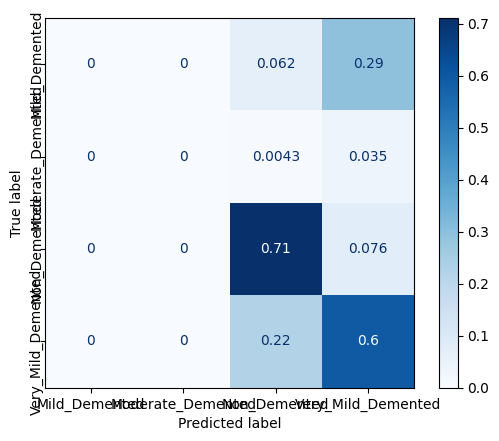

<Figure size 500x500 with 0 Axes>

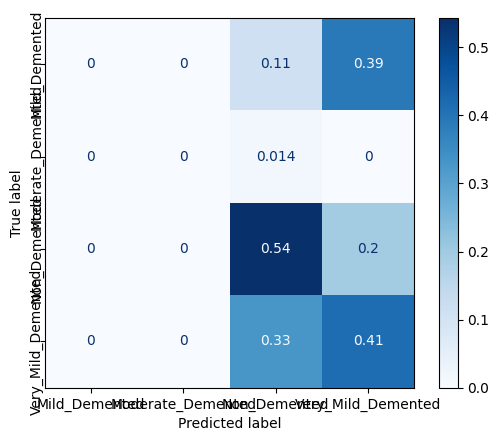

<Figure size 500x500 with 0 Axes>

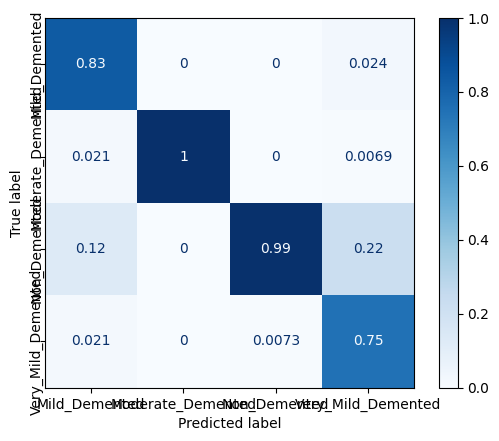

<Figure size 500x500 with 0 Axes>

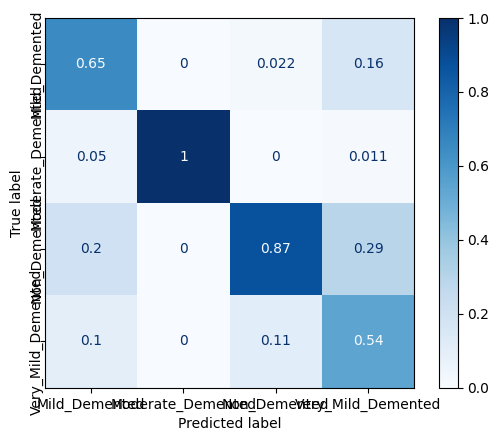

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r MobileNetV3Large.zip ./*